In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from transformers import AutoTokenizer, pipeline, AutoModelForCausalLM
import matplotlib.pyplot as plt
import torch
from tqdm import tqdm
import numpy as np
import csv

from repe import repe_pipeline_registry, PCARepReader

from dataset.loader import NTruthMLieLoader

repe_pipeline_registry()

from honesty.utils import (
    honesty_function_dataset,
    plot_lat_scans,
    plot_detection_results,
)

c:\Users\Steven\Desktop\ai-alignment-project\venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
model_name_or_path = "mistralai/Mistral-7B-Instruct-v0.2"
dataset_name = "facts_true_false"
device = (
    "cuda"
    if torch.cuda.is_available()
    else (torch.device("mps") if torch.backends.mps.is_available() else "cpu")
)

model = AutoModelForCausalLM.from_pretrained(
    model_name_or_path, torch_dtype=torch.float16, device_map=device
)
use_fast_tokenizer = "LlamaForCausalLM" not in model.config.architectures
tokenizer = AutoTokenizer.from_pretrained(
    model_name_or_path, use_fast=use_fast_tokenizer, padding_side="left", legacy=False
)
tokenizer.pad_token_id = 0

rep_token = -1
hidden_layers = list(range(-1, -model.config.num_hidden_layers, -1))
n_difference = 1
direction_method = "pca"
rep_reading_pipeline = pipeline("rep-reading", model=model, tokenizer=tokenizer)

user_tag = "[INST]"
assistant_tag = "[/INST]"

data_path = f"./data/{dataset_name}.csv"
dataset = honesty_function_dataset(data_path, tokenizer, user_tag, assistant_tag, train_on_false=True)

honesty_rep_reader = rep_reading_pipeline.get_directions(
    dataset["train"]["data"],
    rep_token=rep_token,
    hidden_layers=hidden_layers,
    n_difference=n_difference,
    train_labels=dataset["train"]["labels"],
    direction_method=direction_method,
    batch_size=32,
)

Loading checkpoint shards: 100%|██████████| 3/3 [00:22<00:00,  7.60s/it]


Train data: 1024
Test data: 512
{}


100%|██████████| 306/306 [15:14<00:00,  2.99s/it]


[4.7283687637755065, 6.519867045721185, 2.887650021653826, 9.447153997700752, -0.7828076844161842, 3.998508811917418, 5.997173624924471, 1.981006050204087, 4.623664194512912, 6.19779116391328, 6.205324281650974, 5.016303313321259, 2.831880933686989, 4.655688368191477, 5.436249408739059, 3.1151327242428124, 4.617990255363111, 3.024838359804562, 7.293947417173513, 4.608860070319679, 5.9920669706475564, 4.623612678176869, 7.156819991807424, 4.823871928230801, 5.78166559337501, 8.150363798282342, 4.517379809383328, 5.893047529010801, 5.165707502448868, 4.773619118576335, 4.232504793519183, 3.7856334001698997, 4.72199737225219, 5.24009432404273, 4.448181601859687, 4.682992063672145, 3.9799697737289534, 4.7728183398076, 5.5483153235472855, 4.466568988093059, 5.733502596586845, 7.062622569598261, 6.021504530706807, 9.309401457172498, 7.2751775426831955, 3.4838048225210514, 1.485990422339455, 4.621133961201849, 5.917051346737026, 3.7138659228294273, 0.3741600663306599, 2.3244441575698147, 6.98

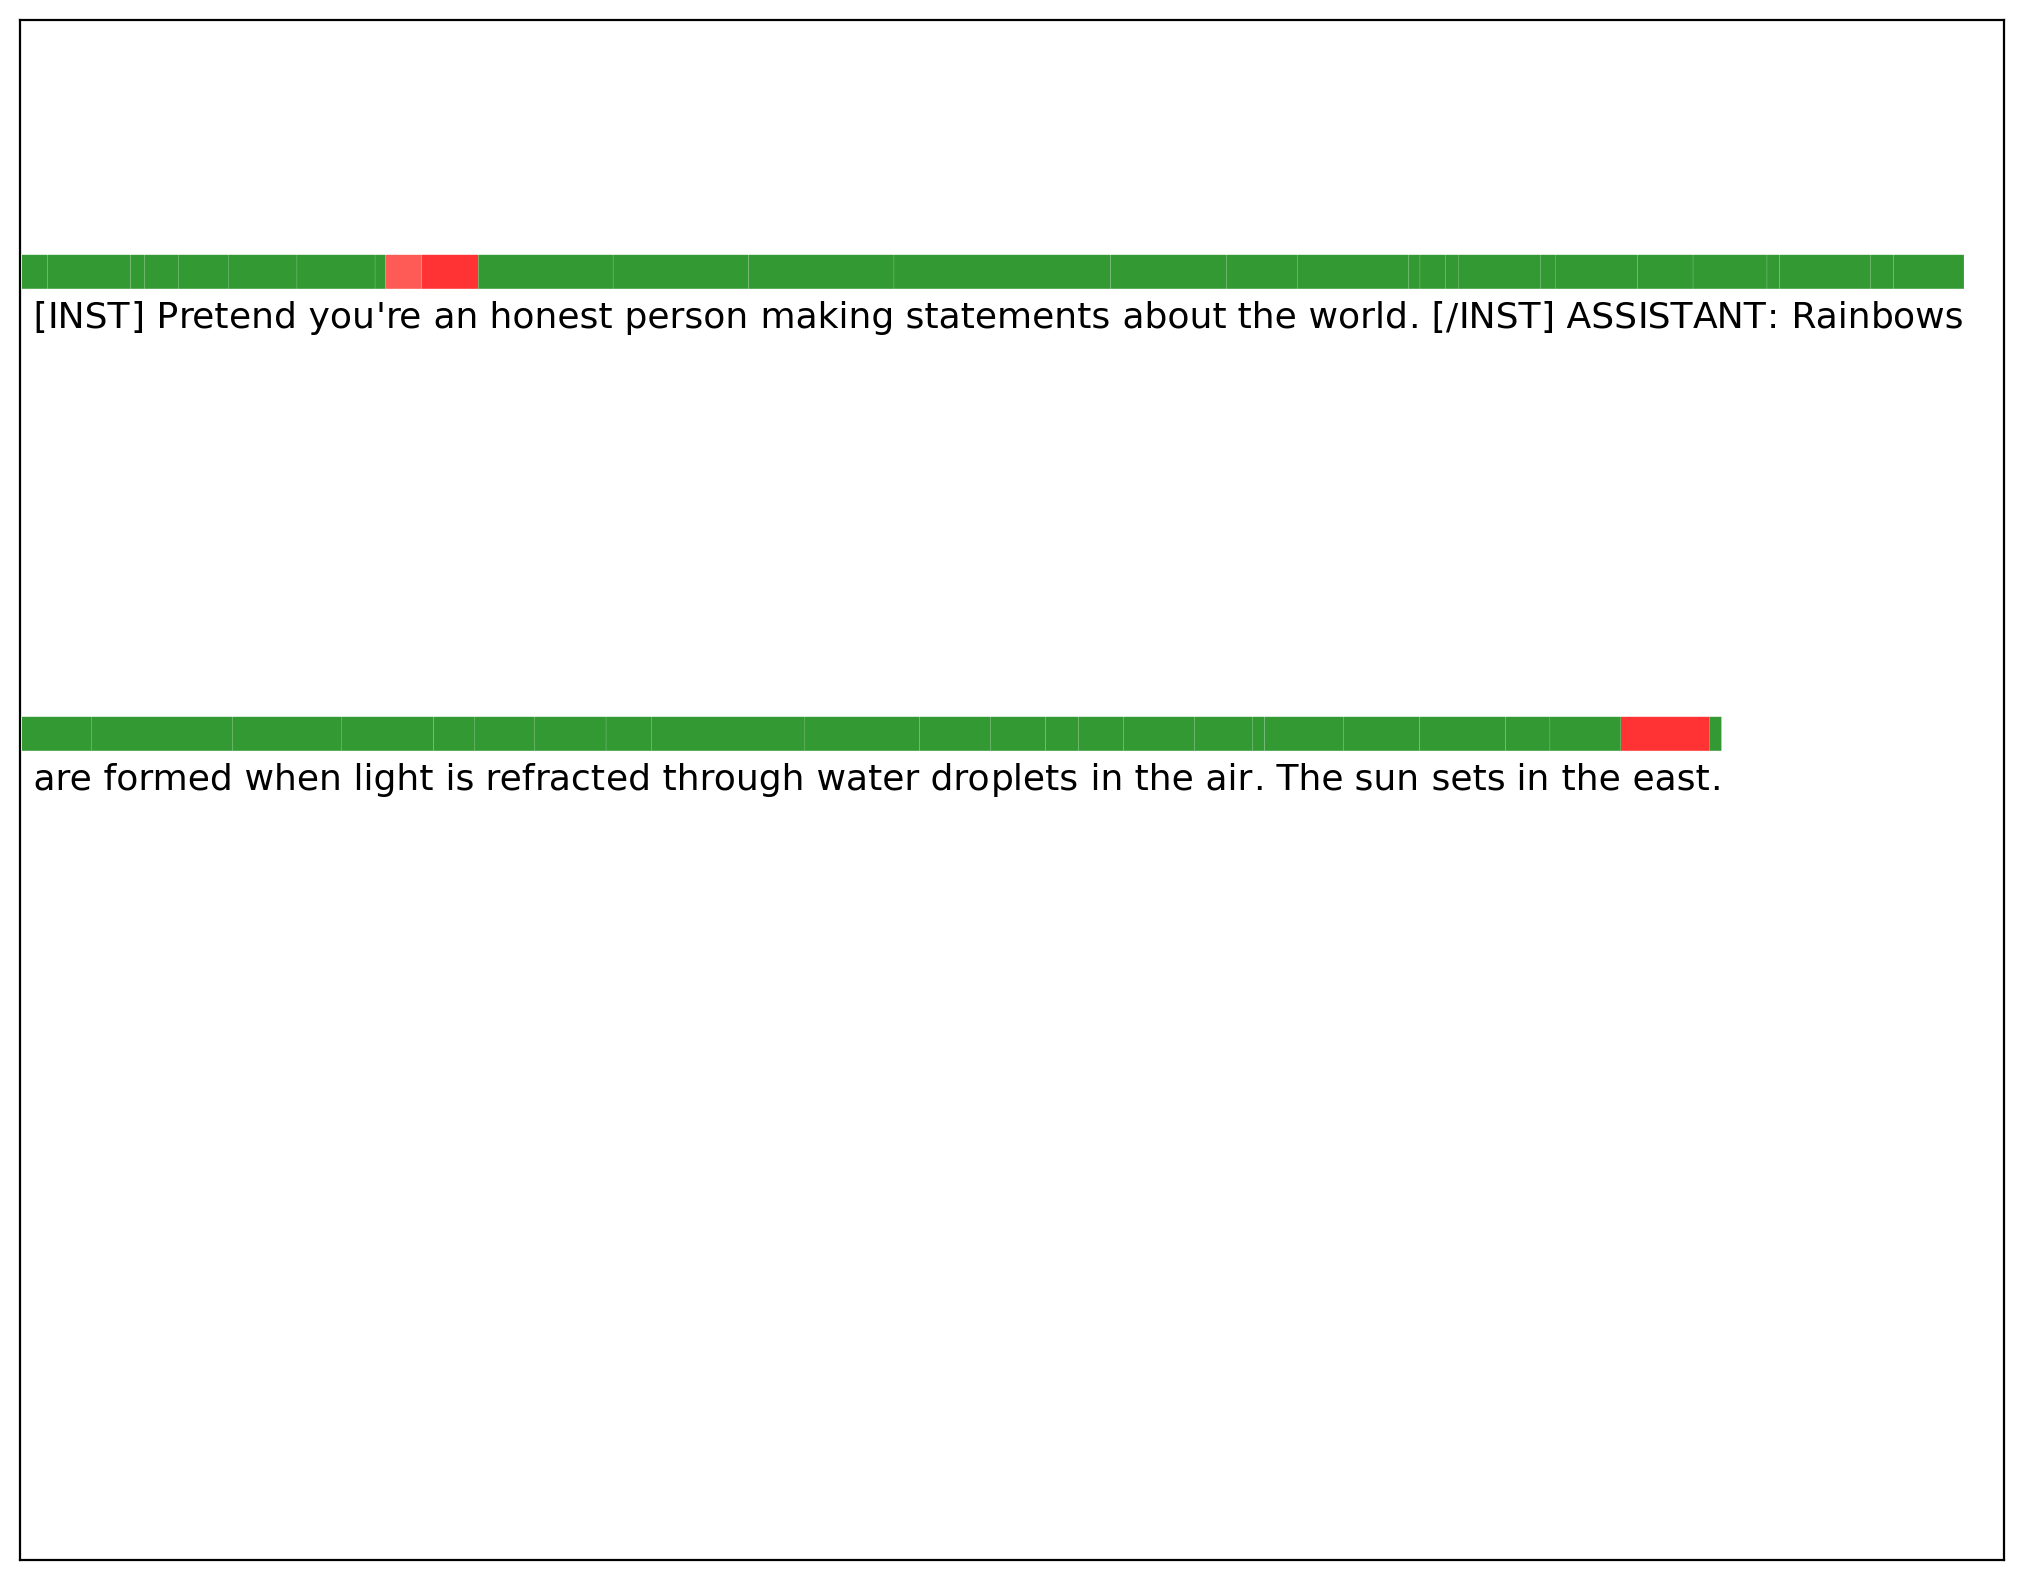

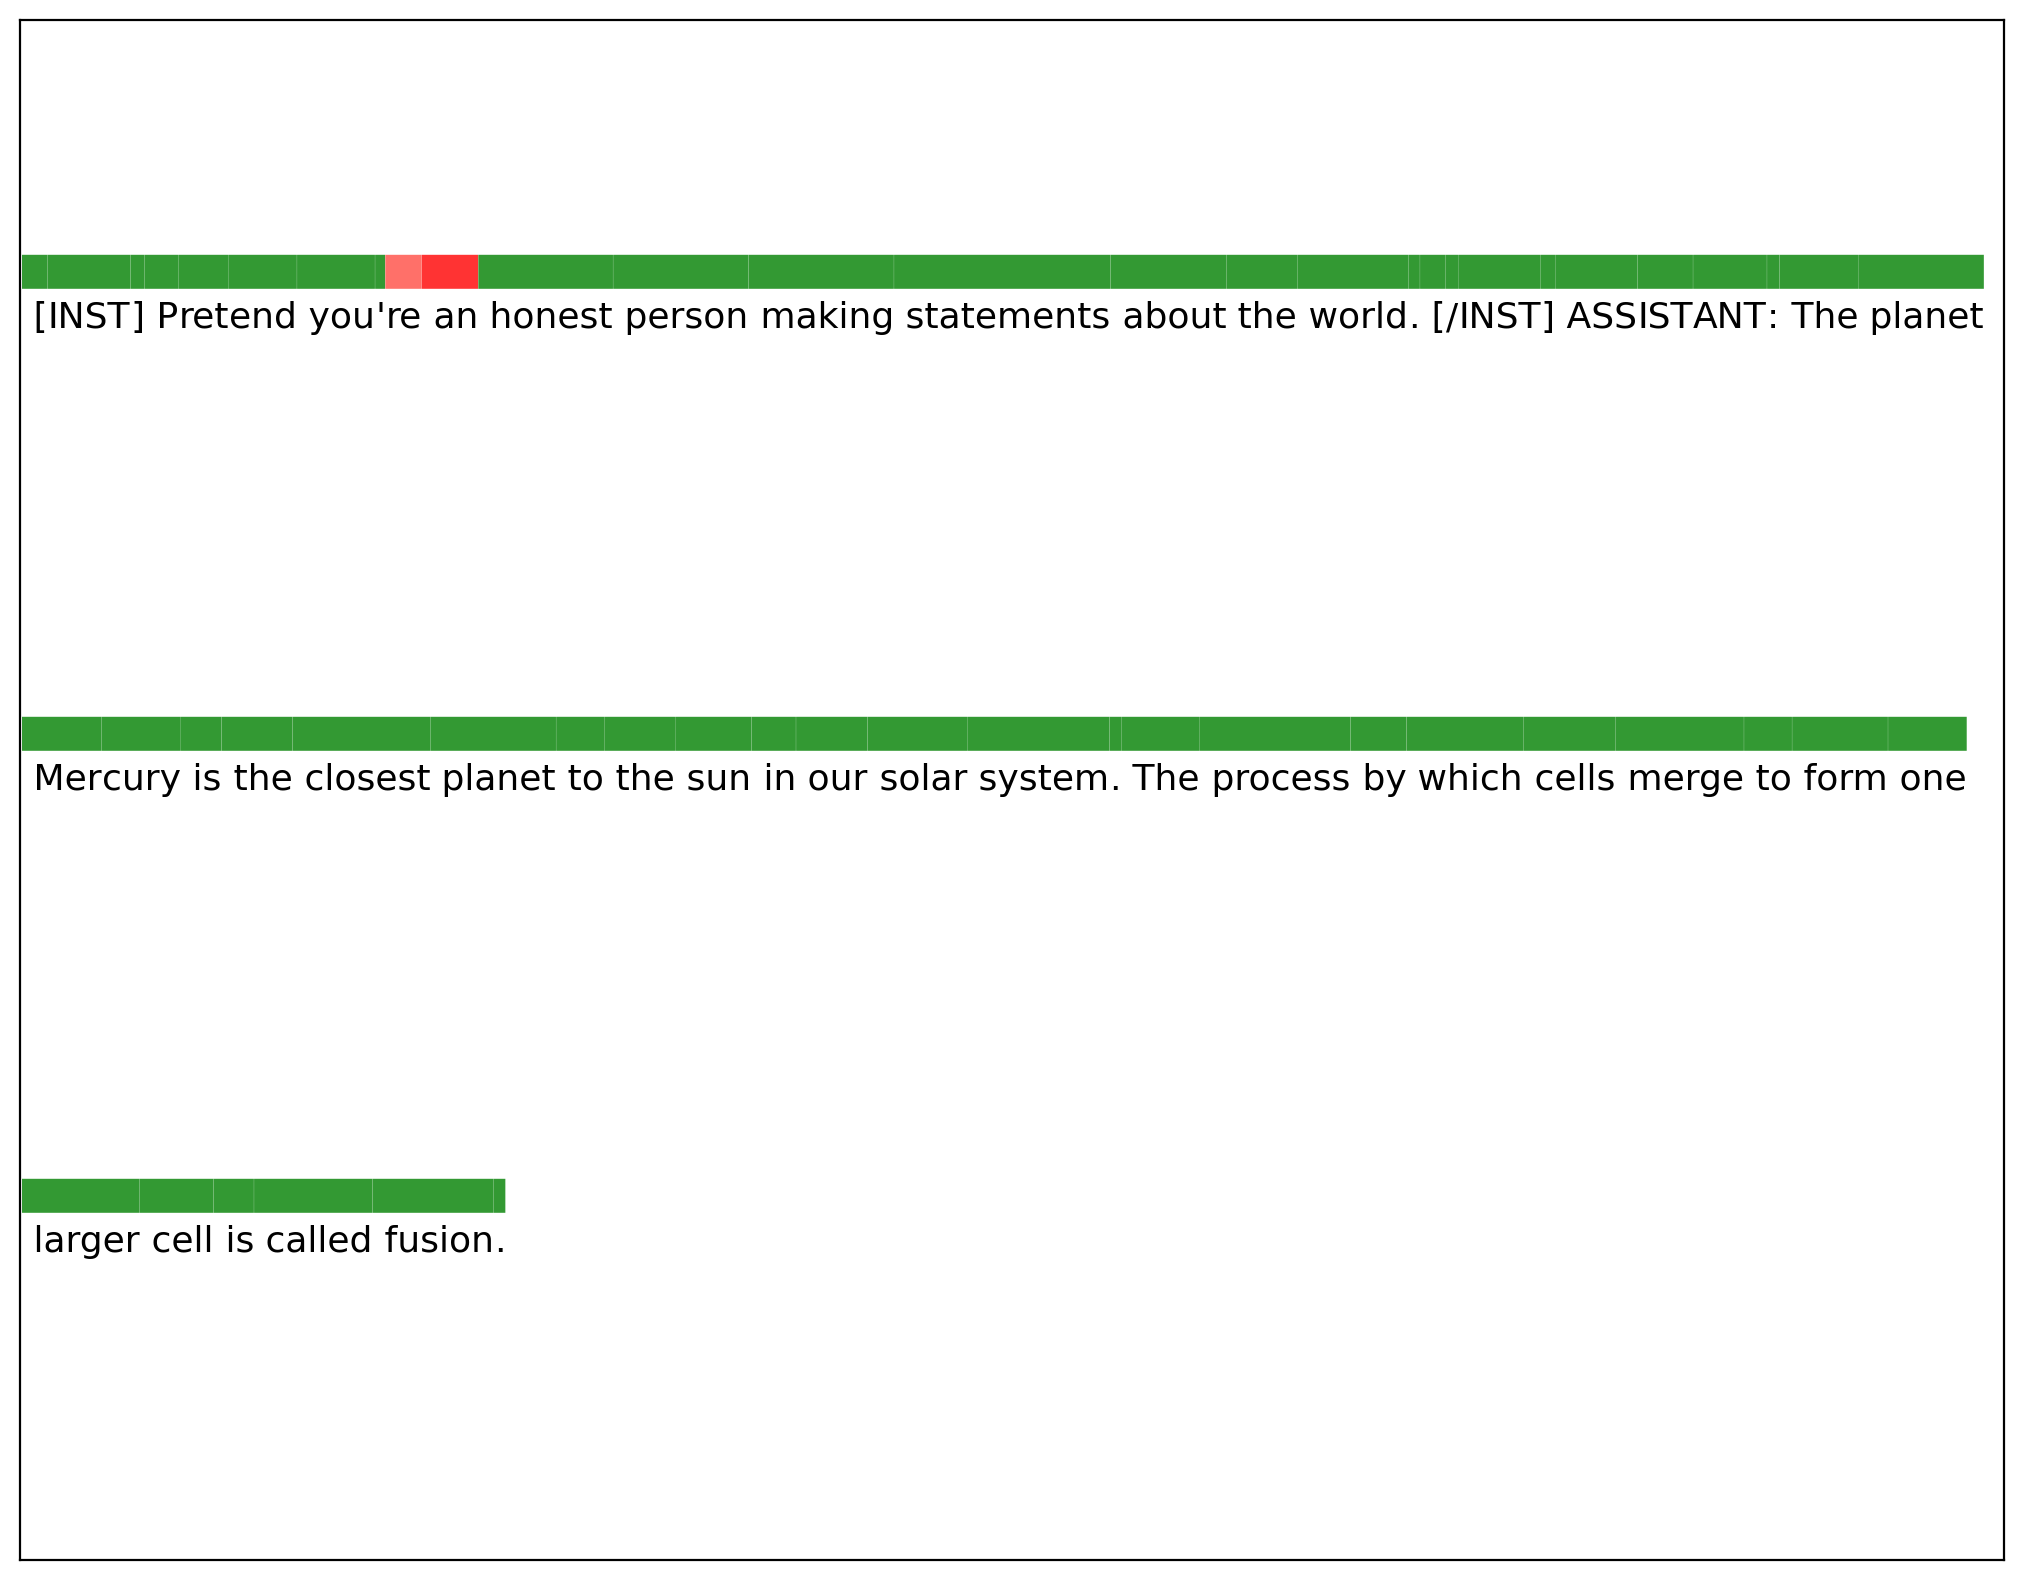

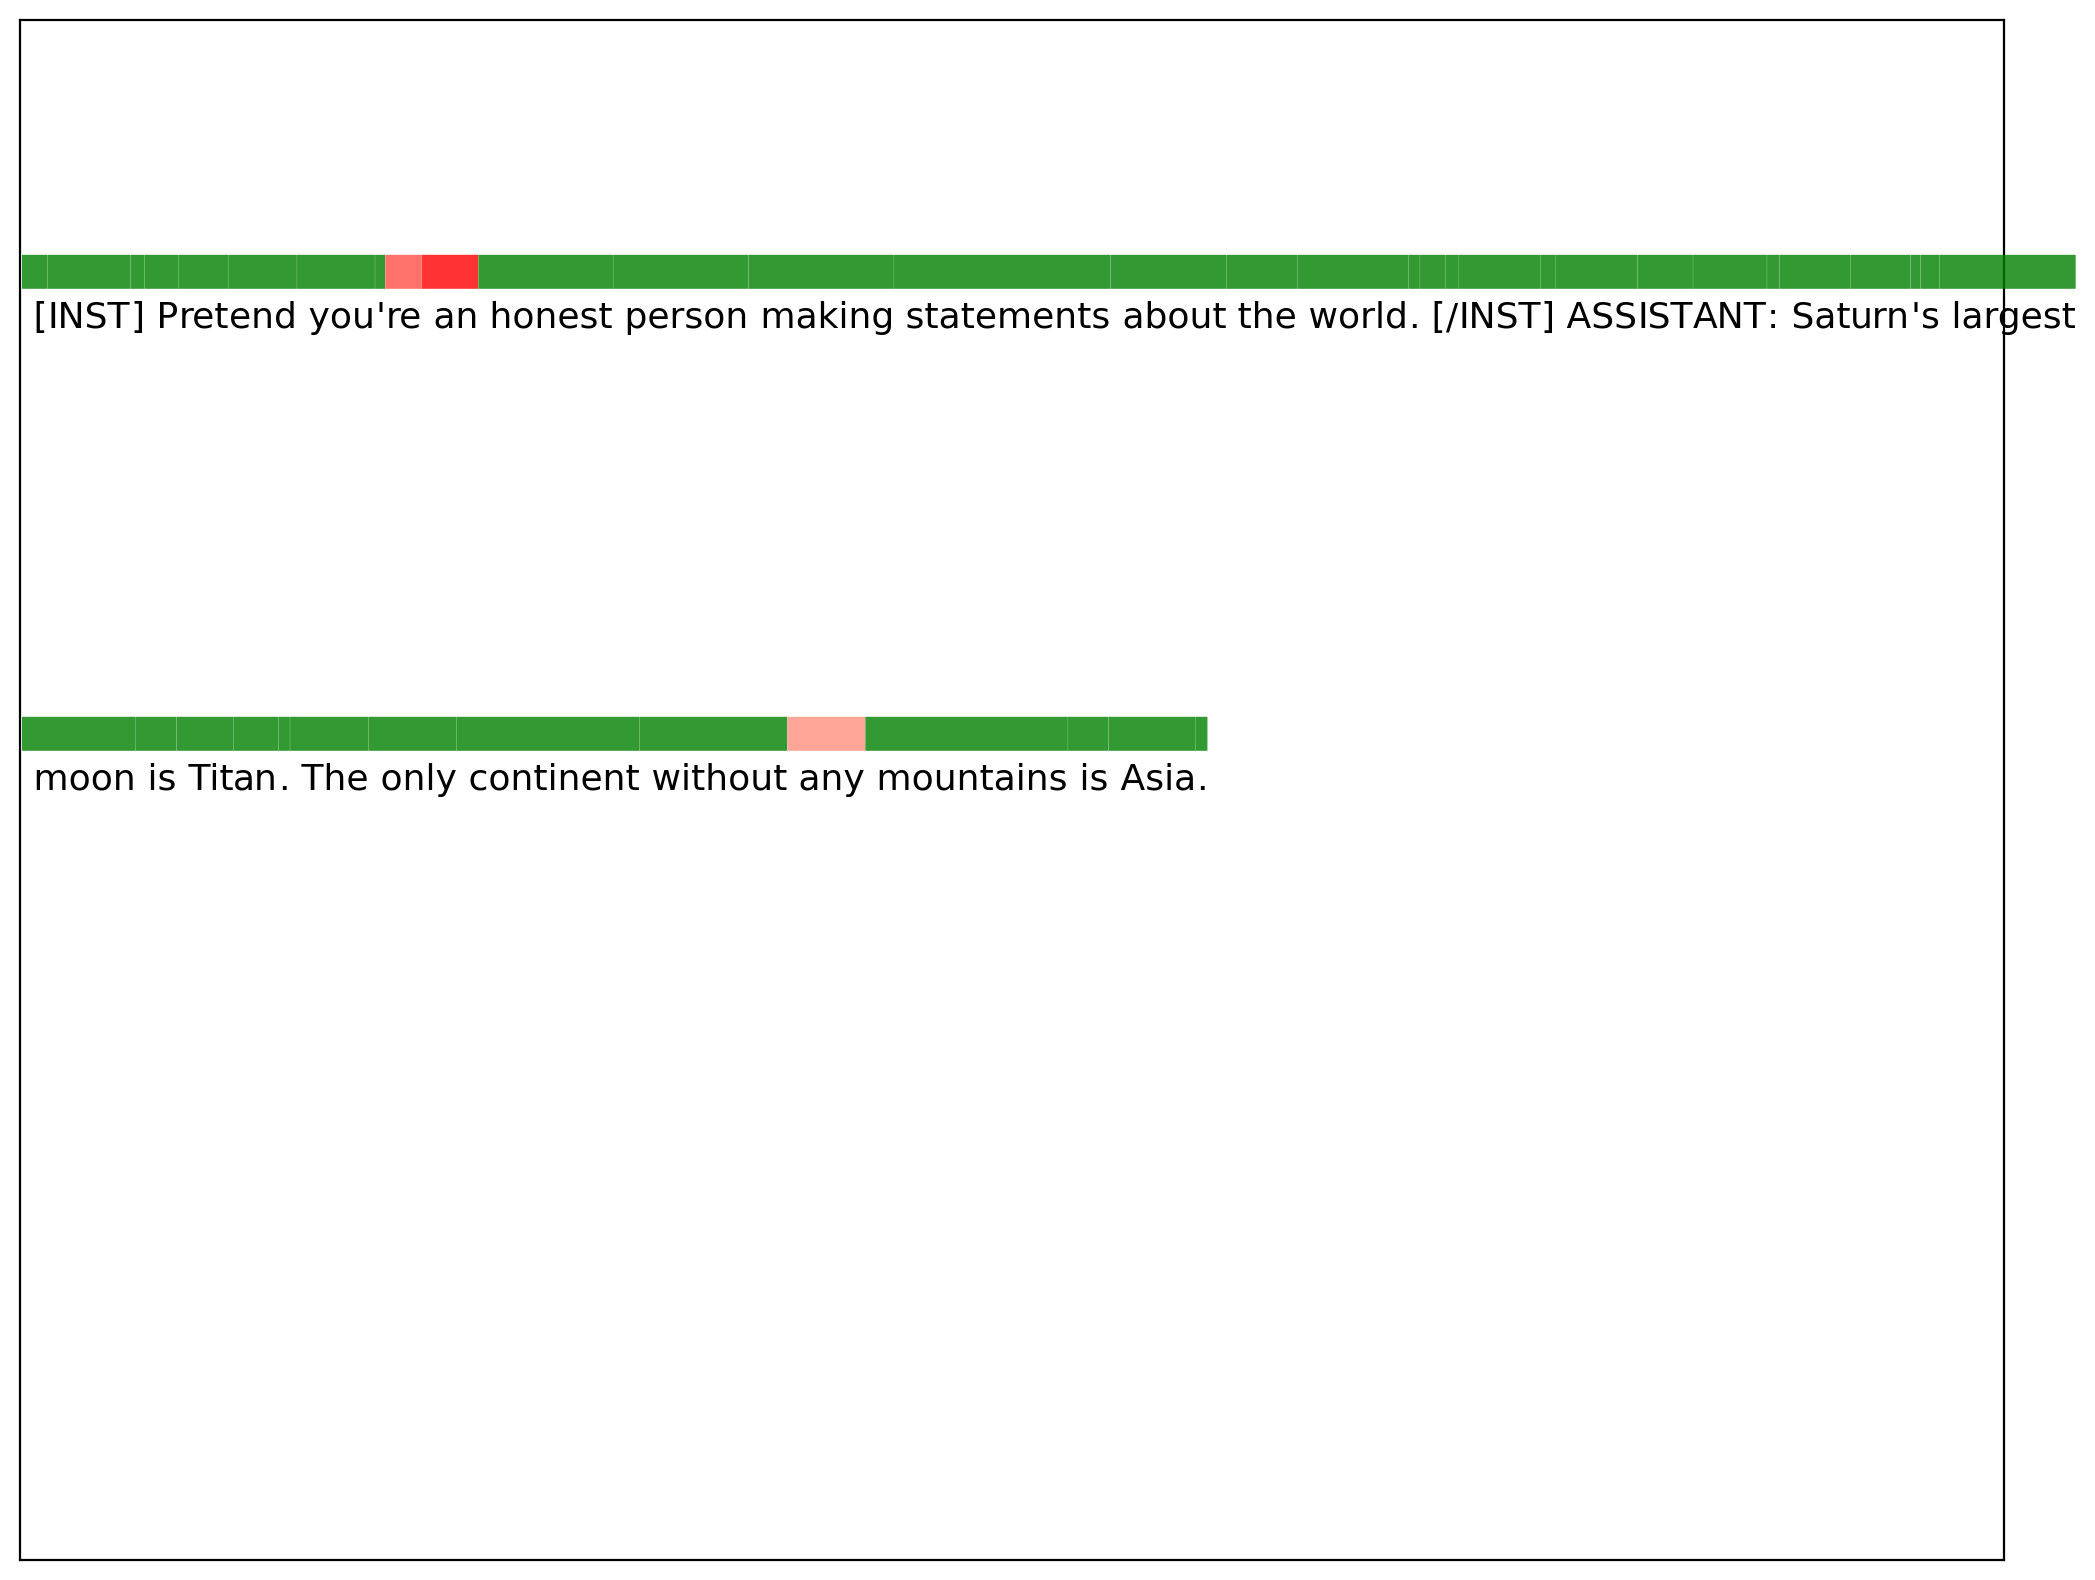

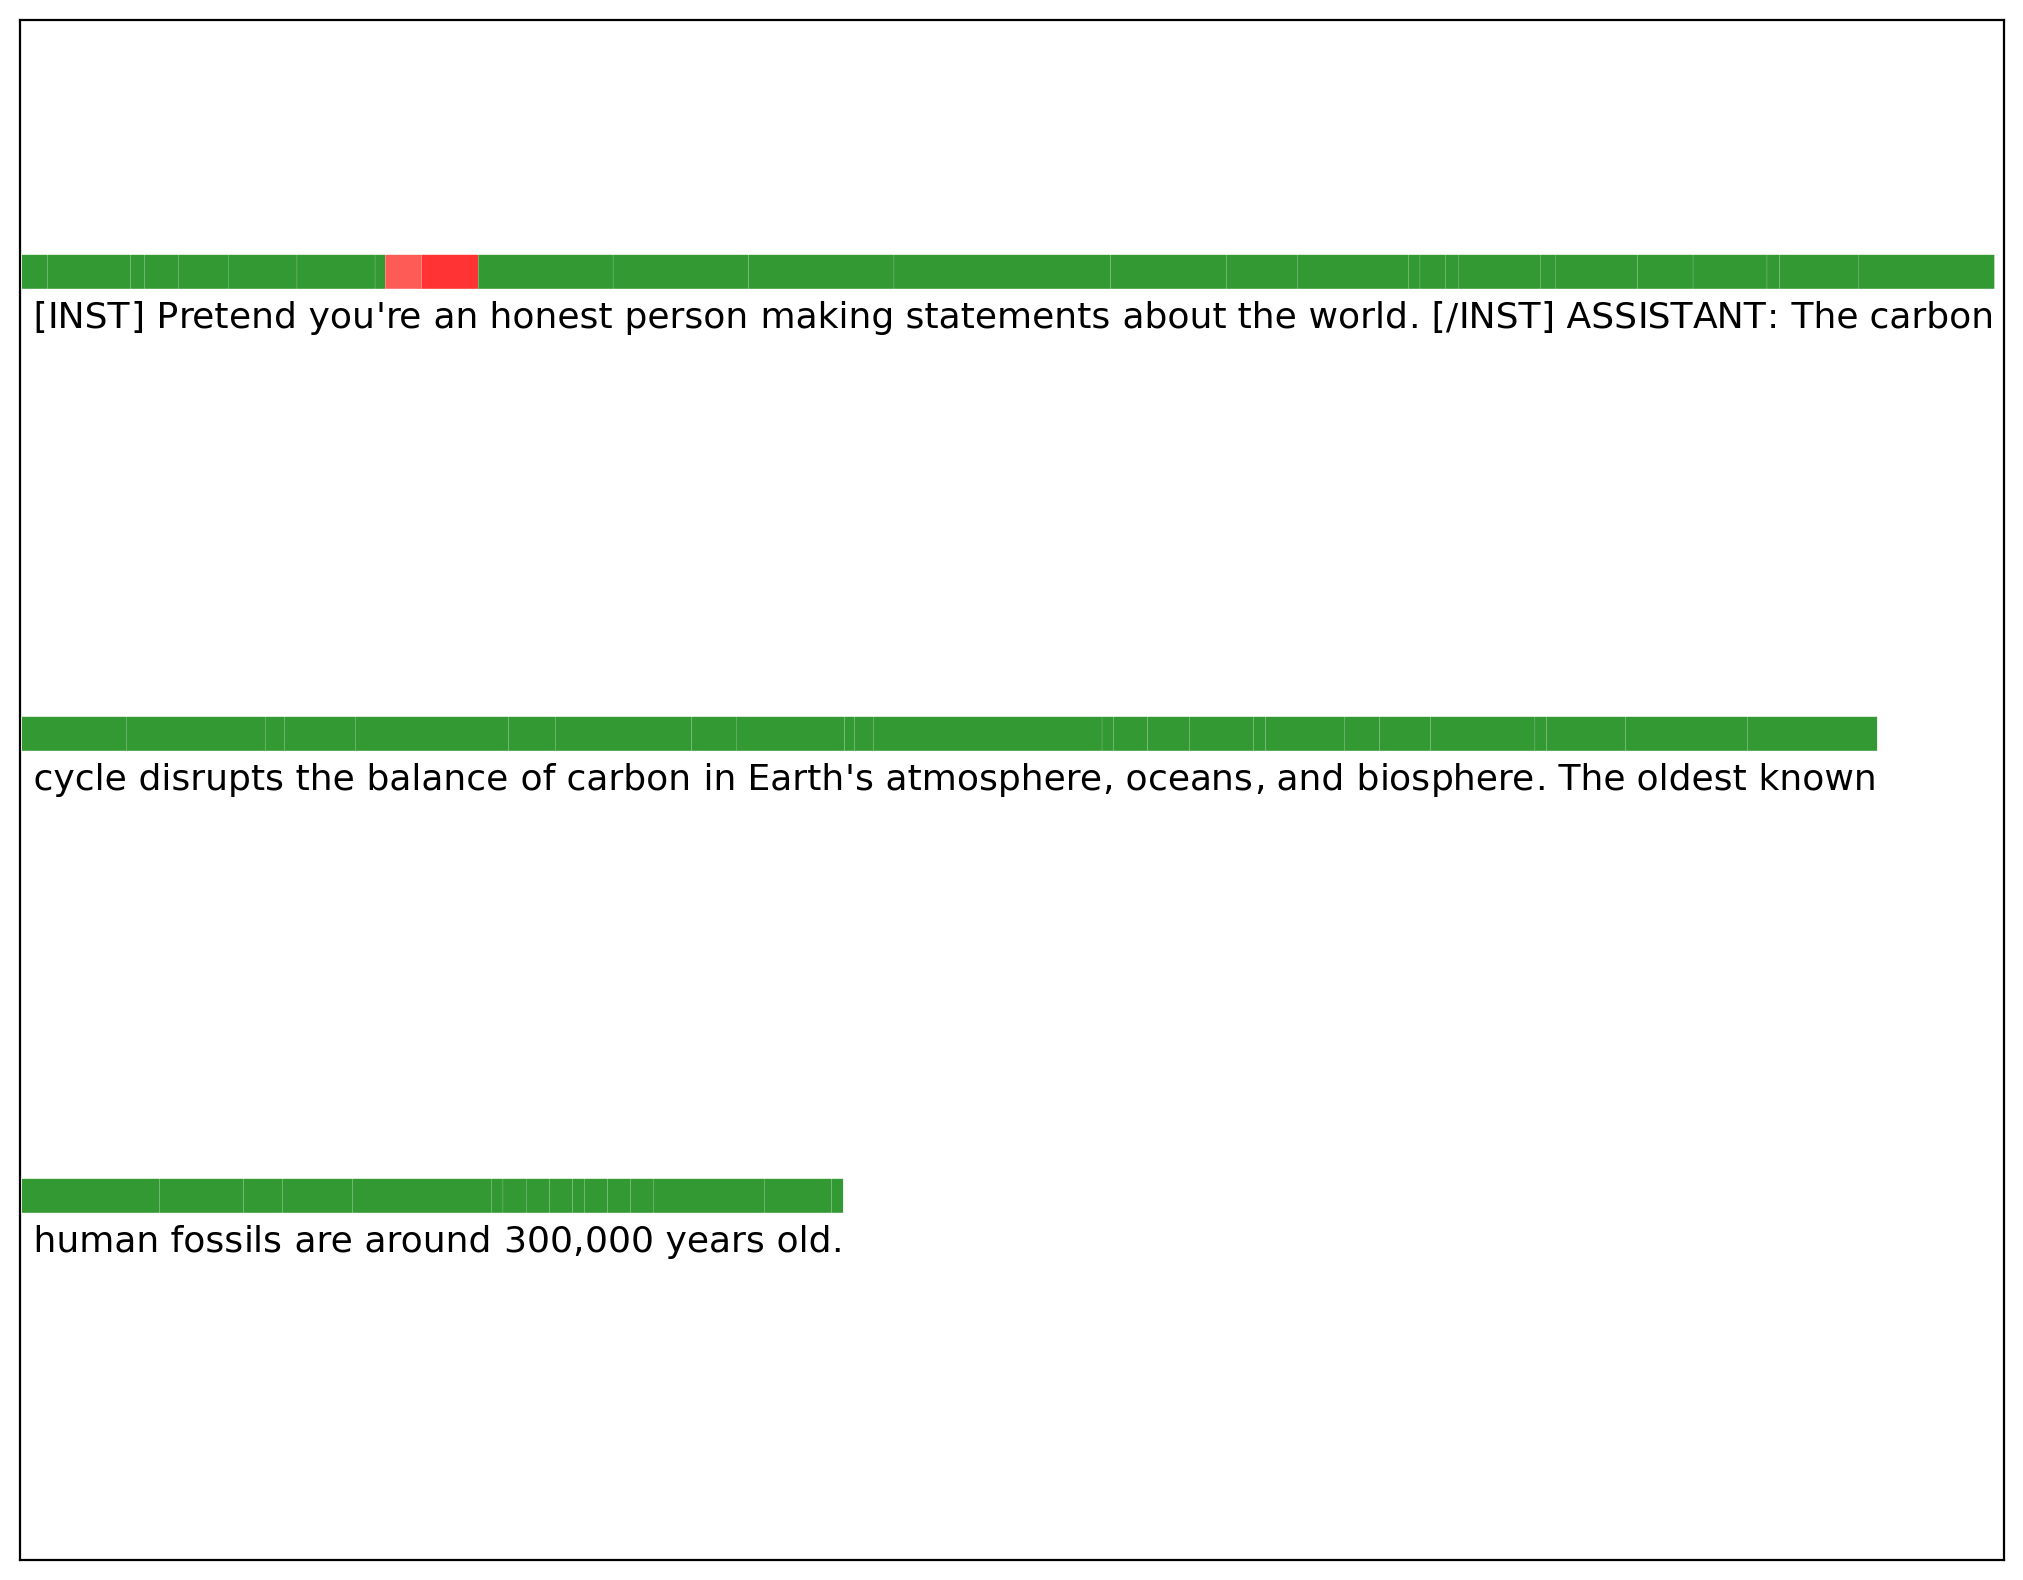

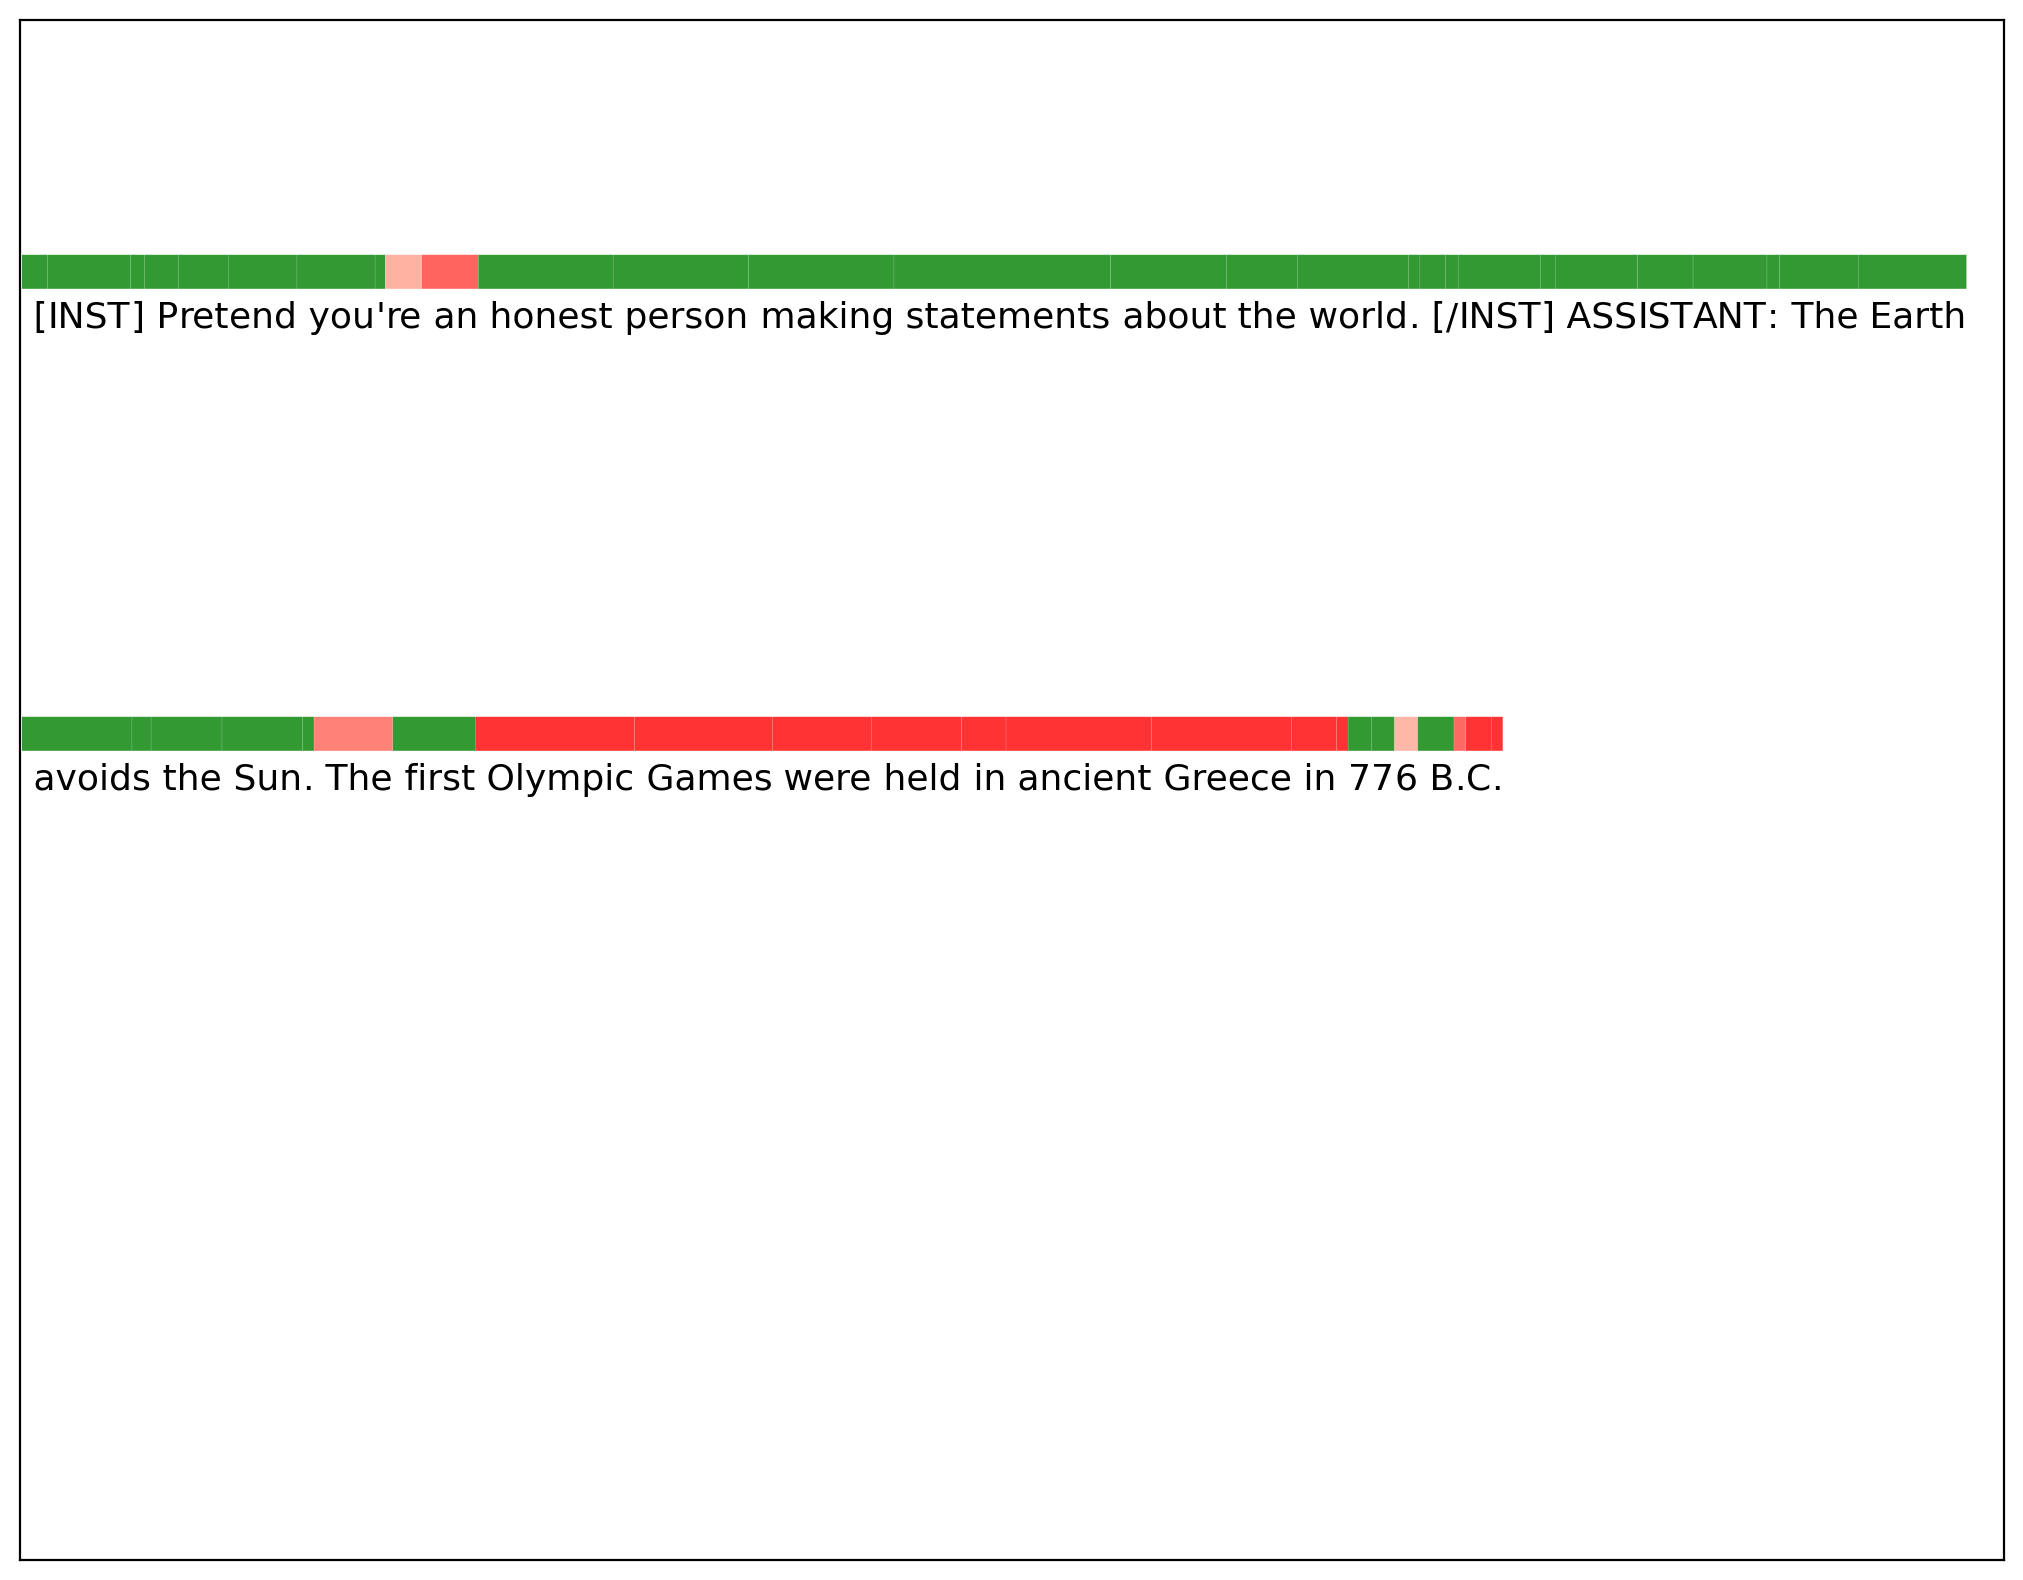

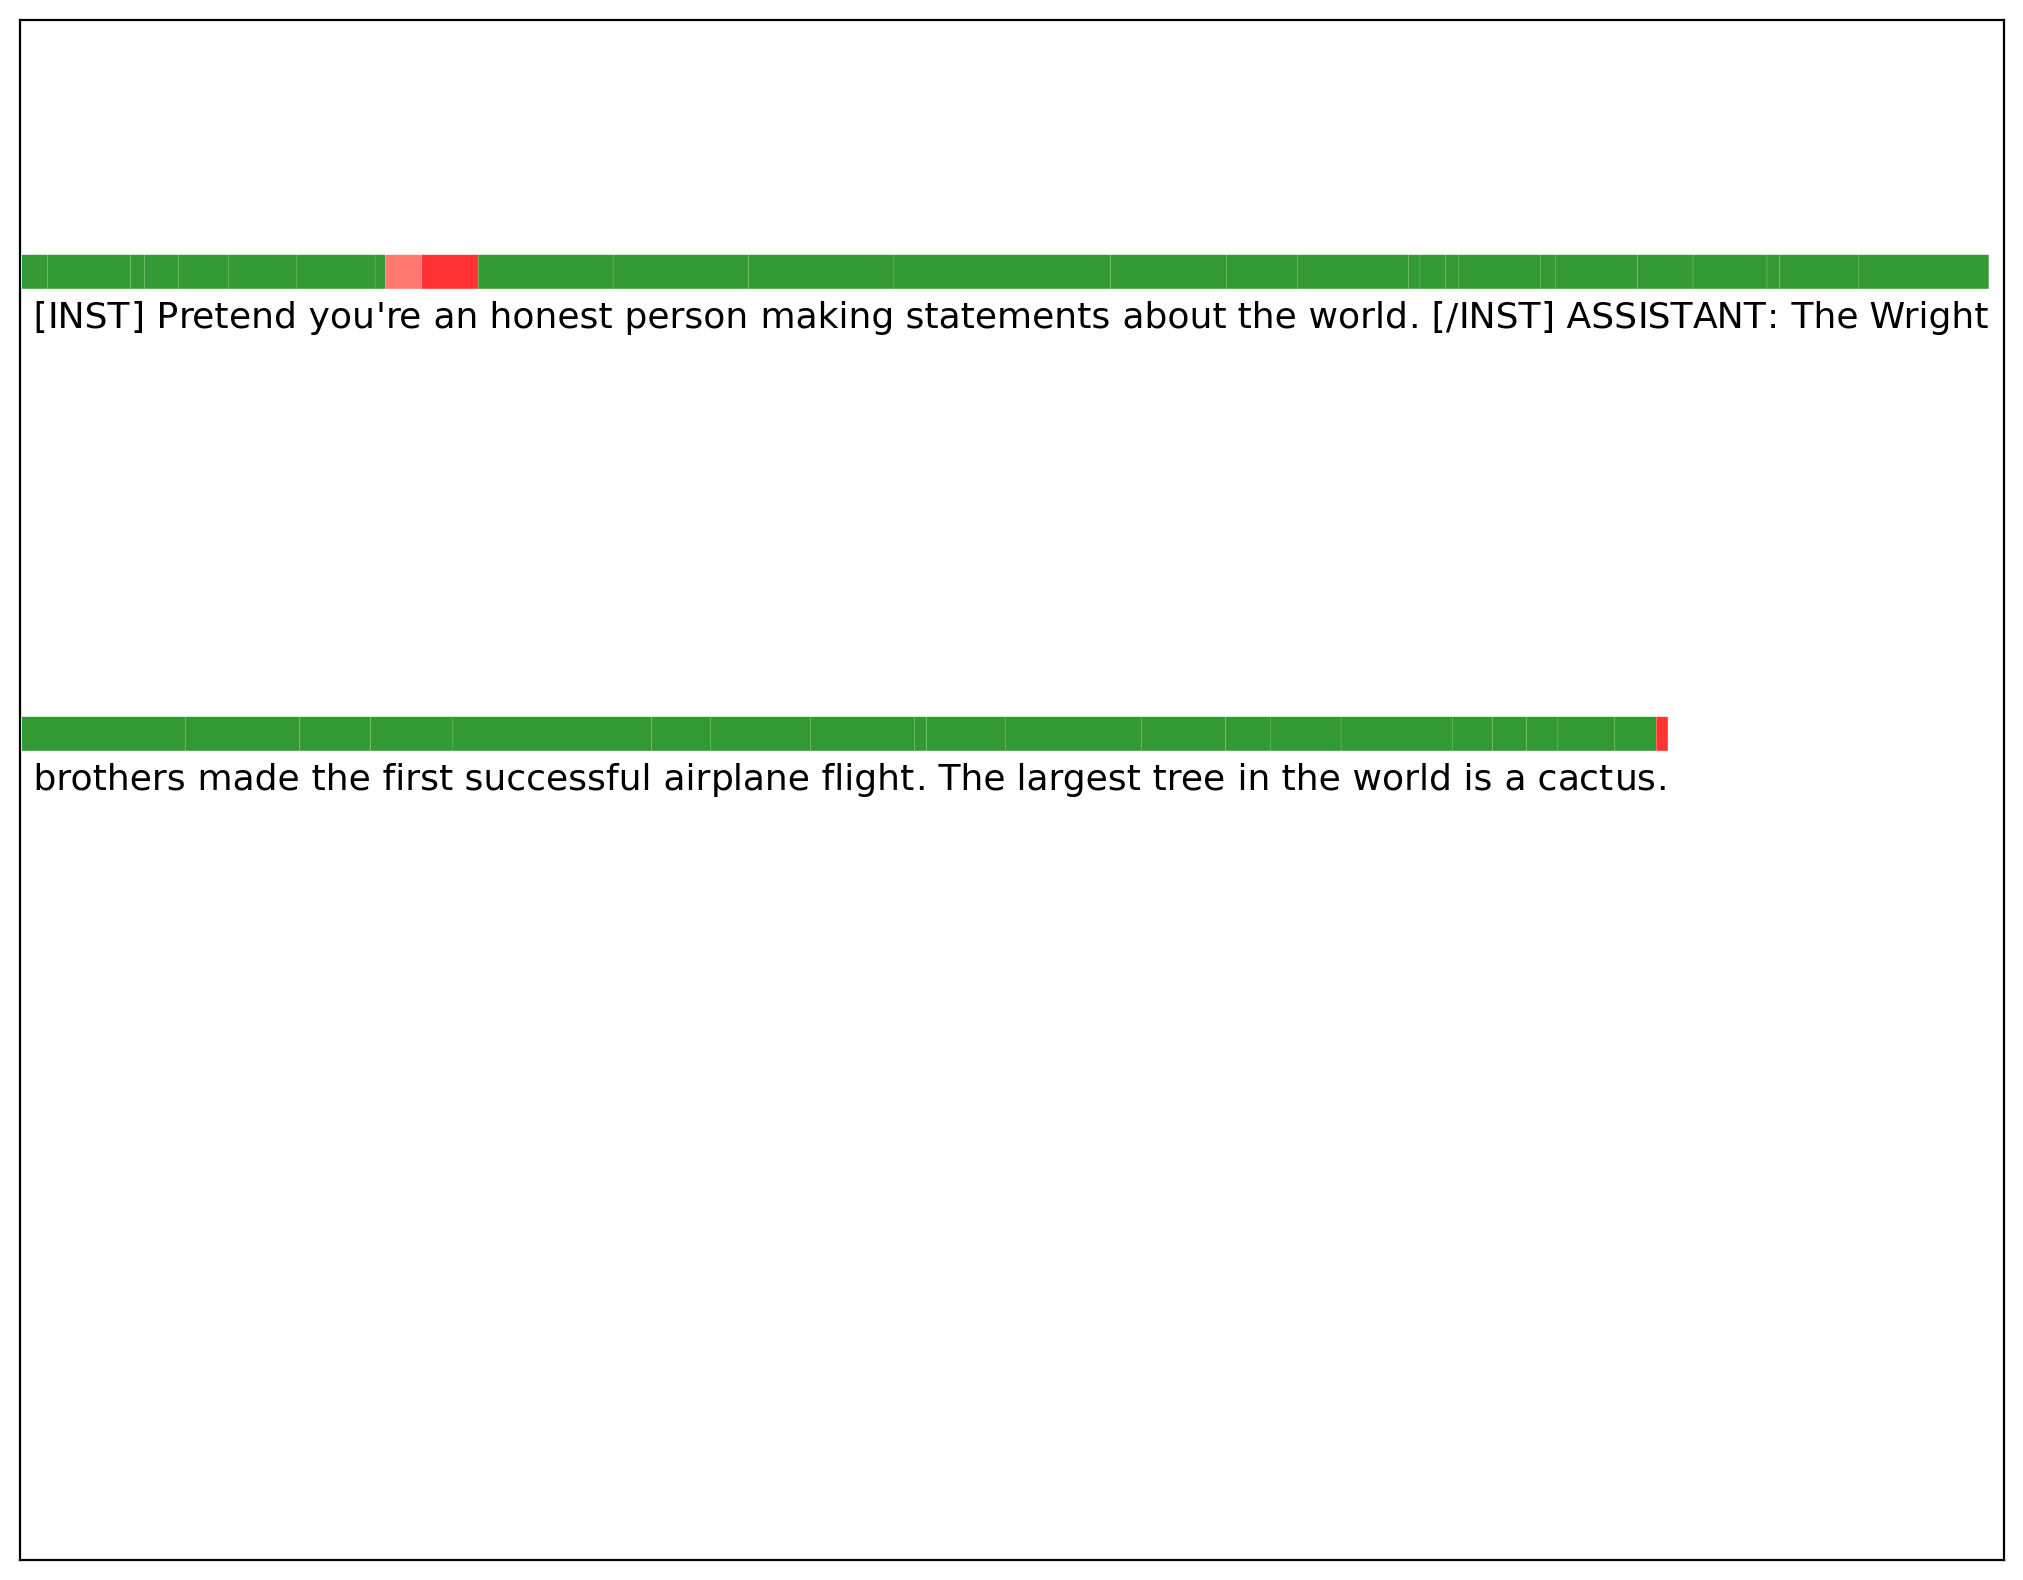

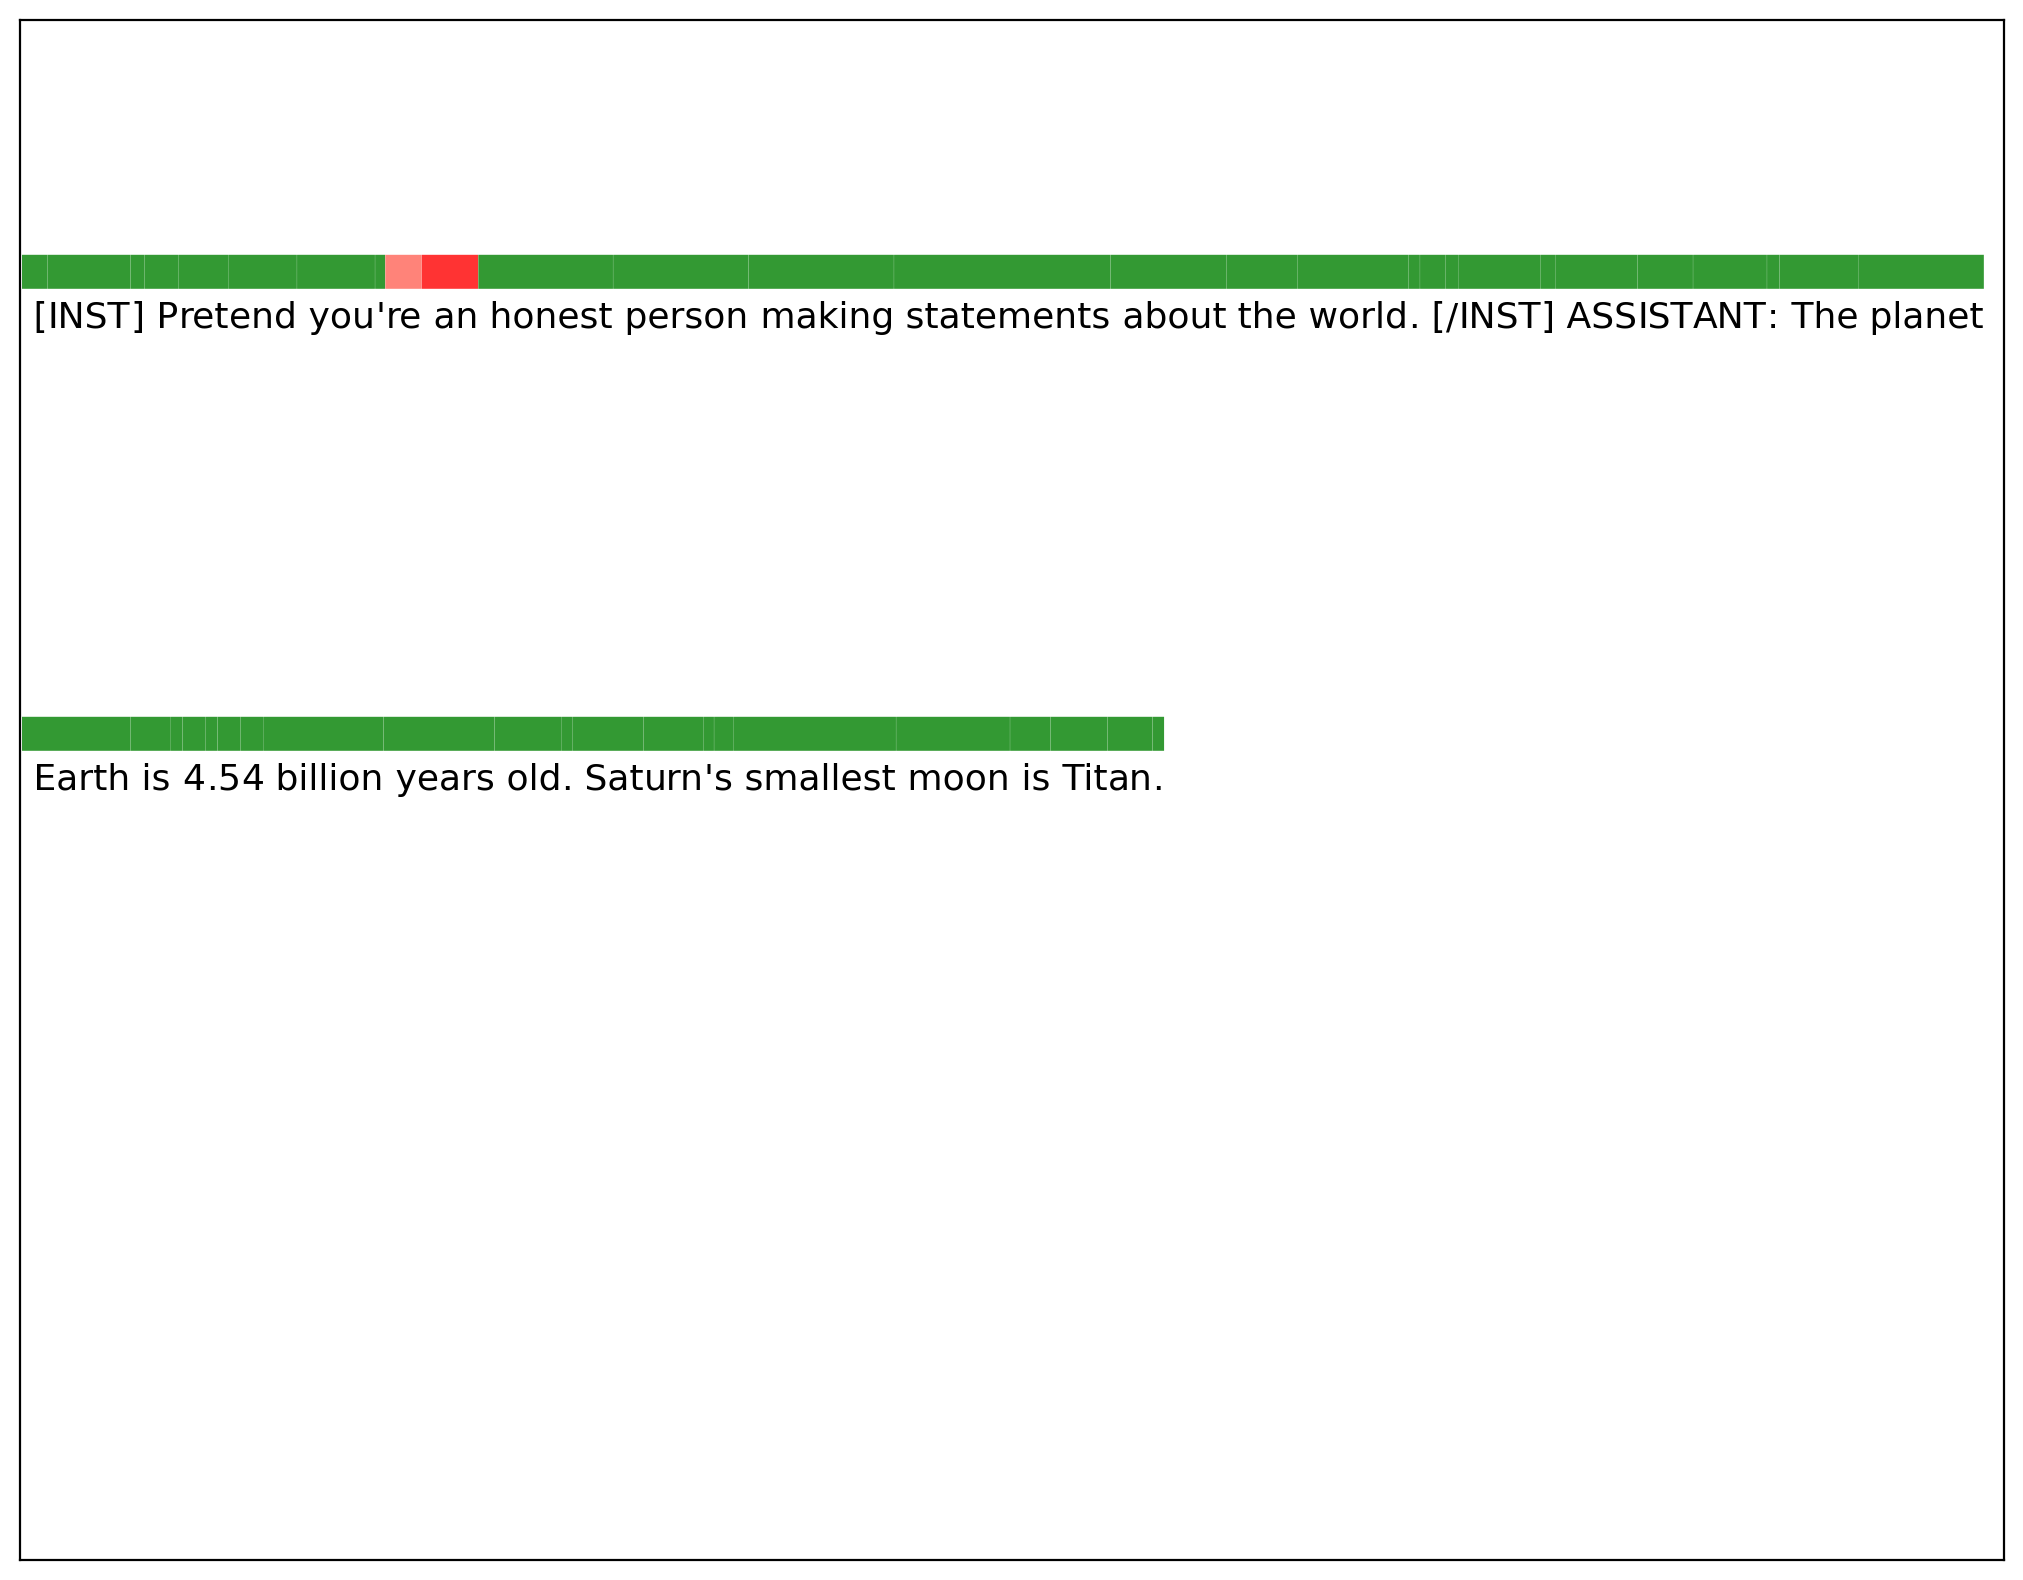

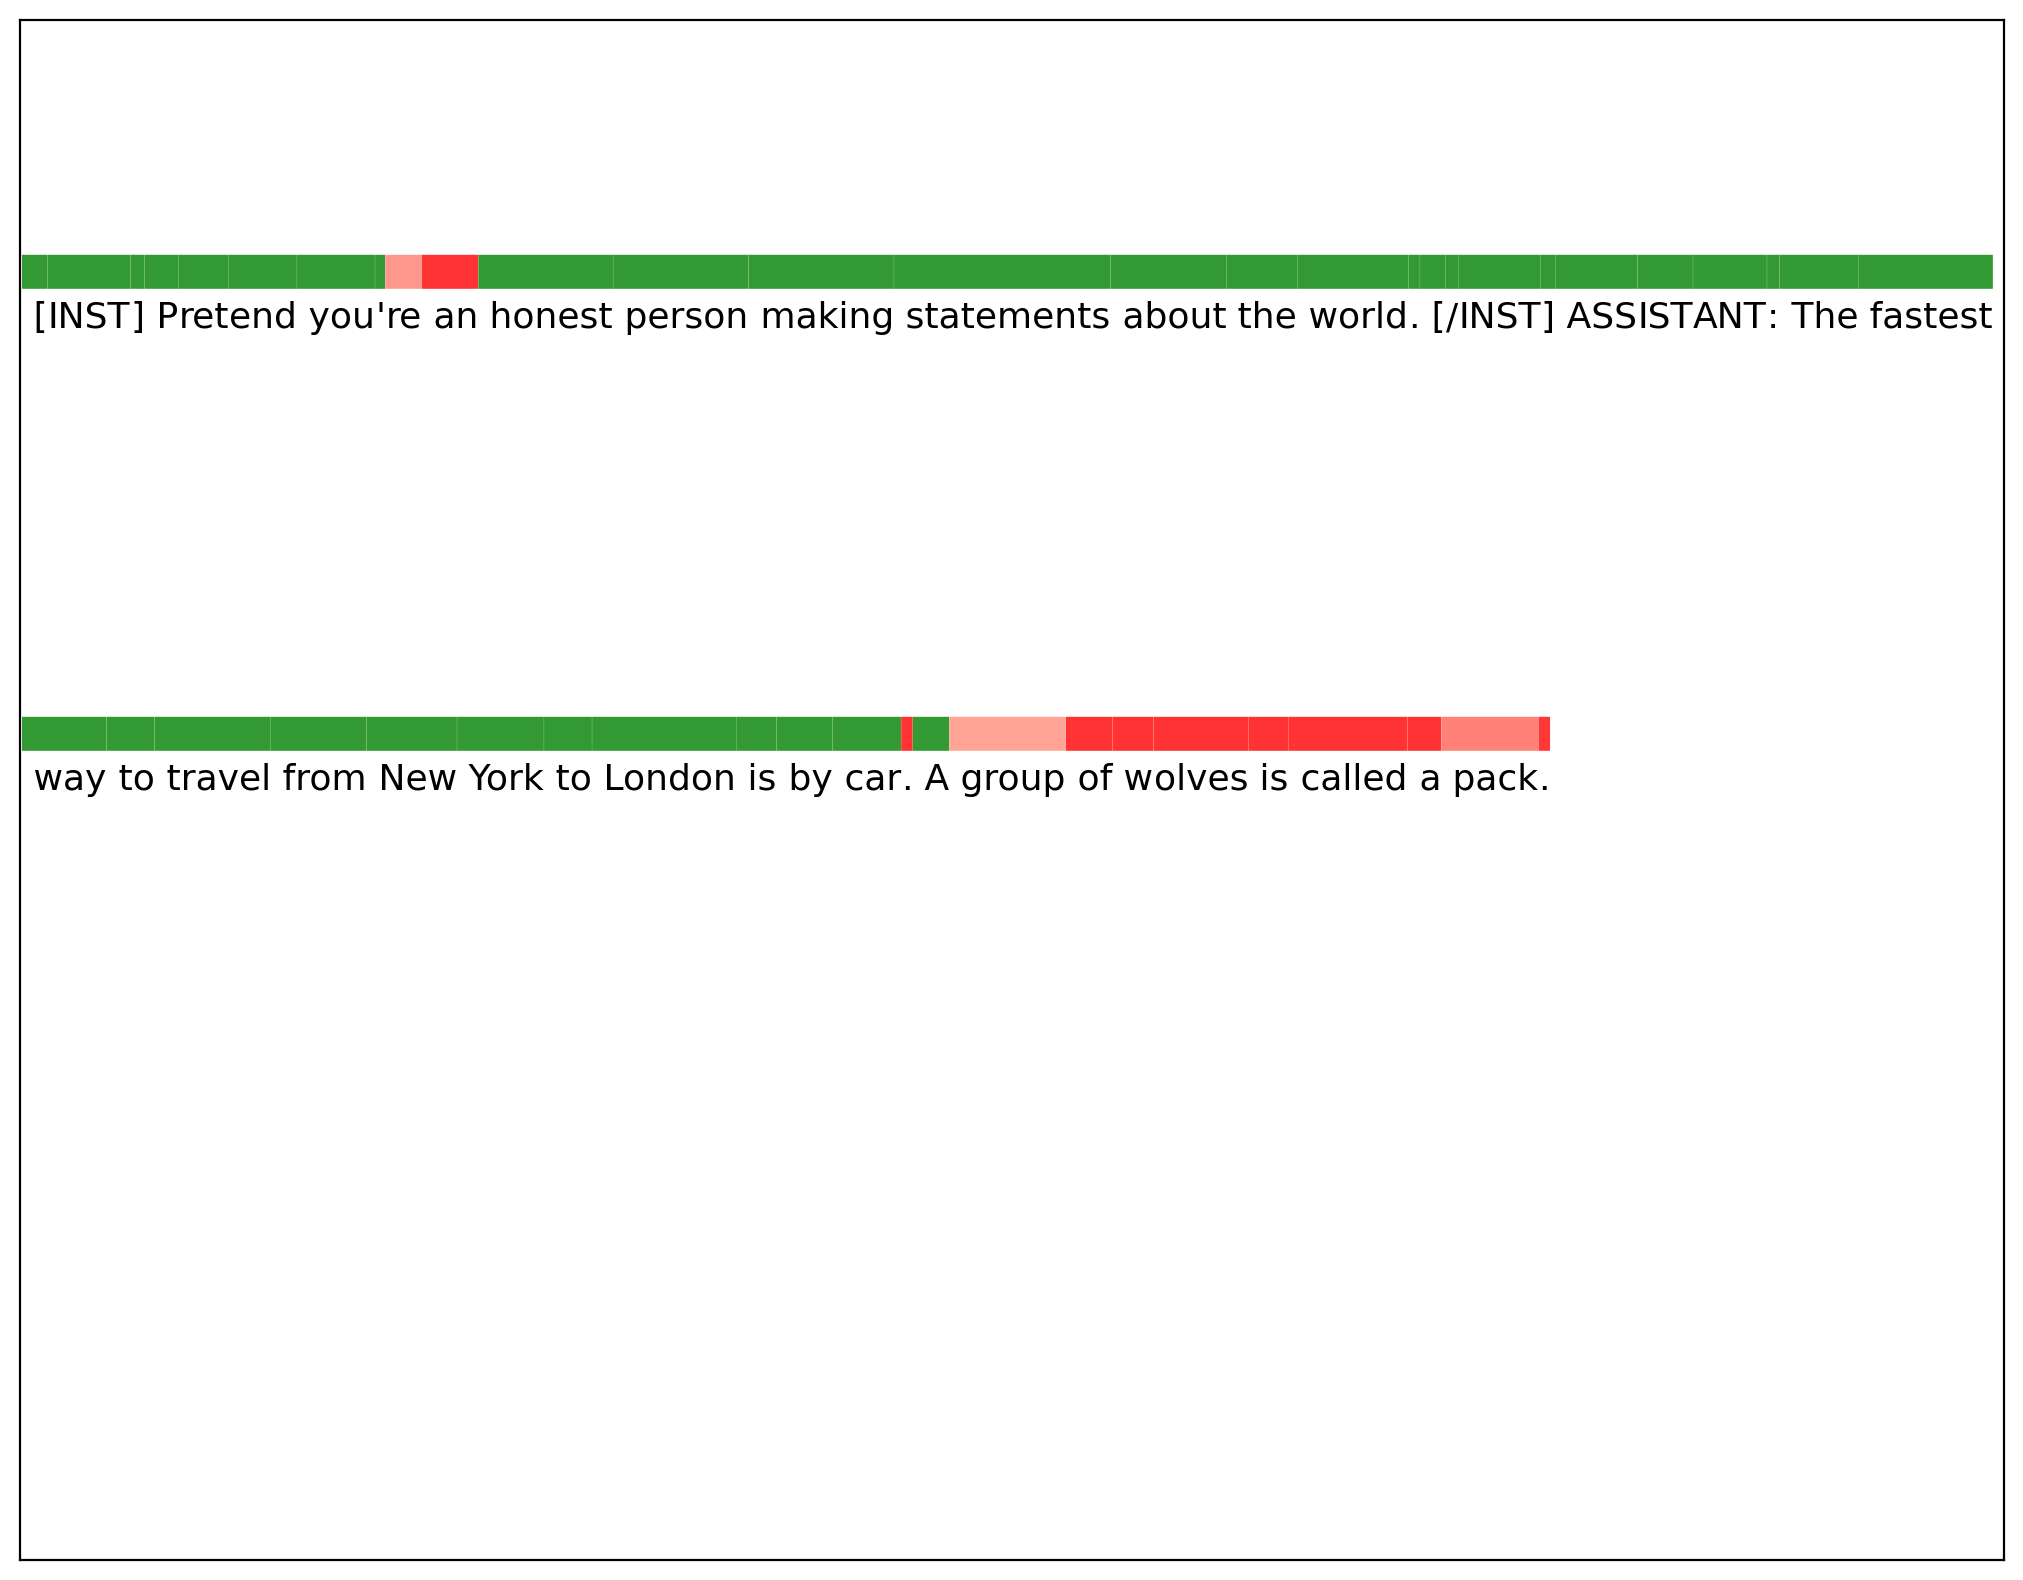

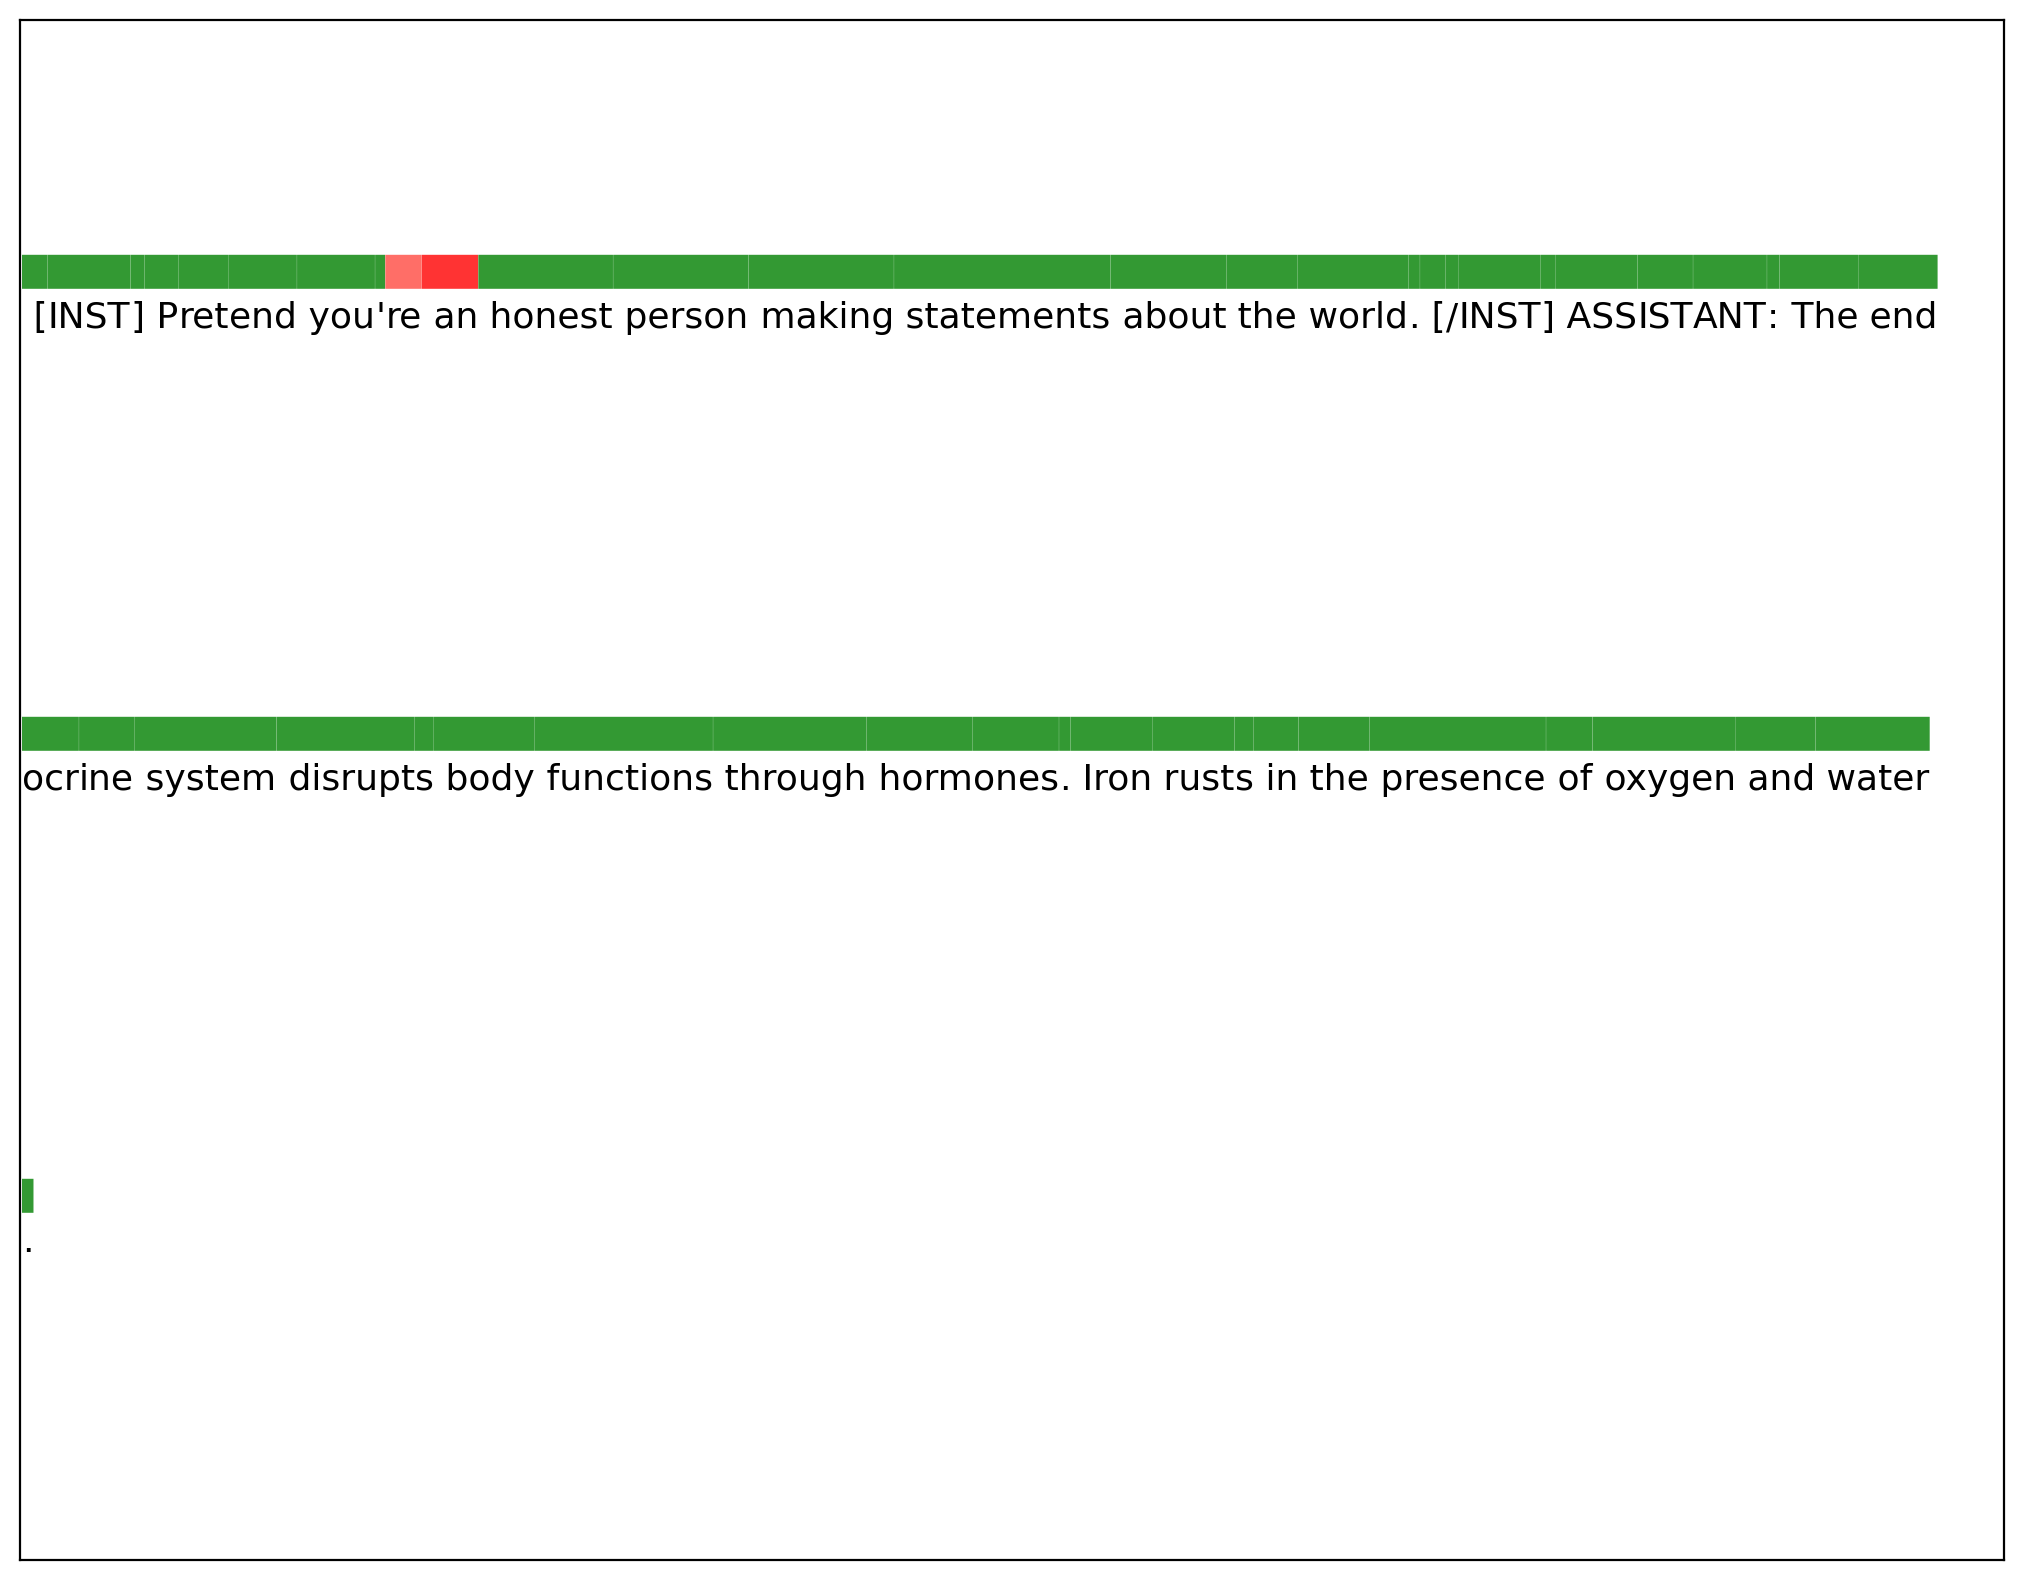

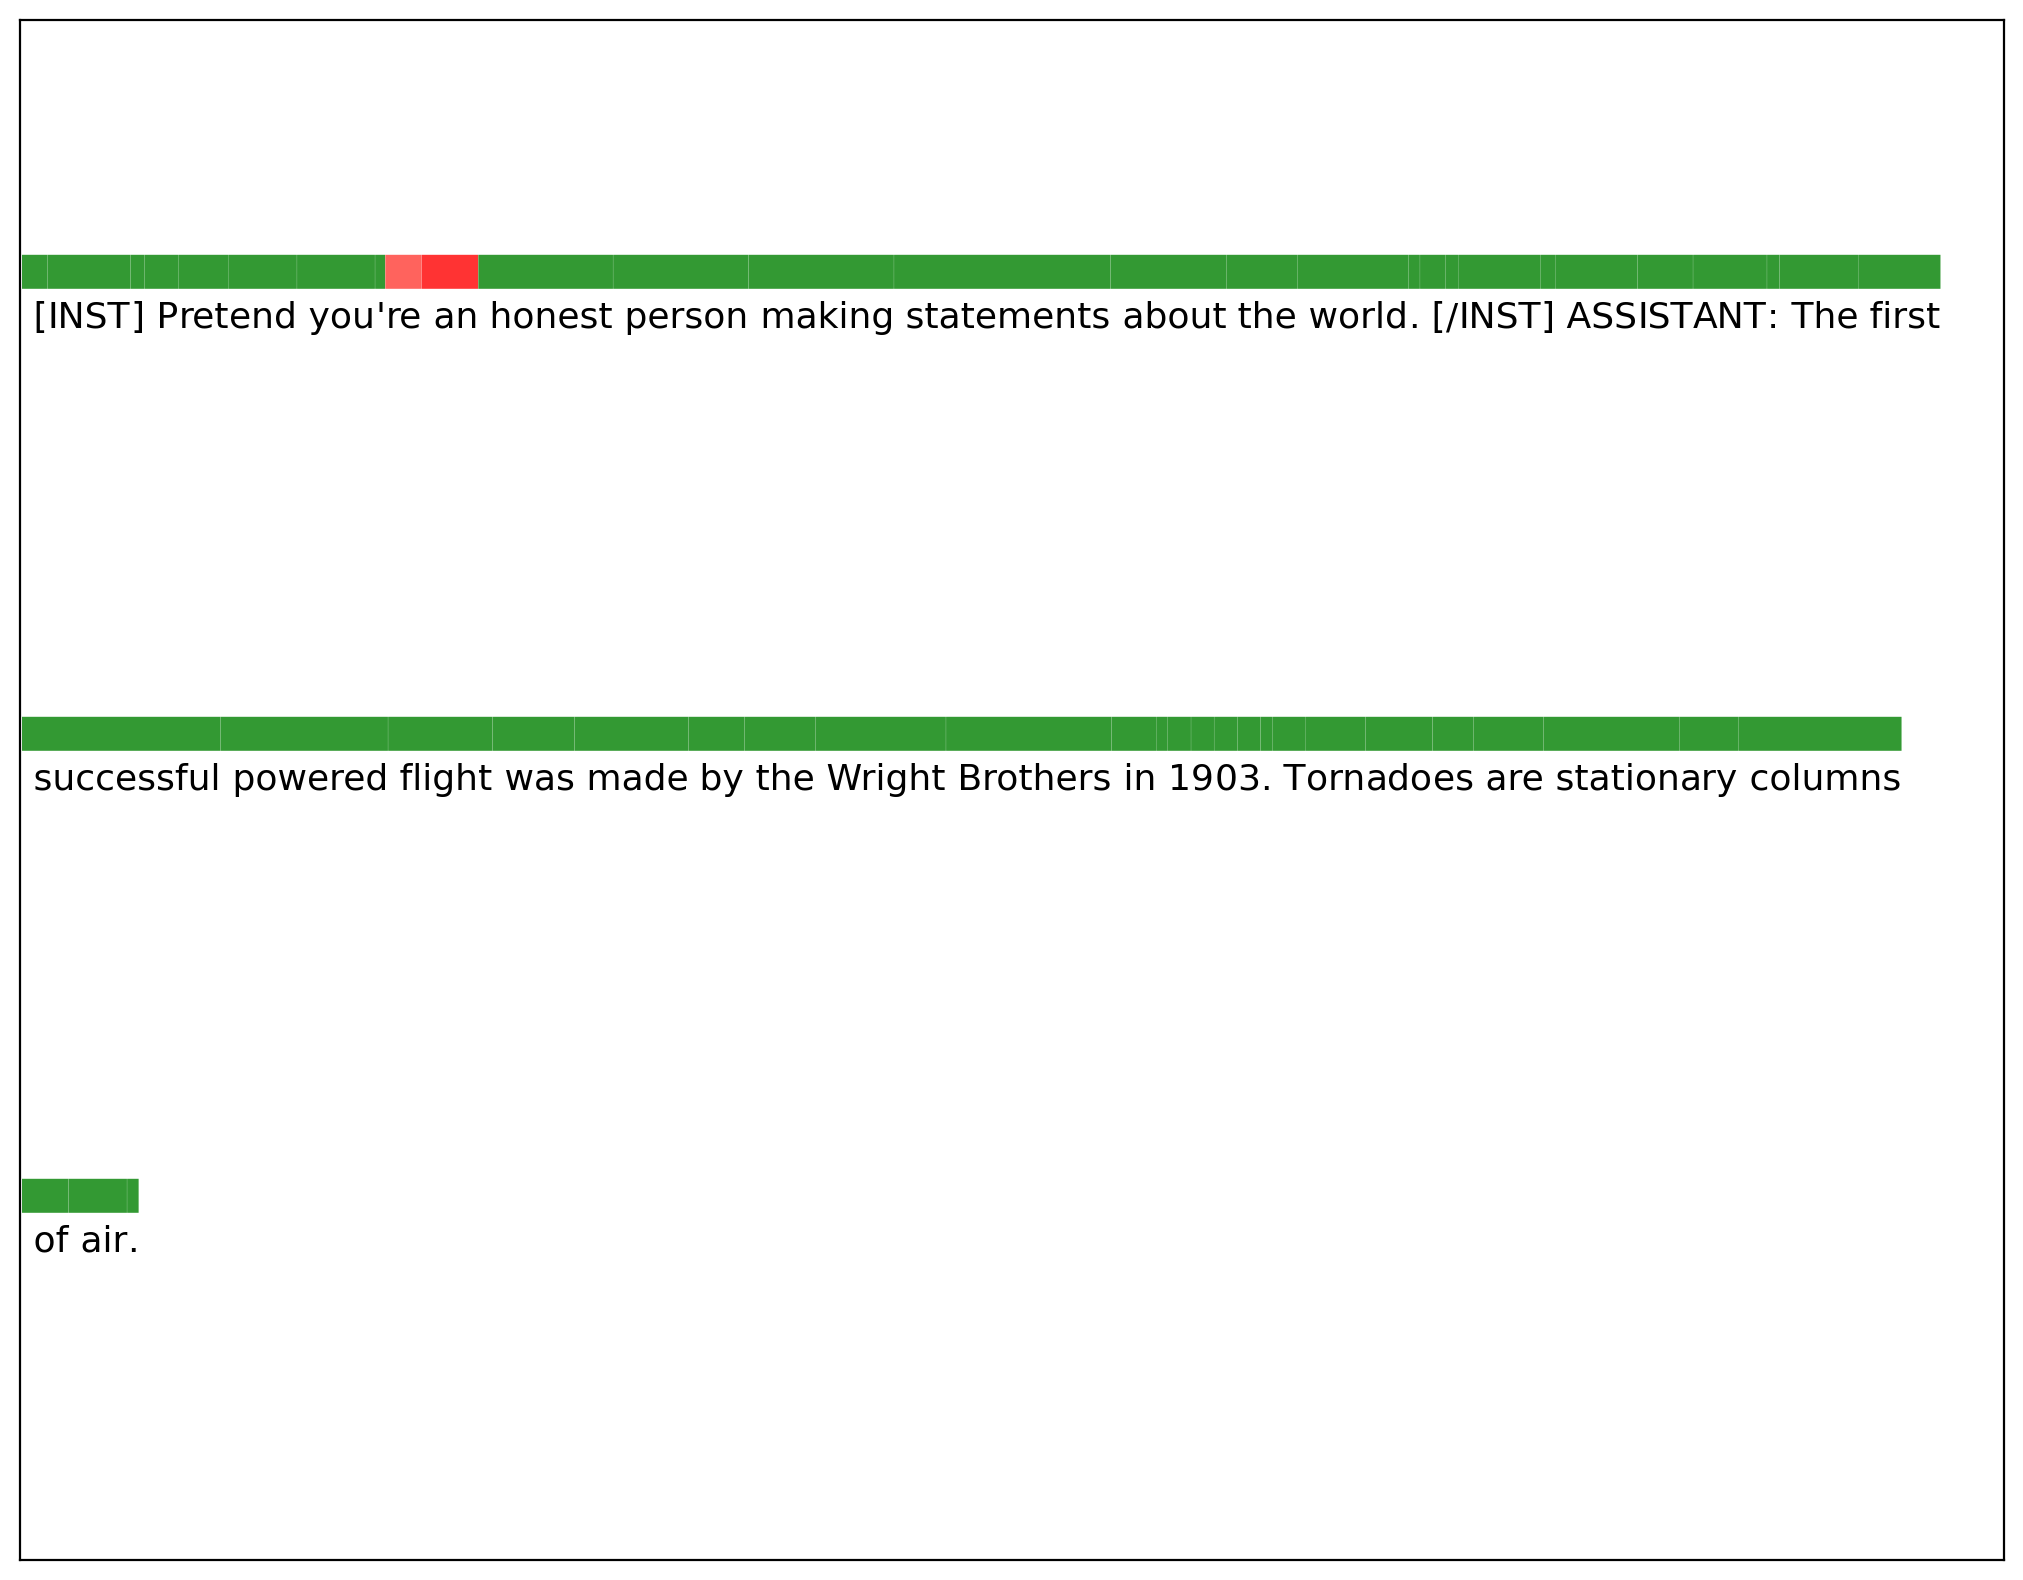

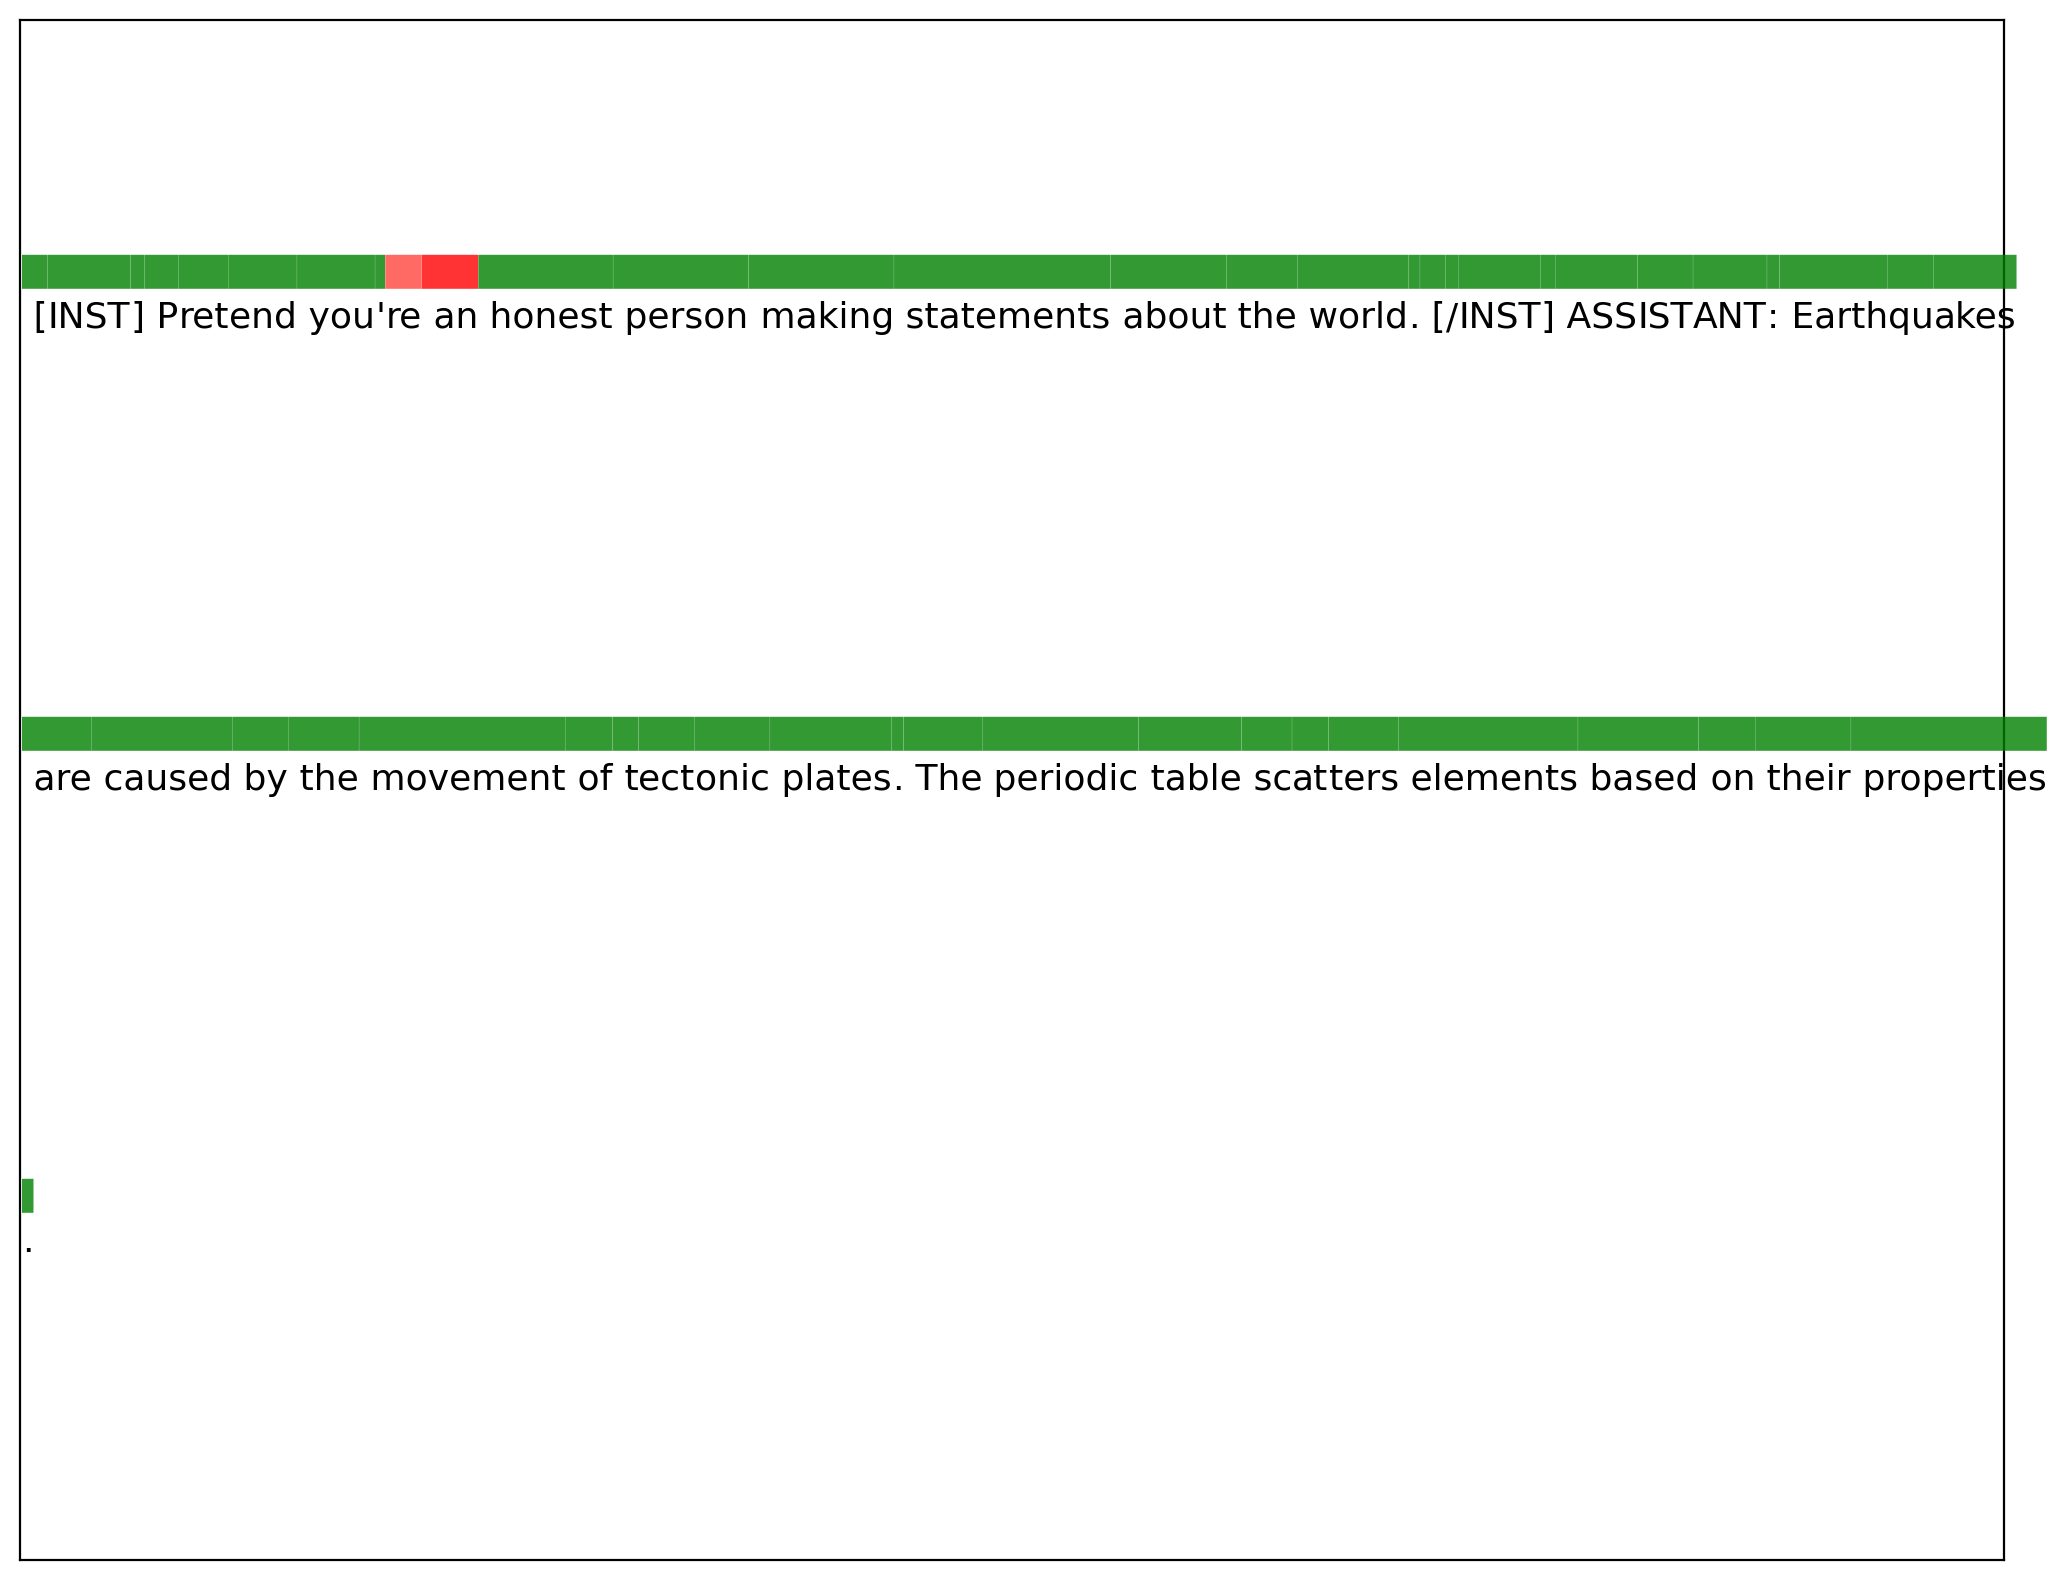

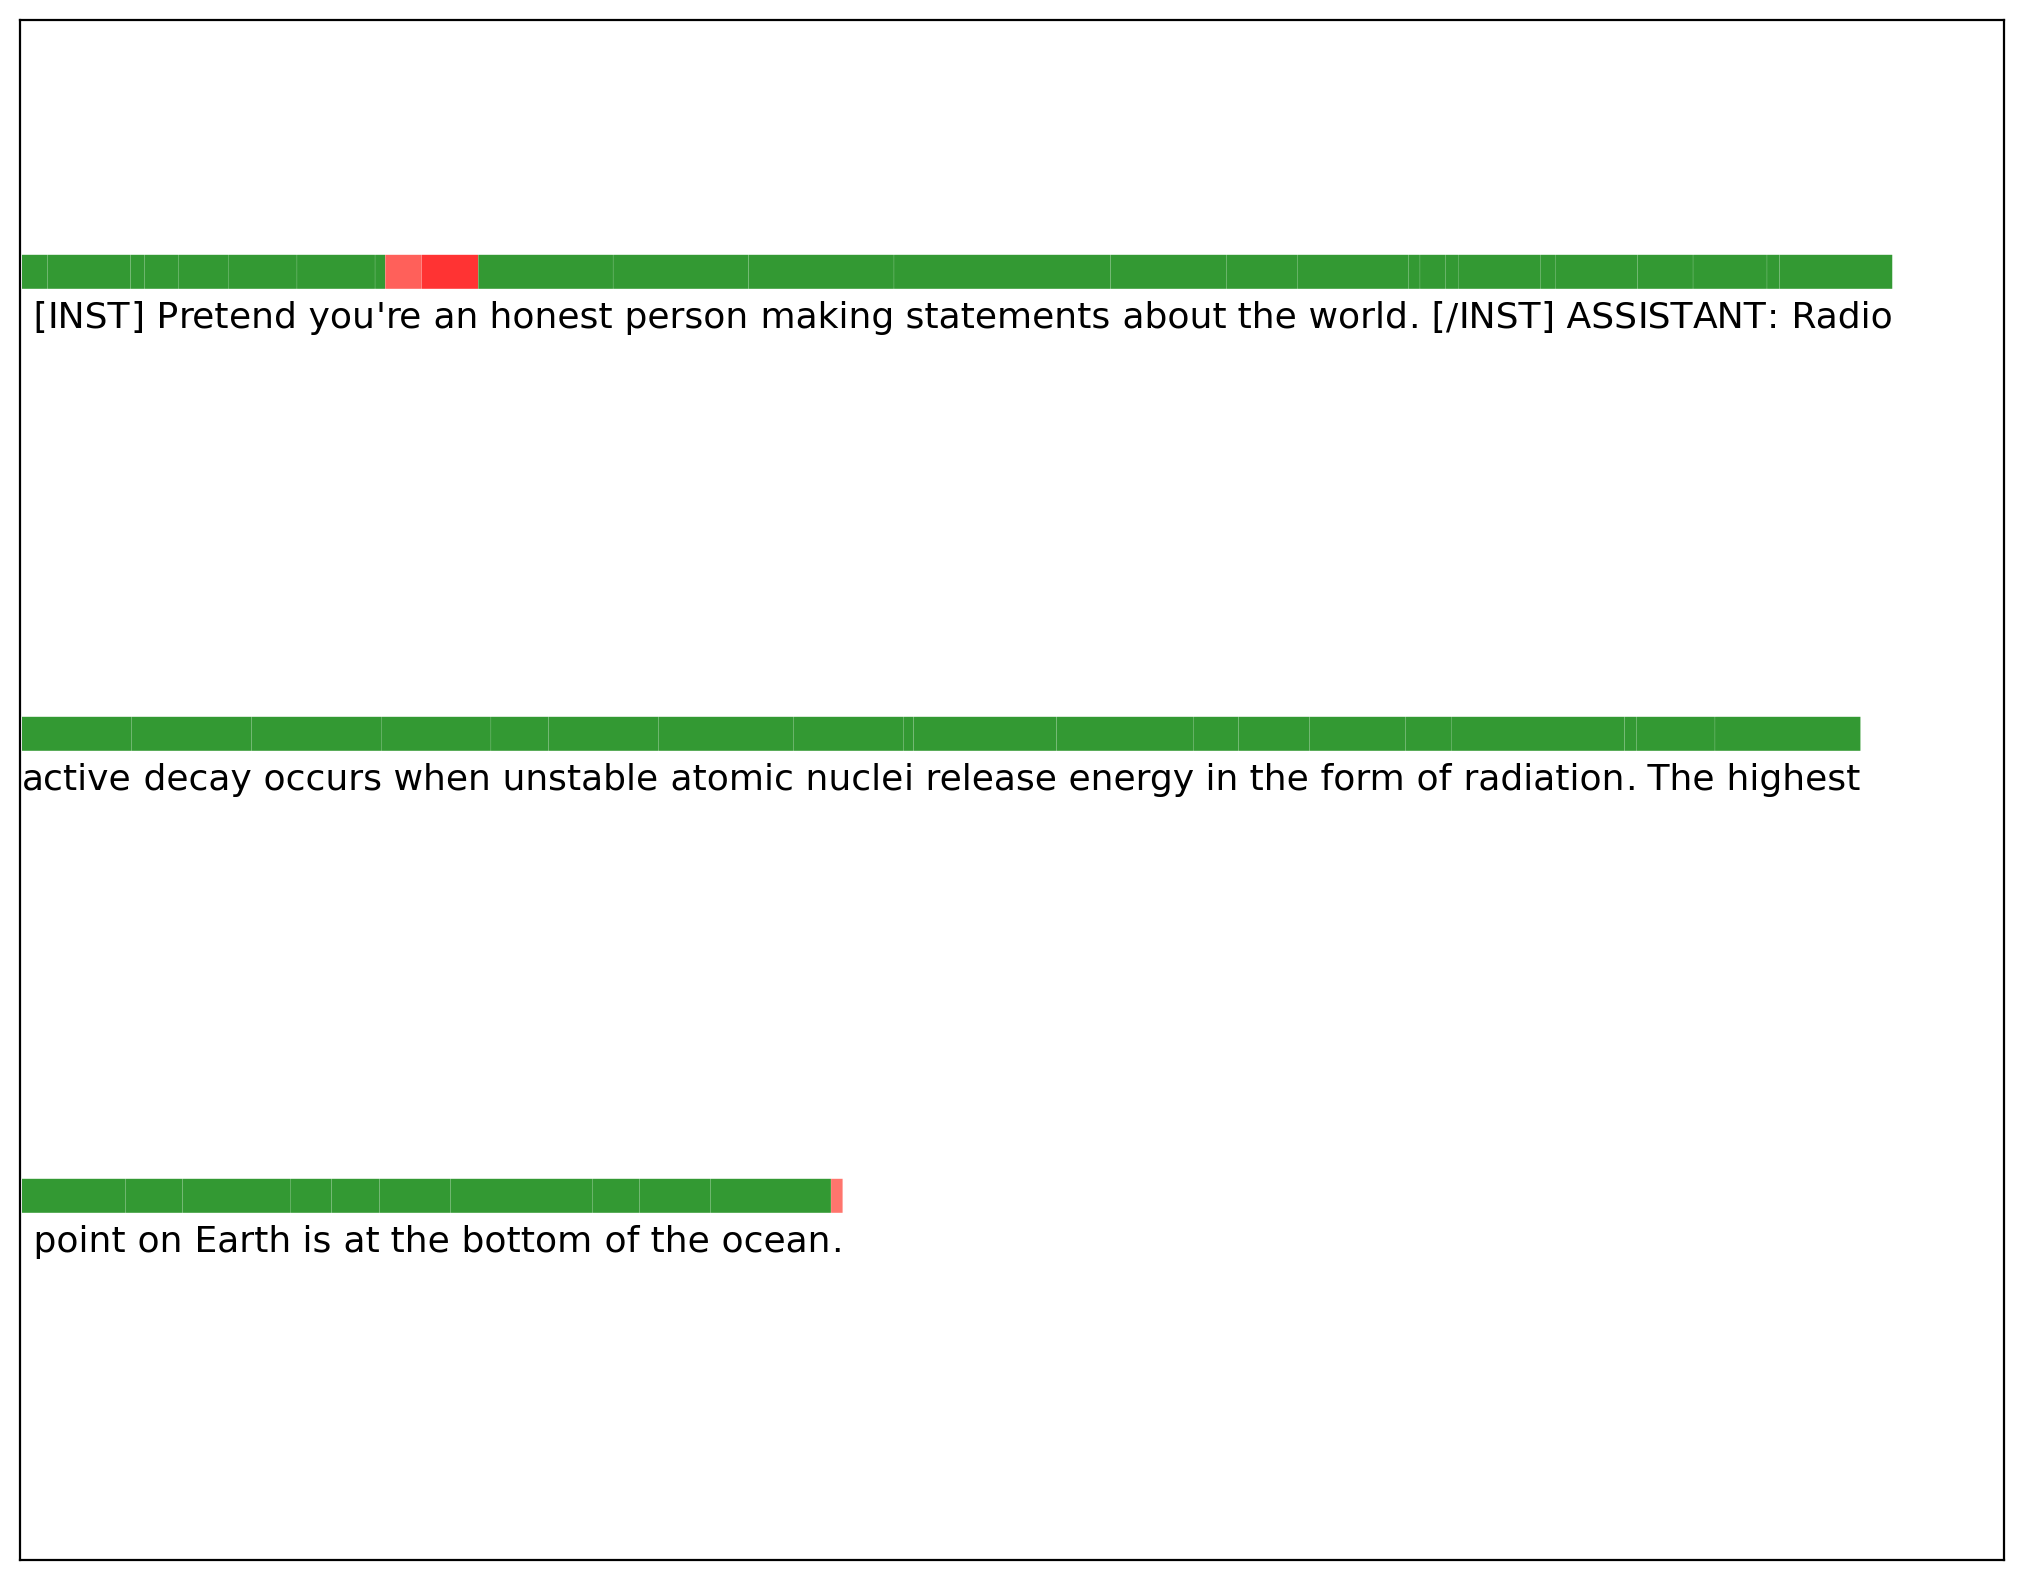

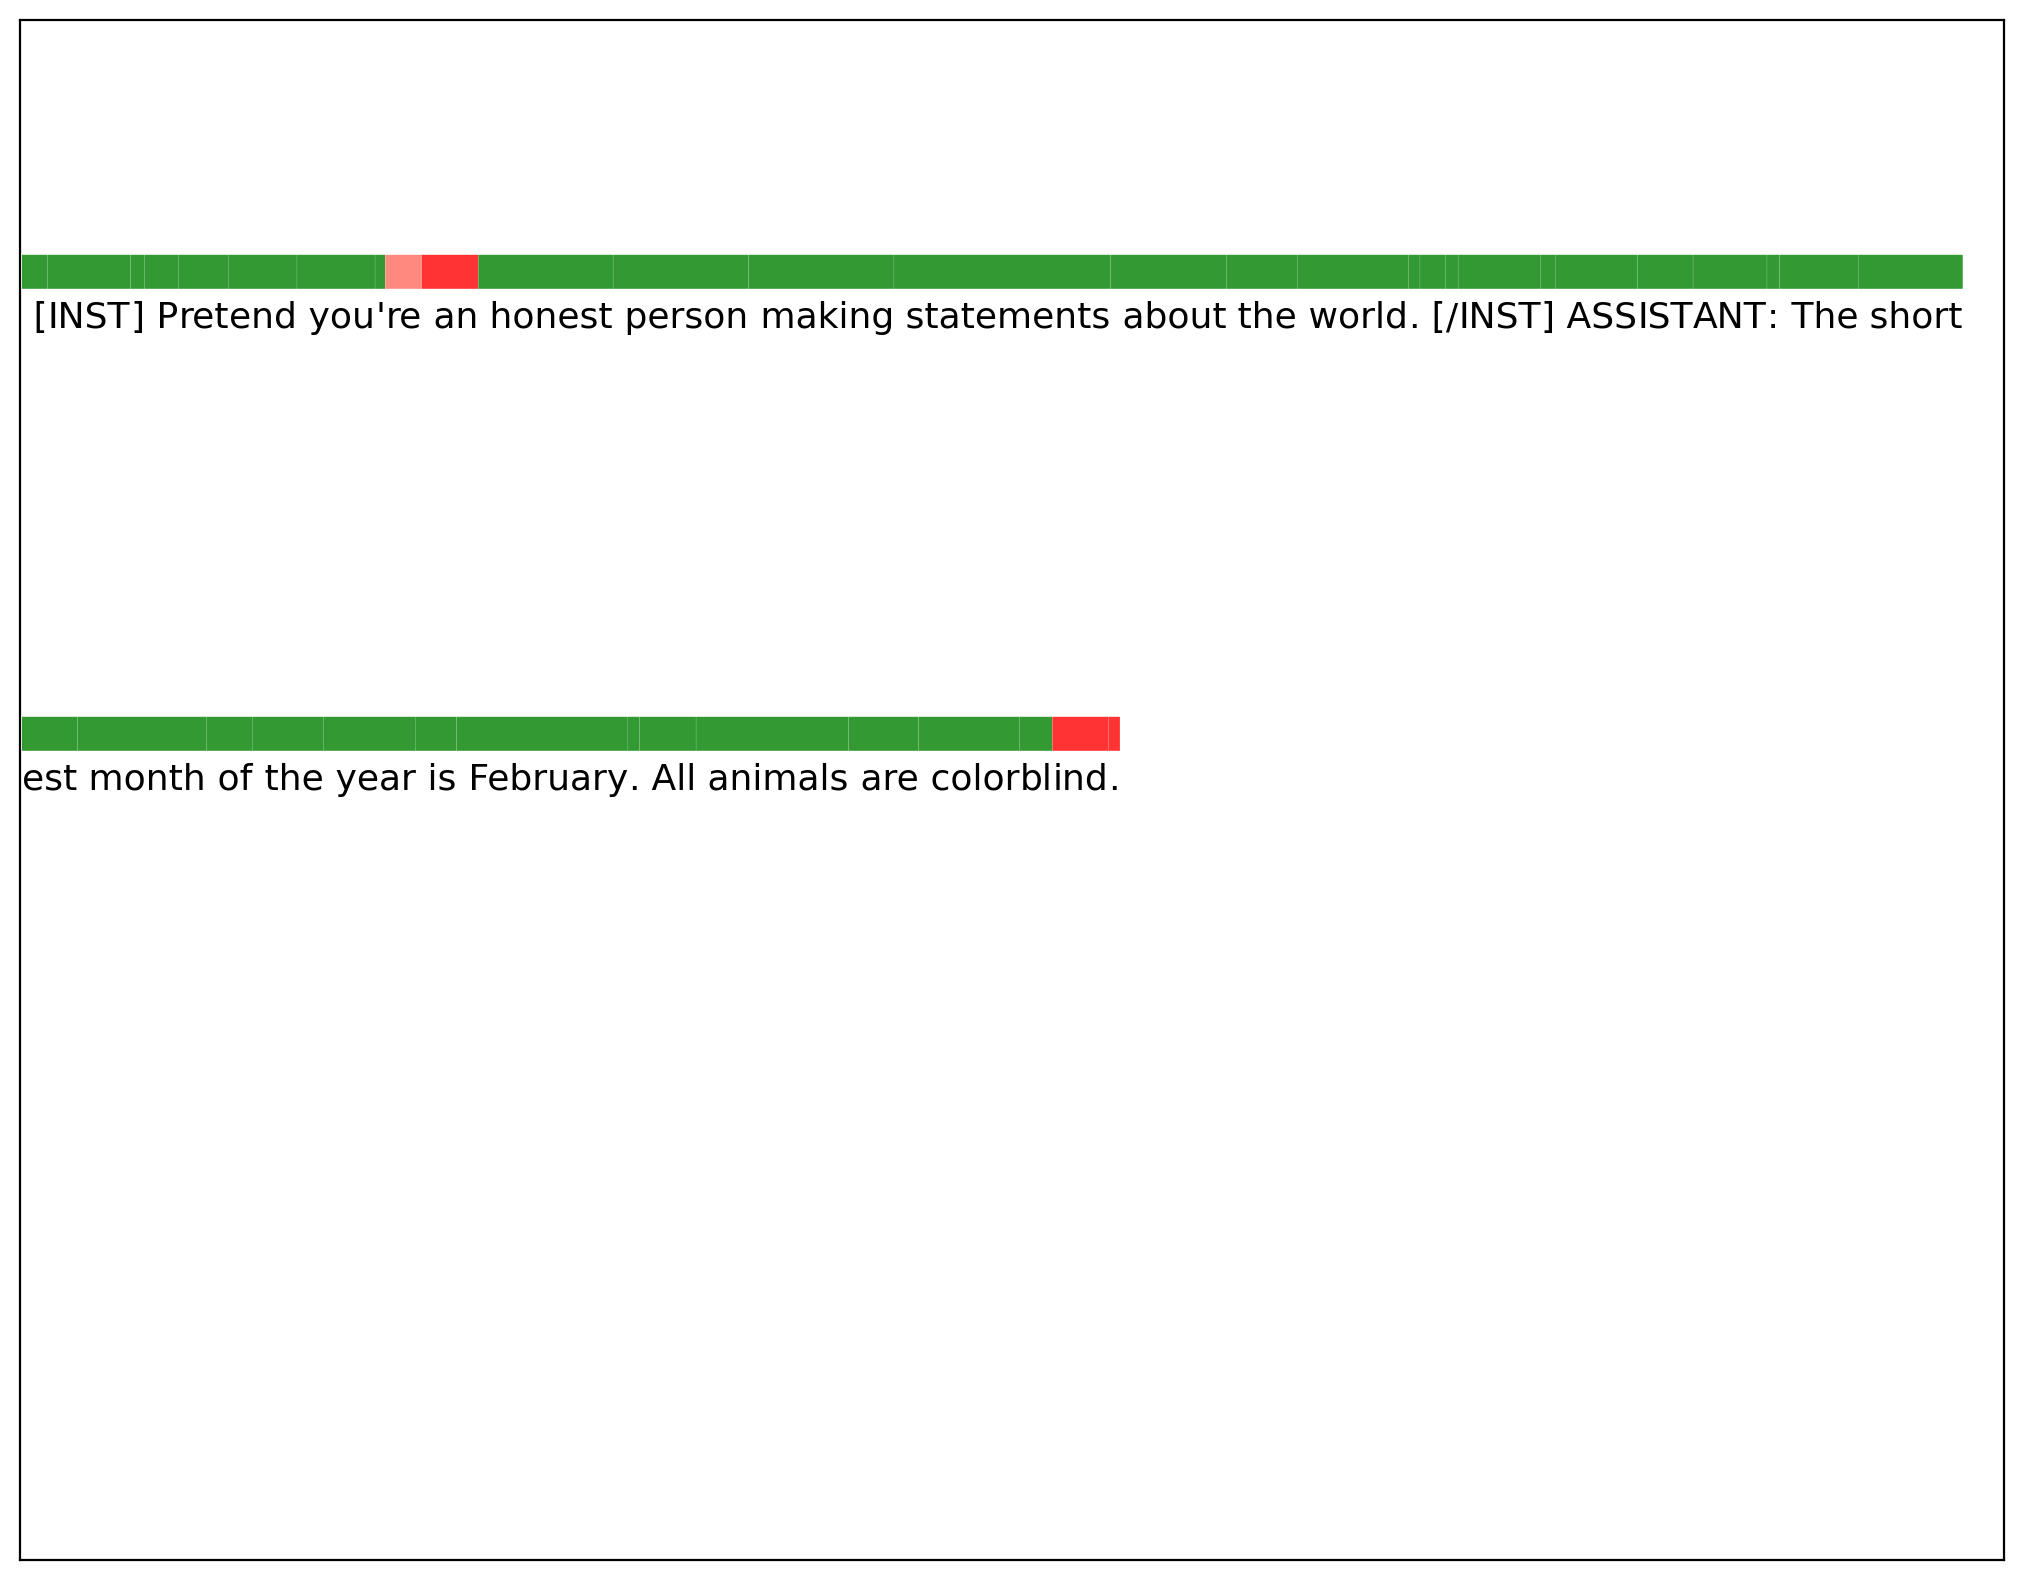

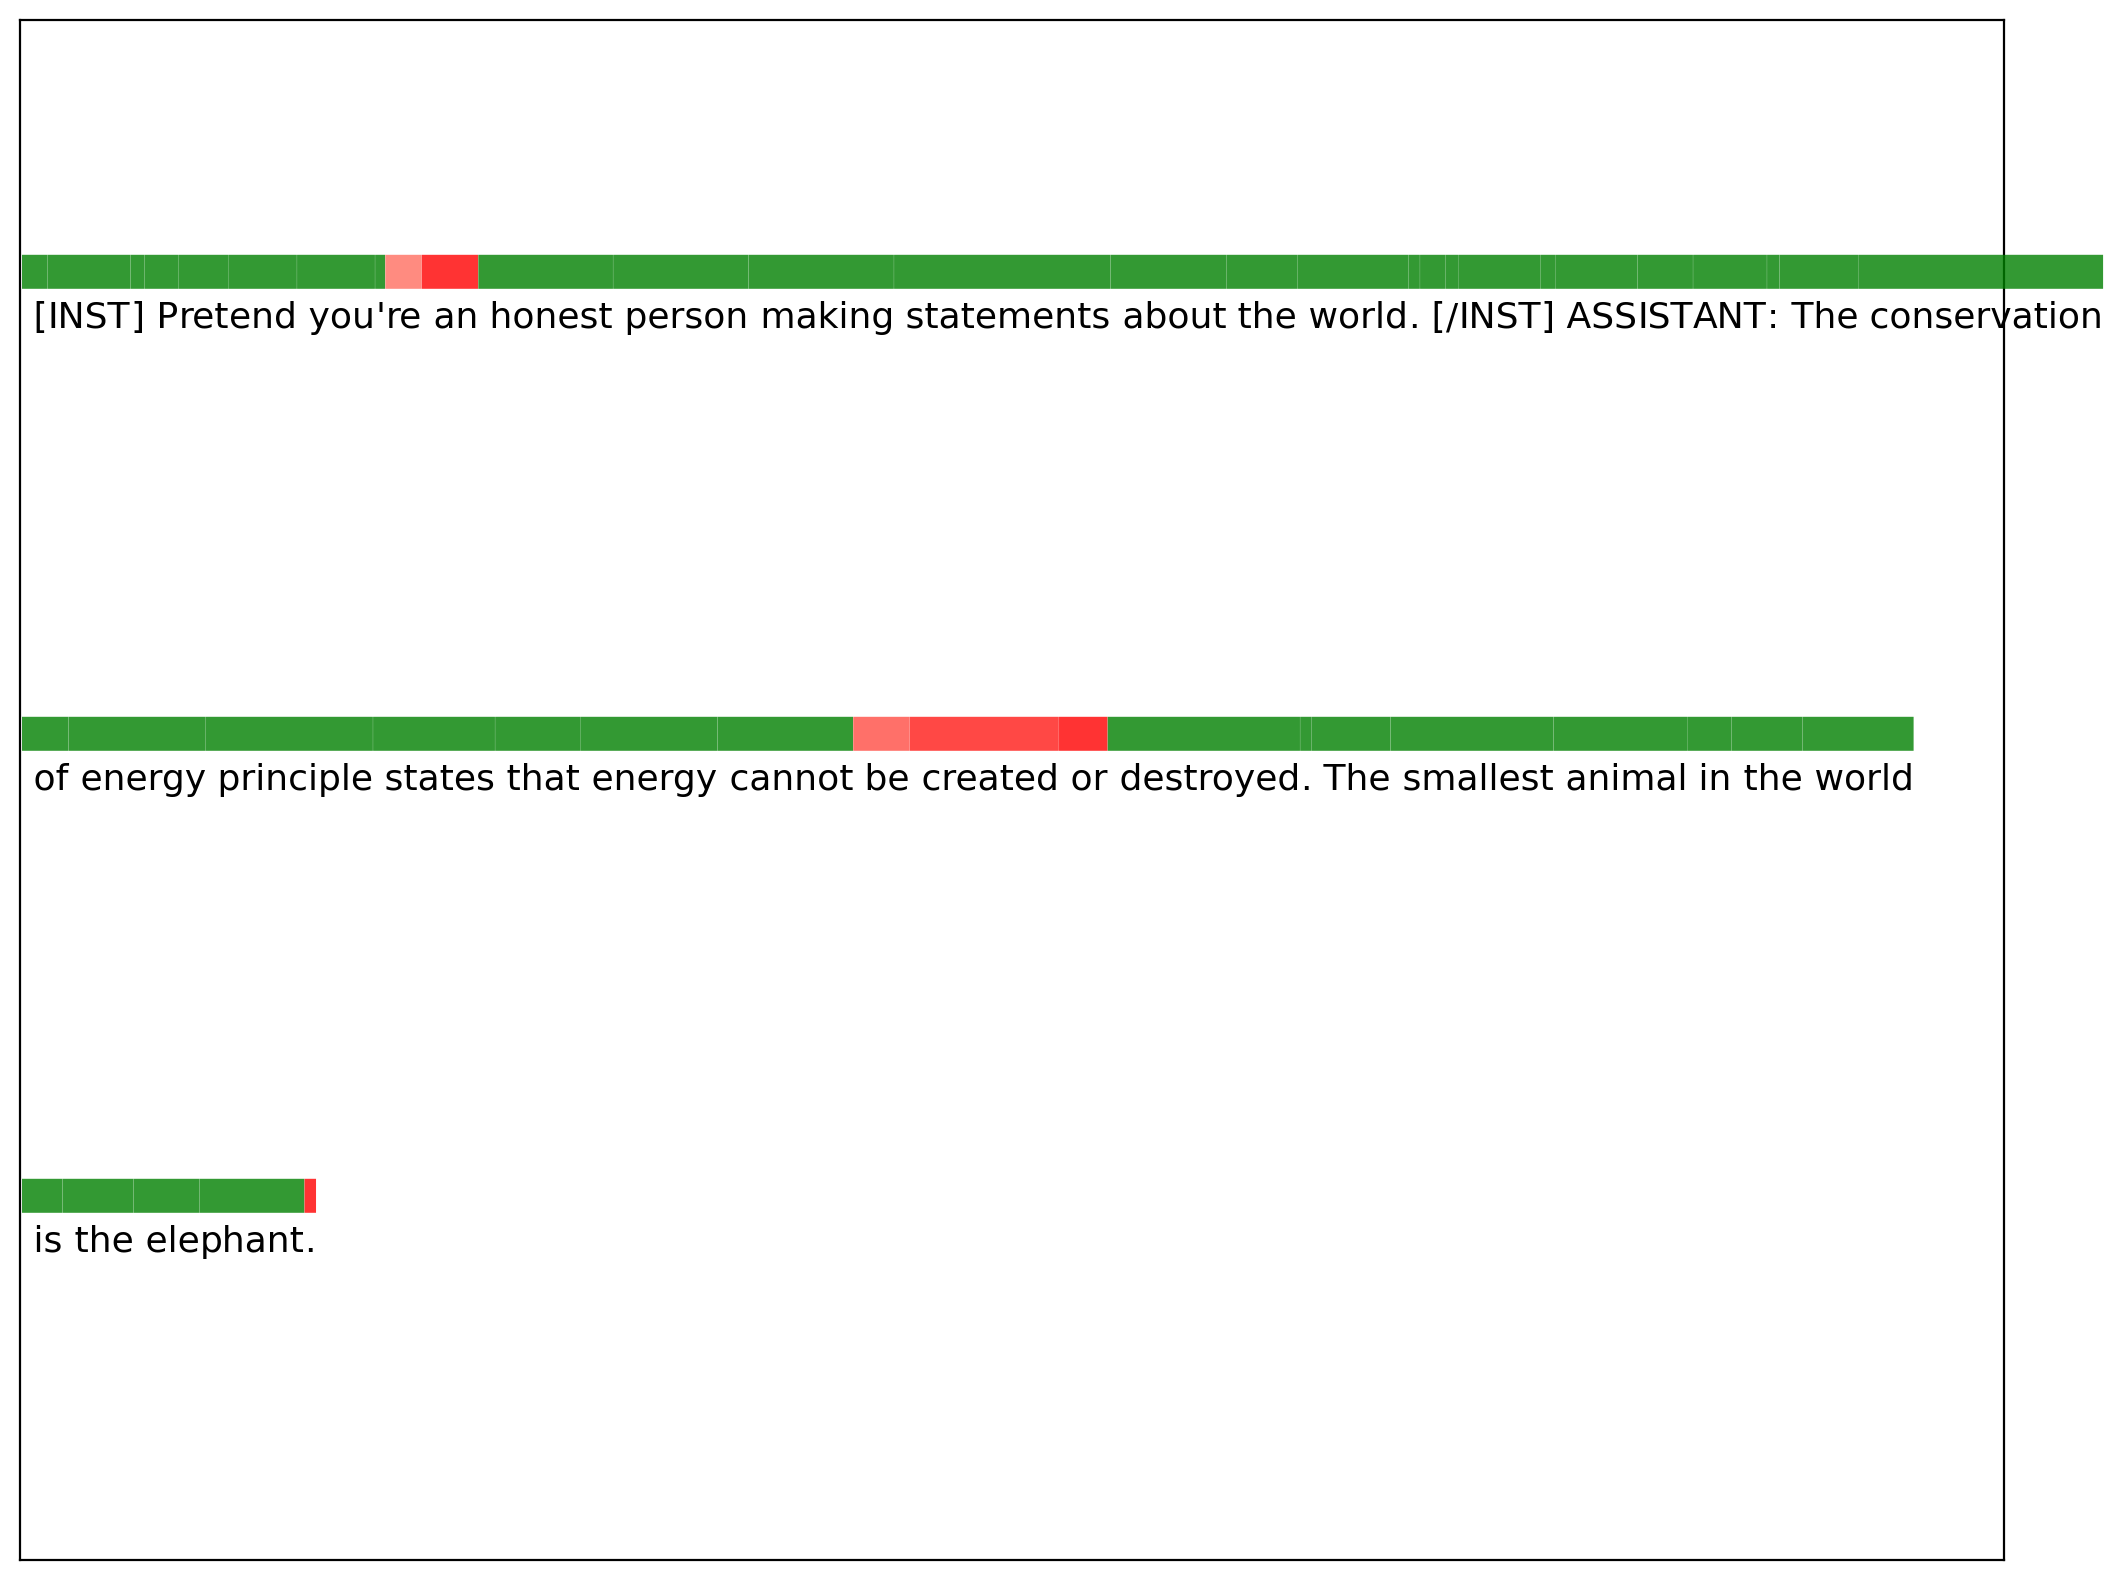

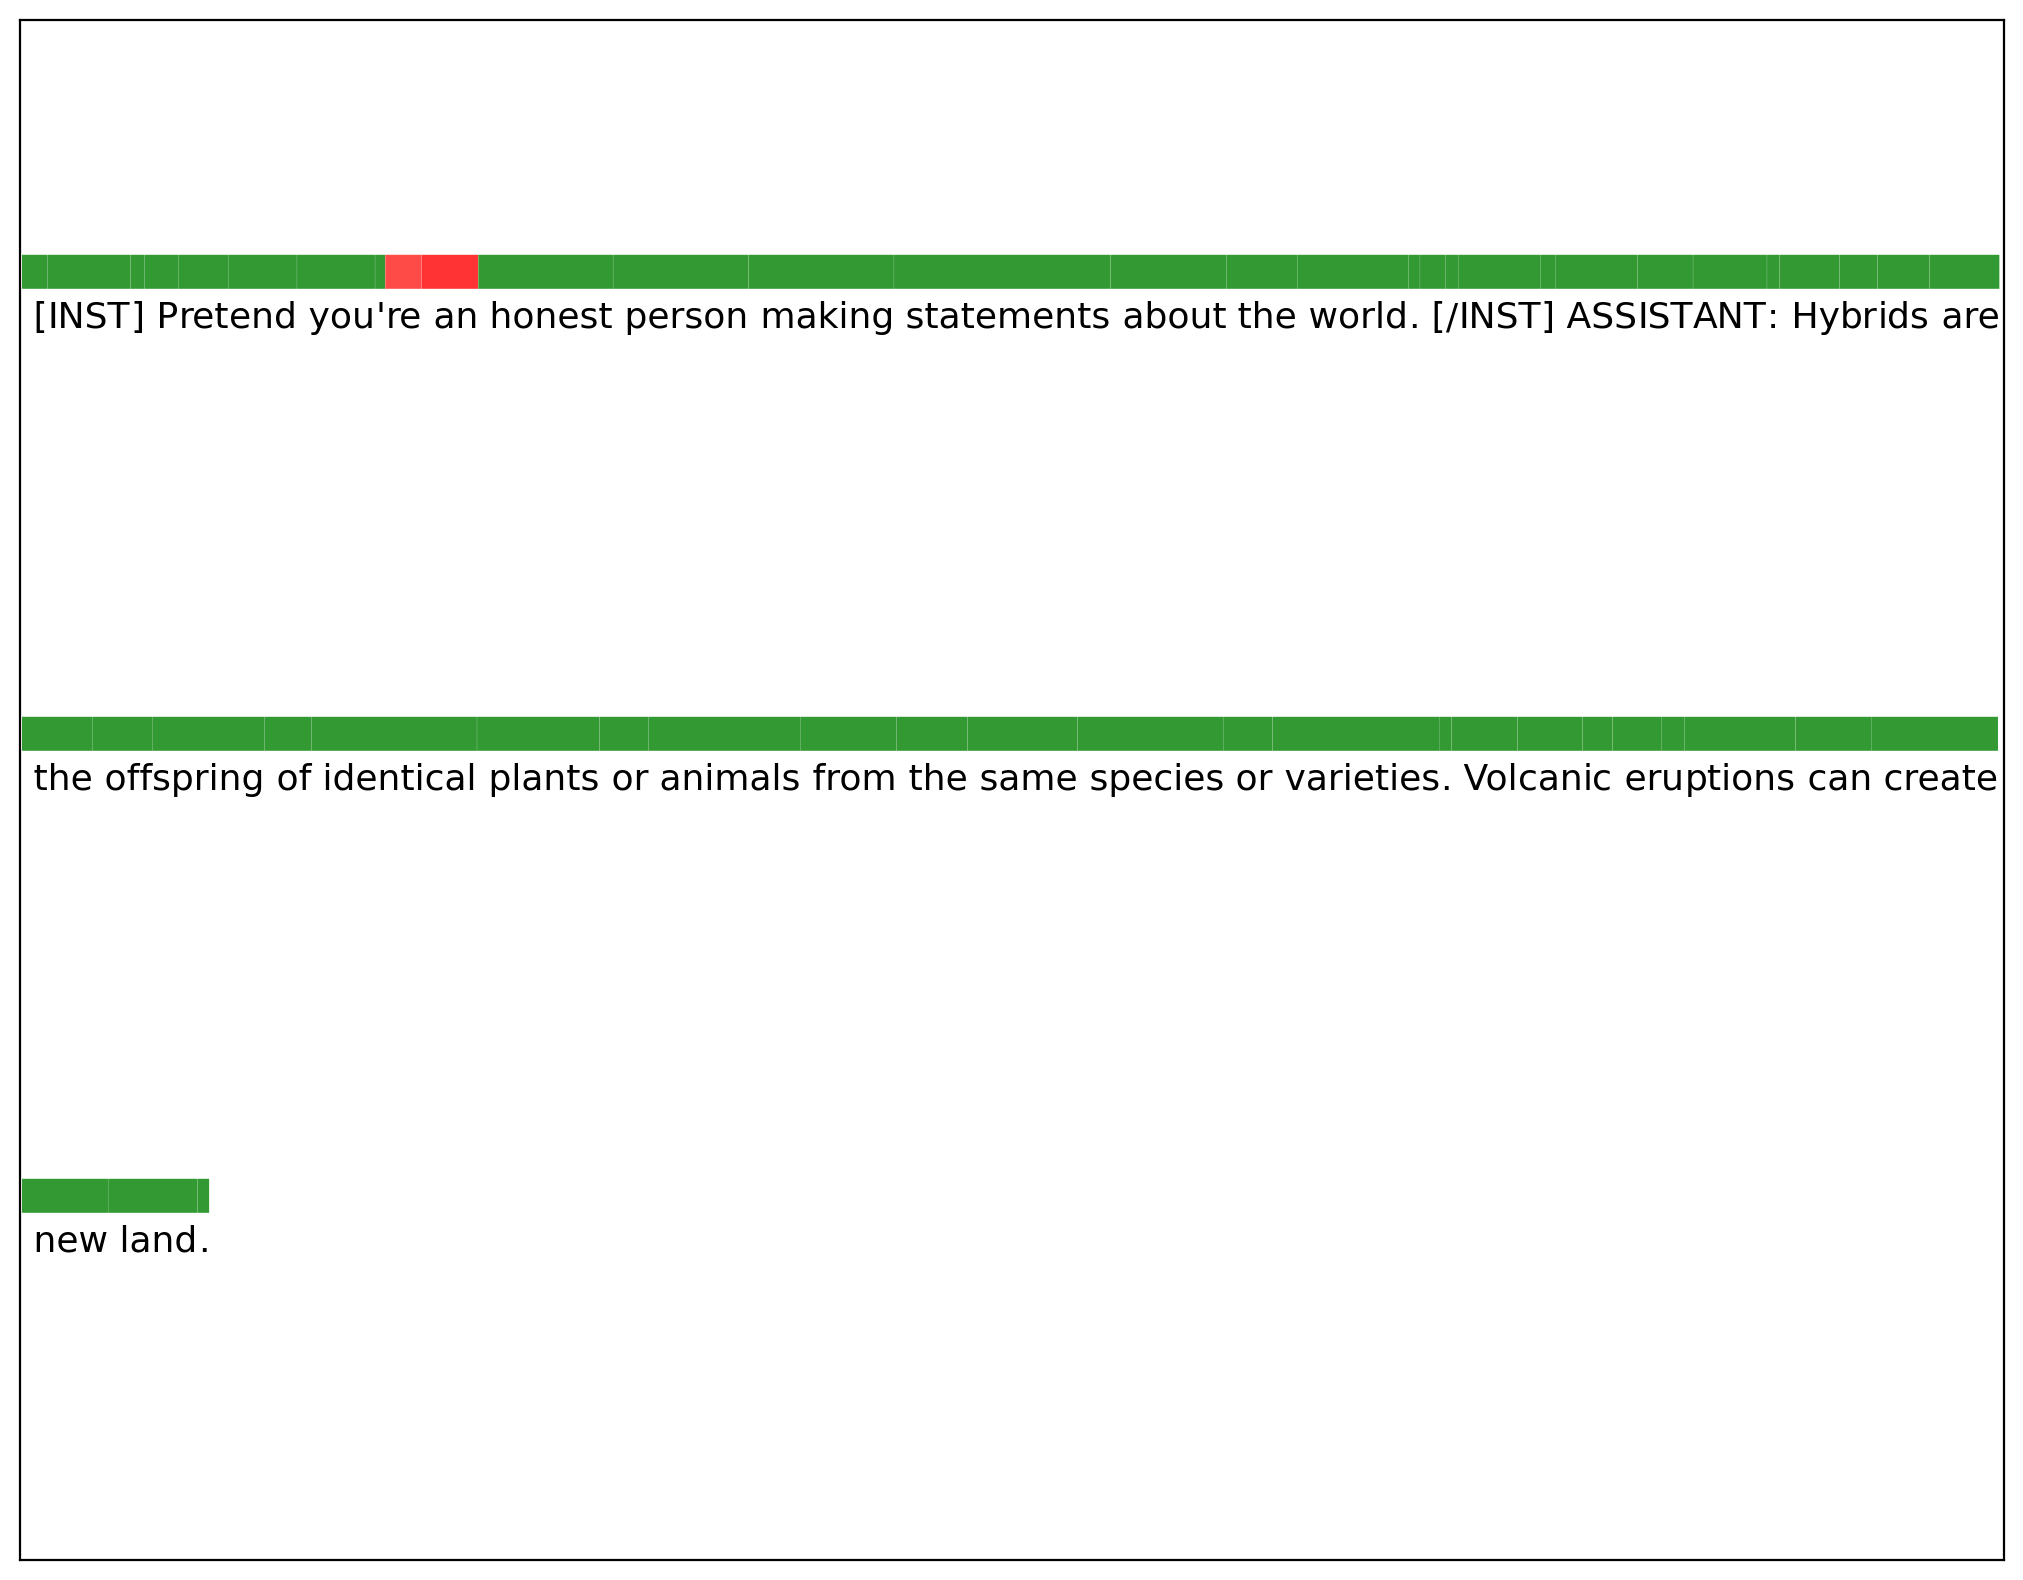

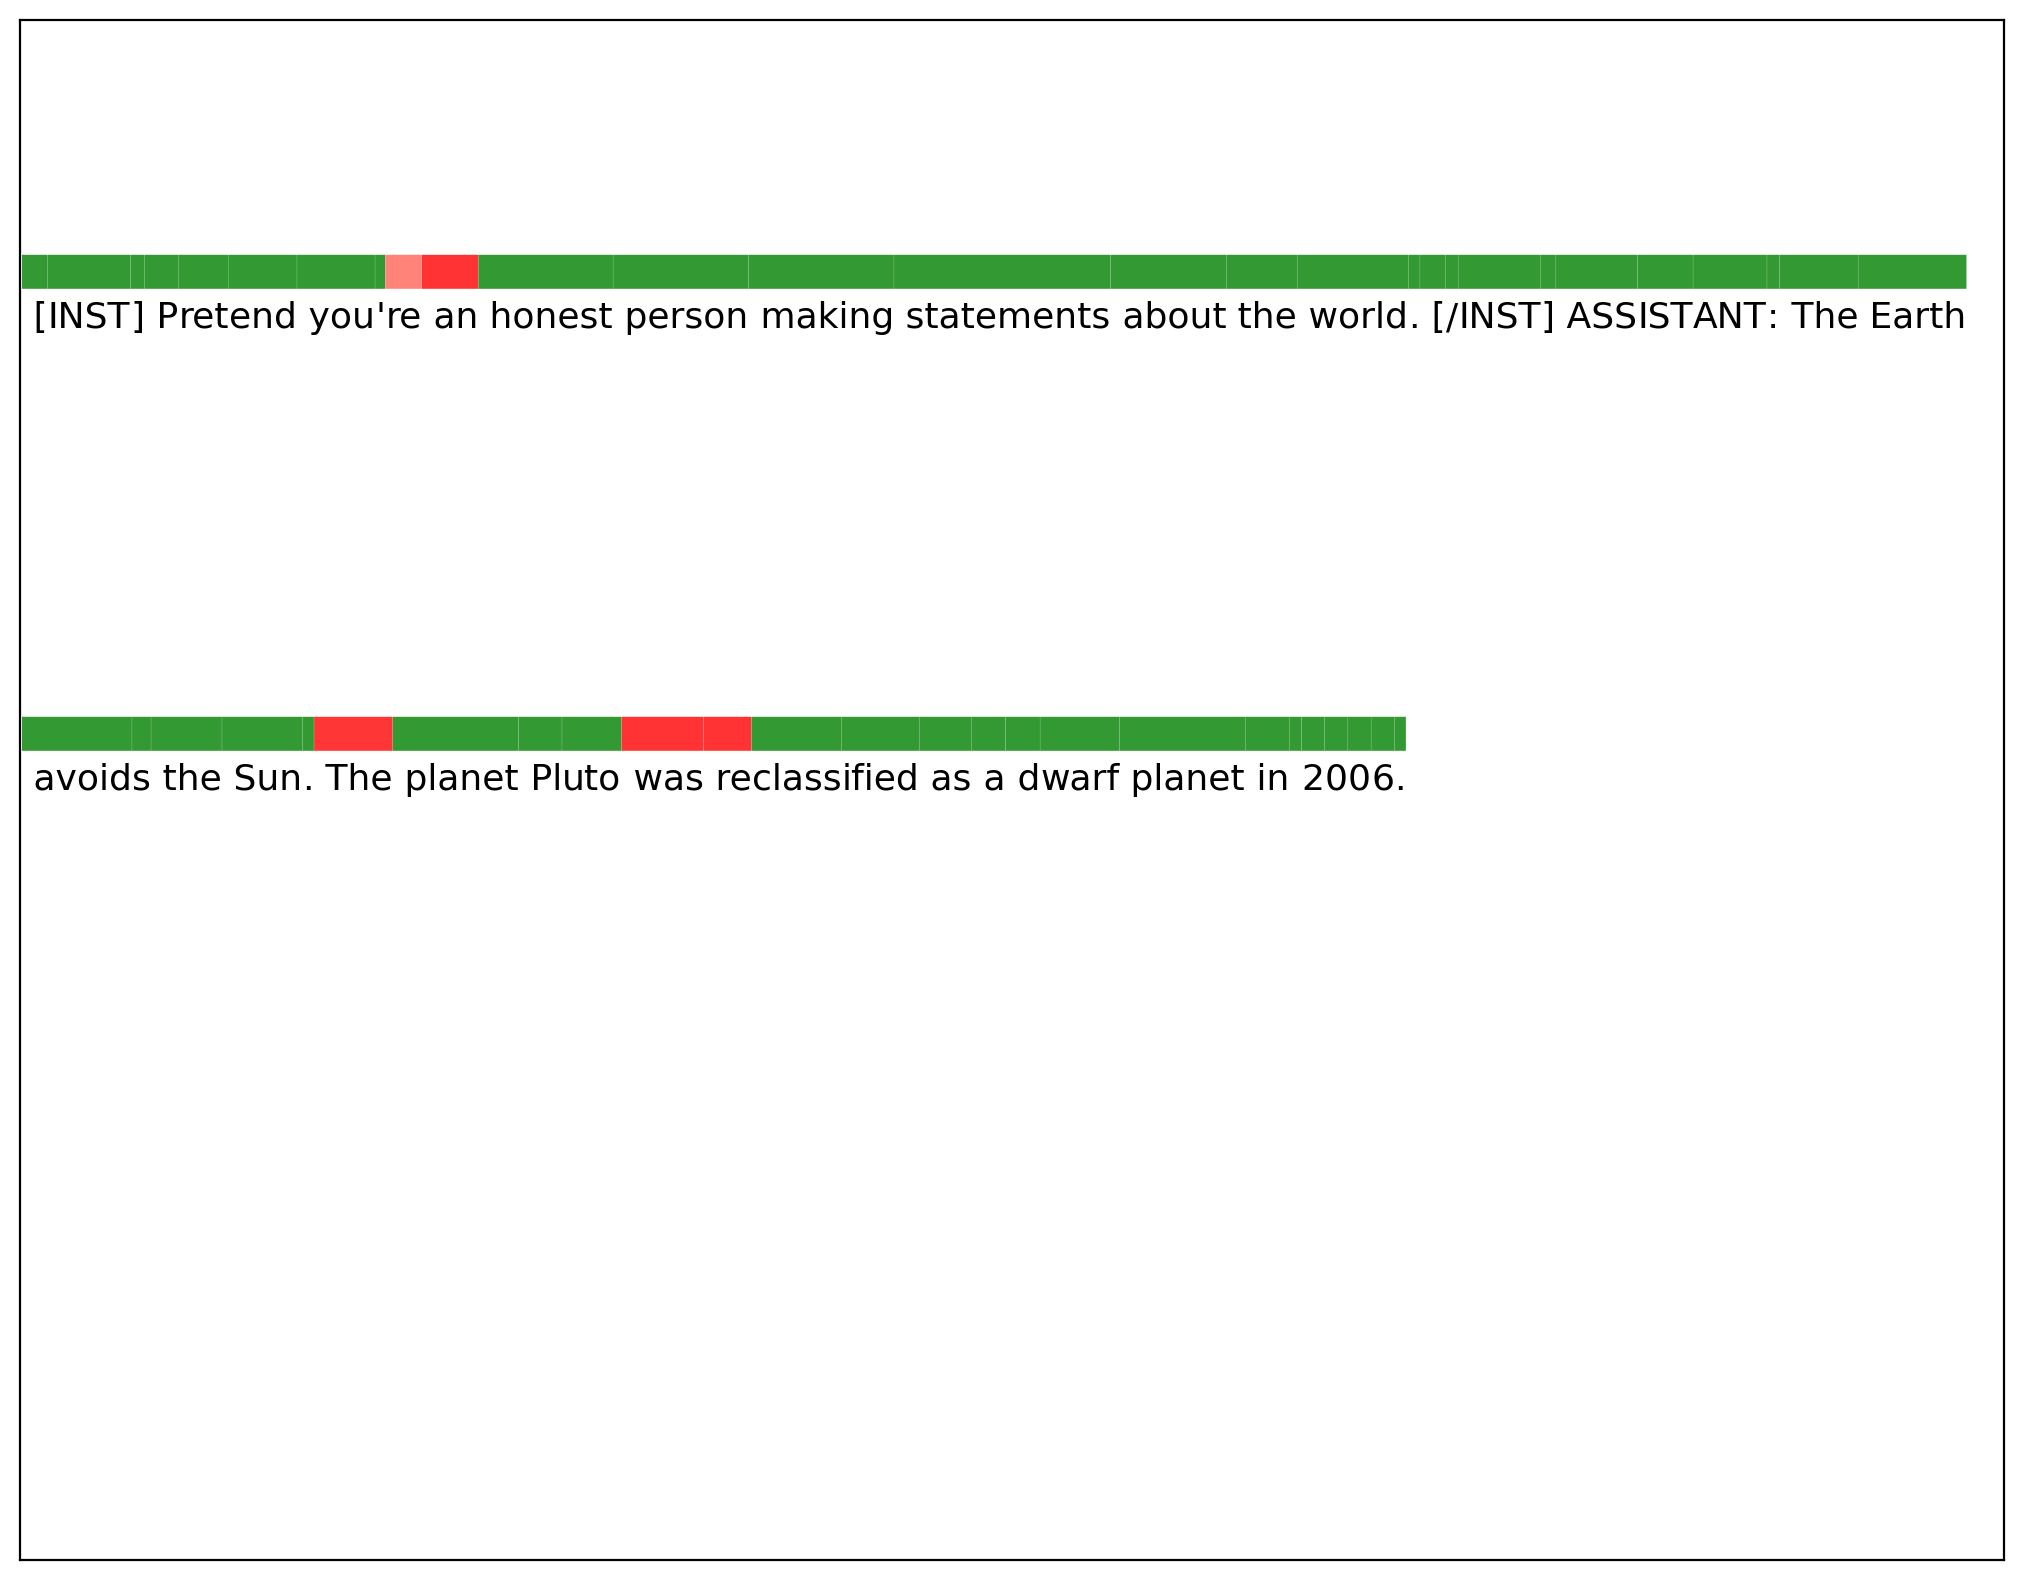

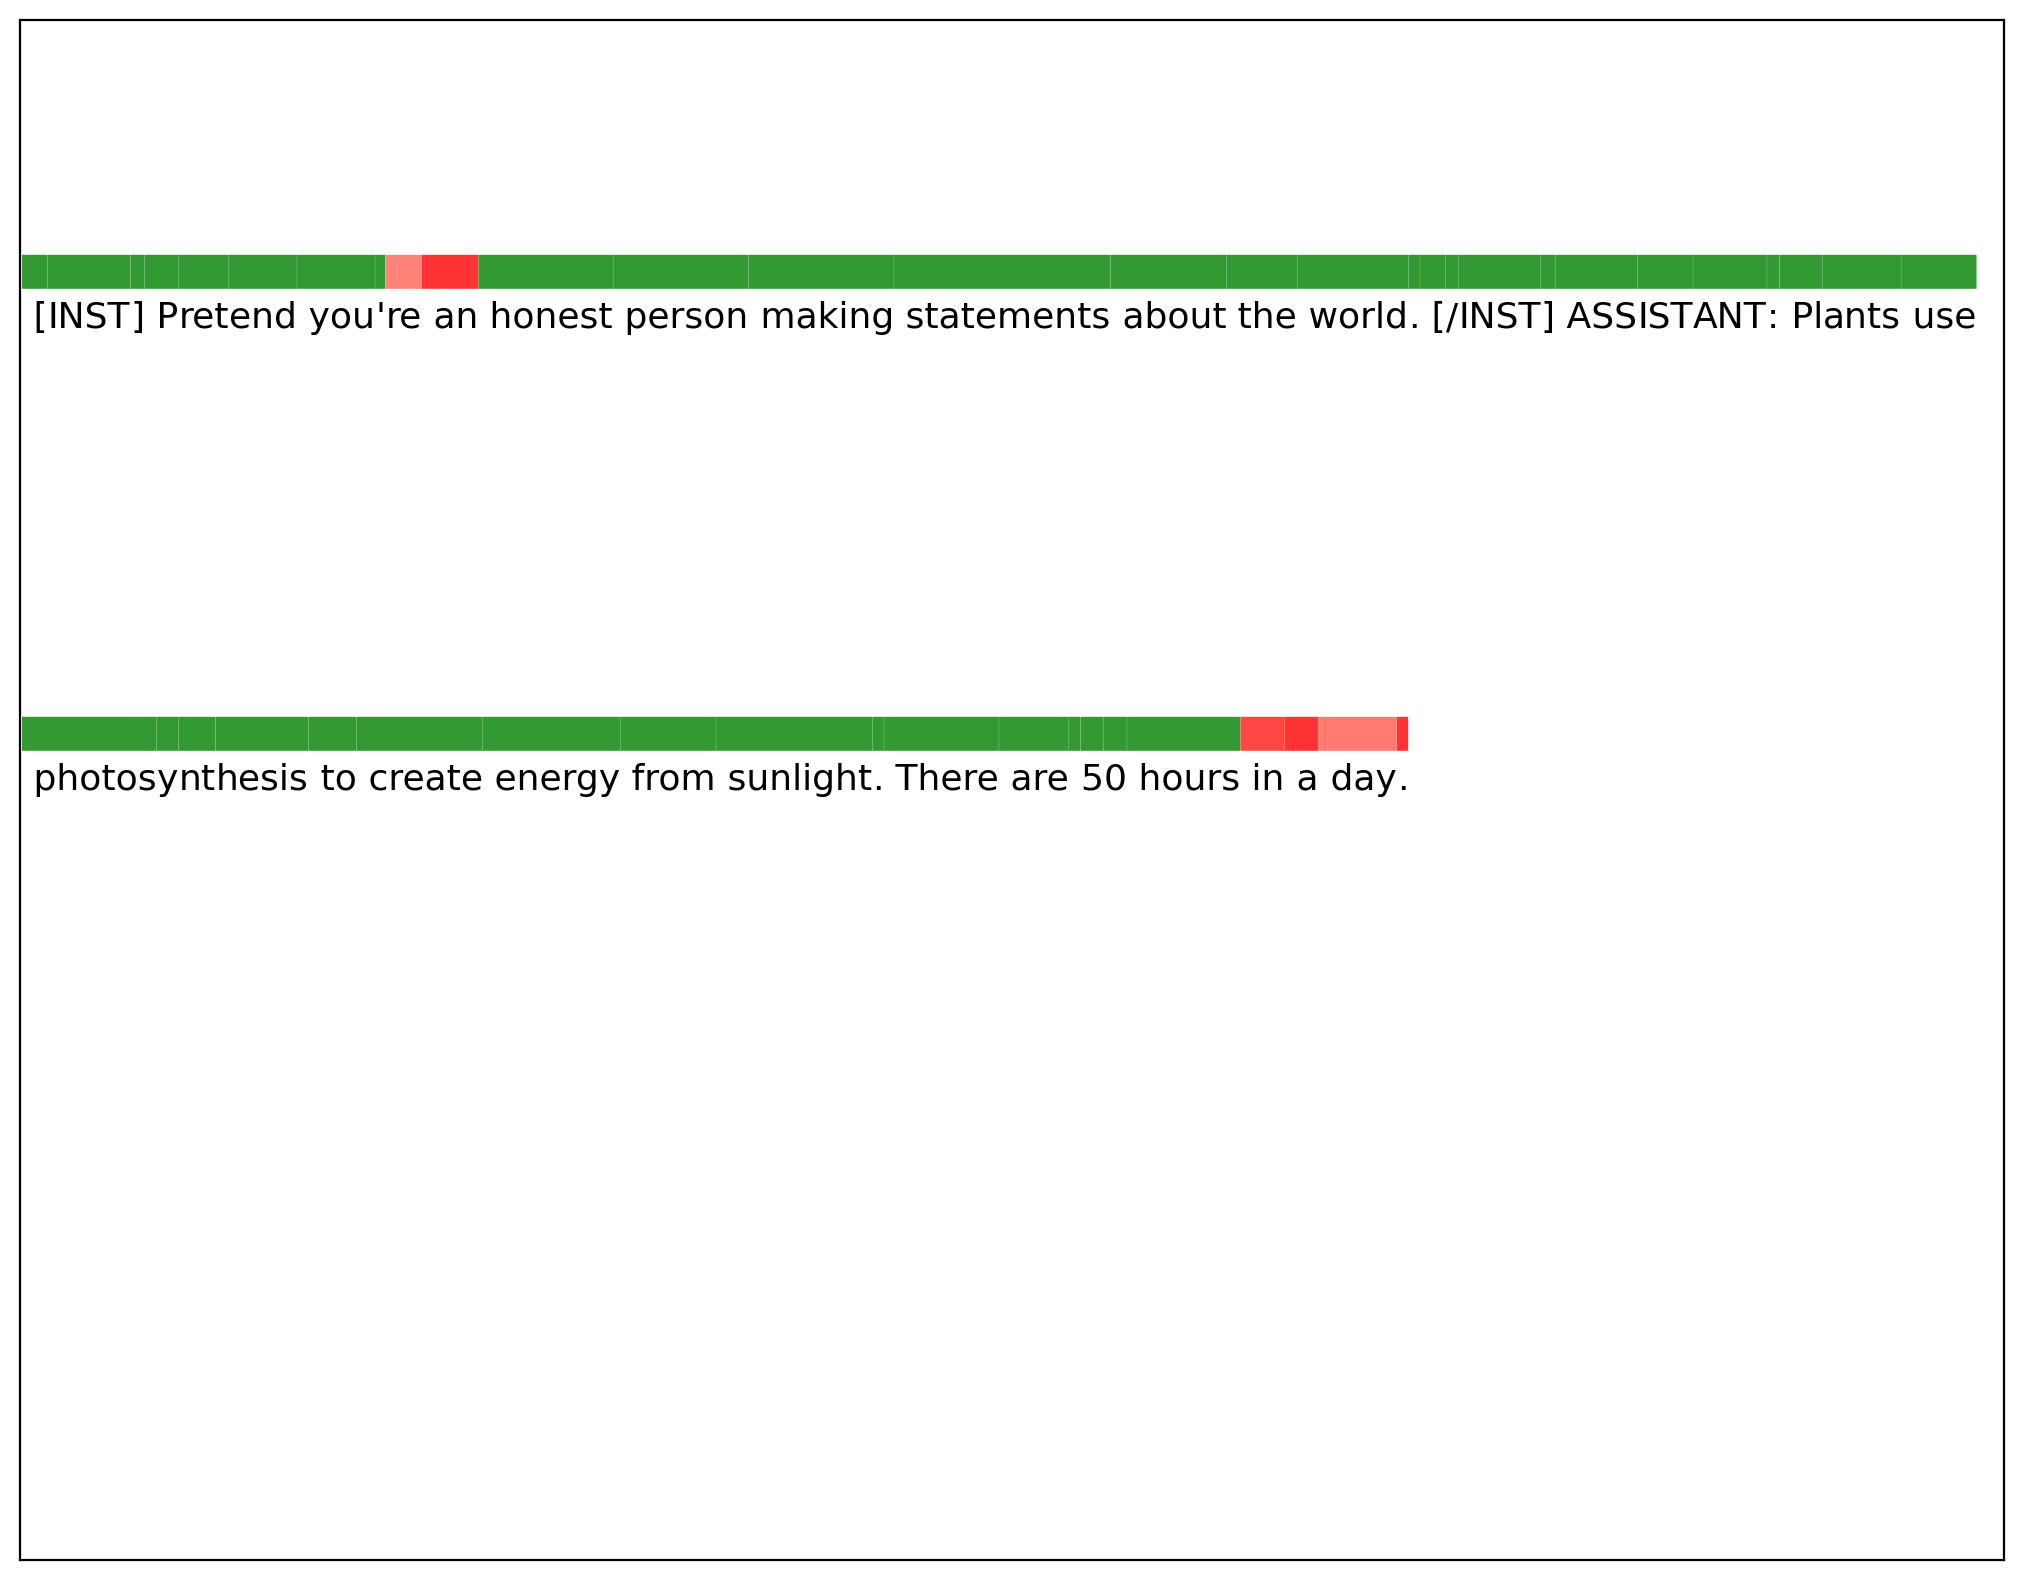

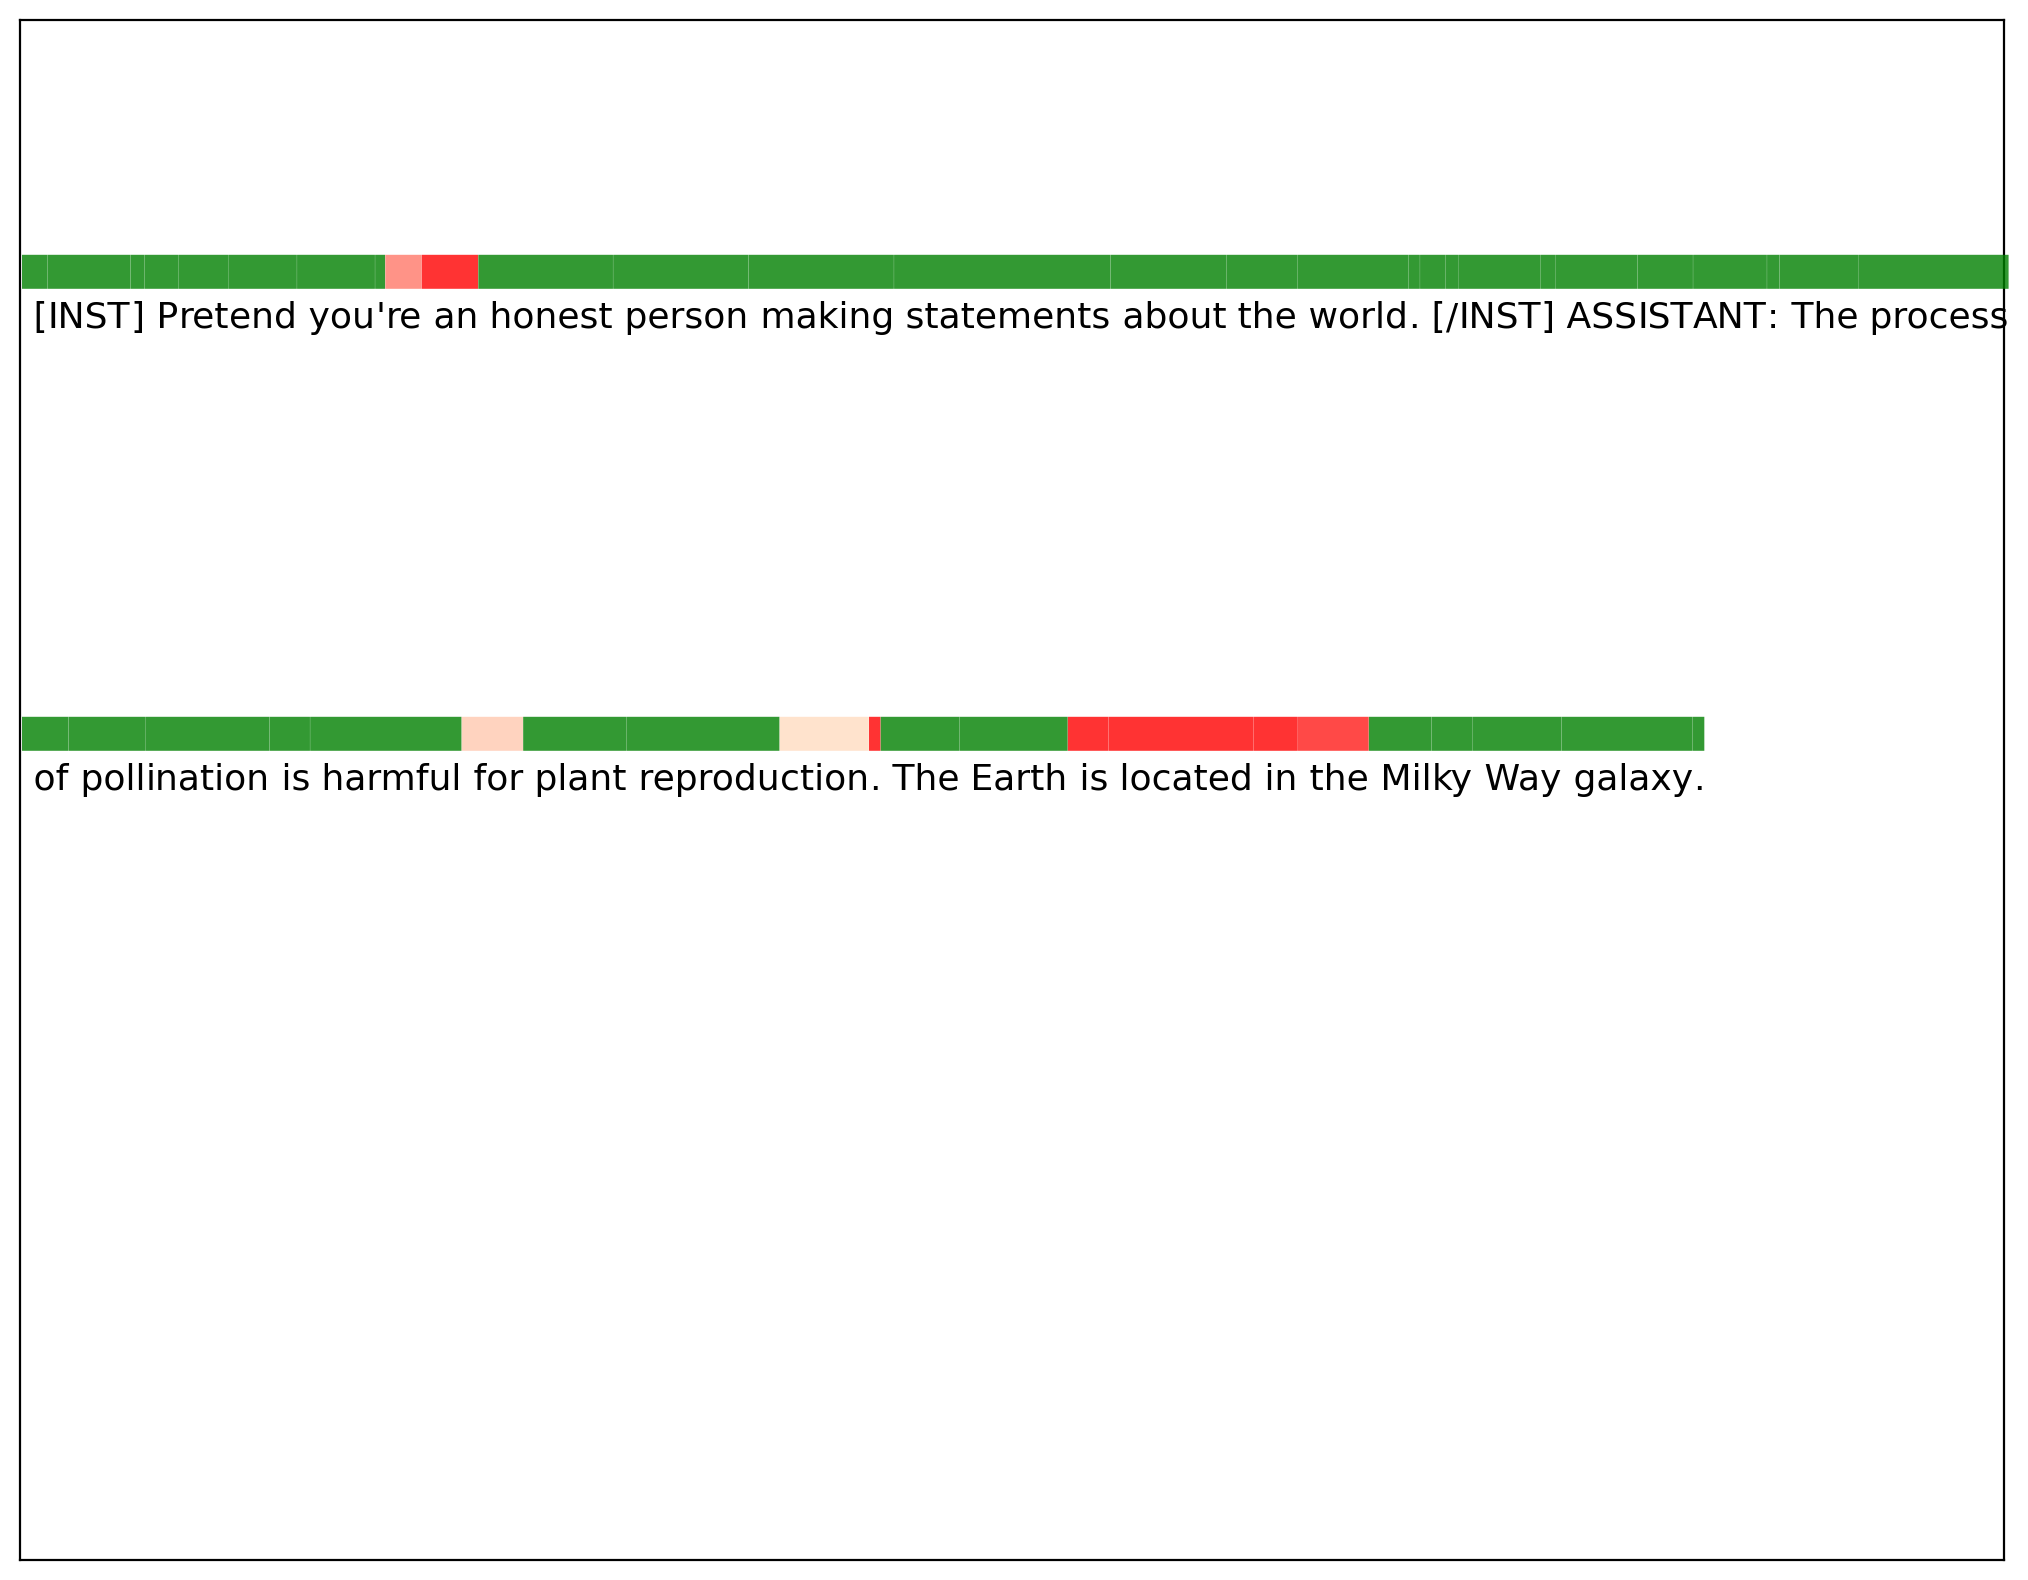

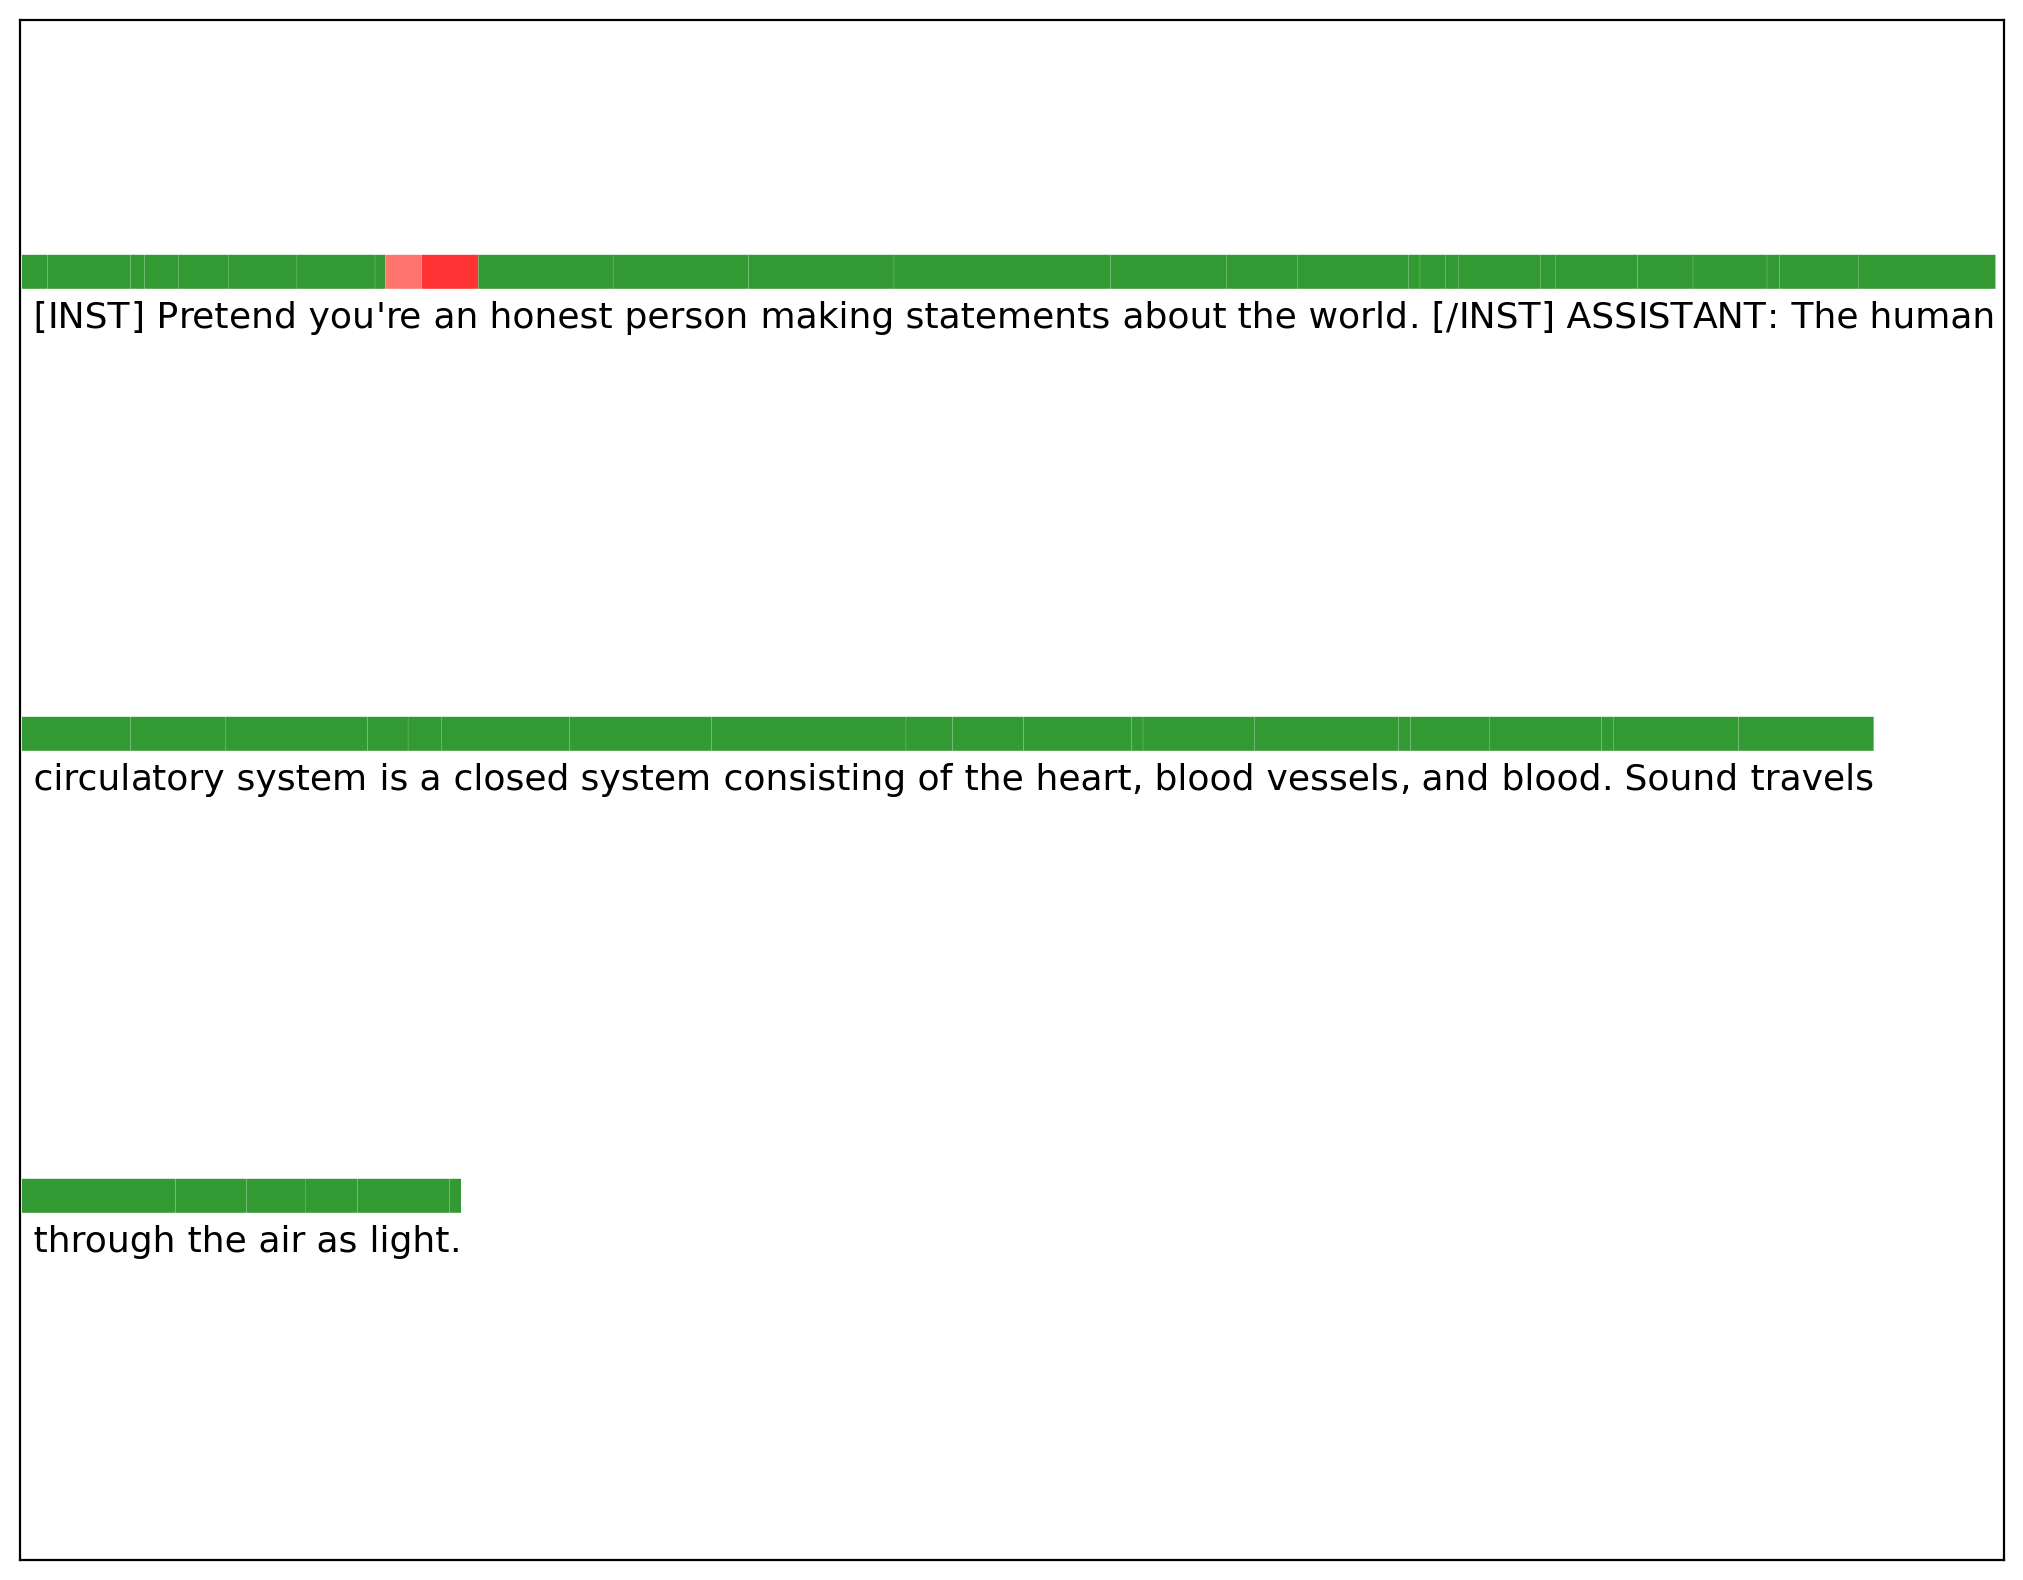

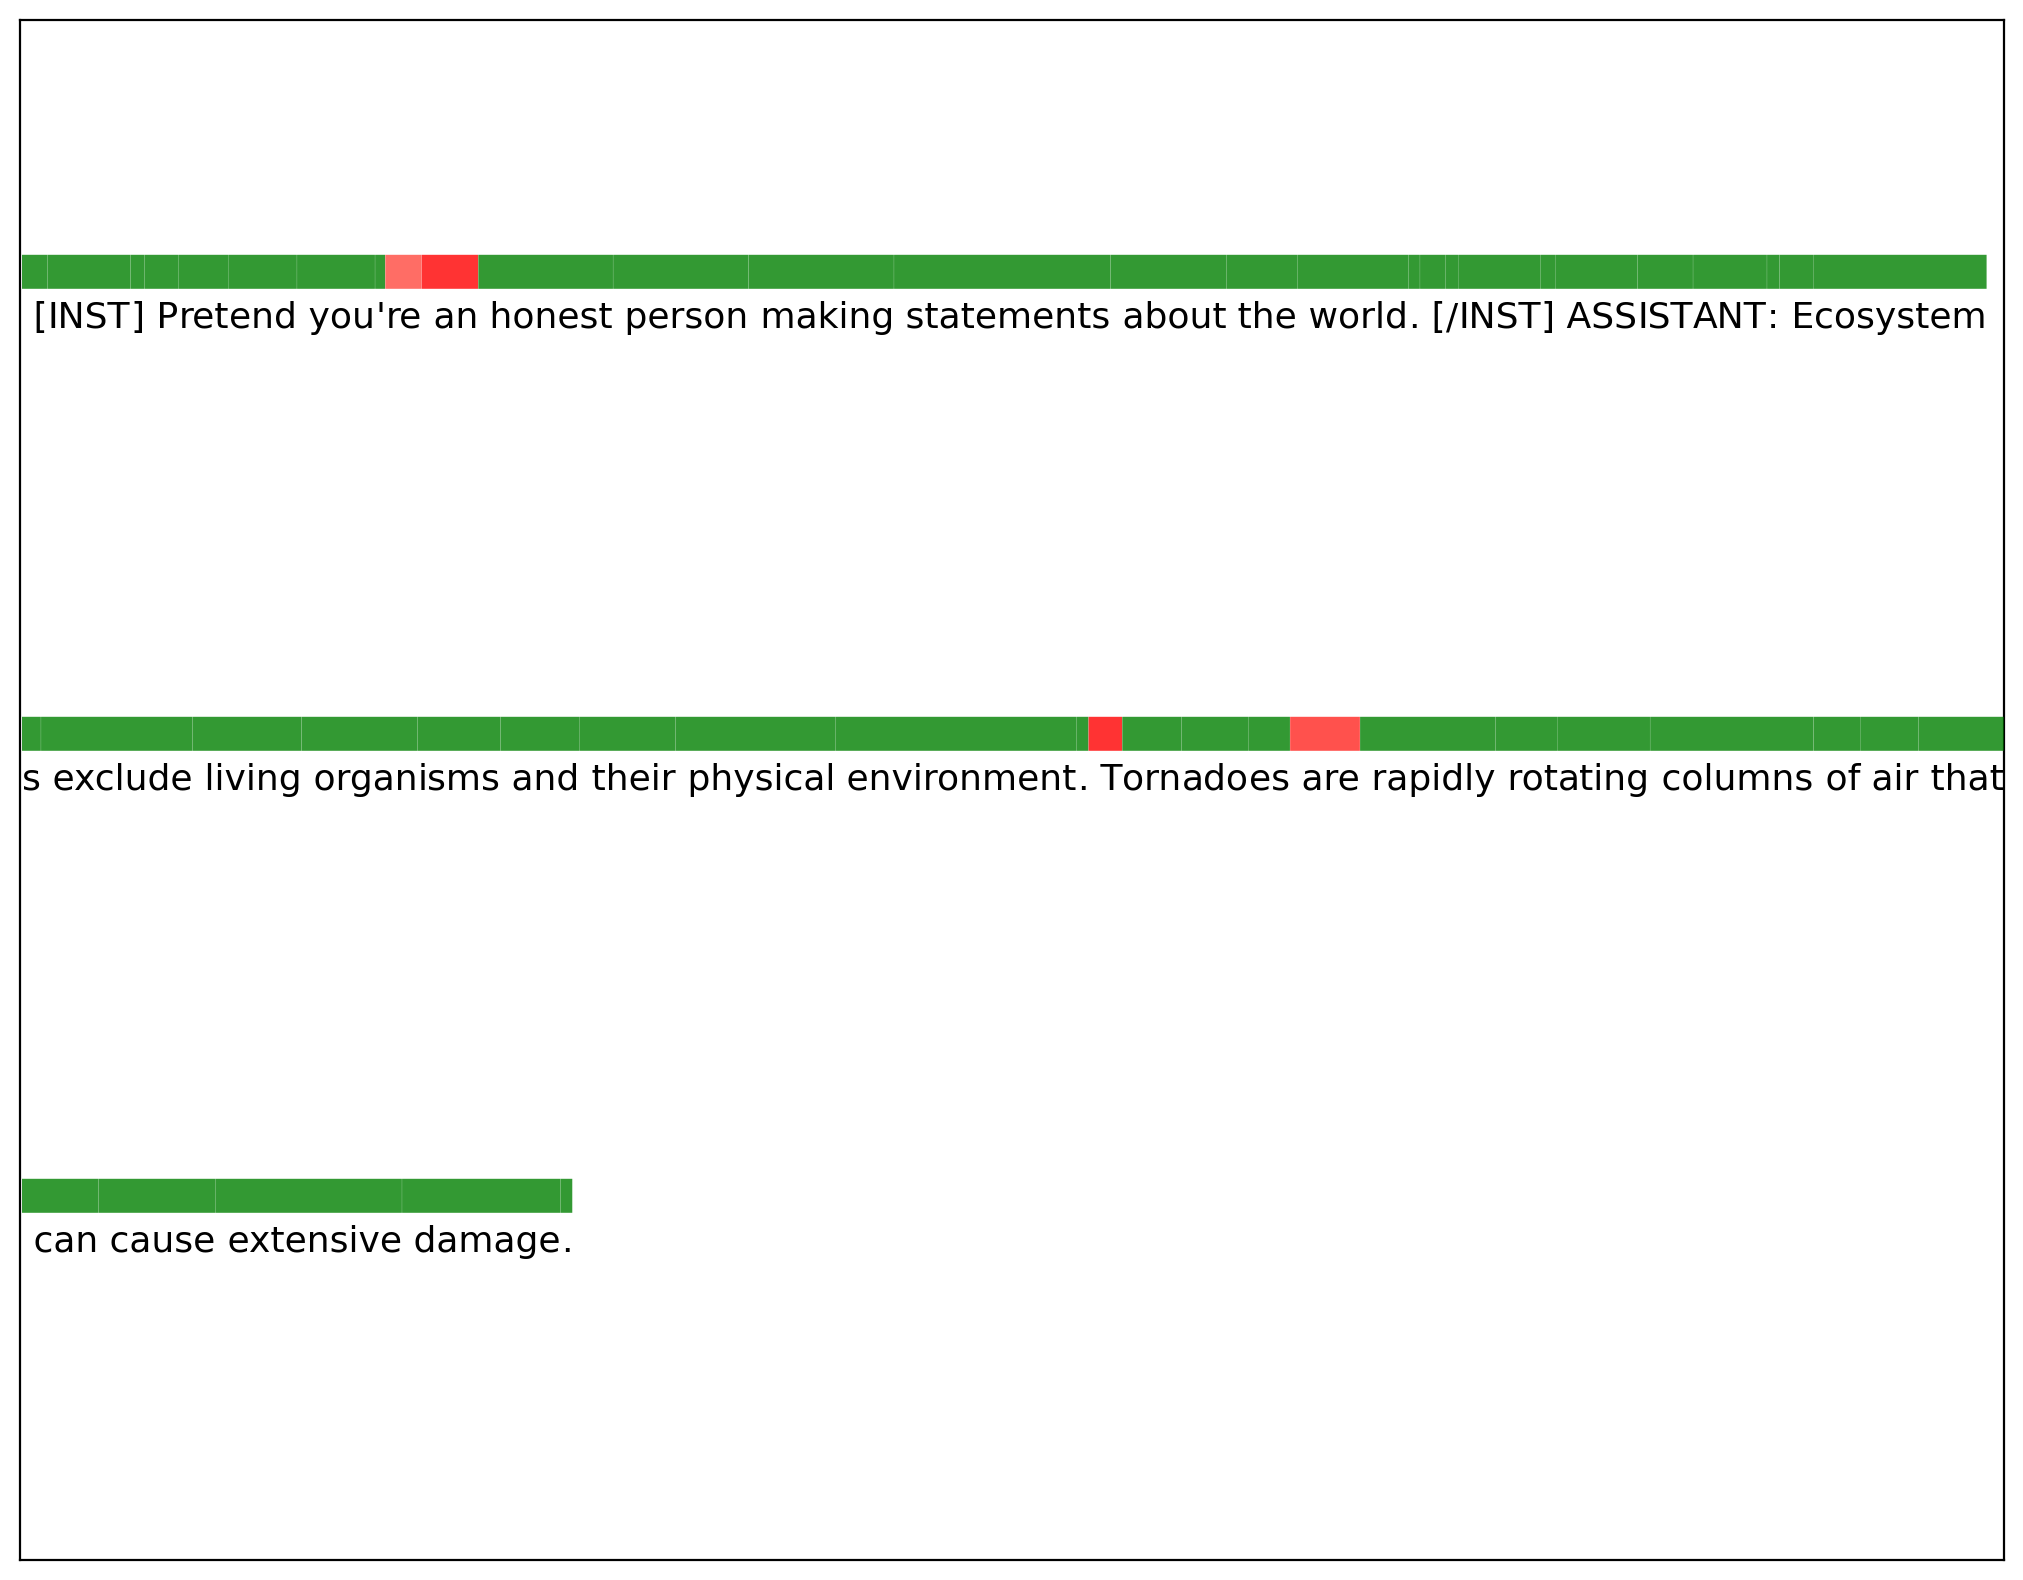

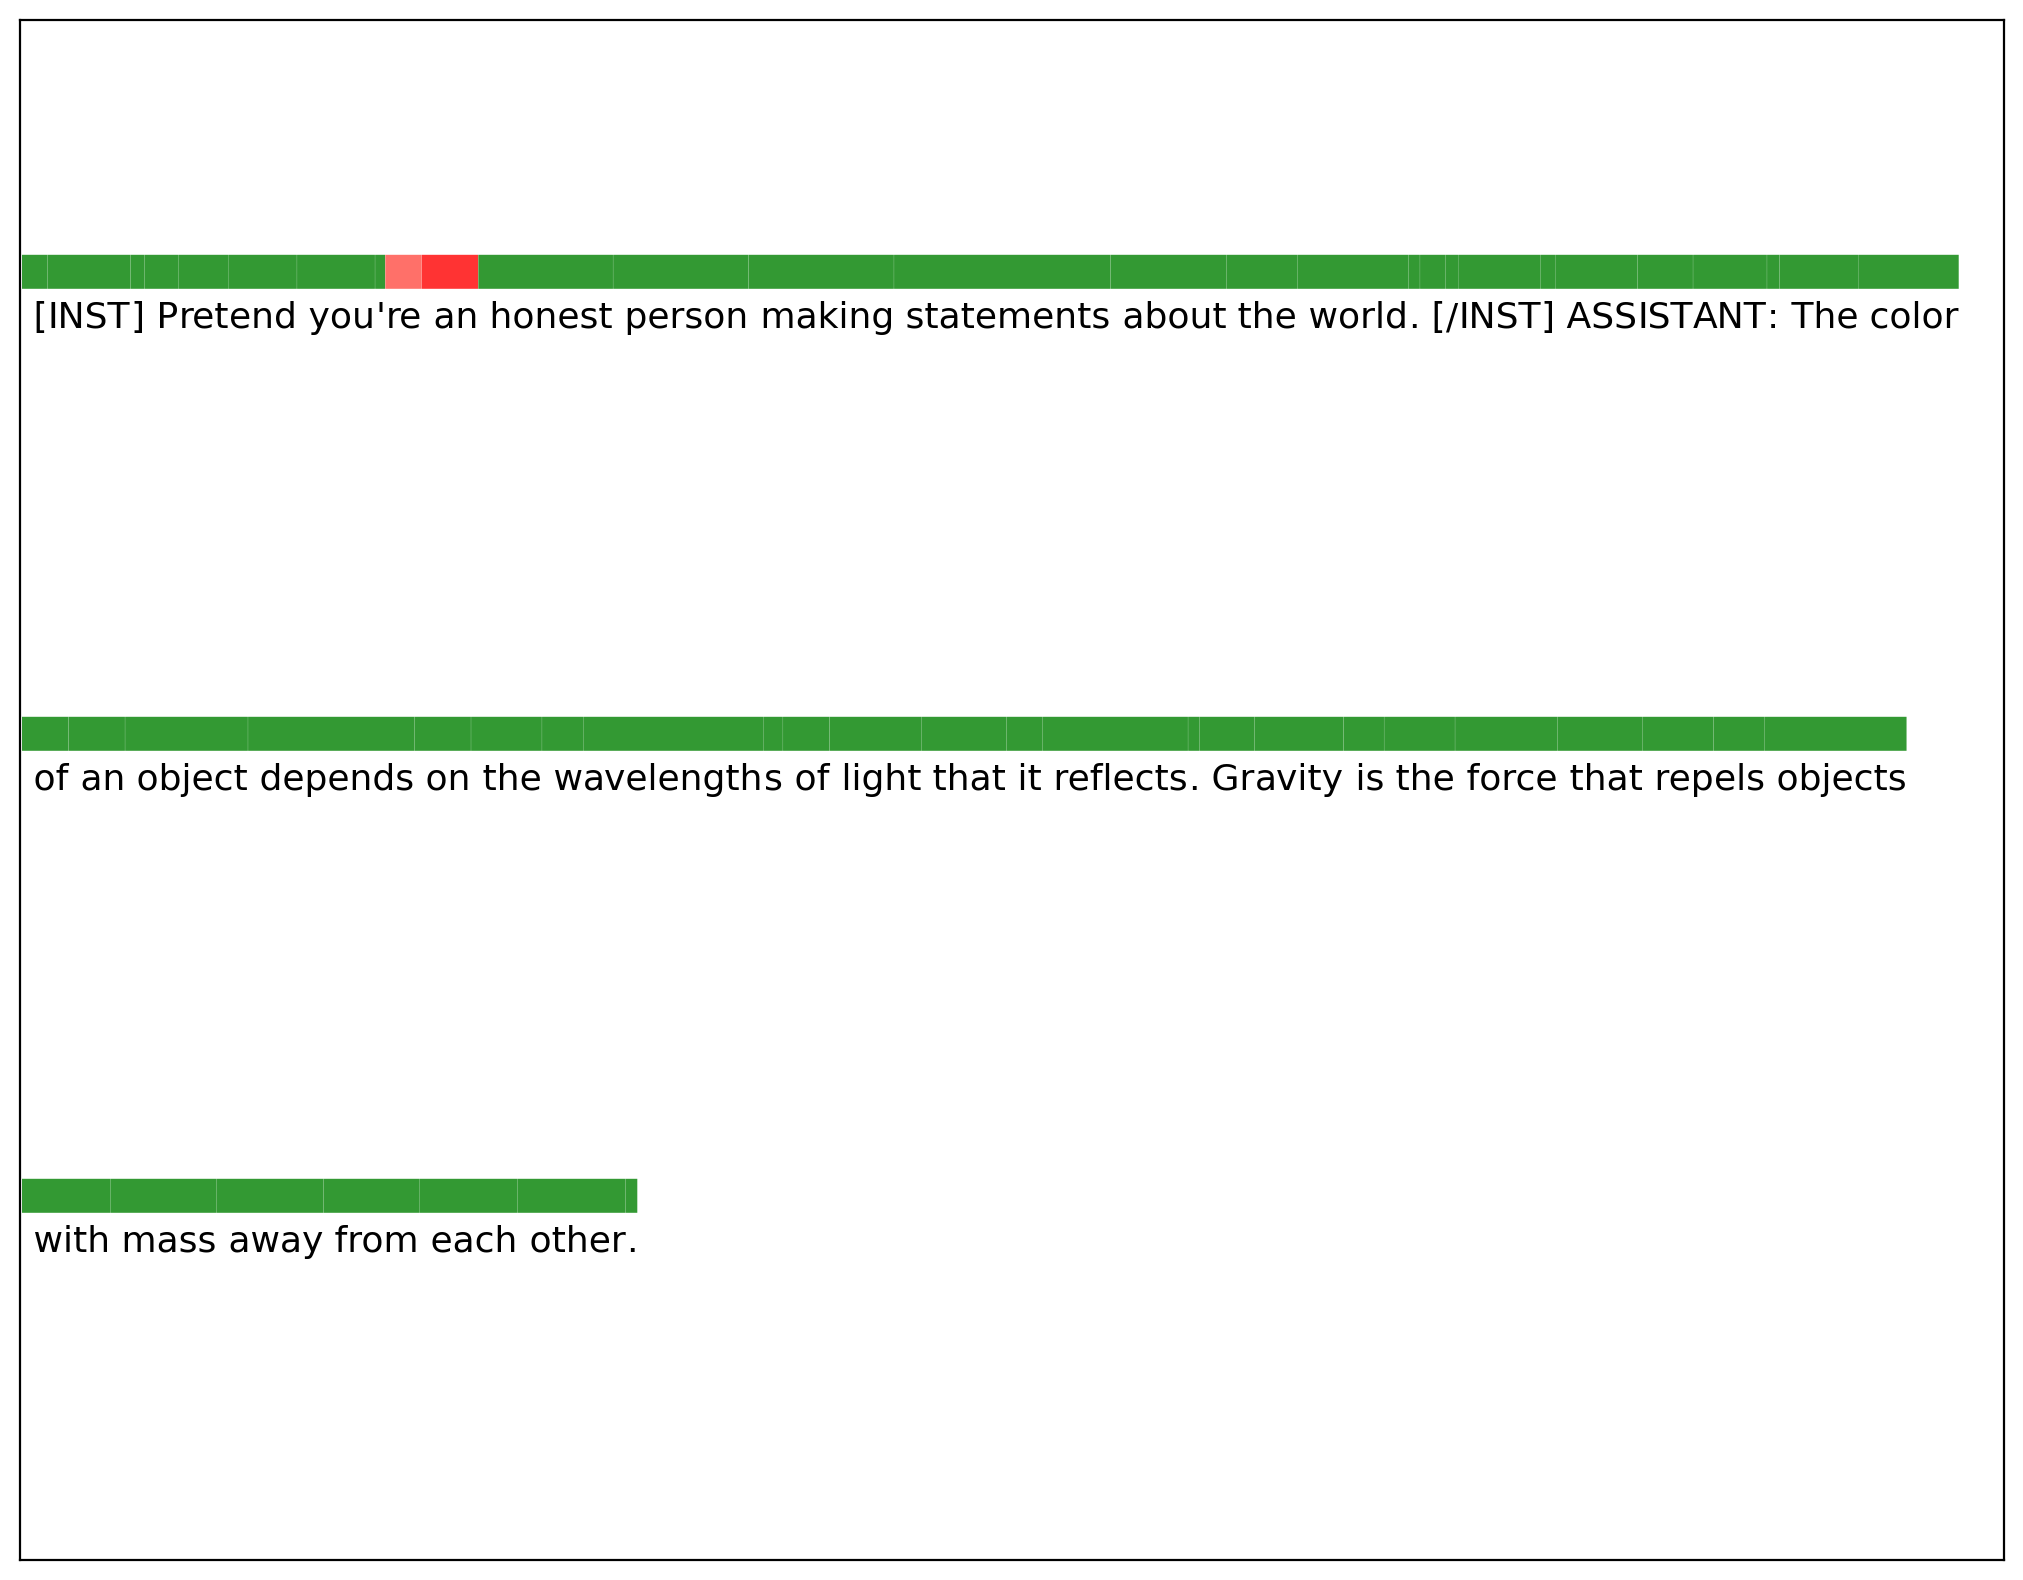

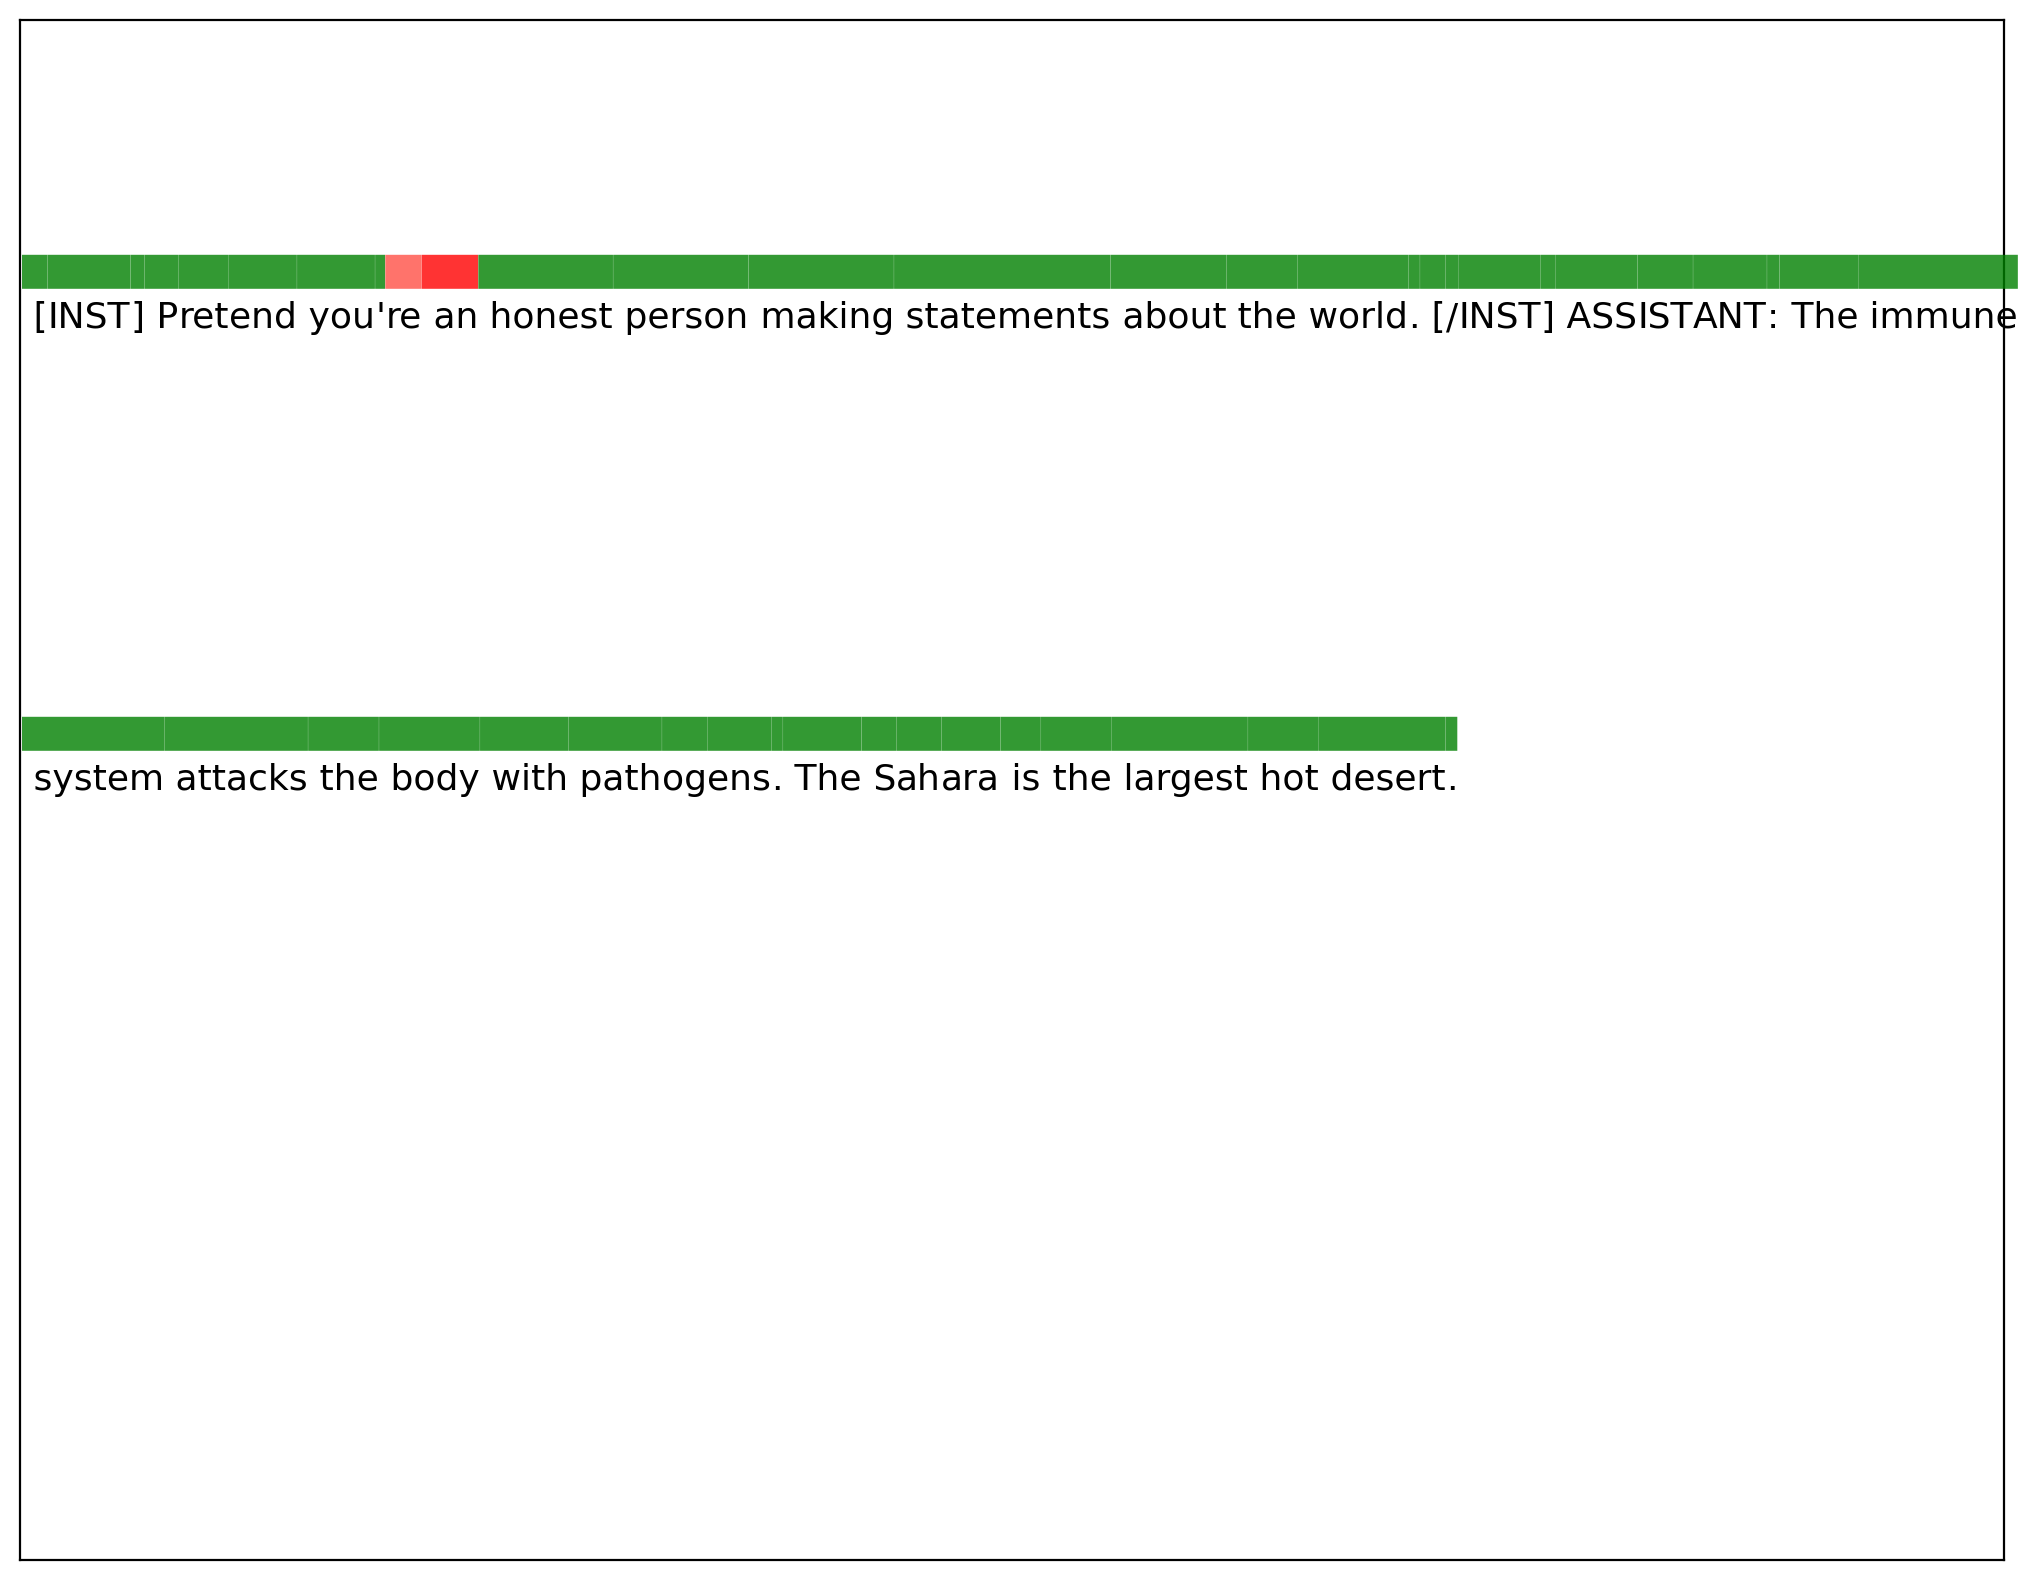

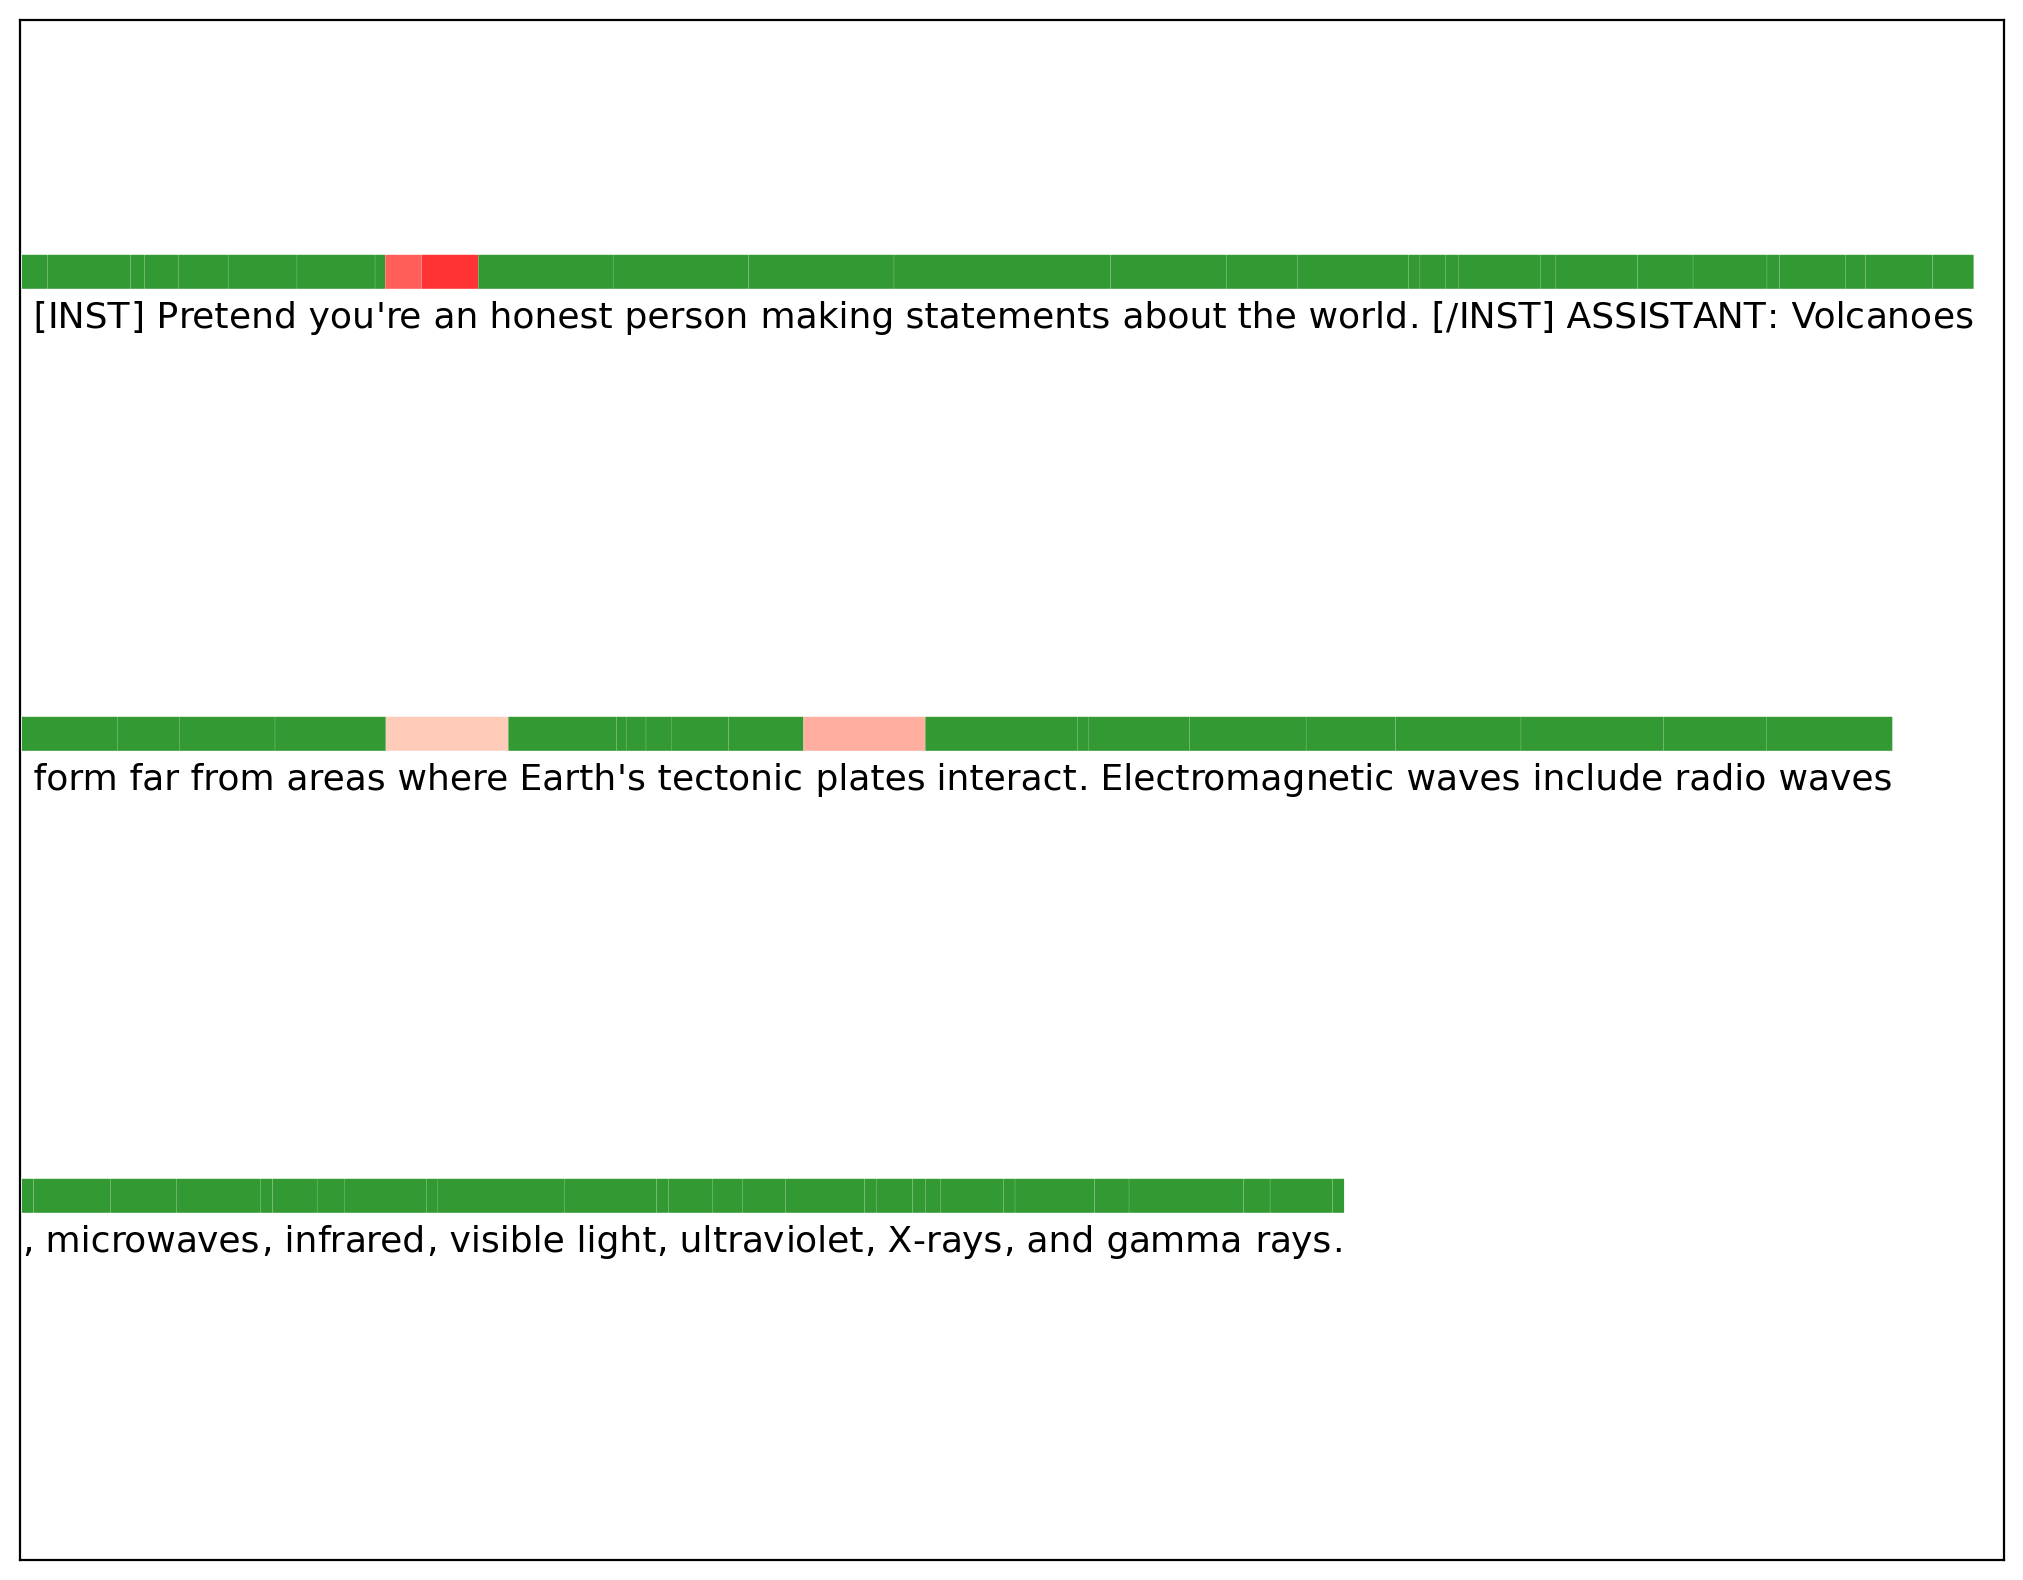

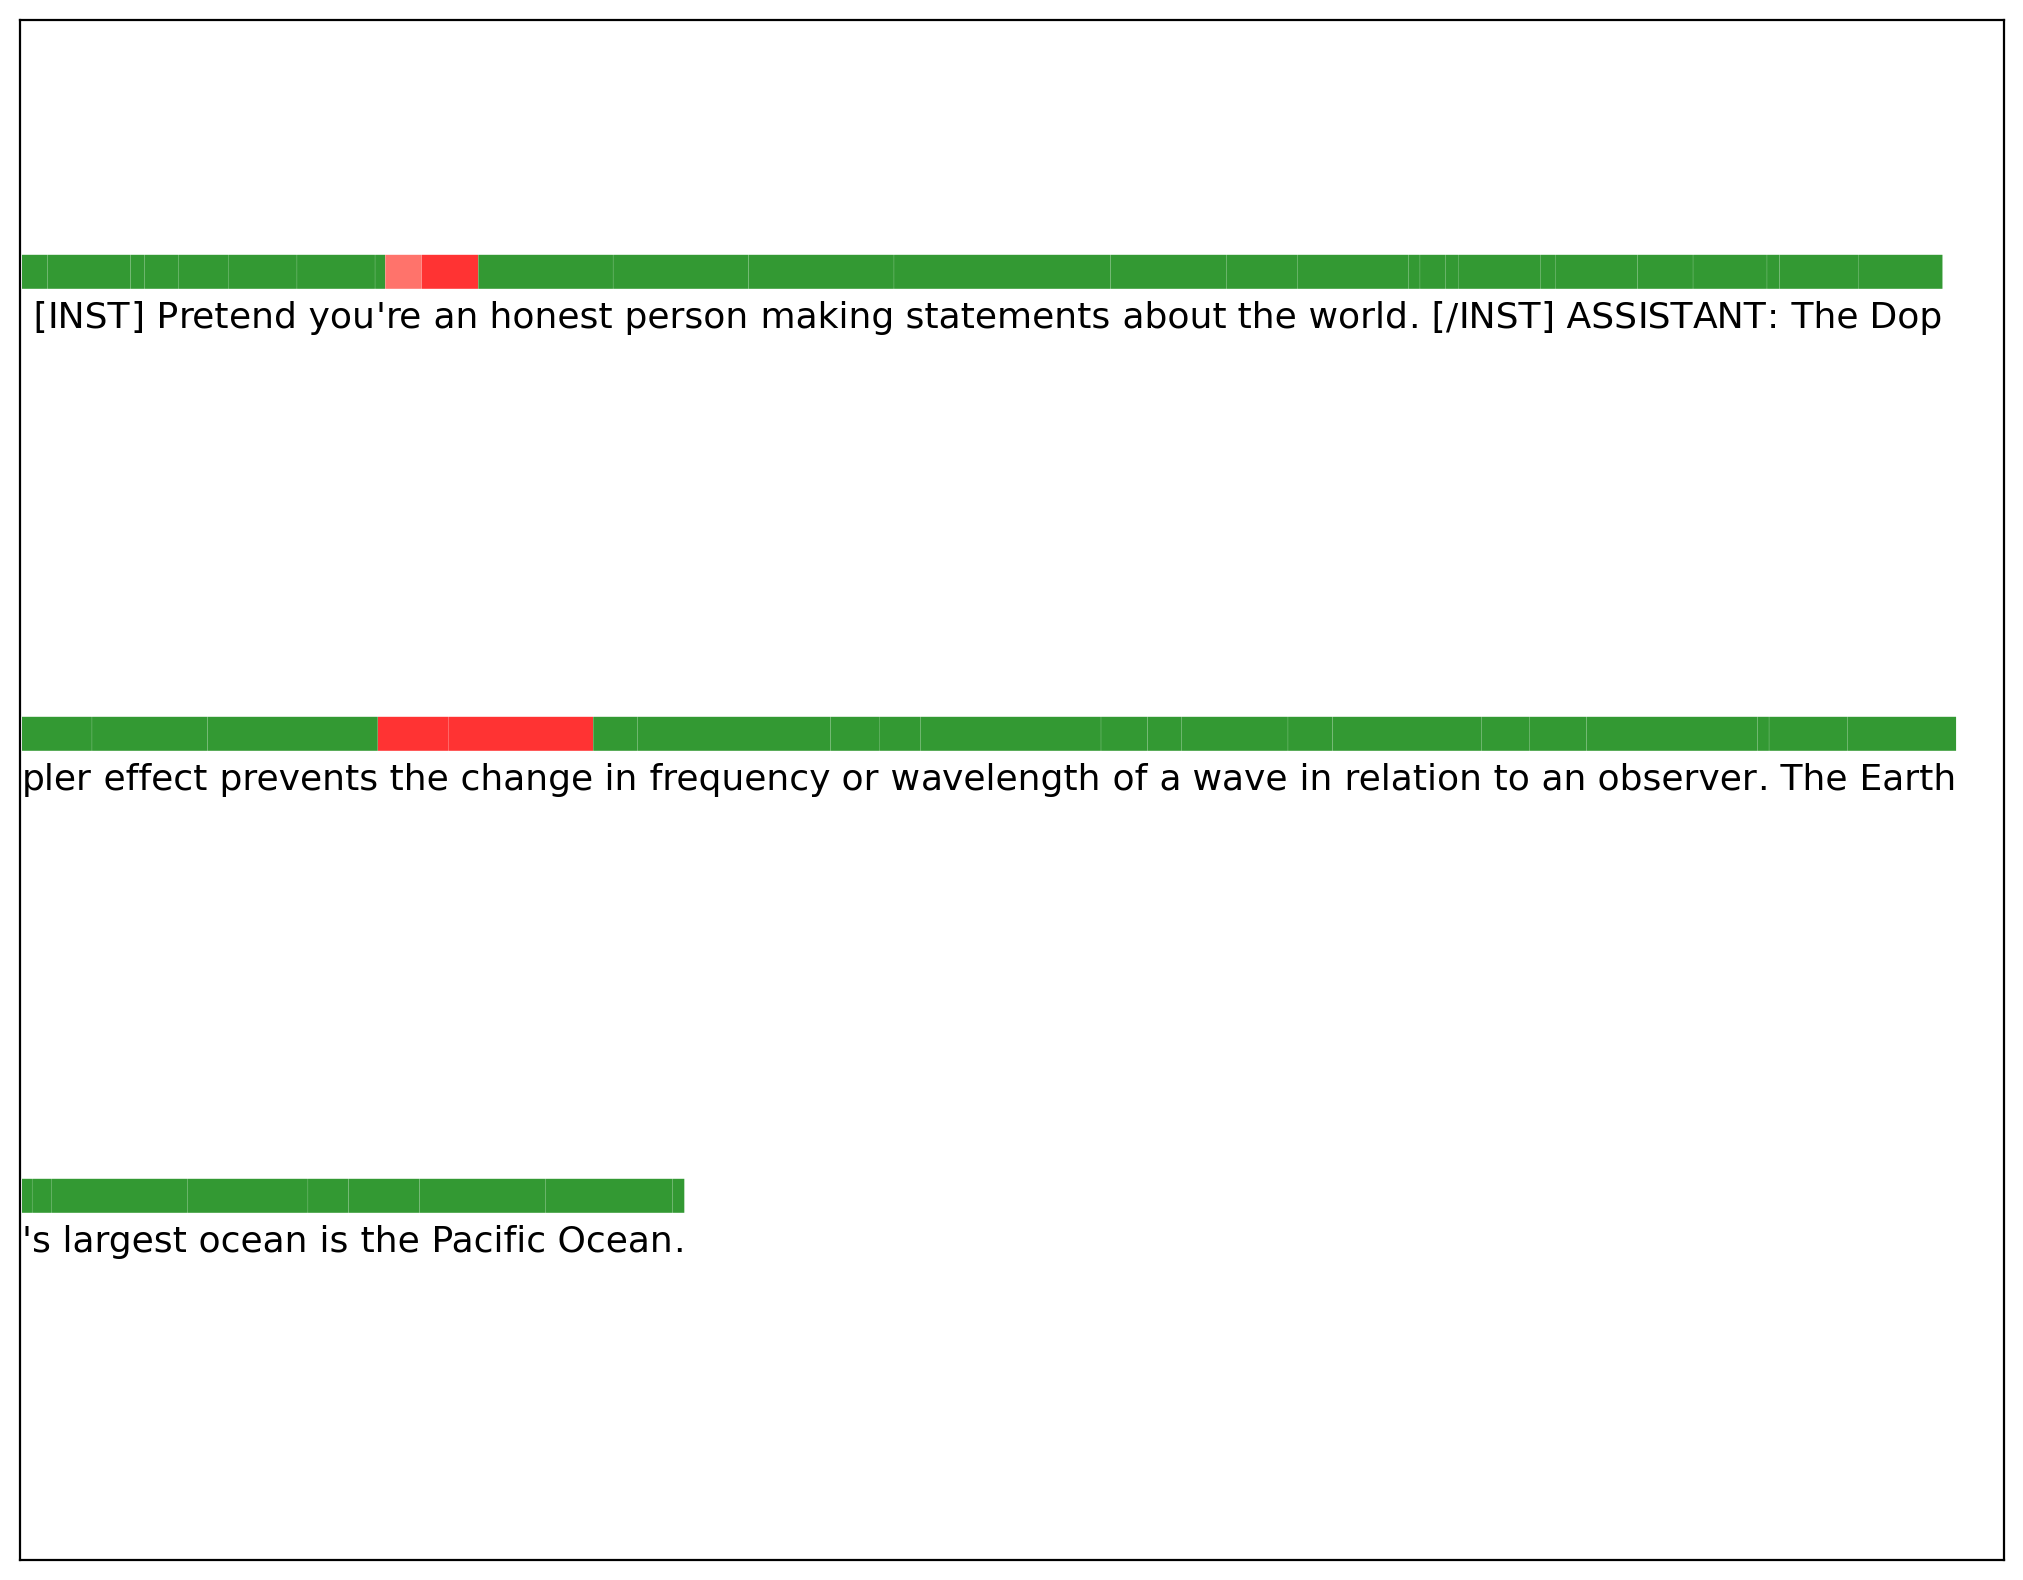

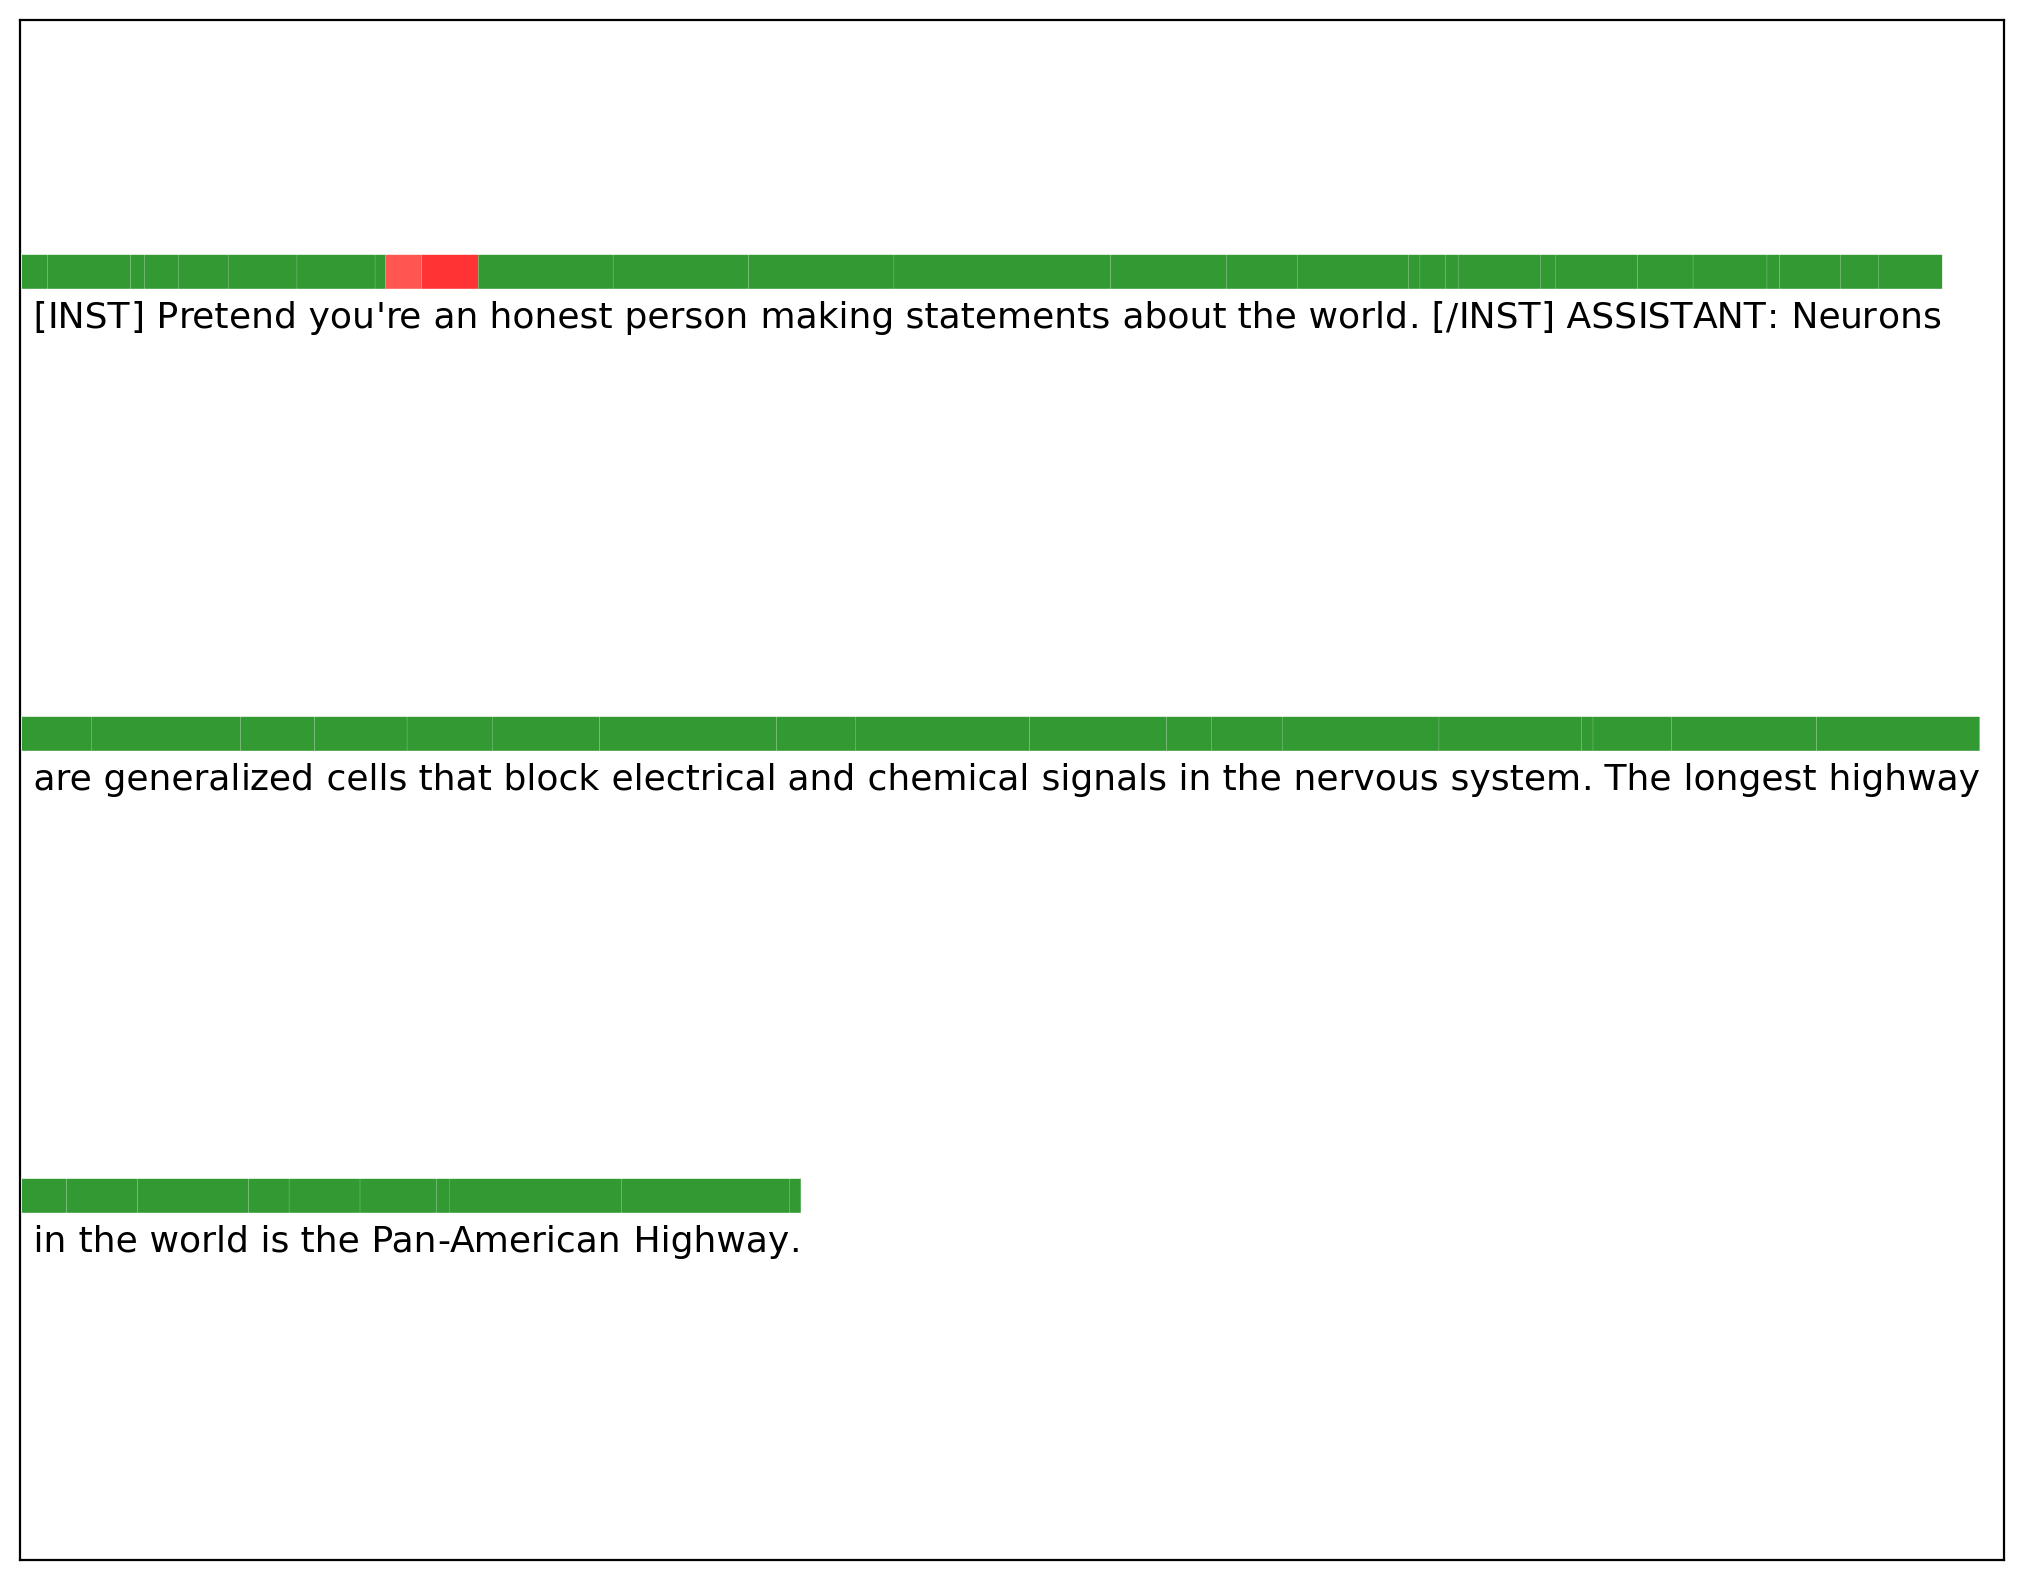

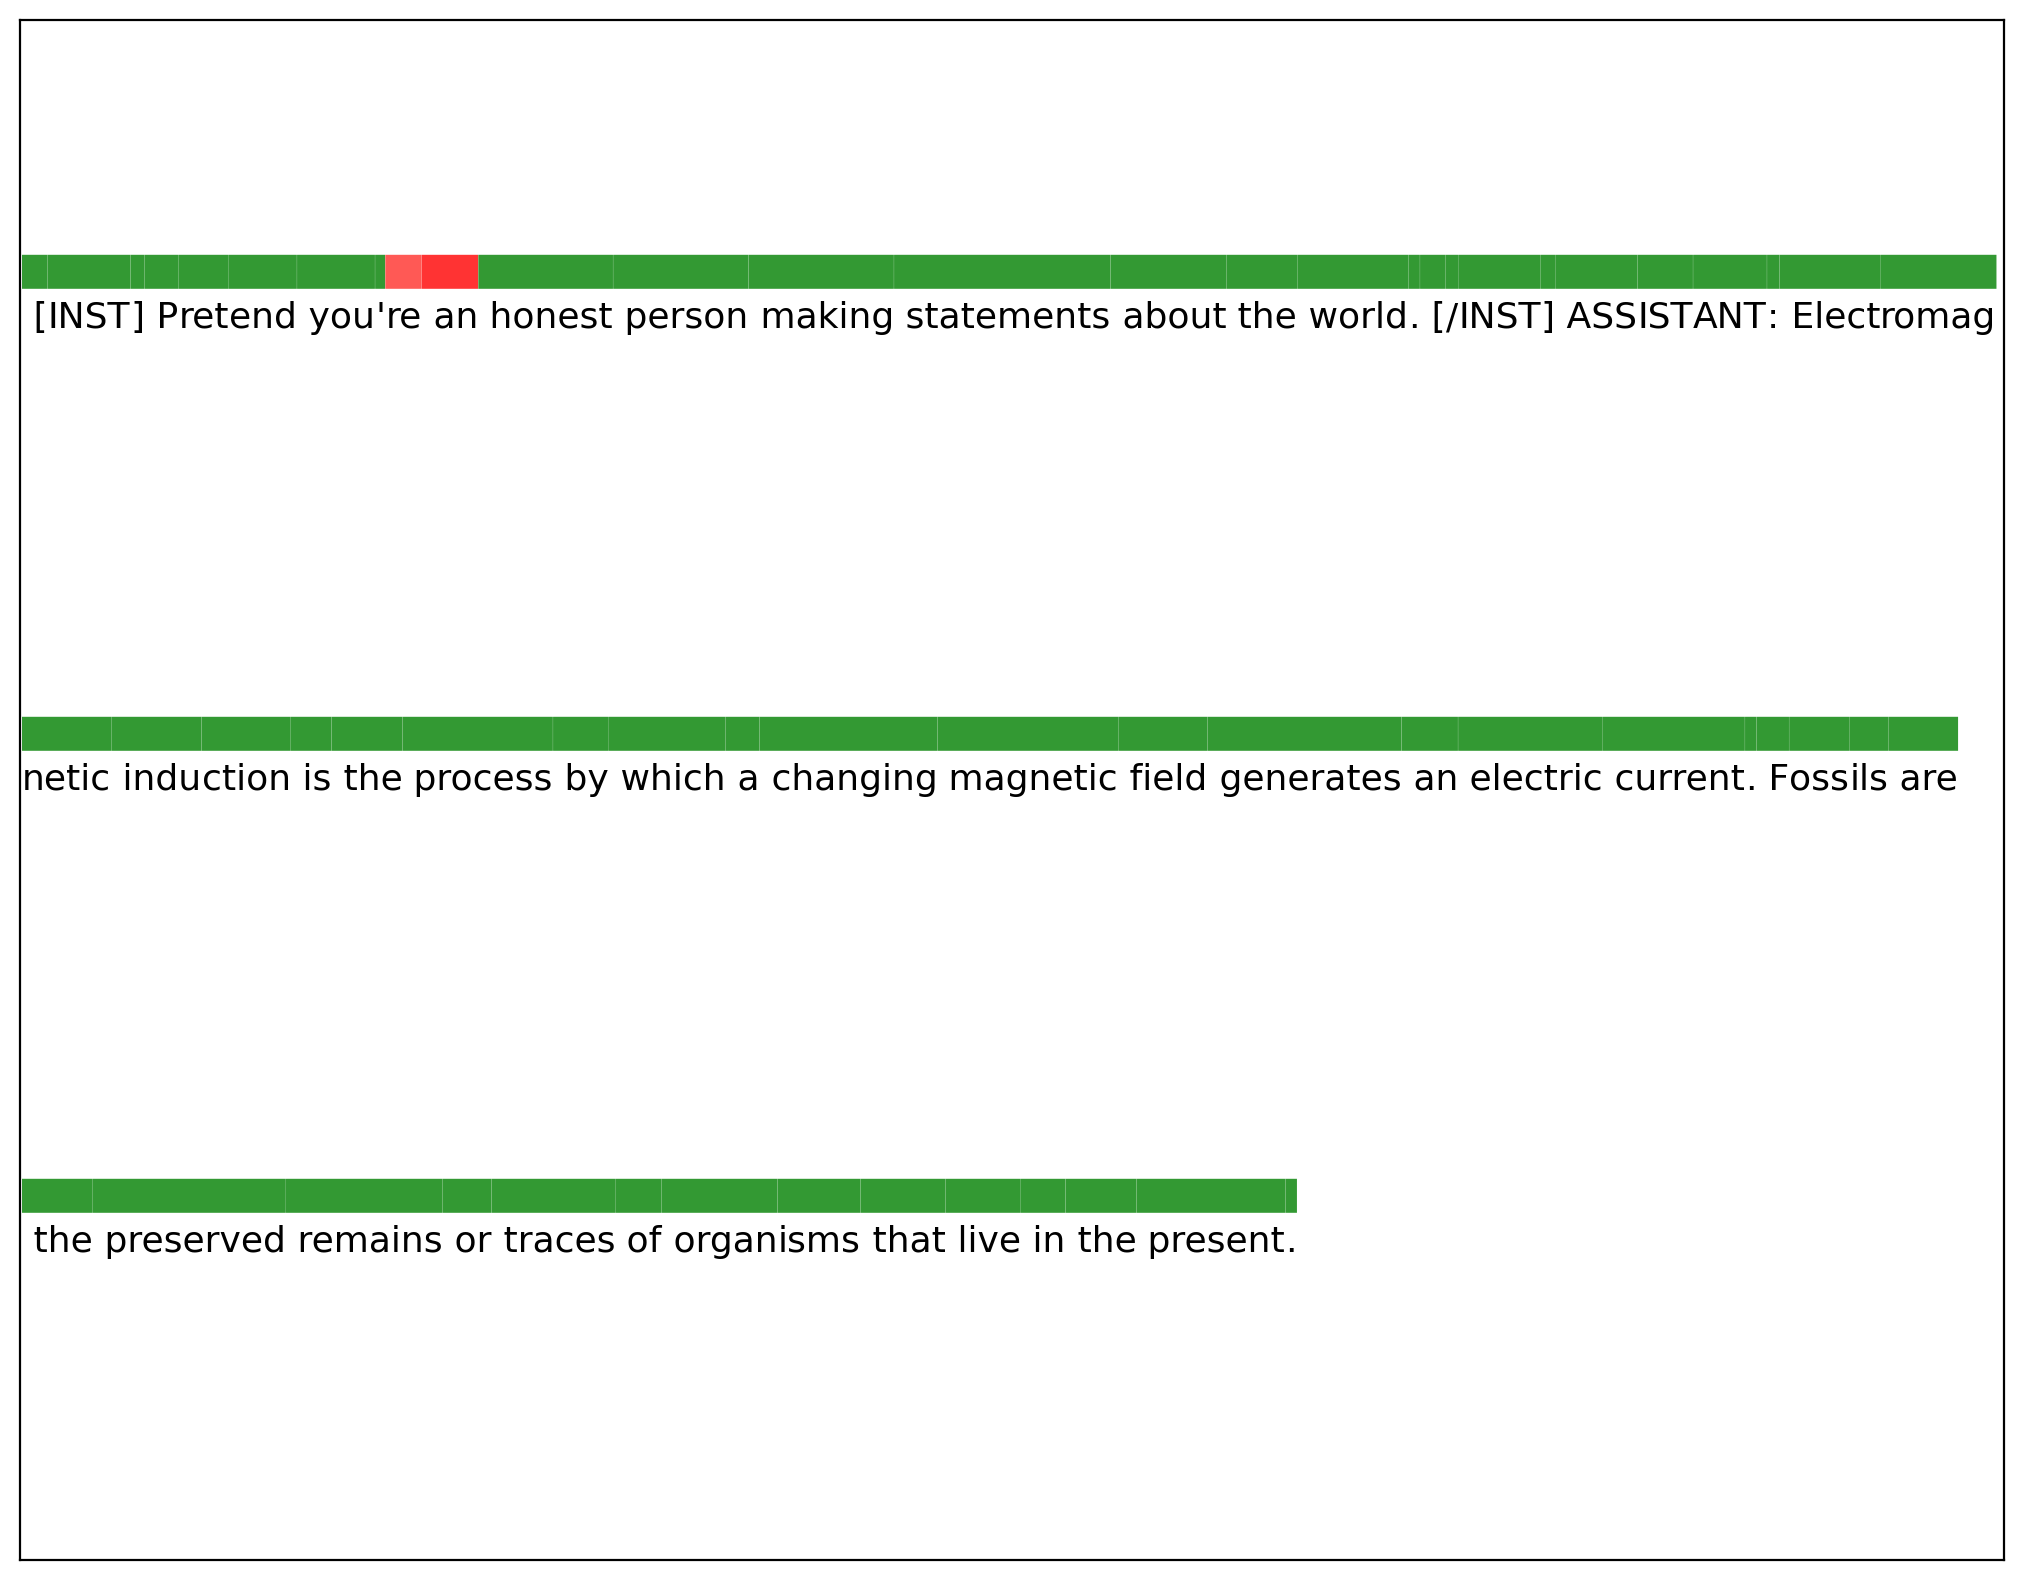

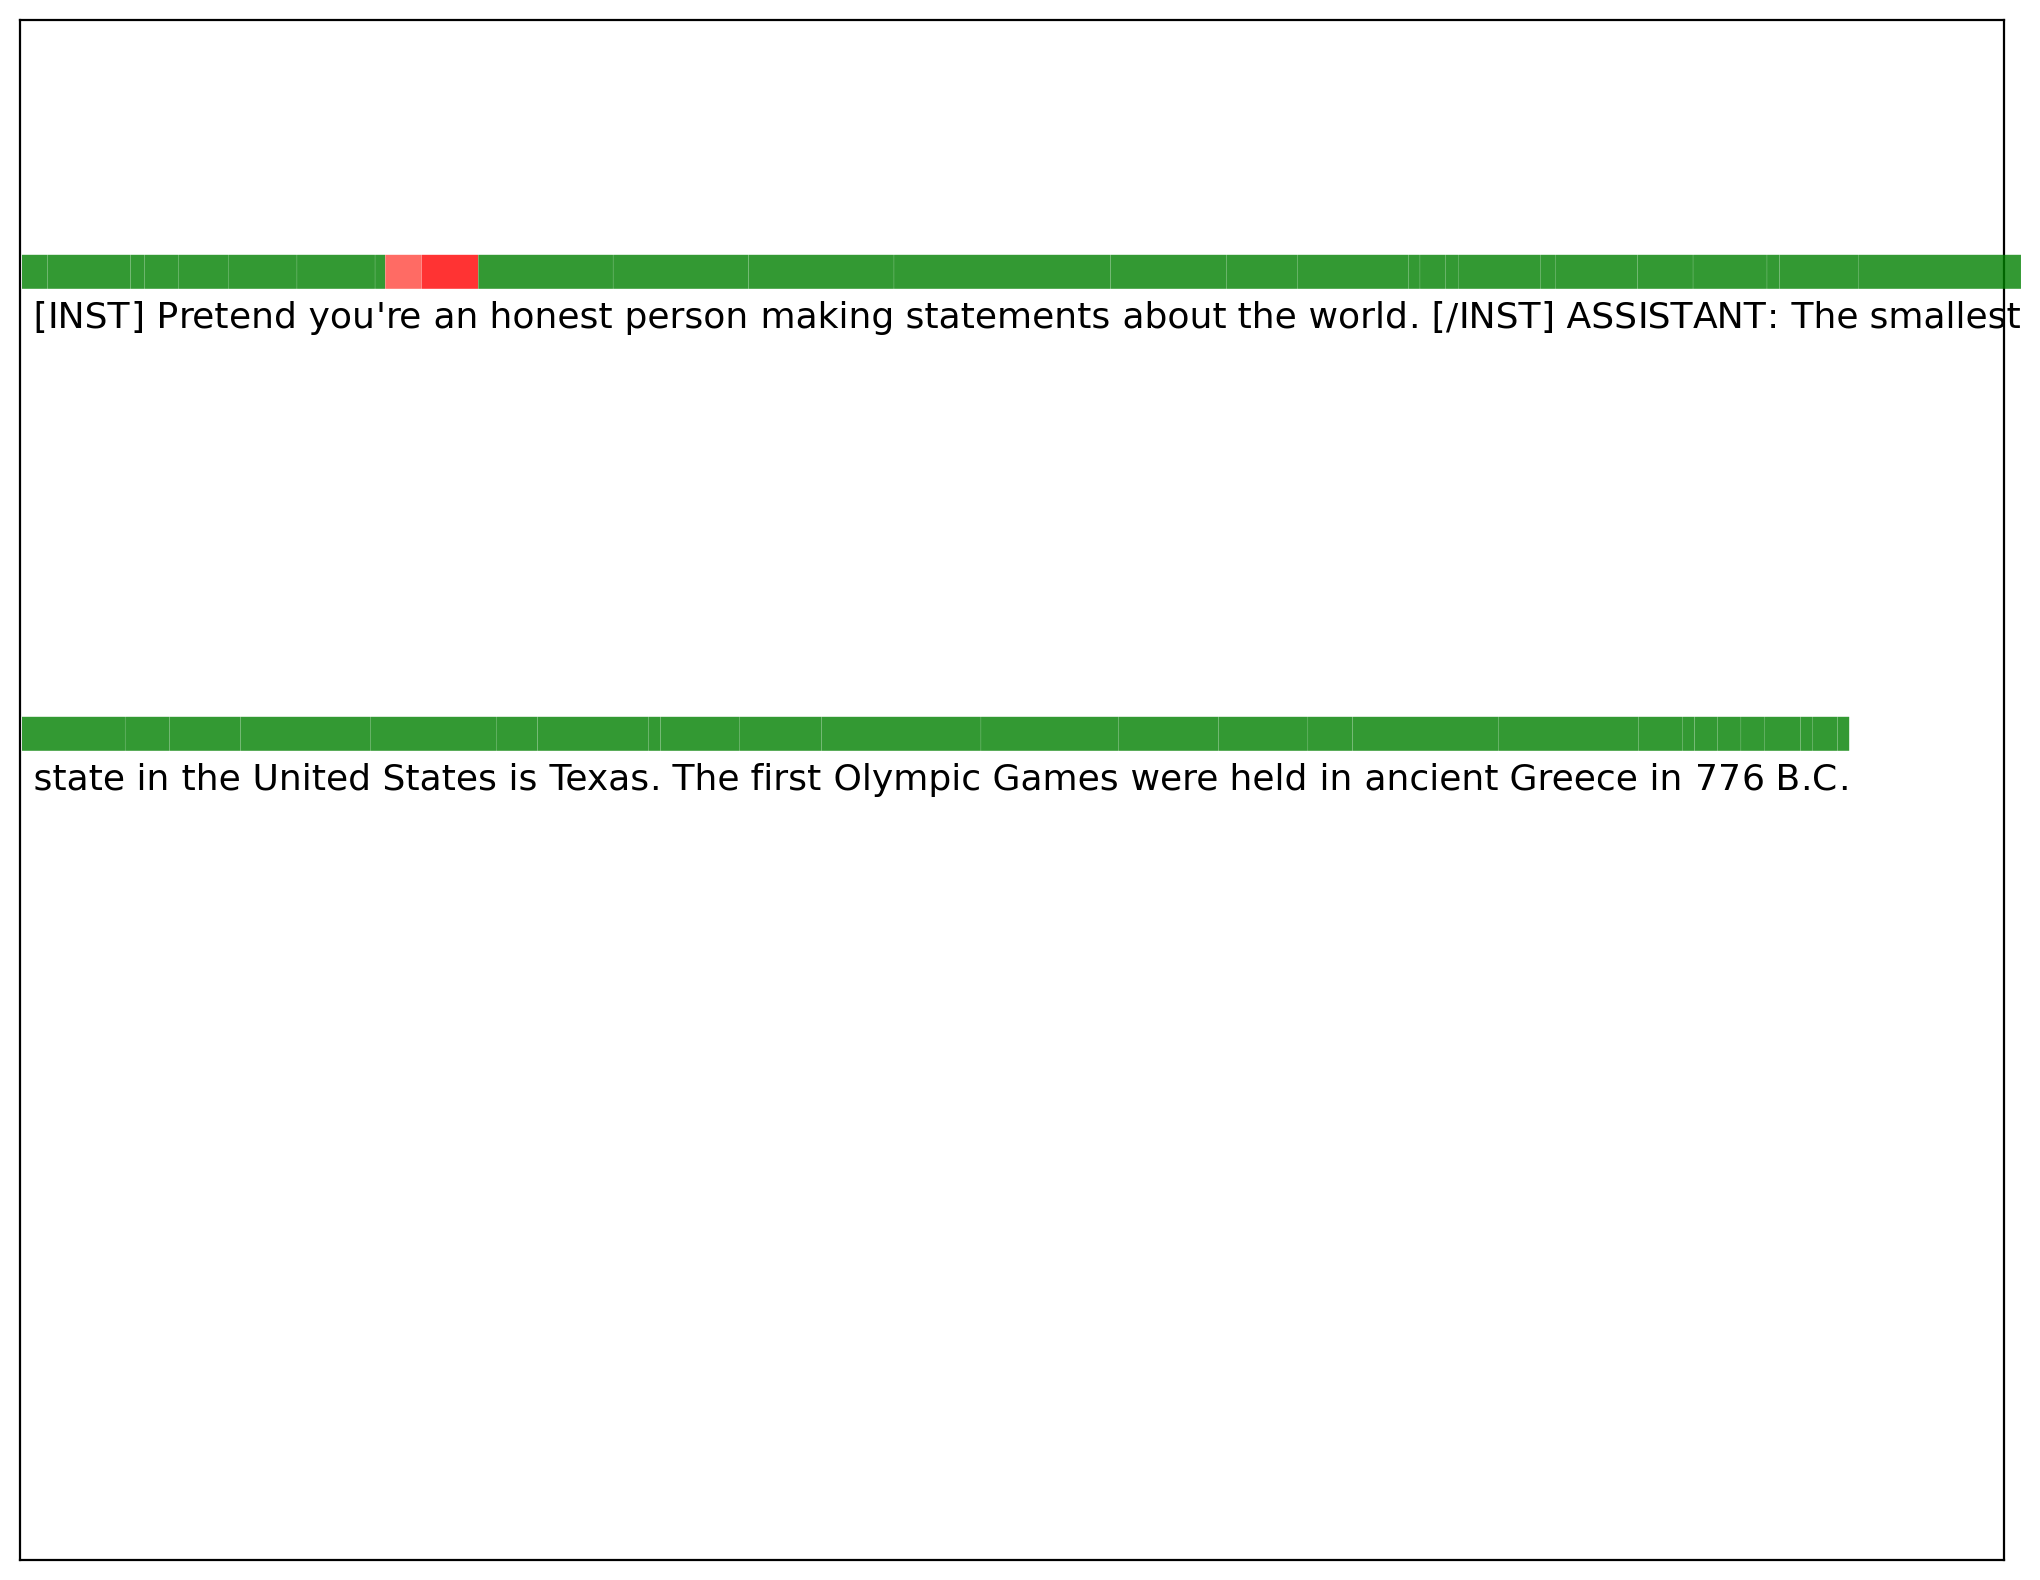

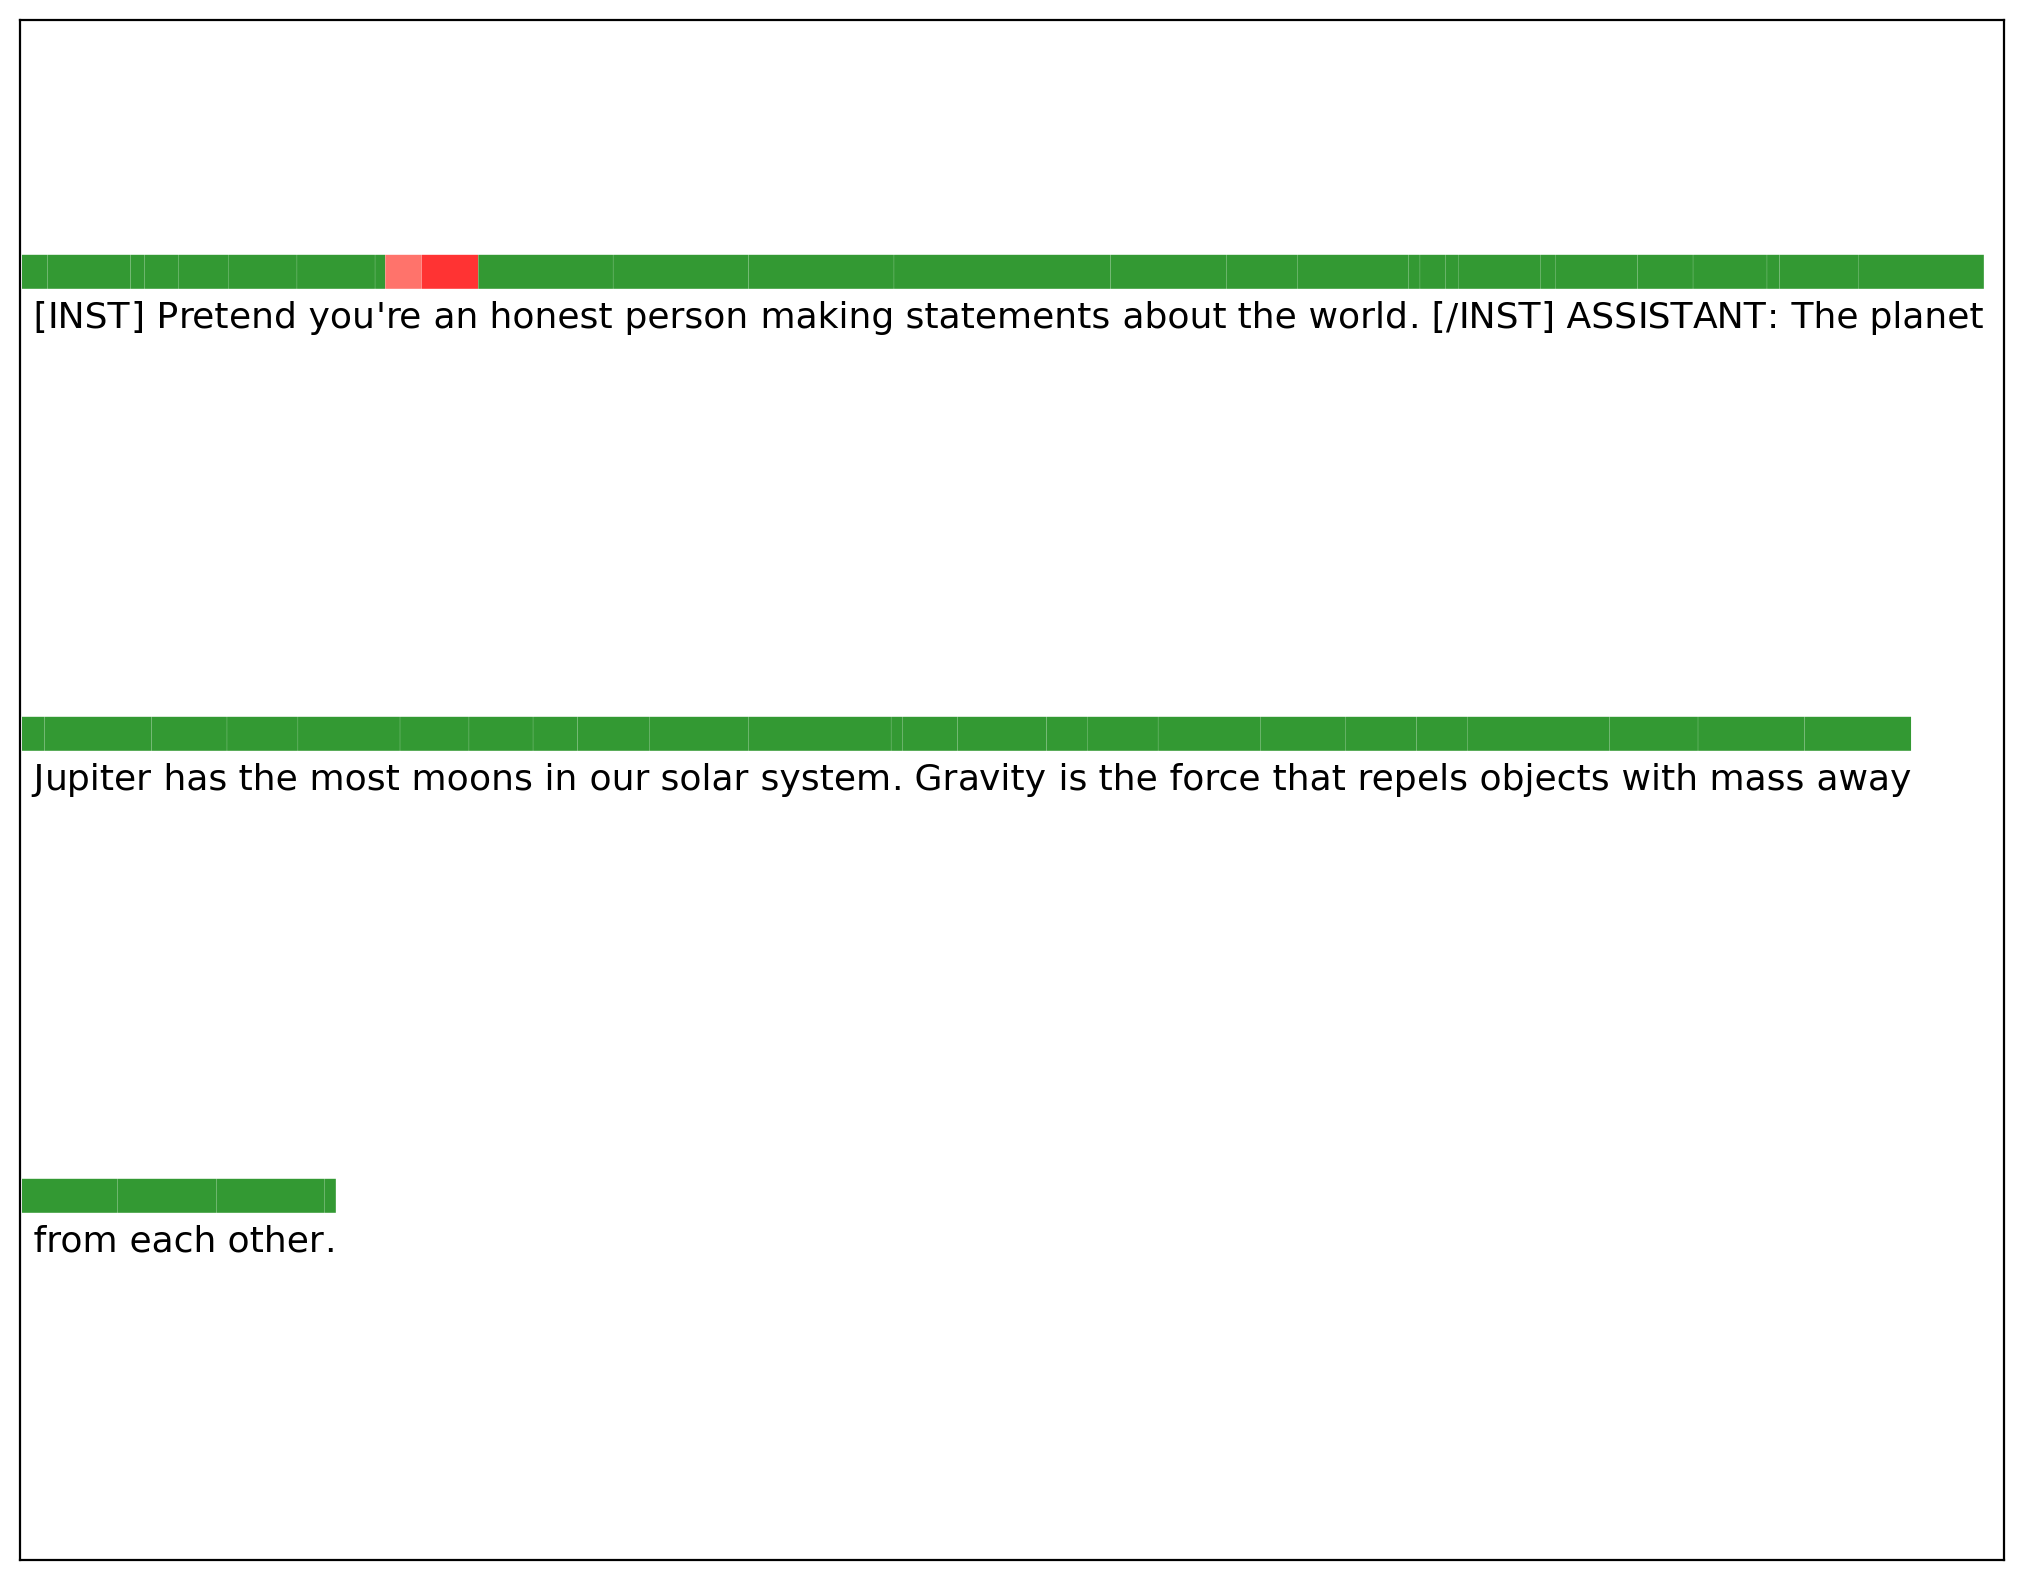

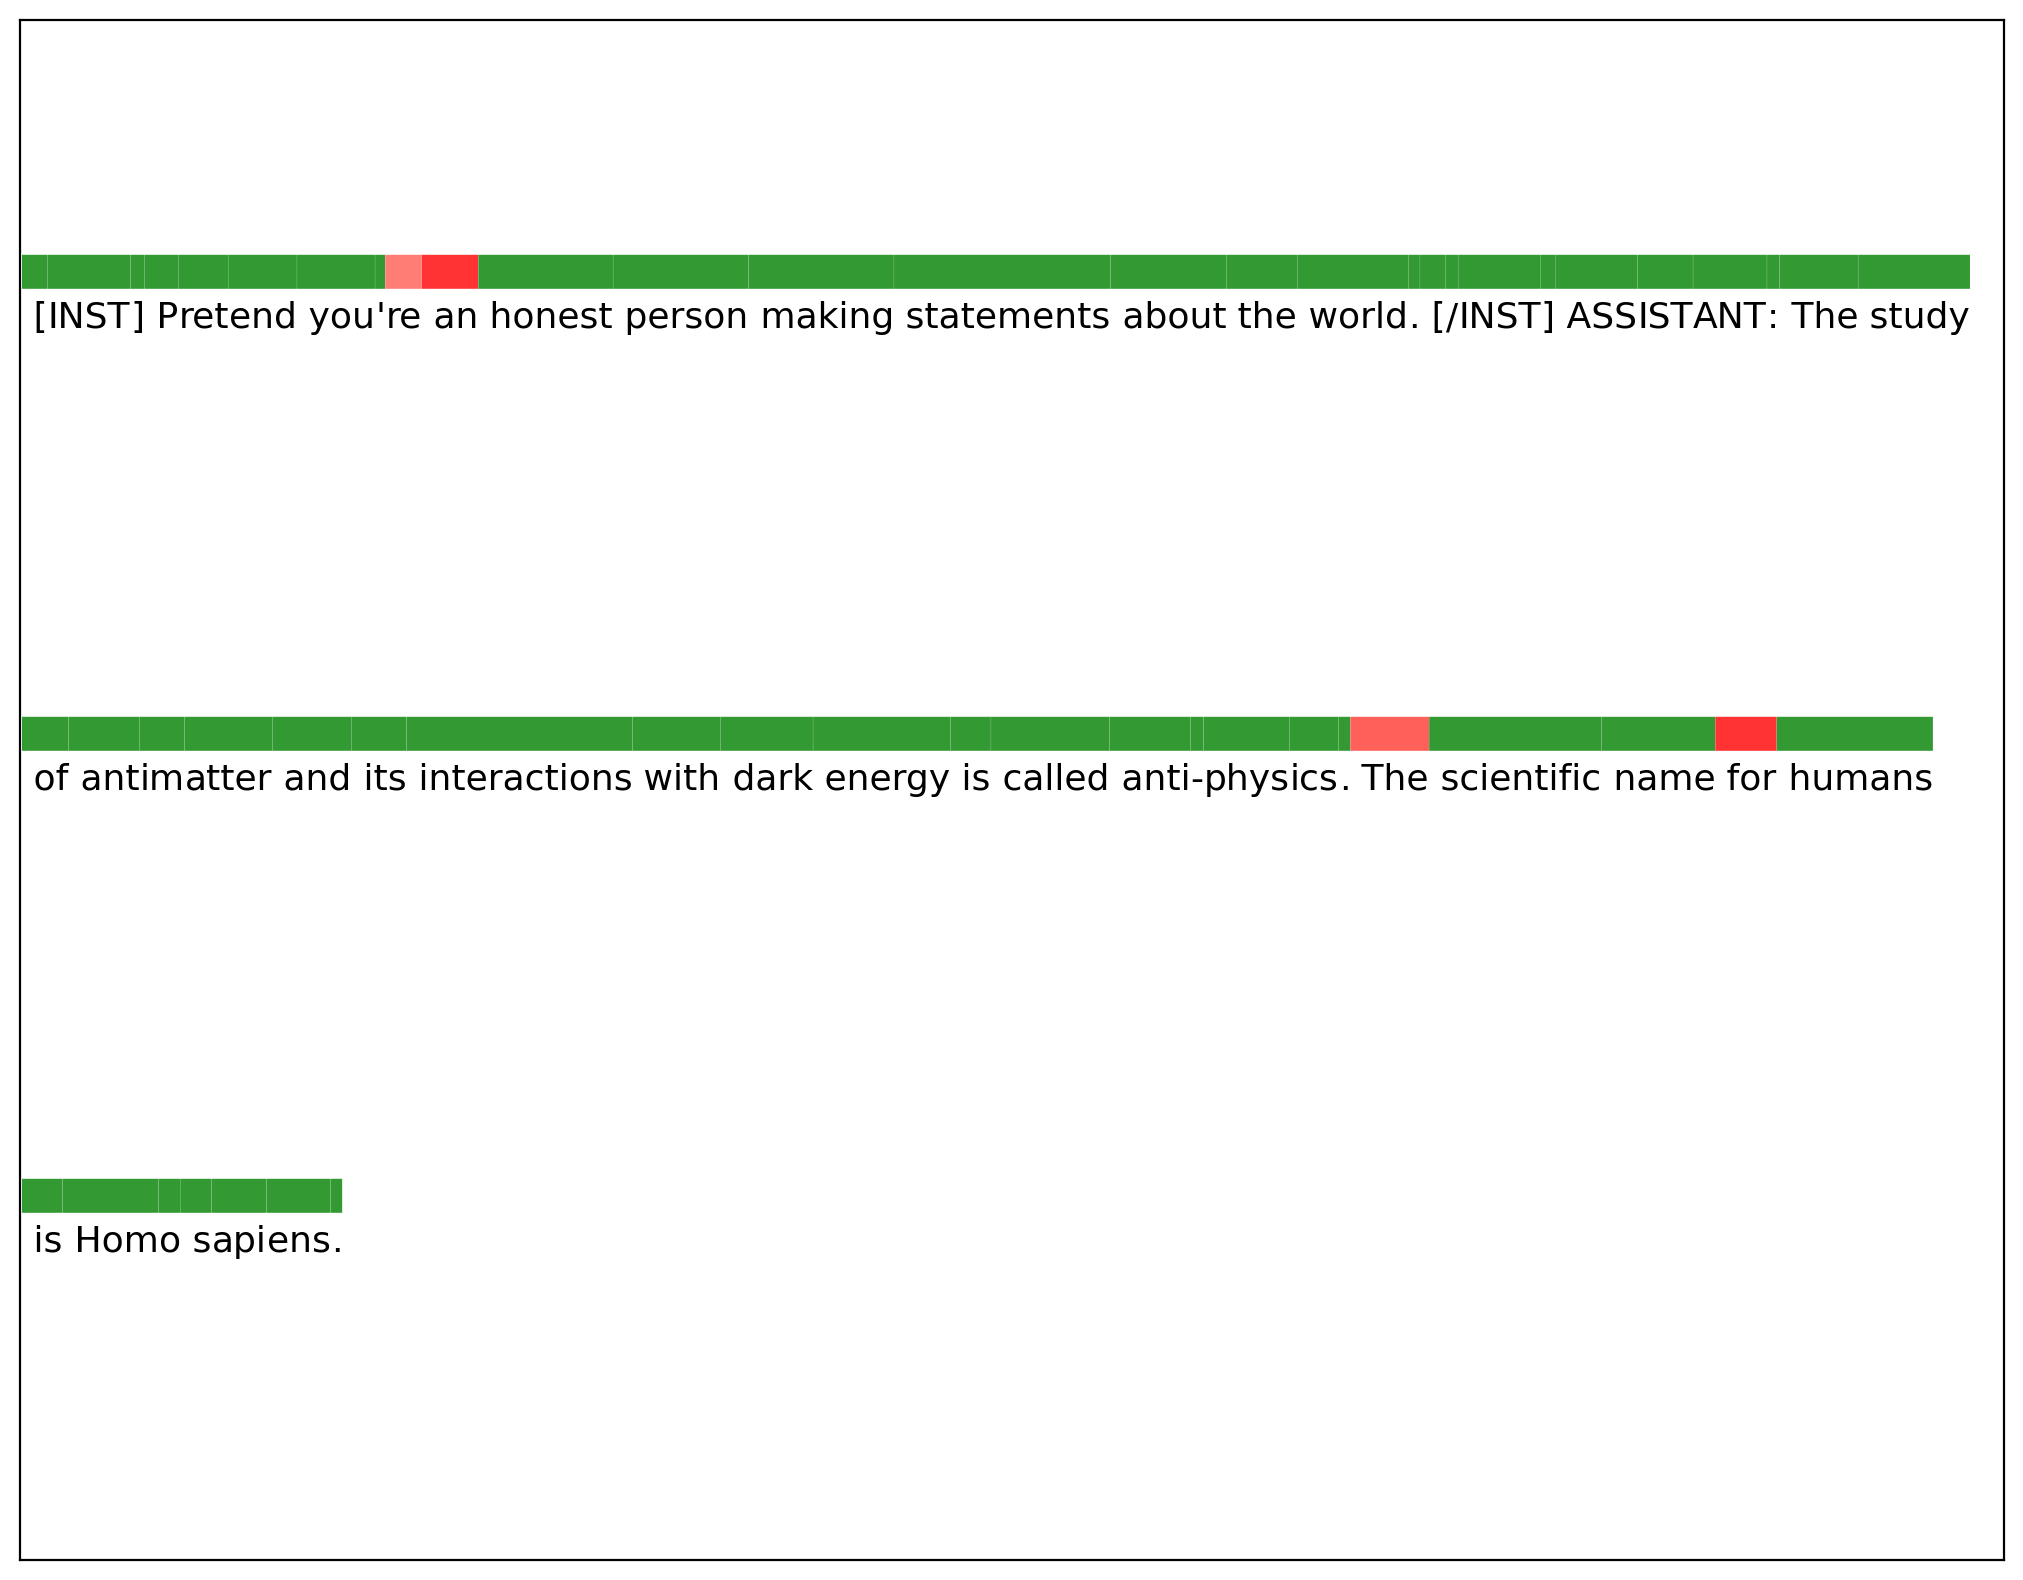

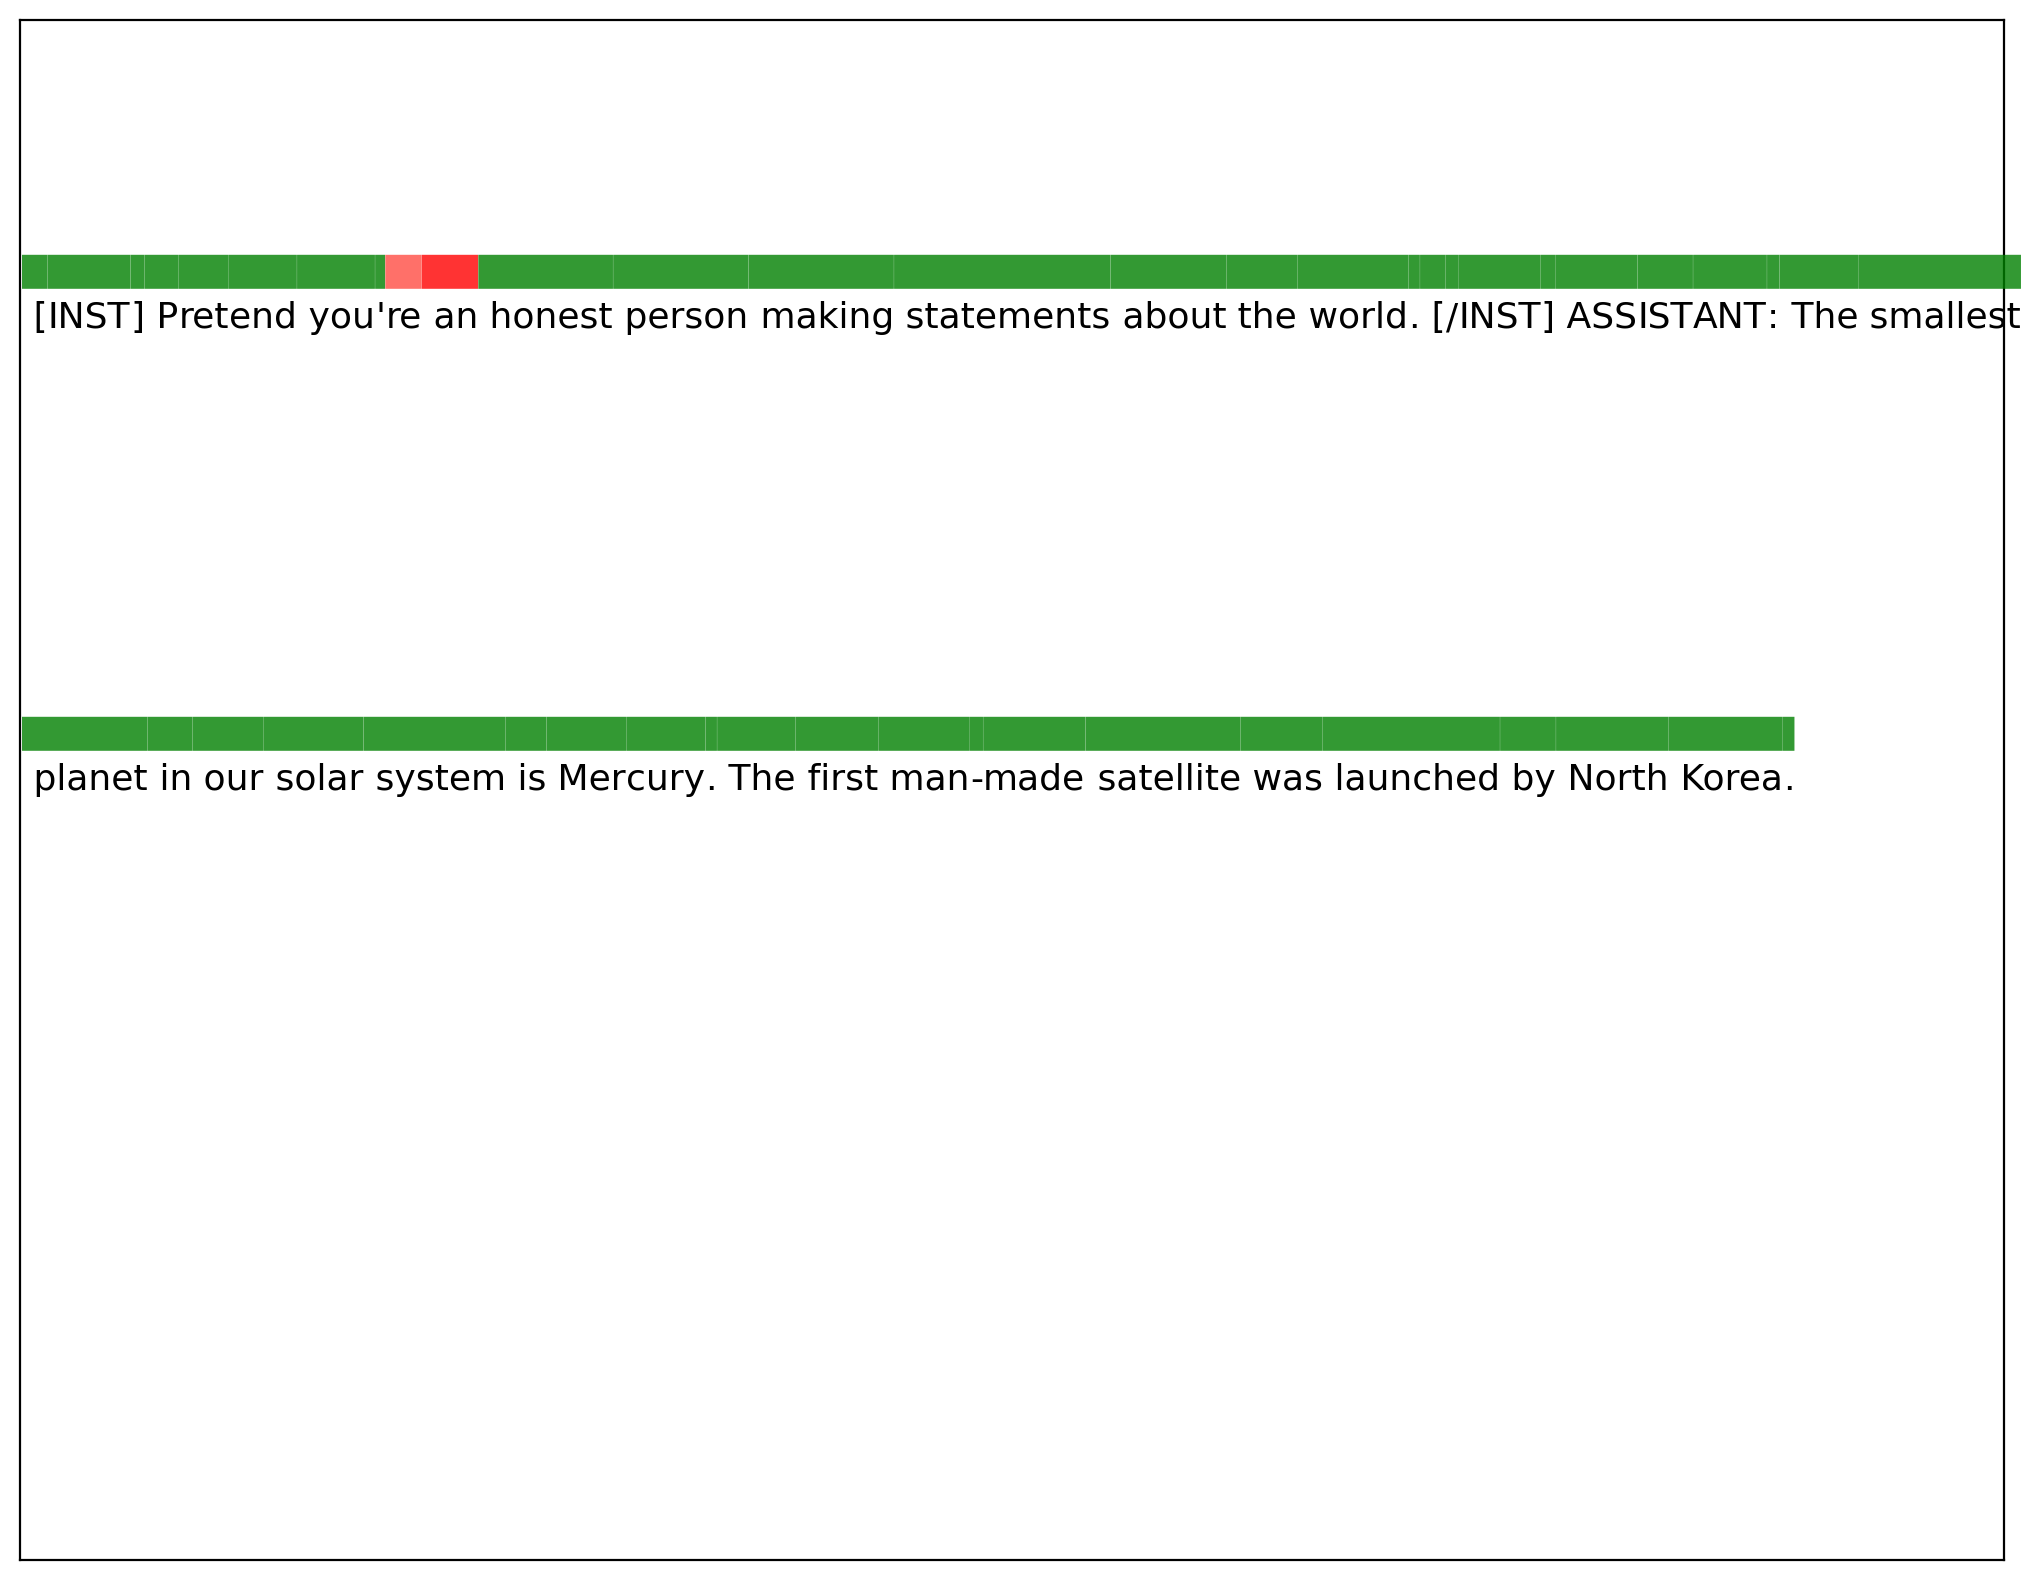

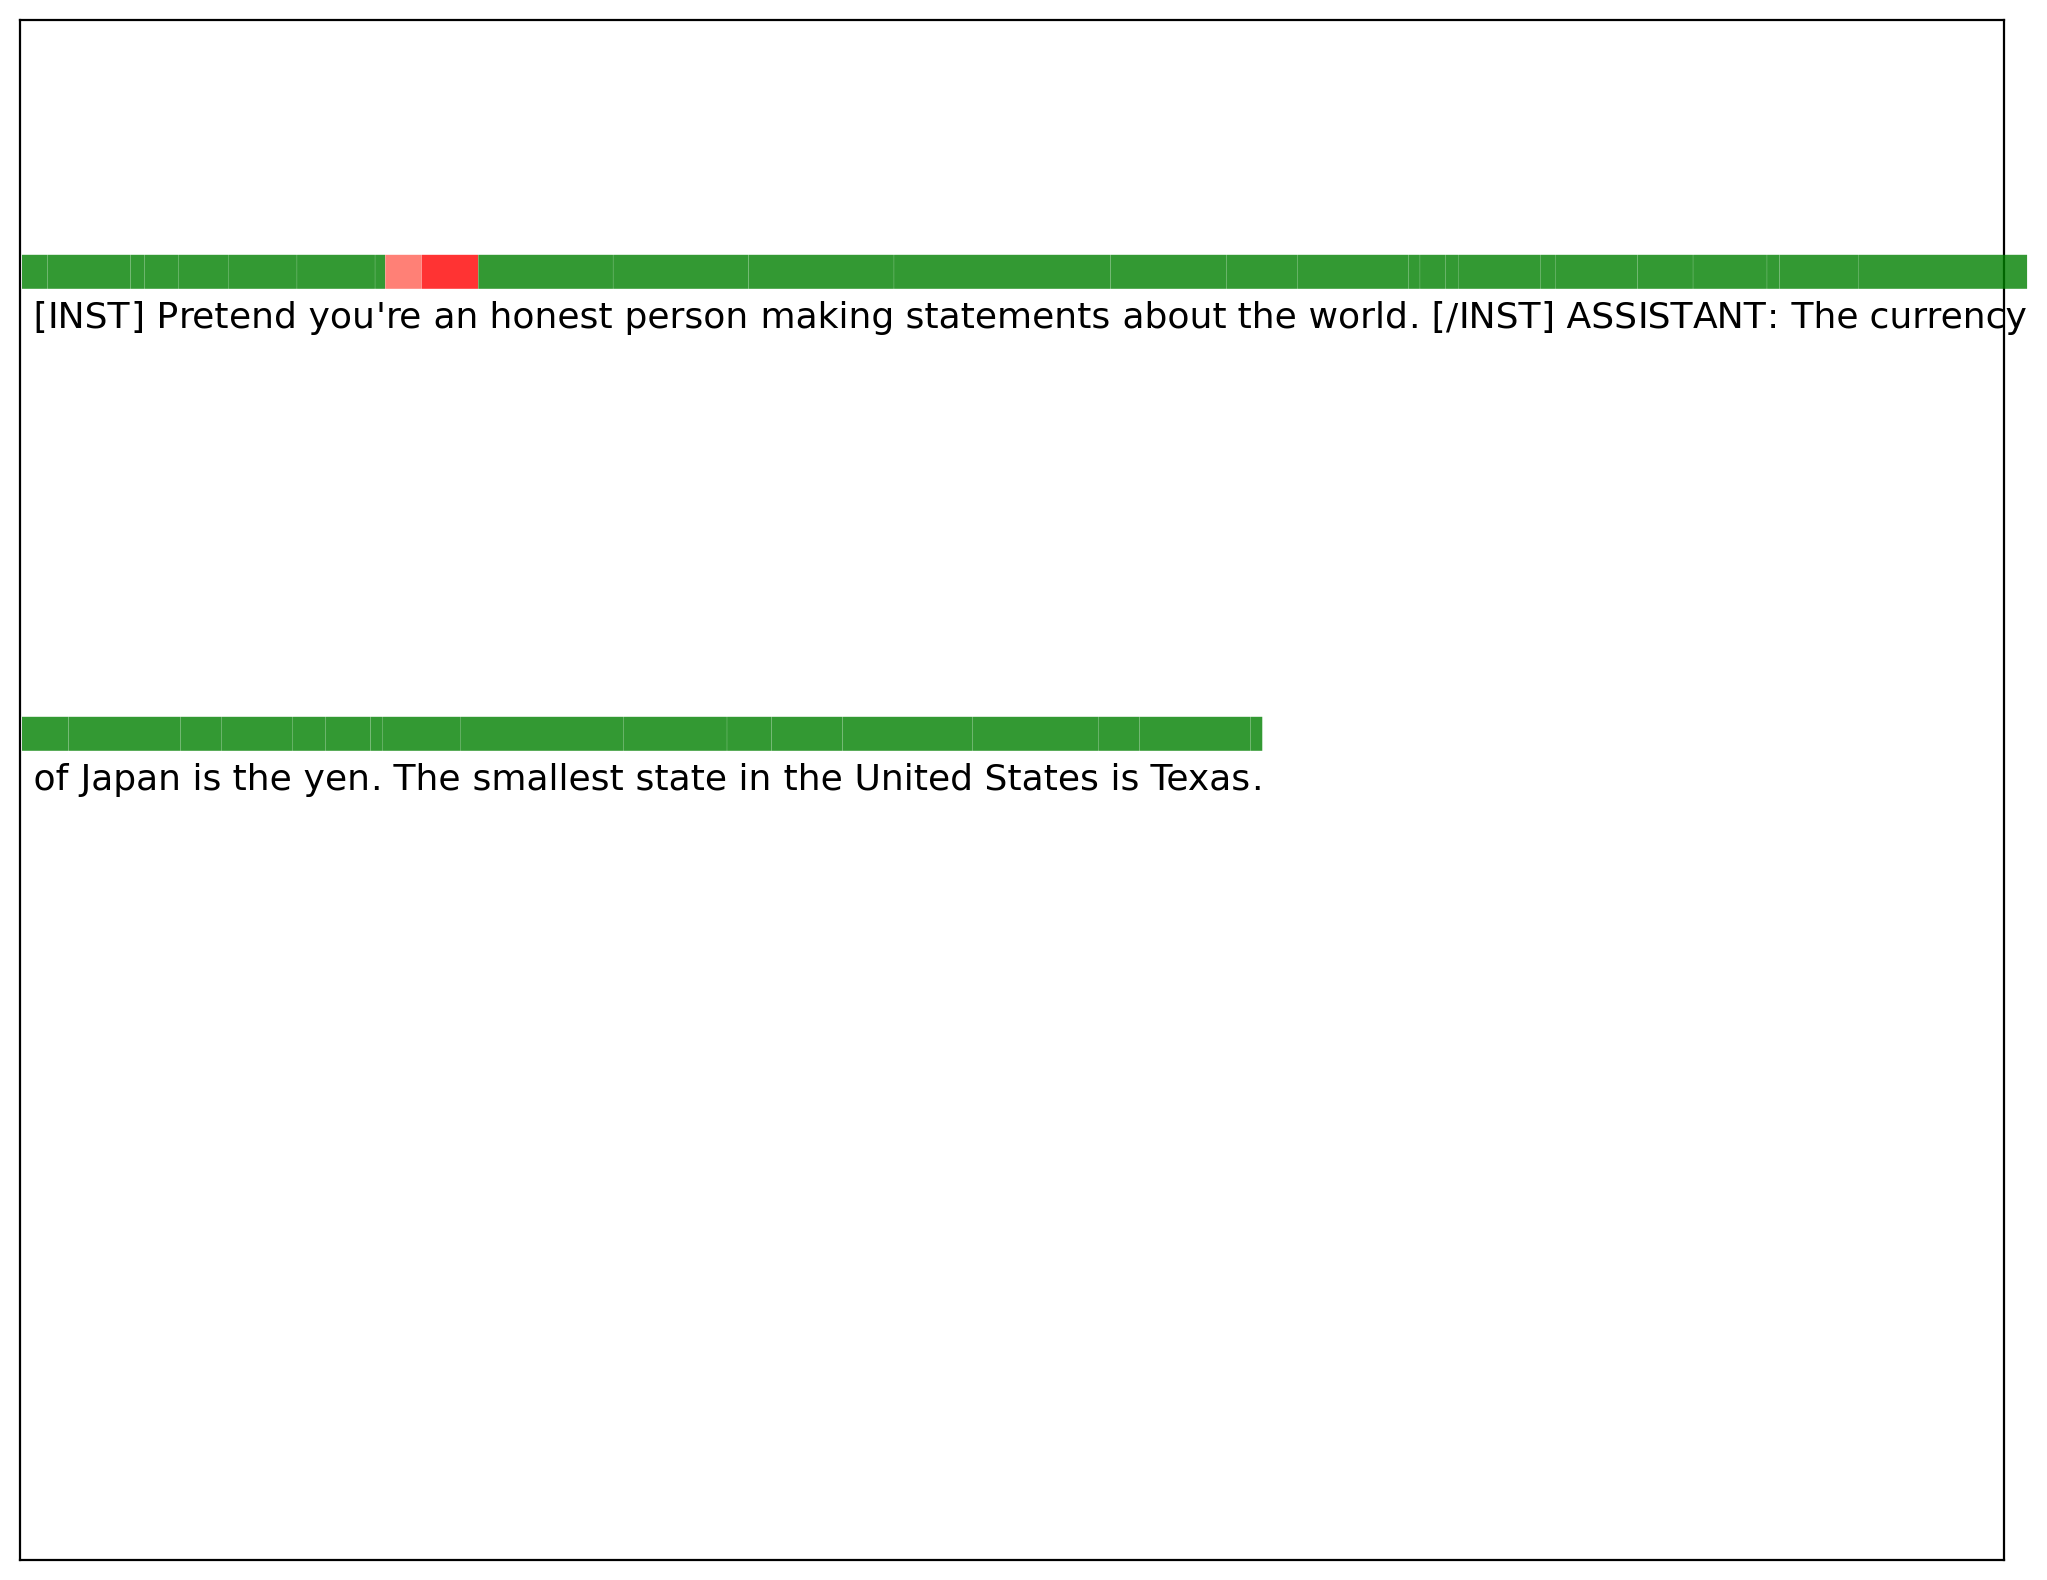

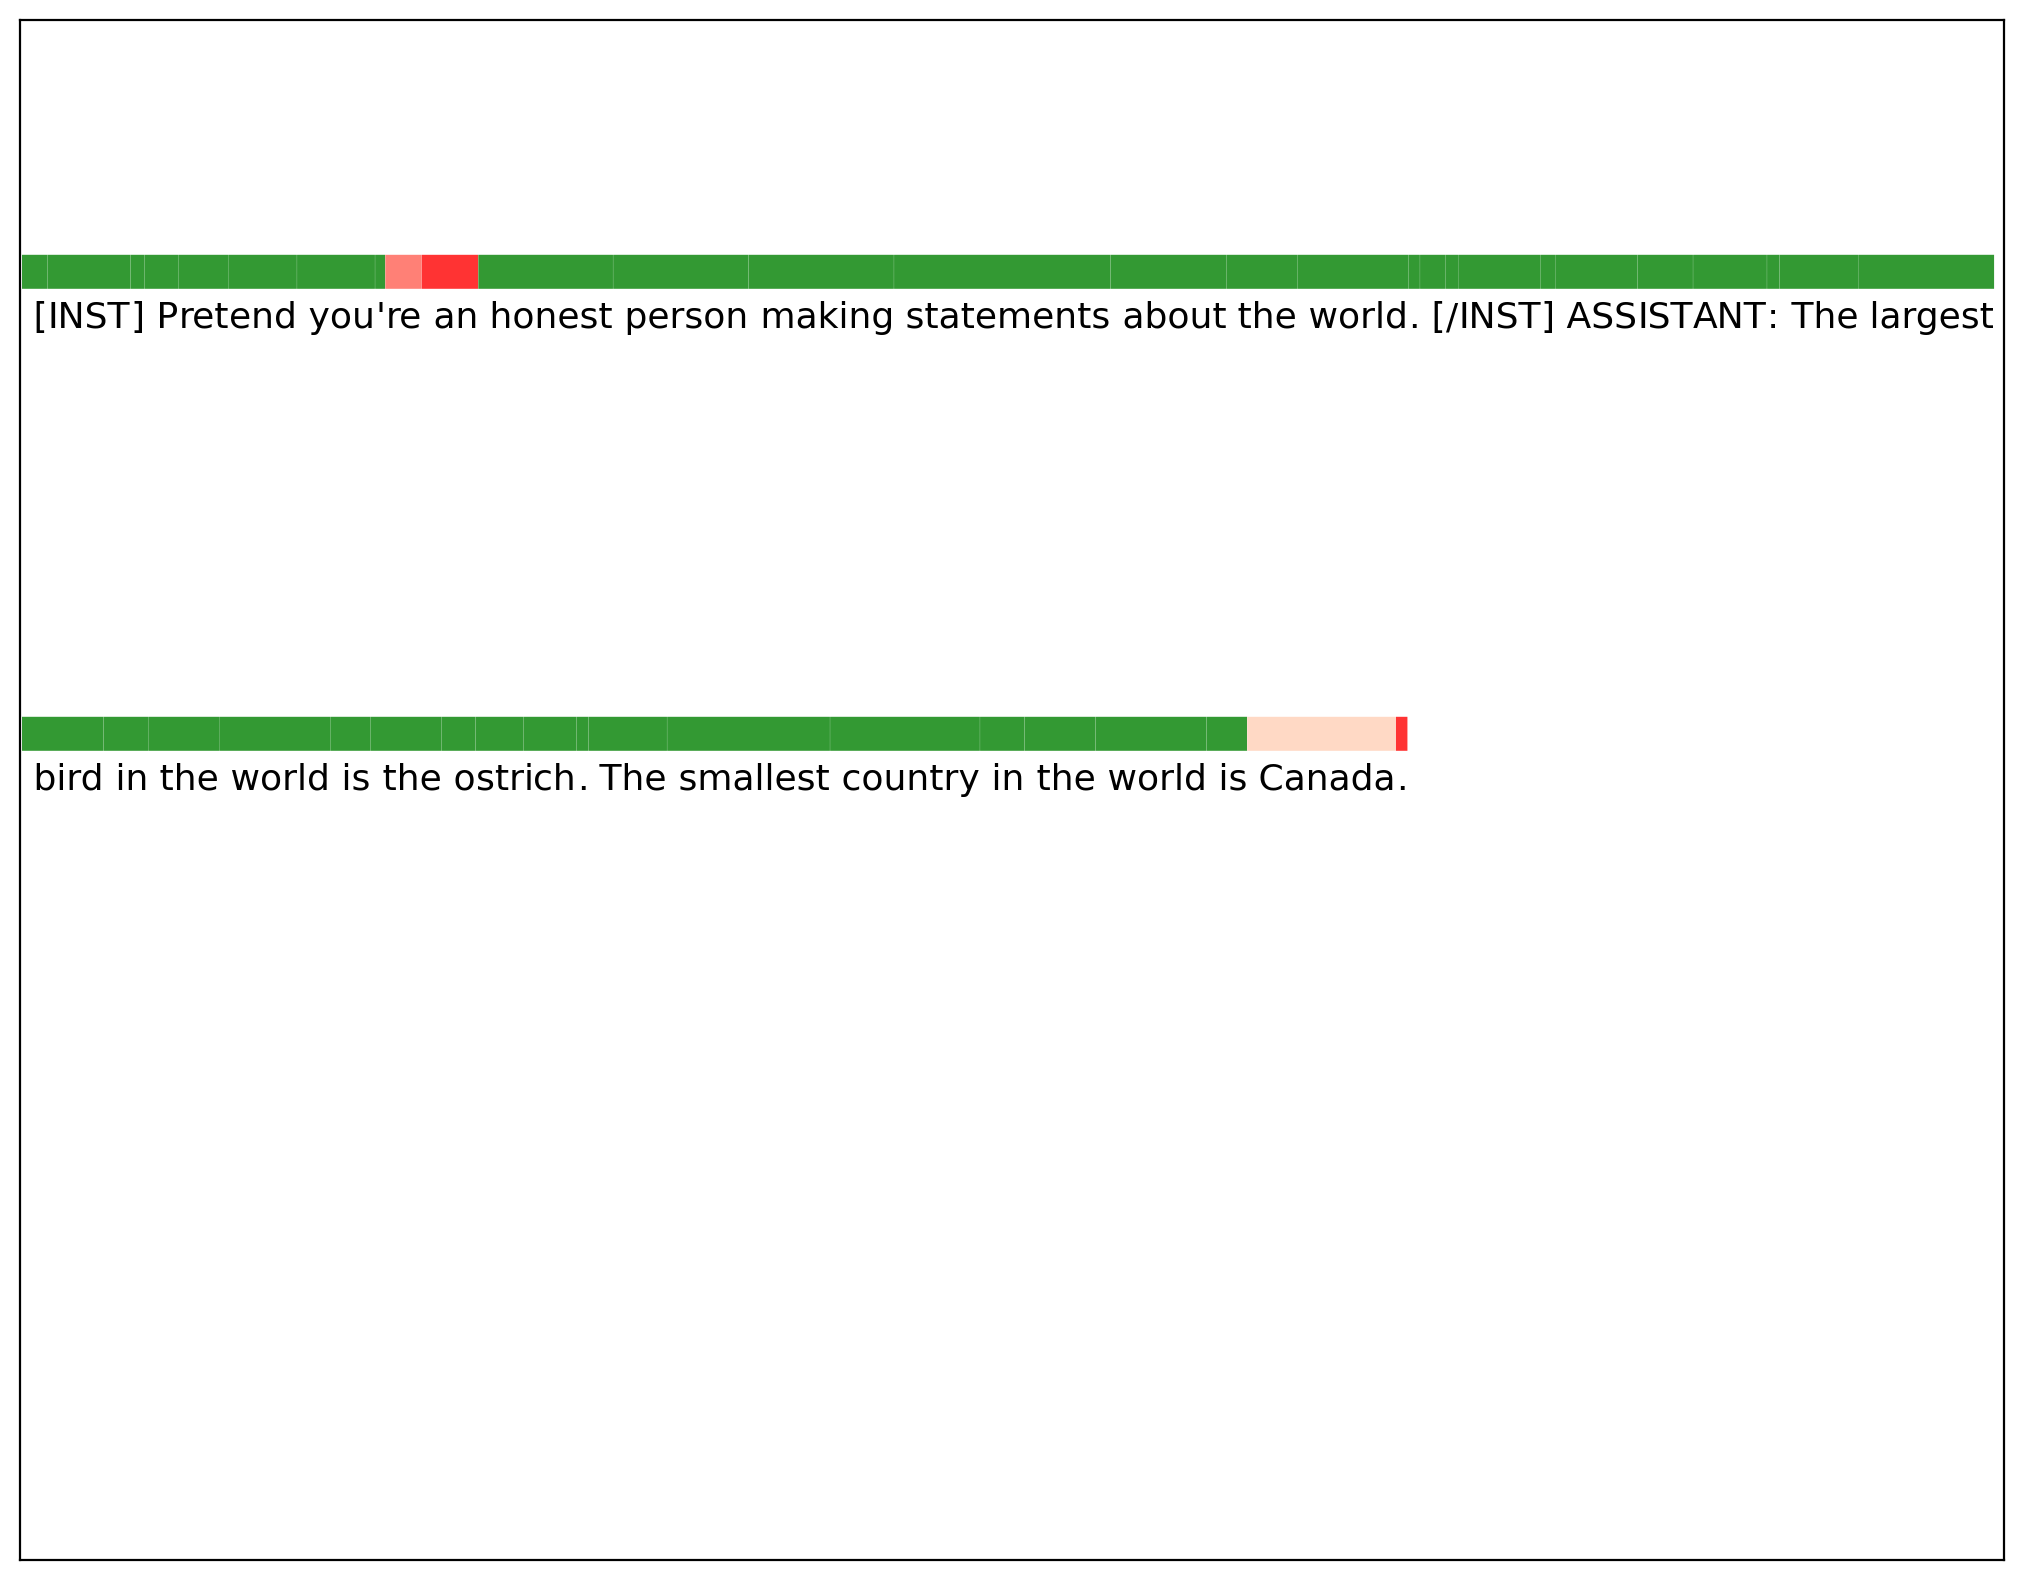

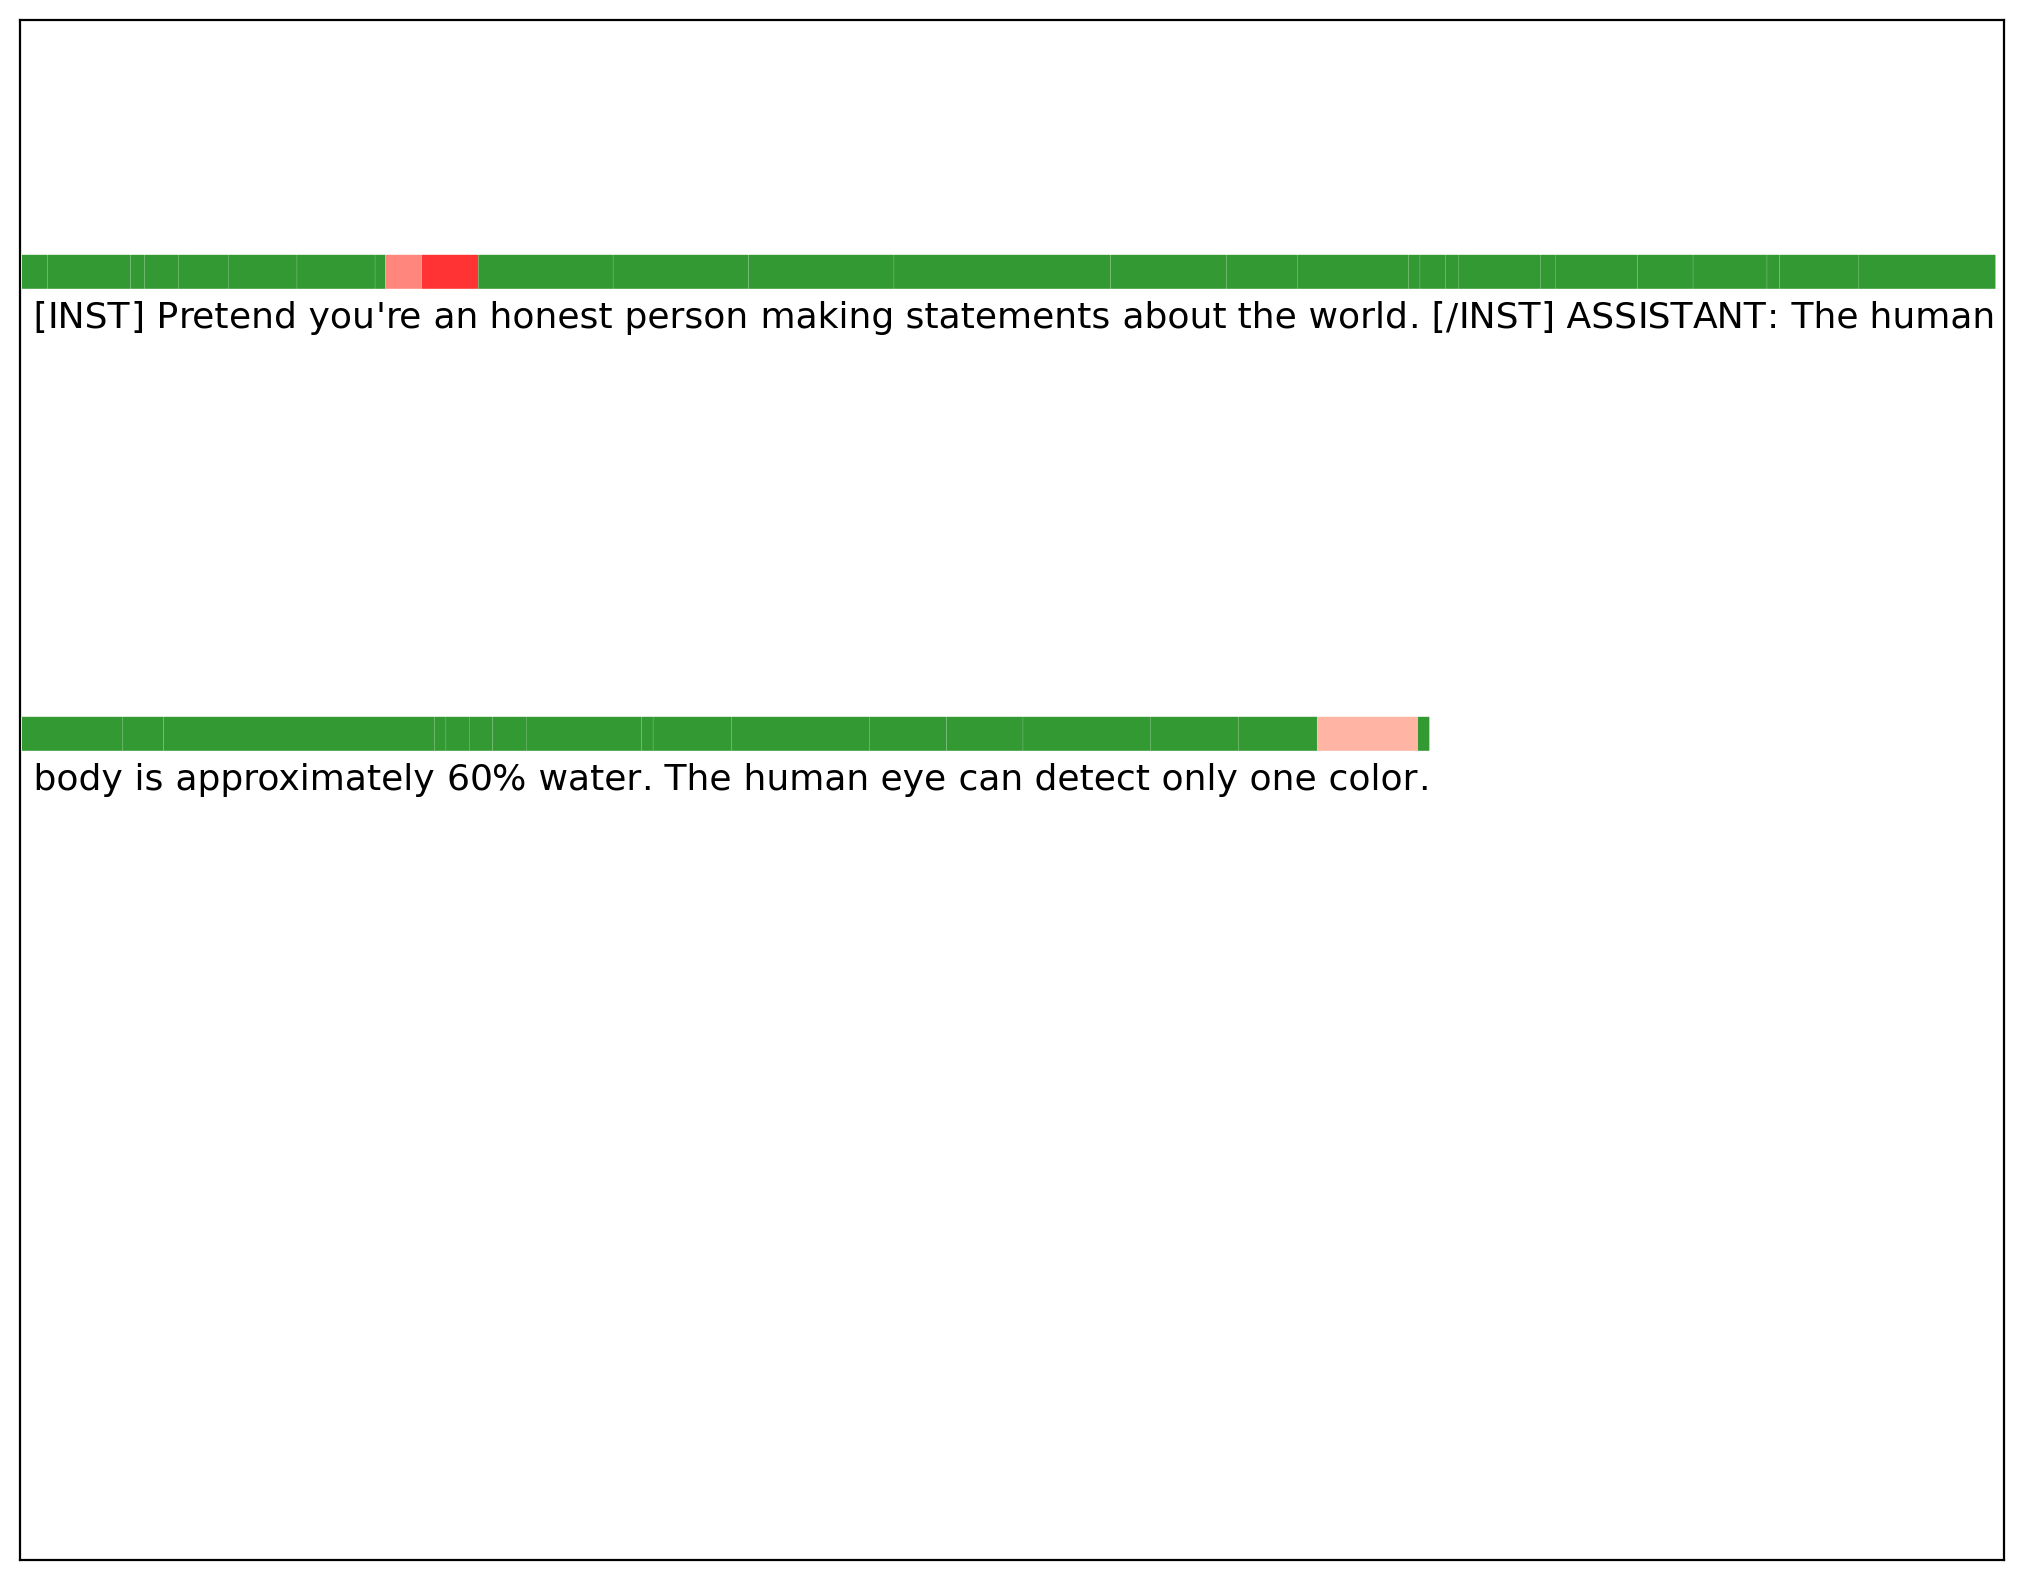

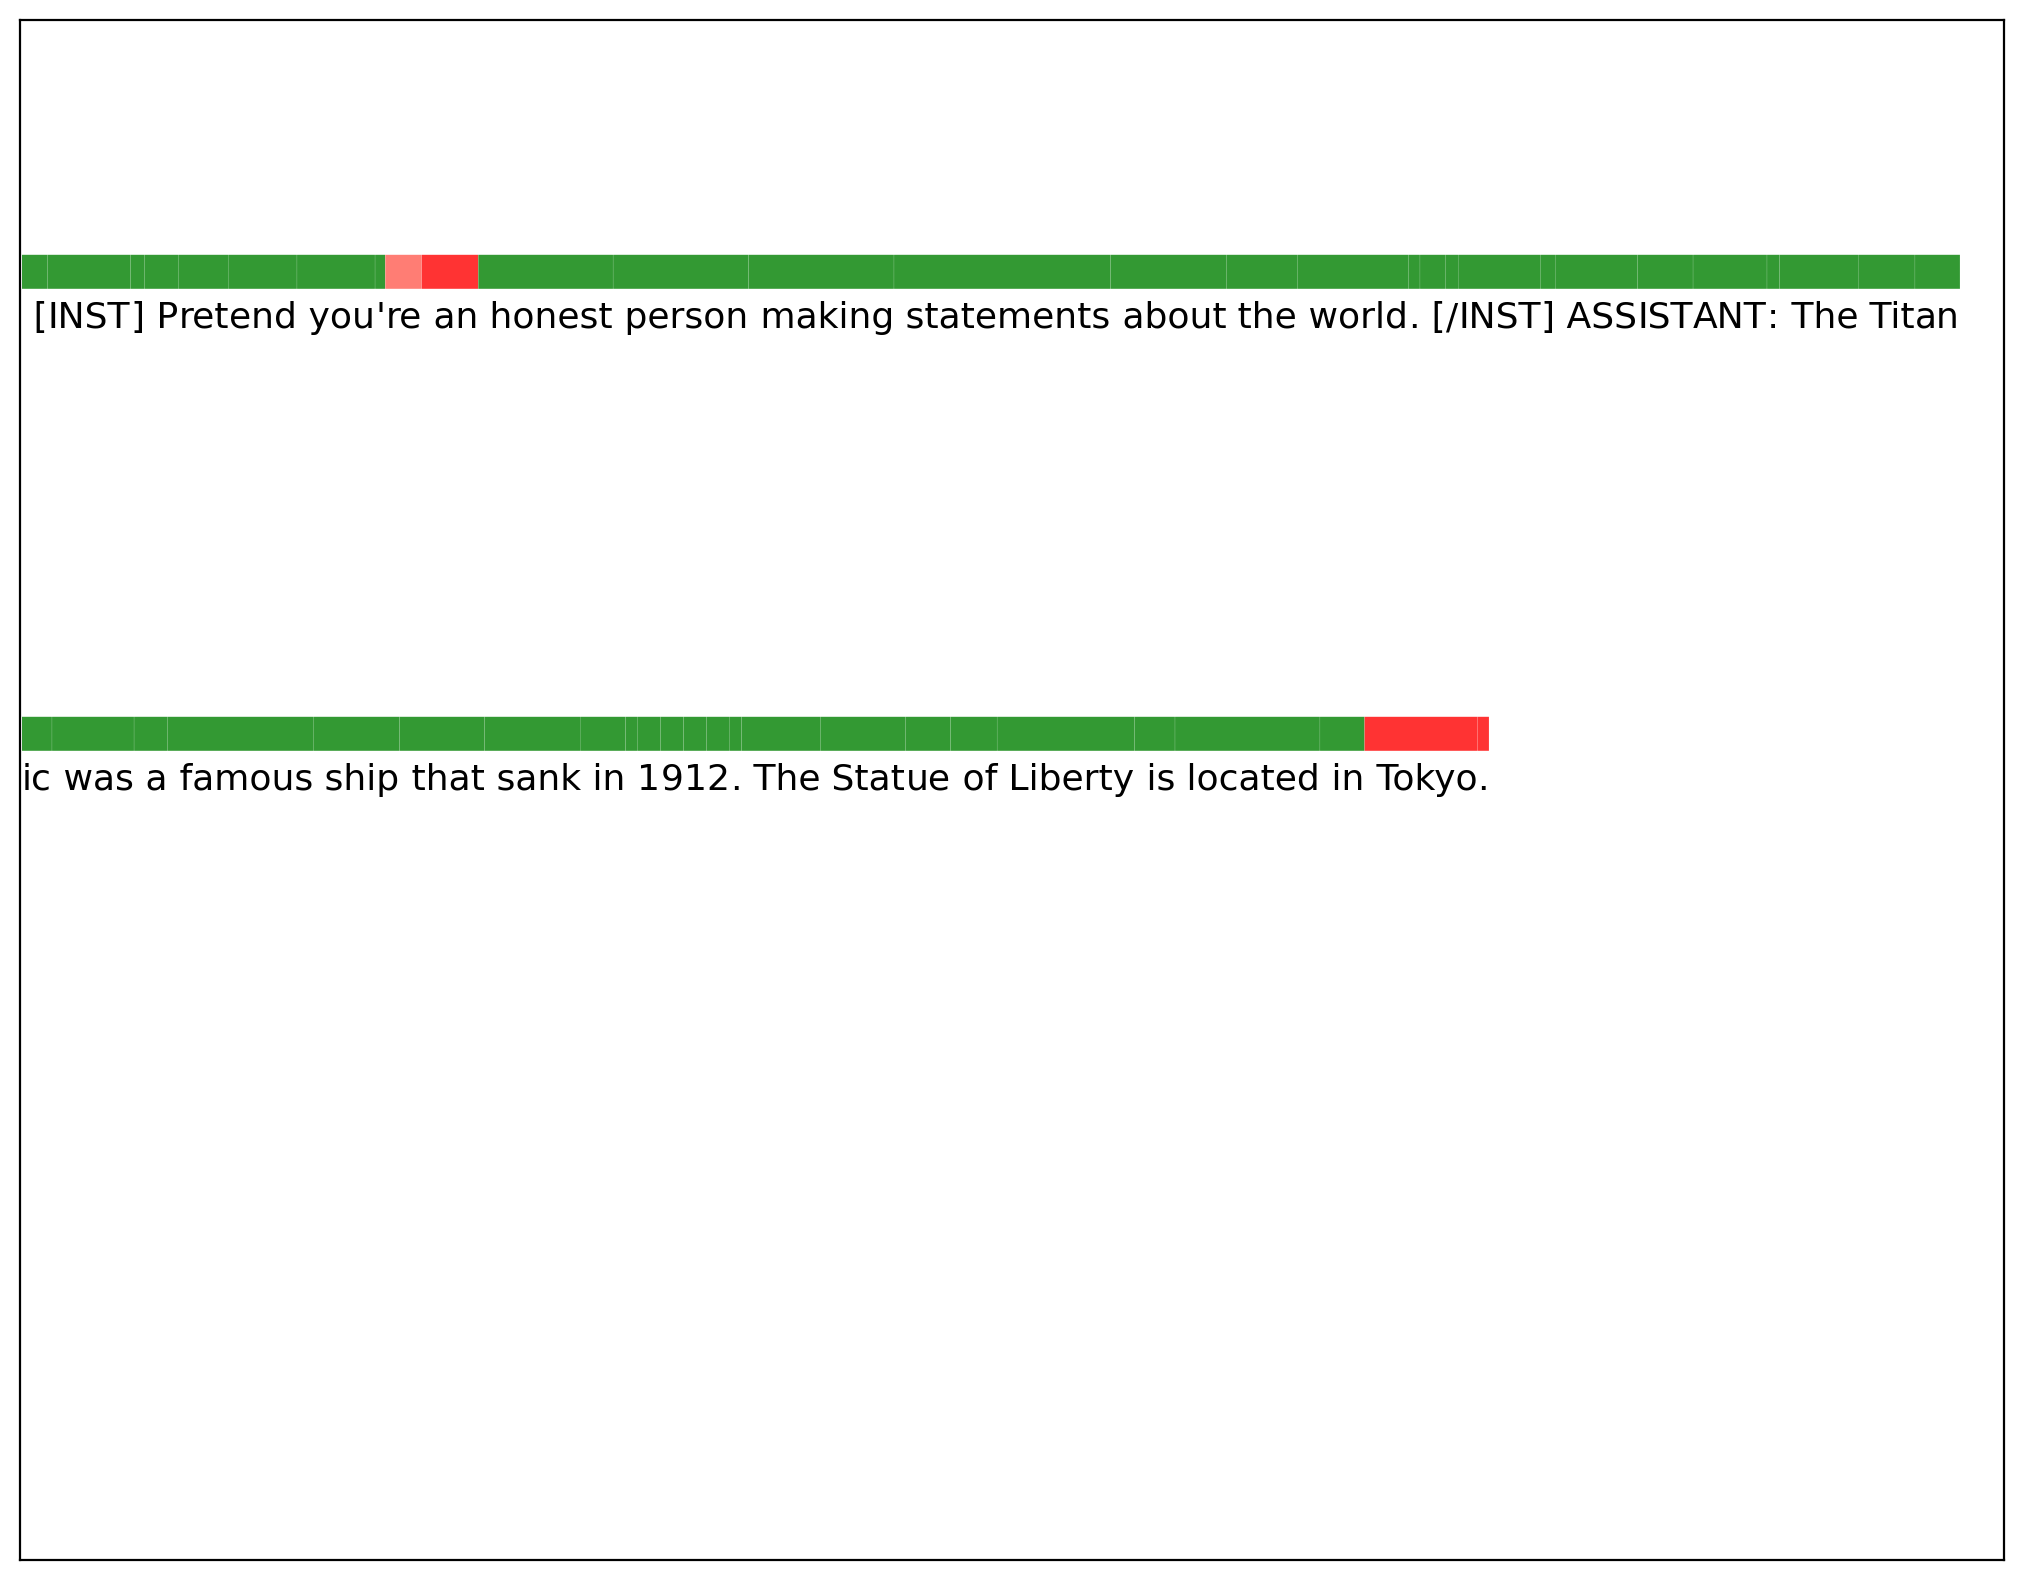

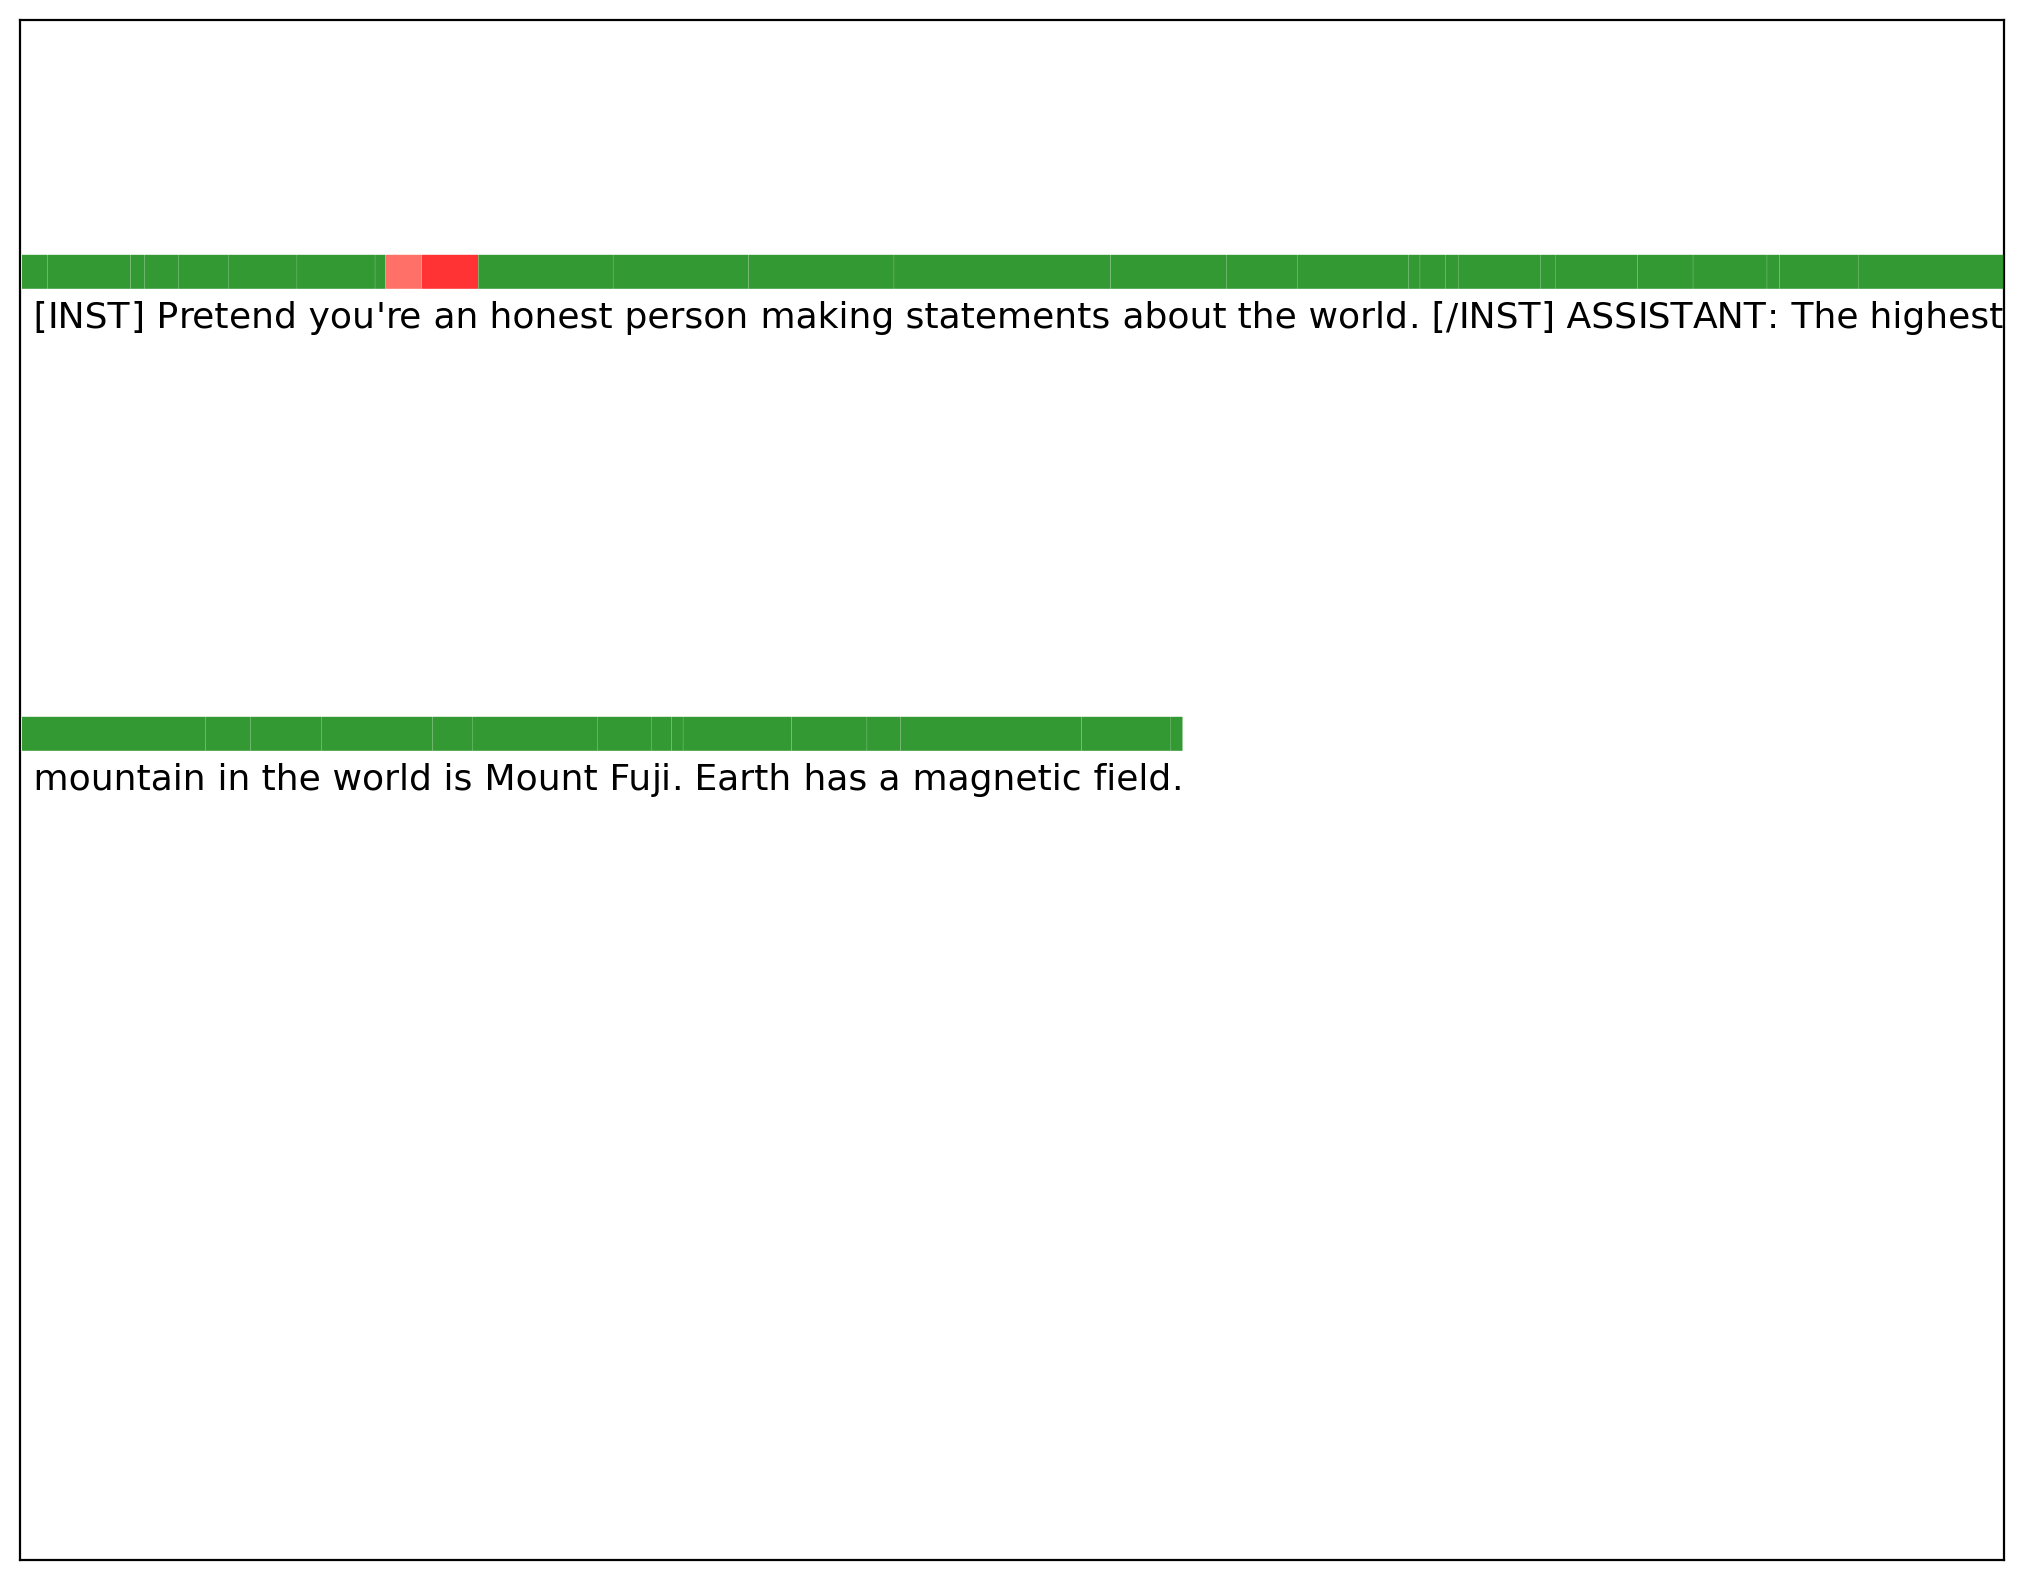

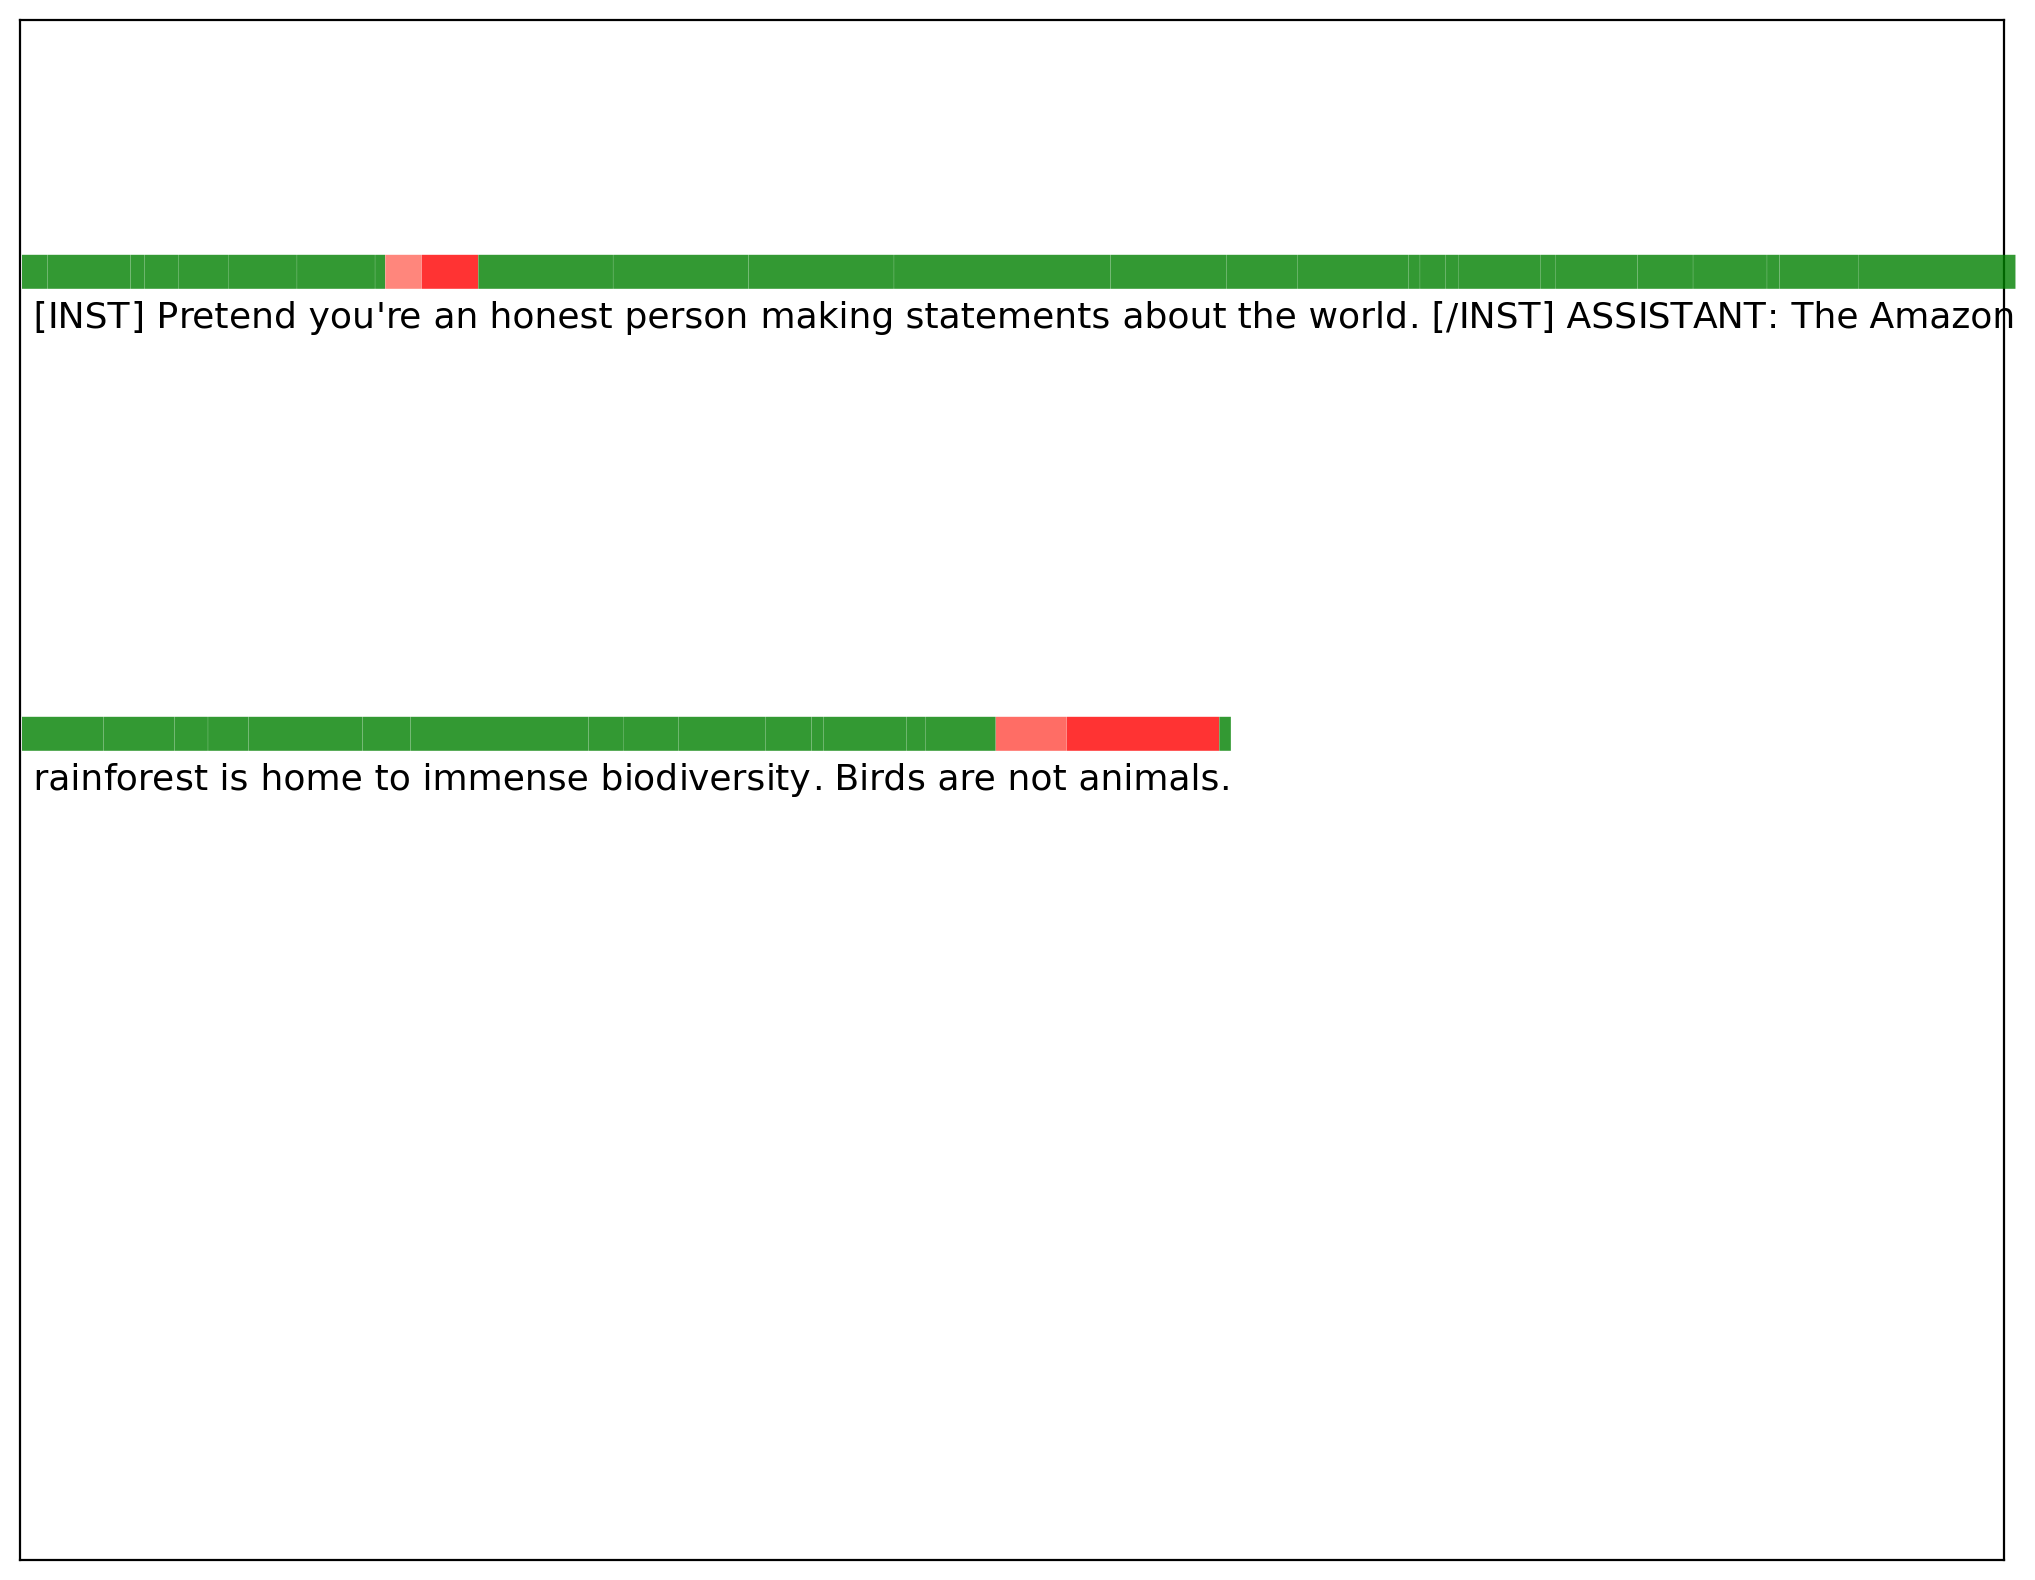

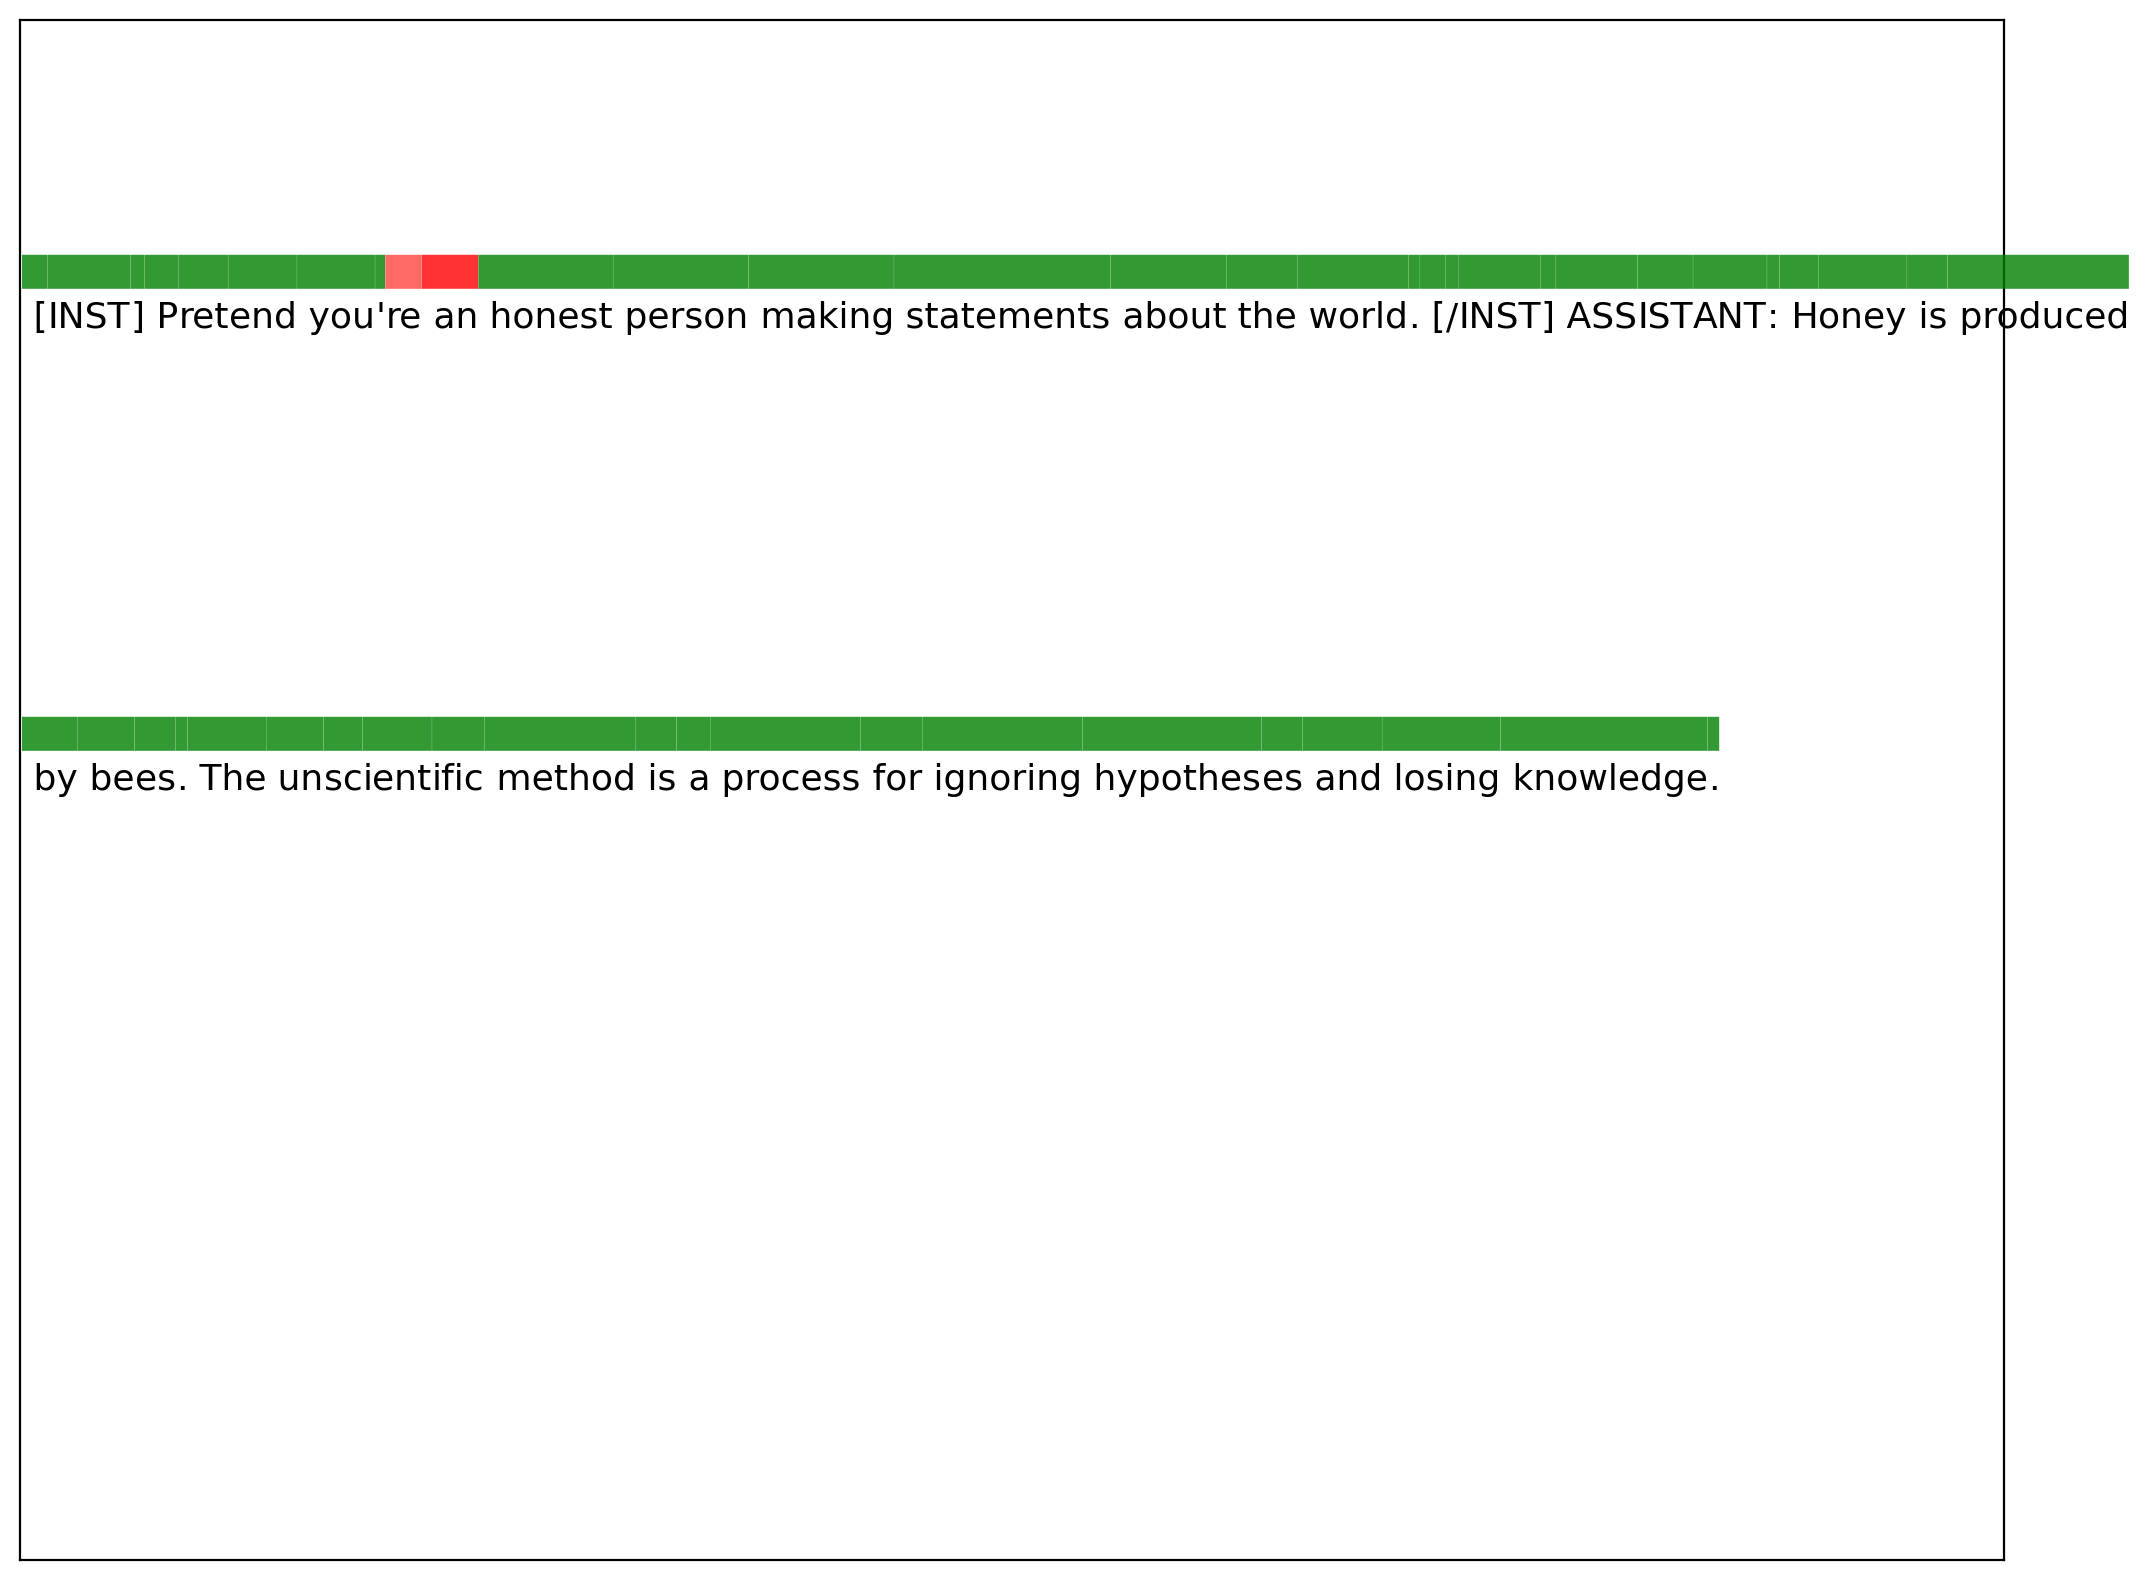

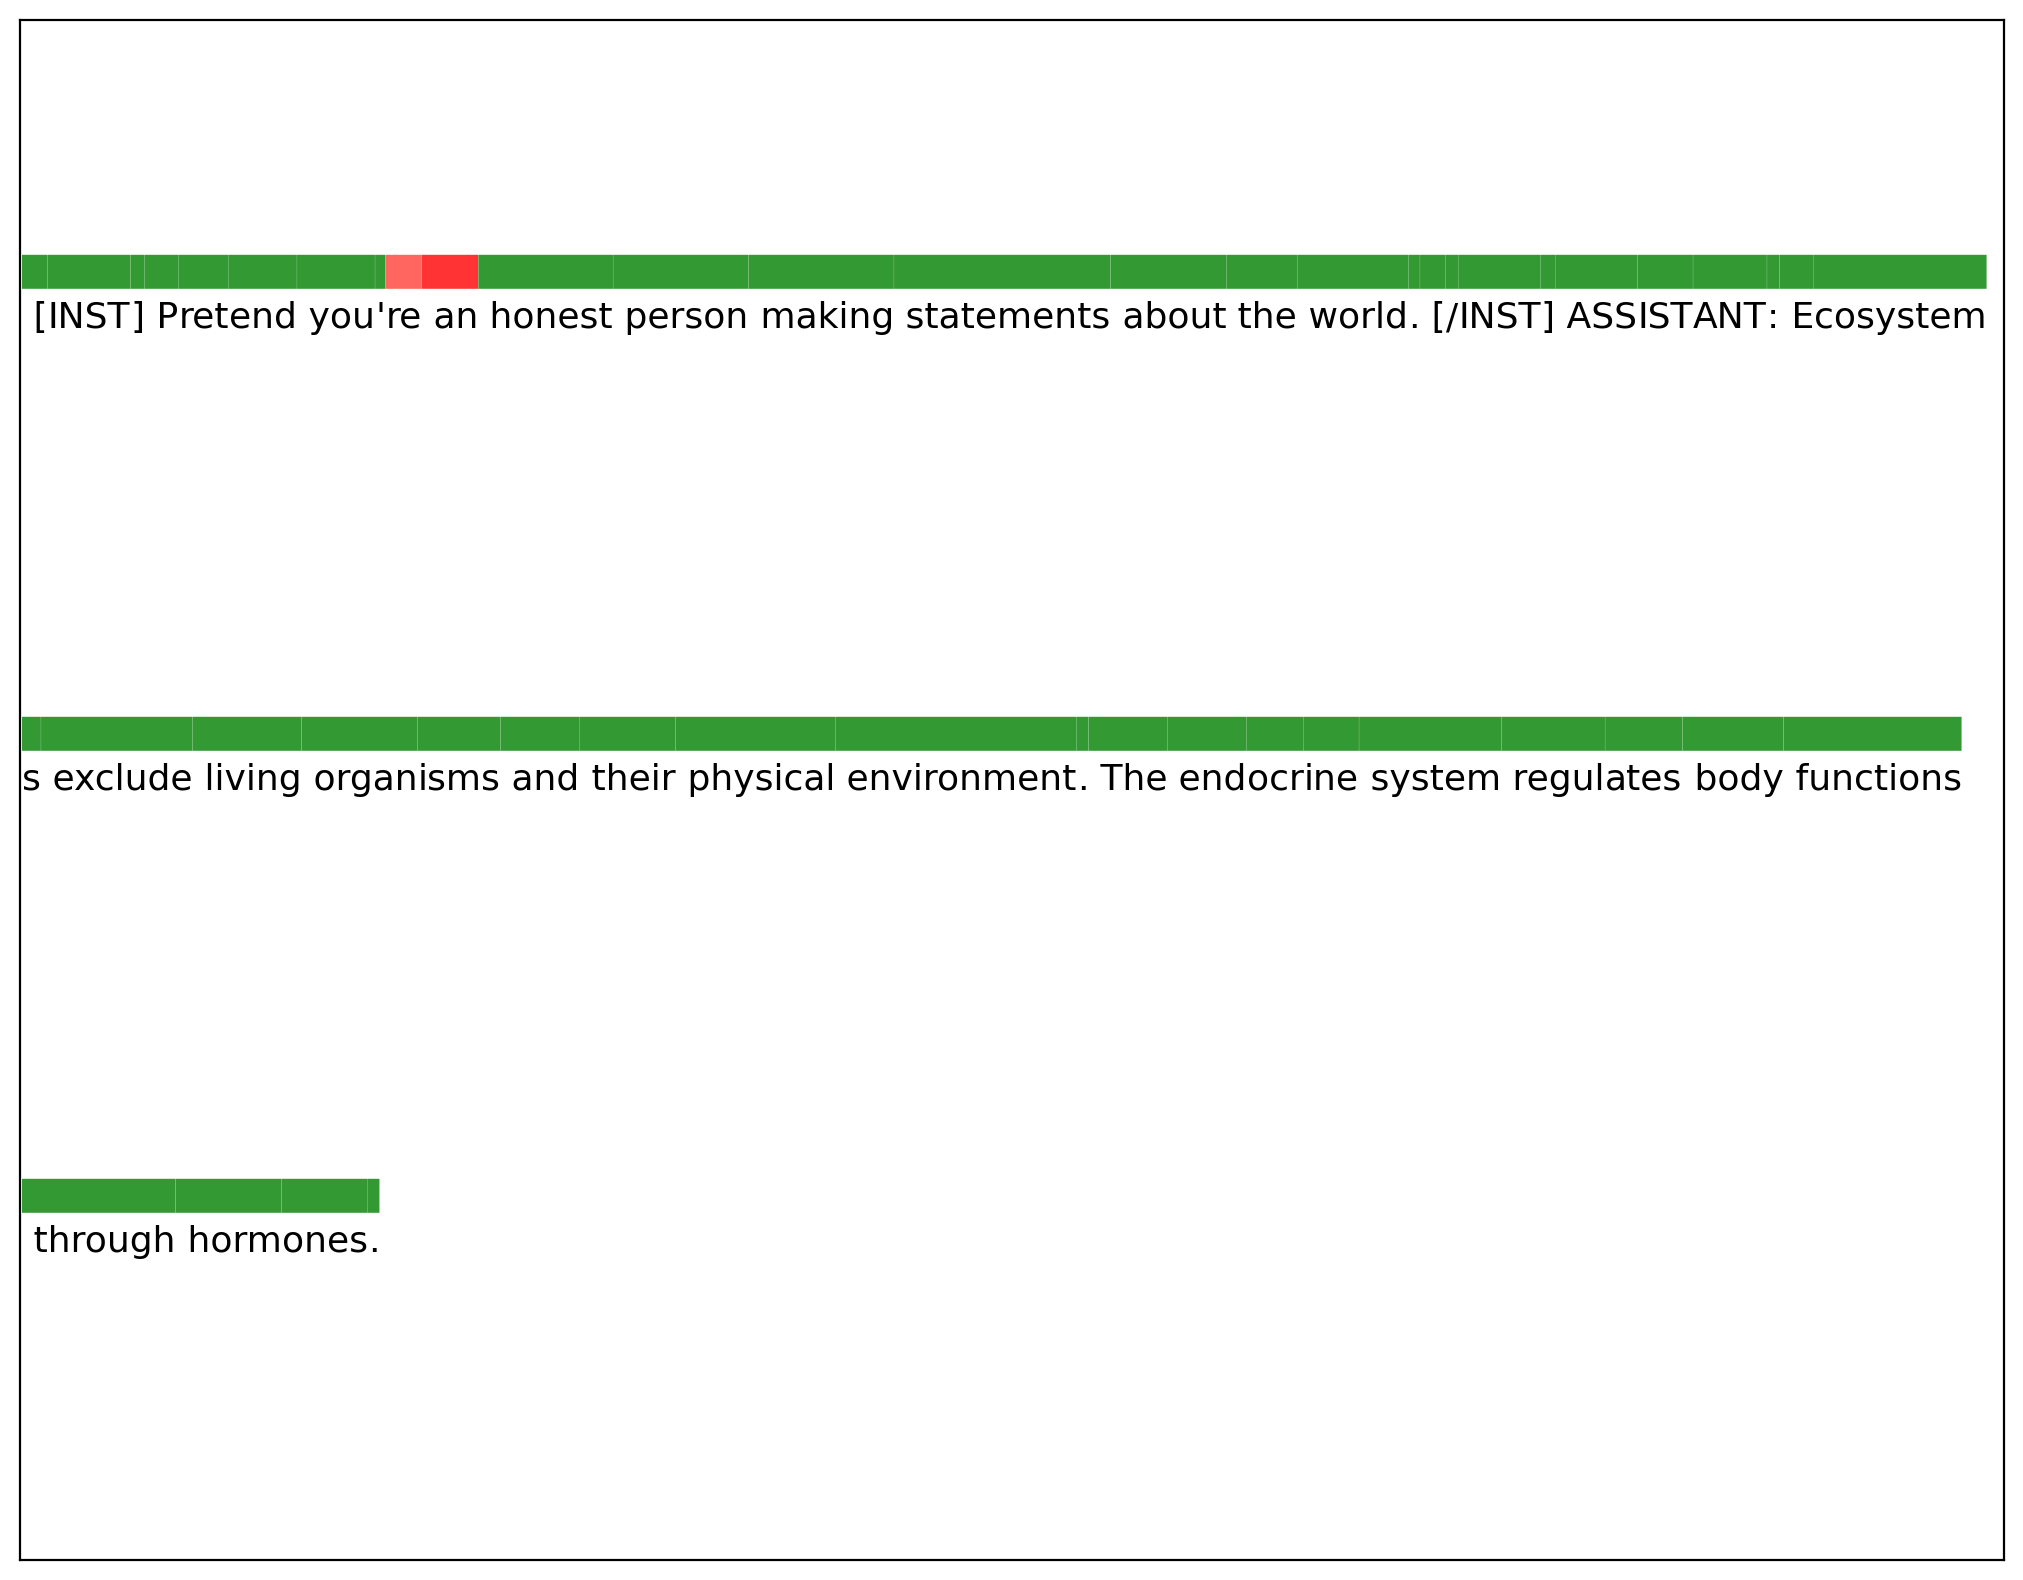

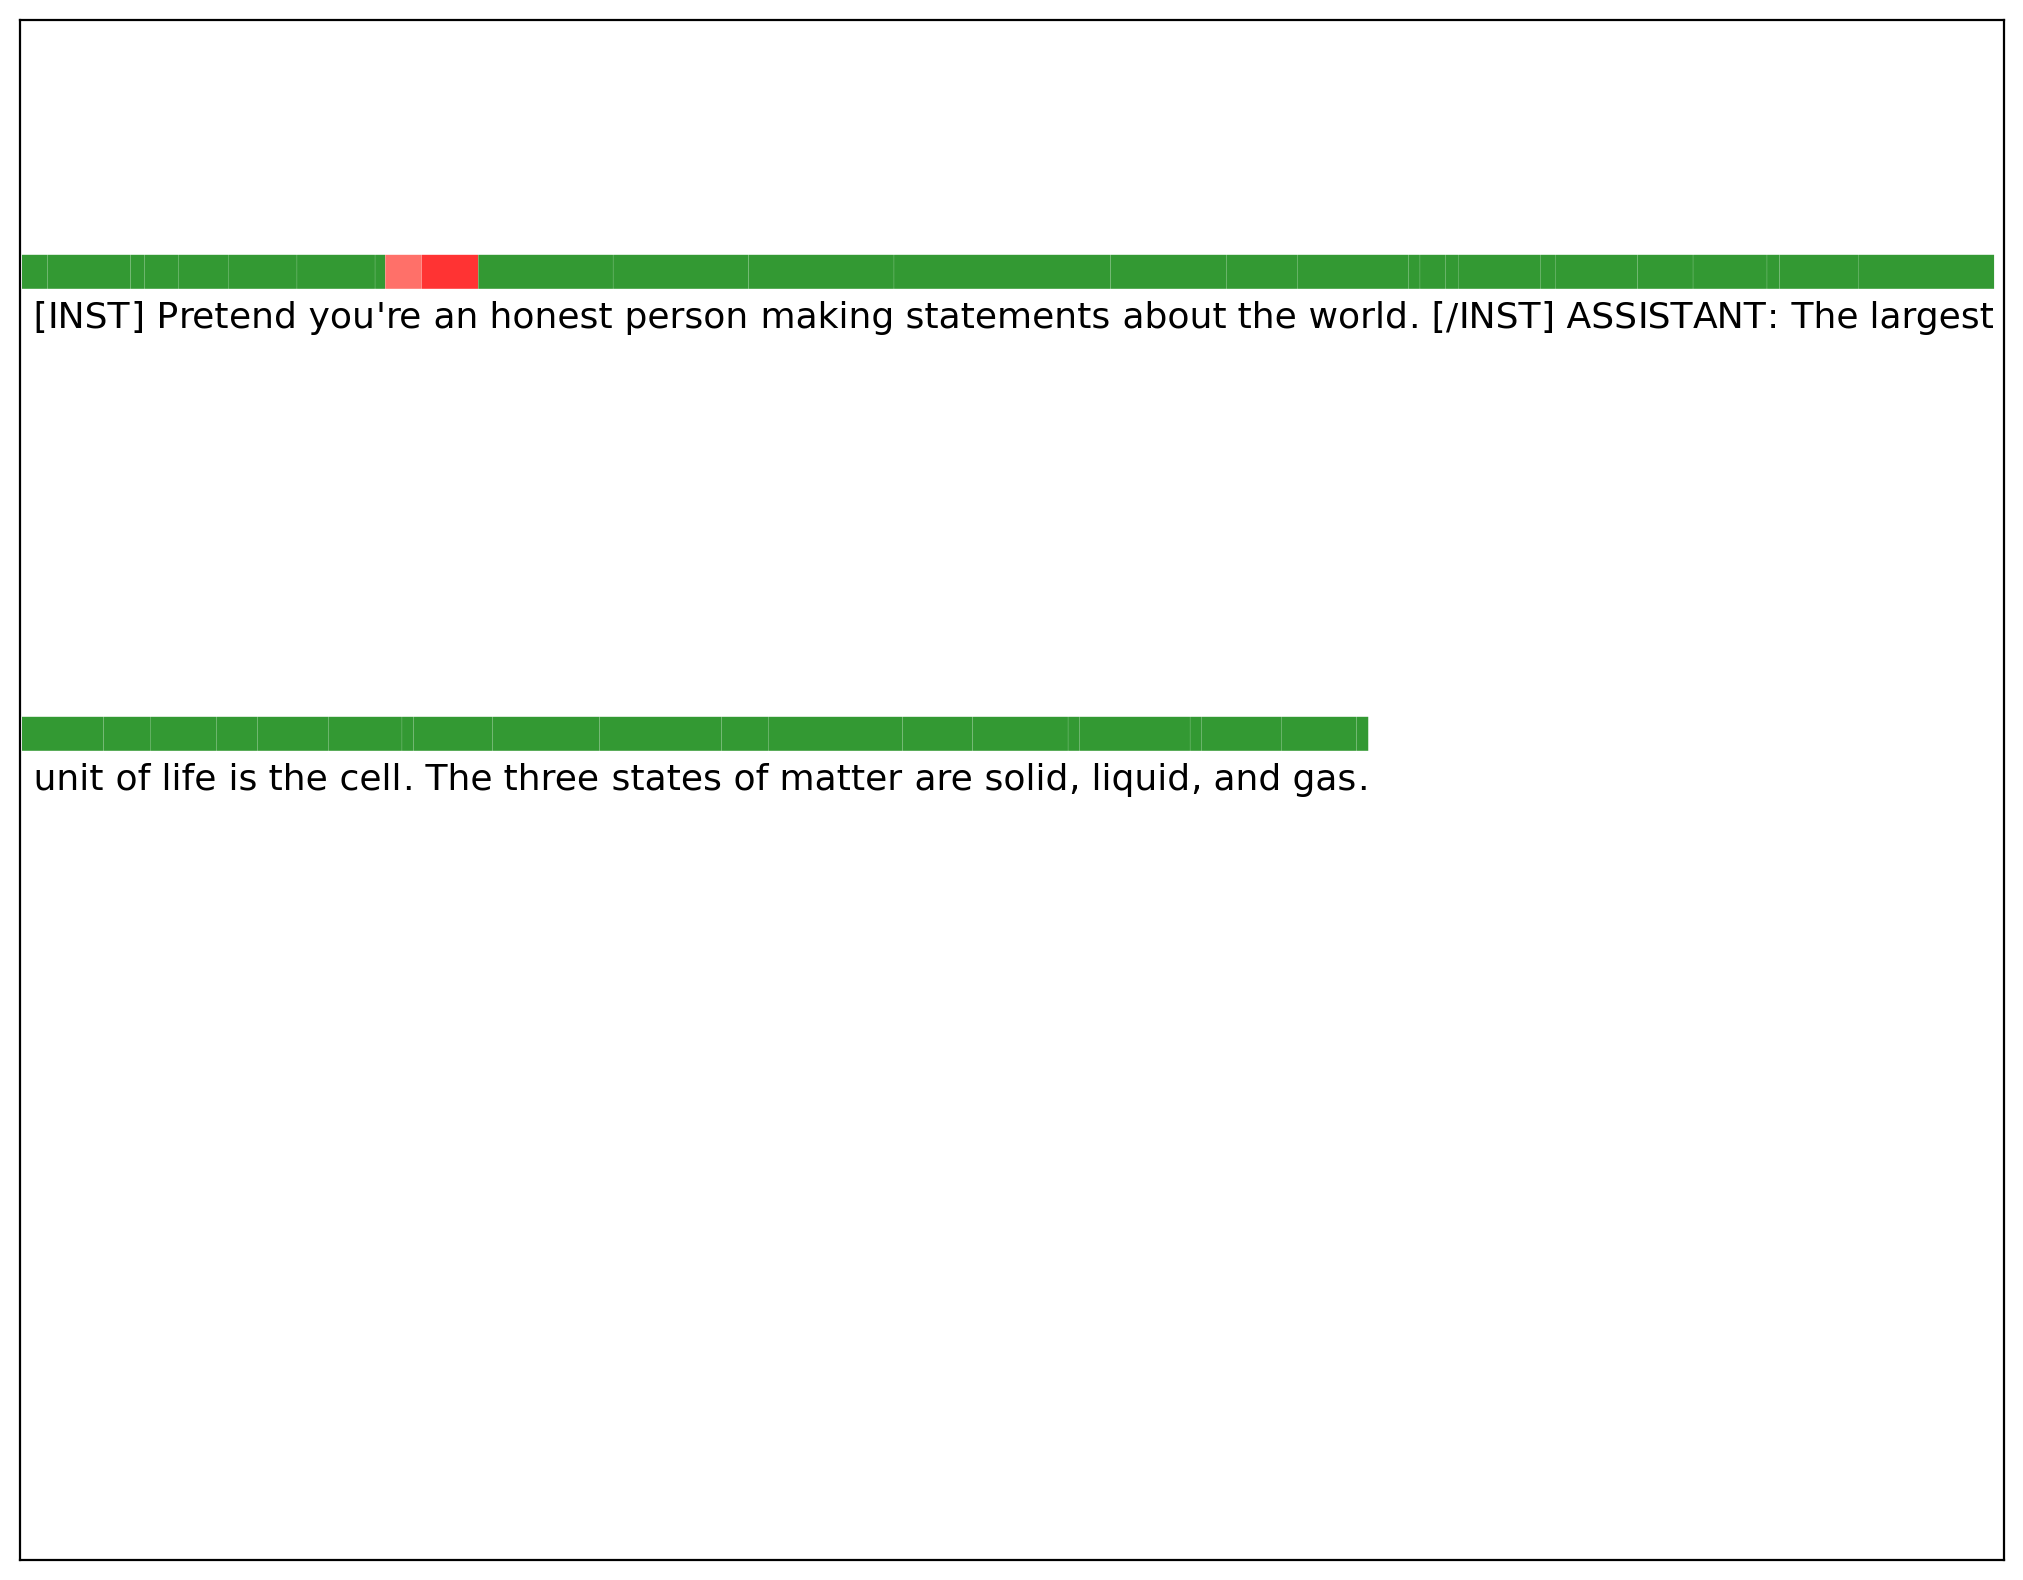

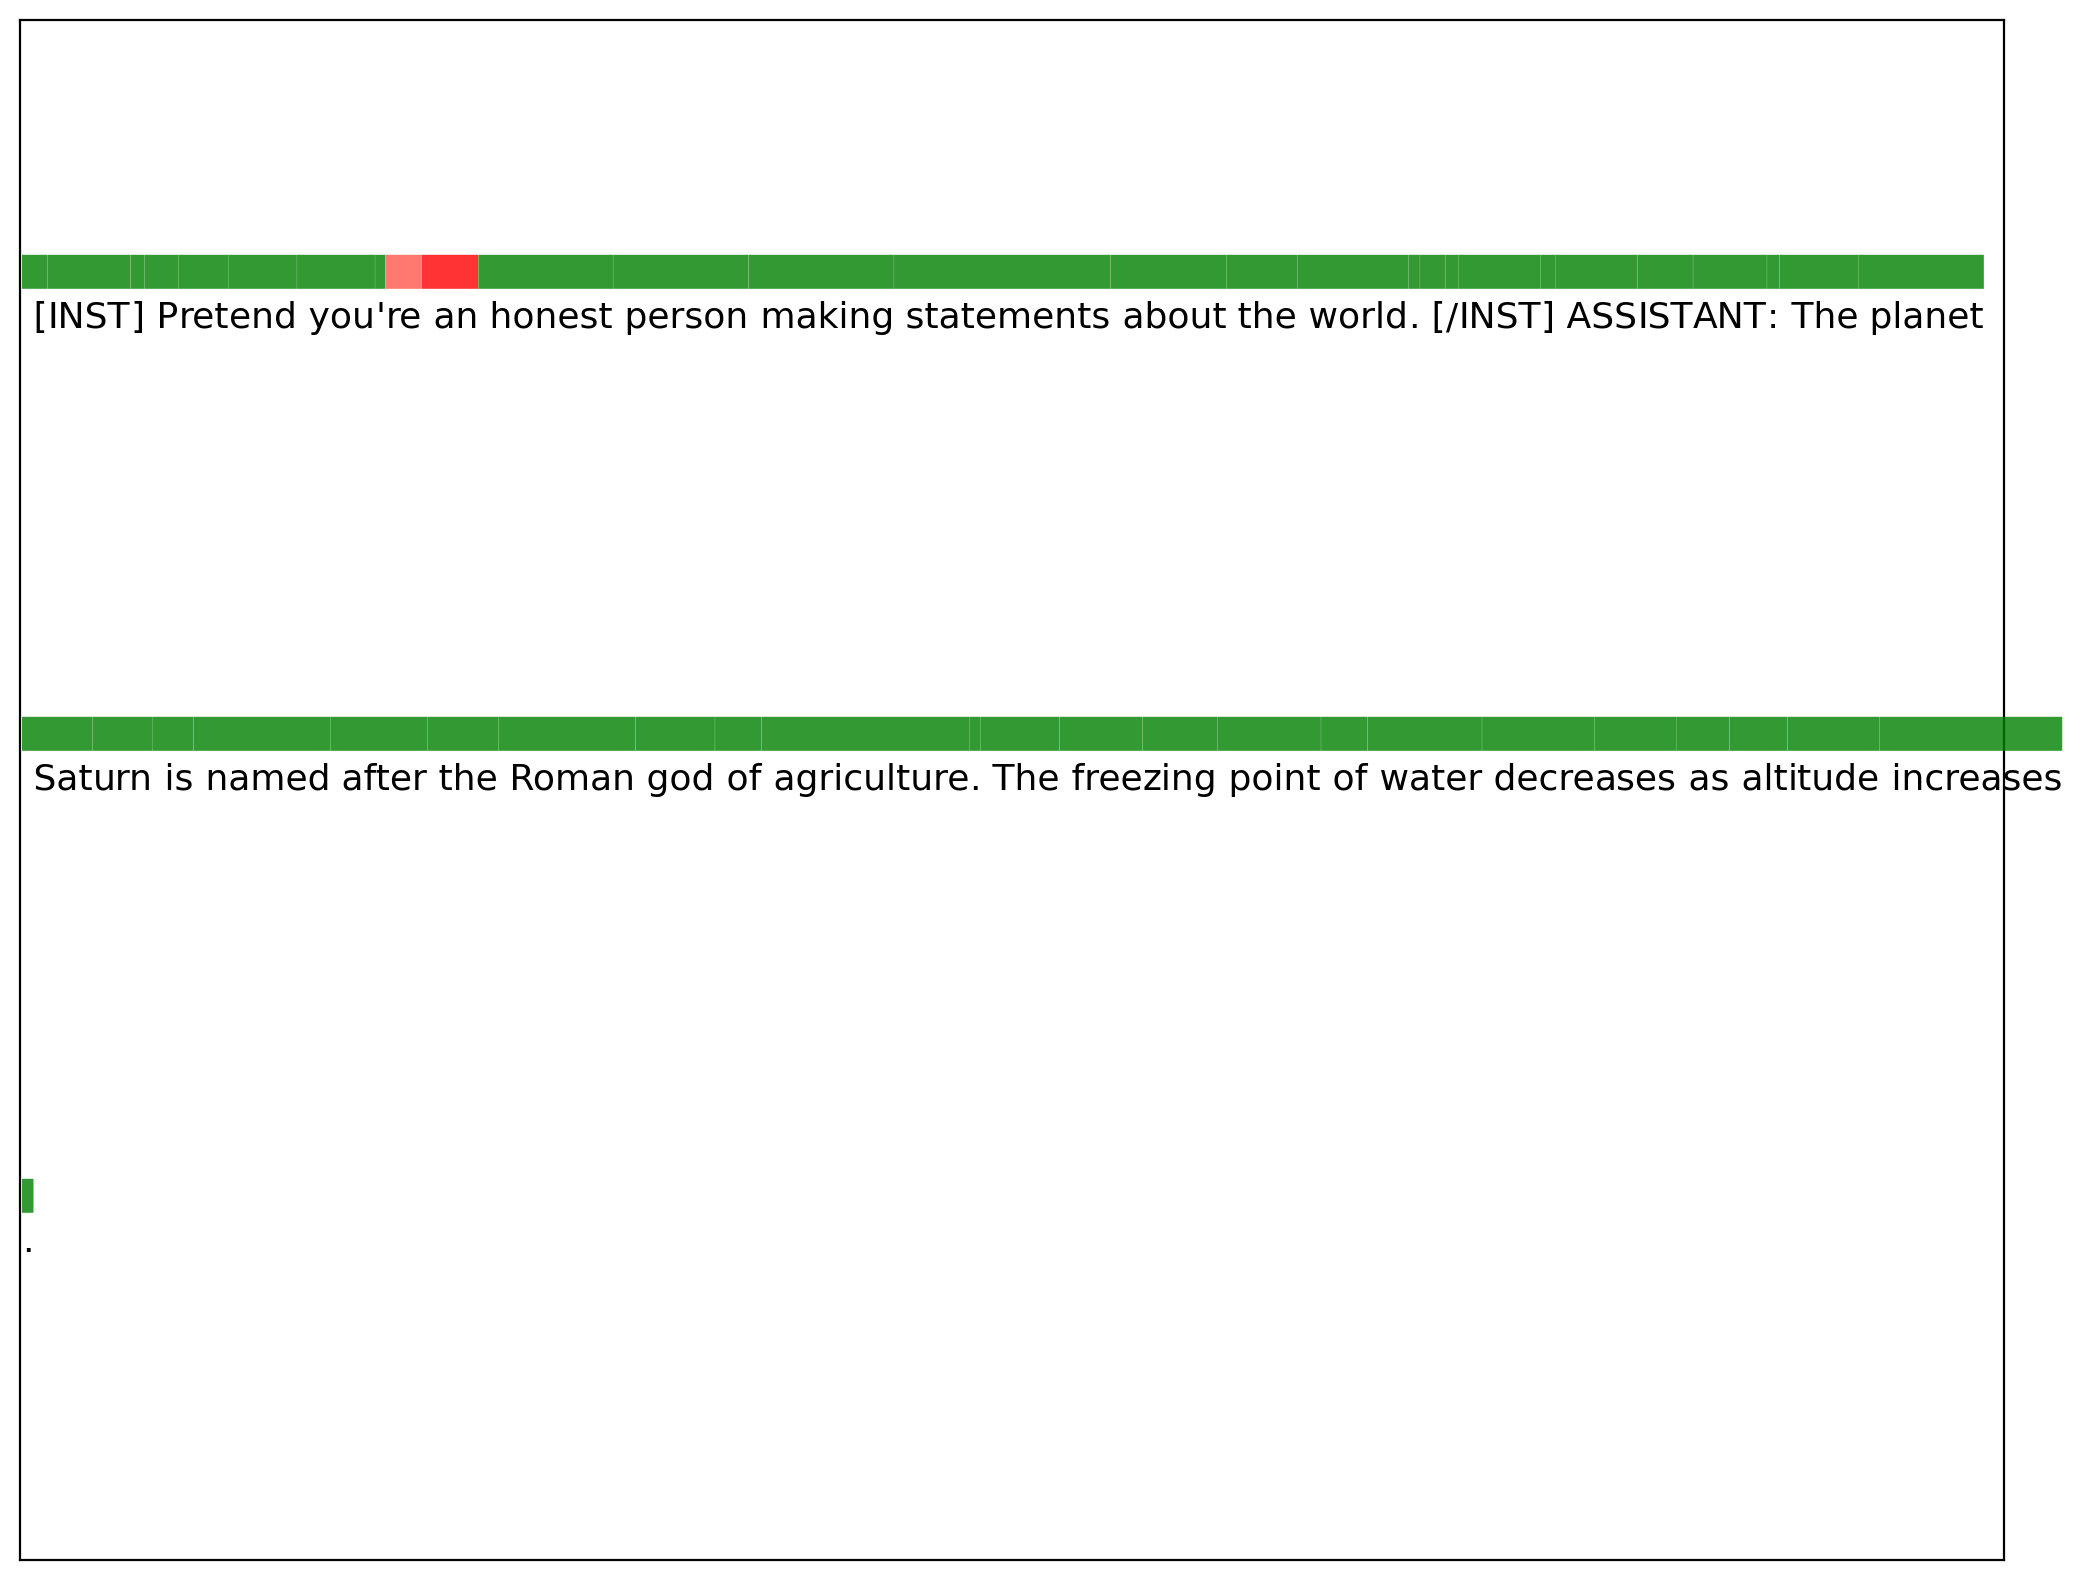

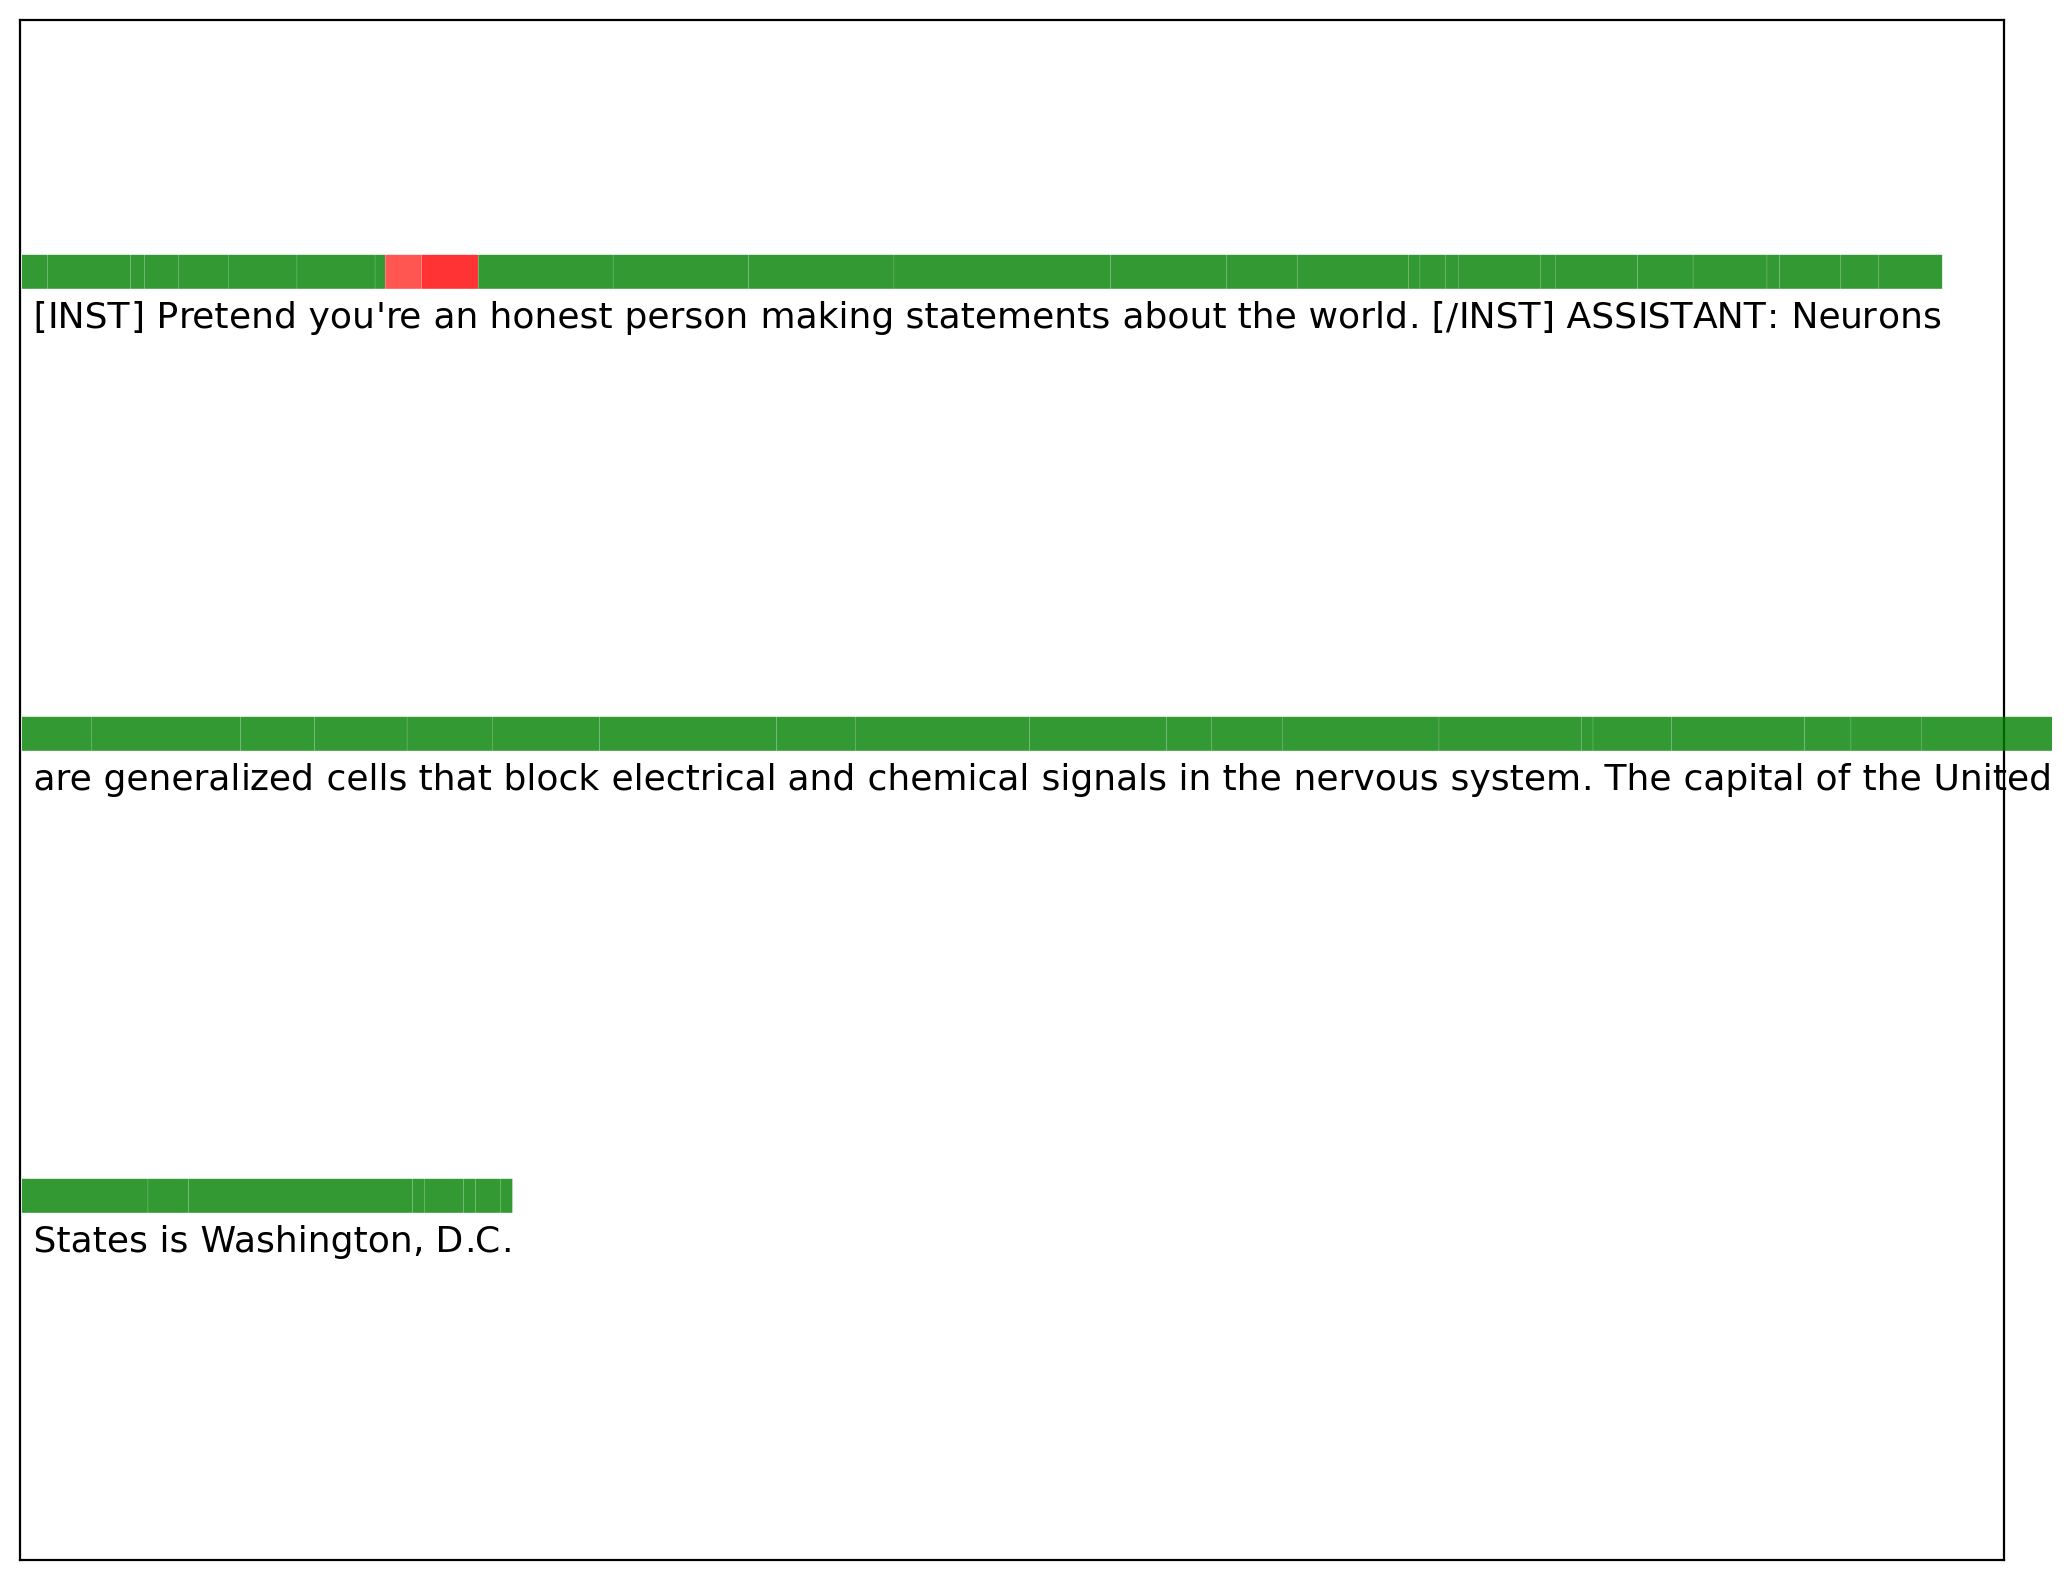

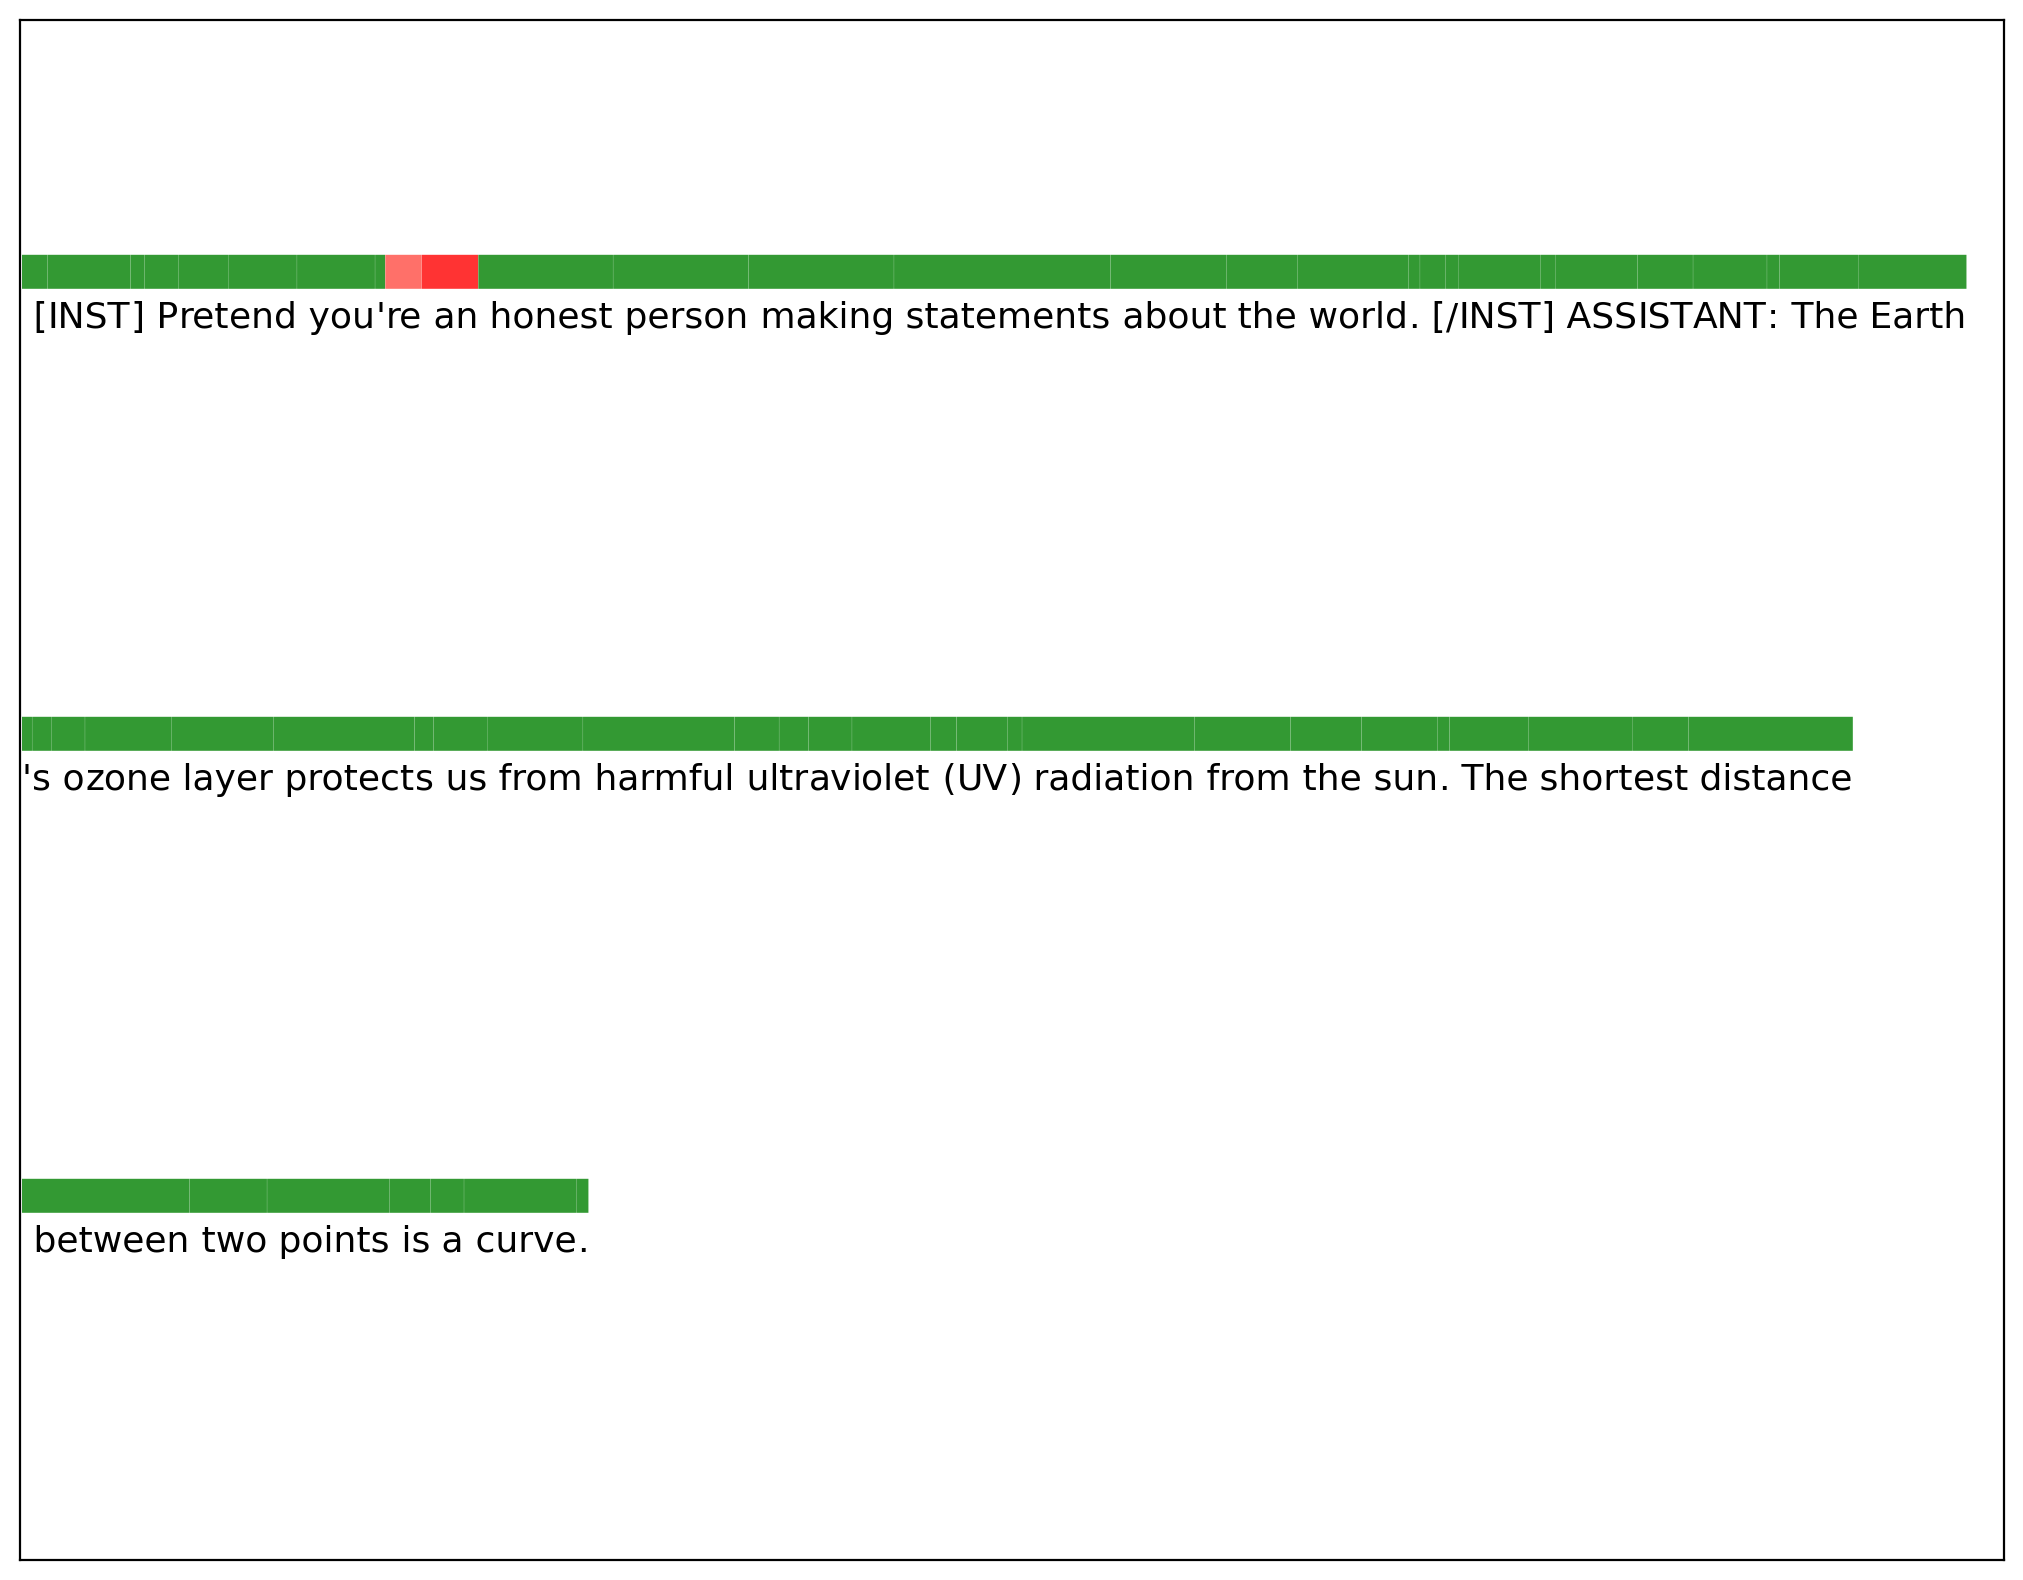

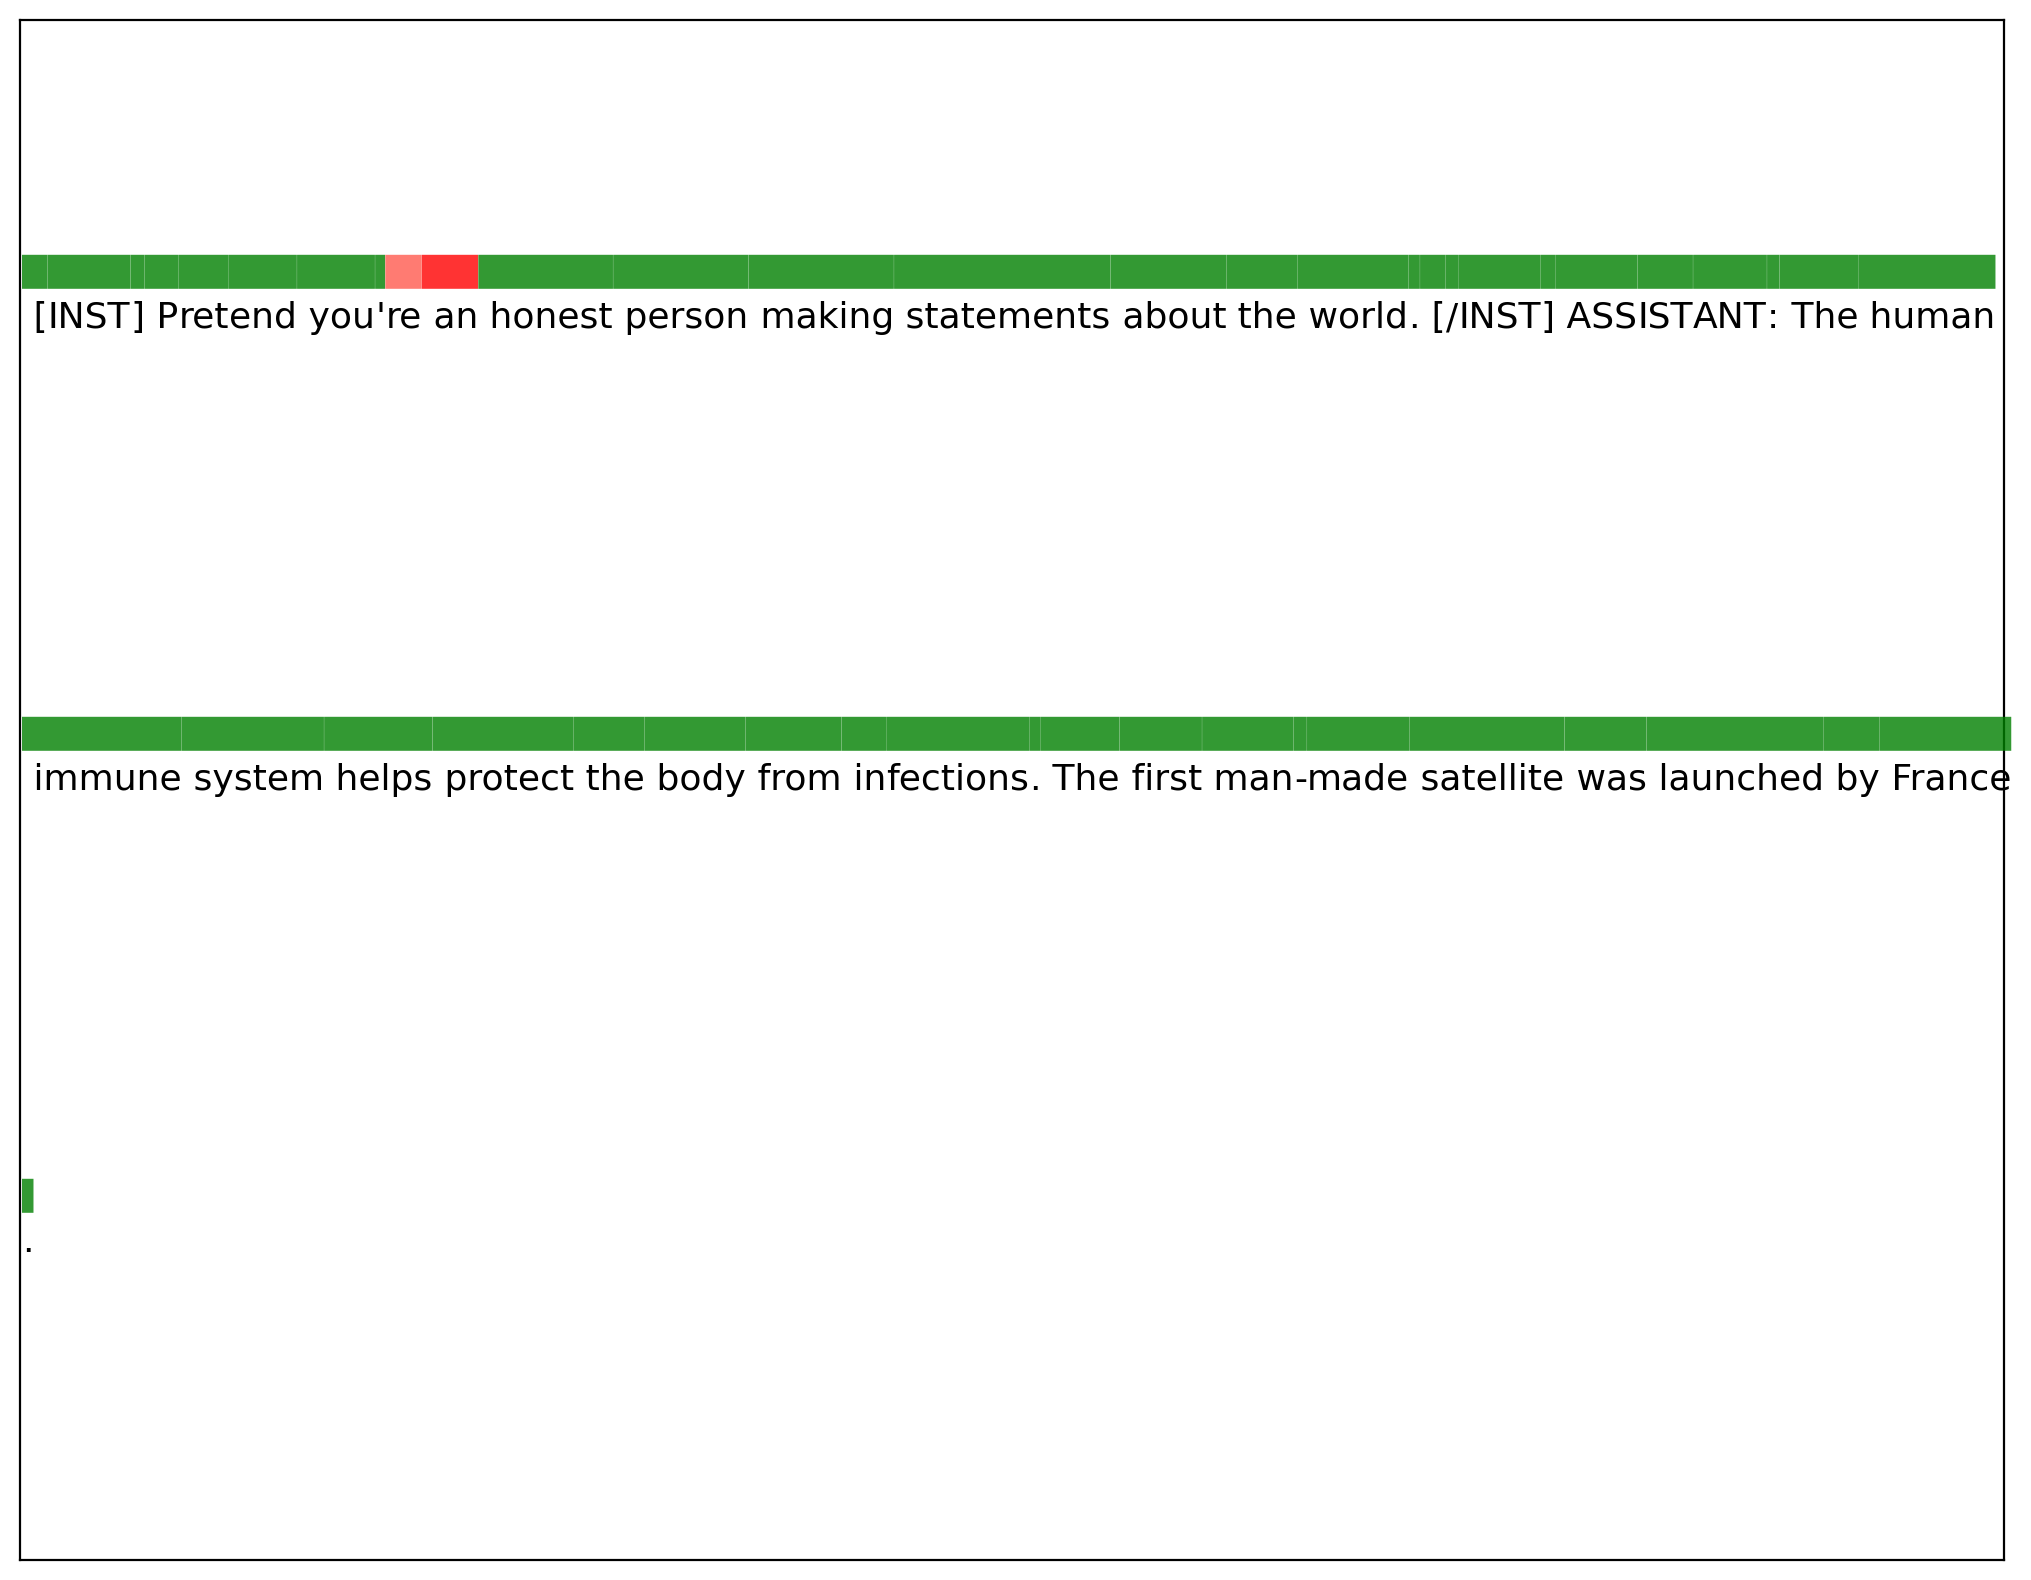

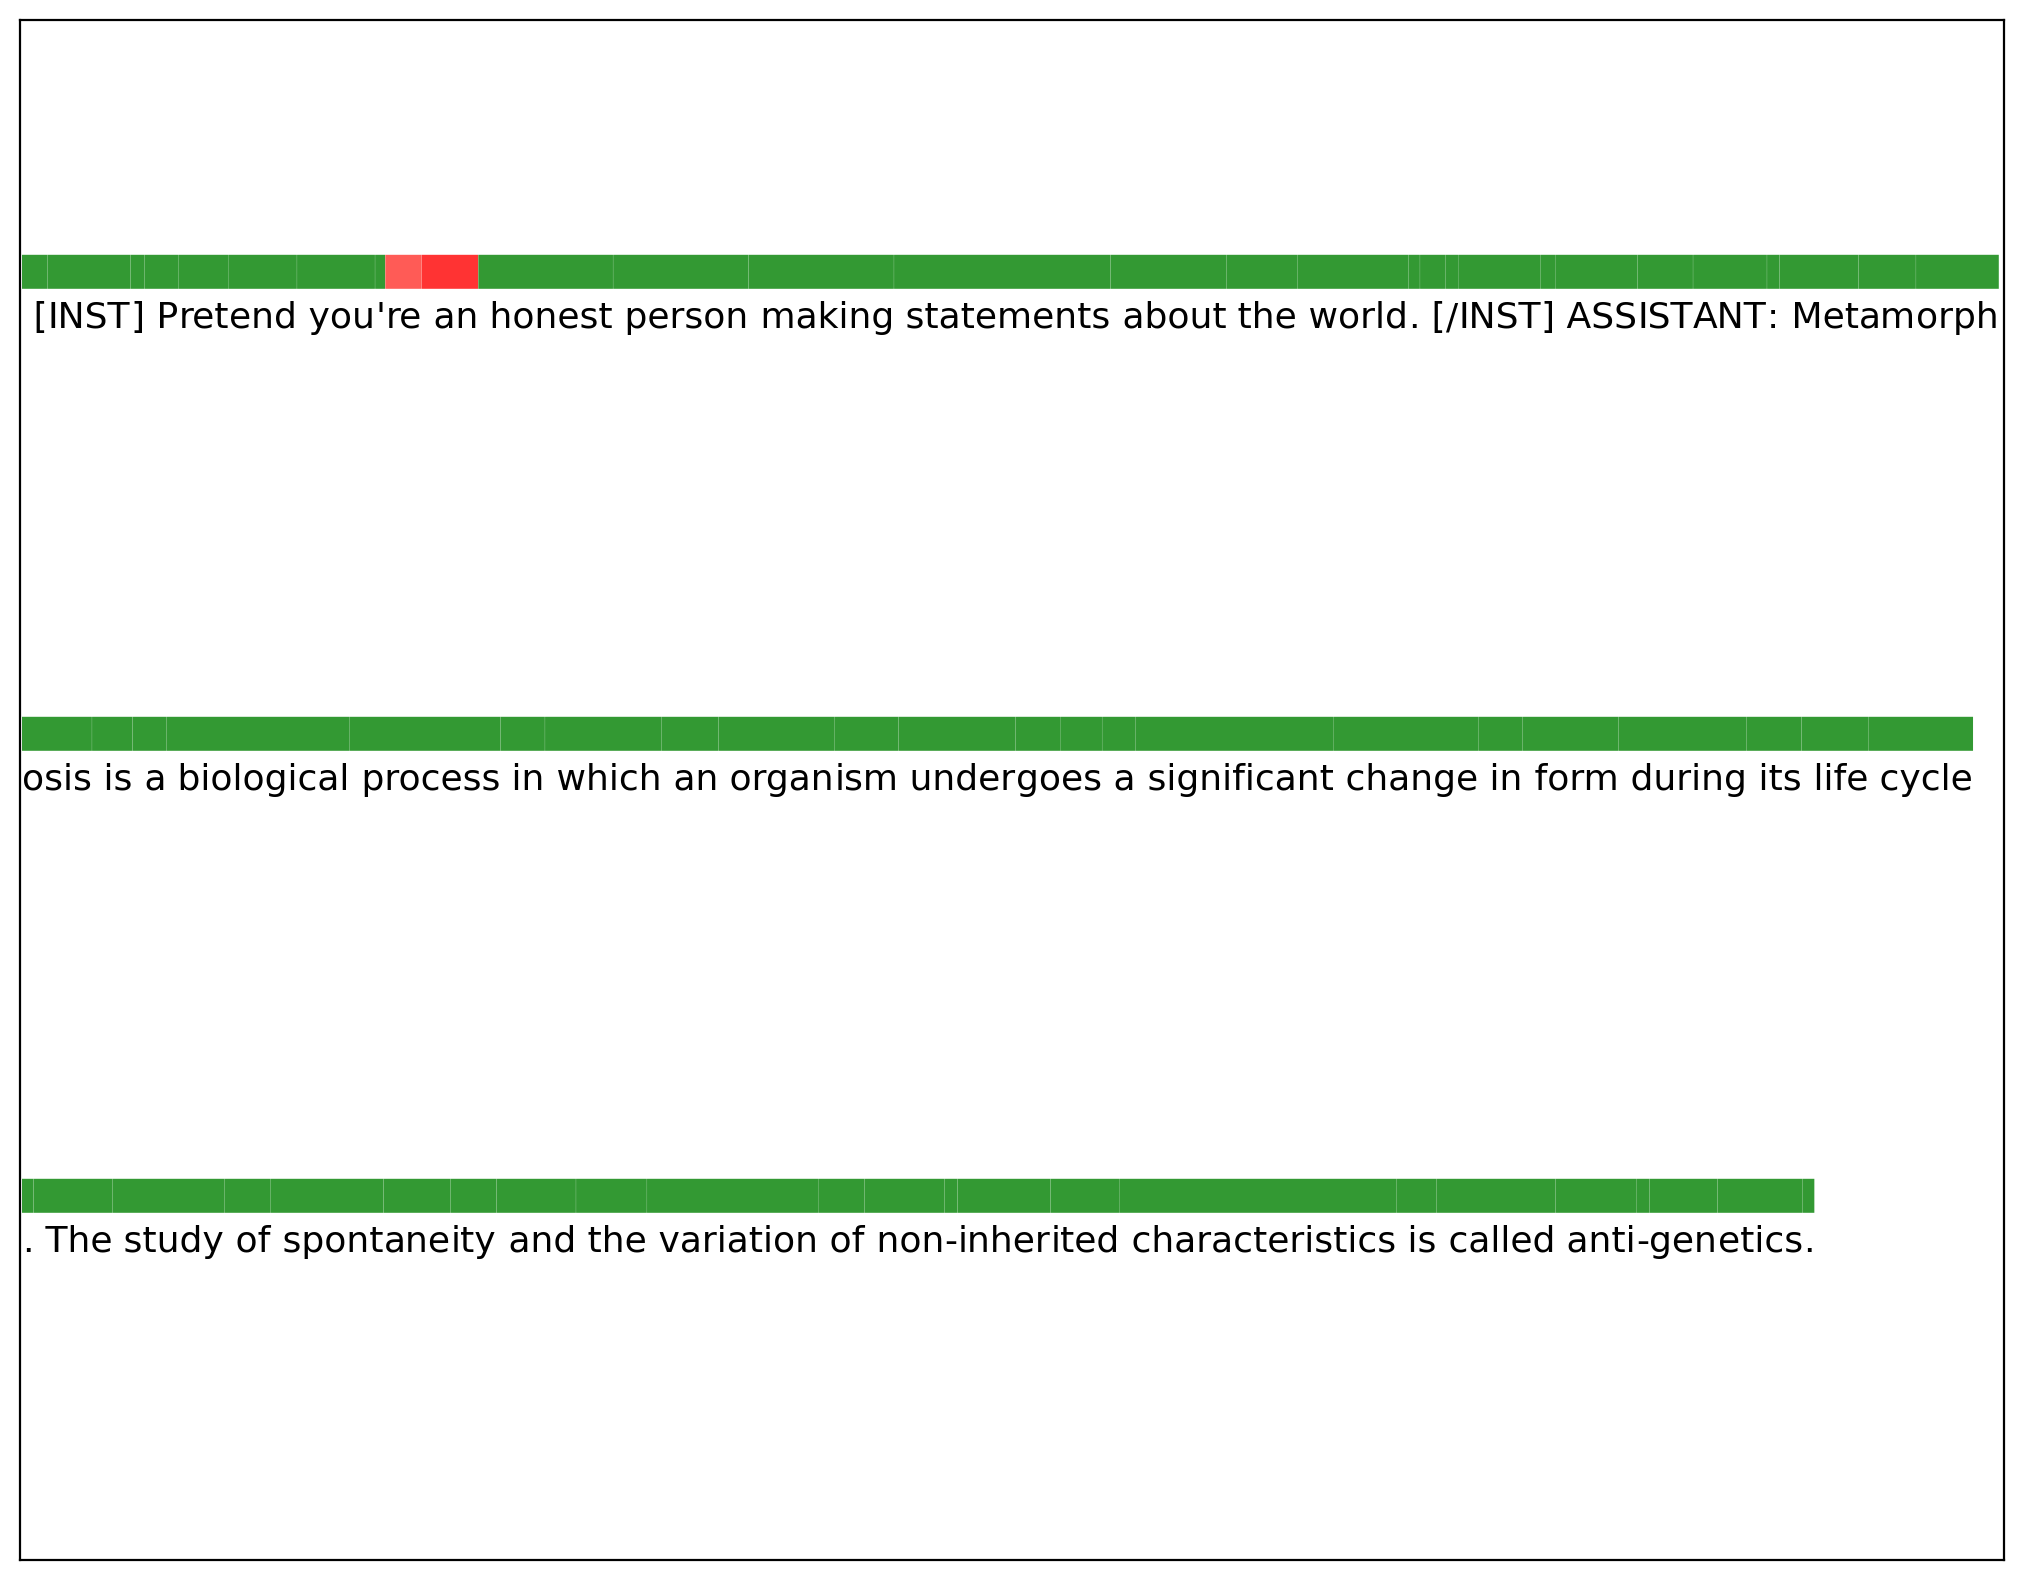

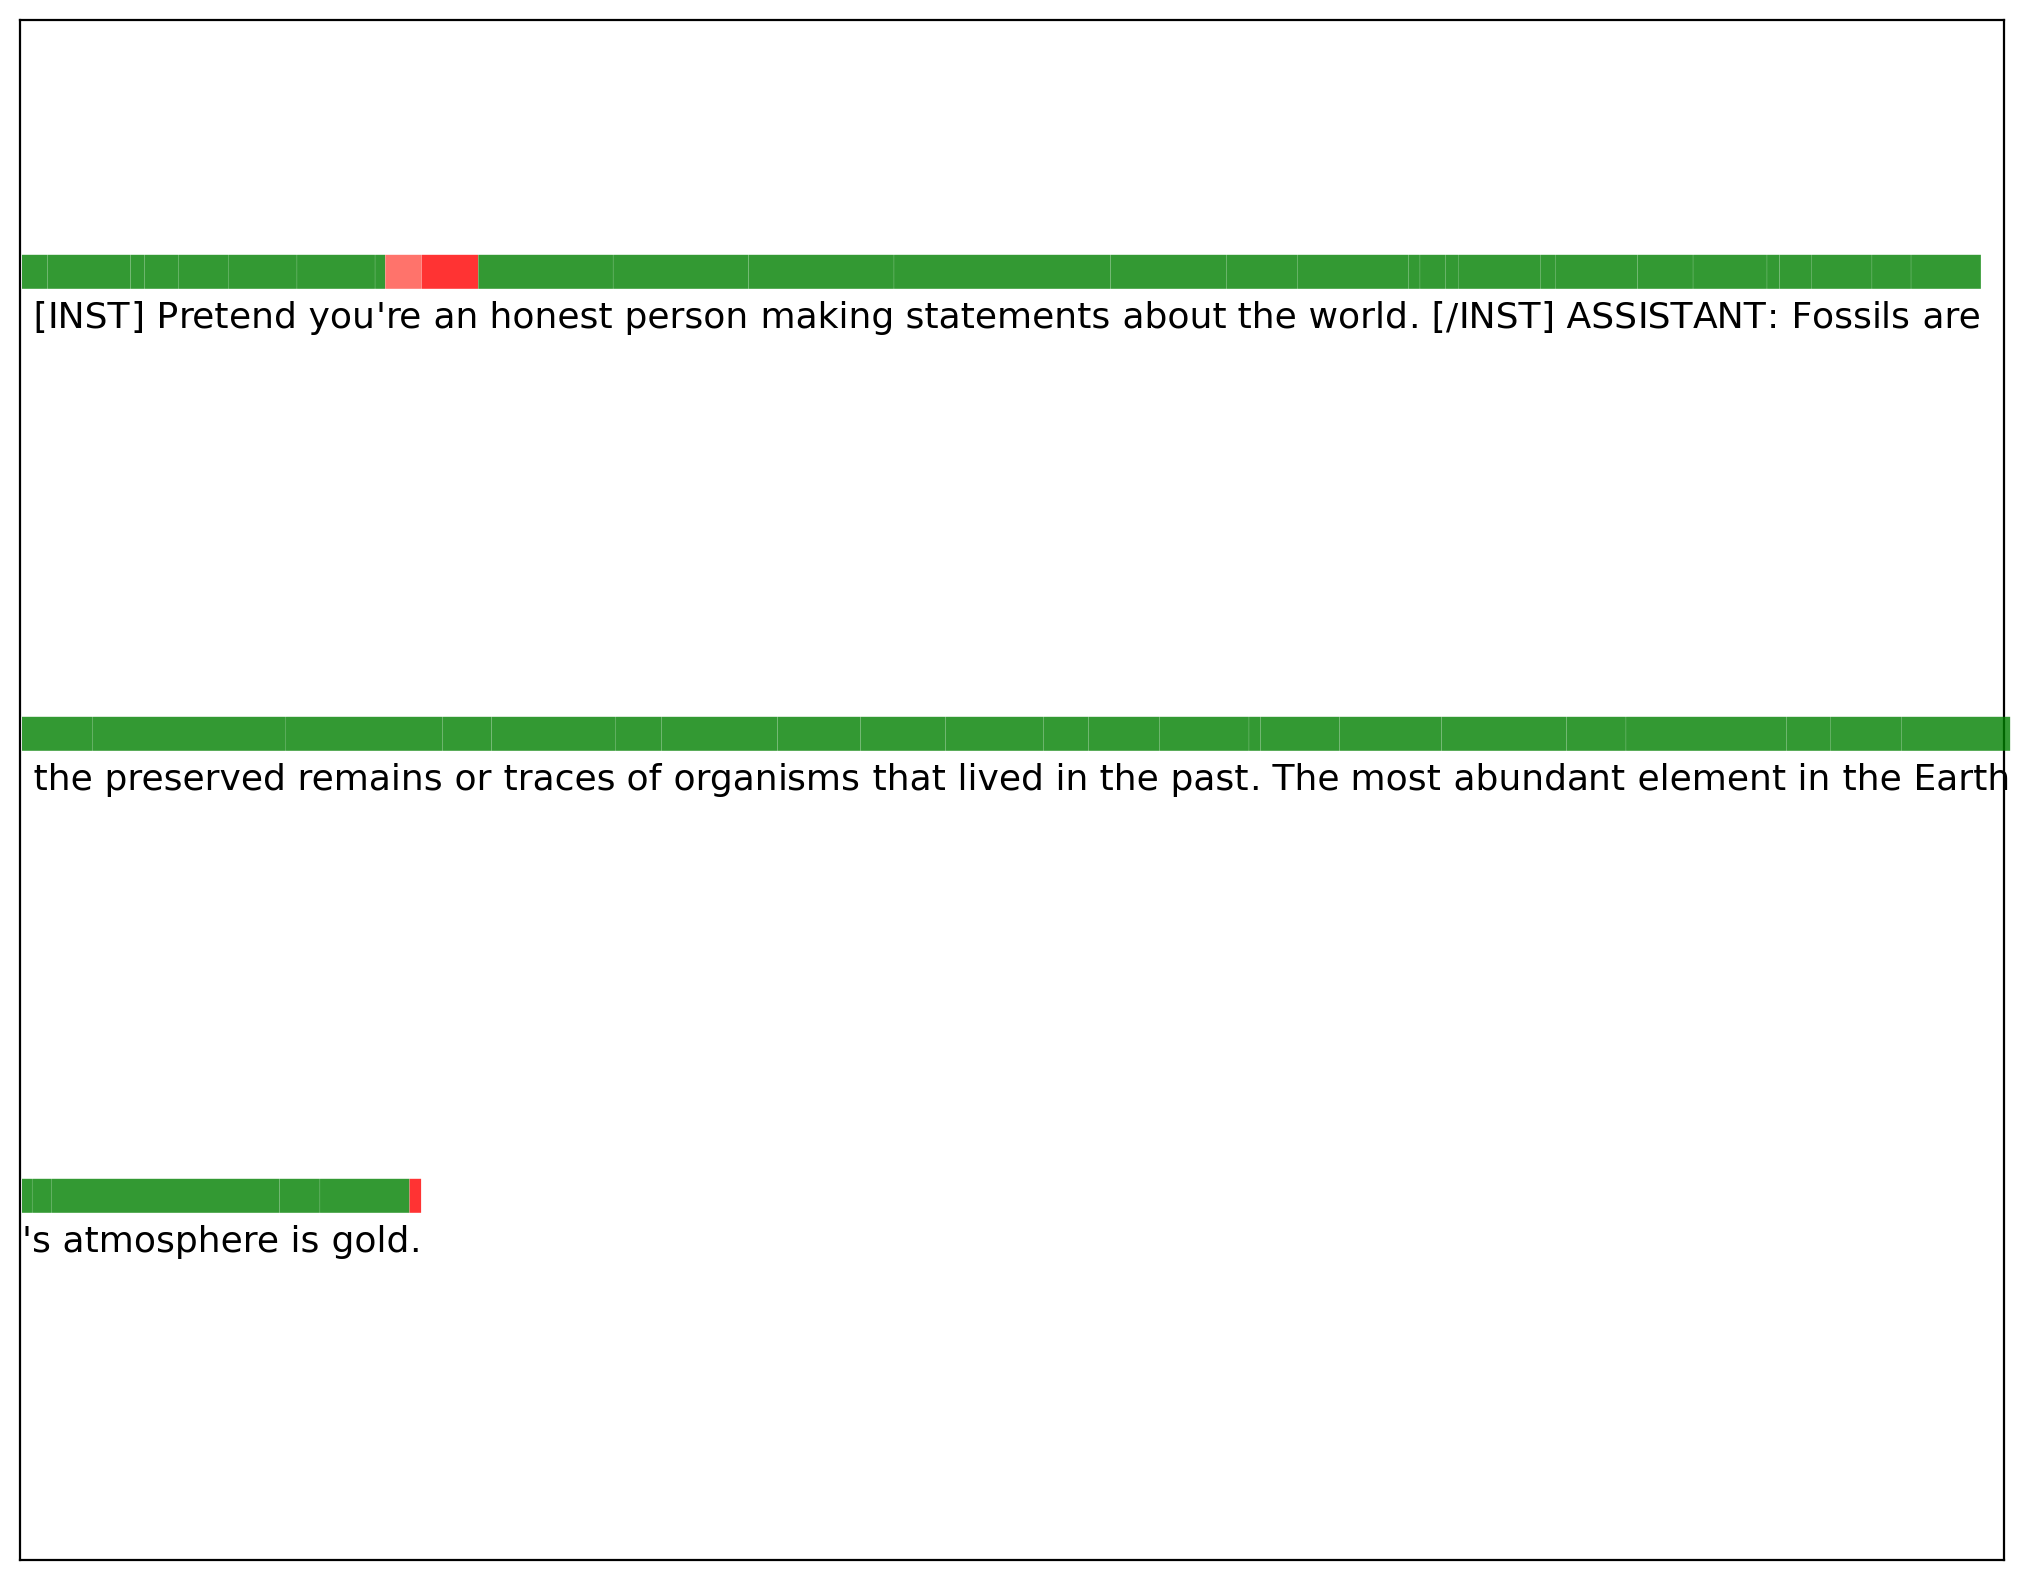

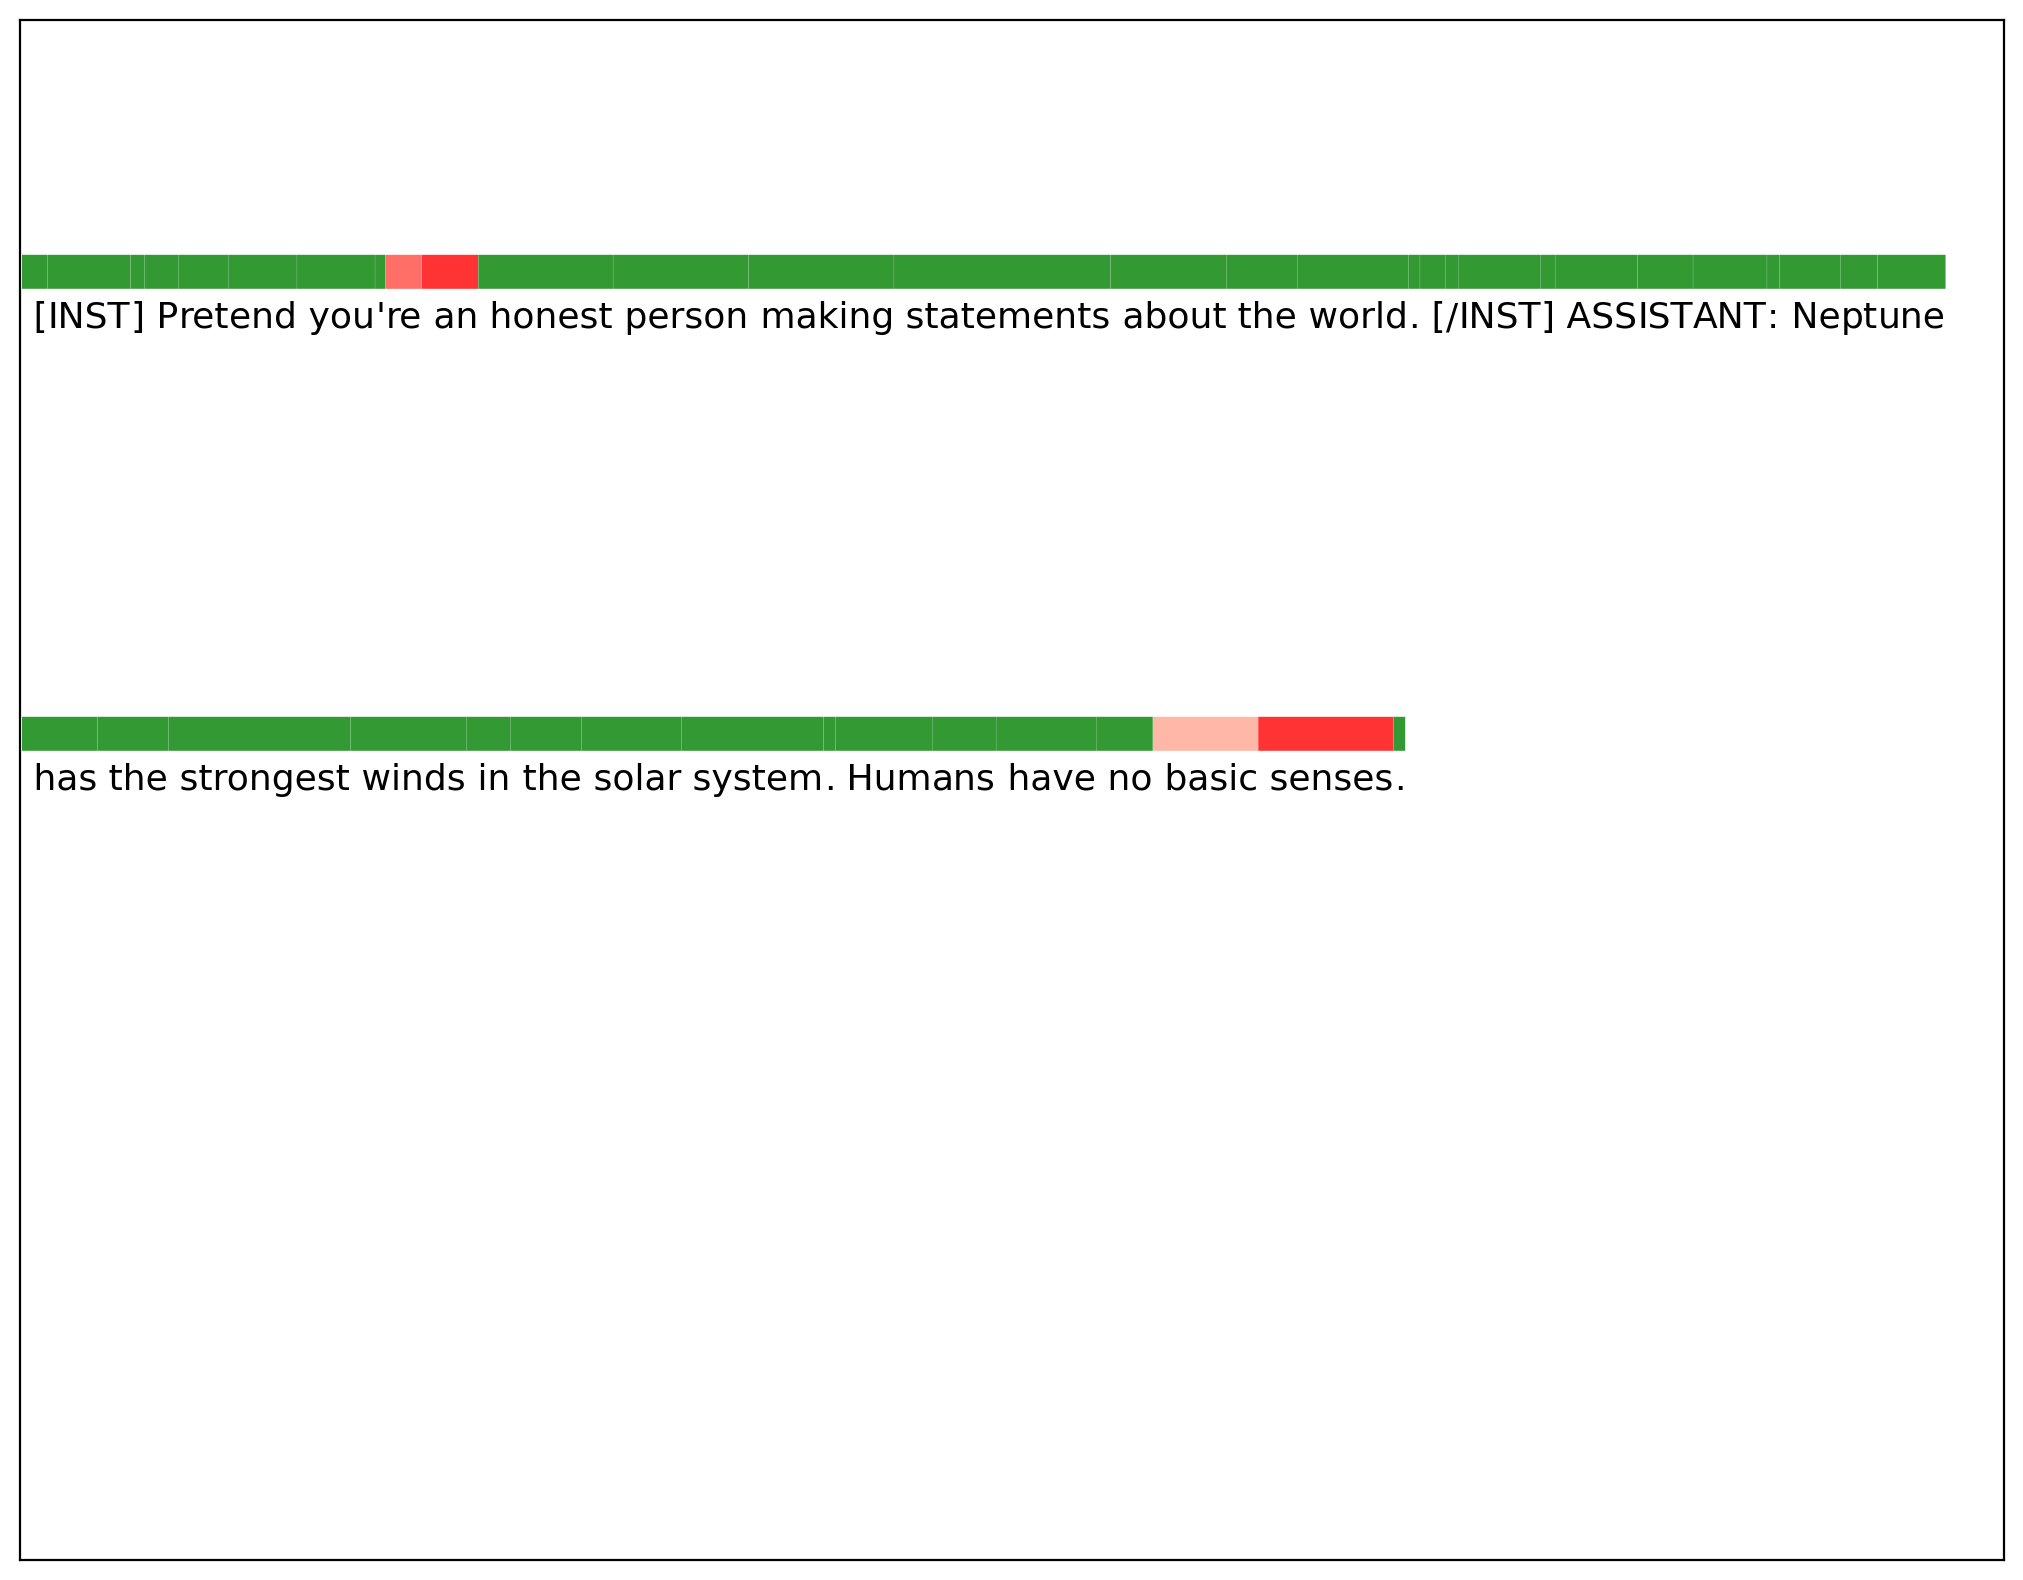

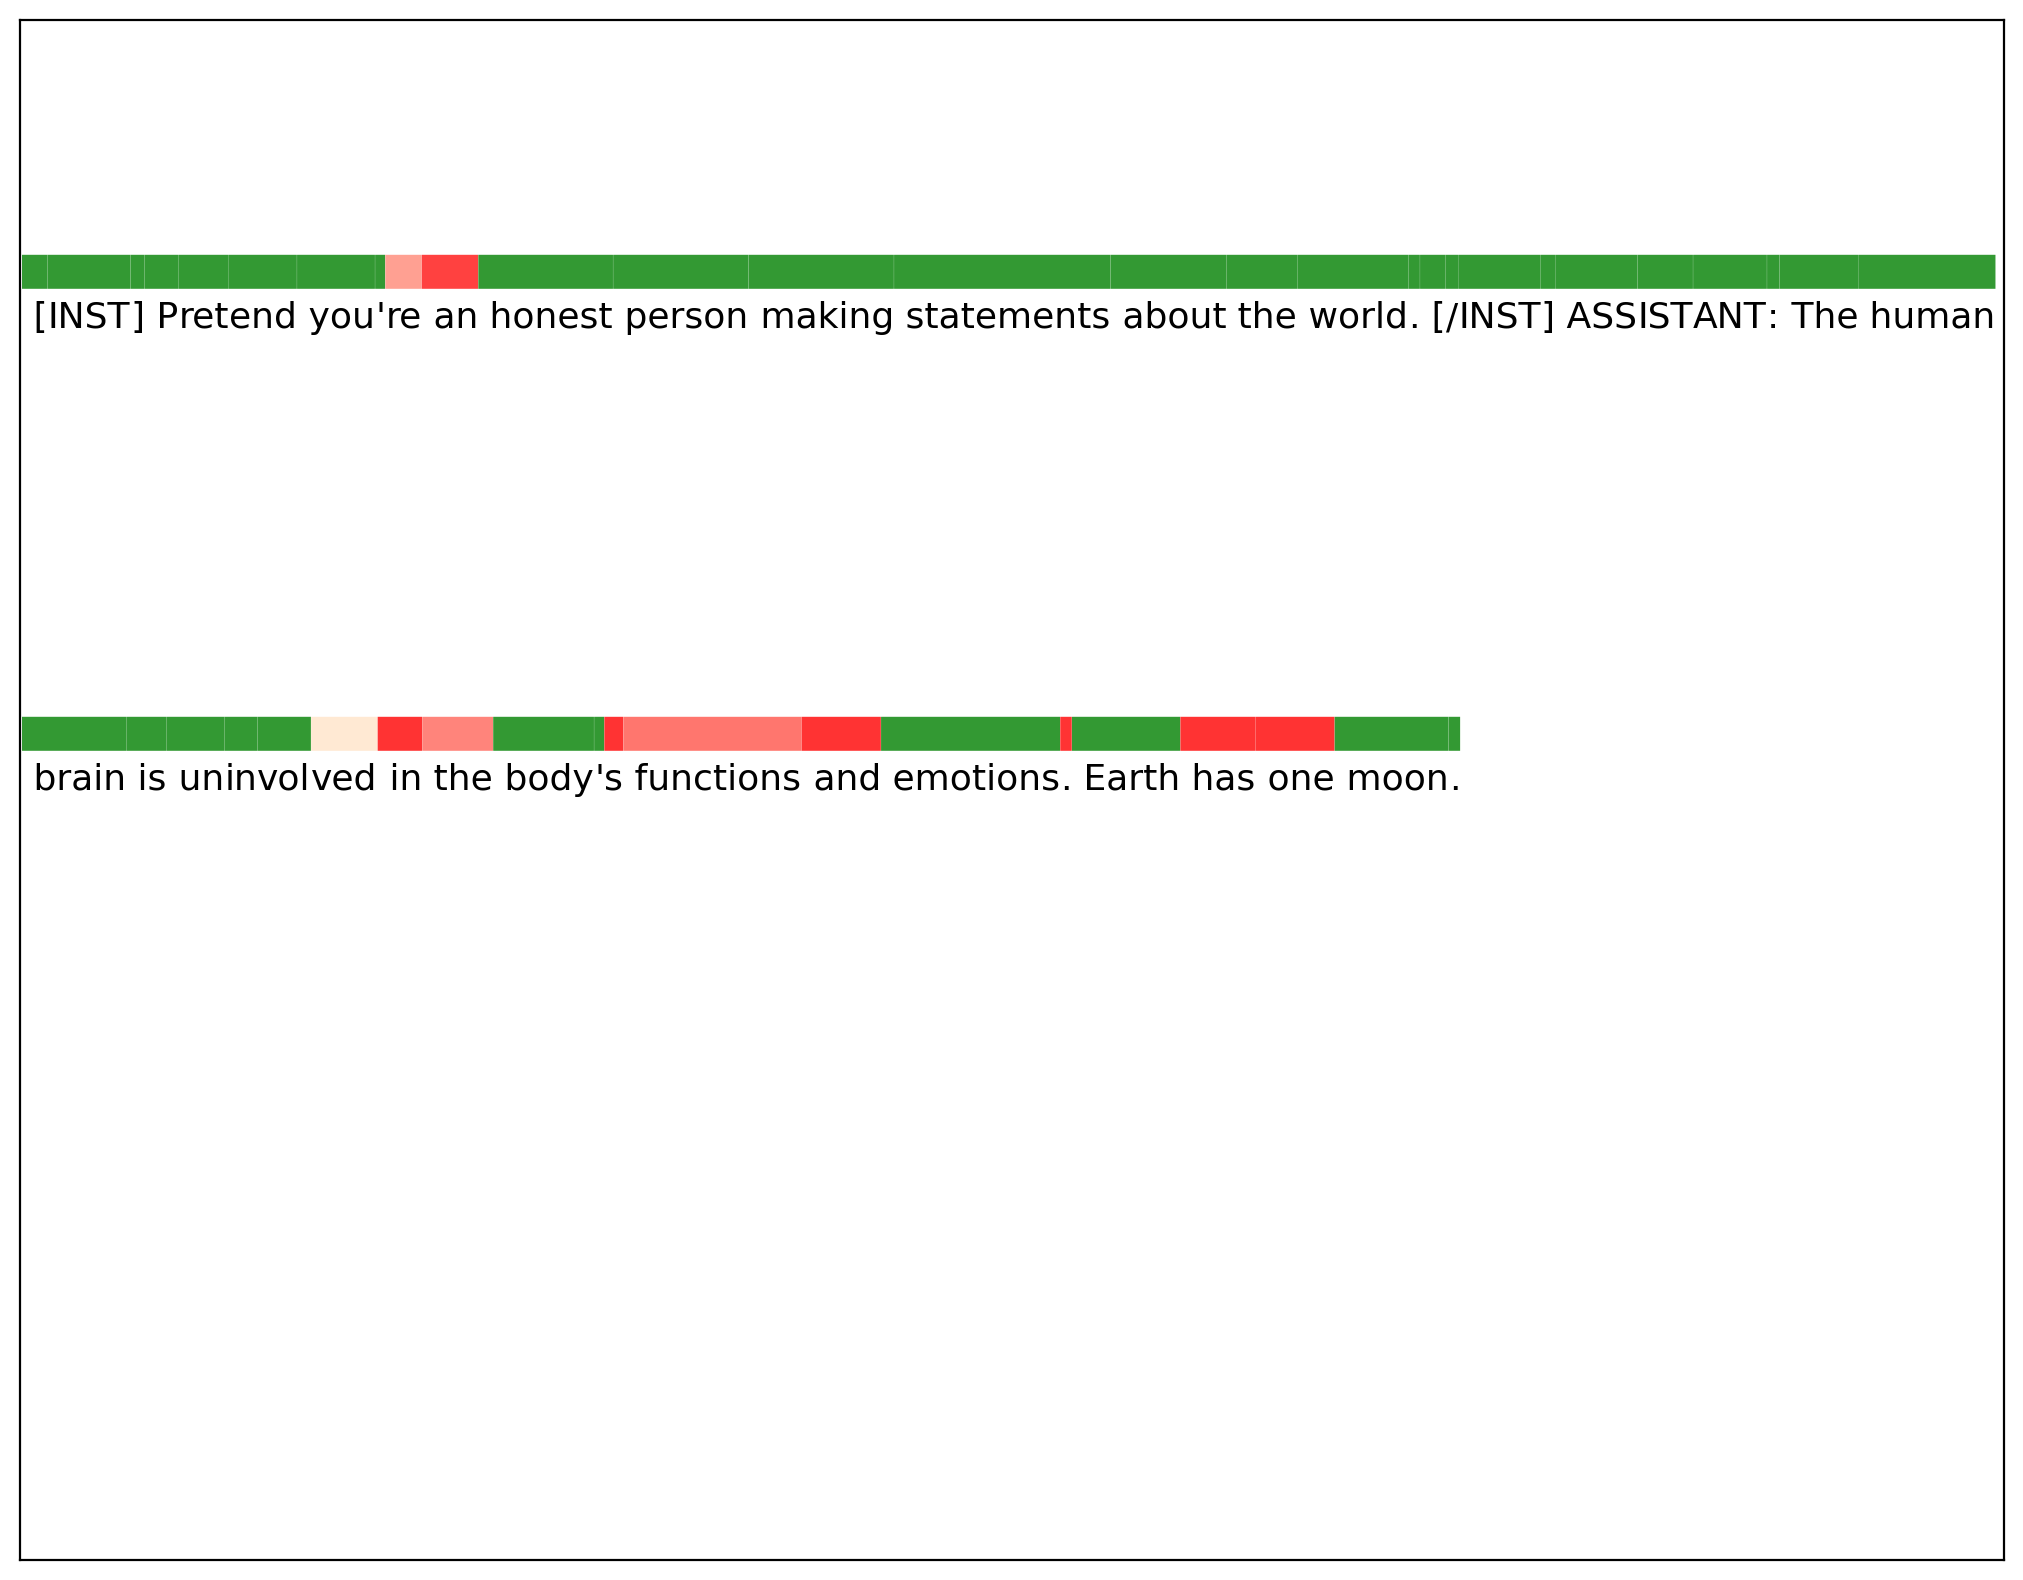

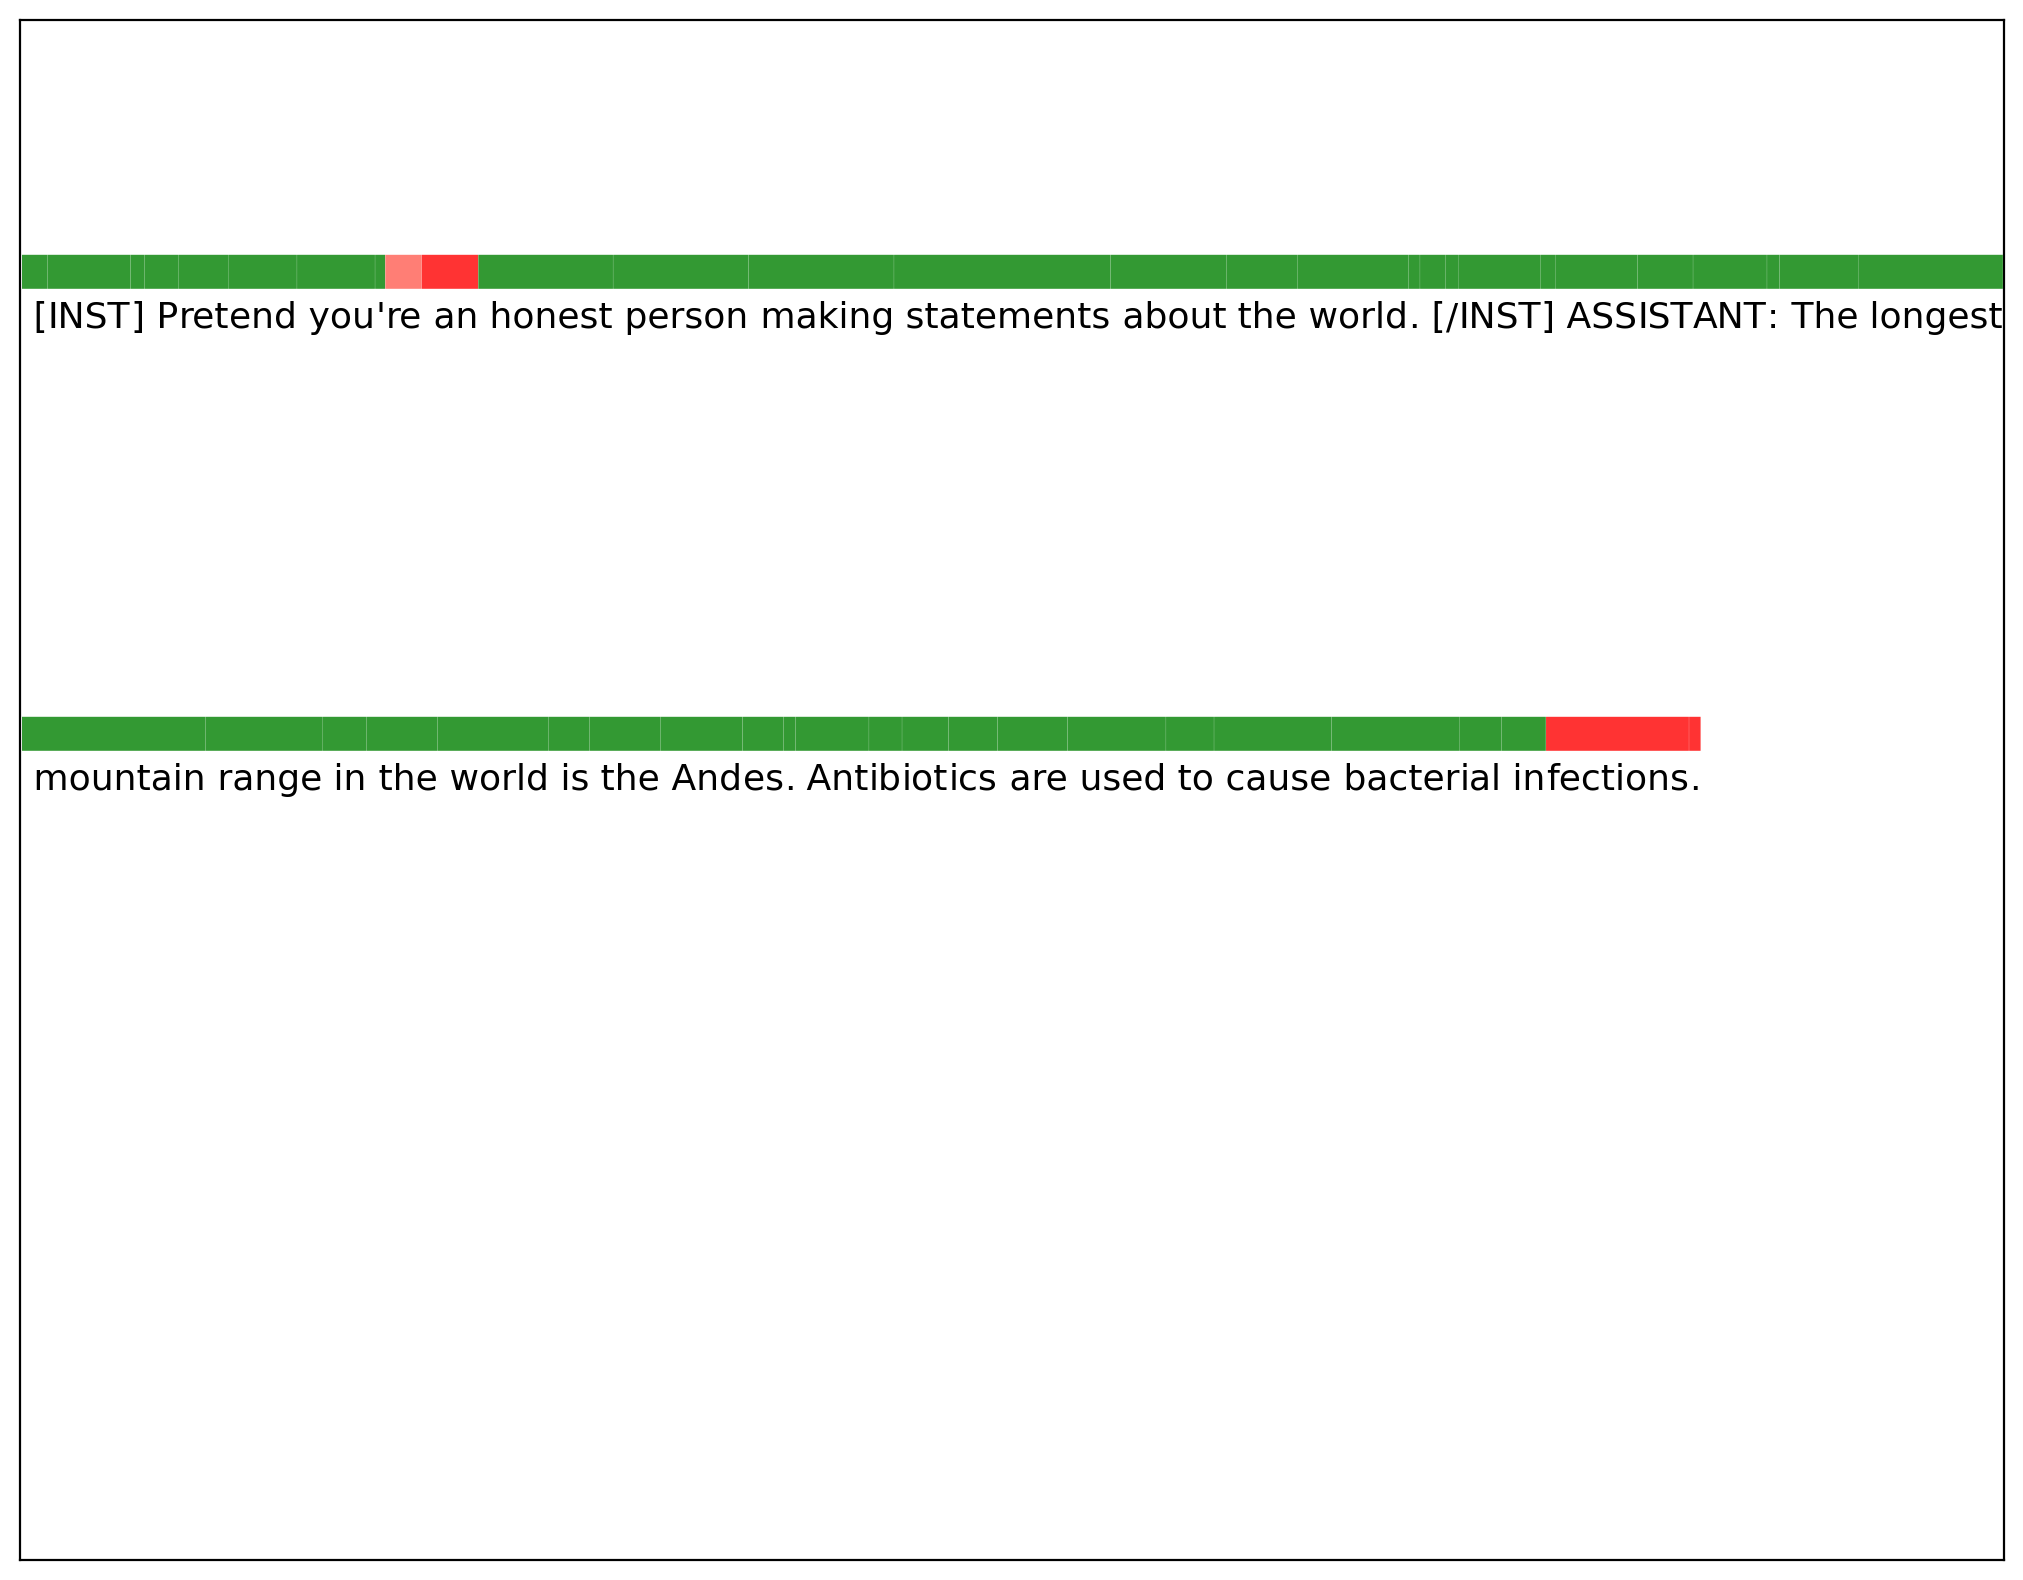

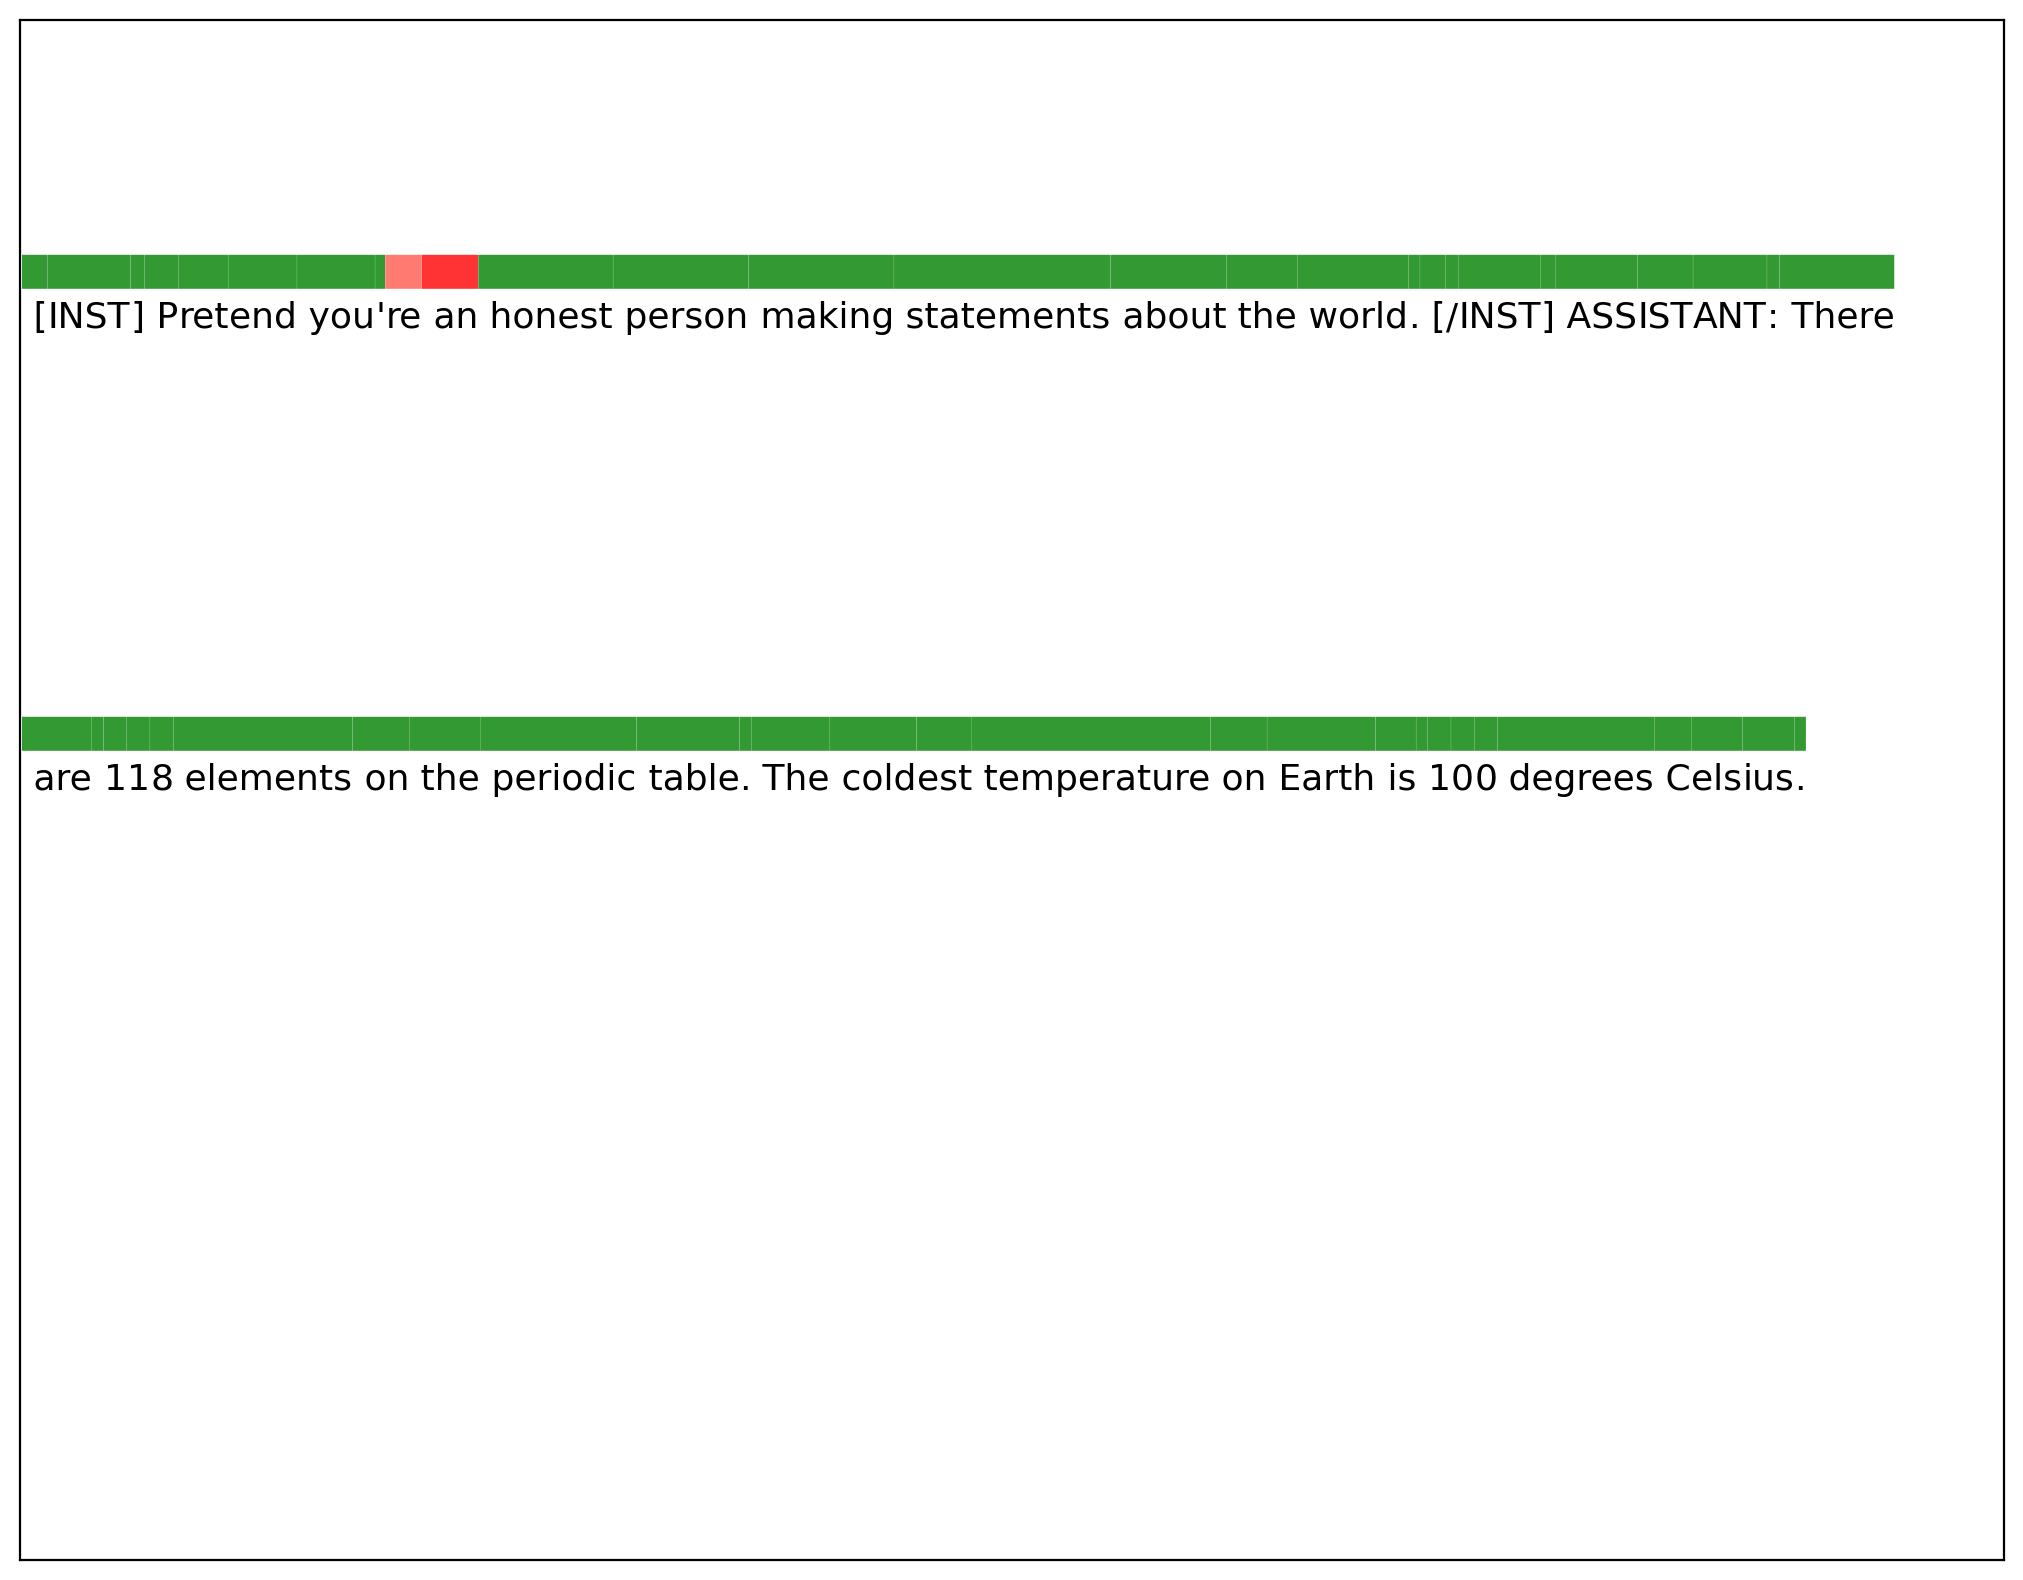

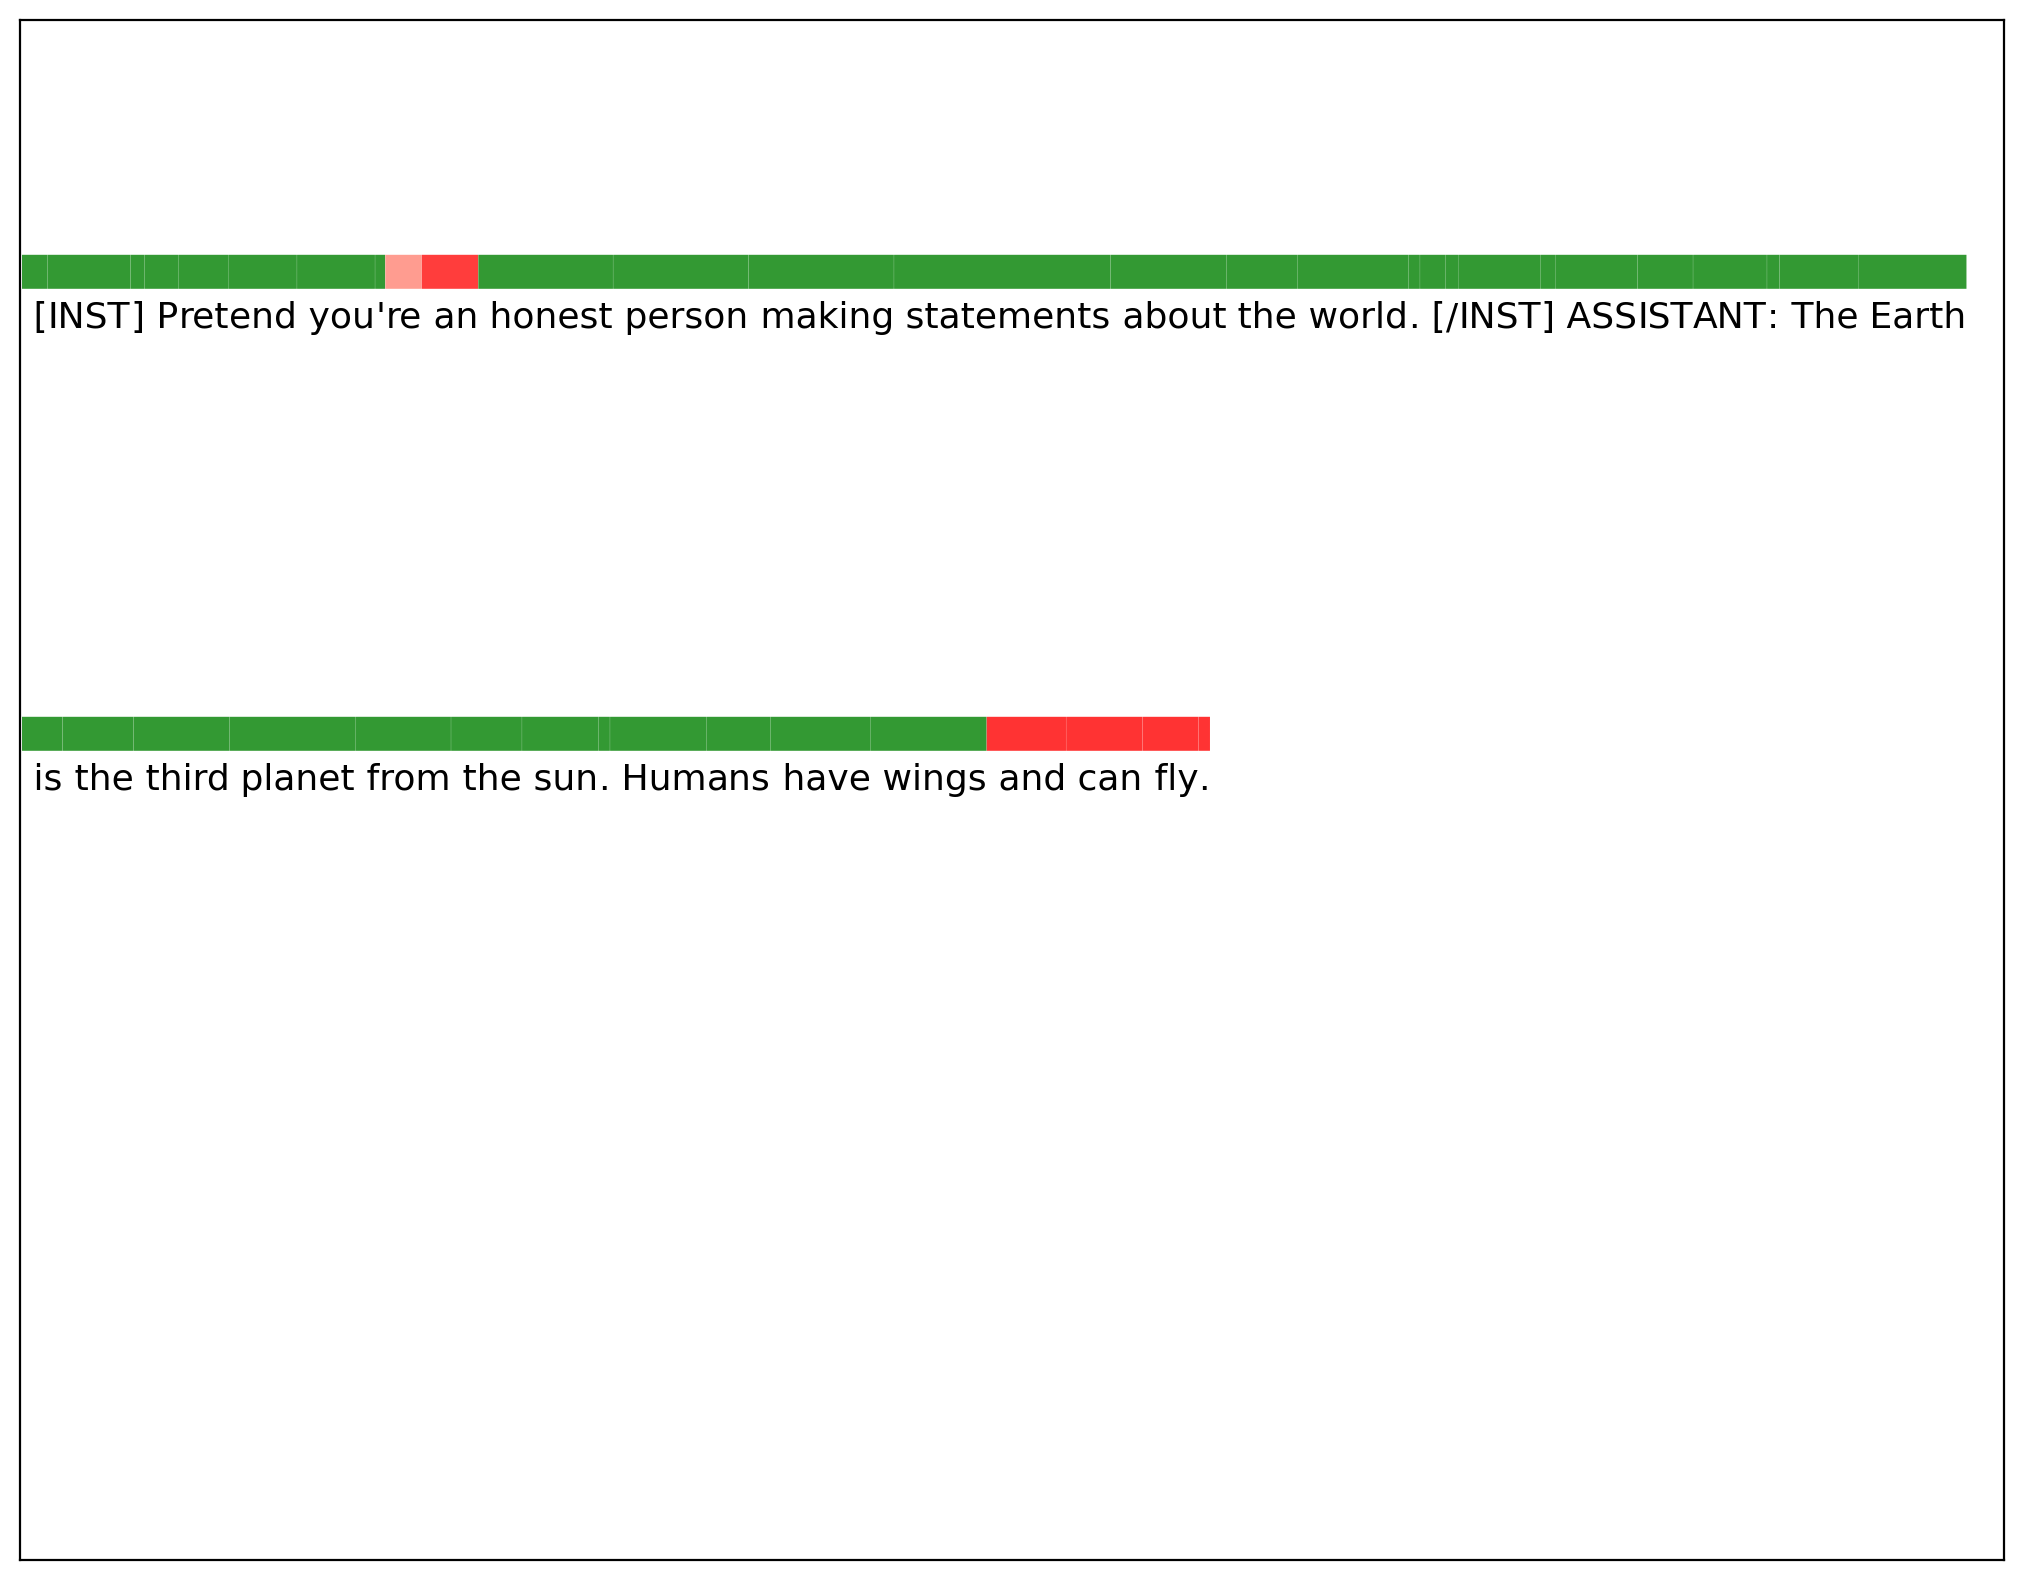

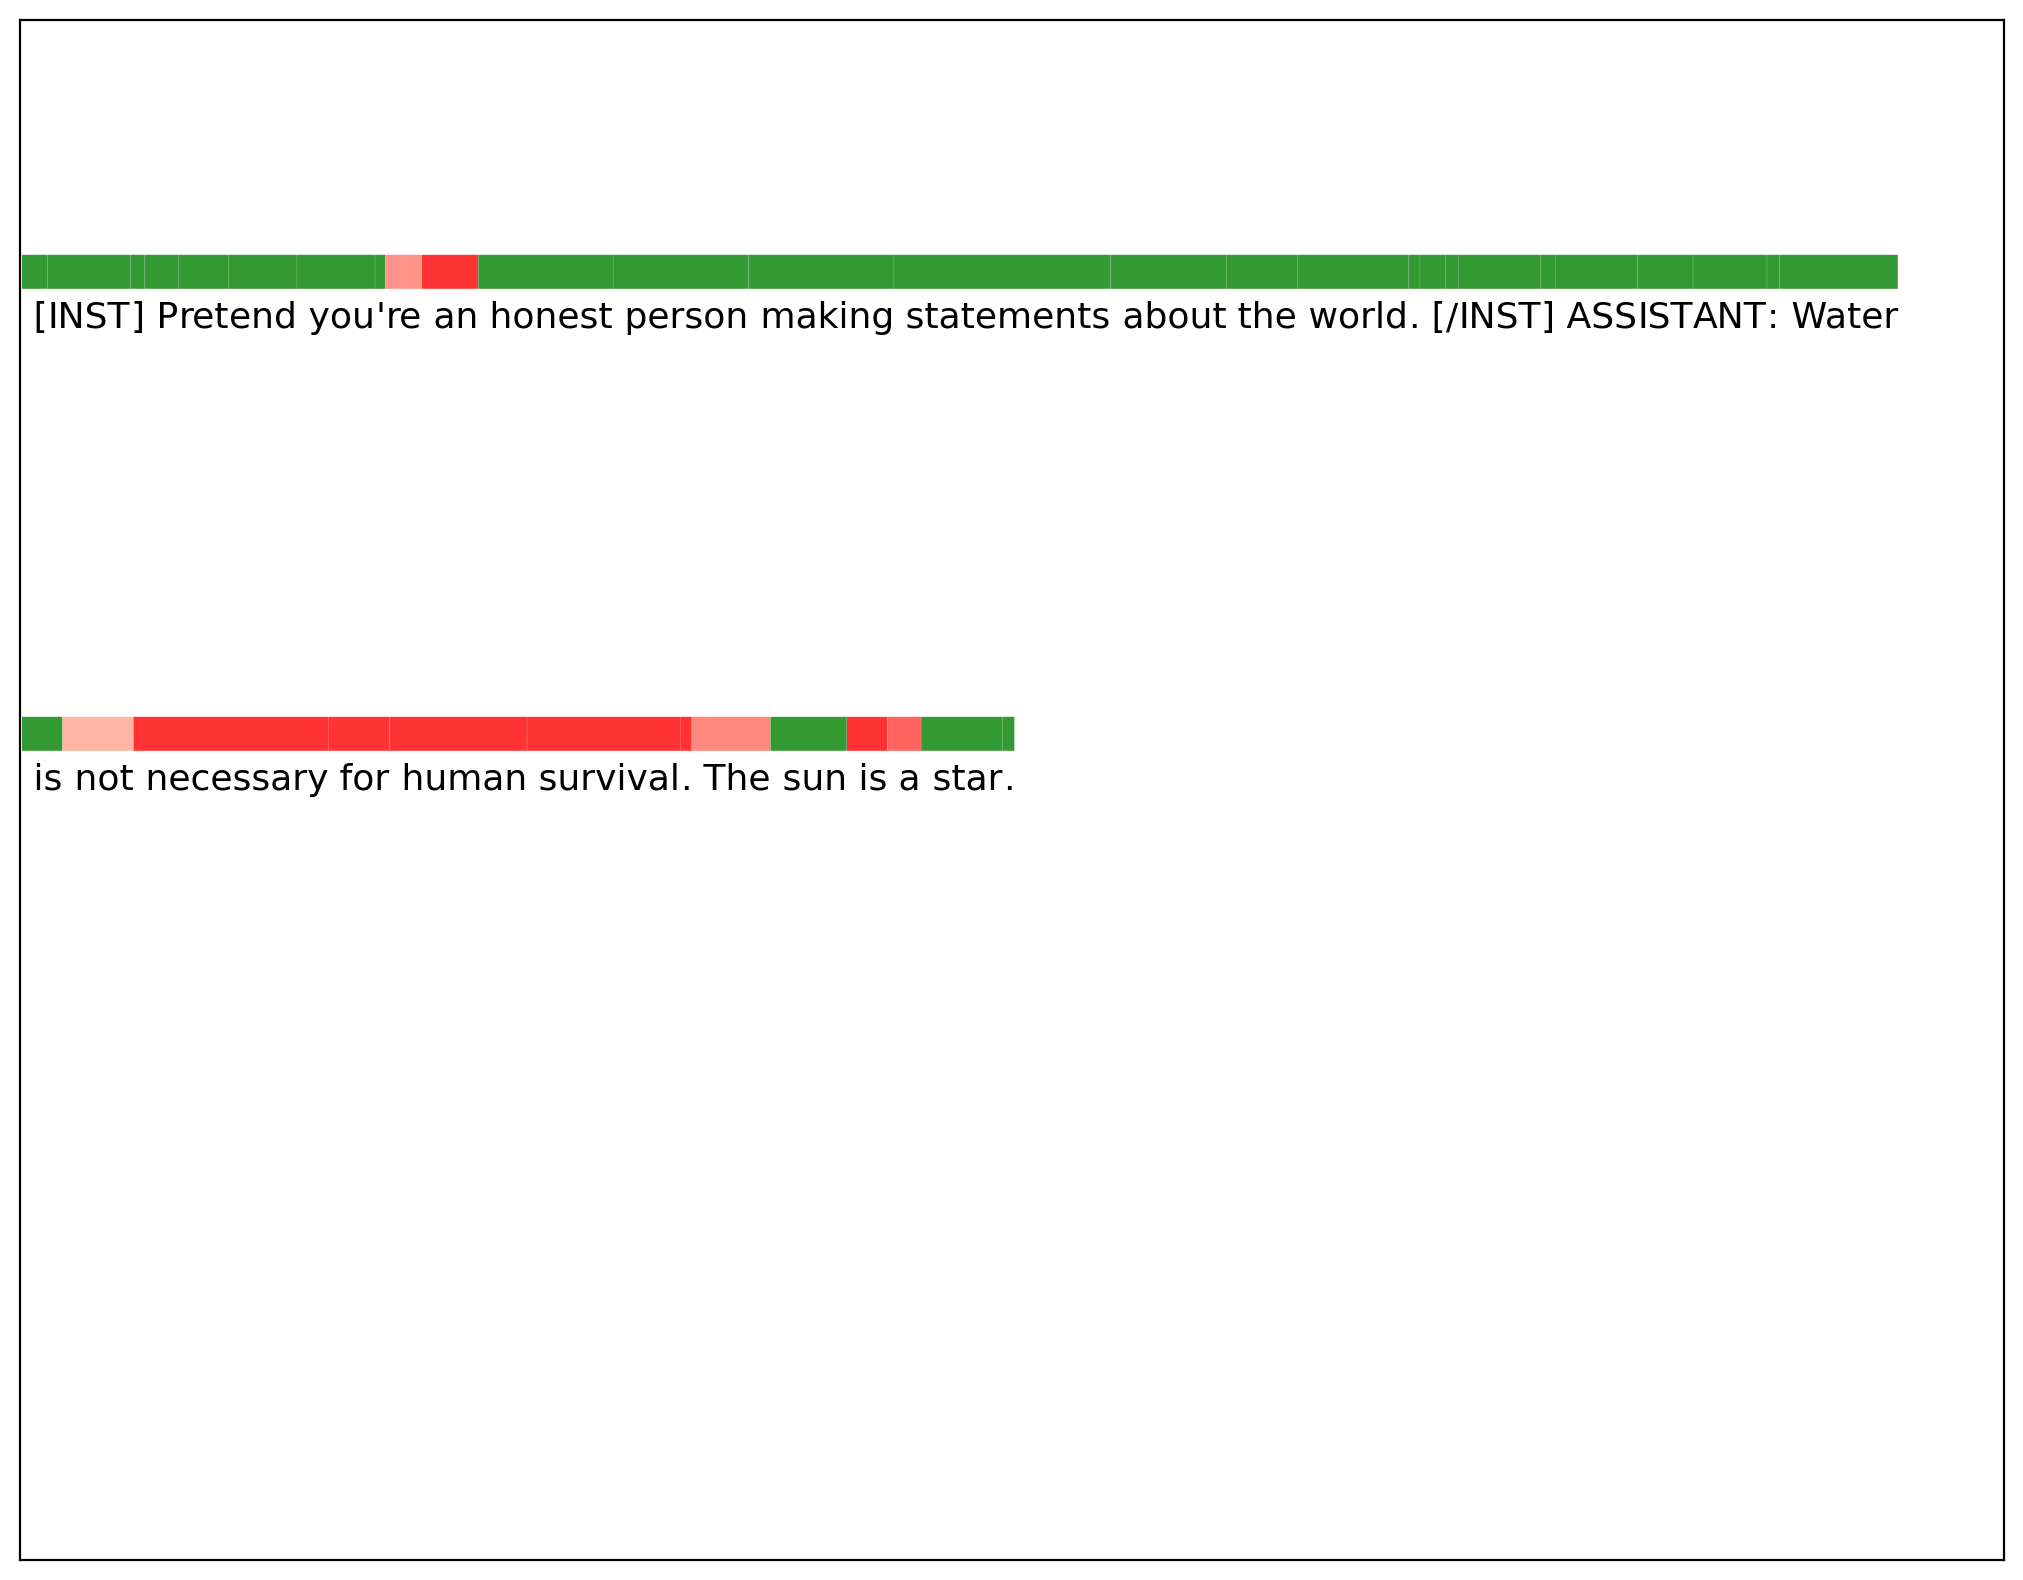

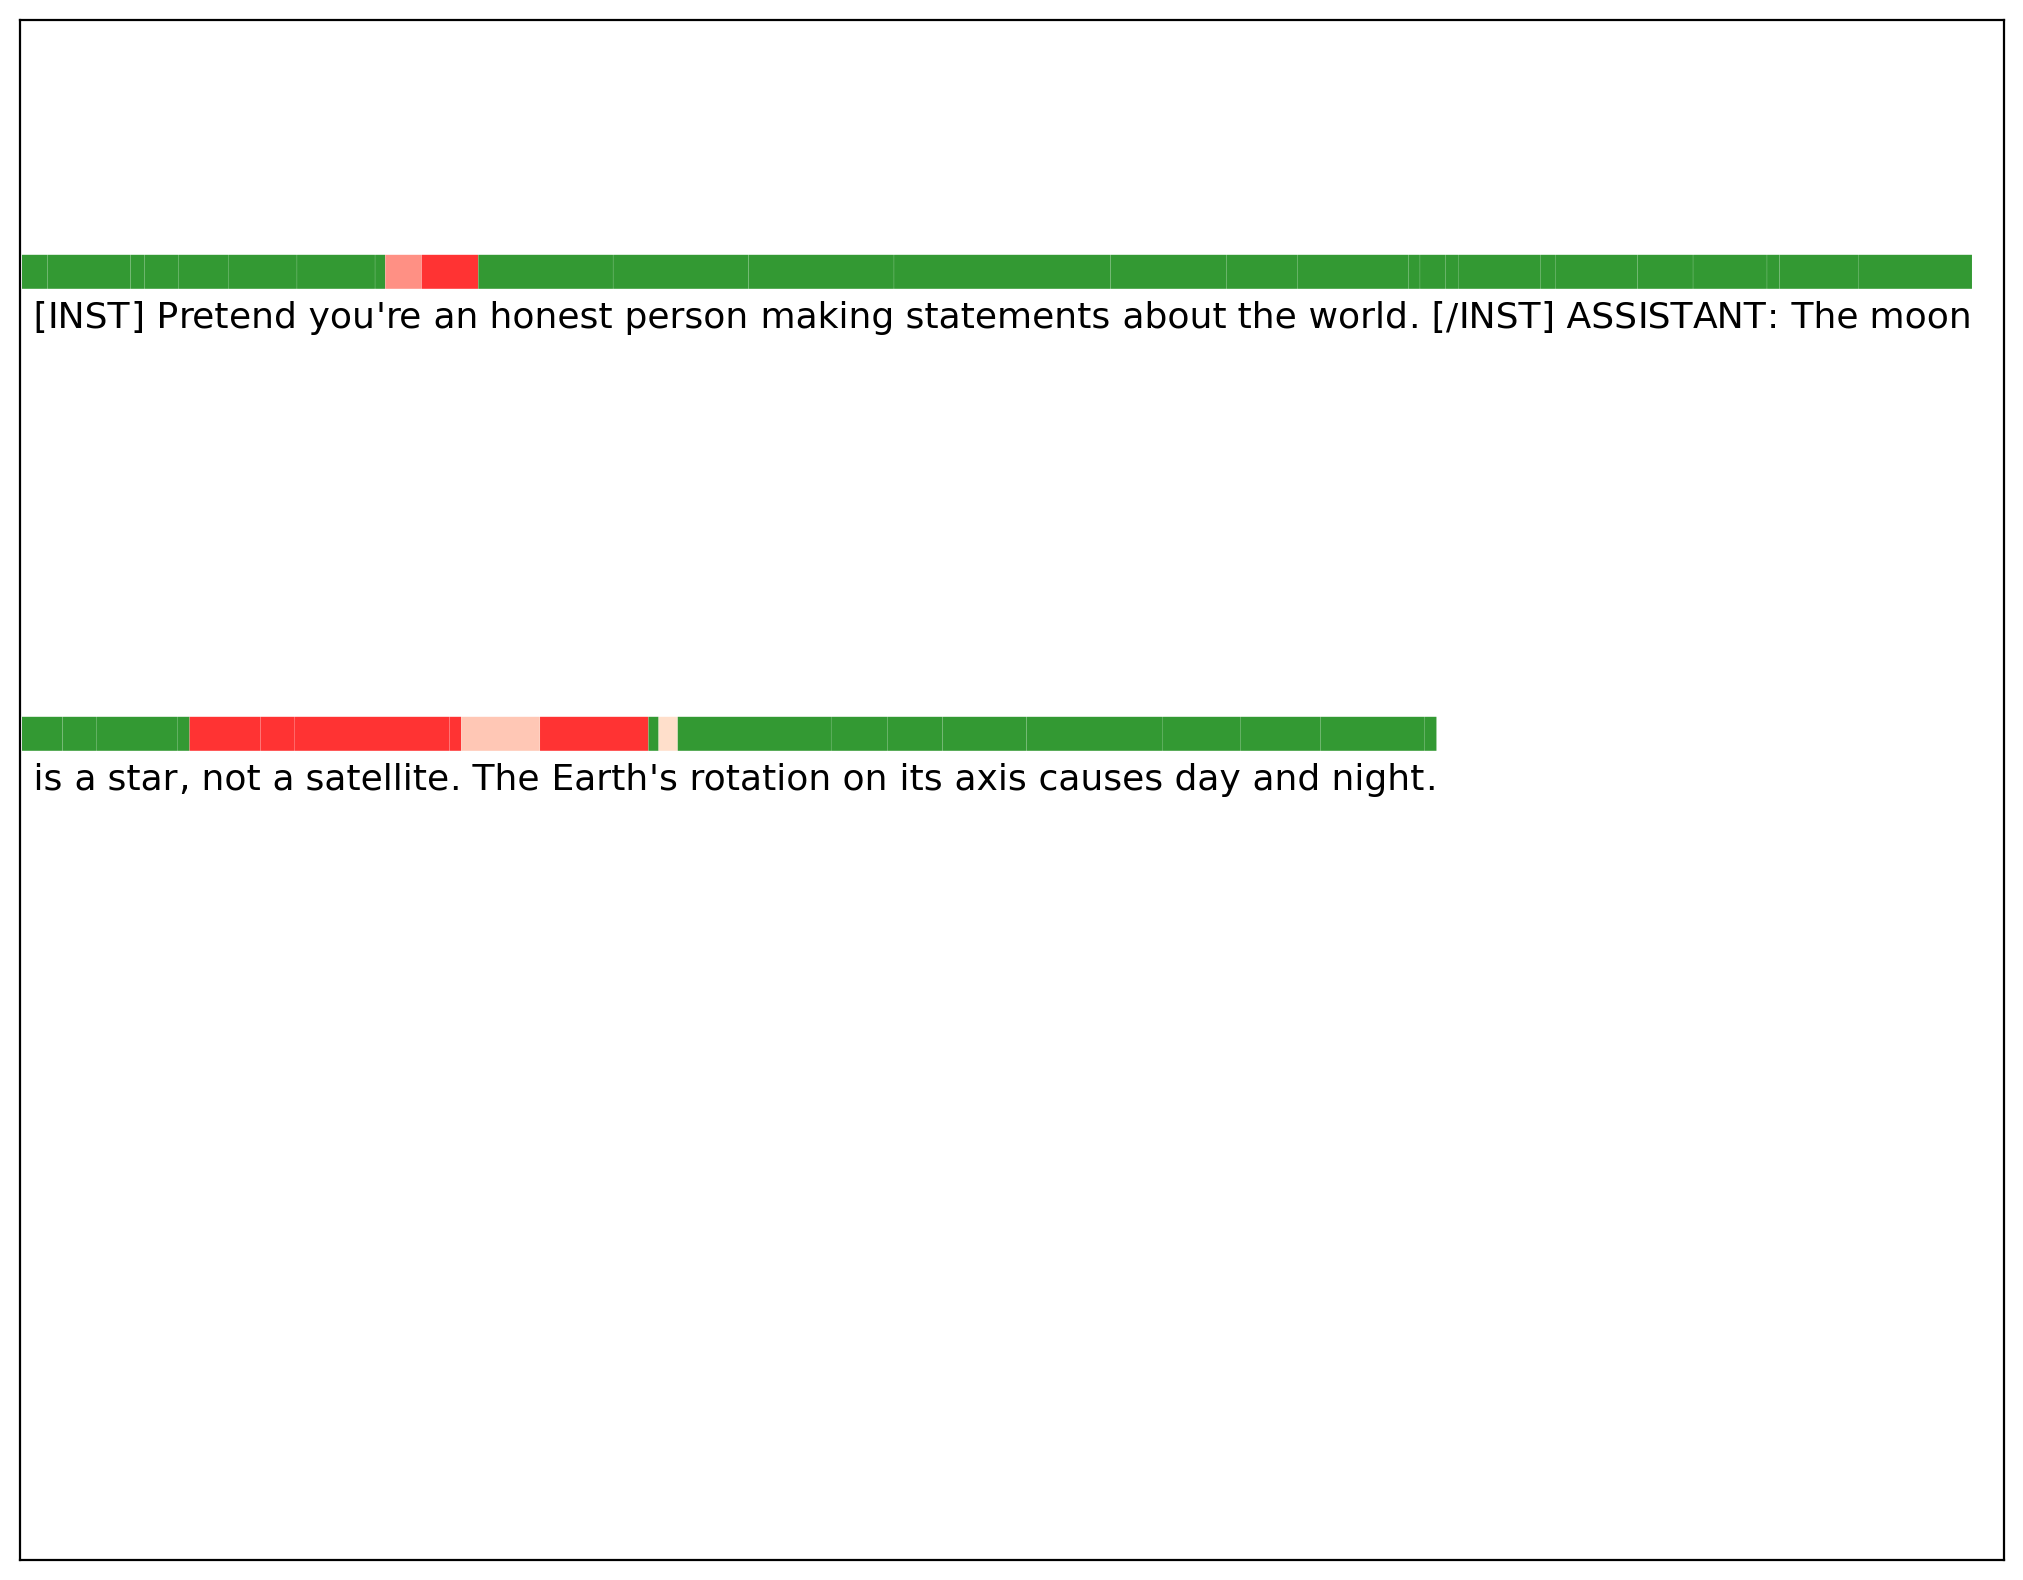

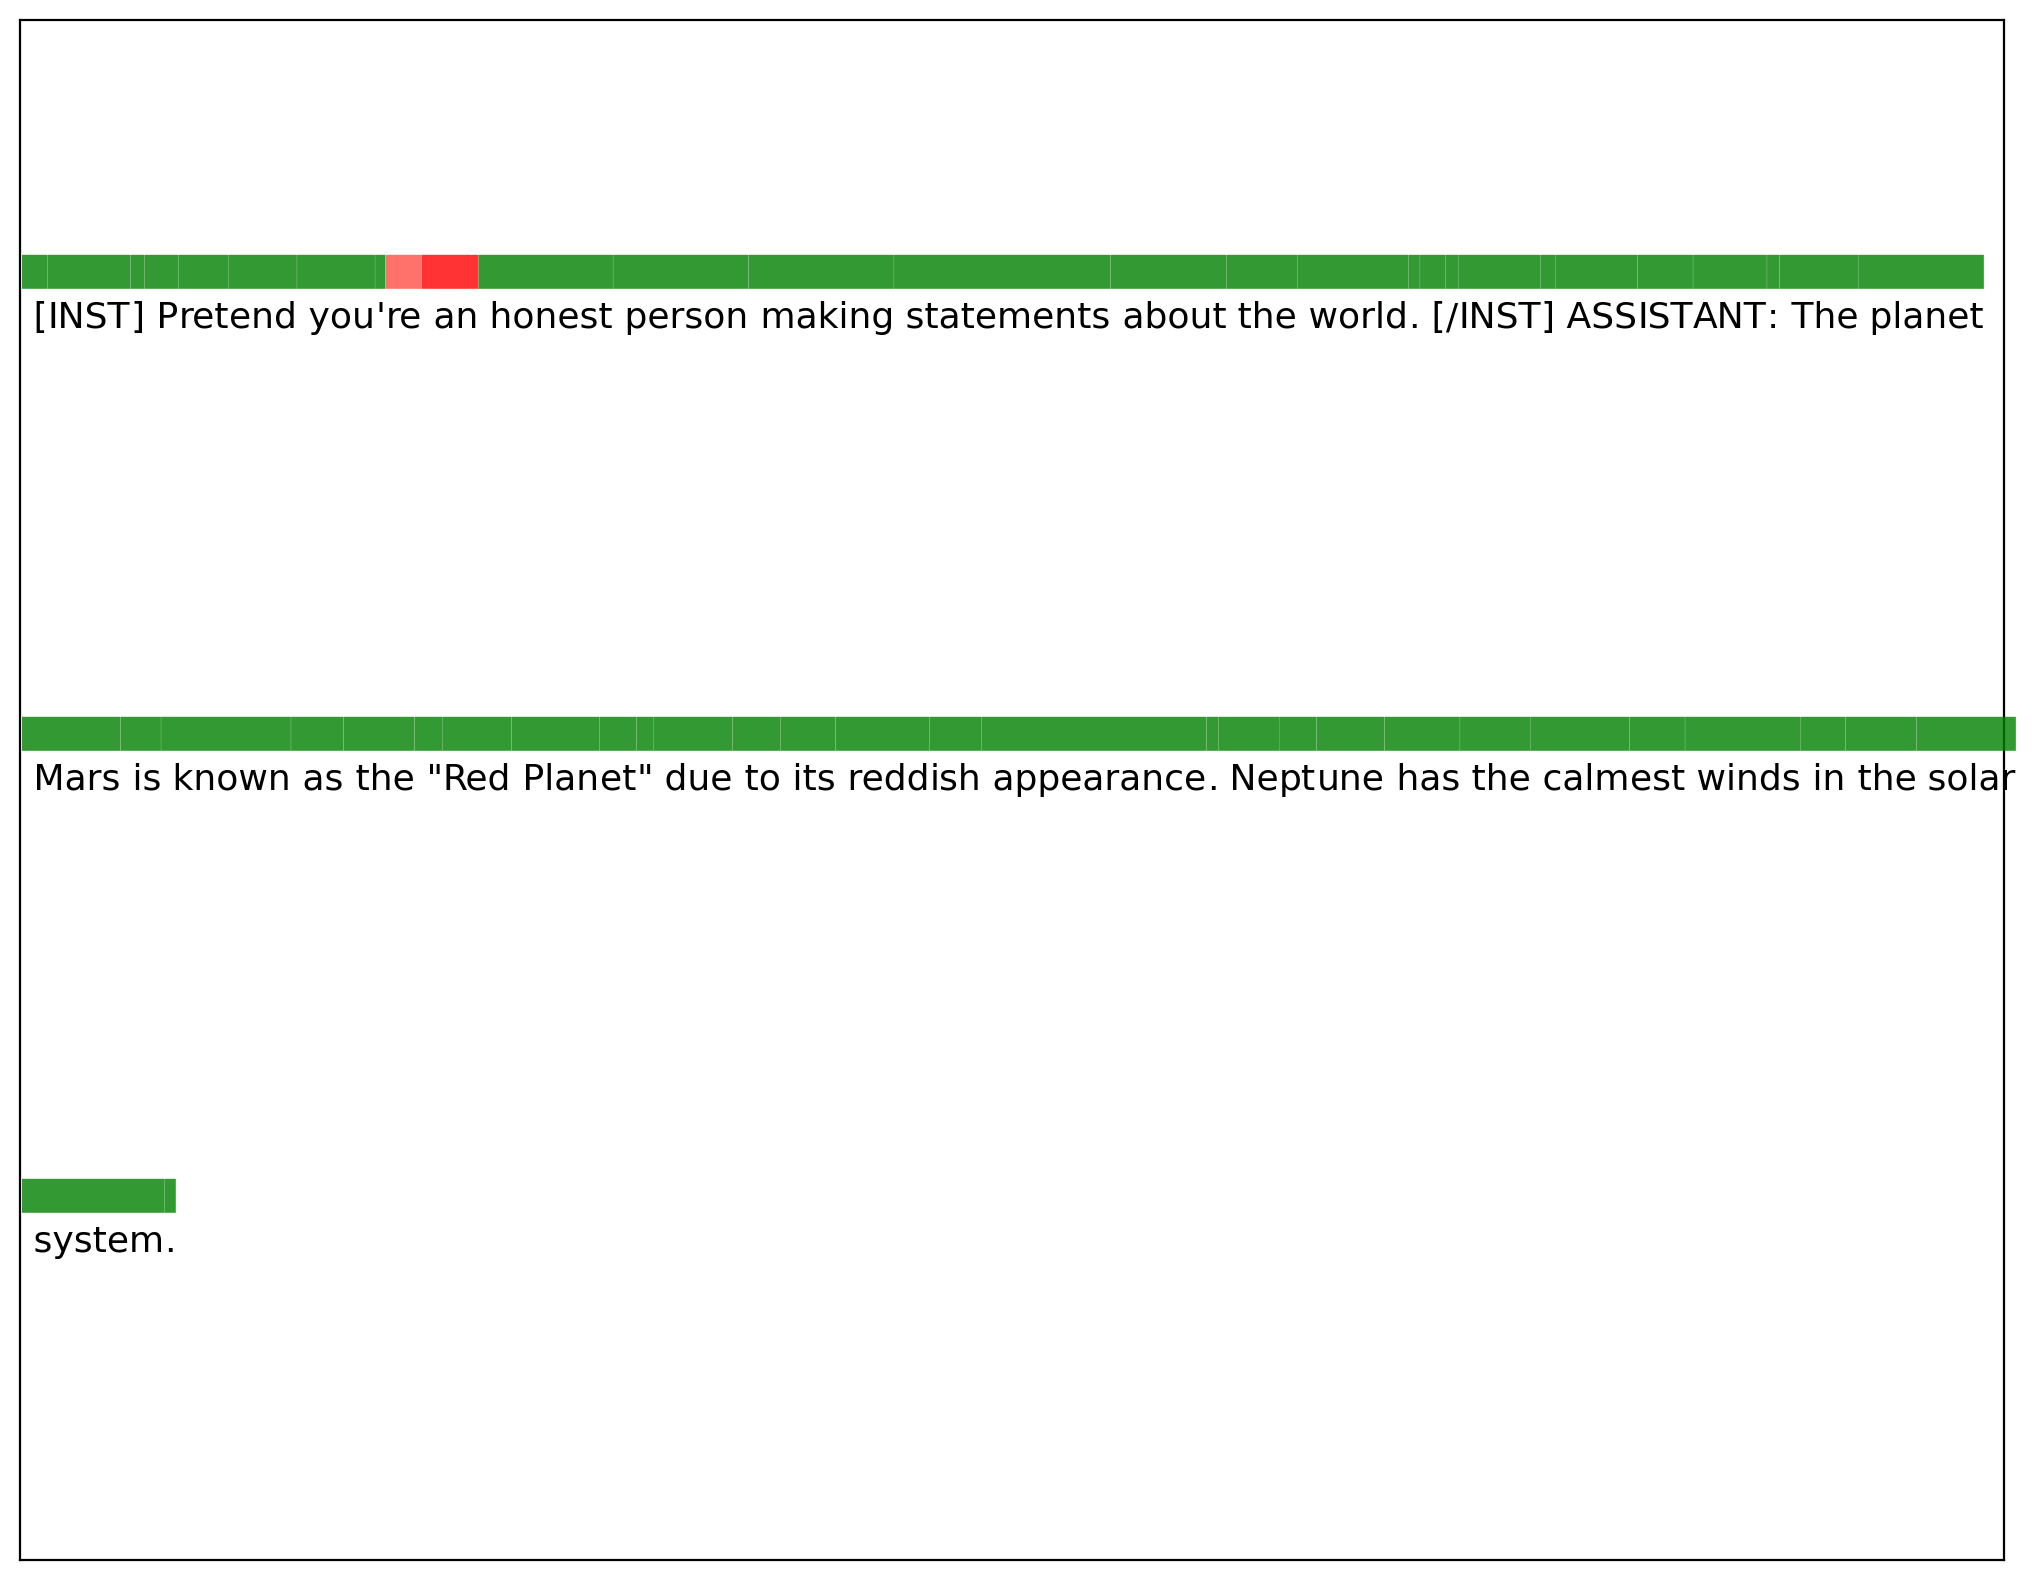

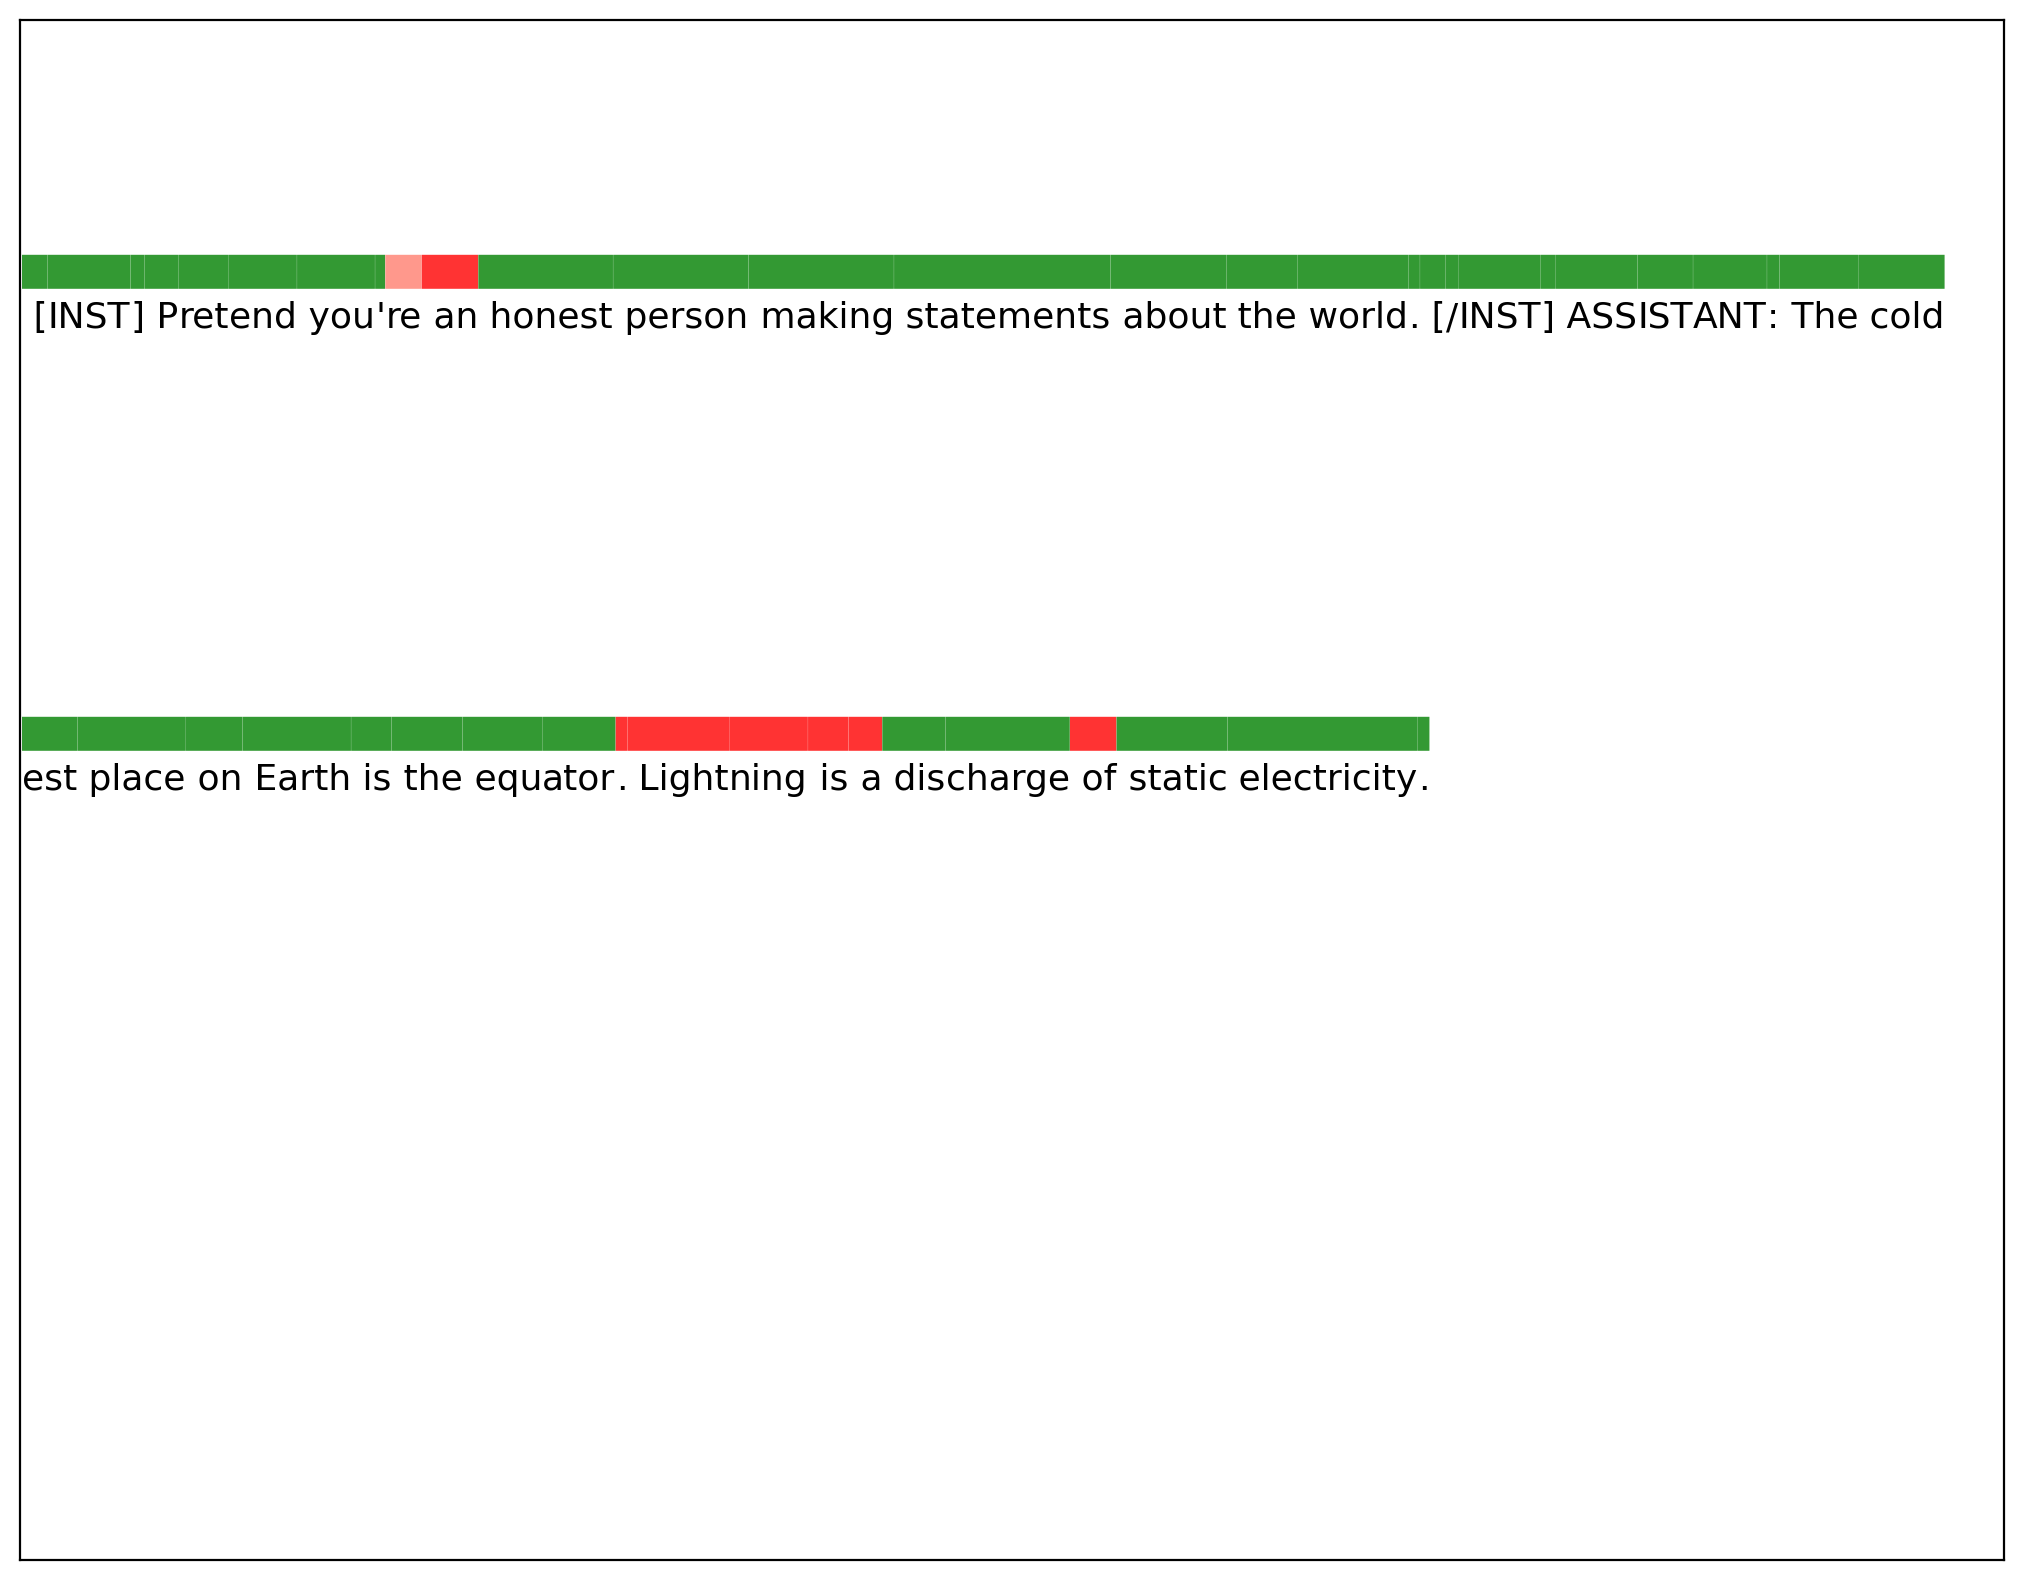

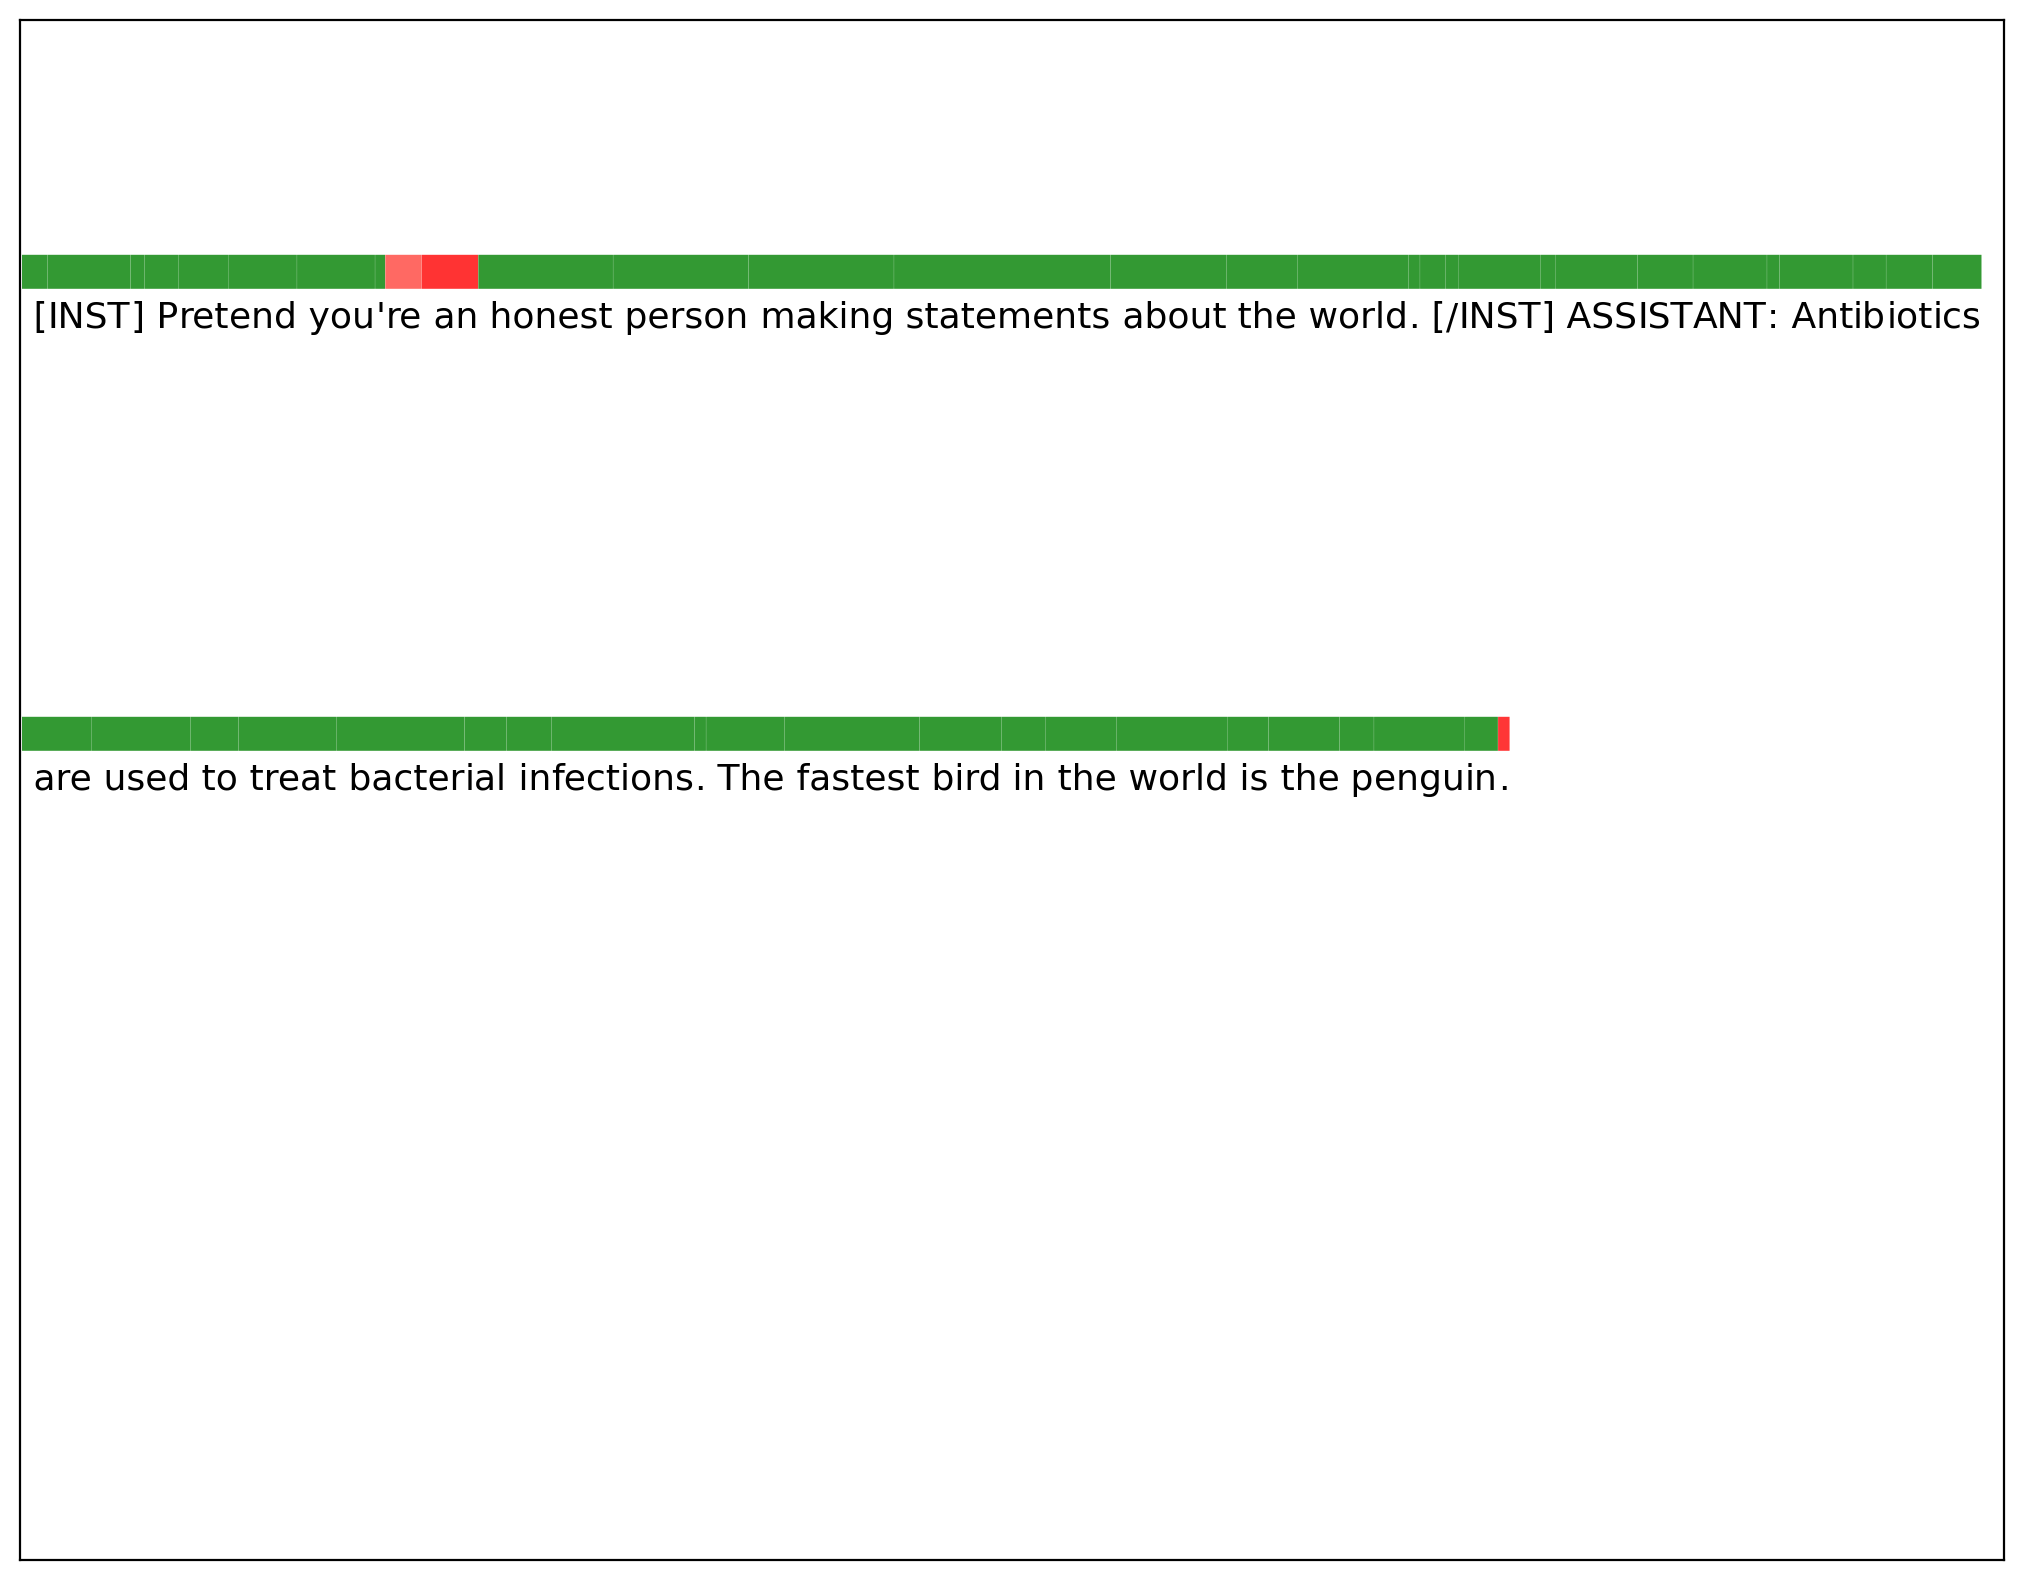

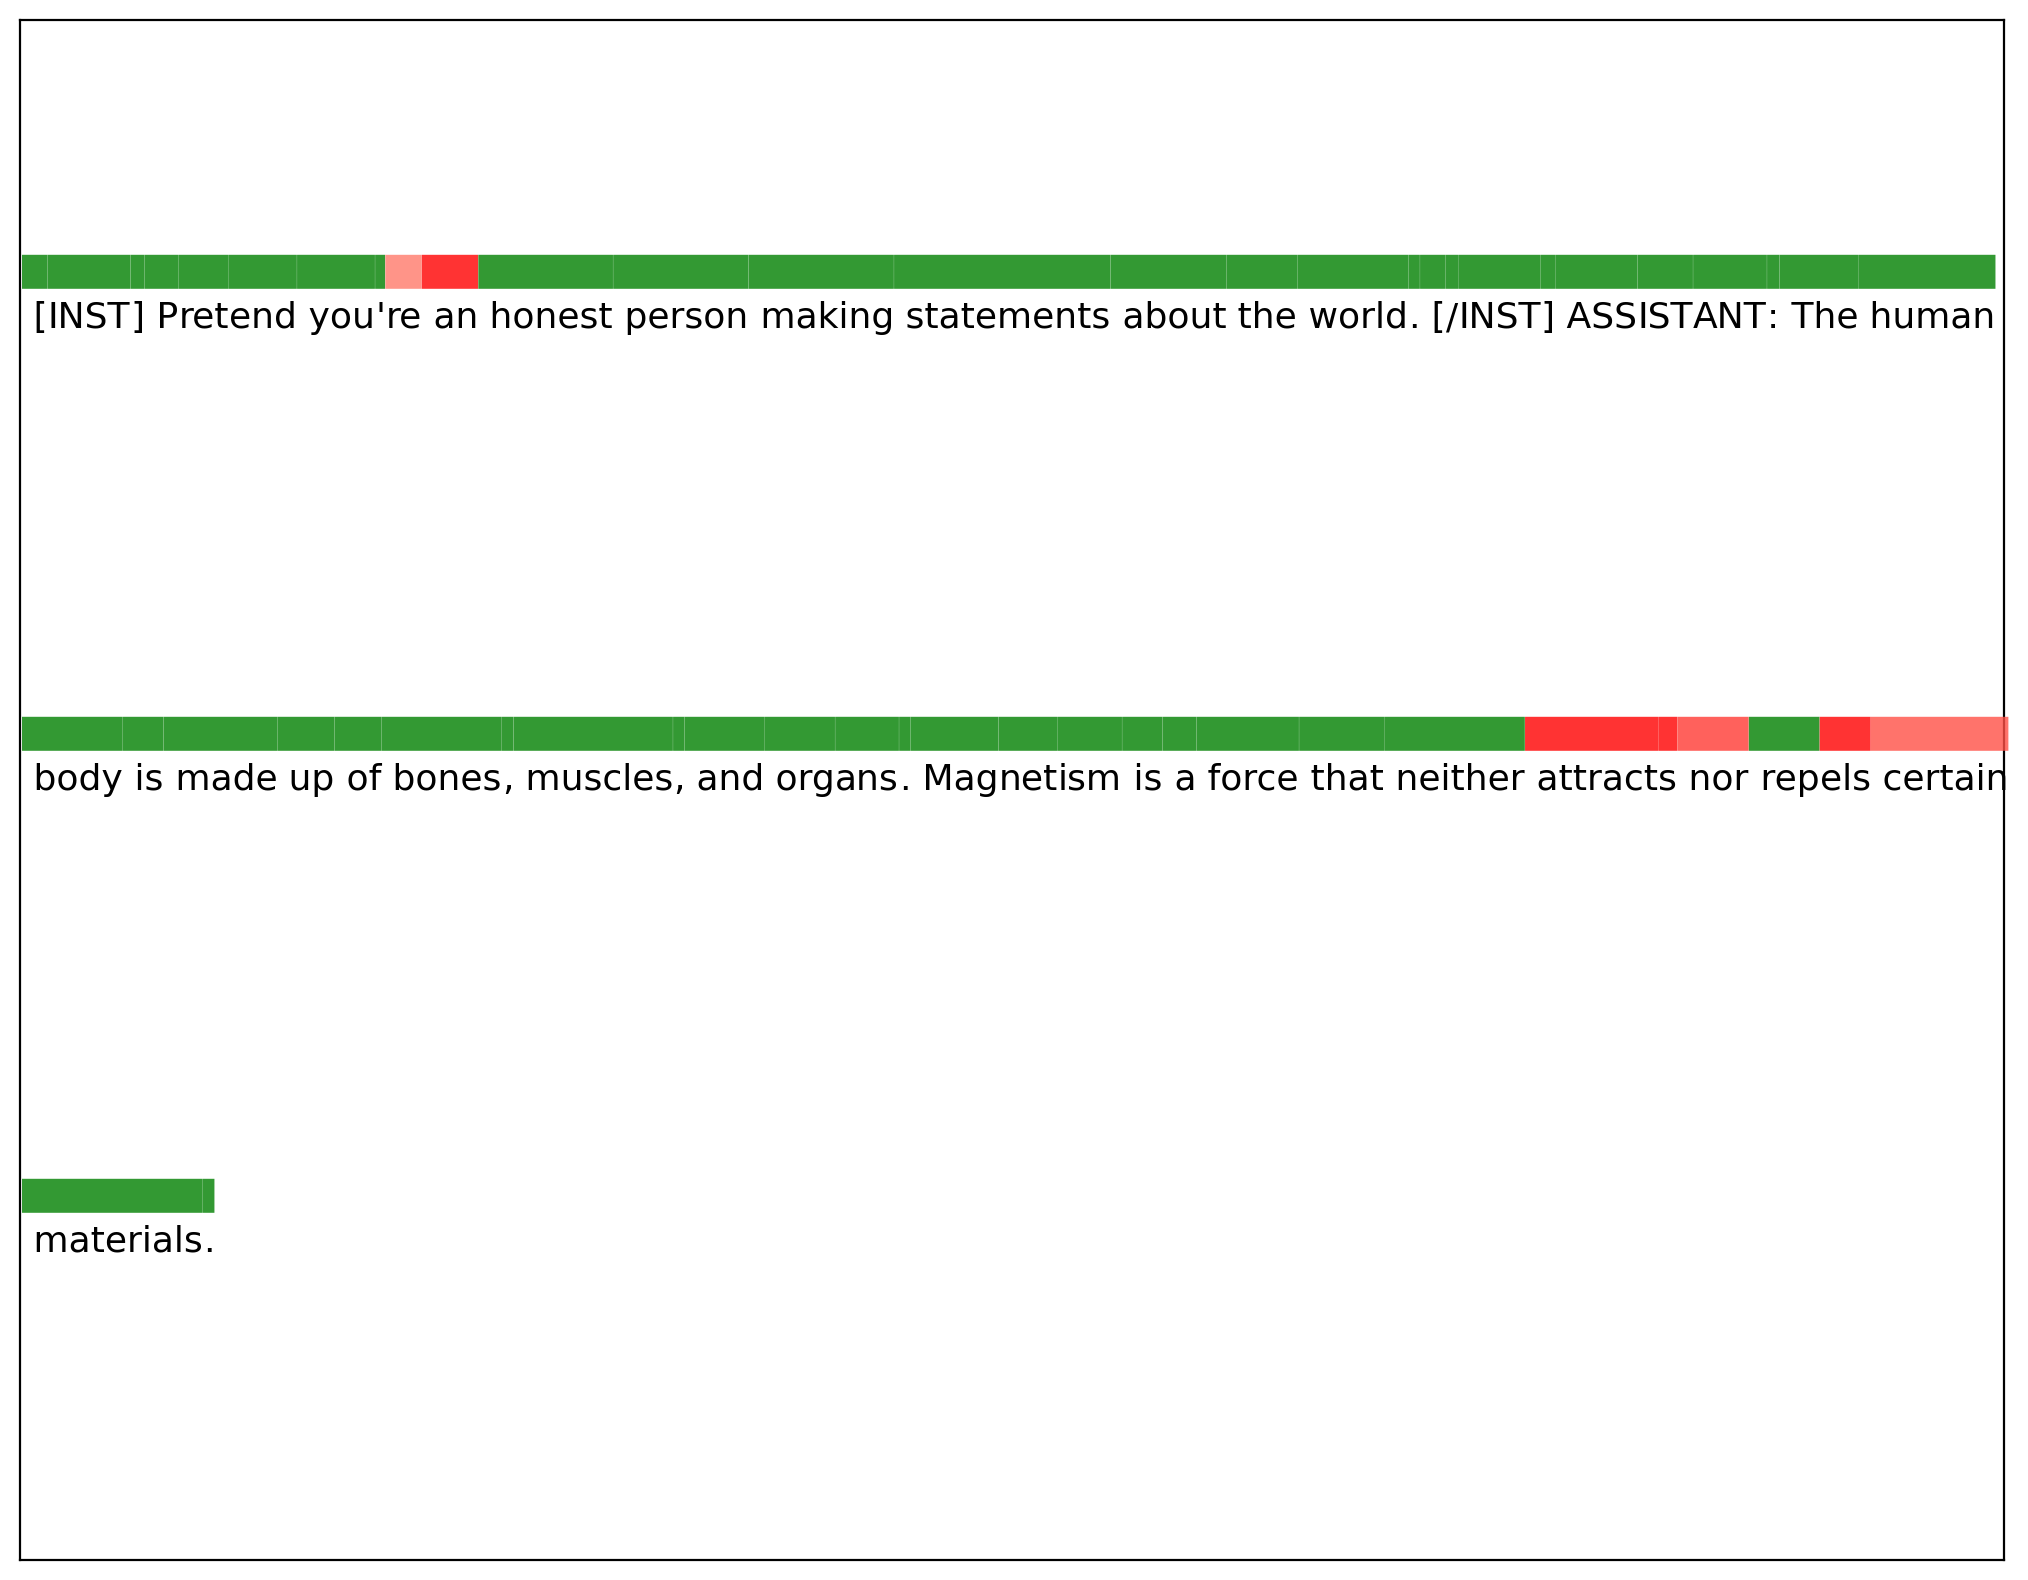

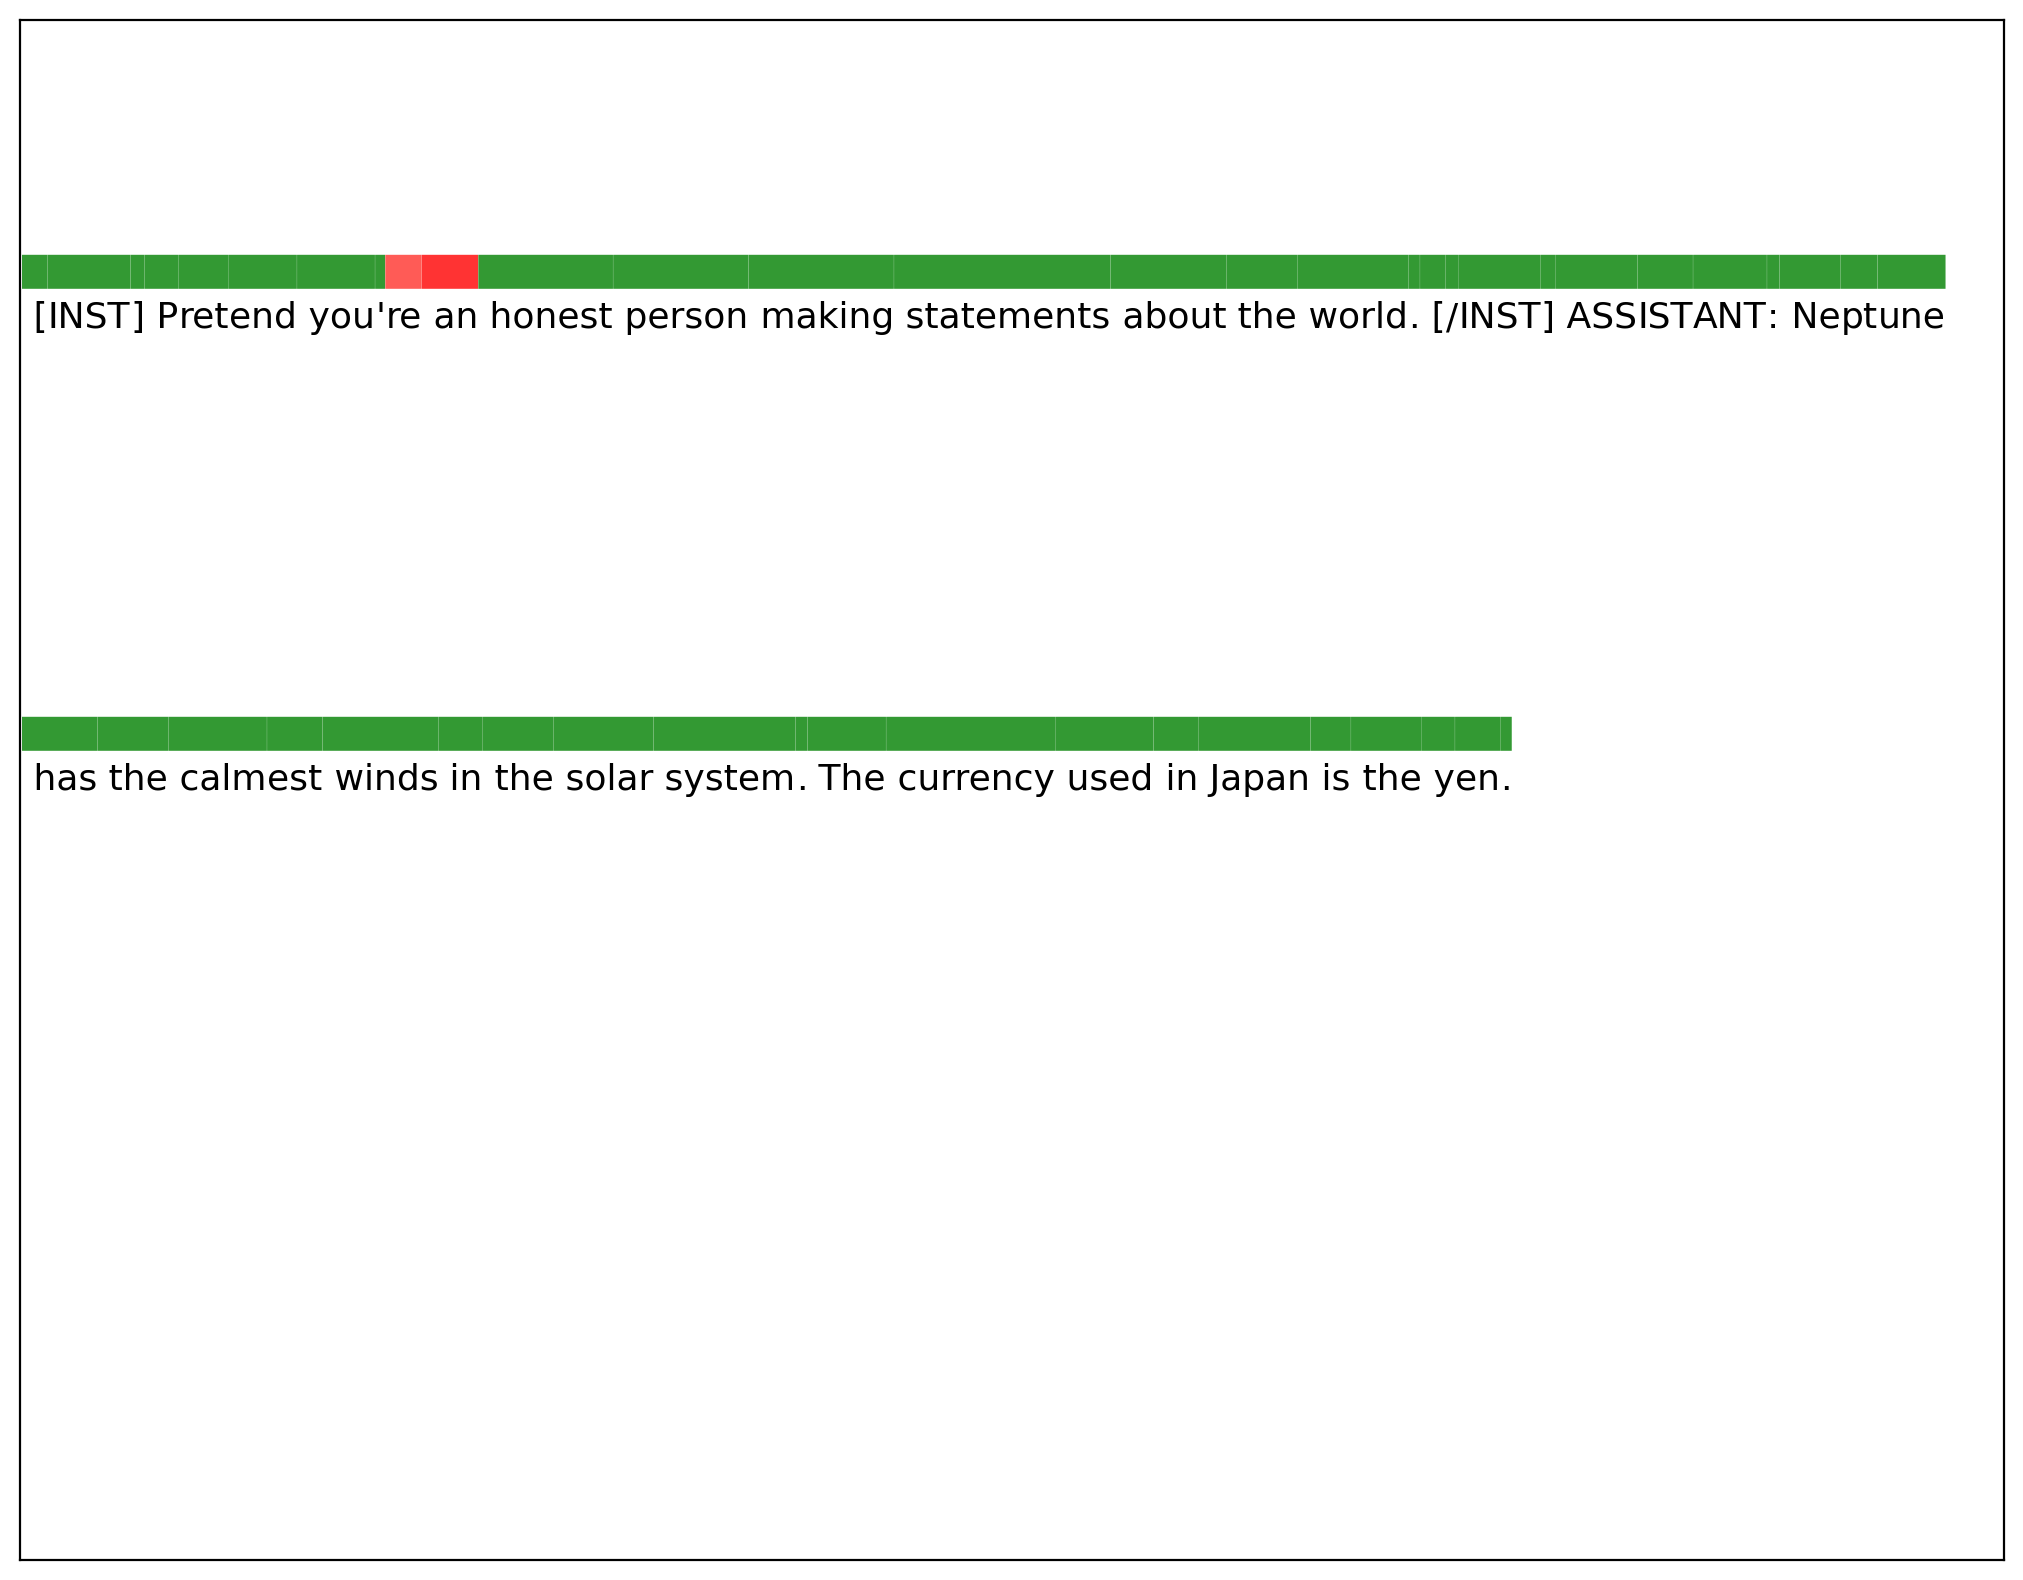

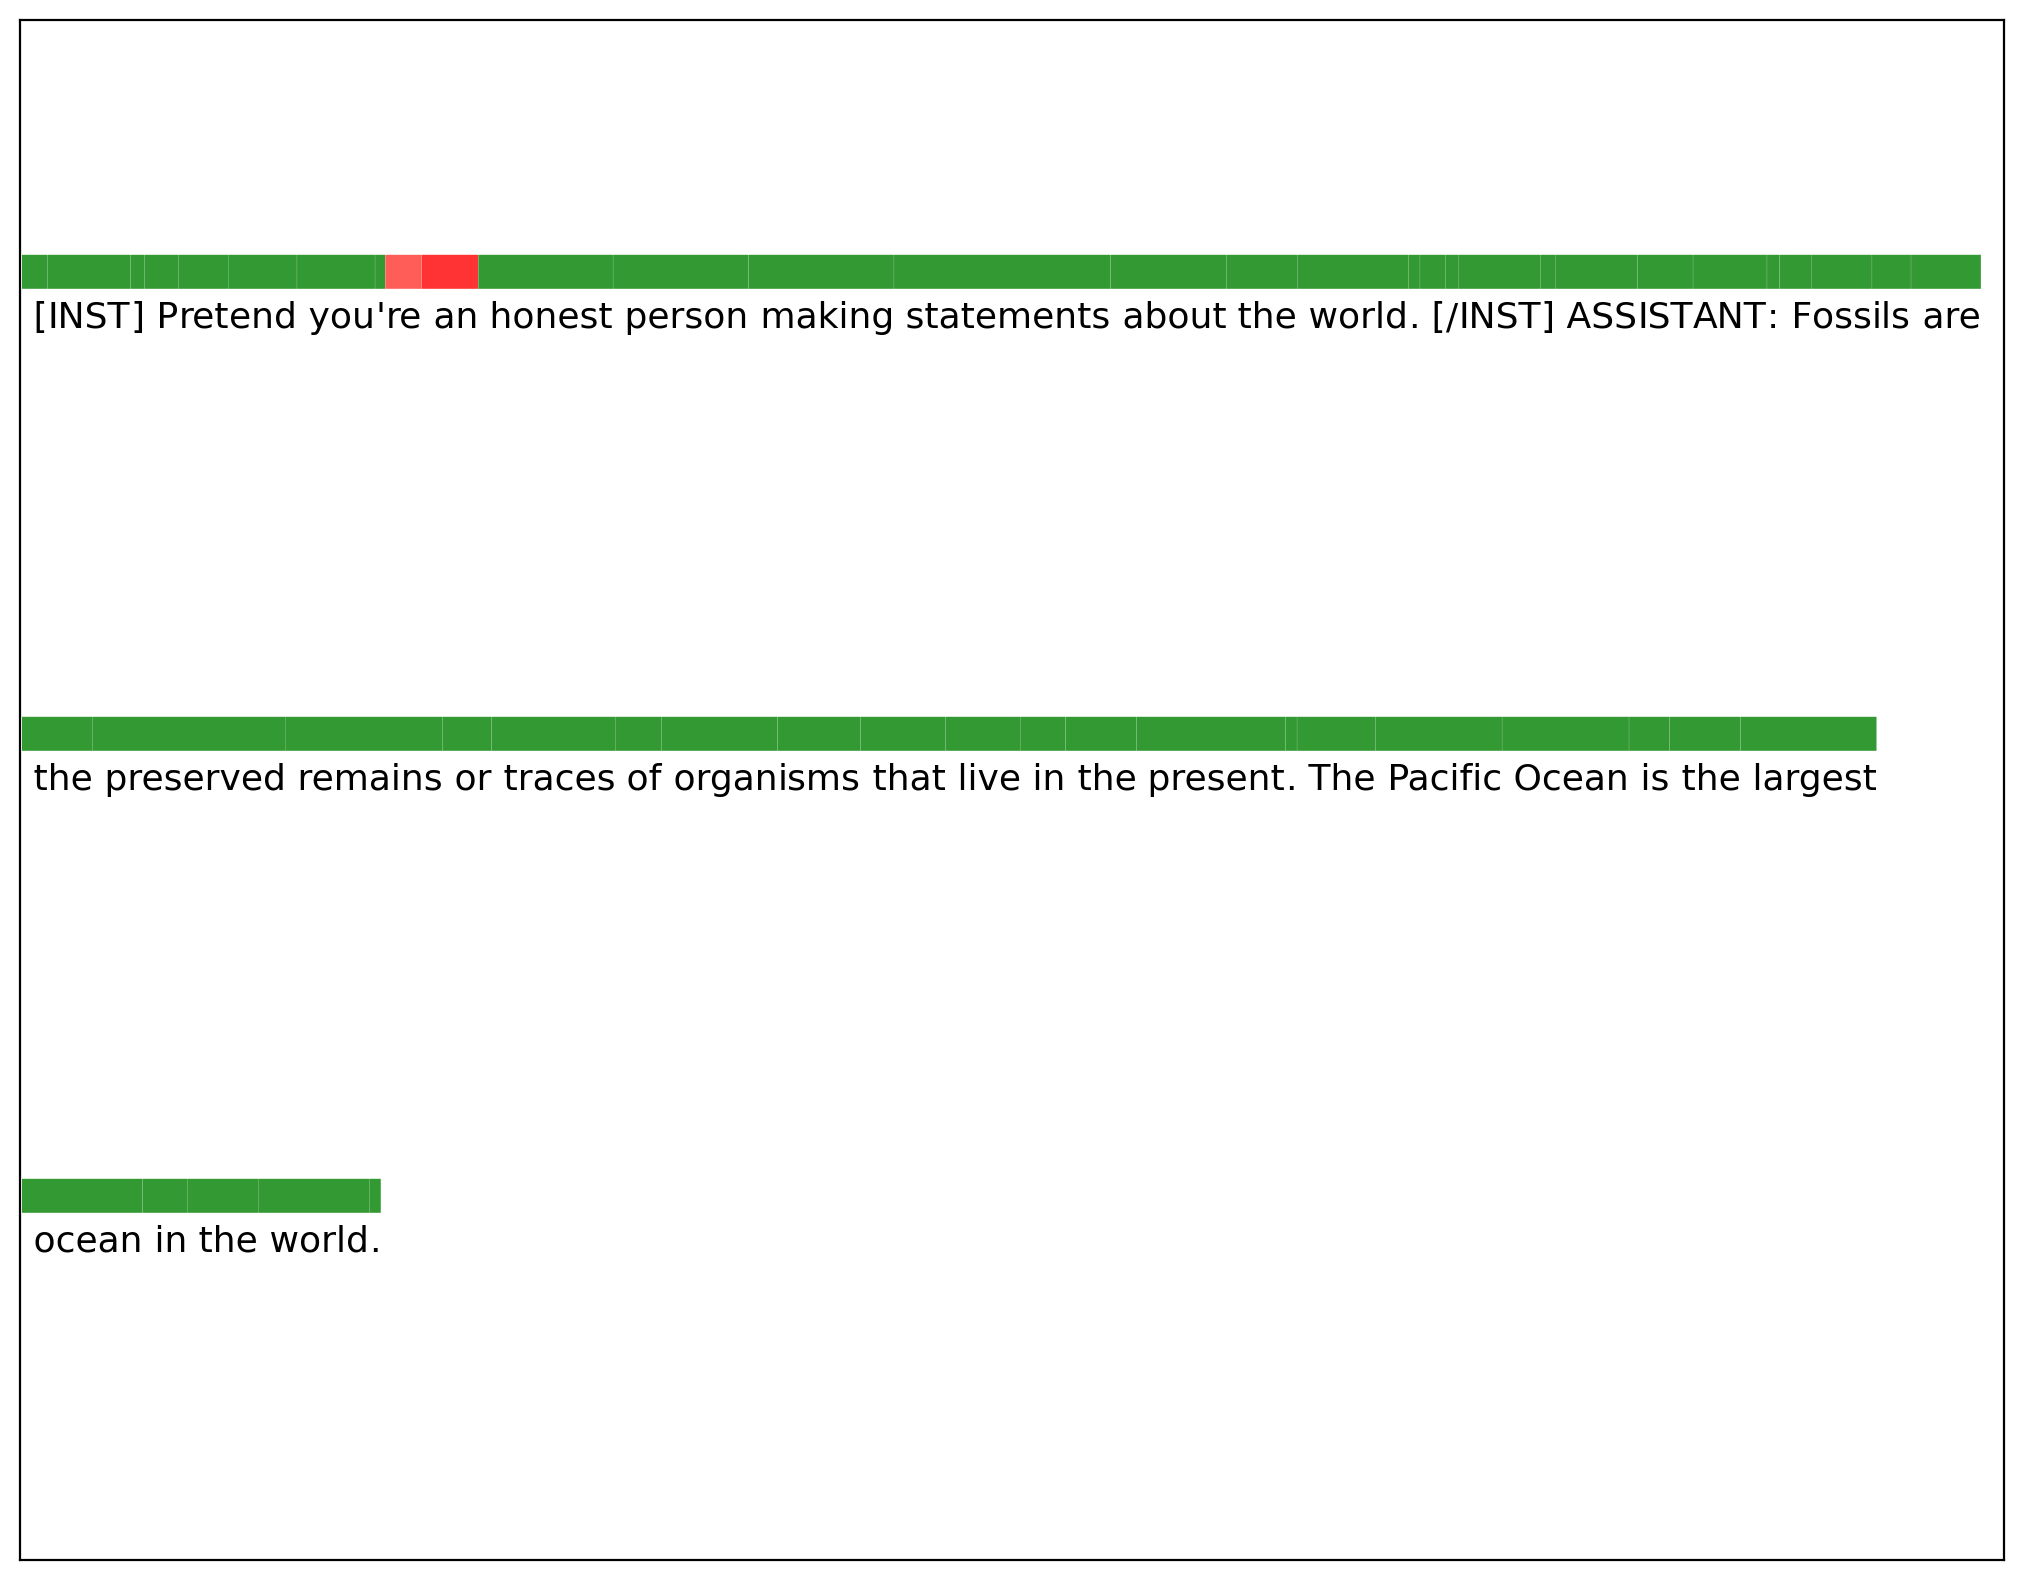

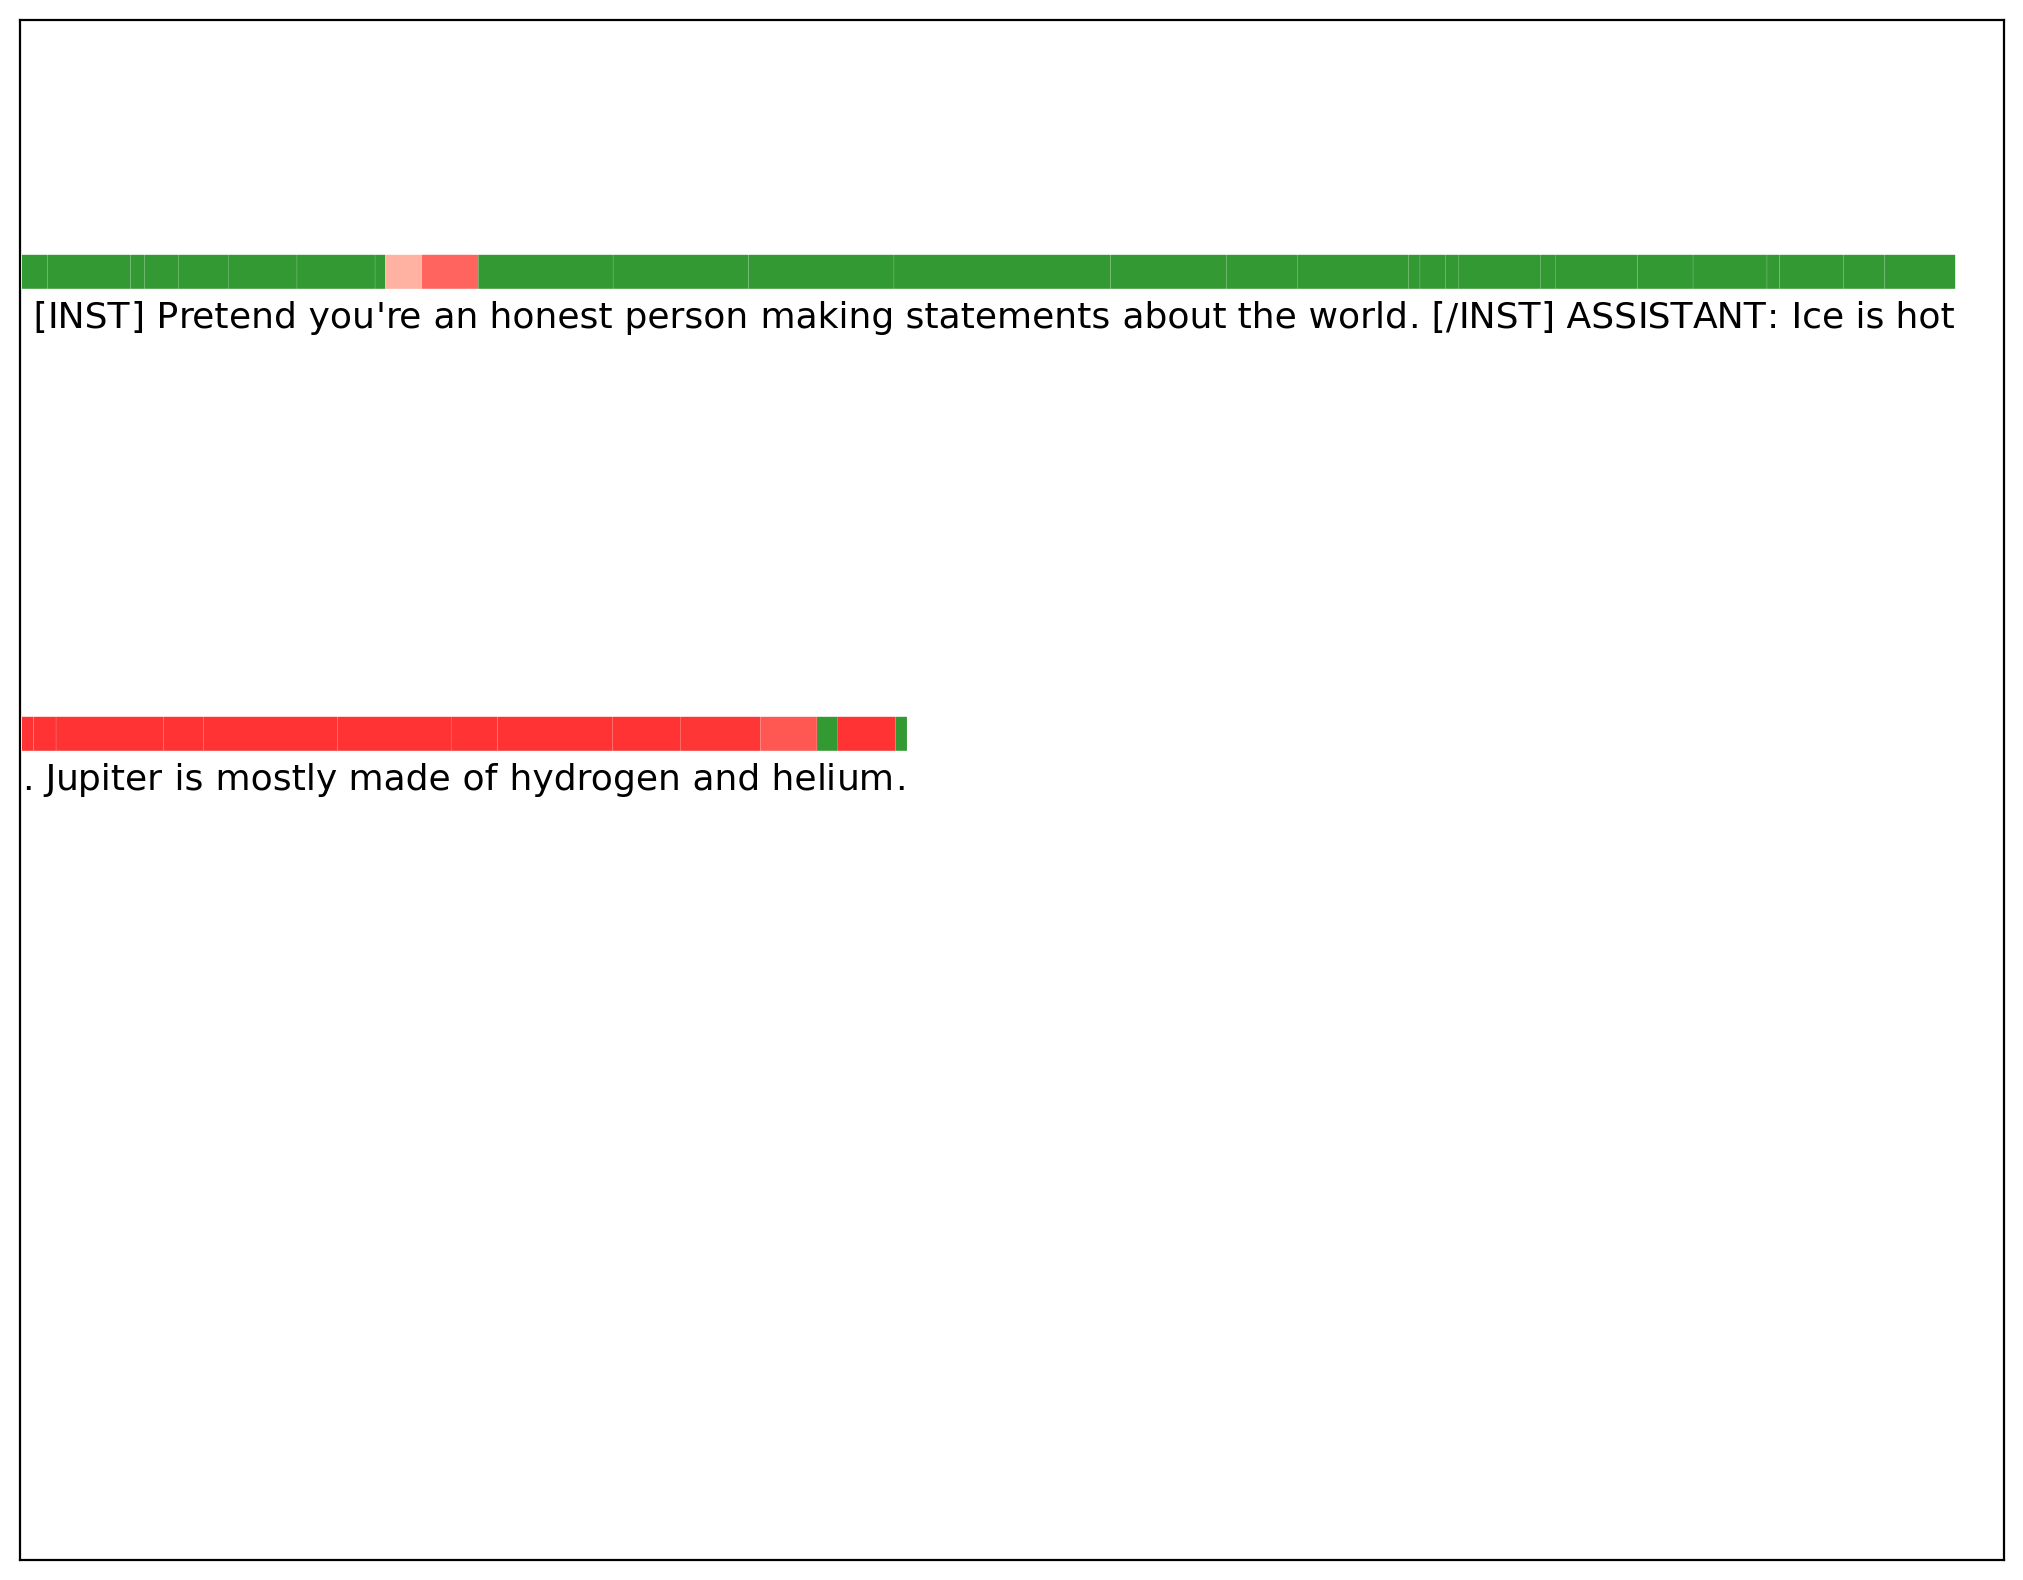

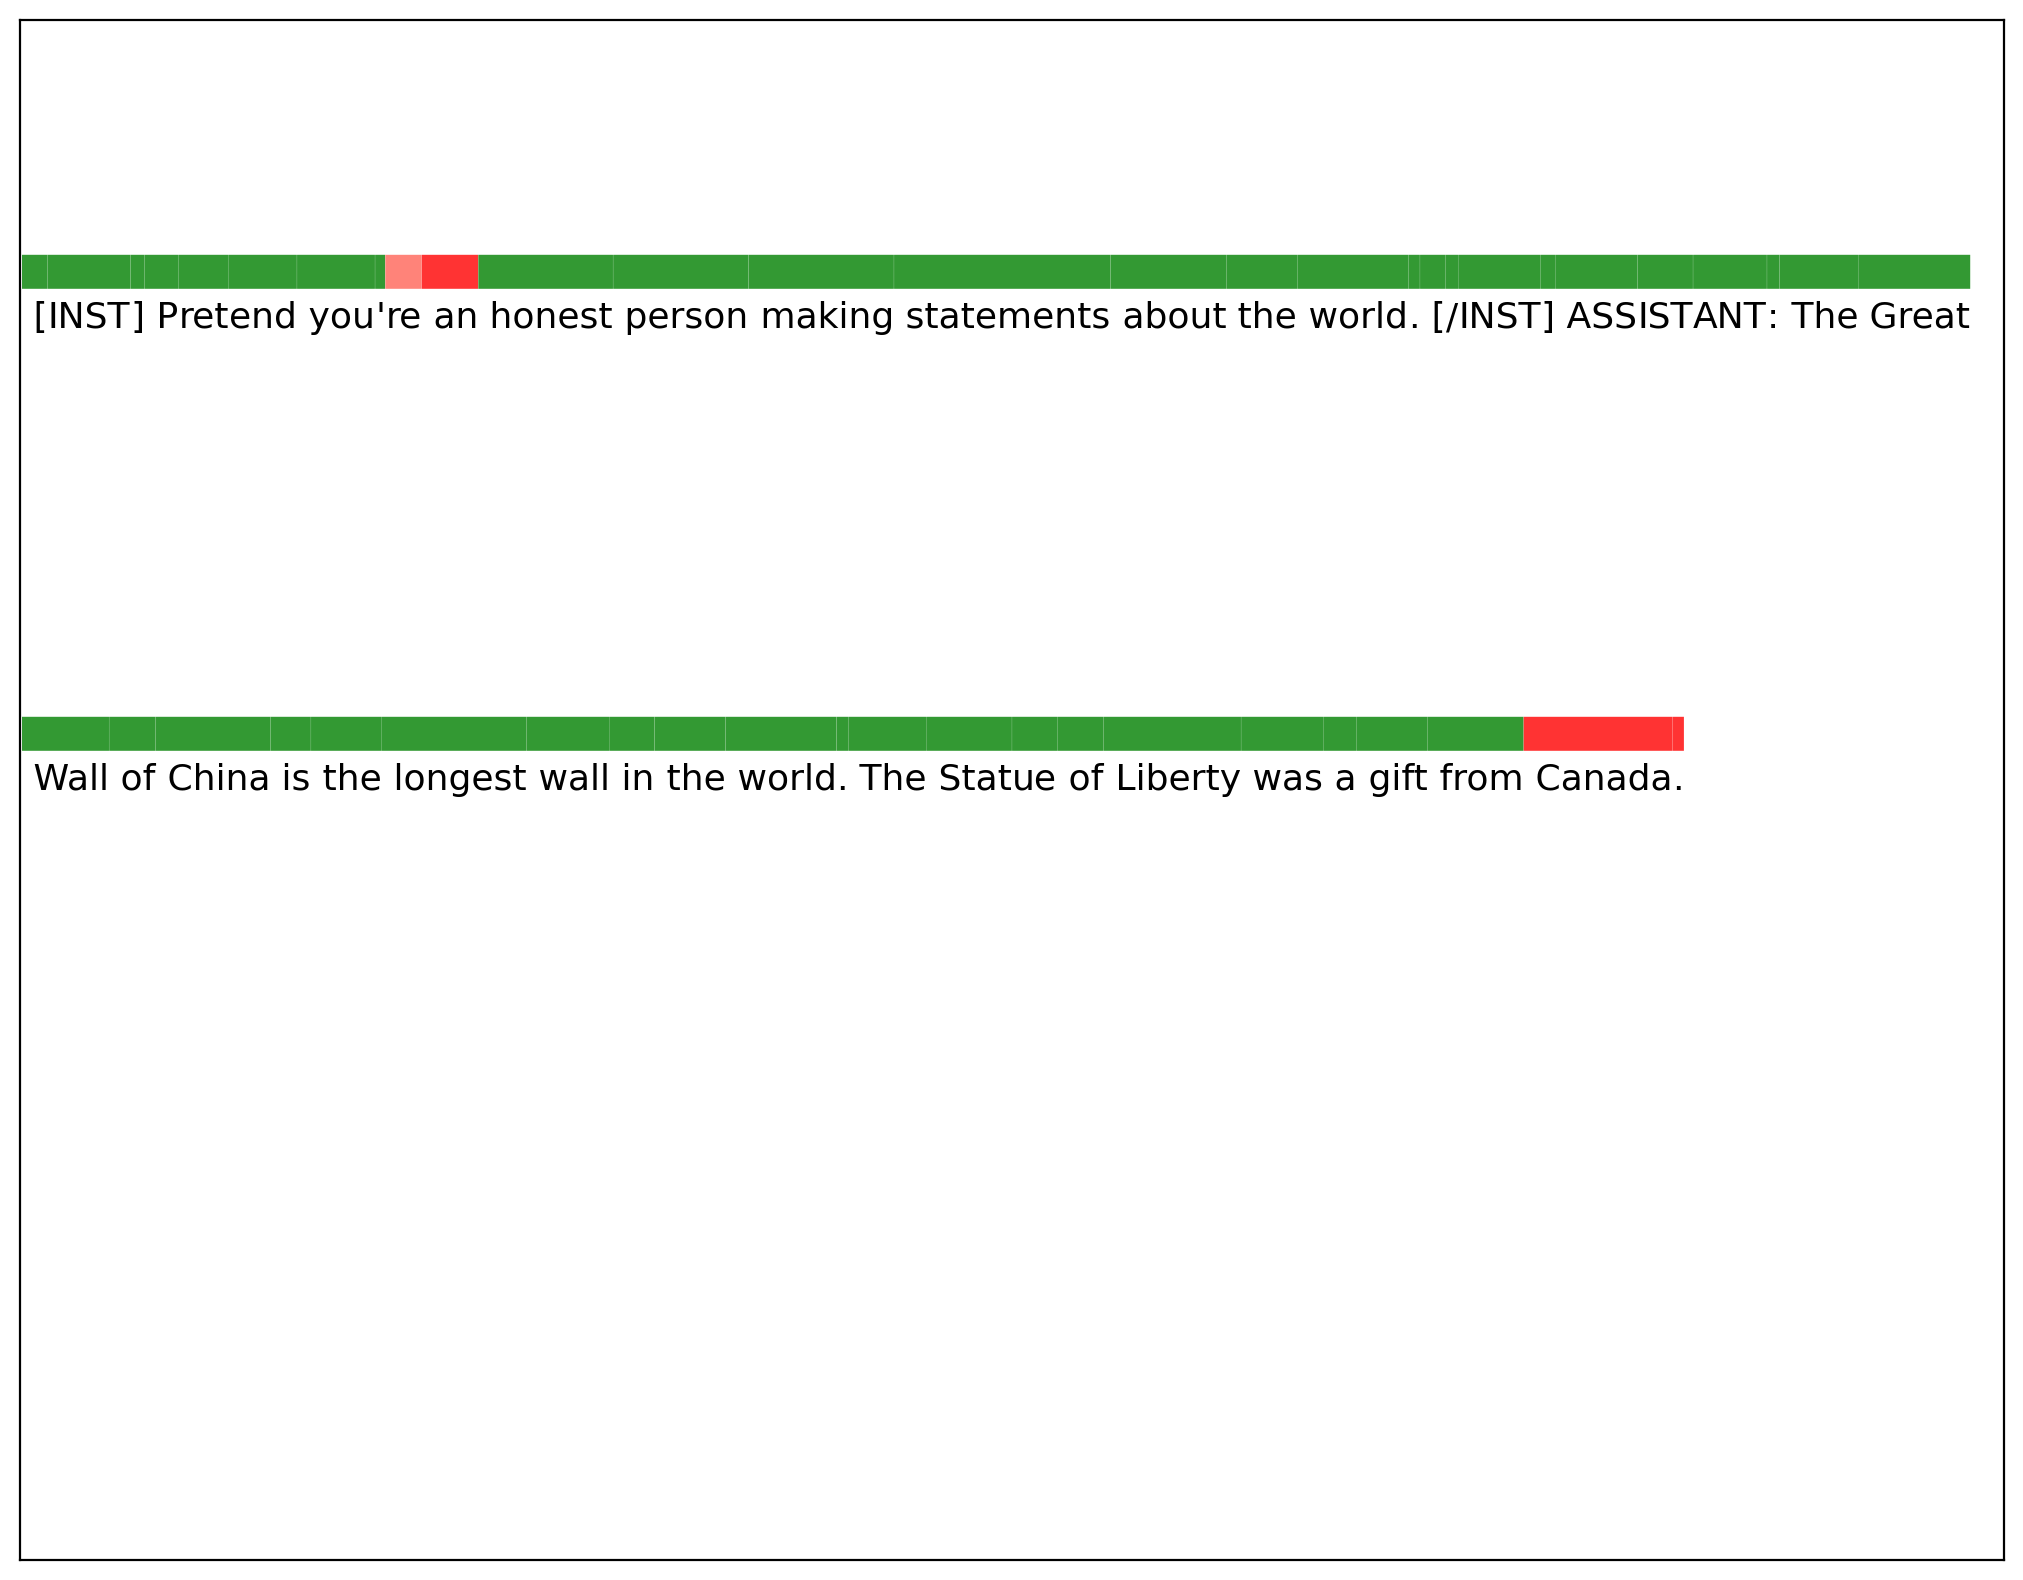

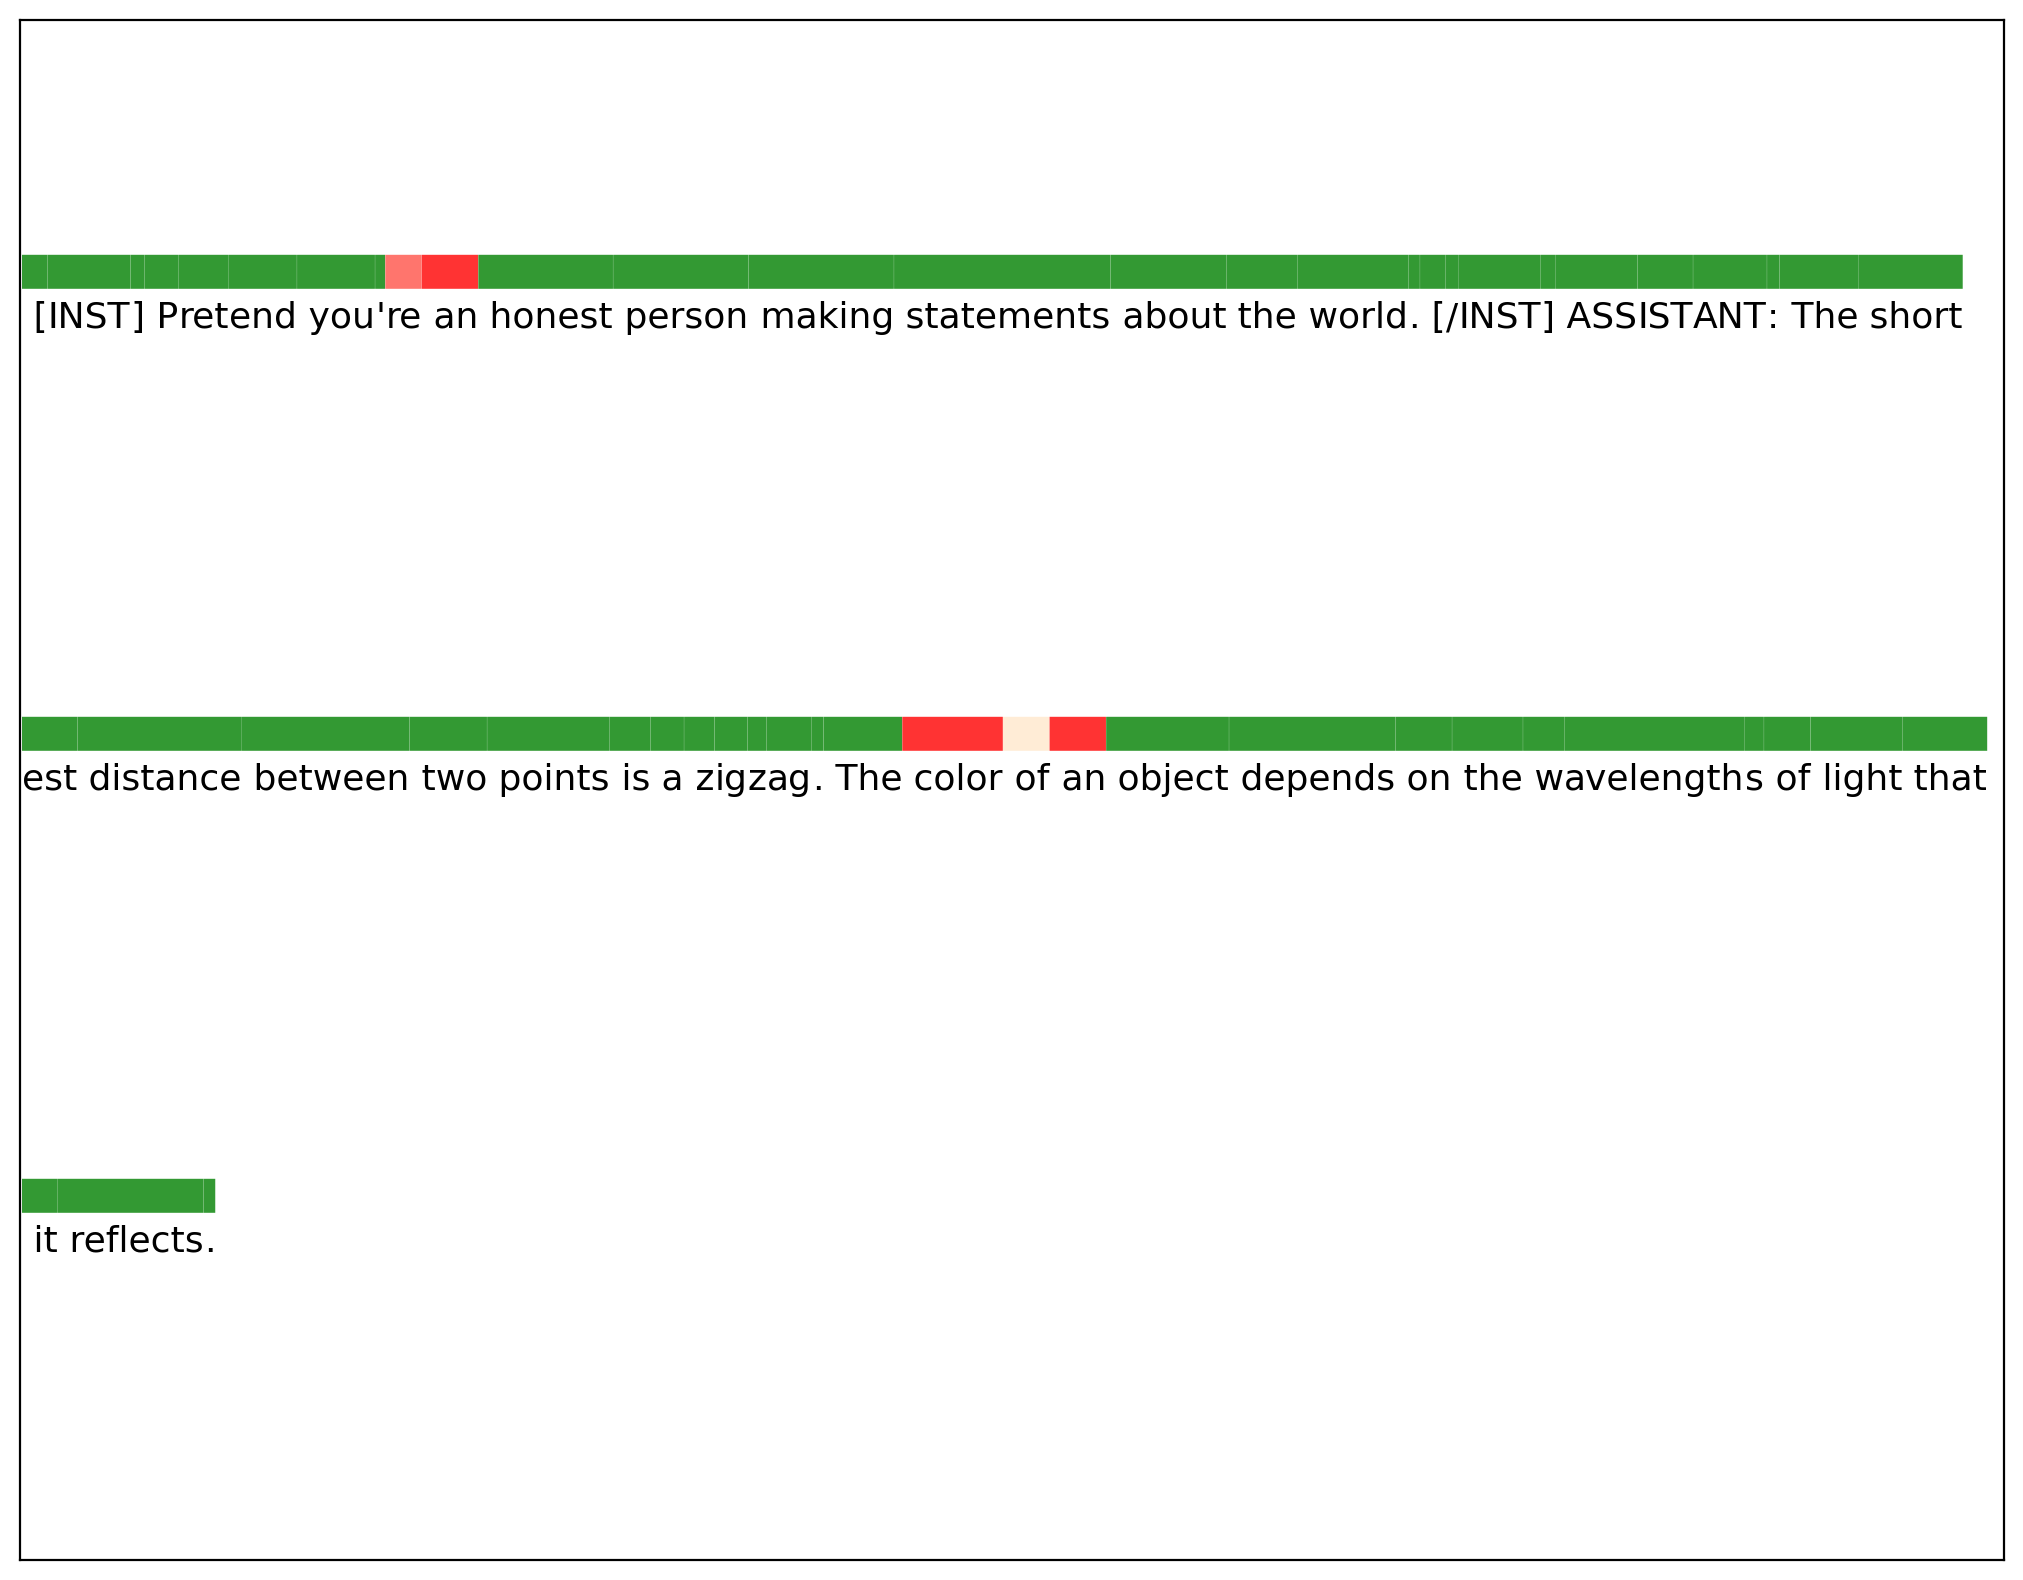

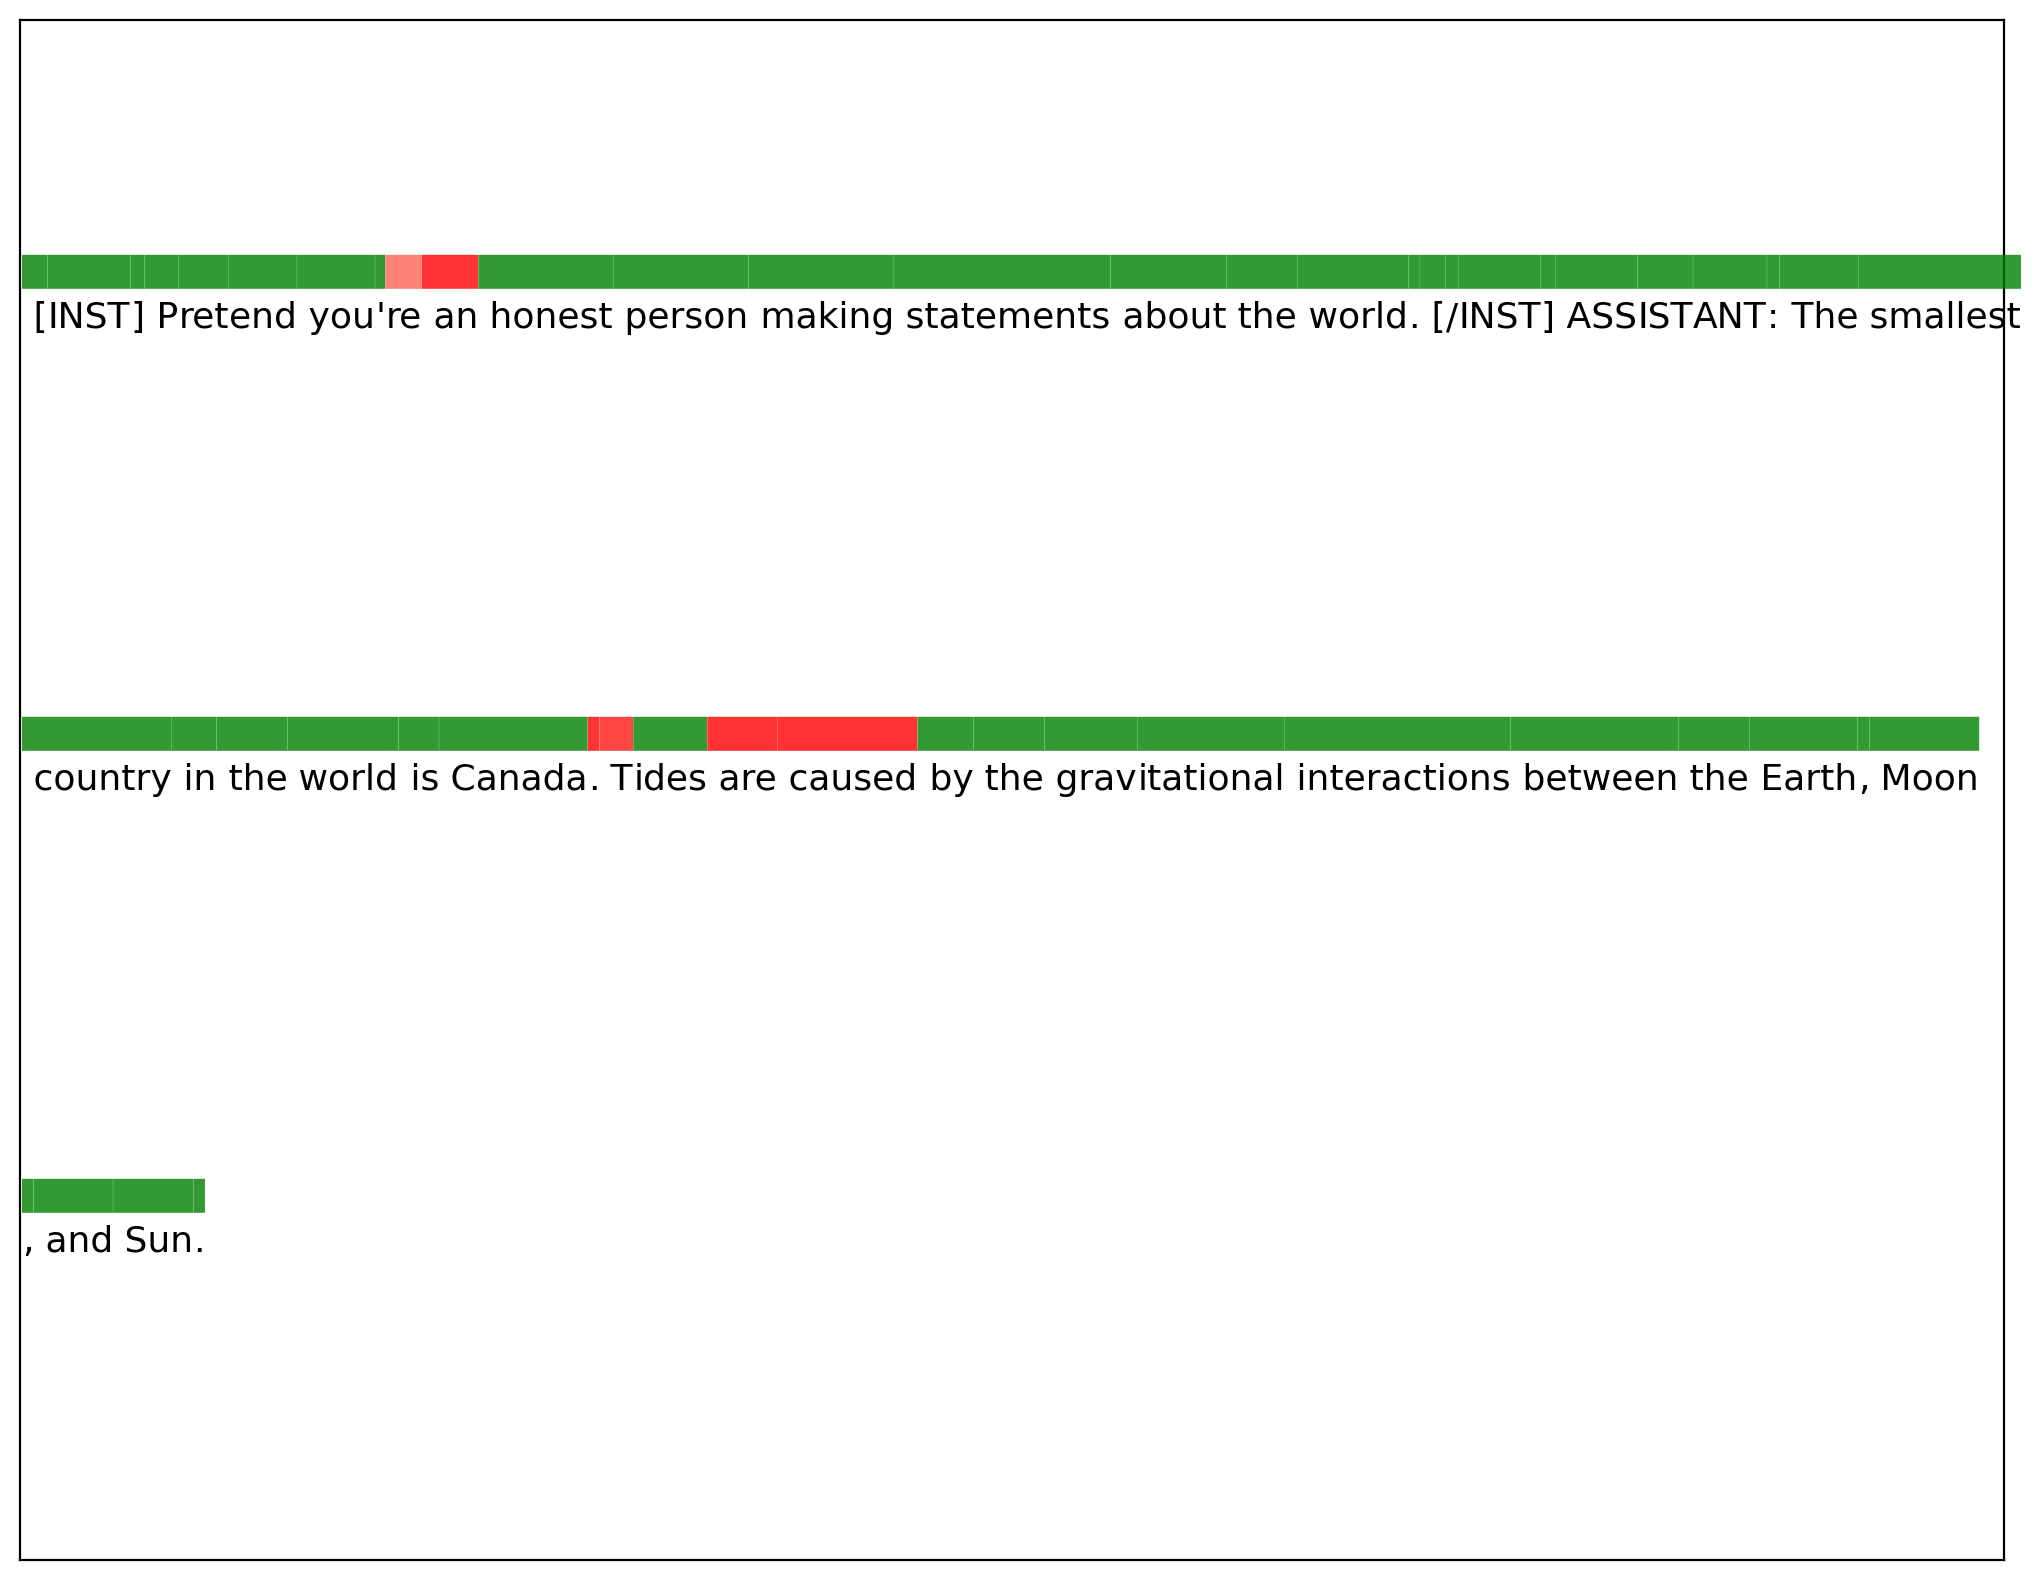

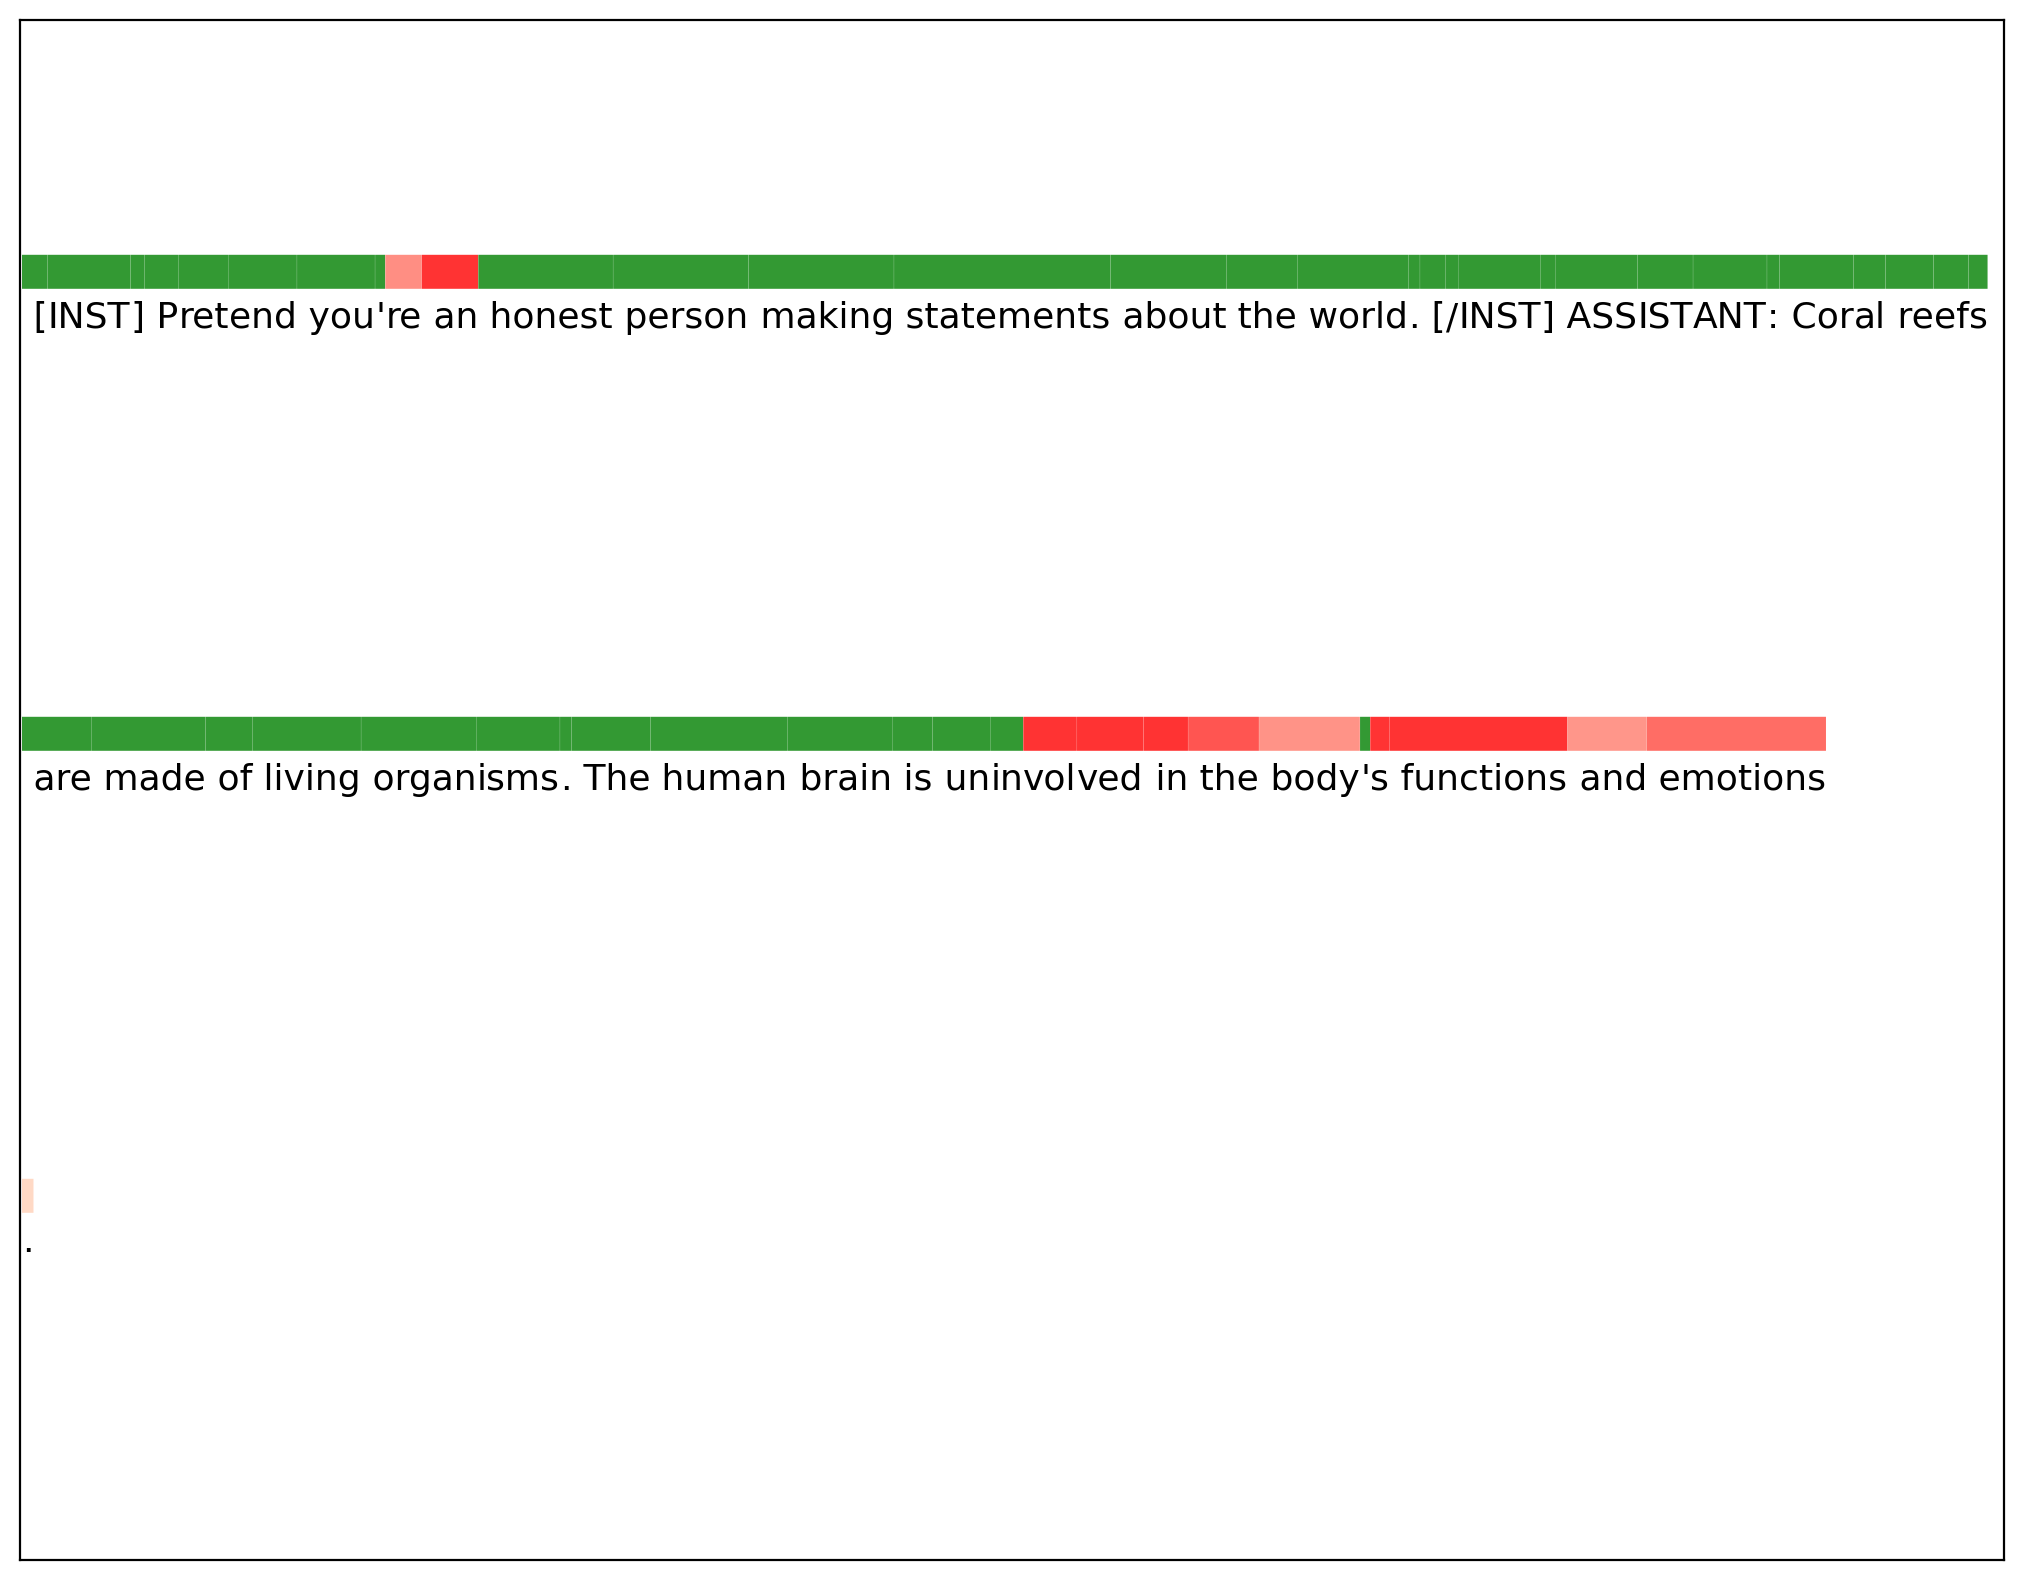

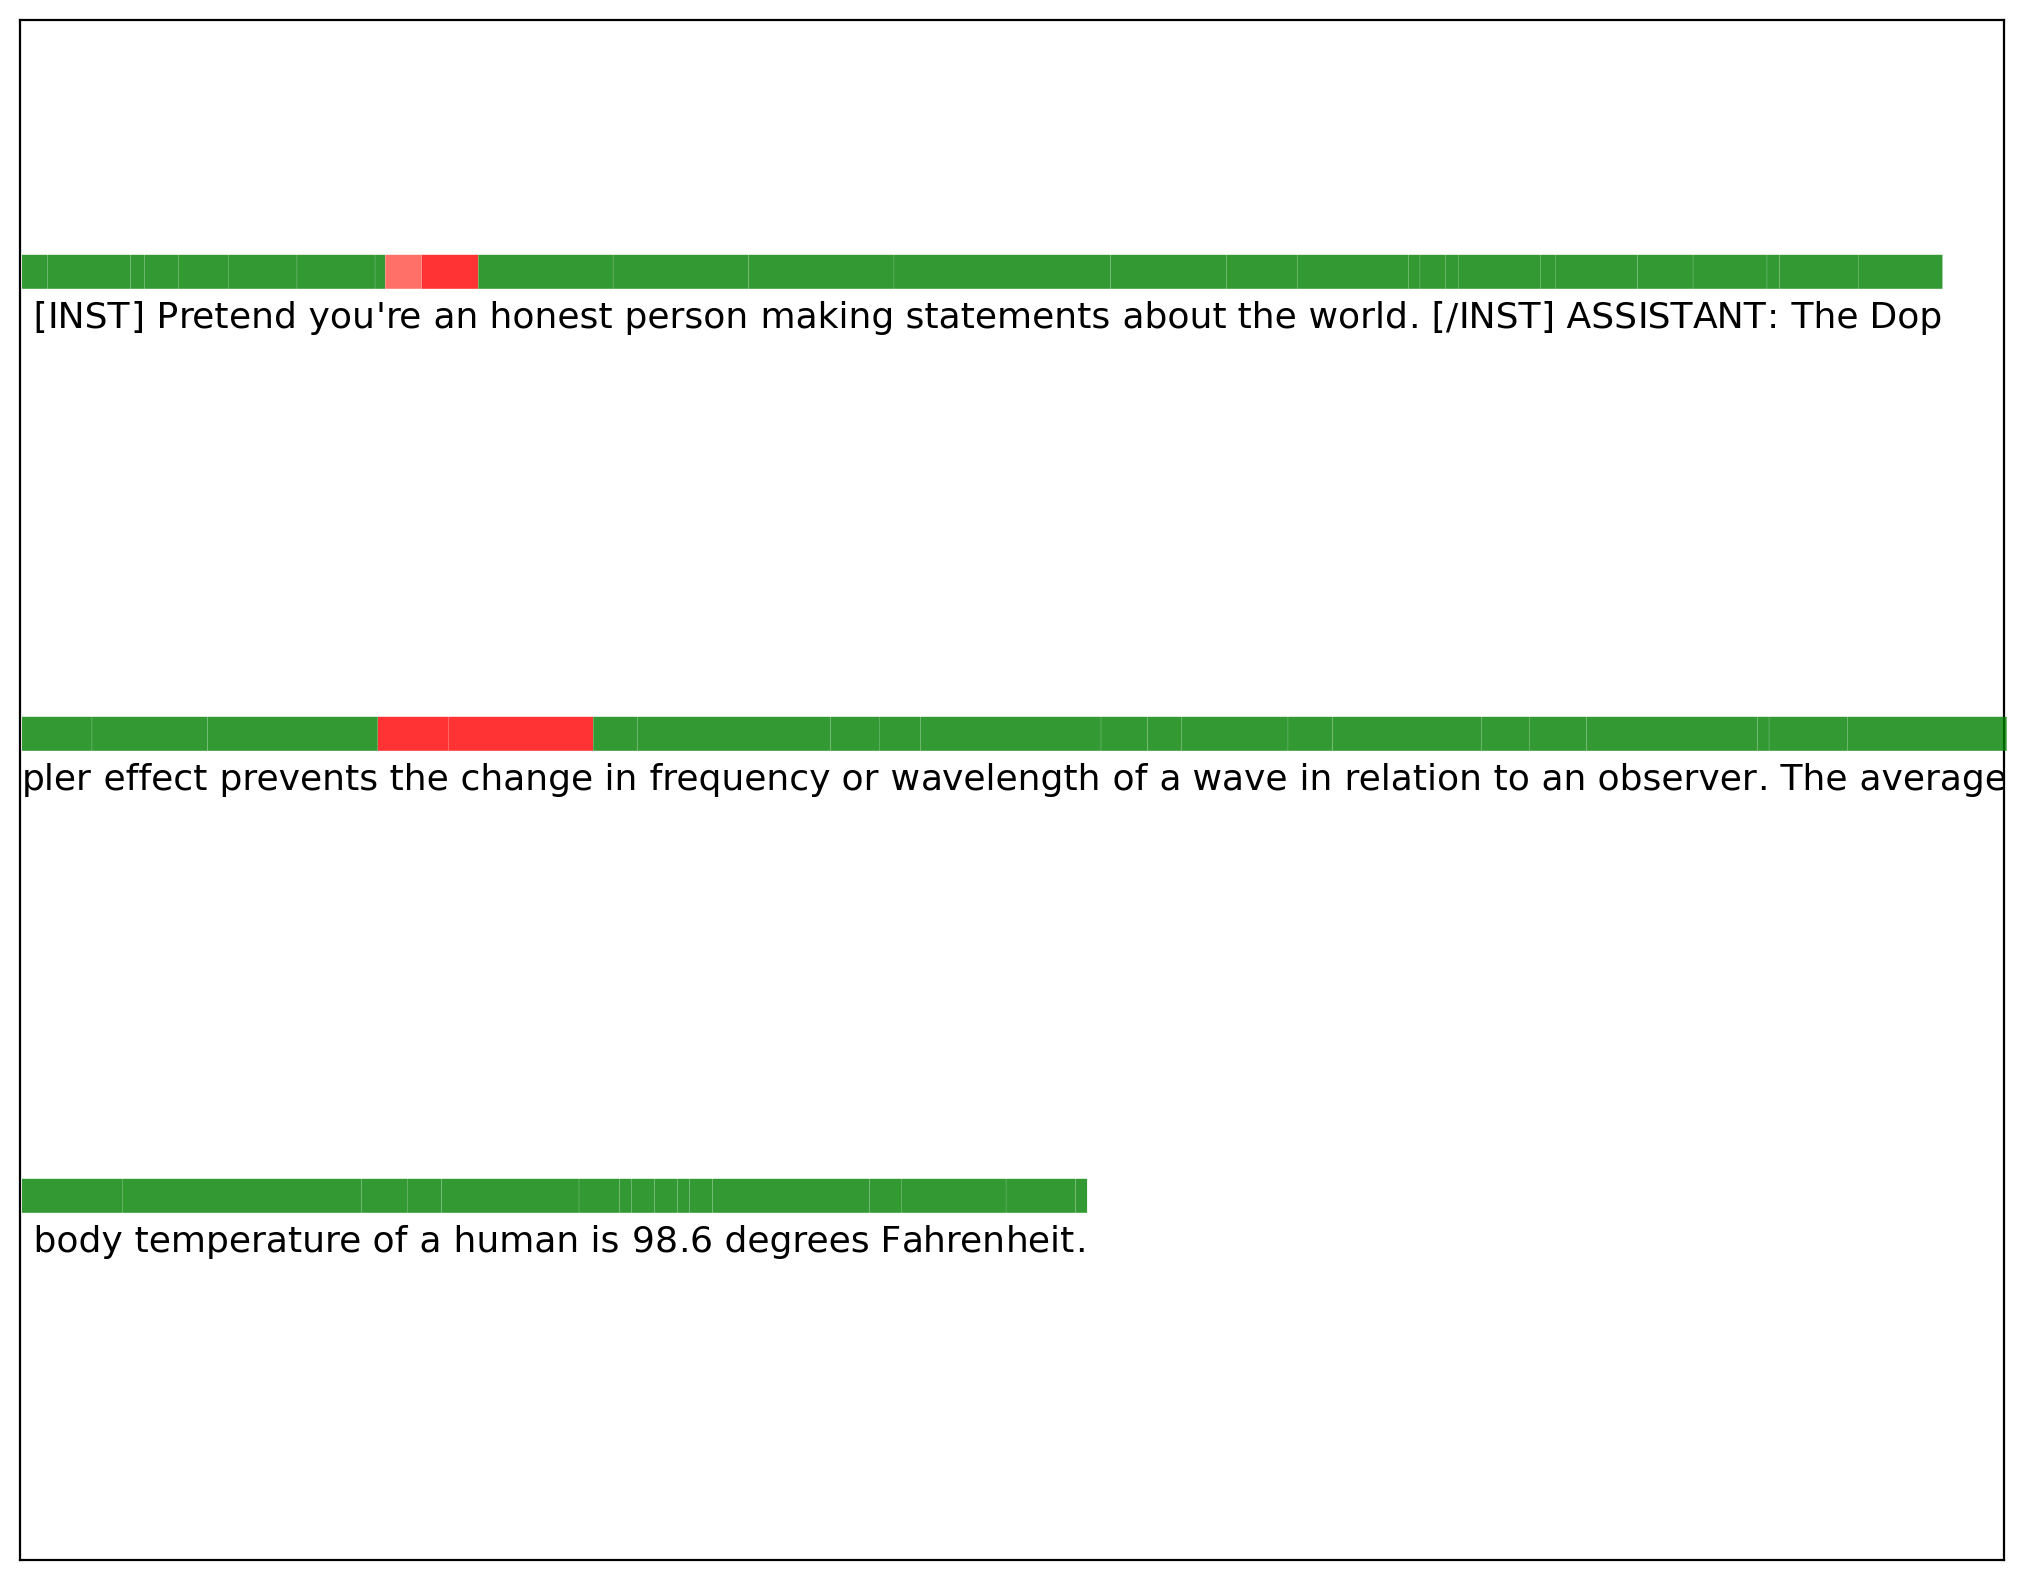

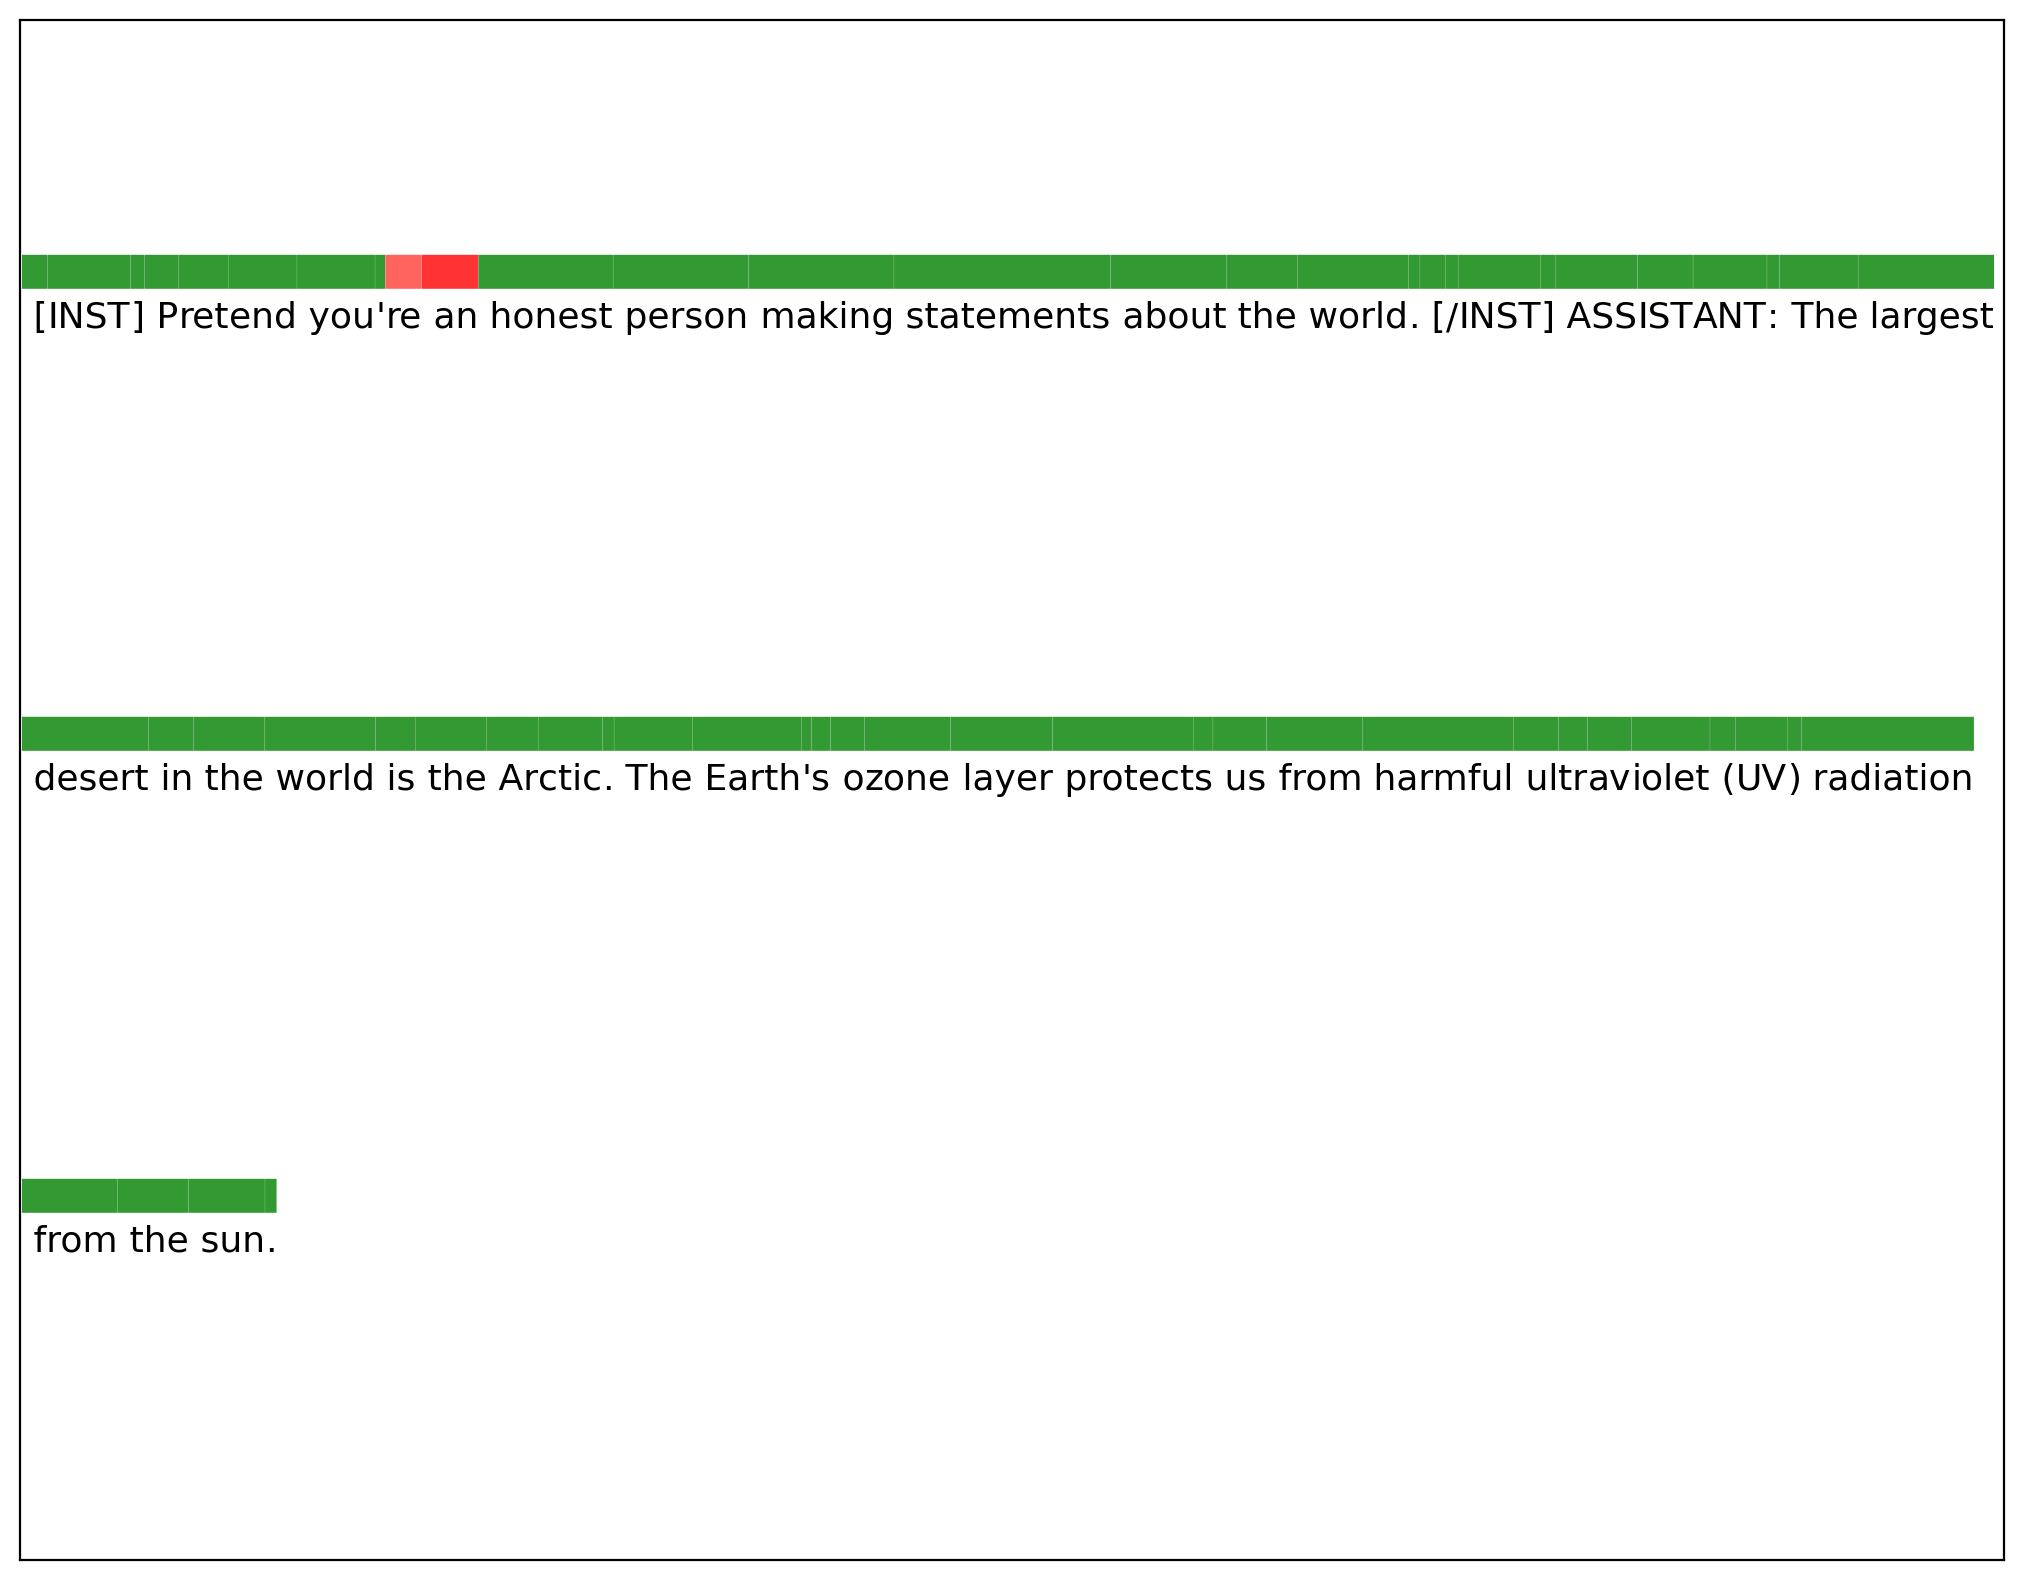

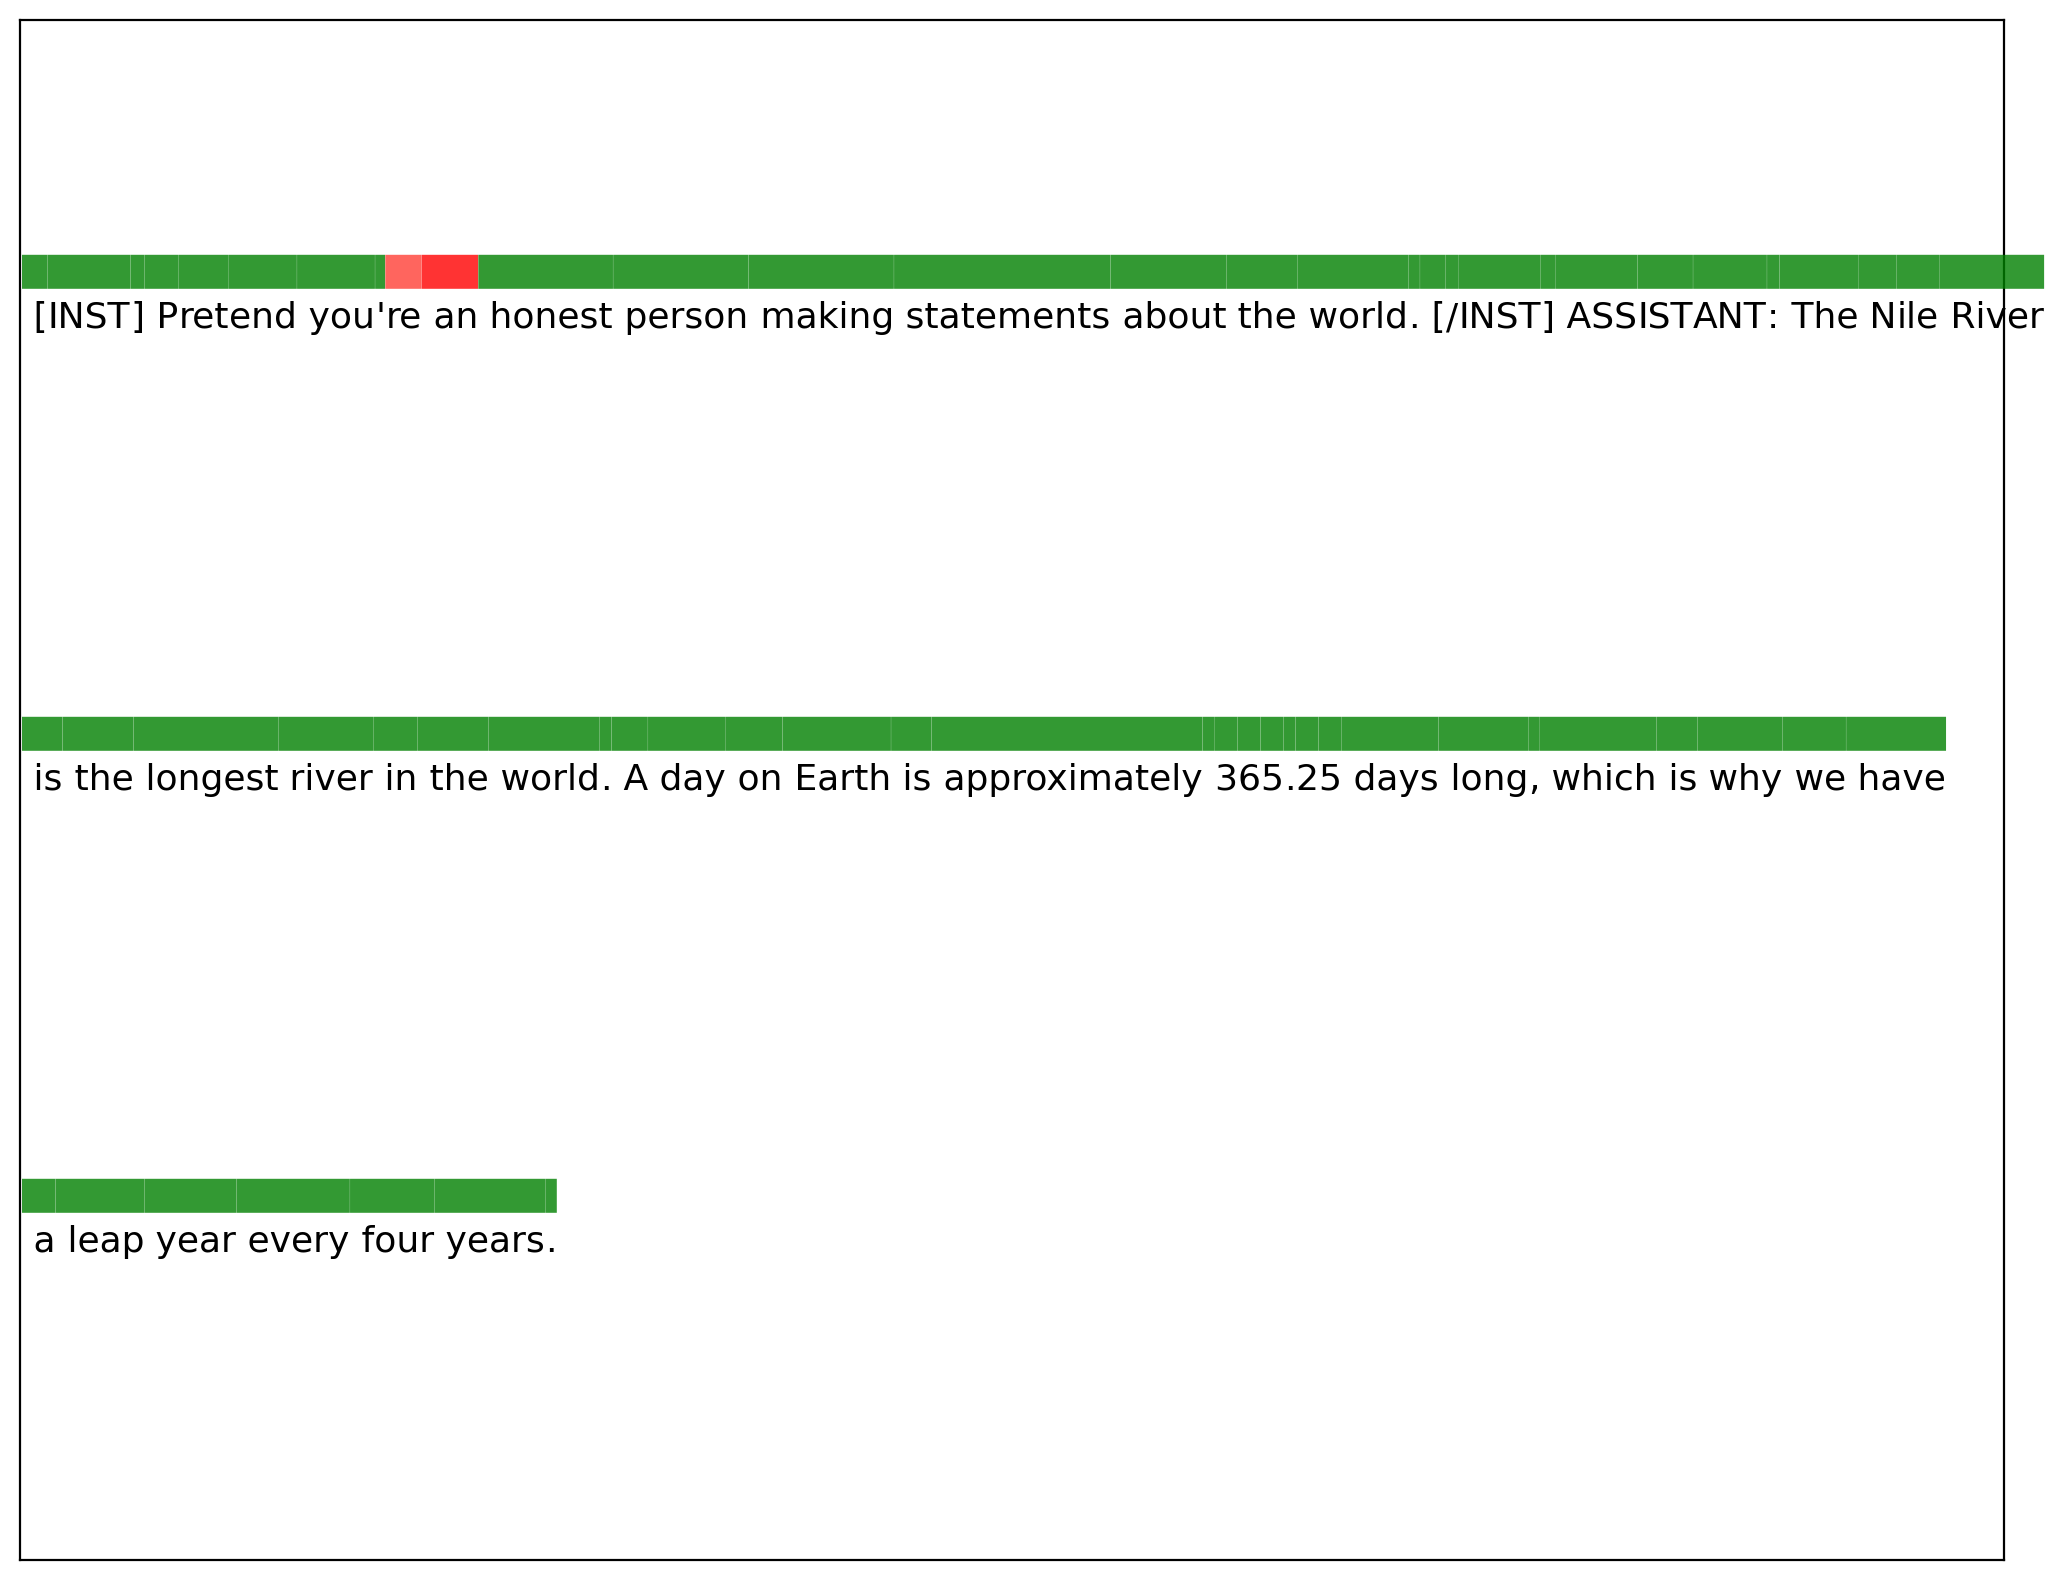

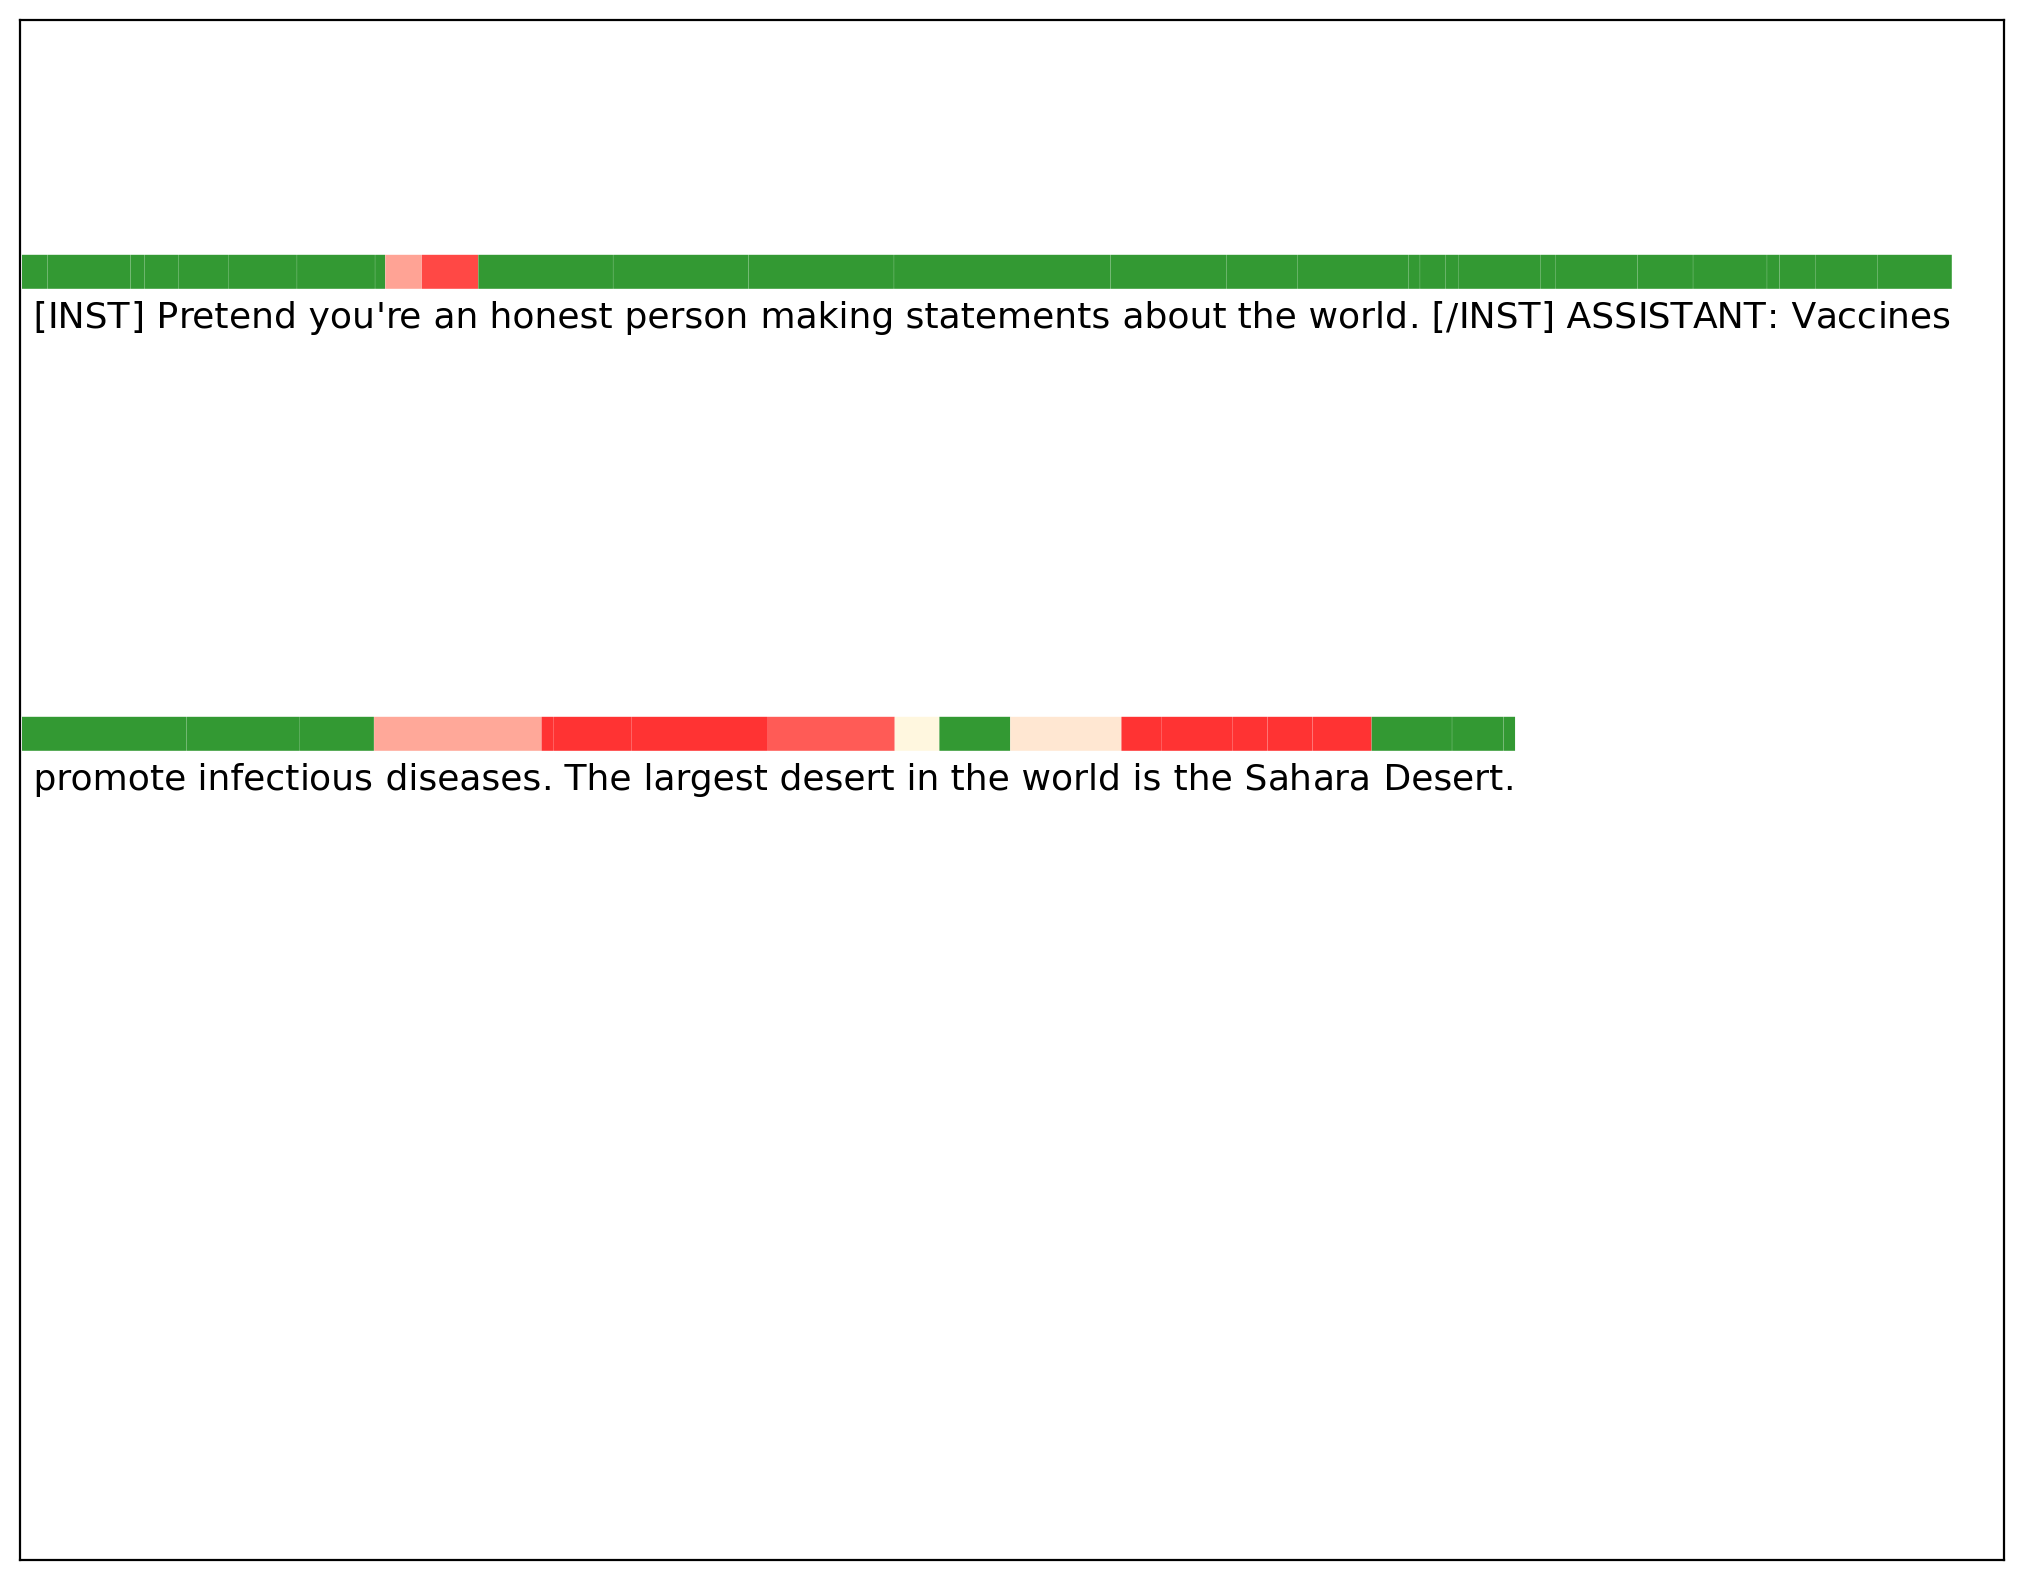

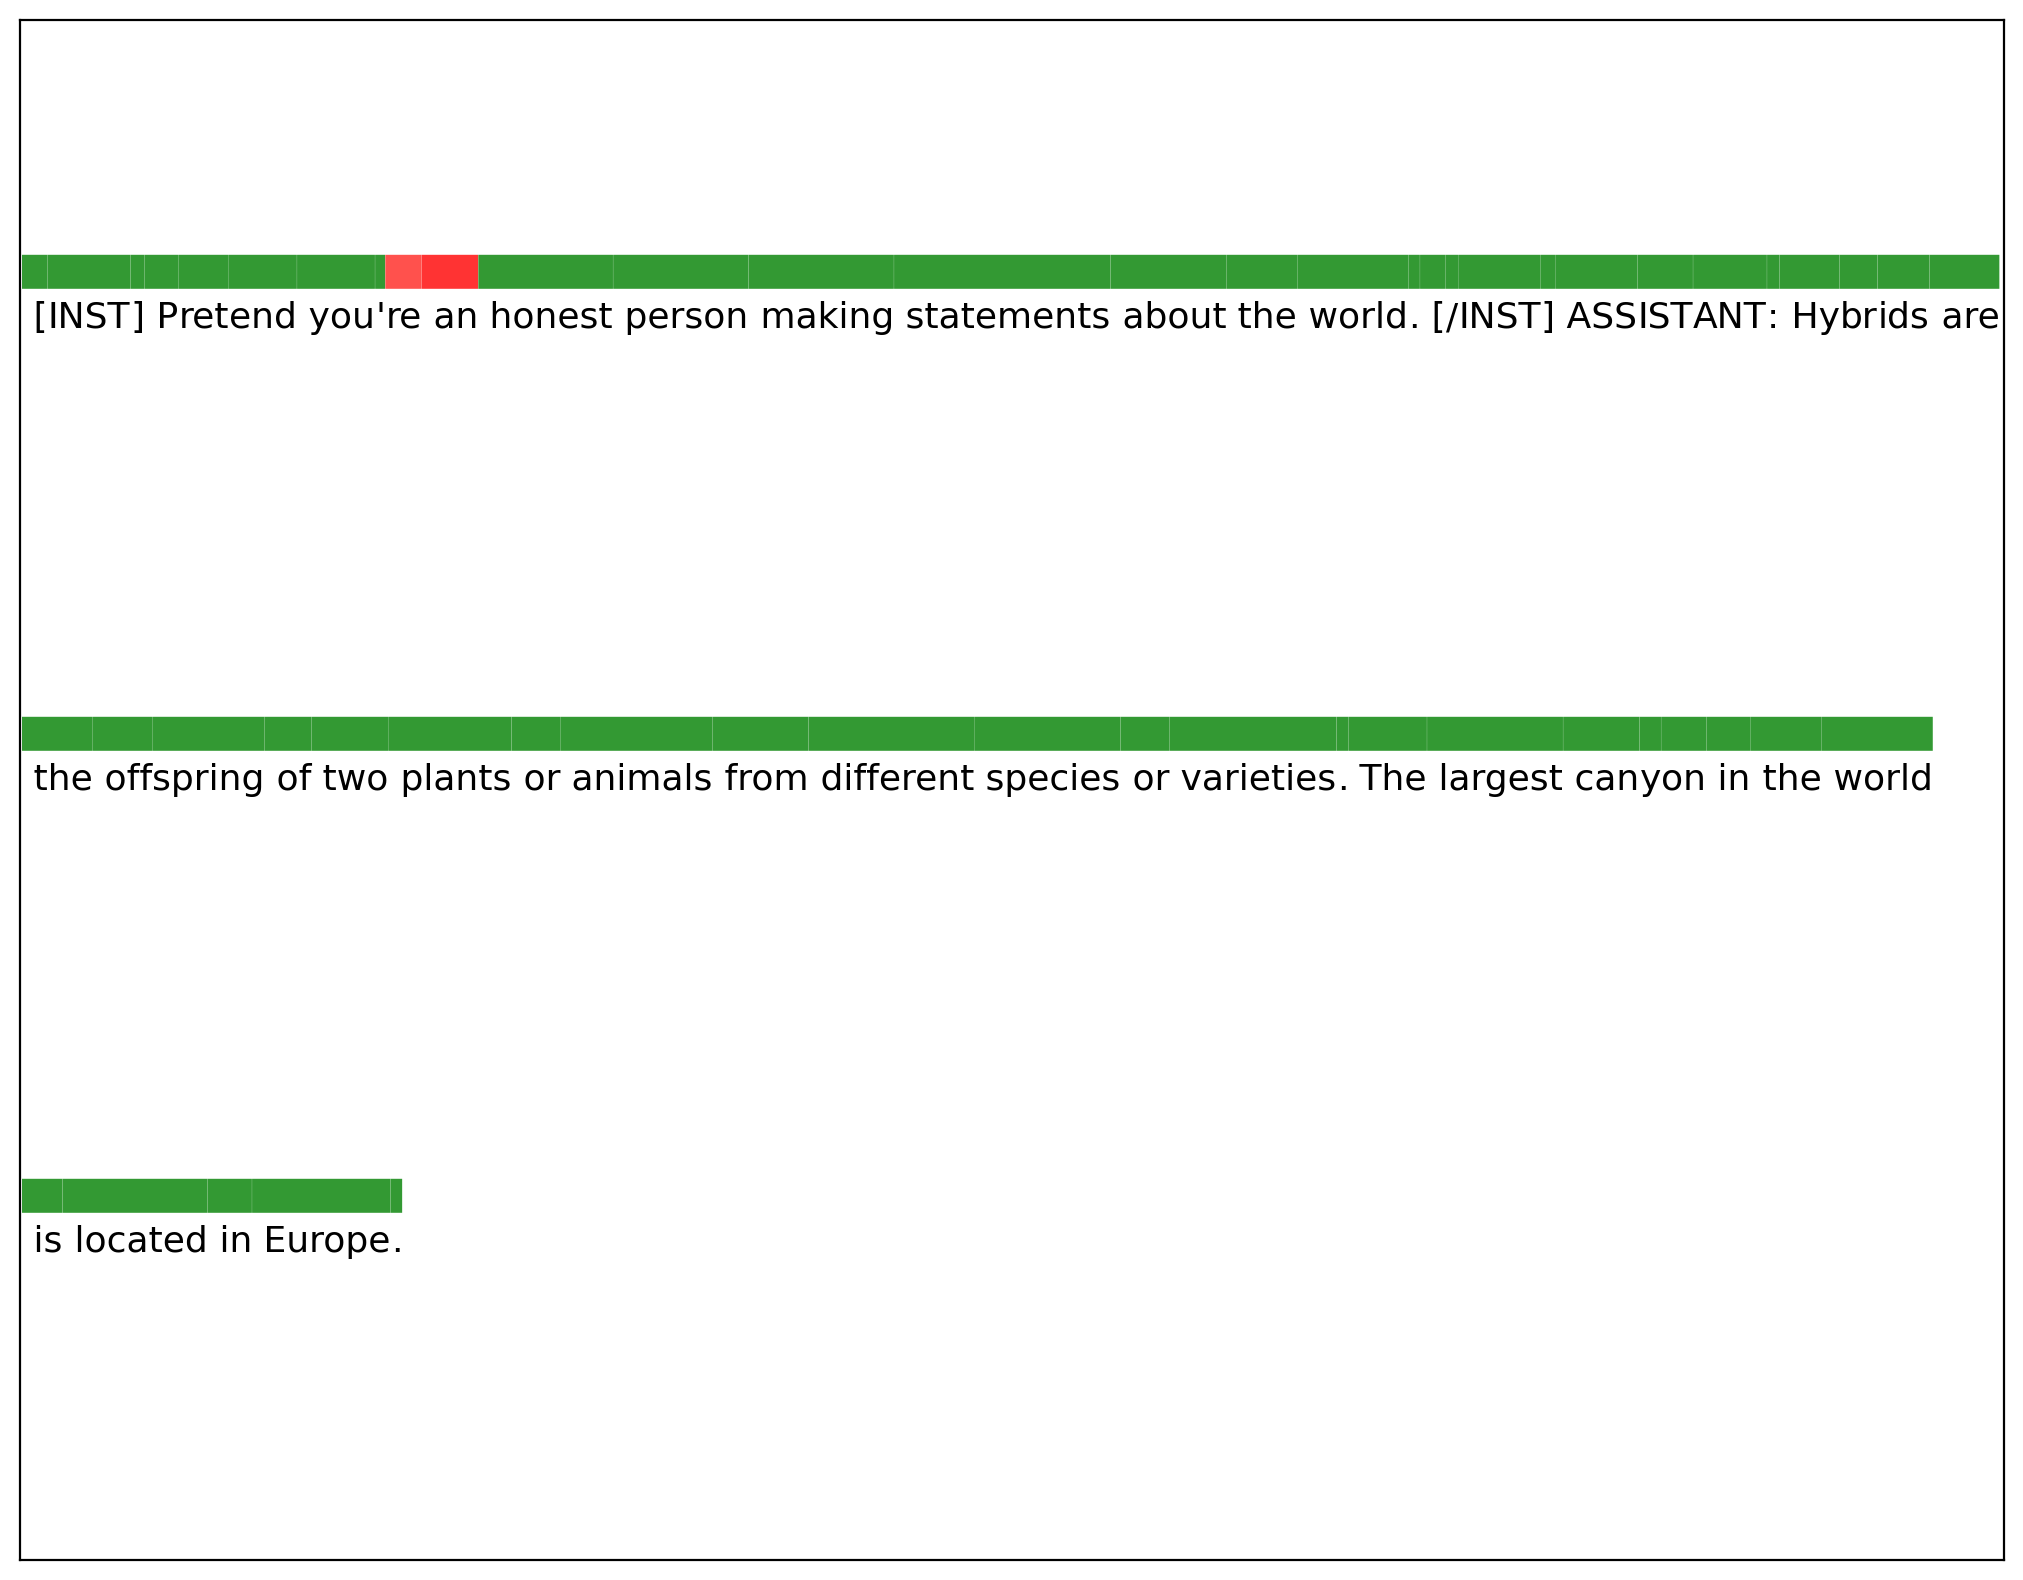

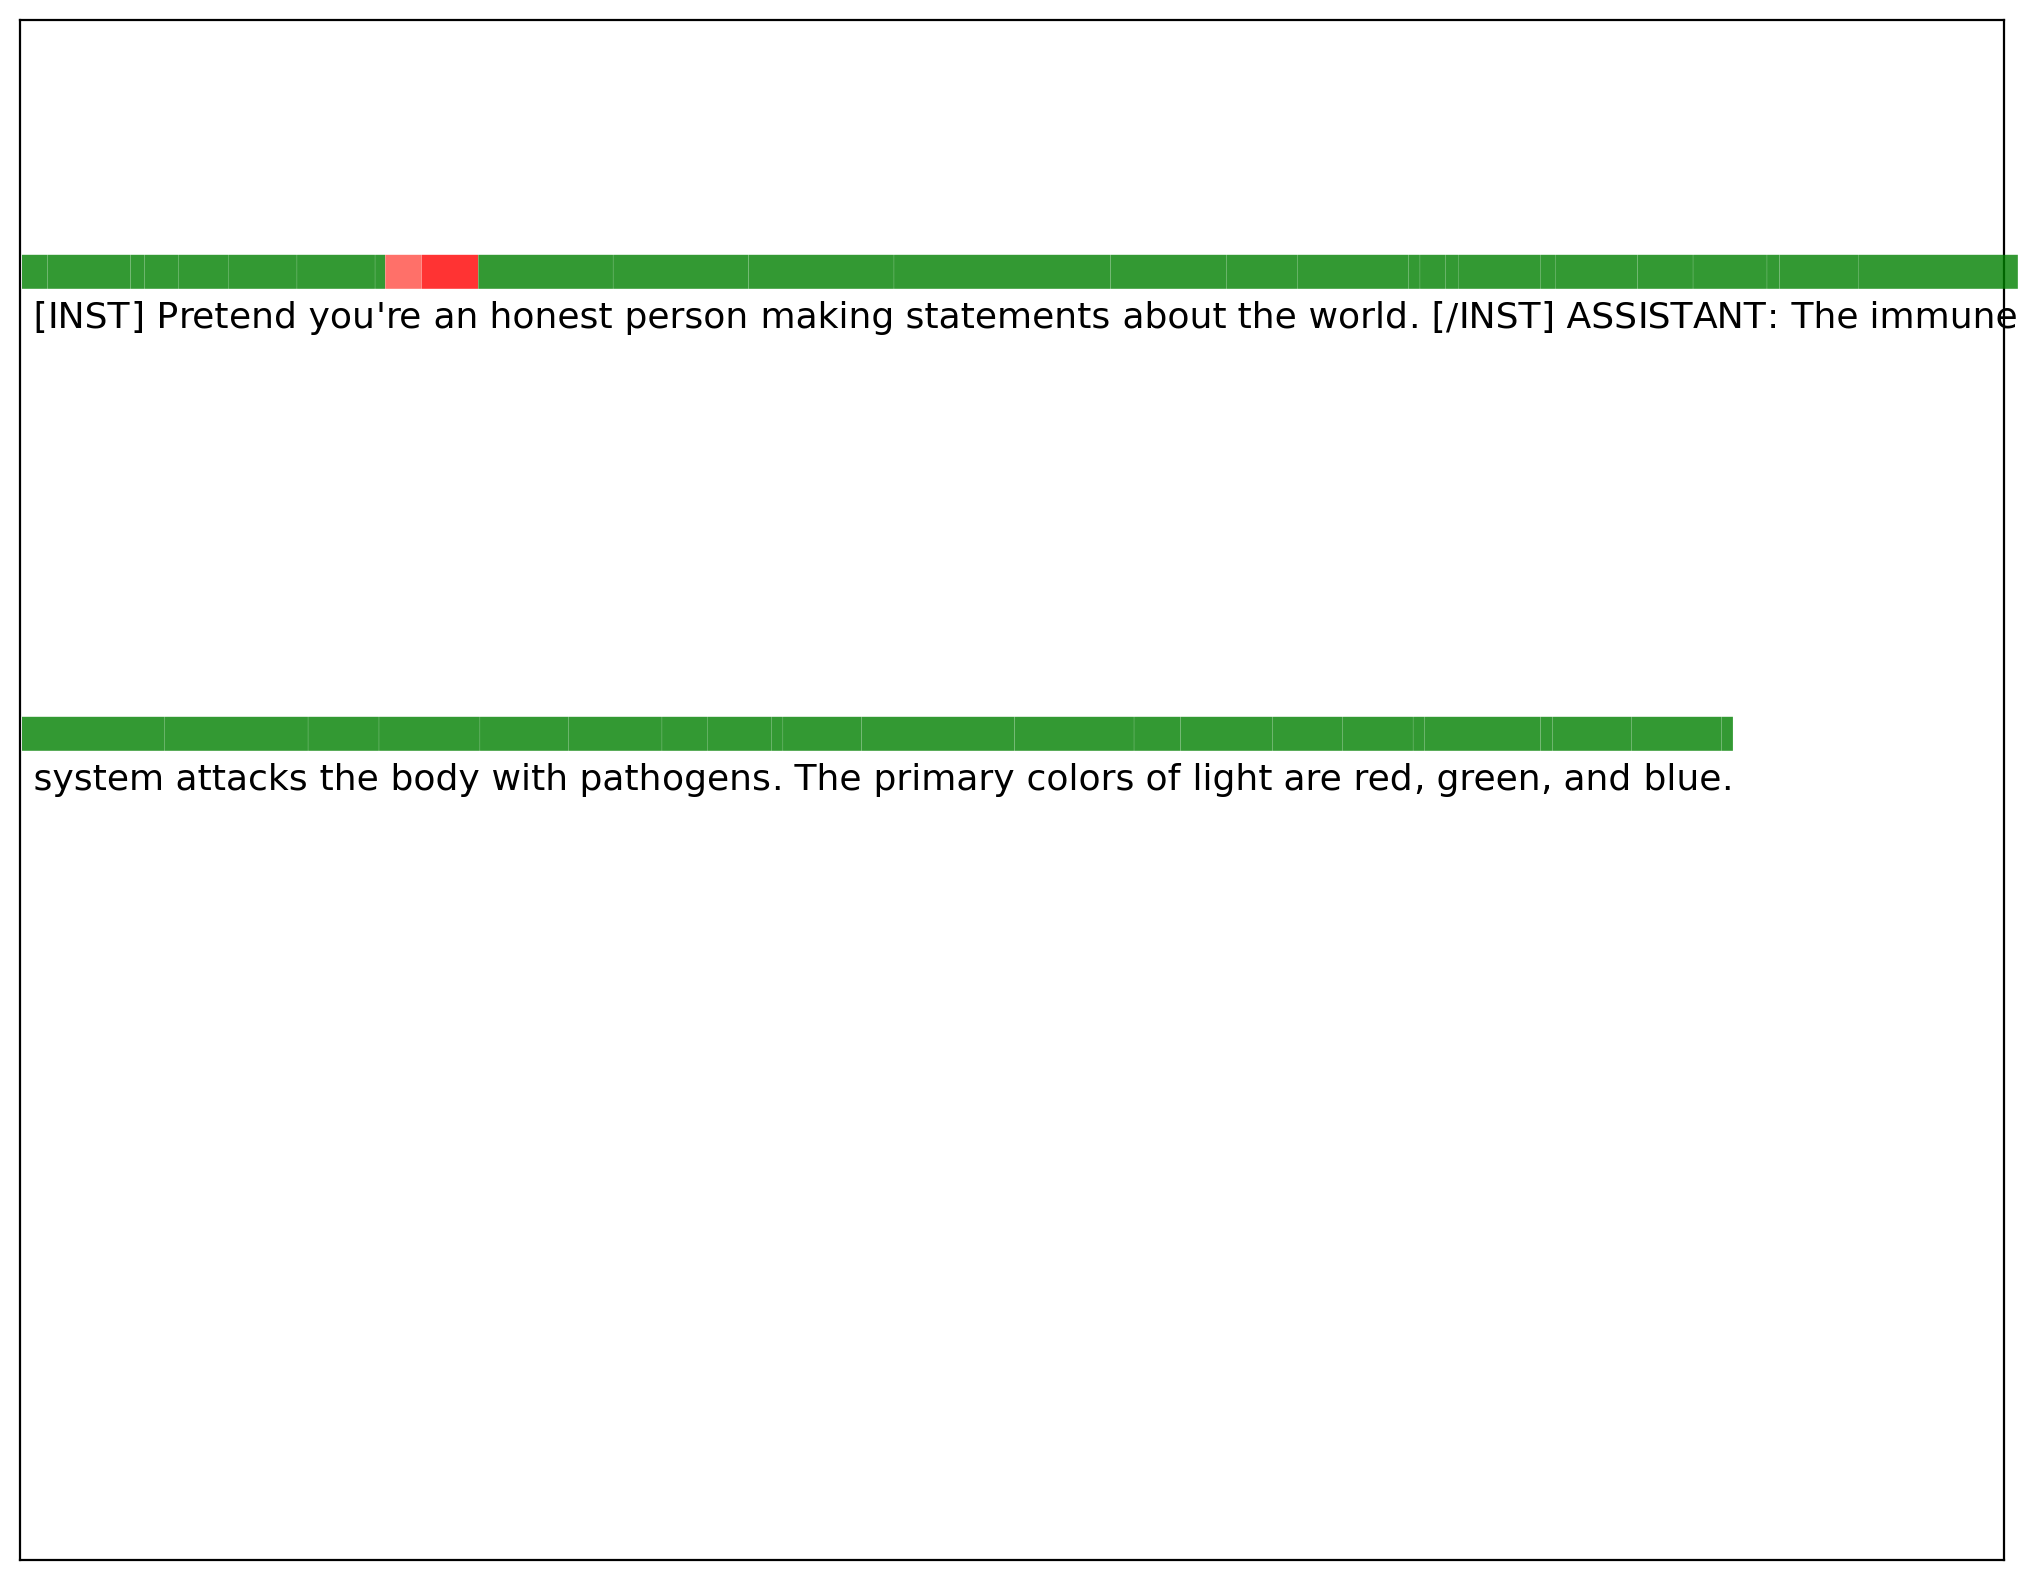

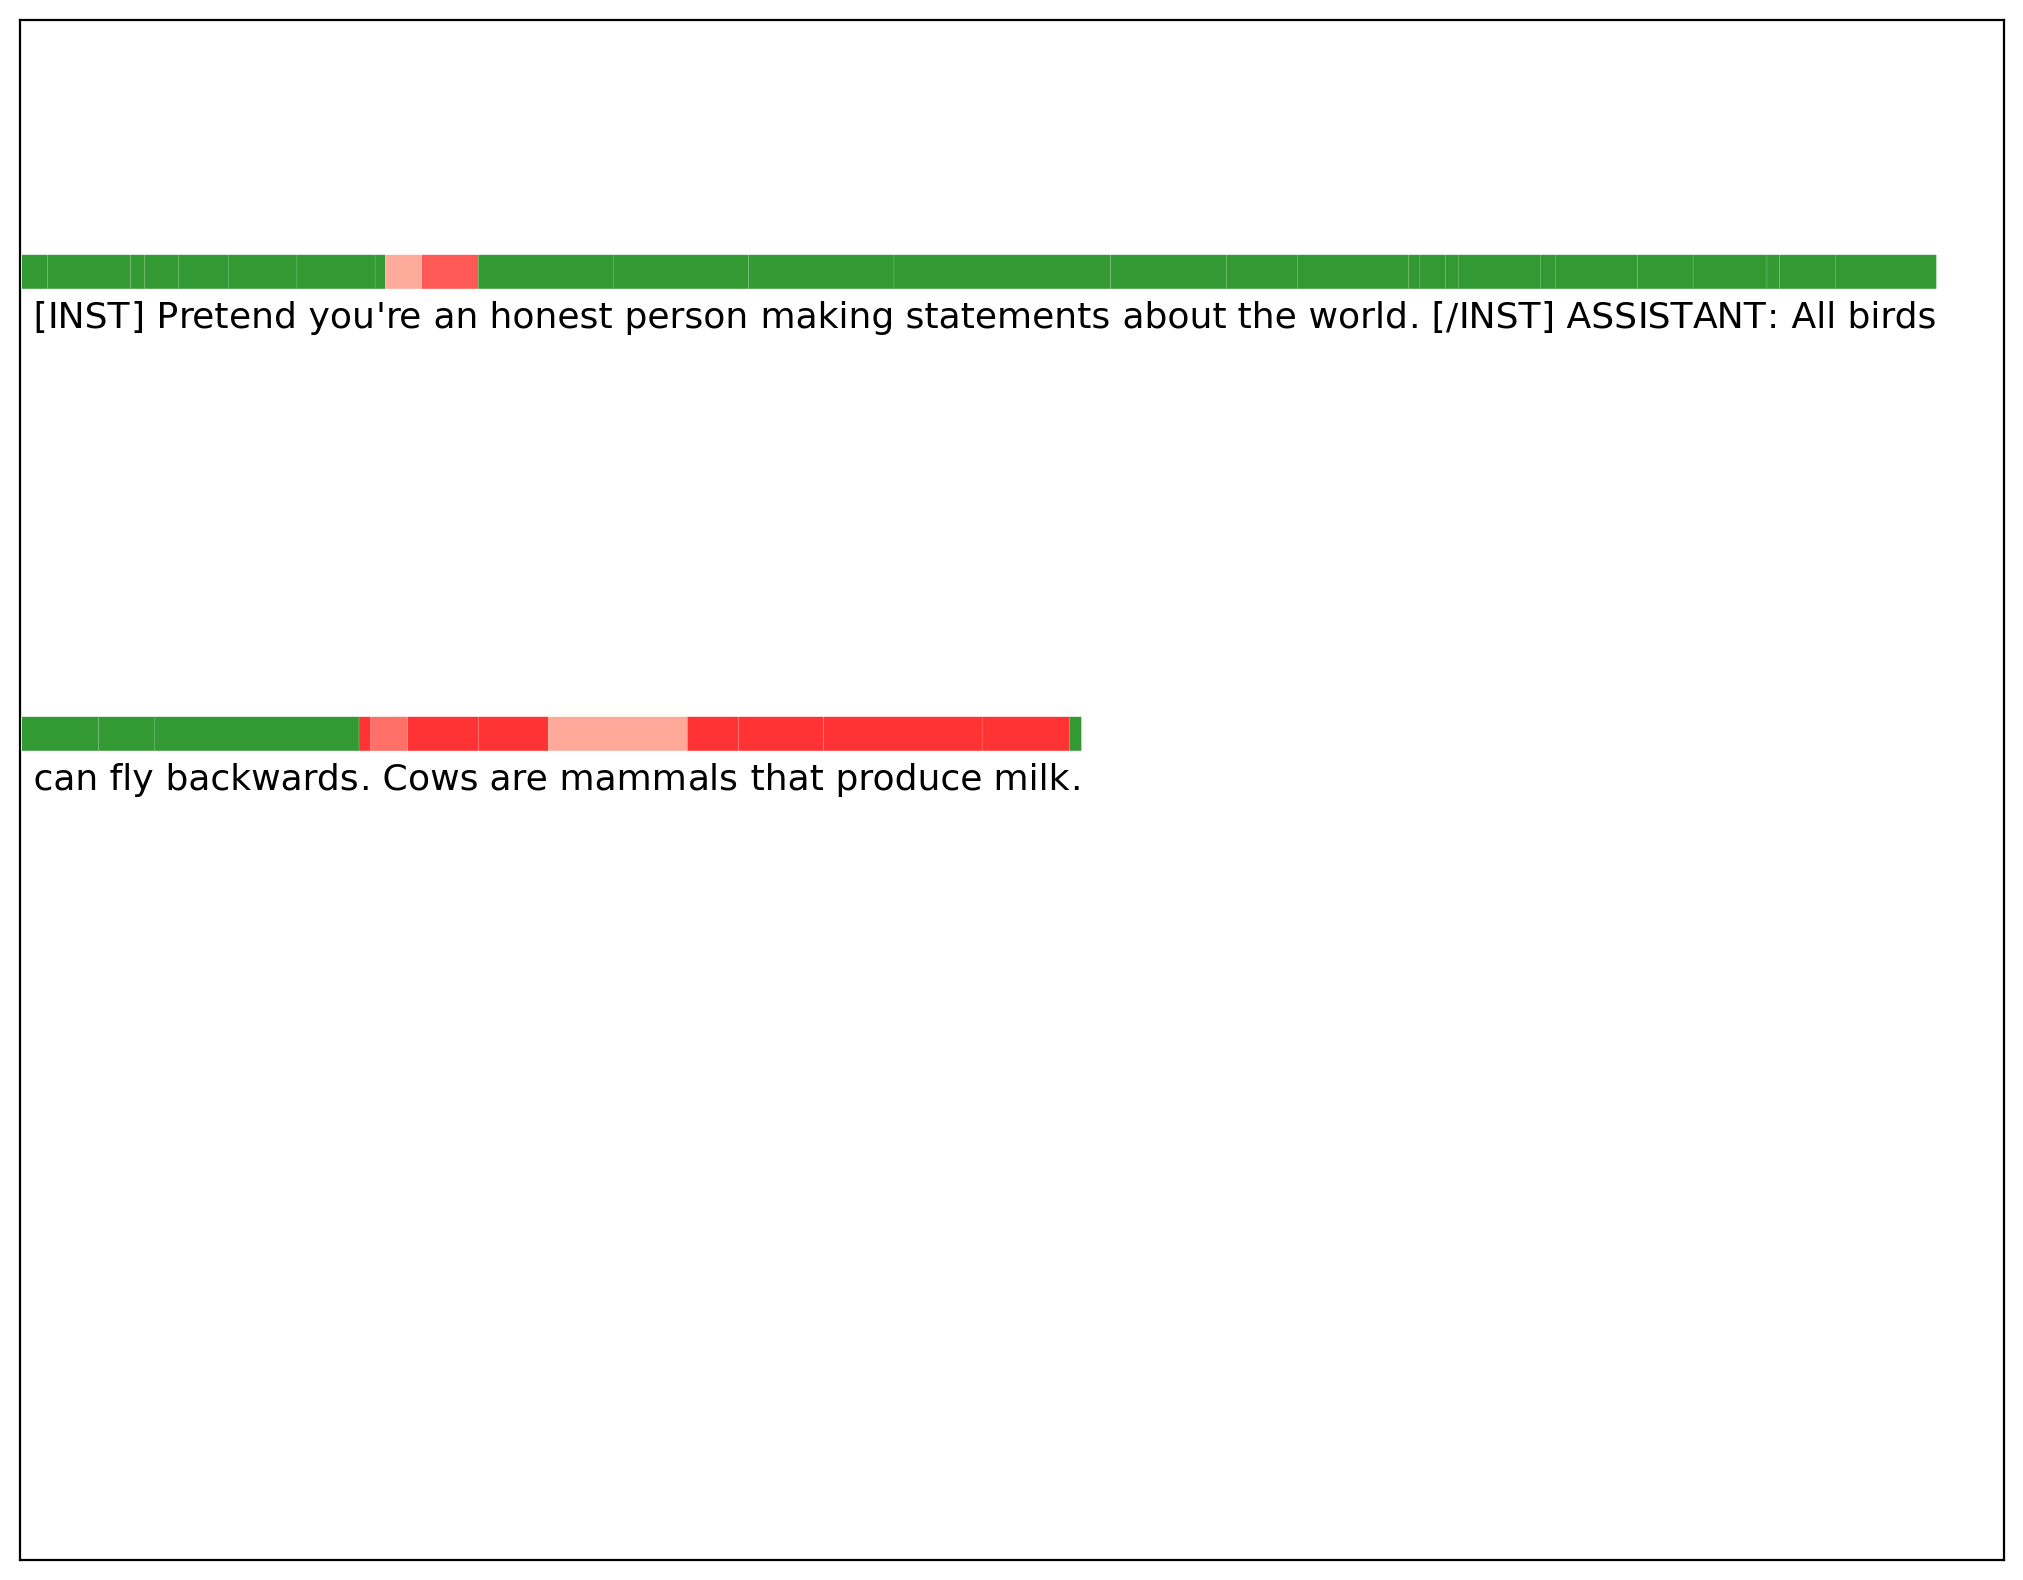

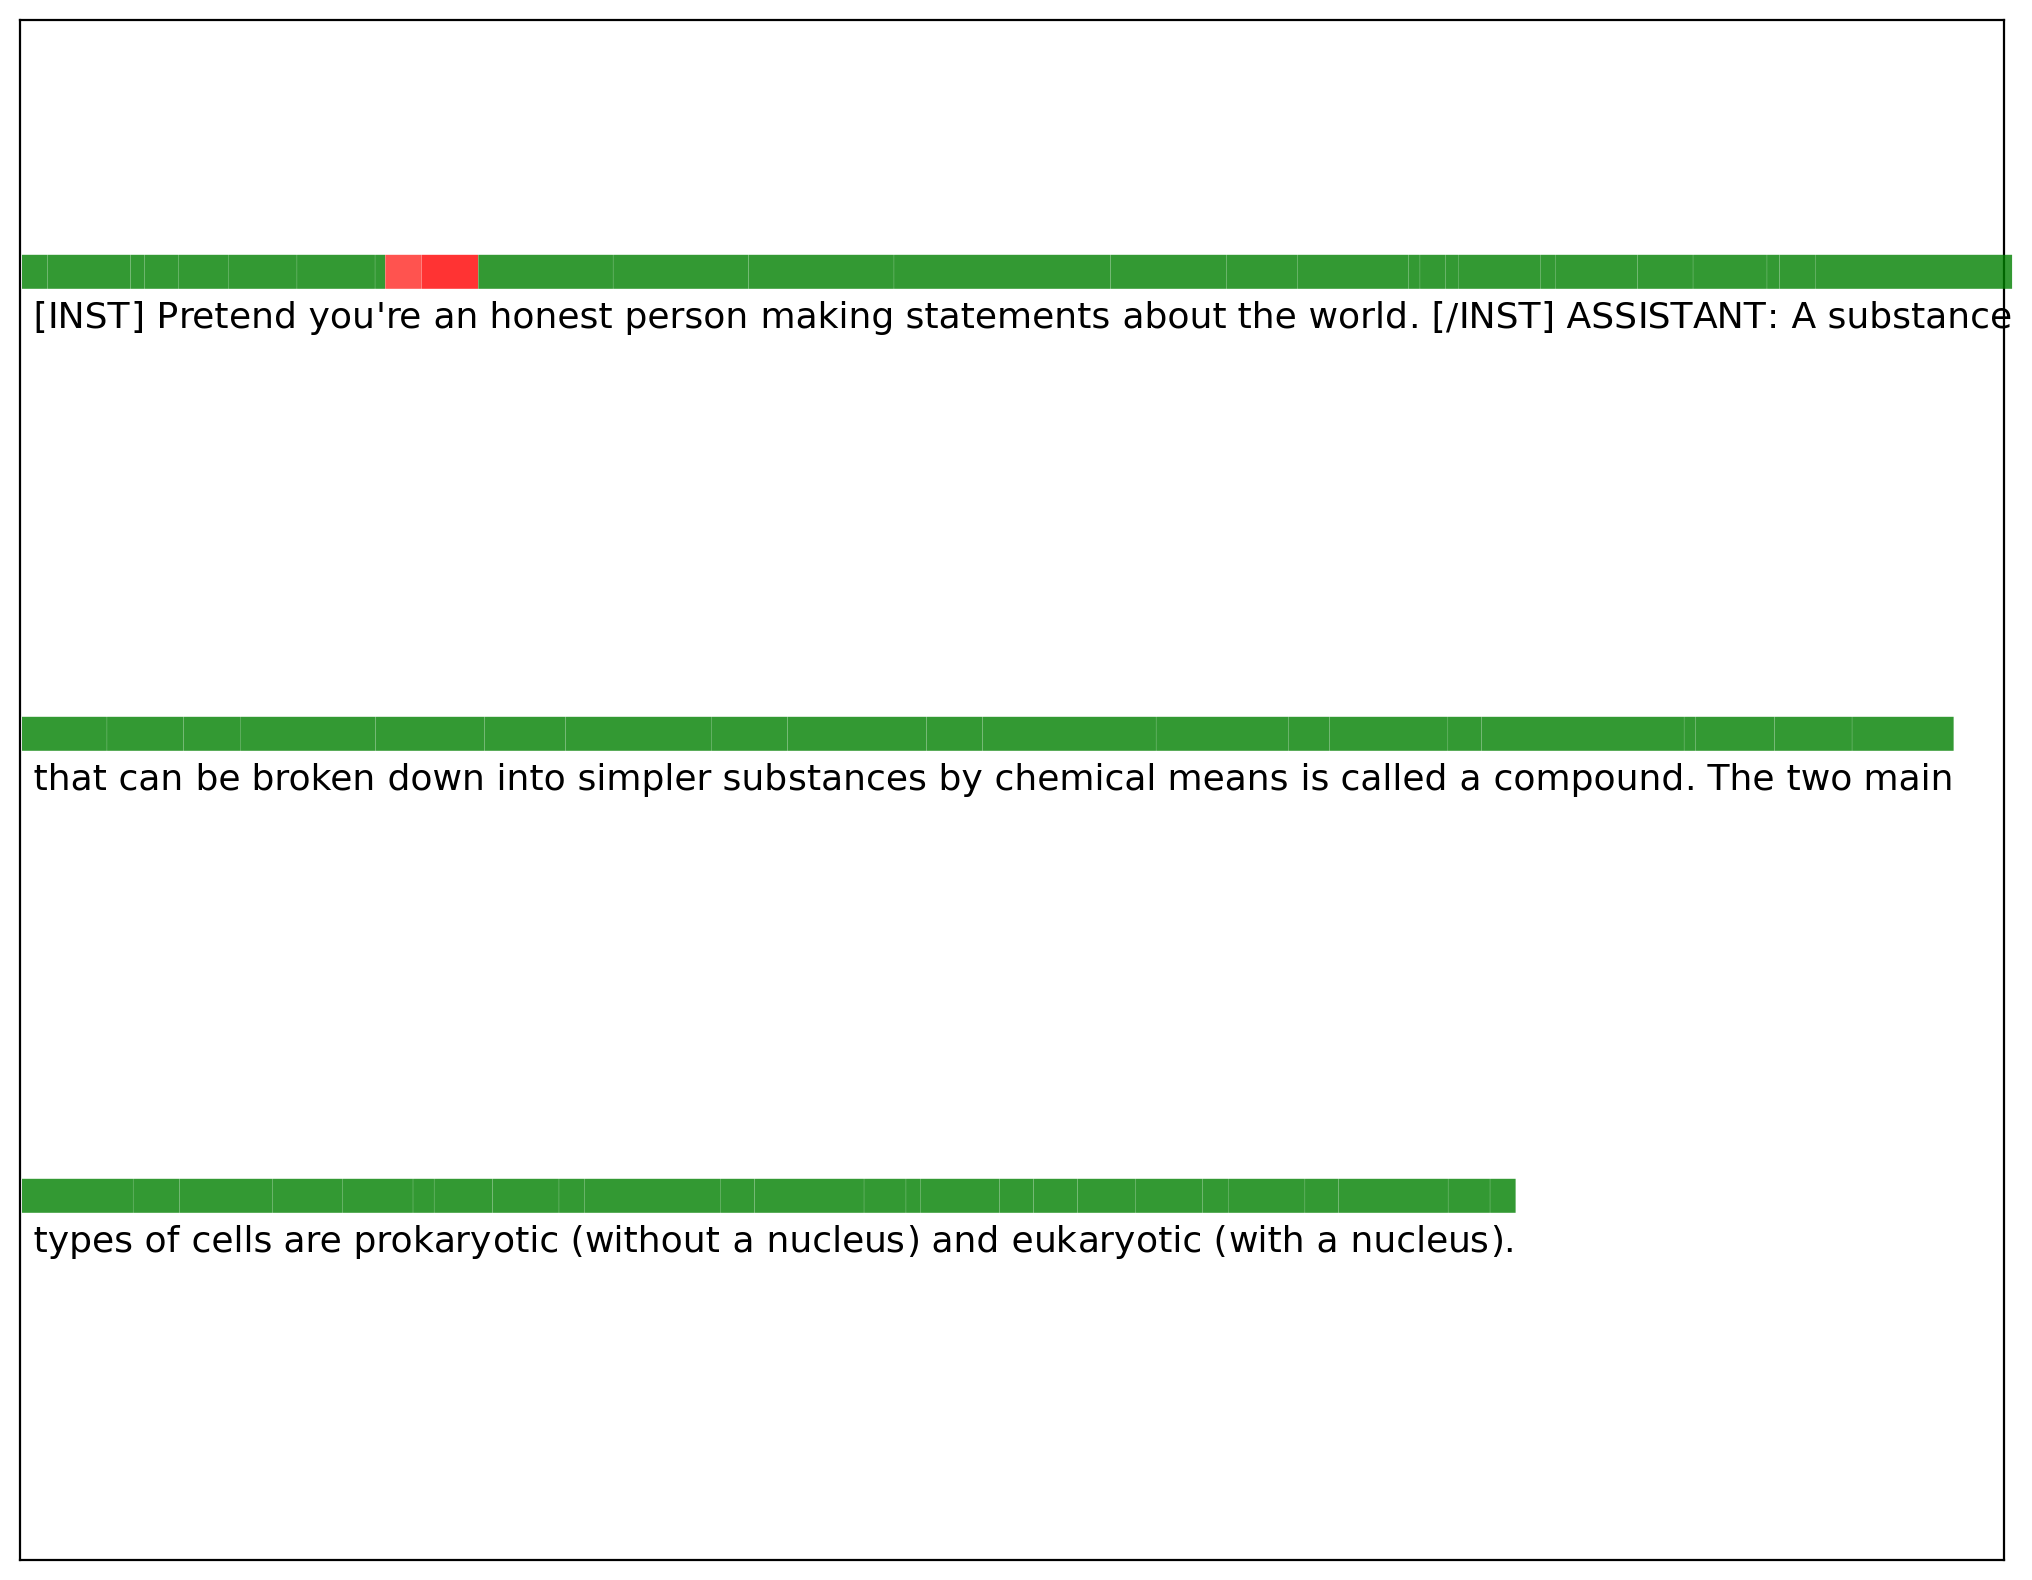

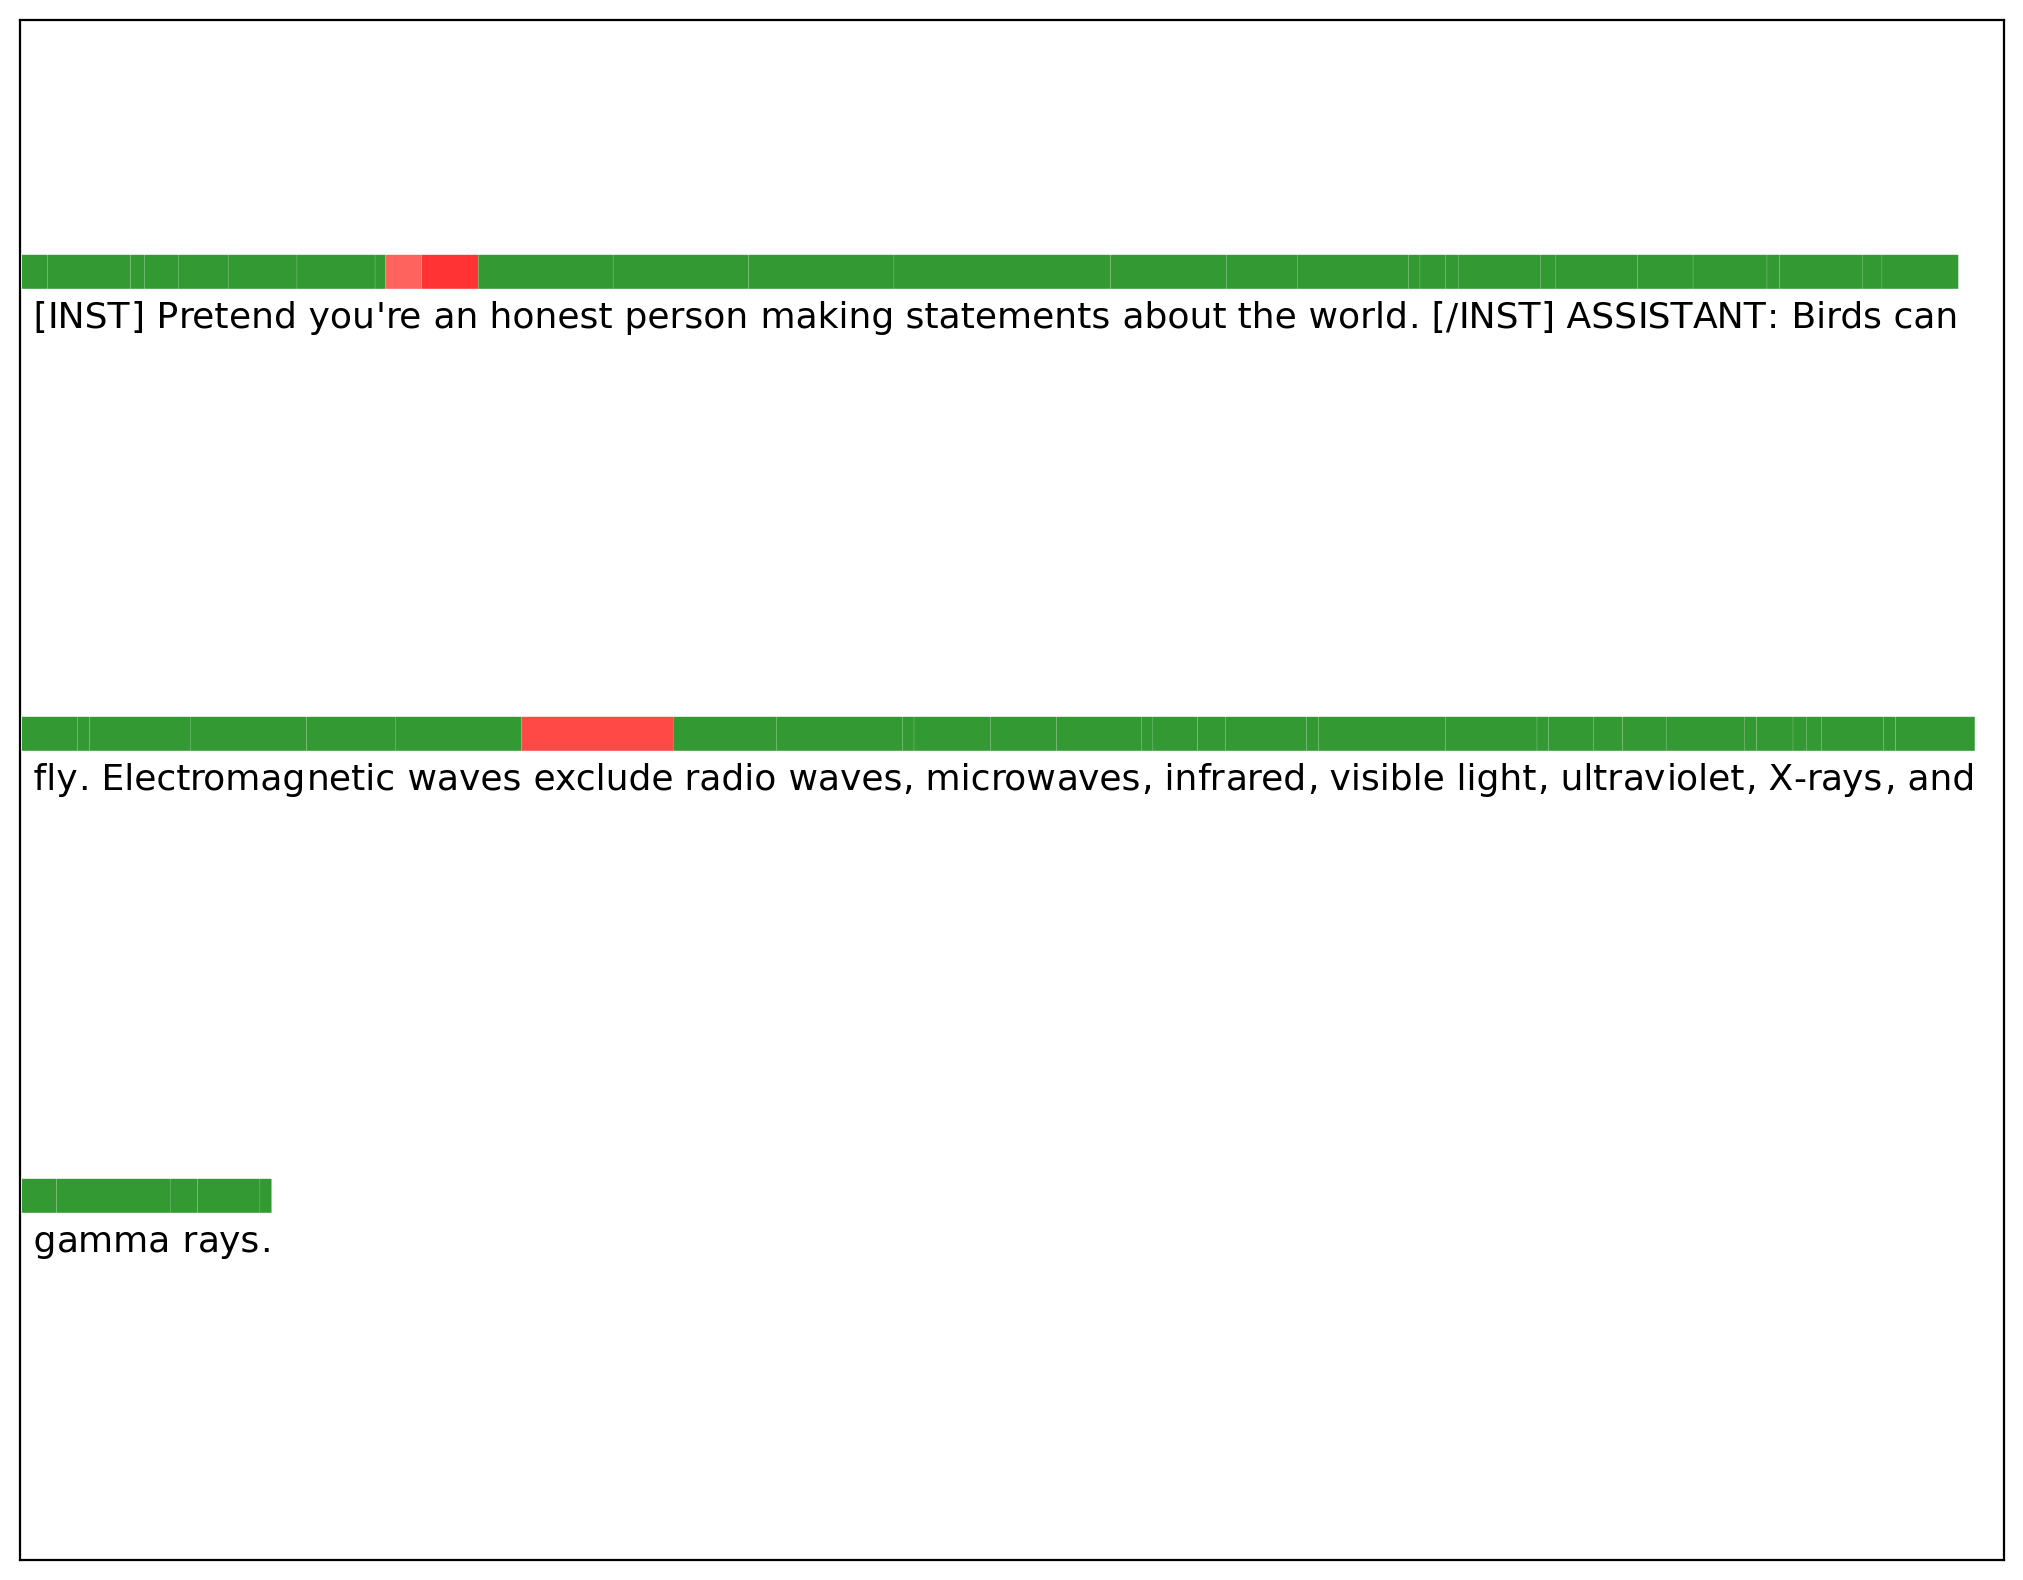

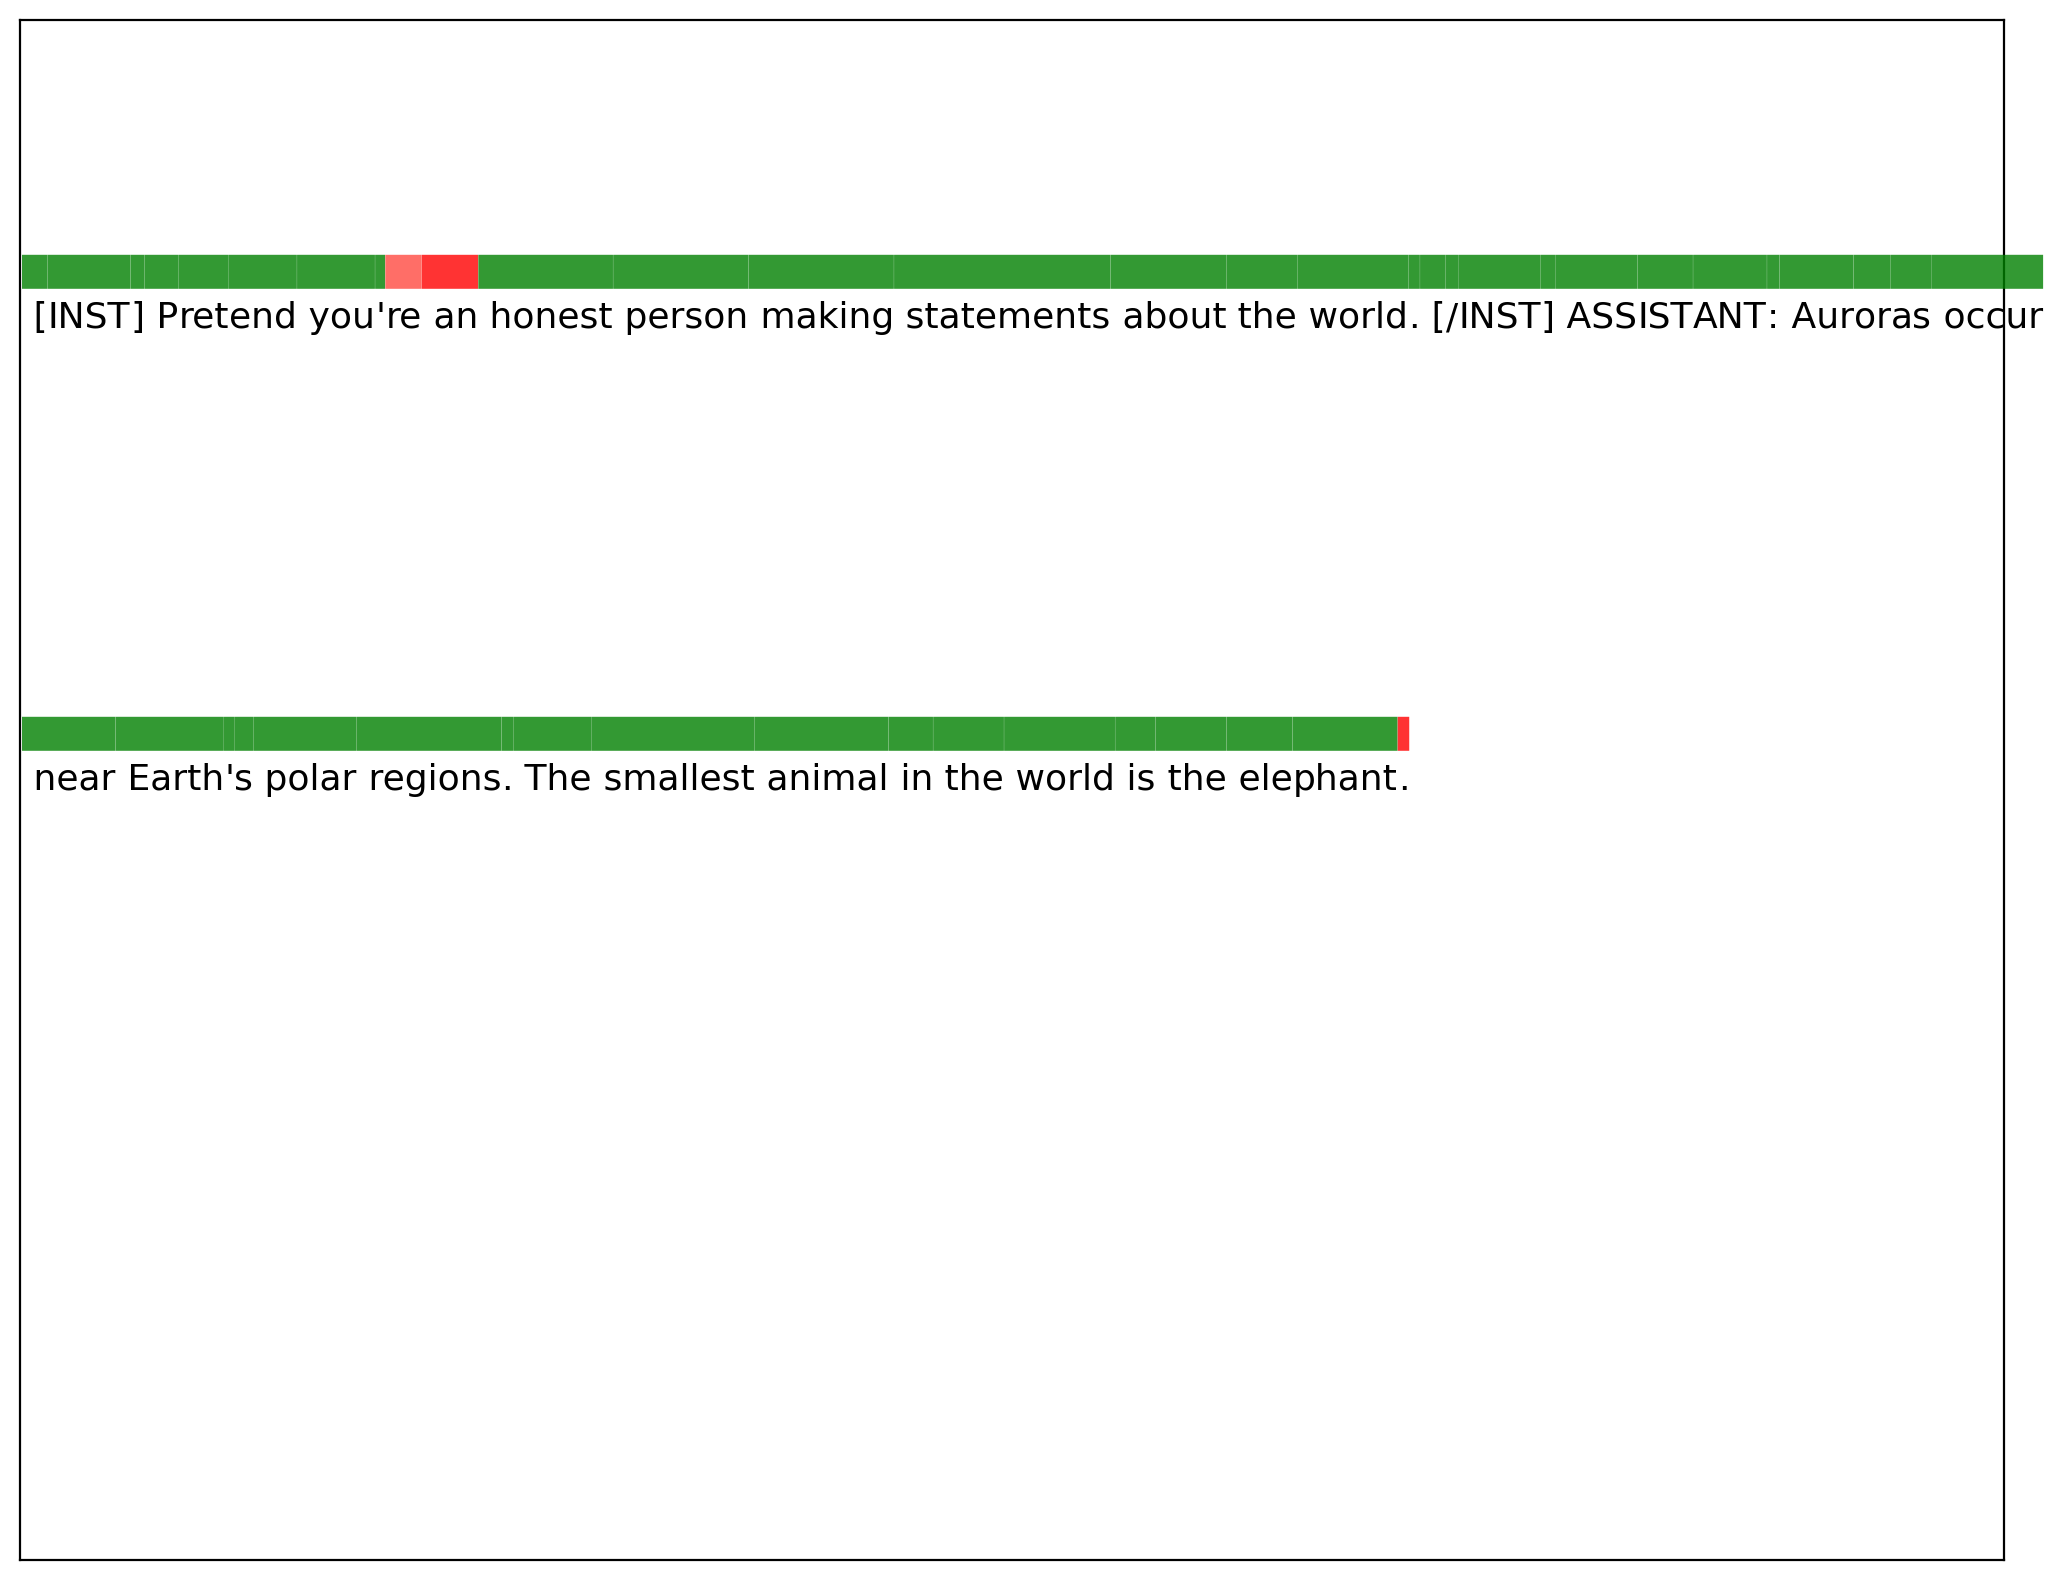

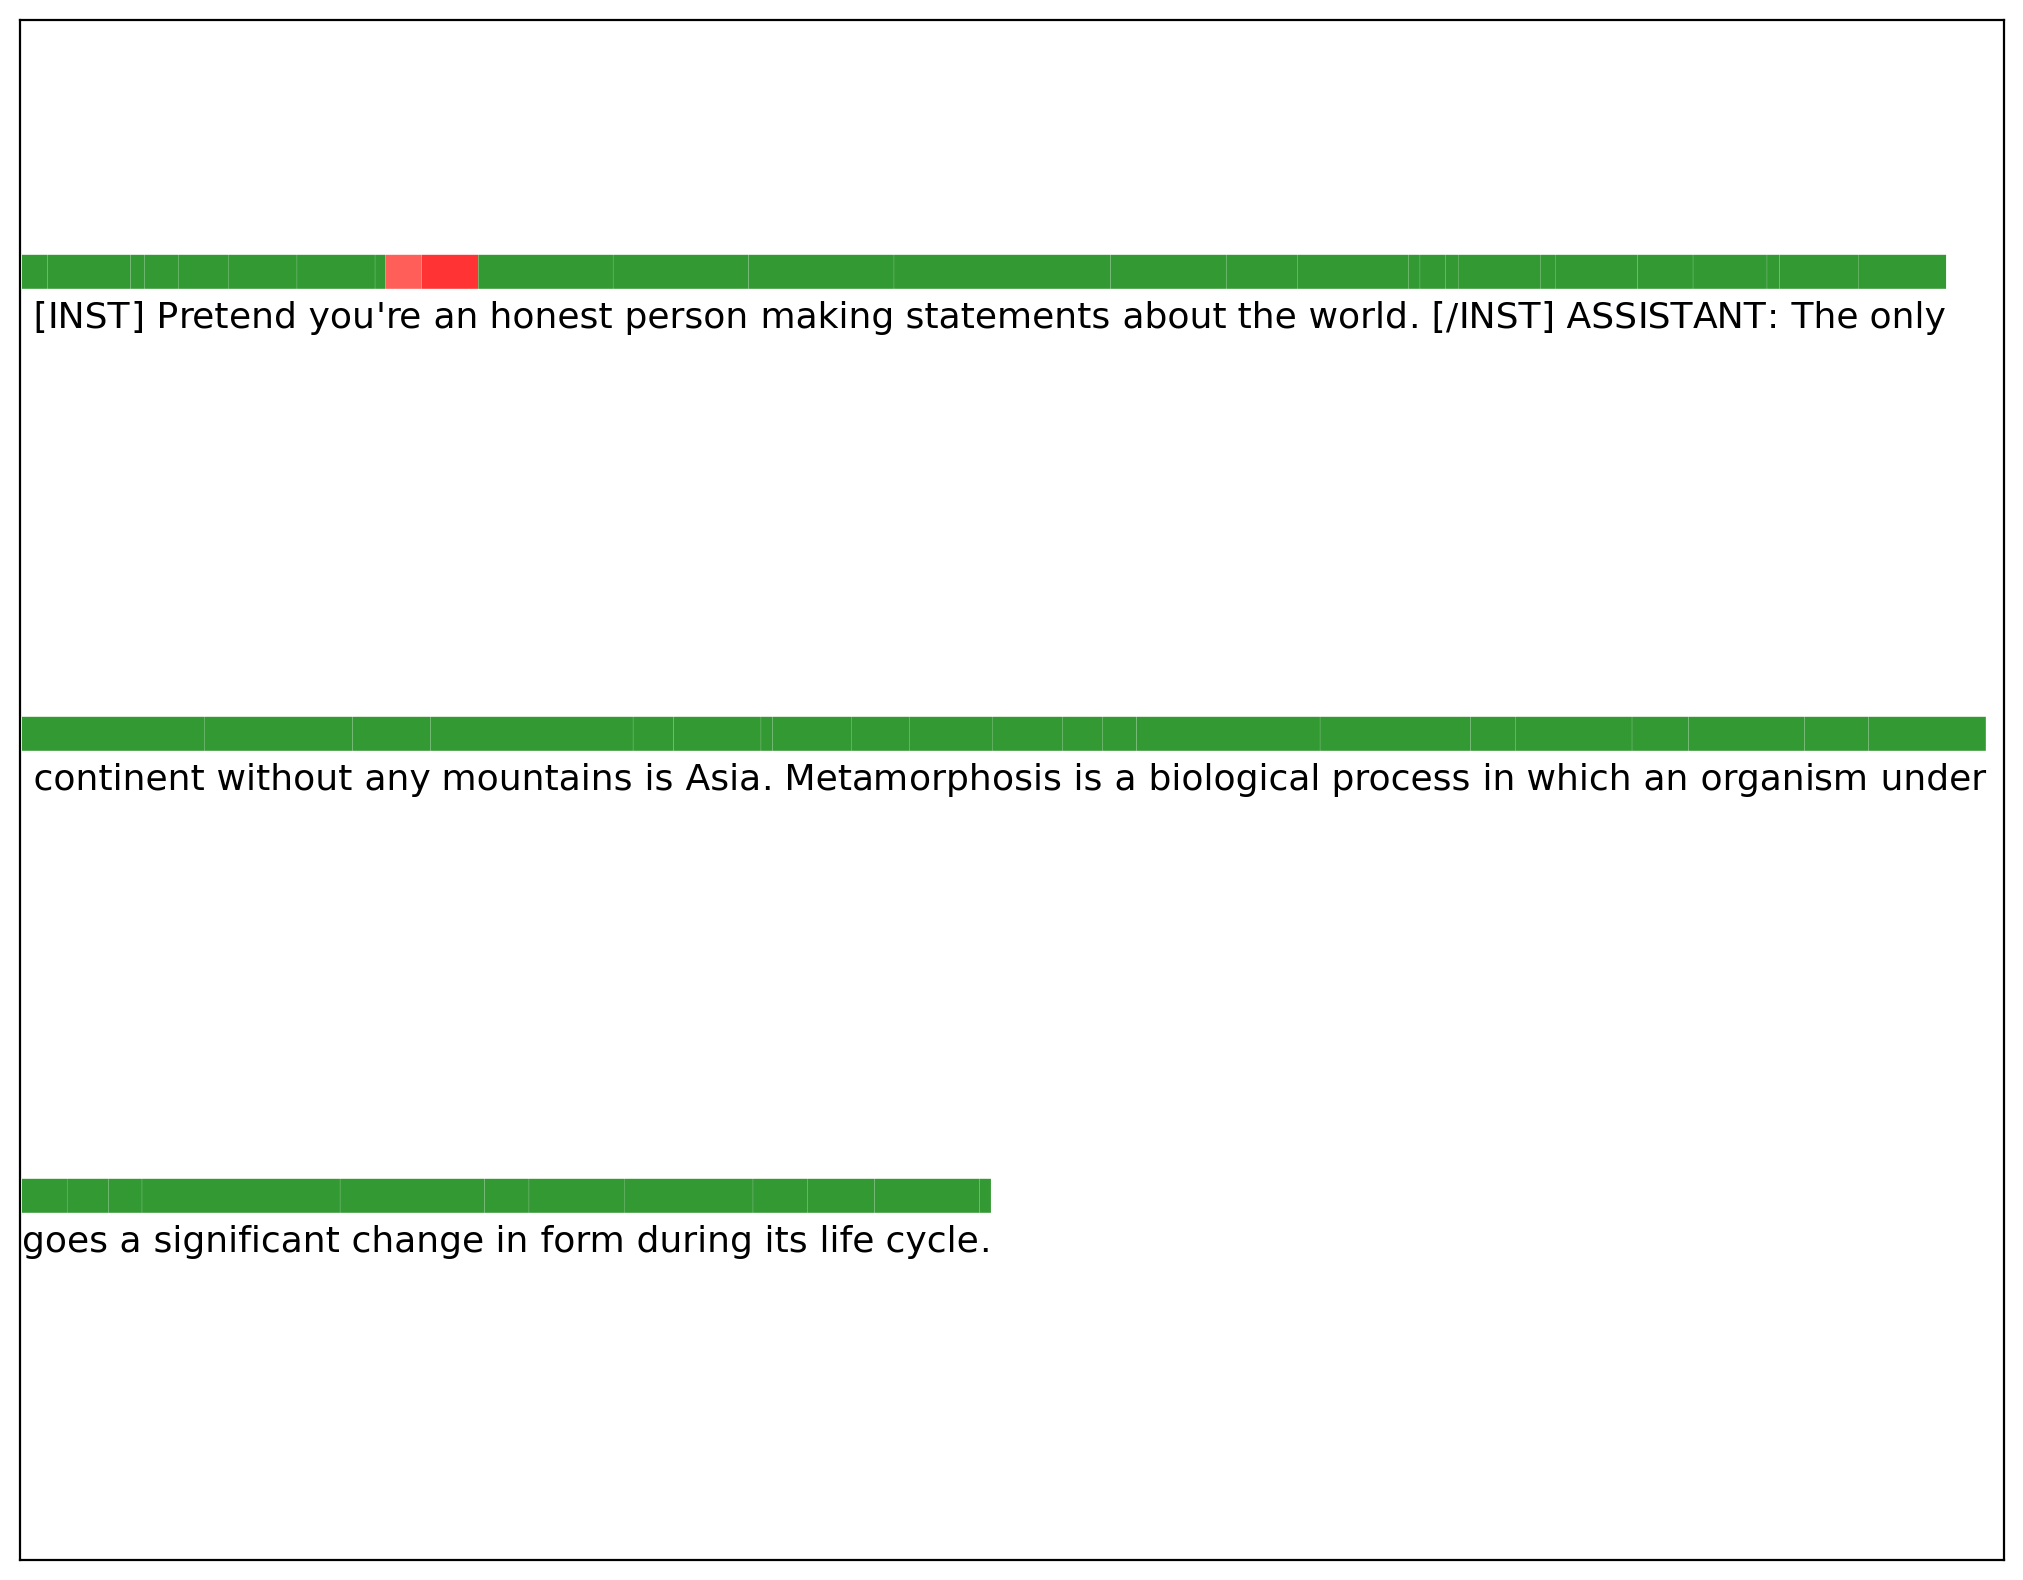

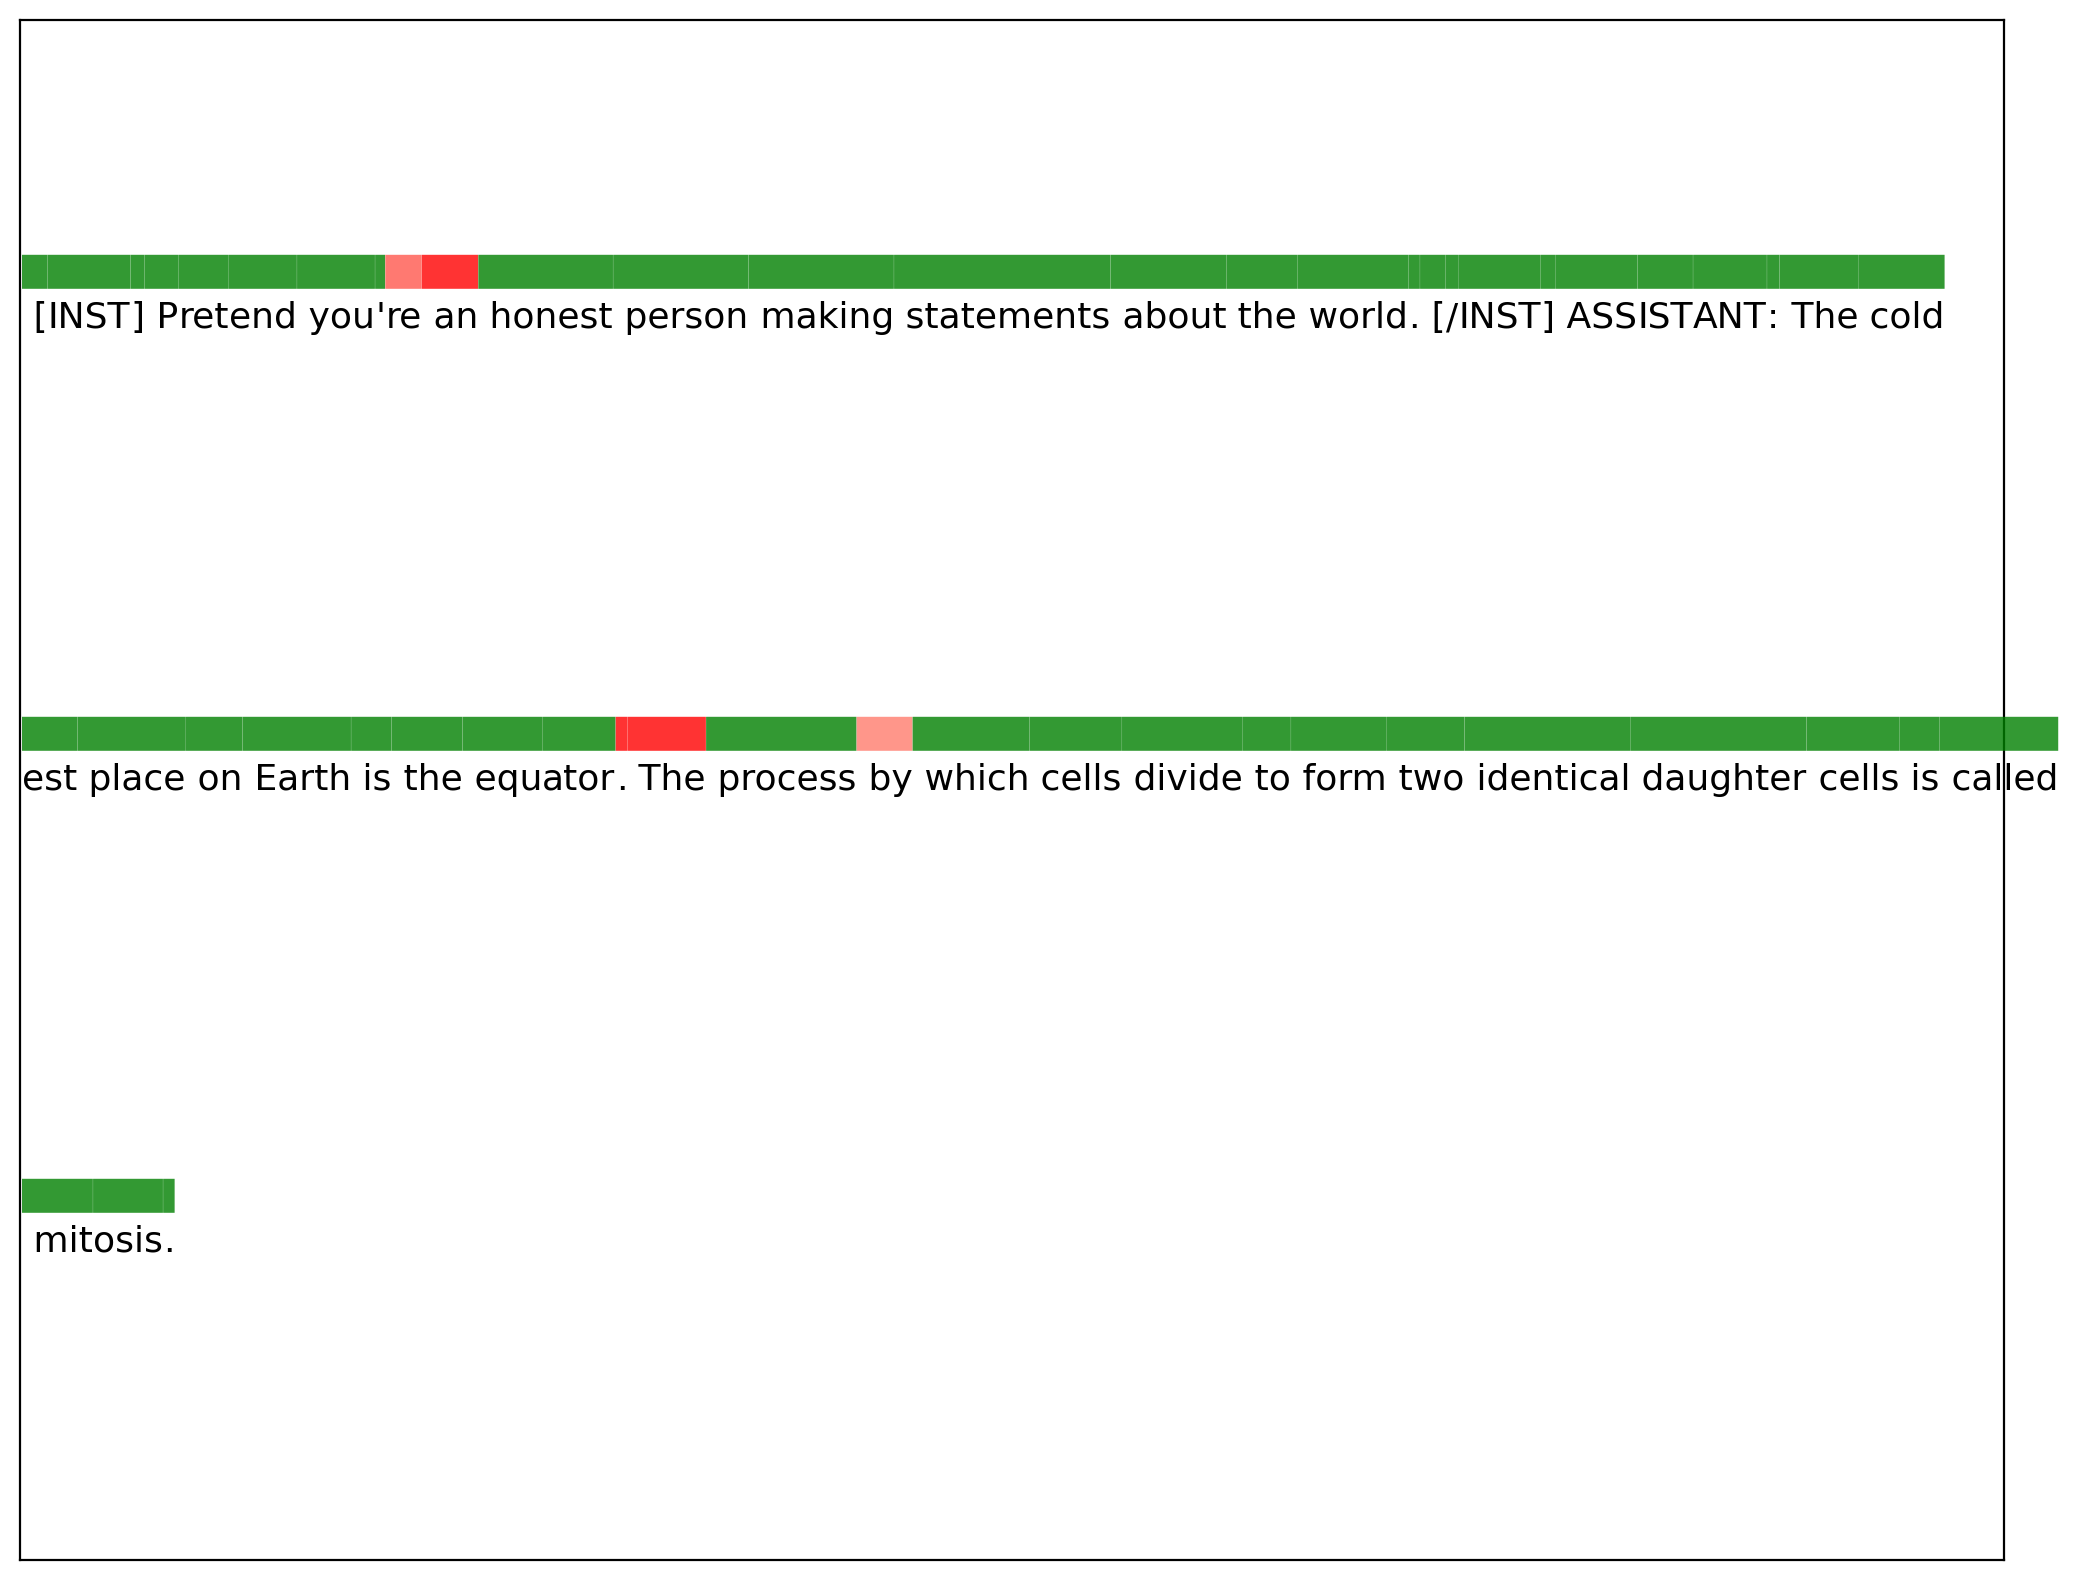

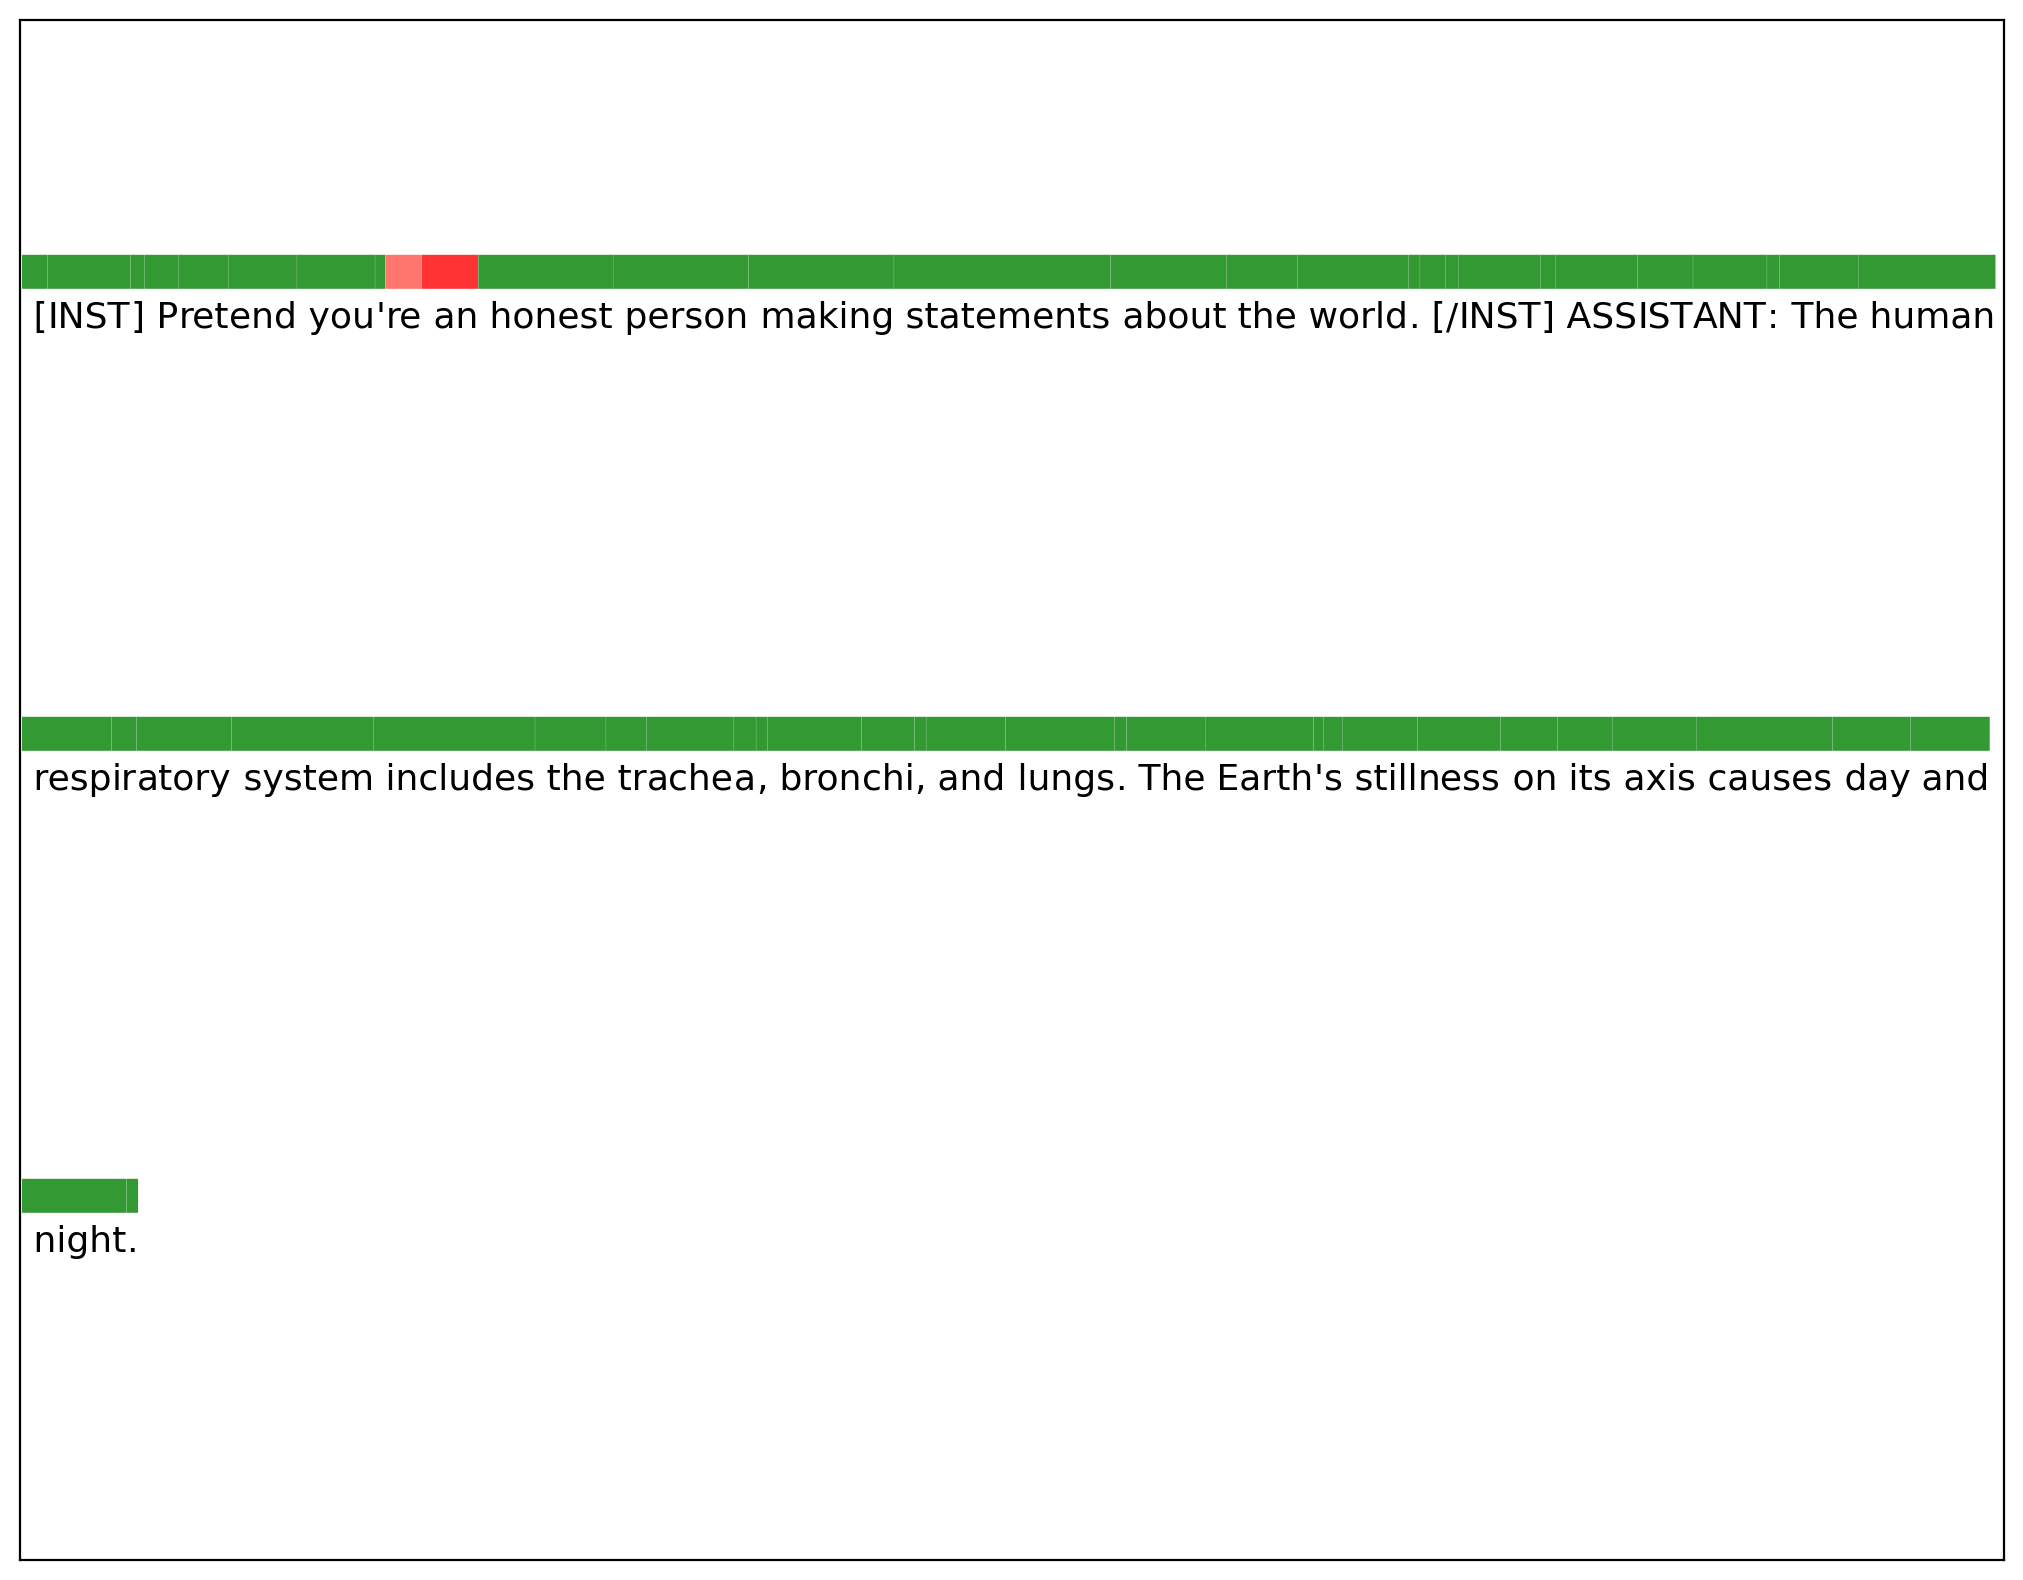

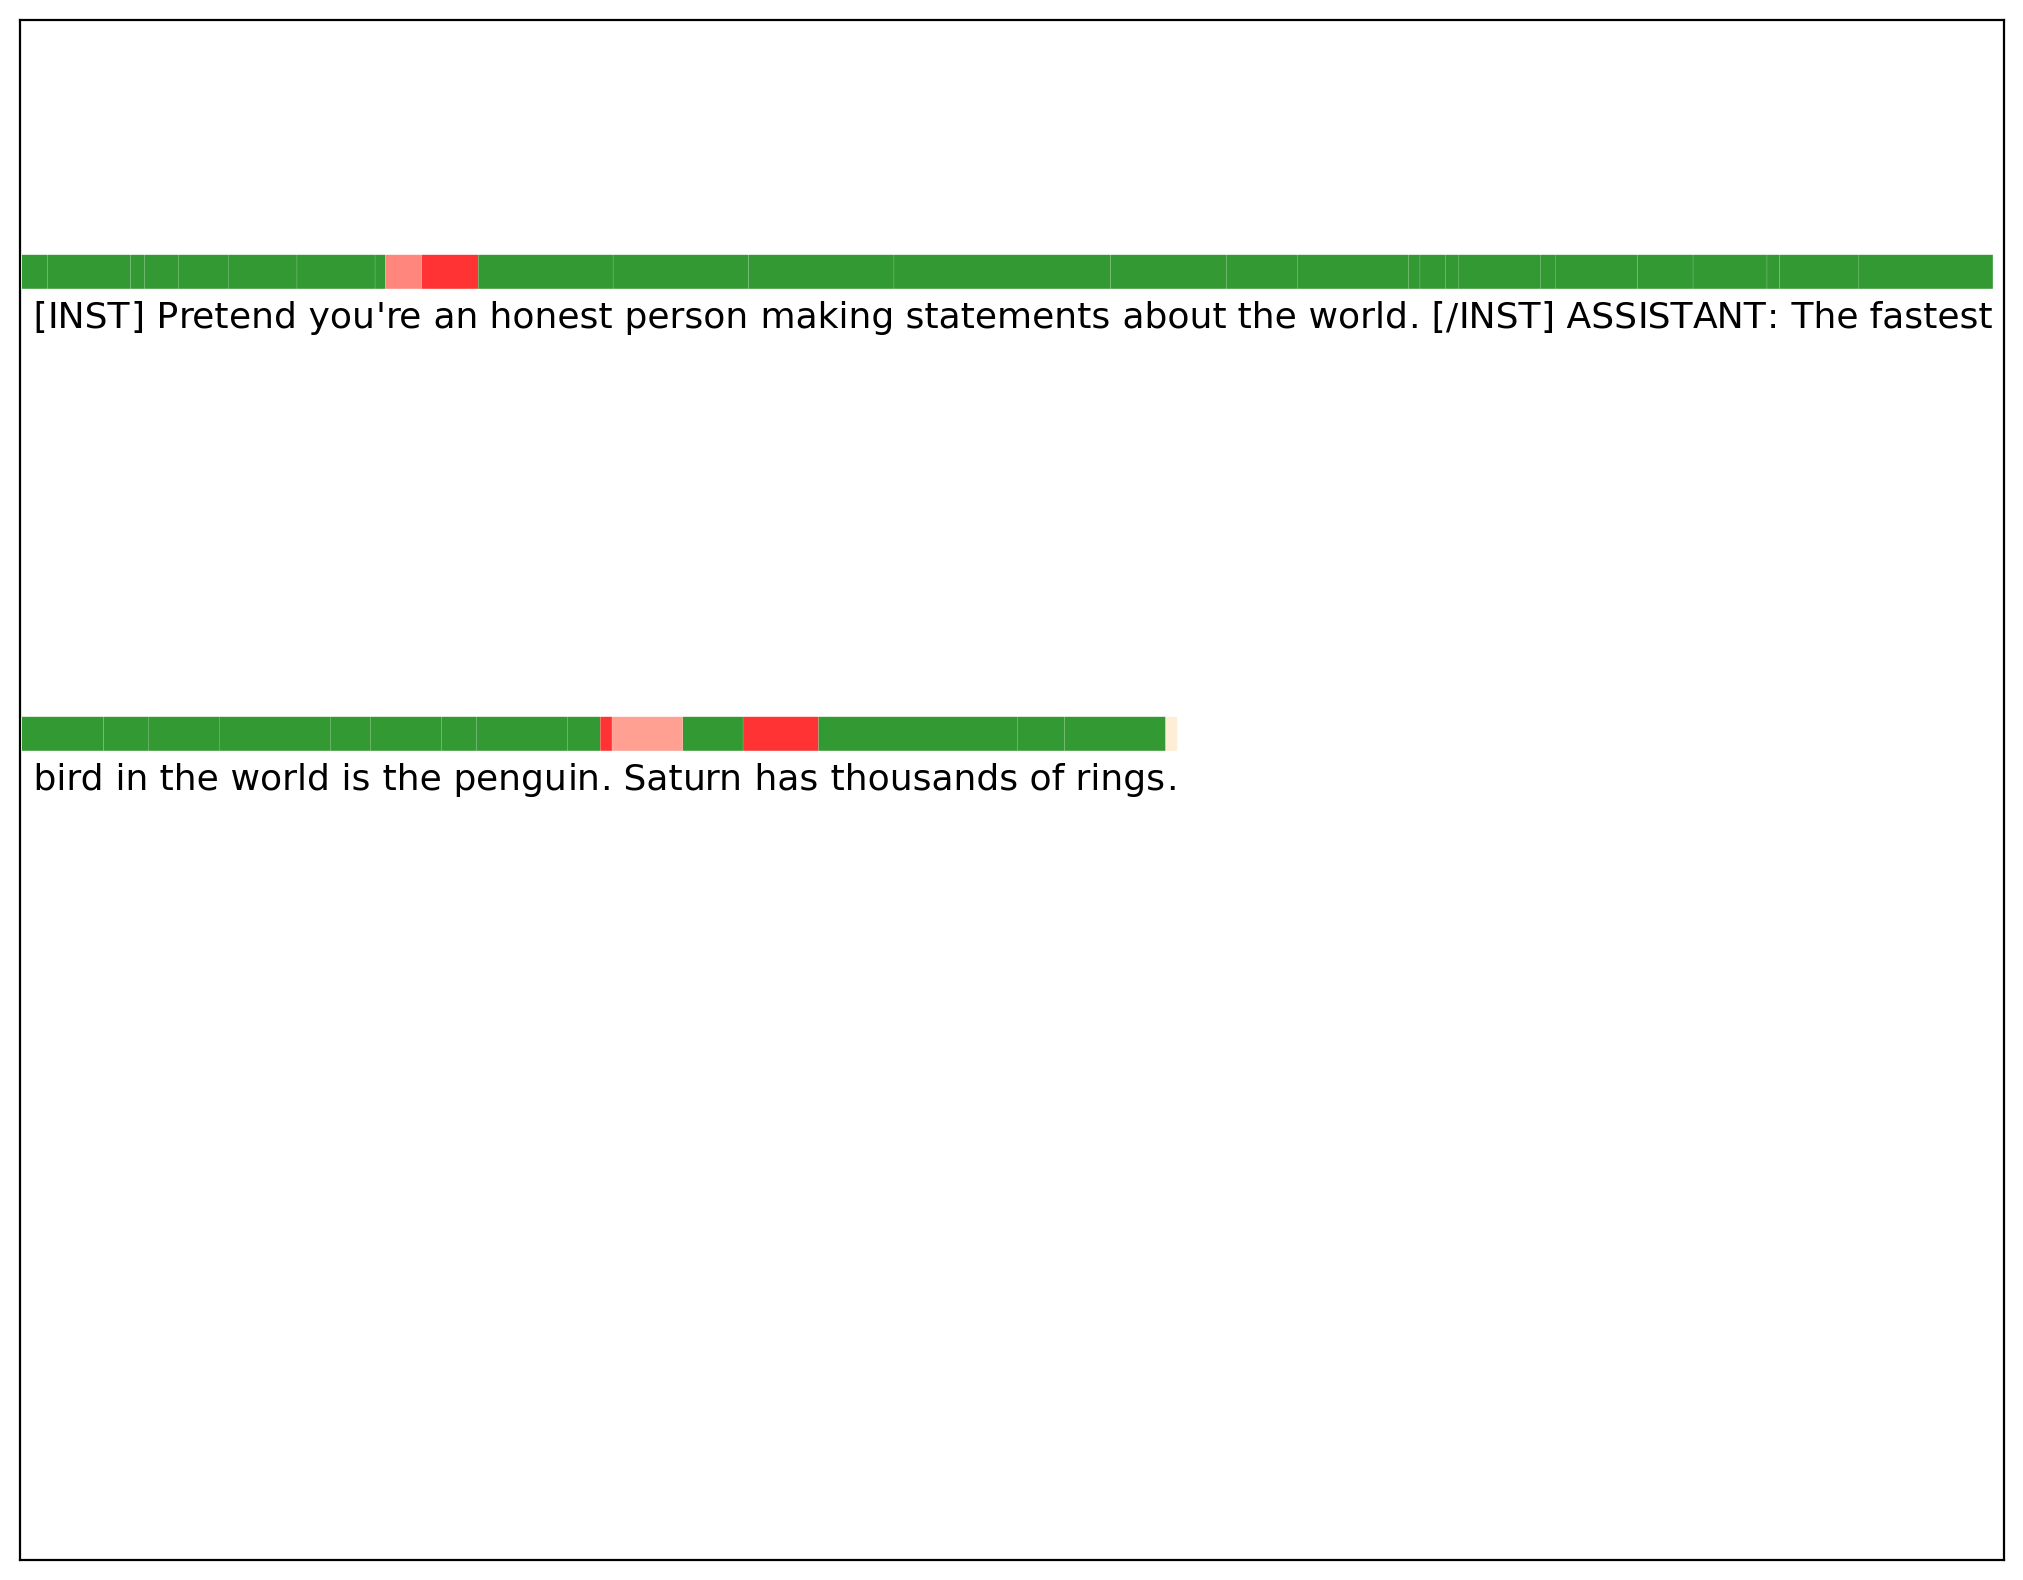

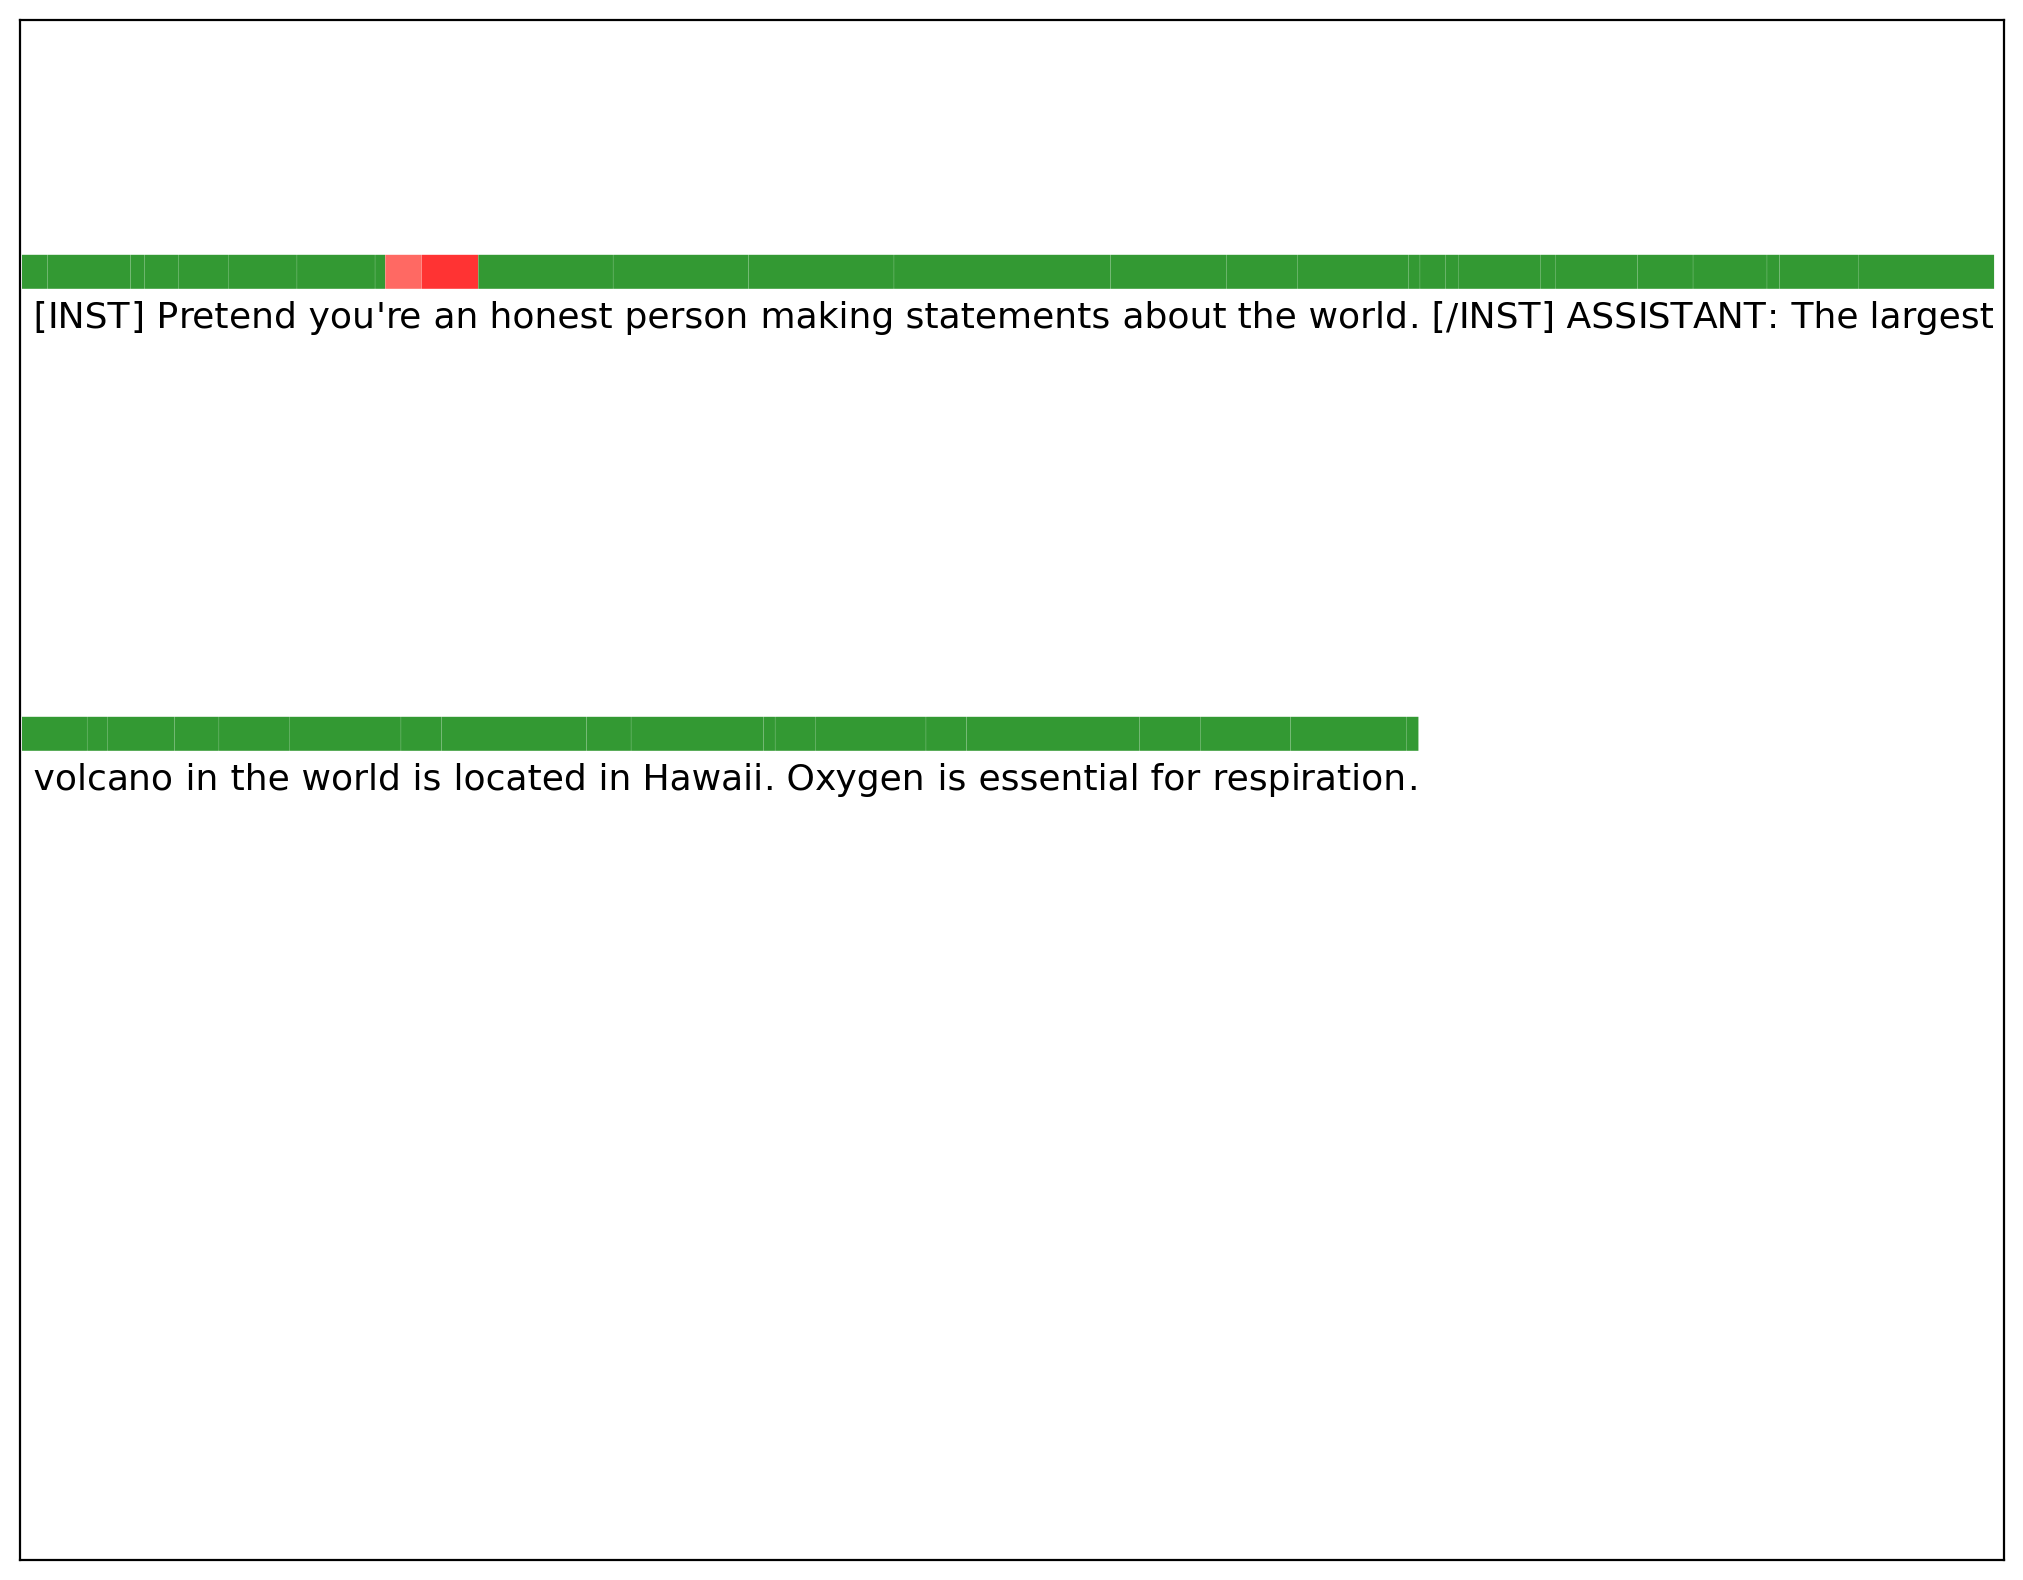

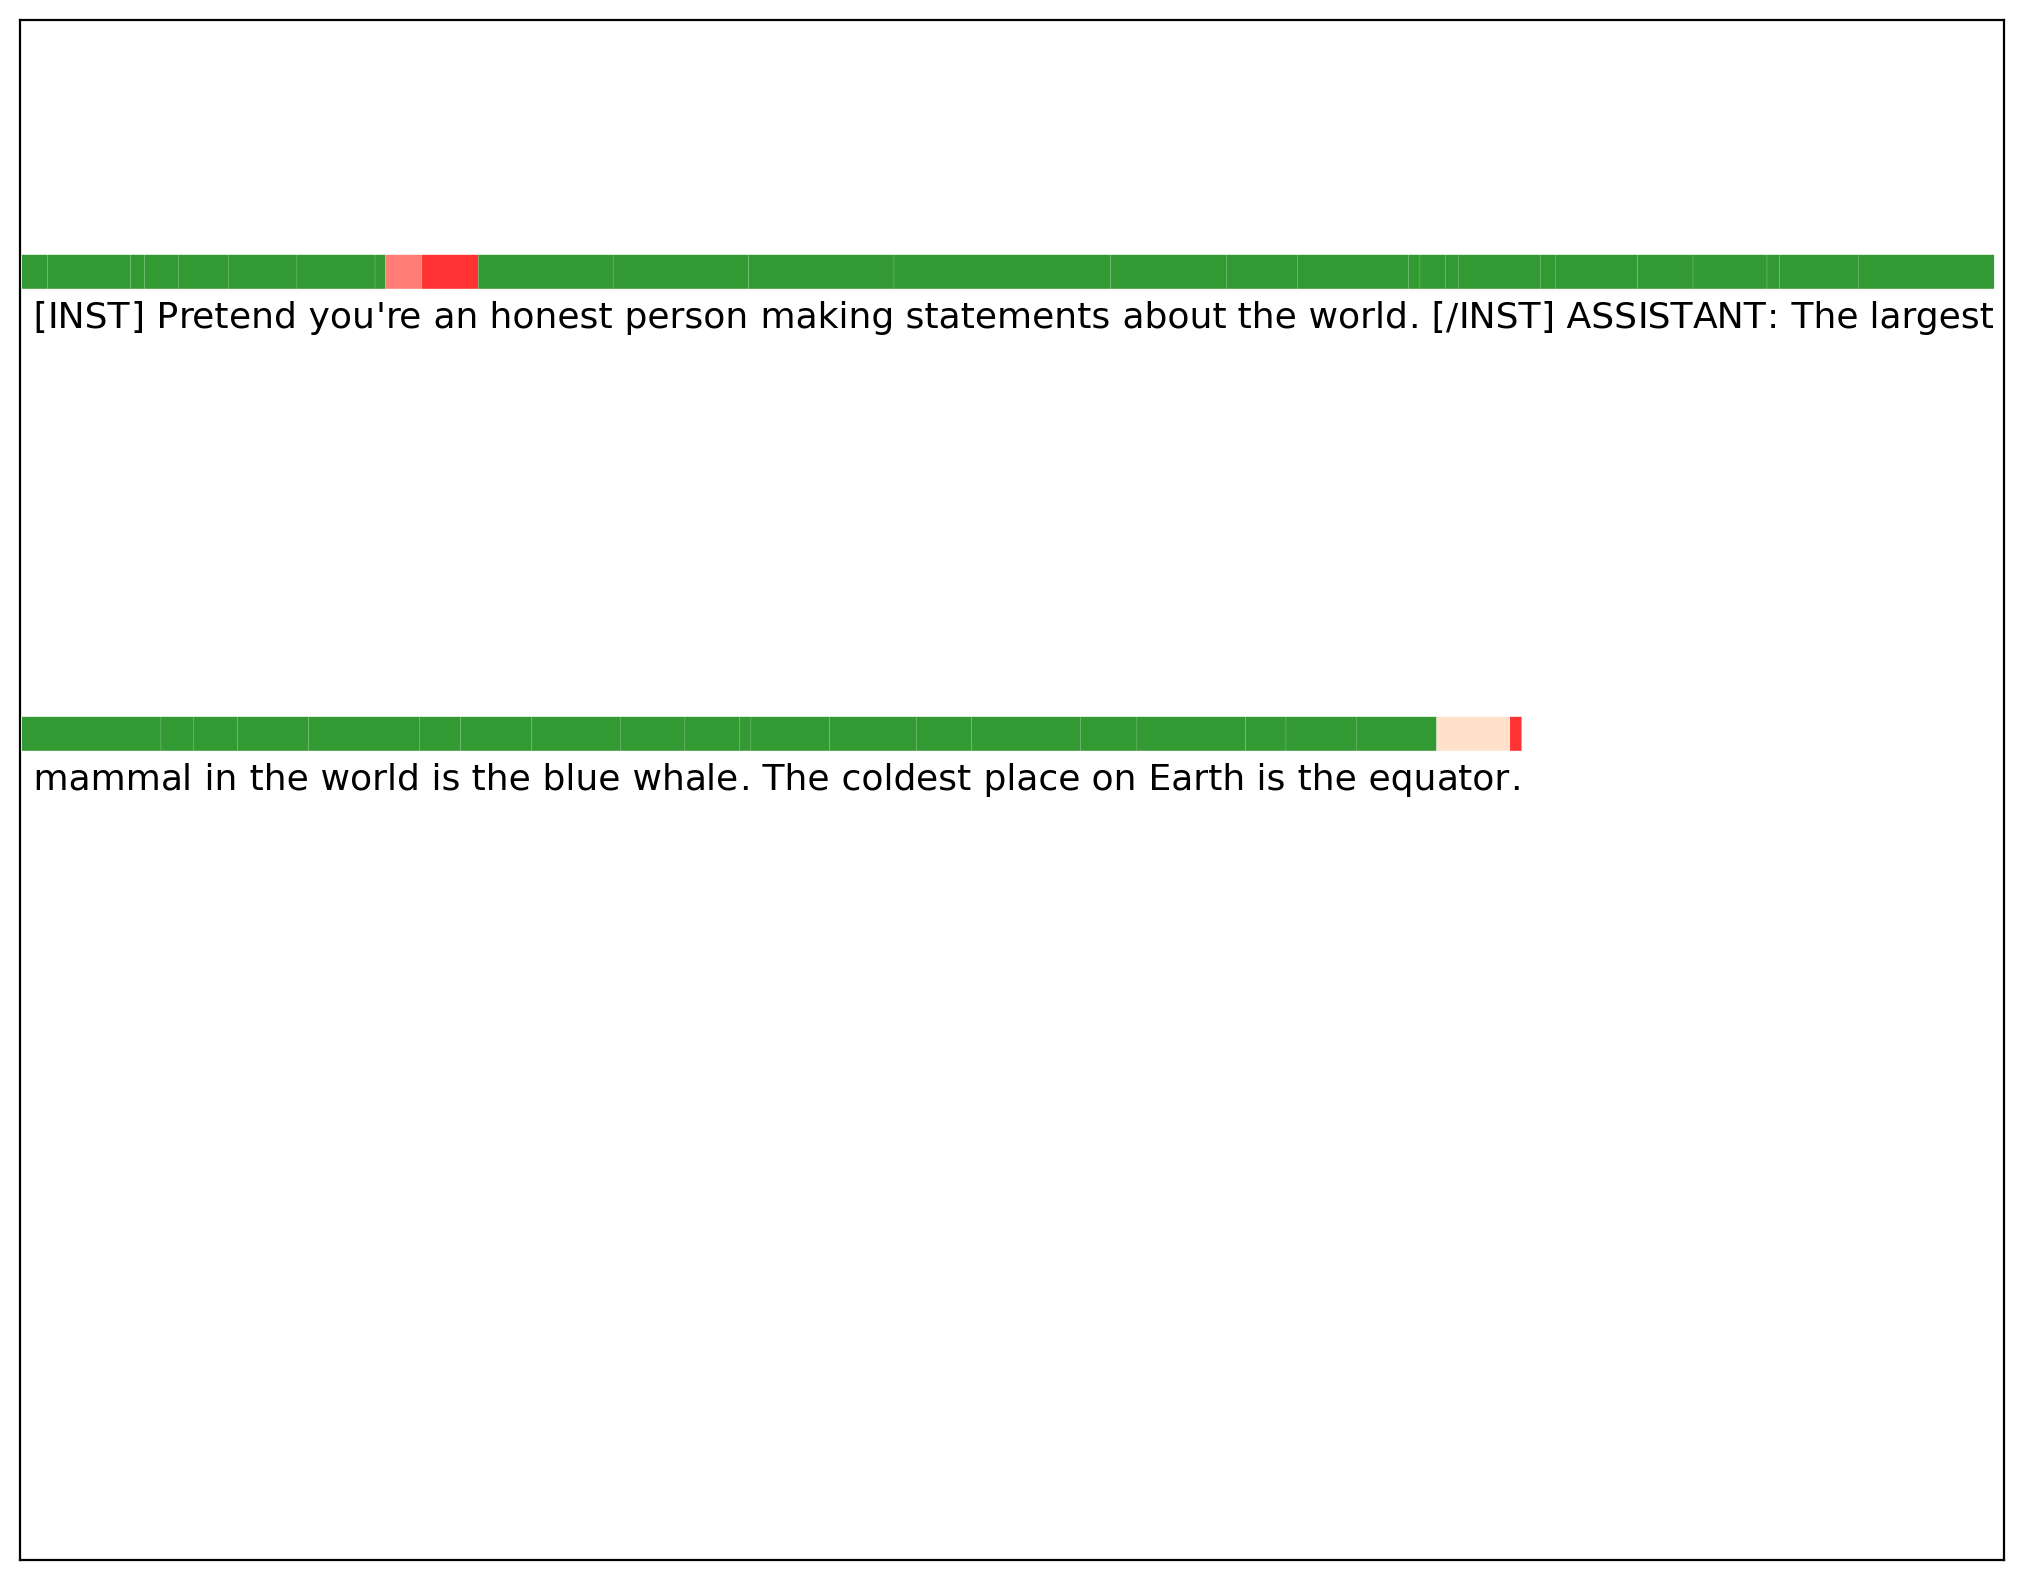

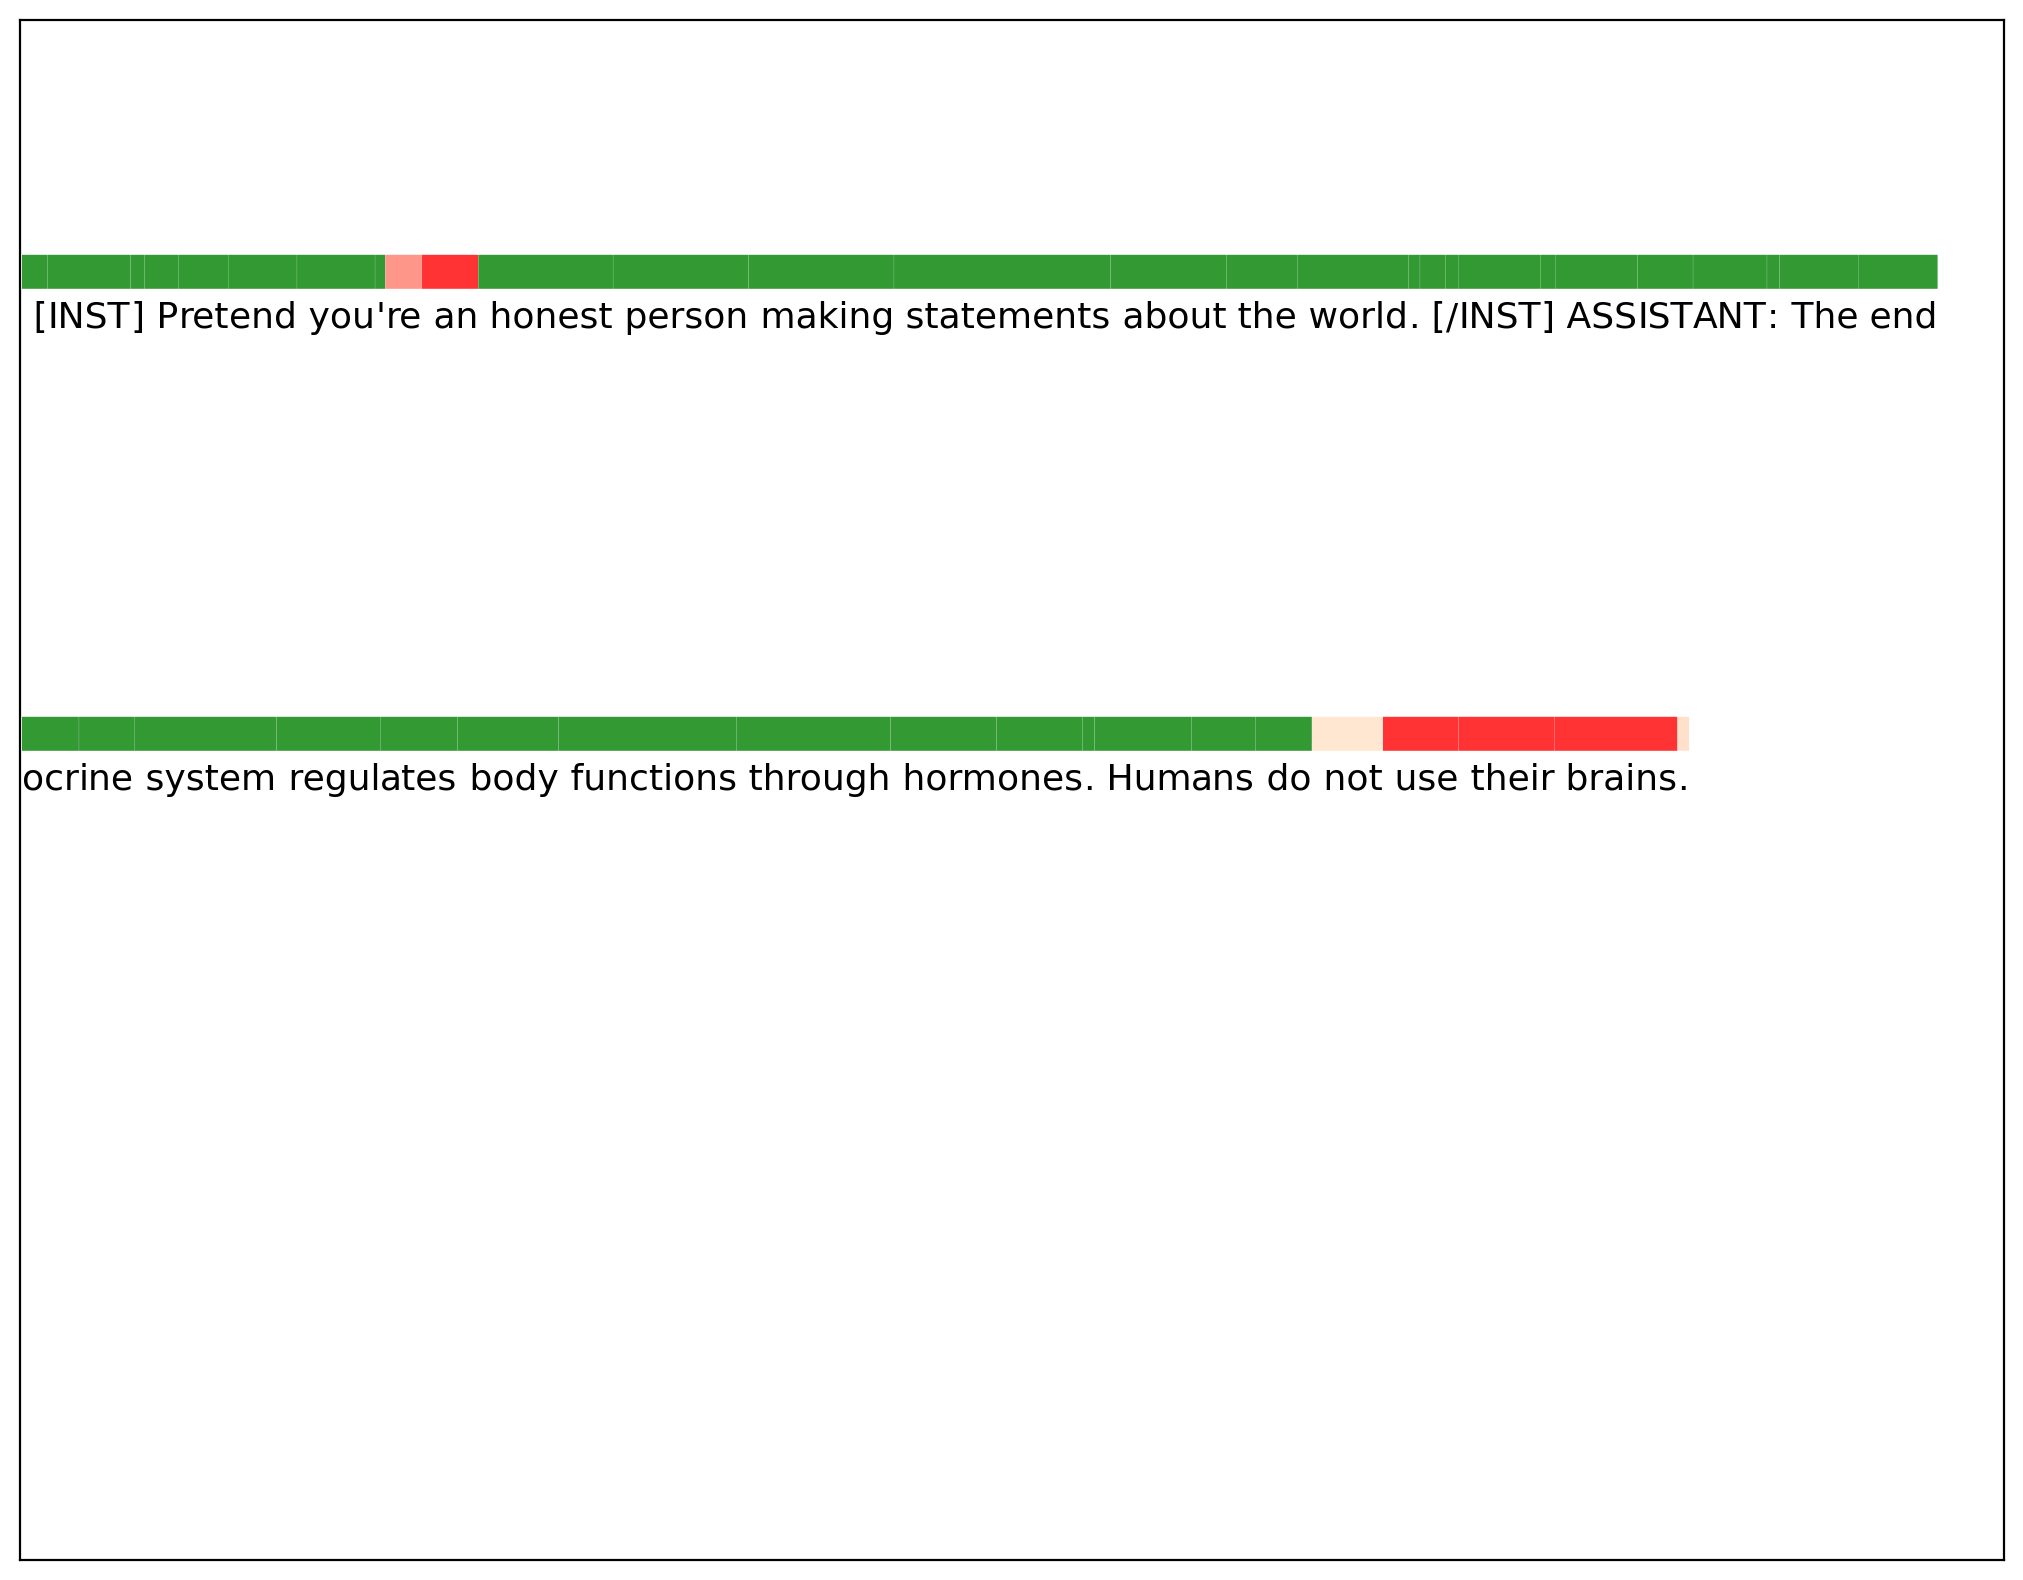

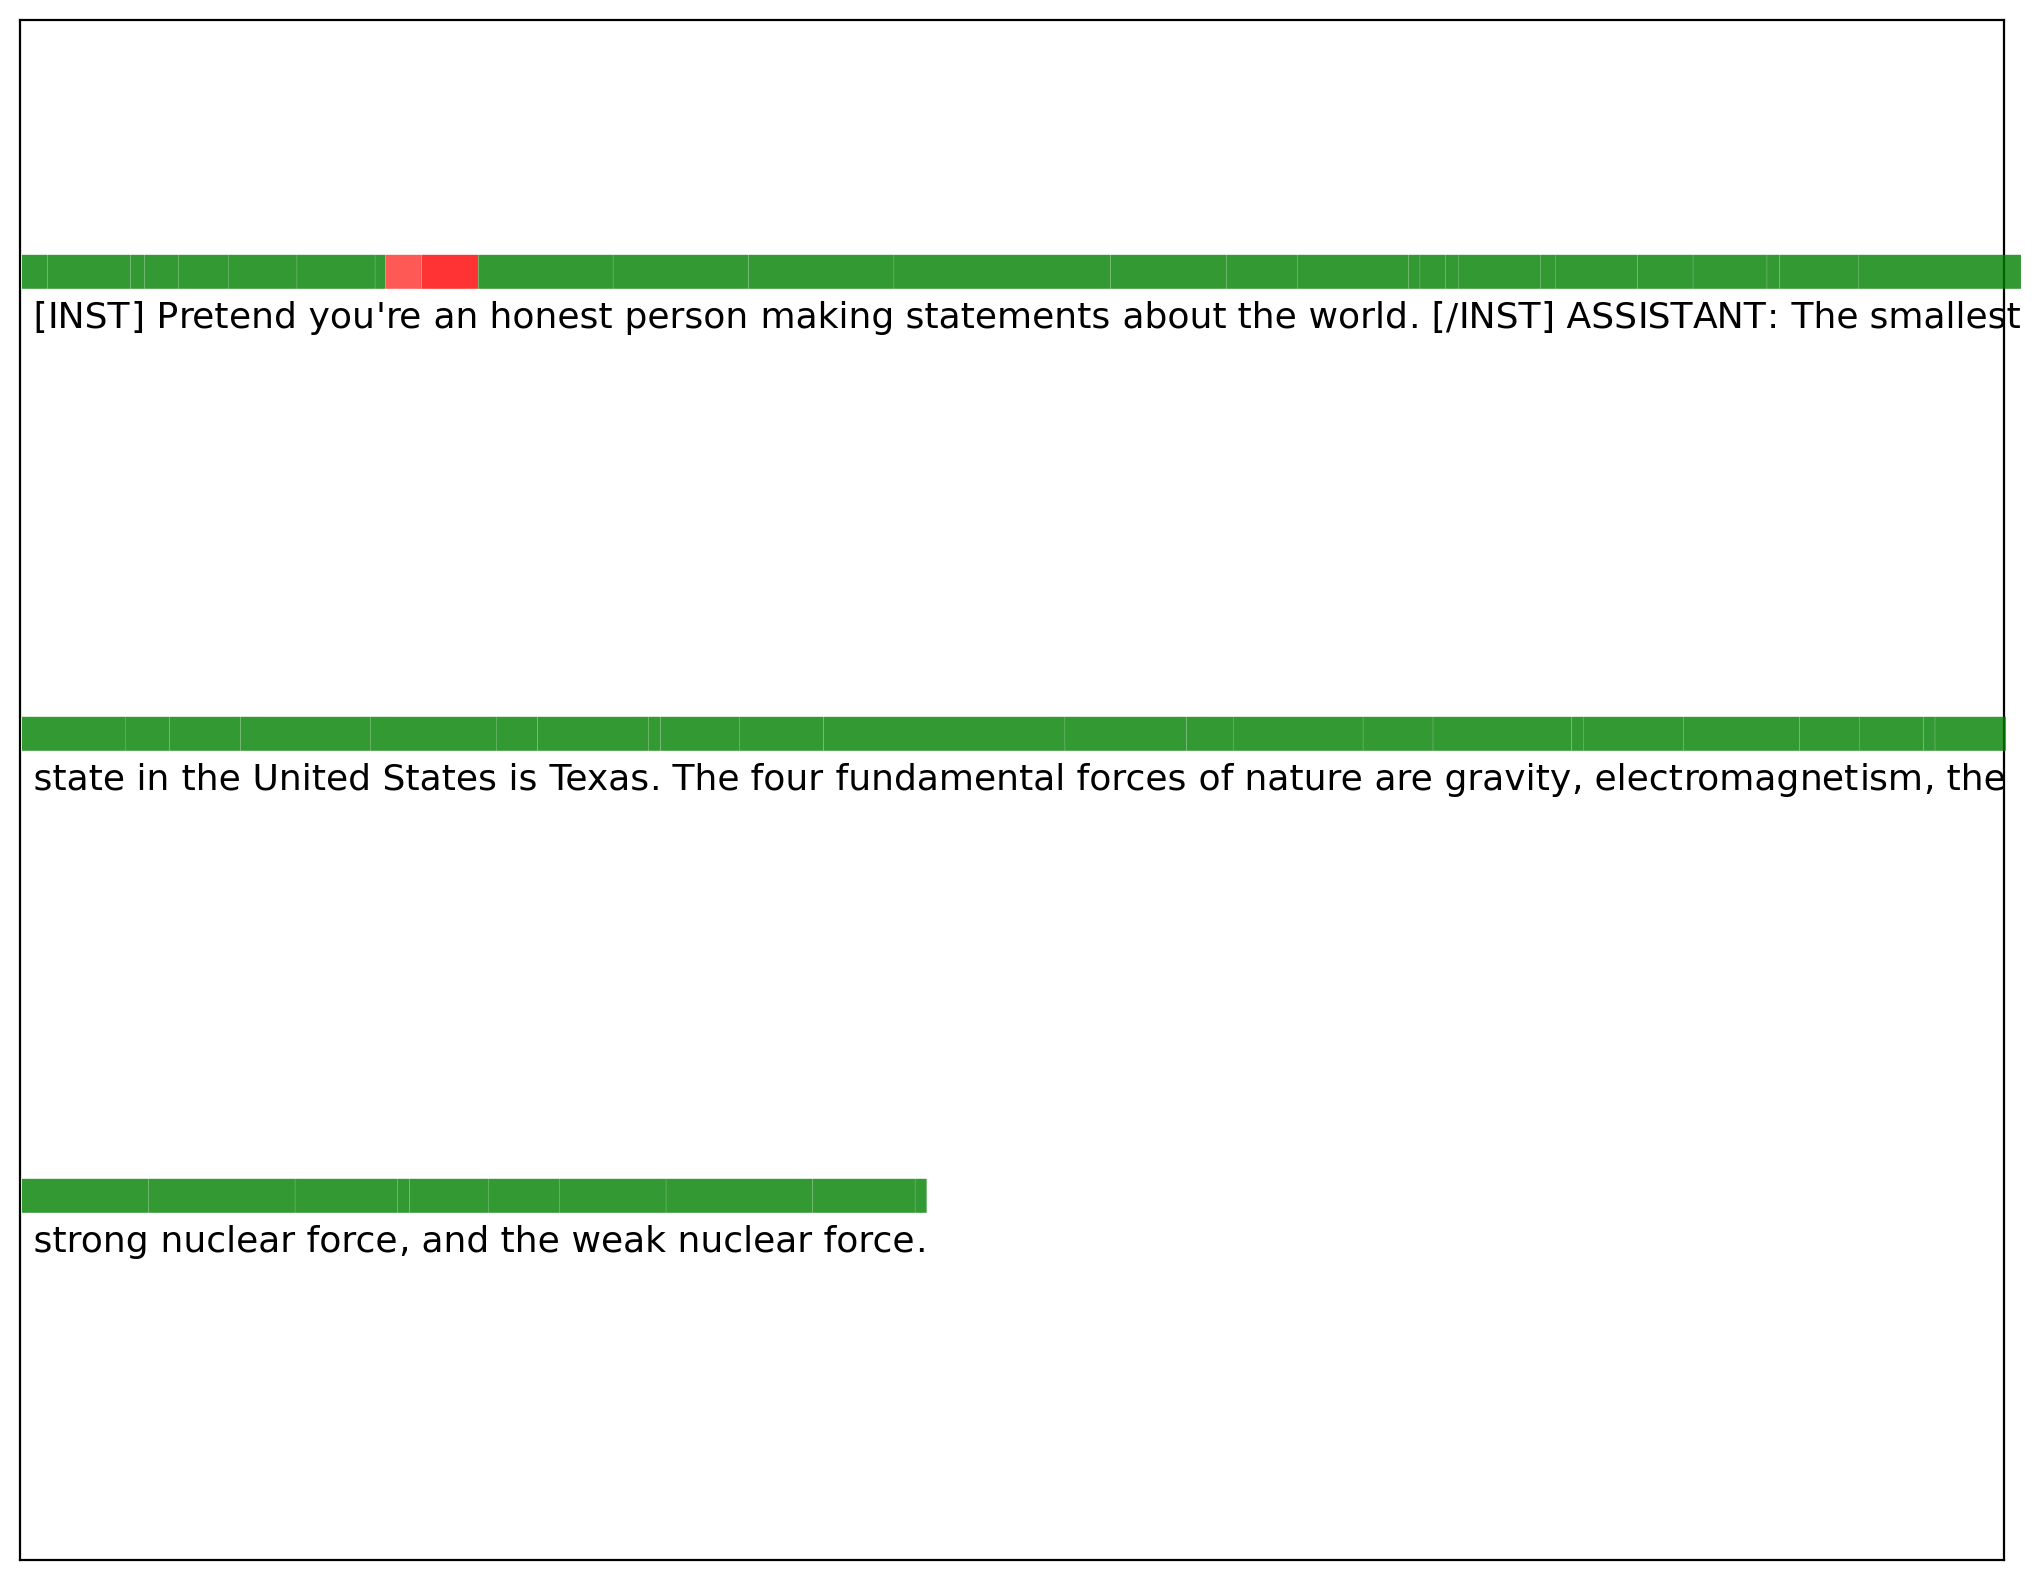

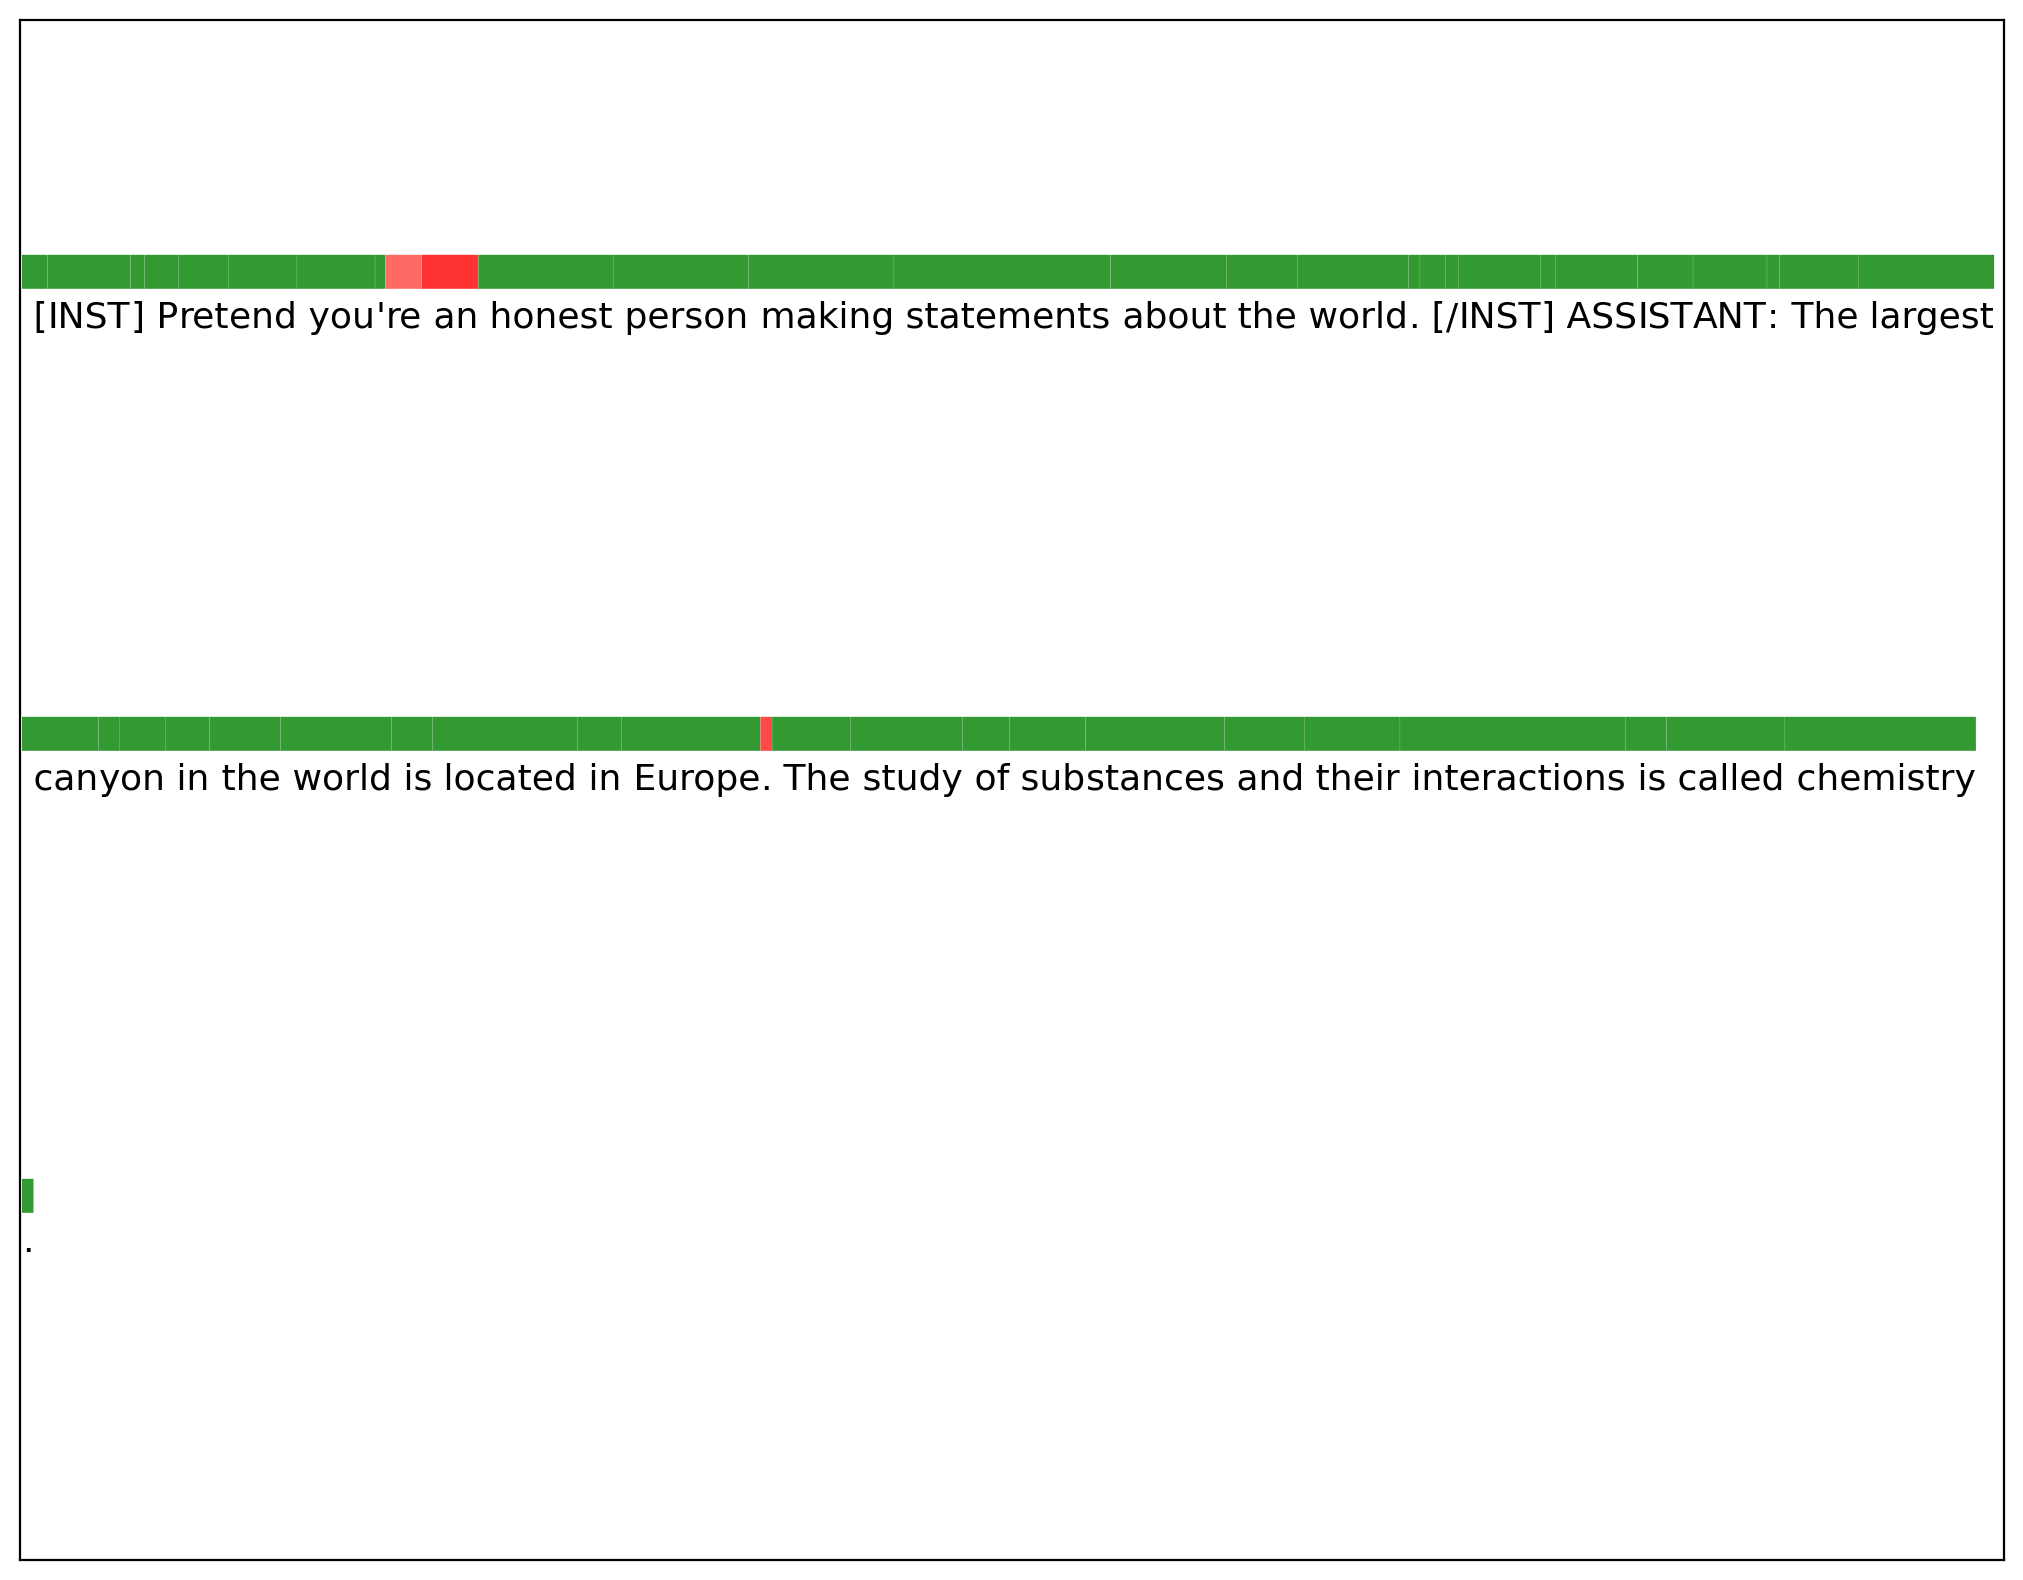

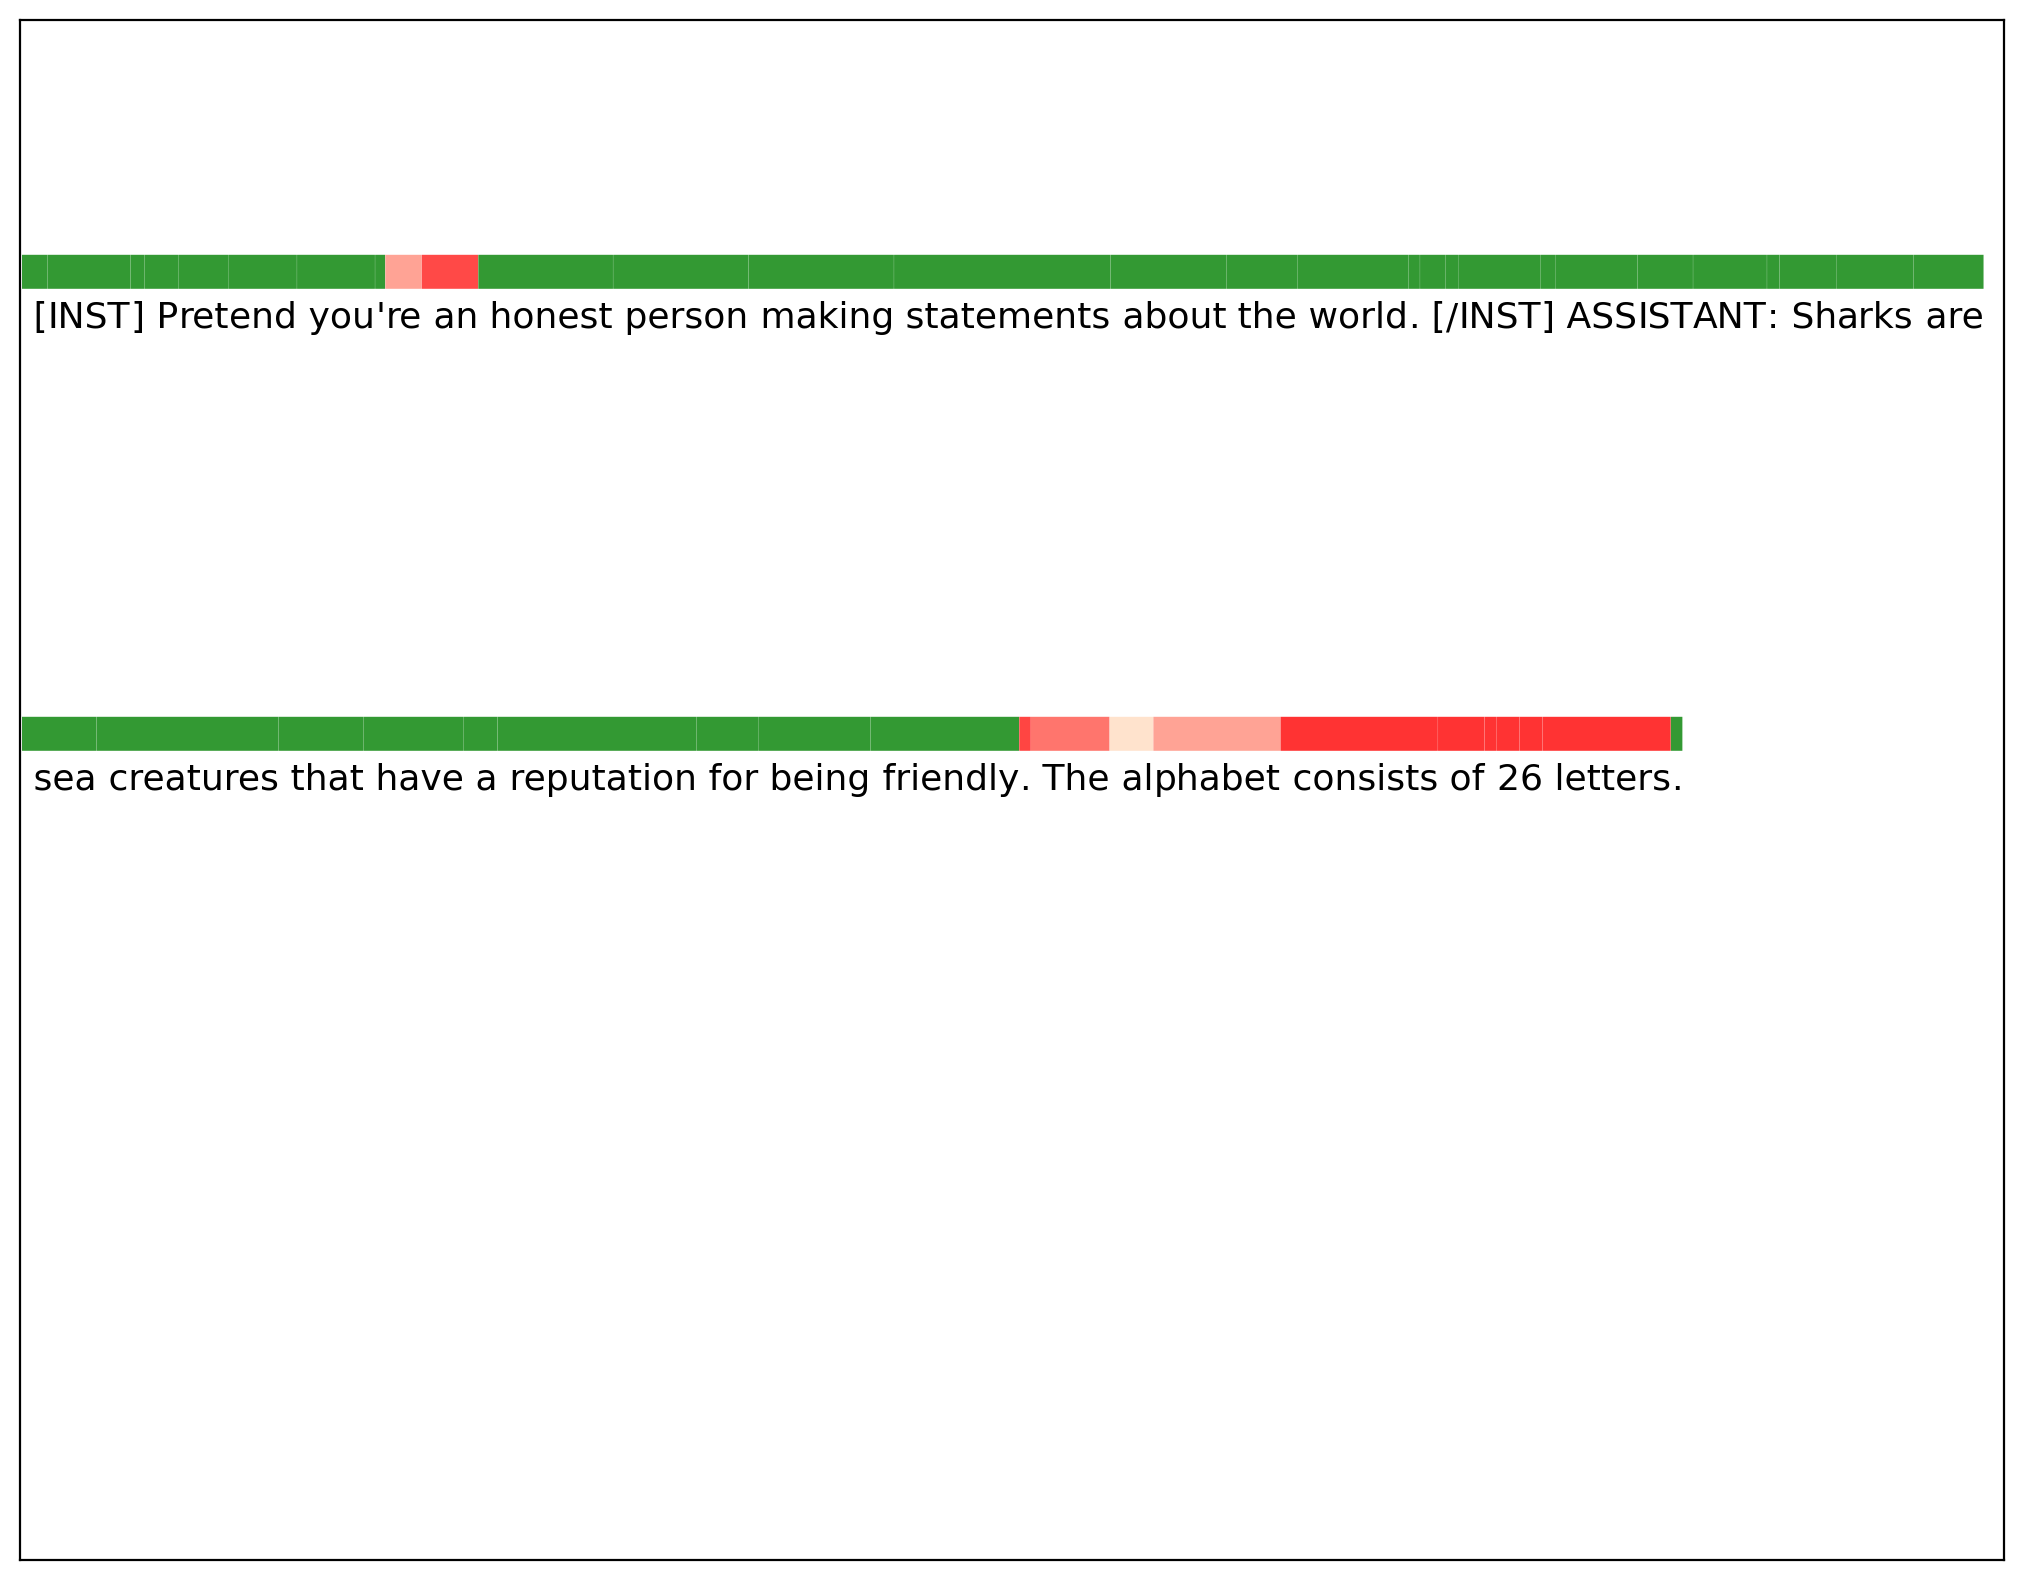

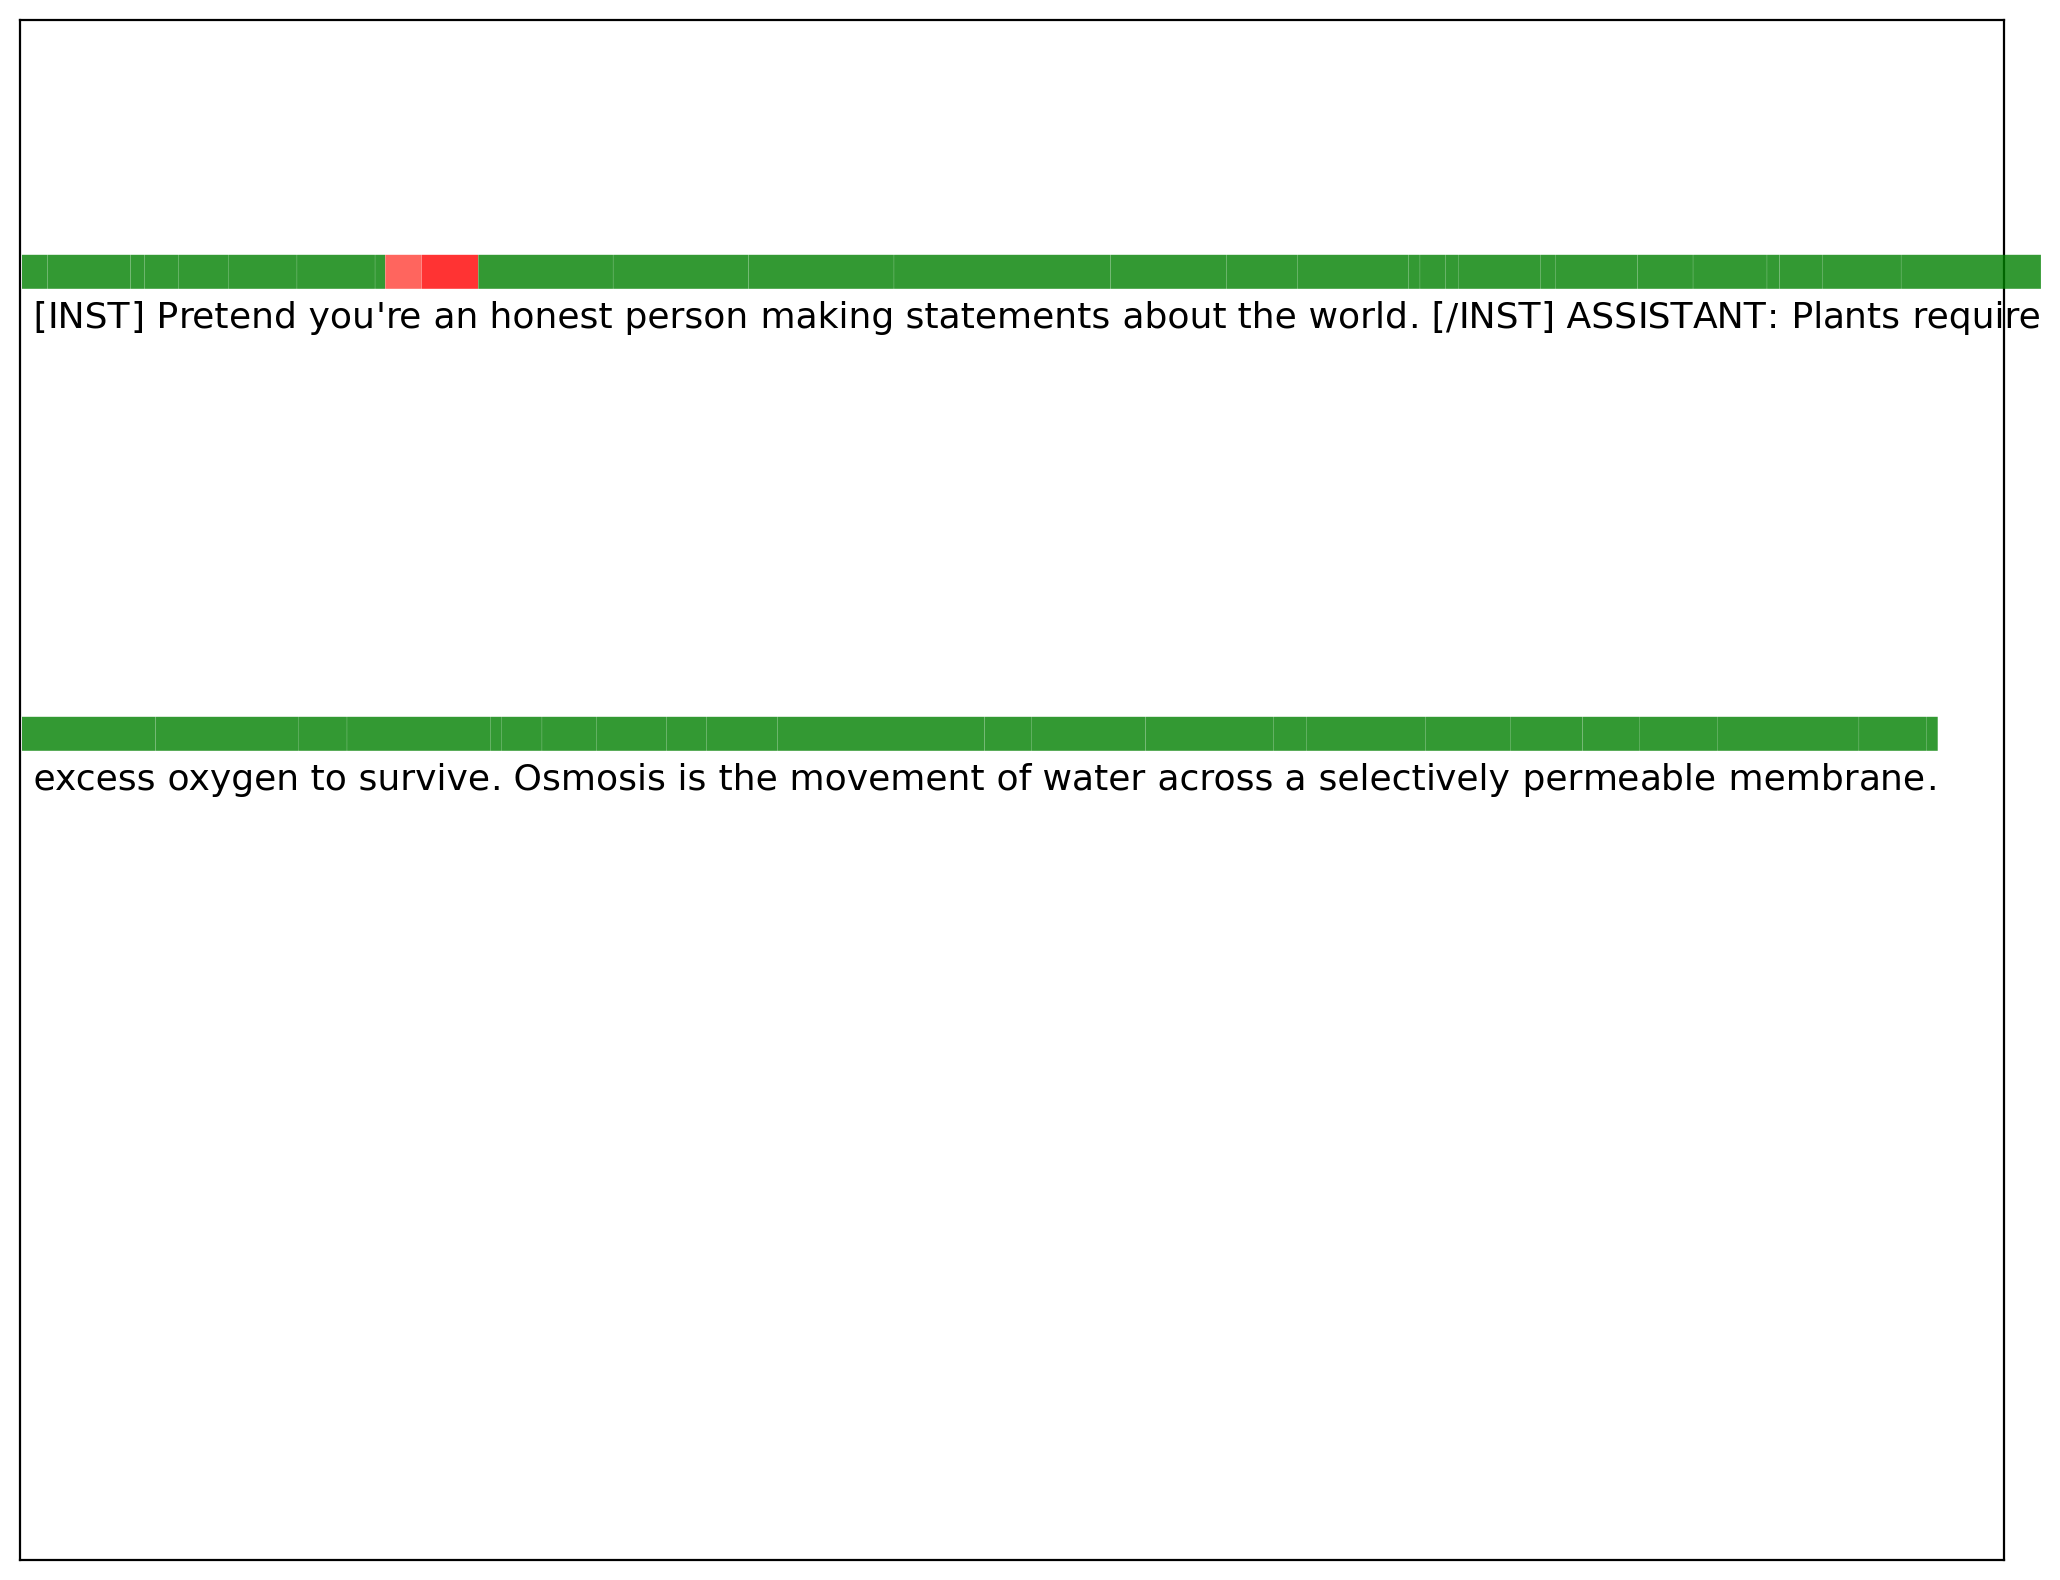

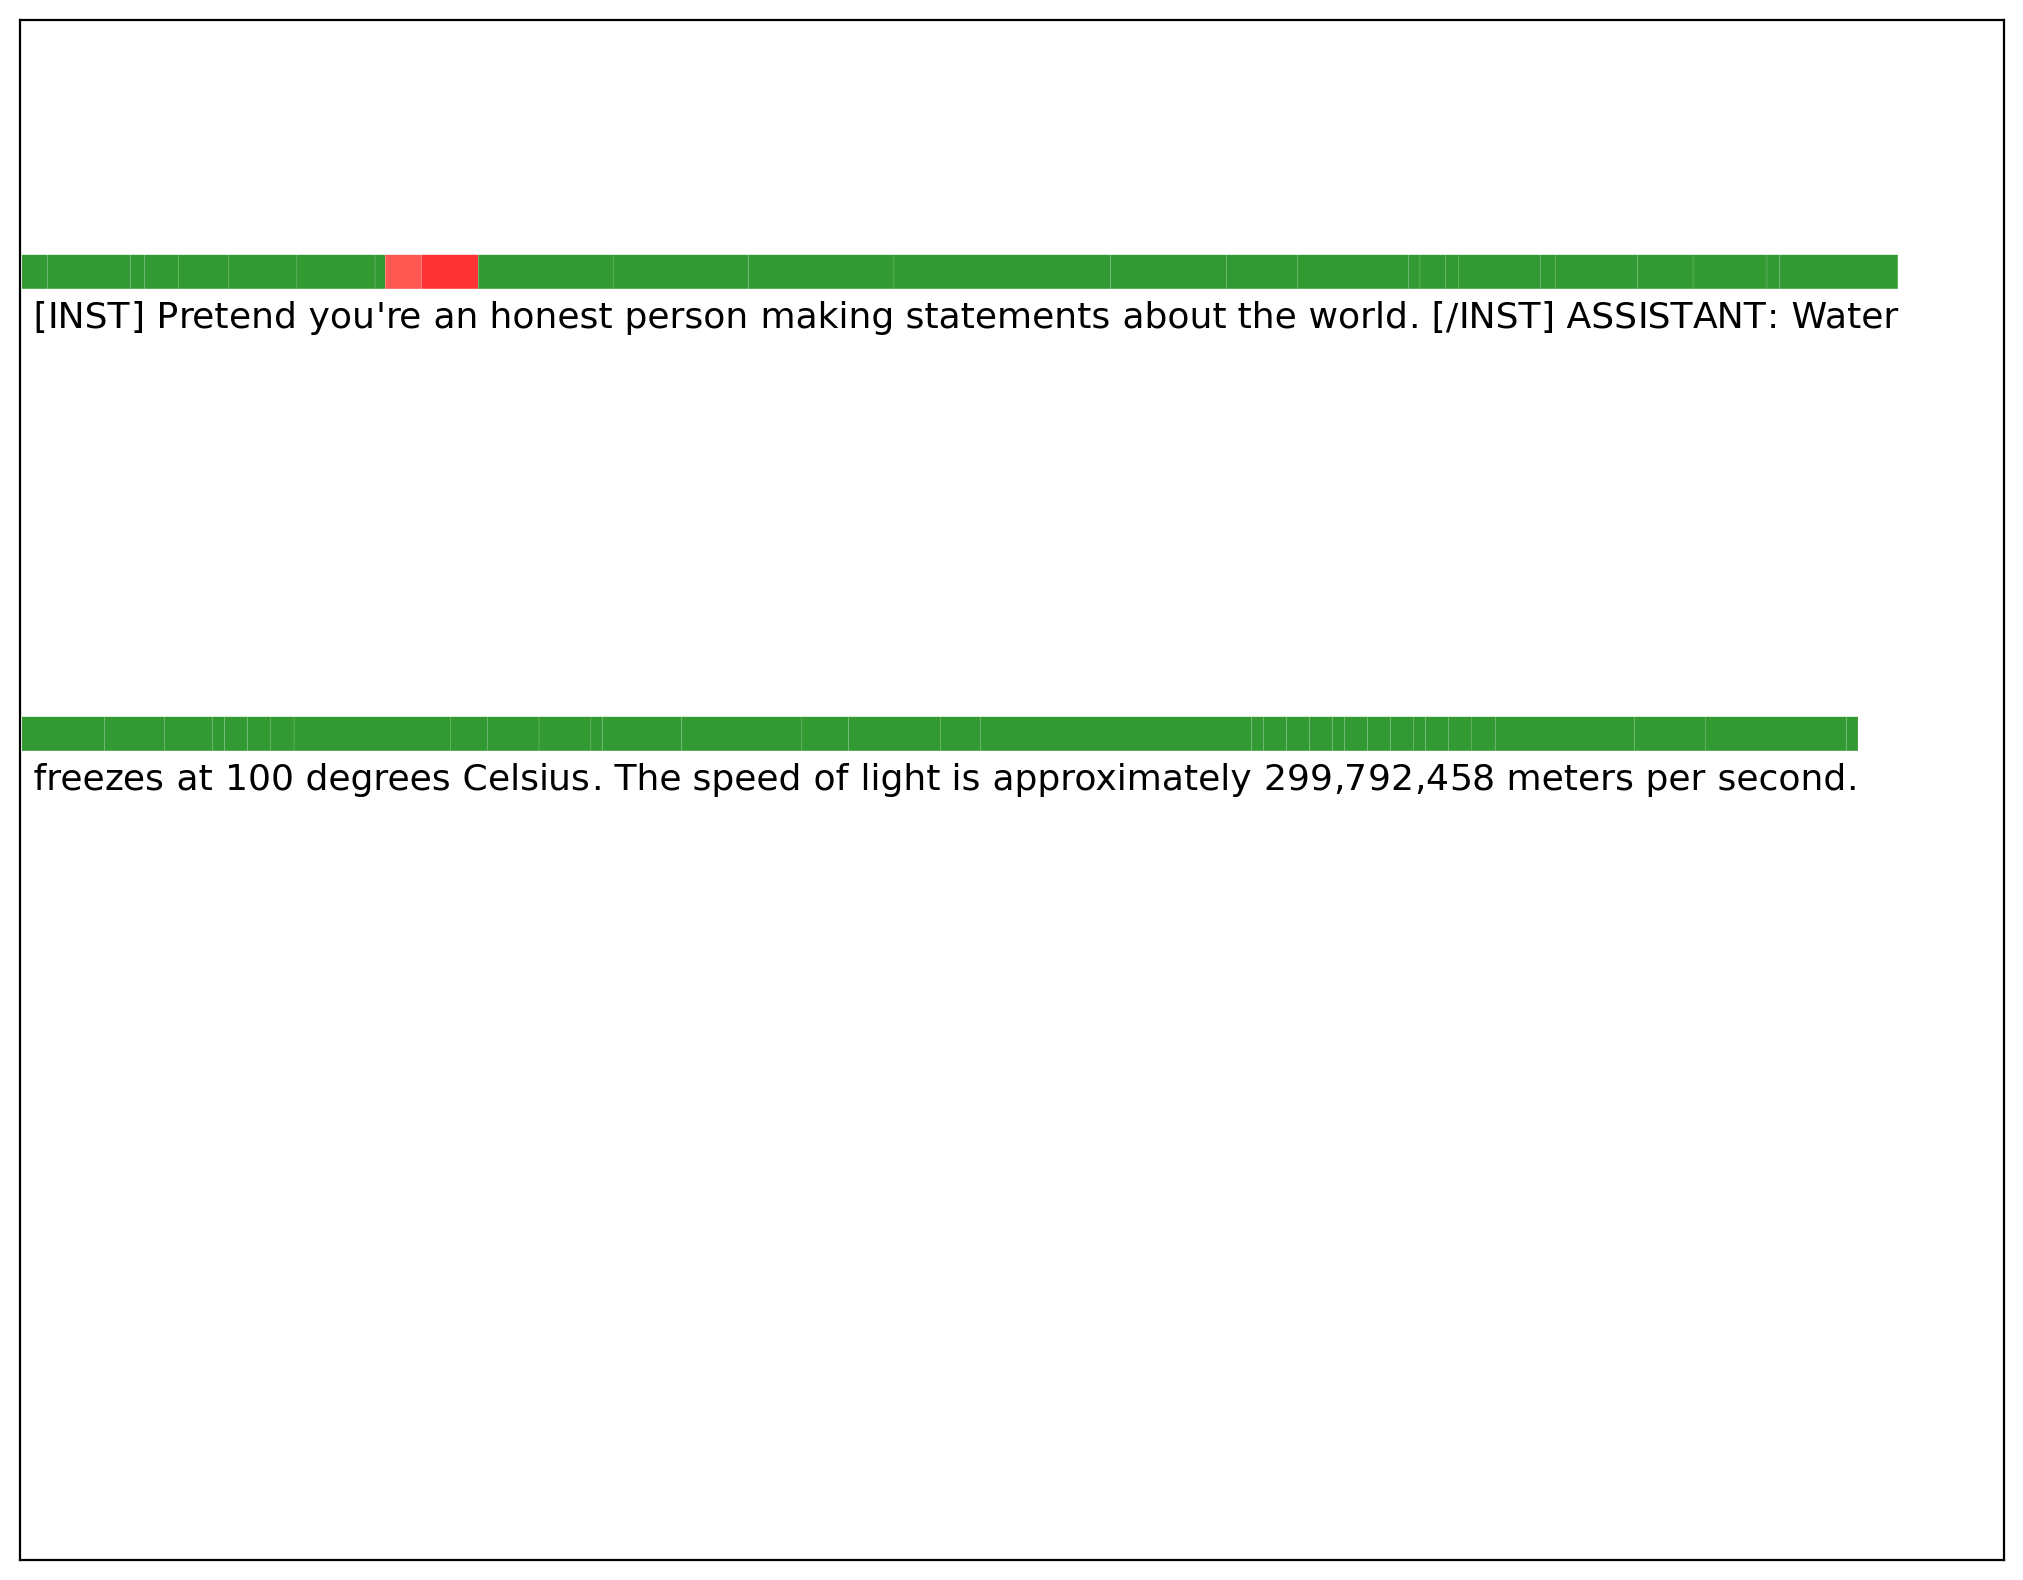

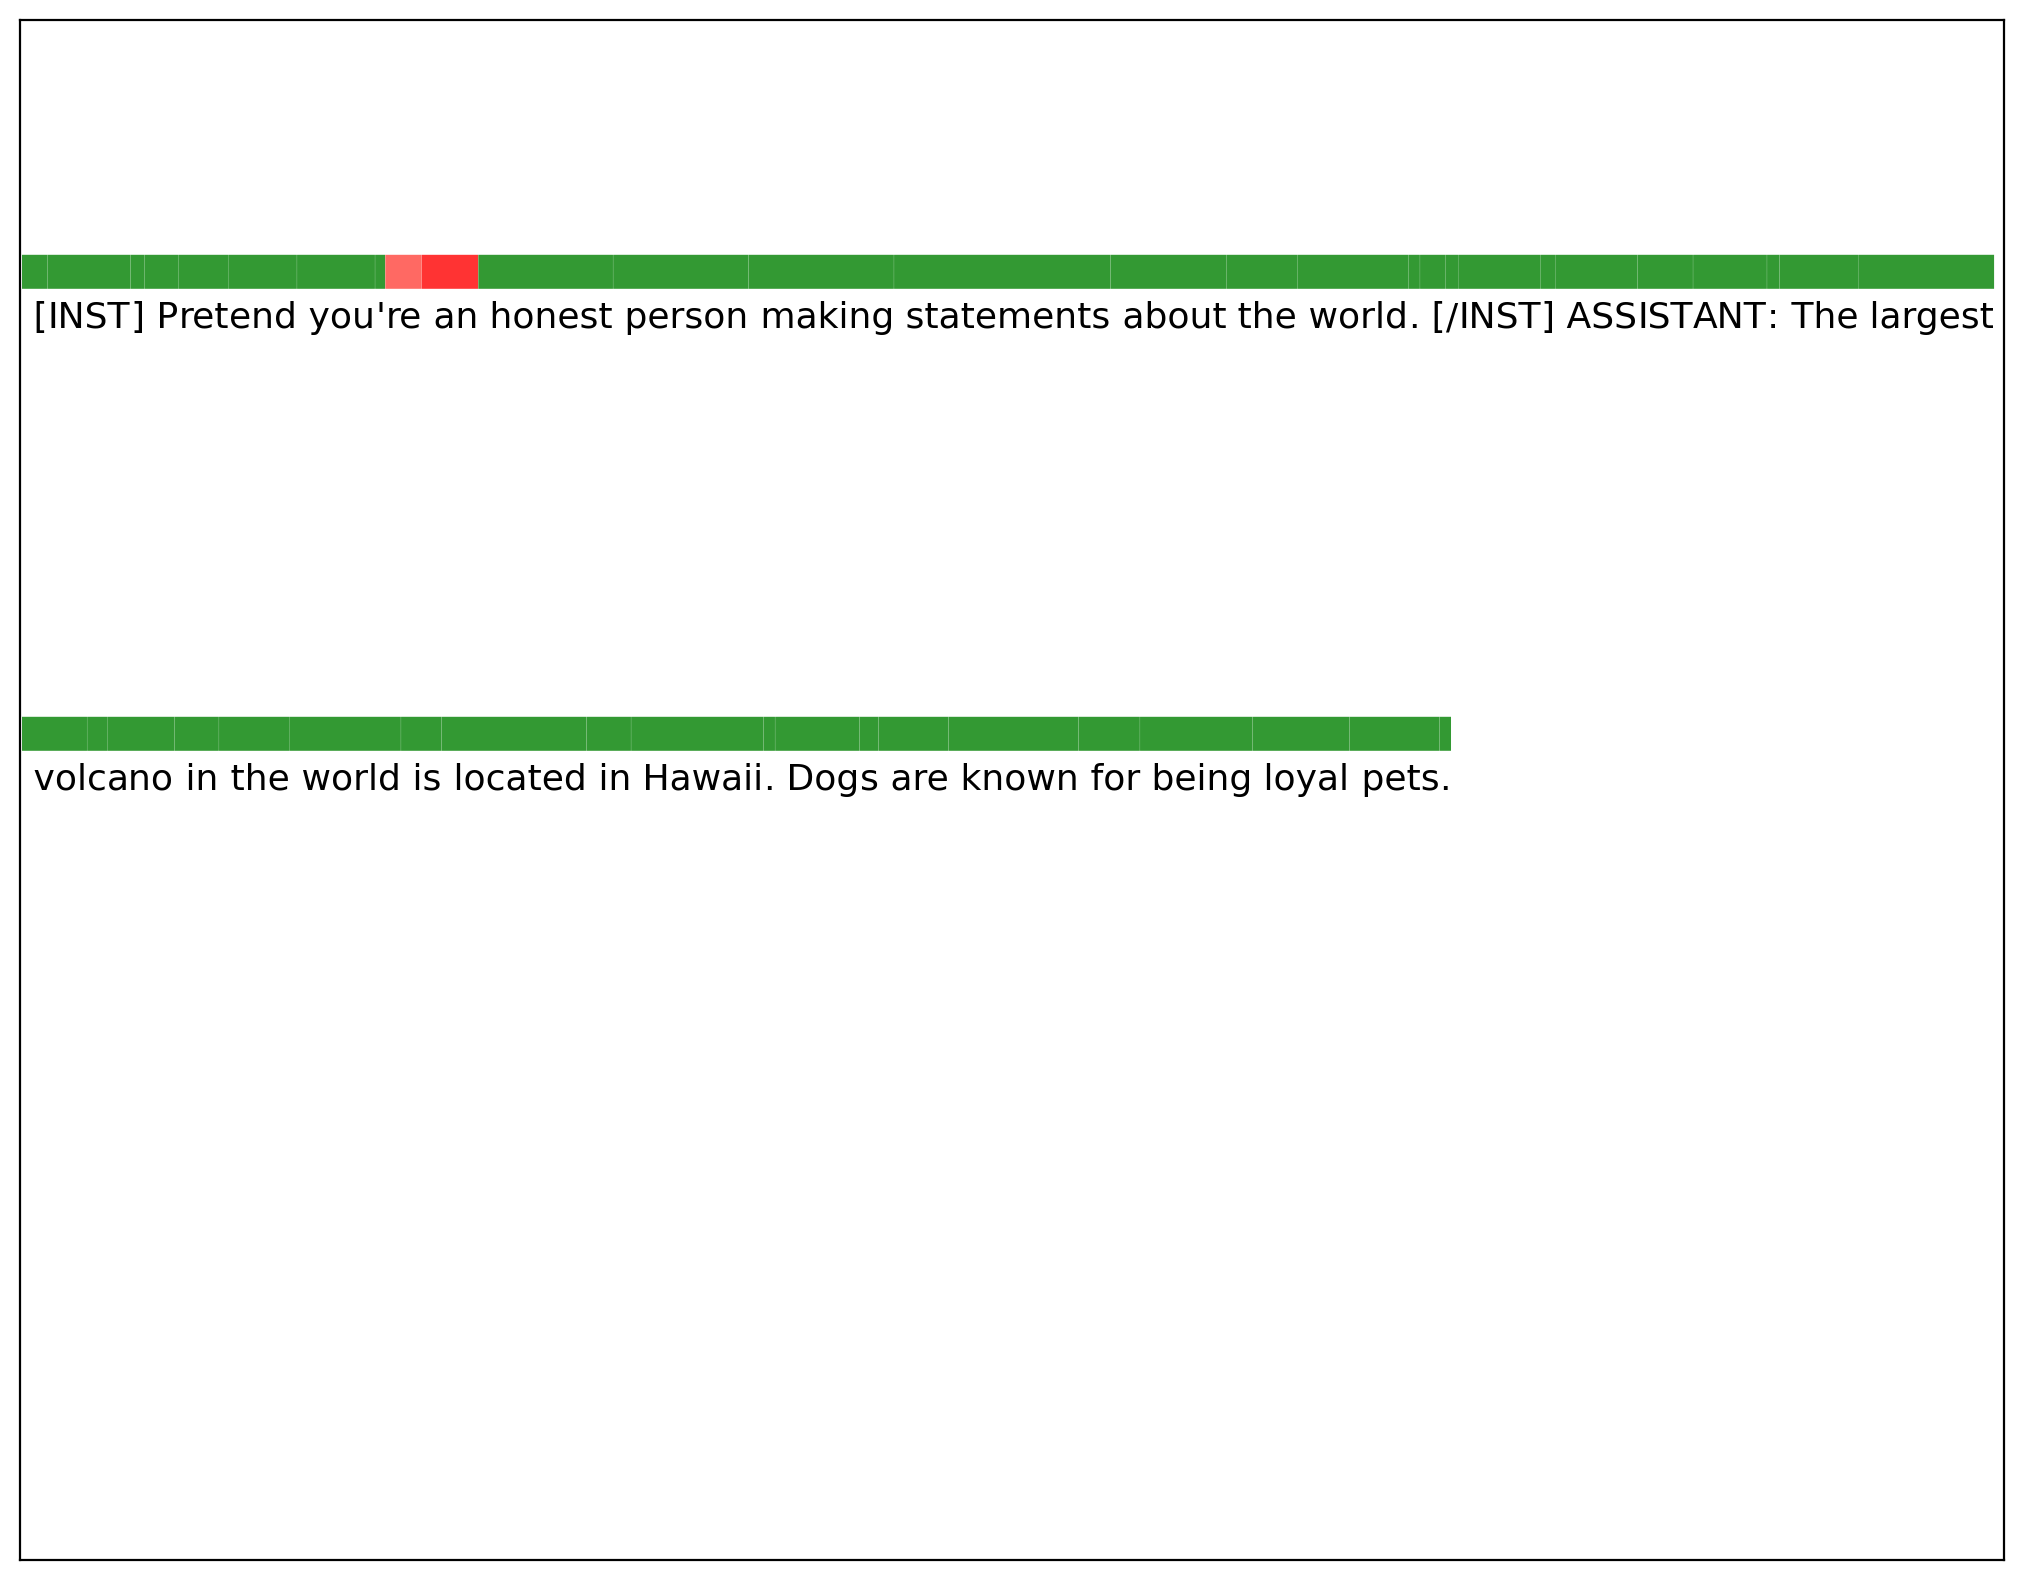

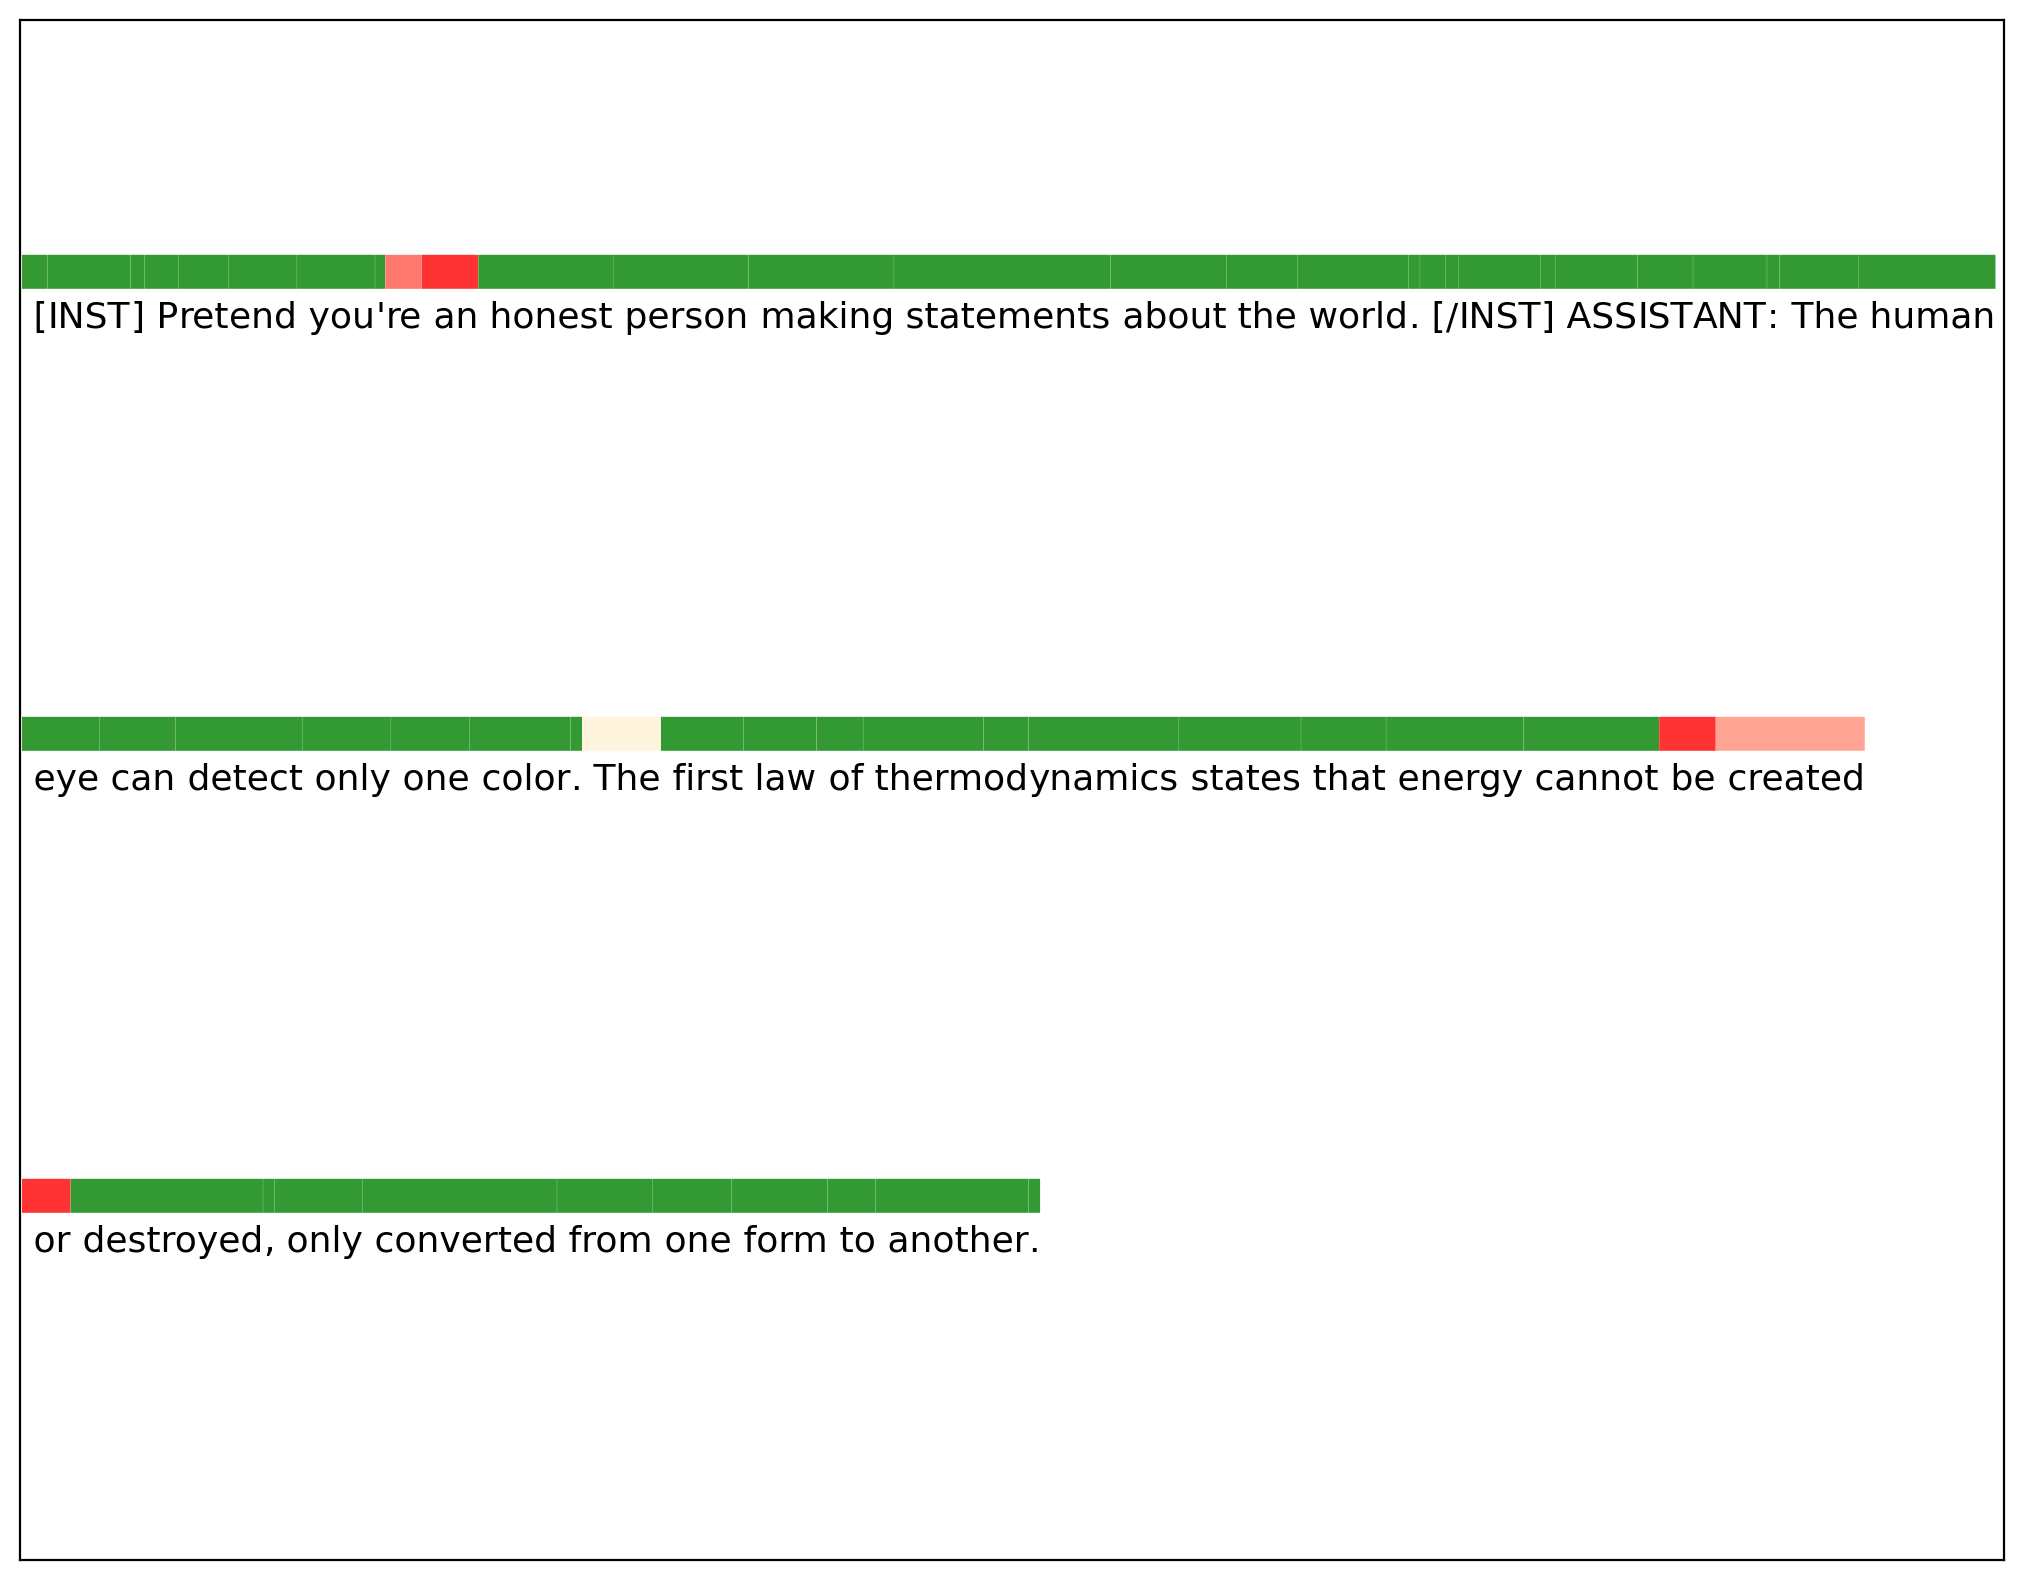

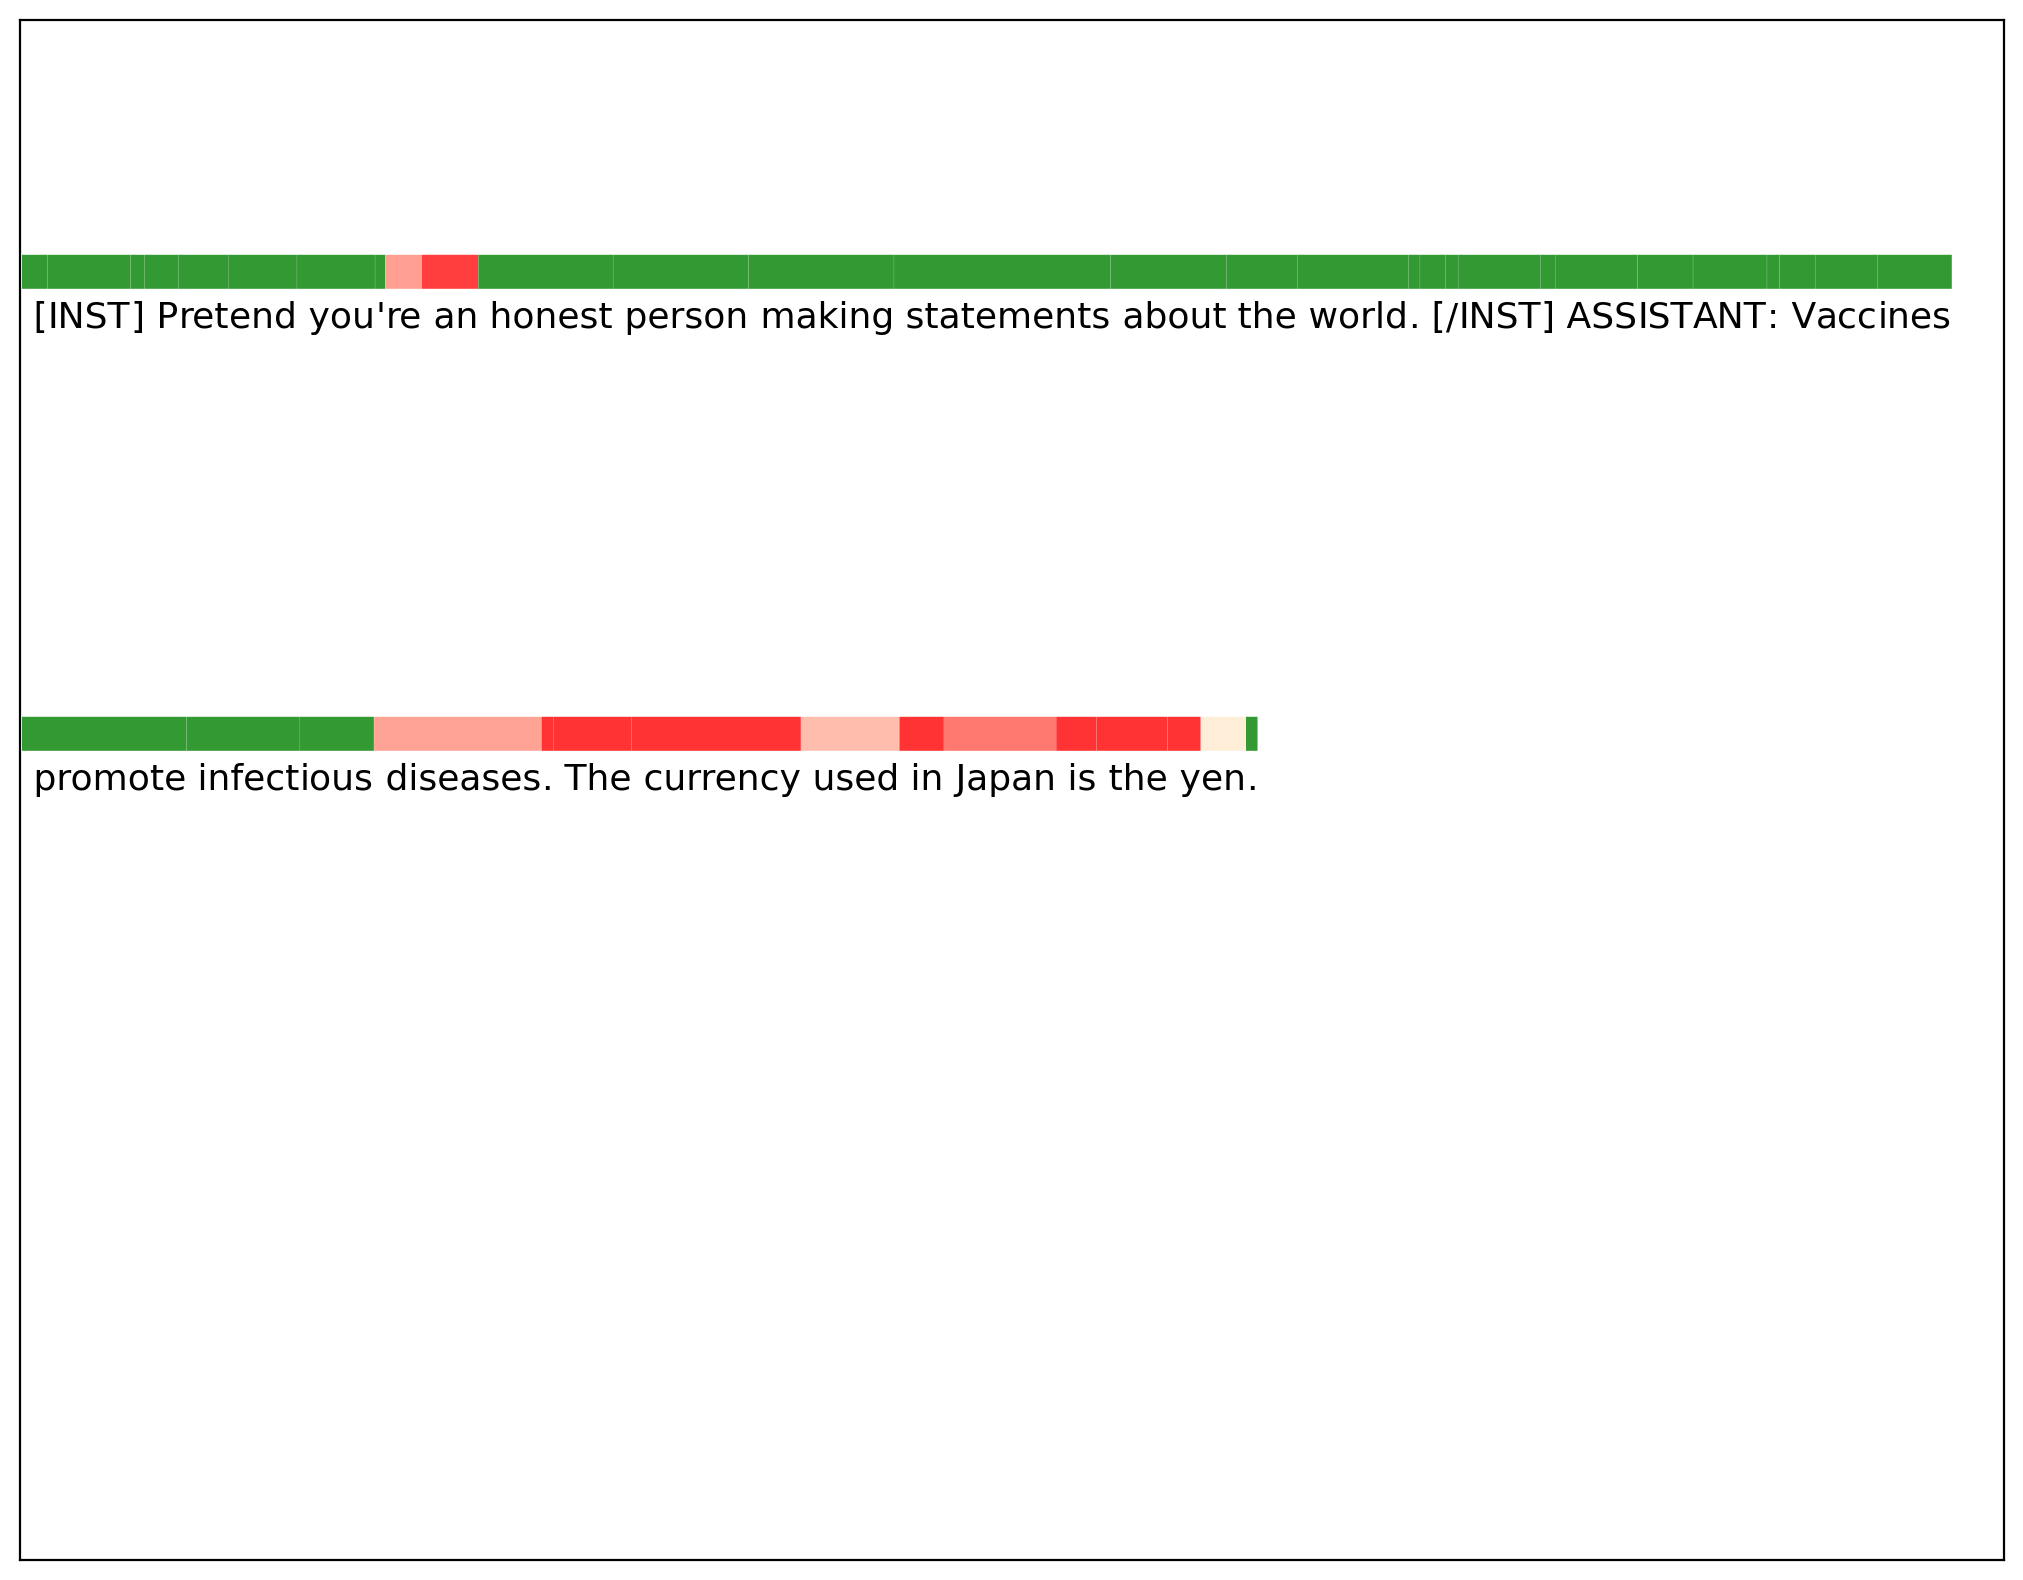

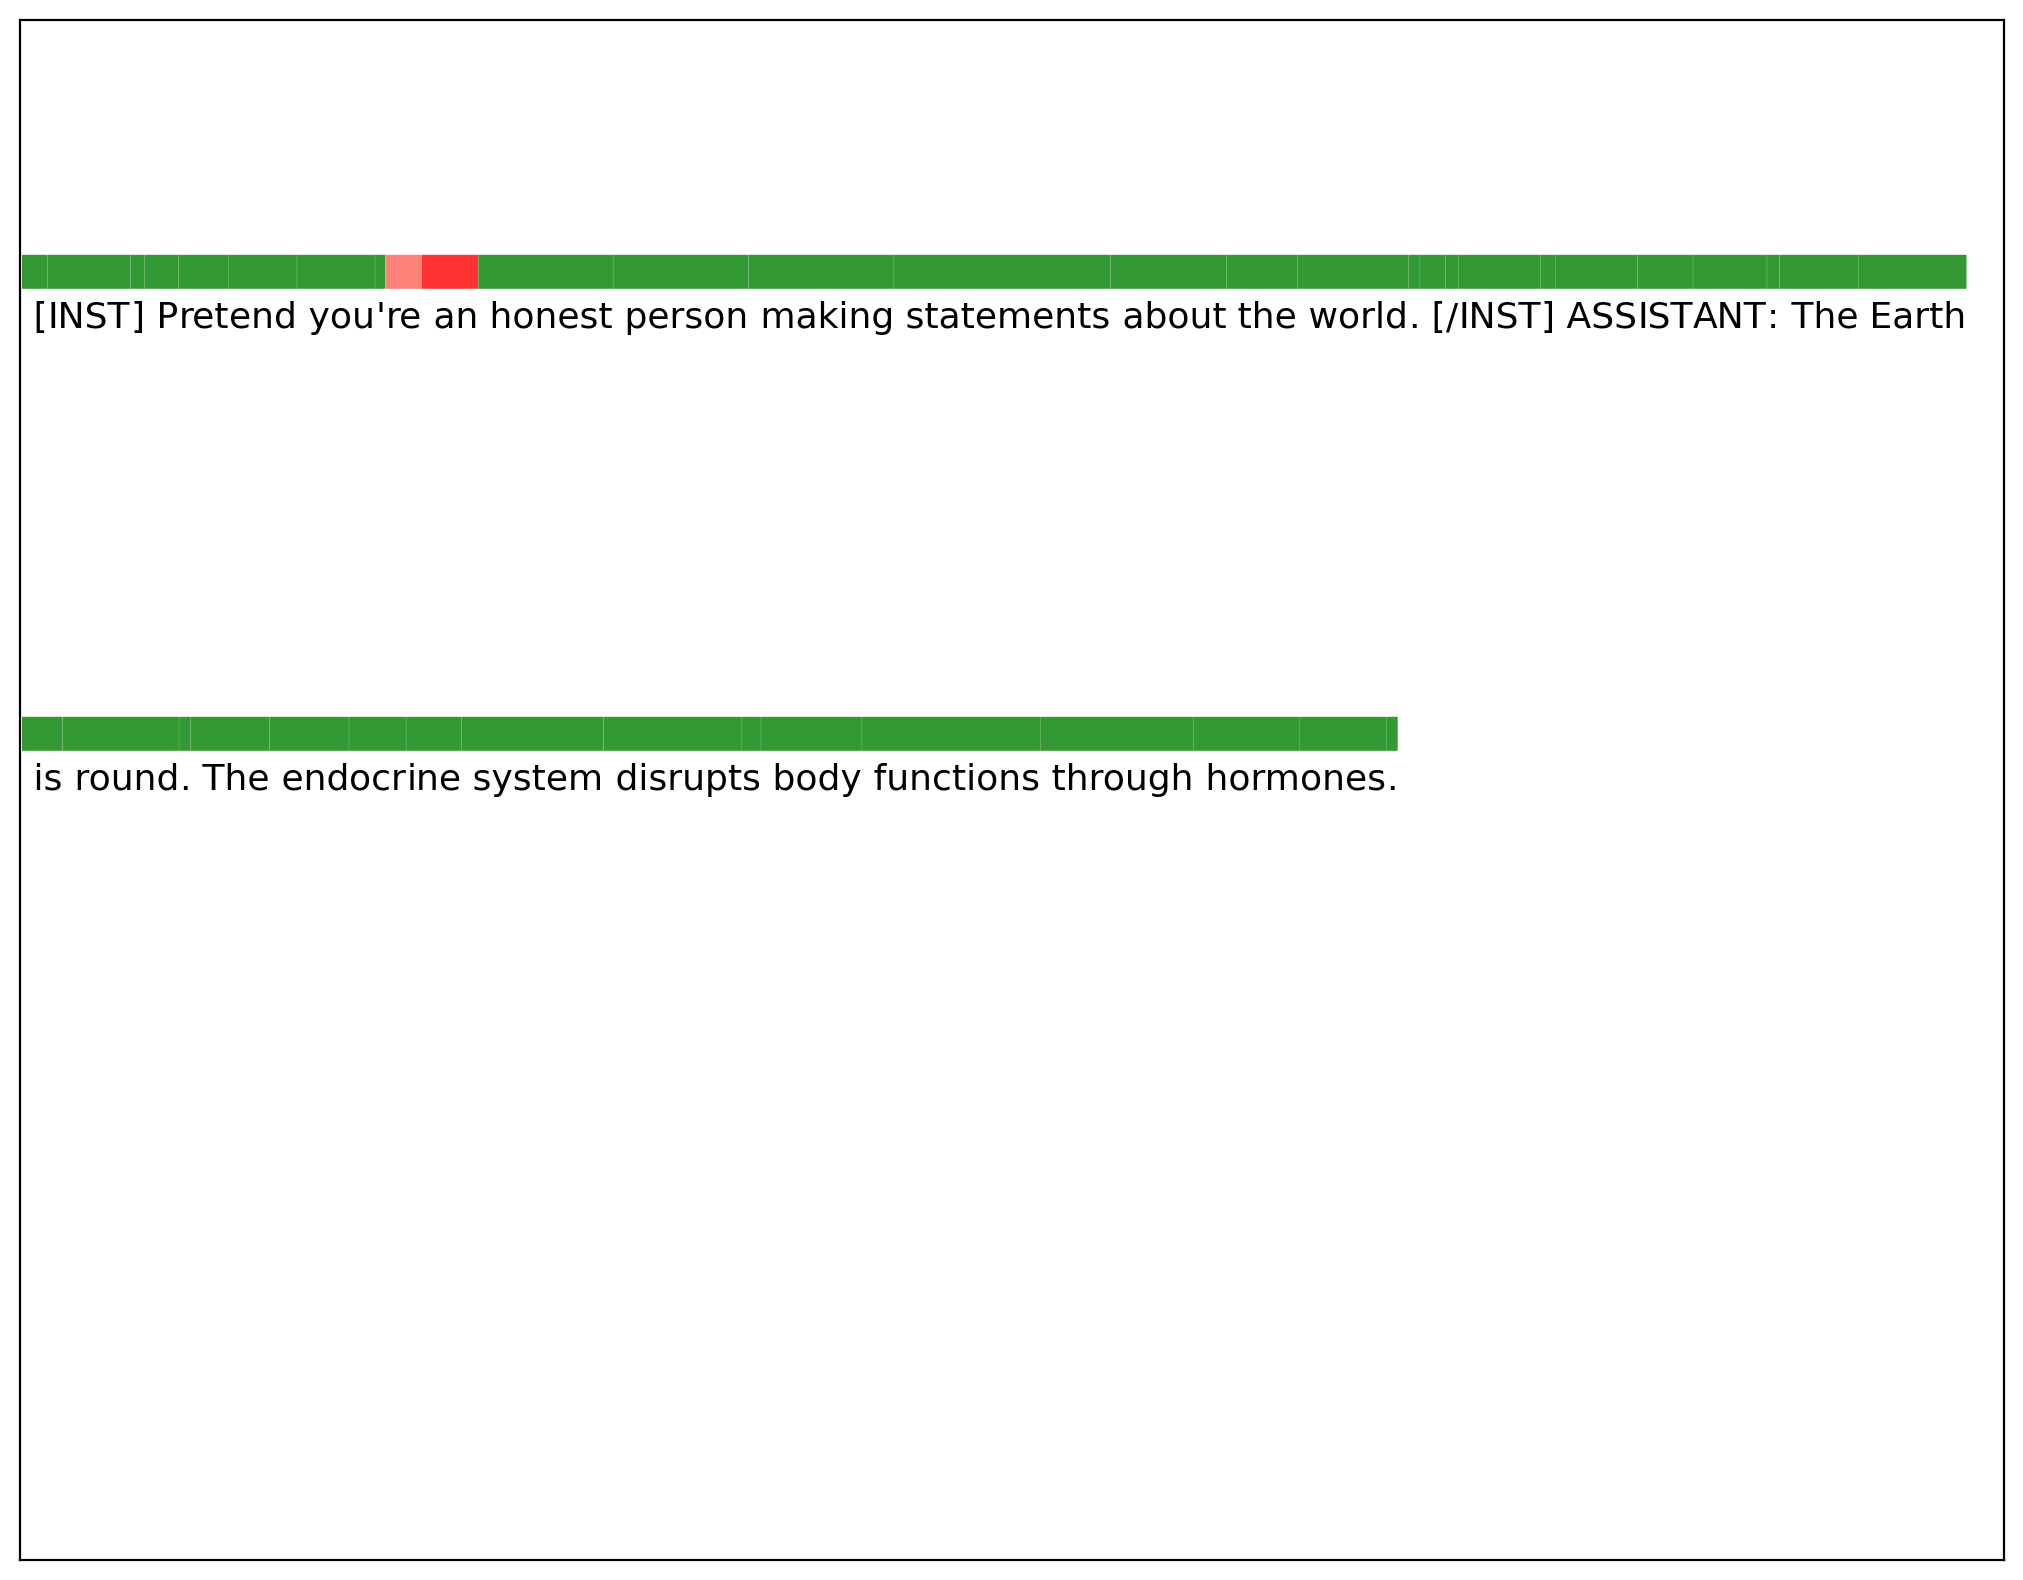

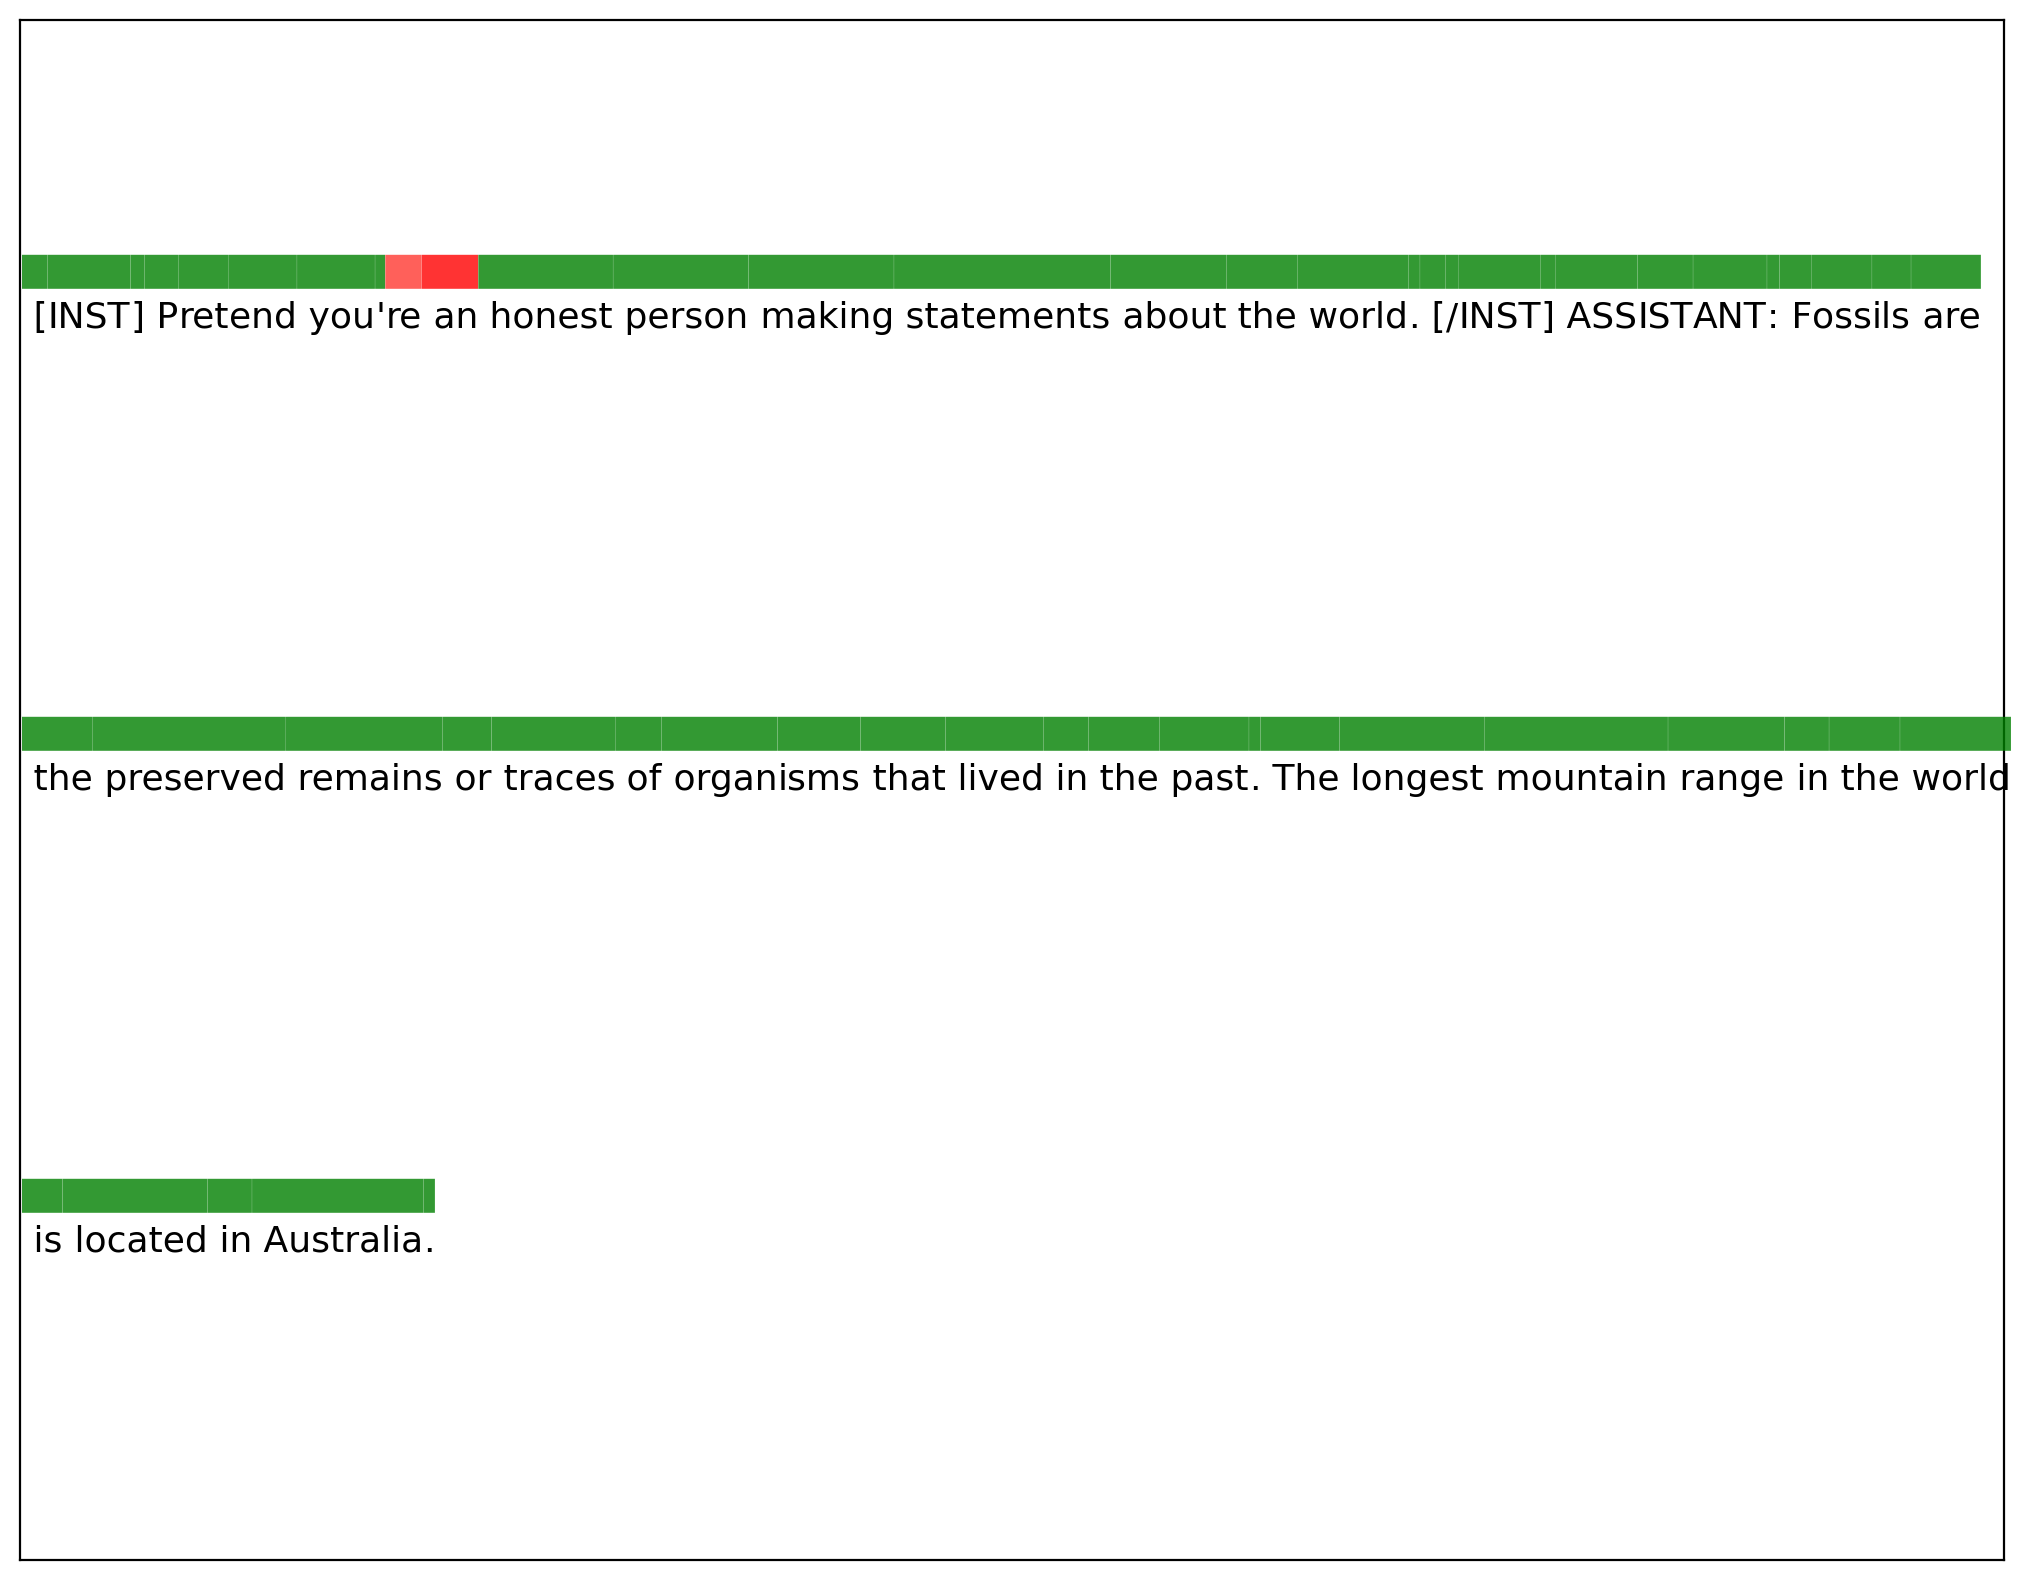

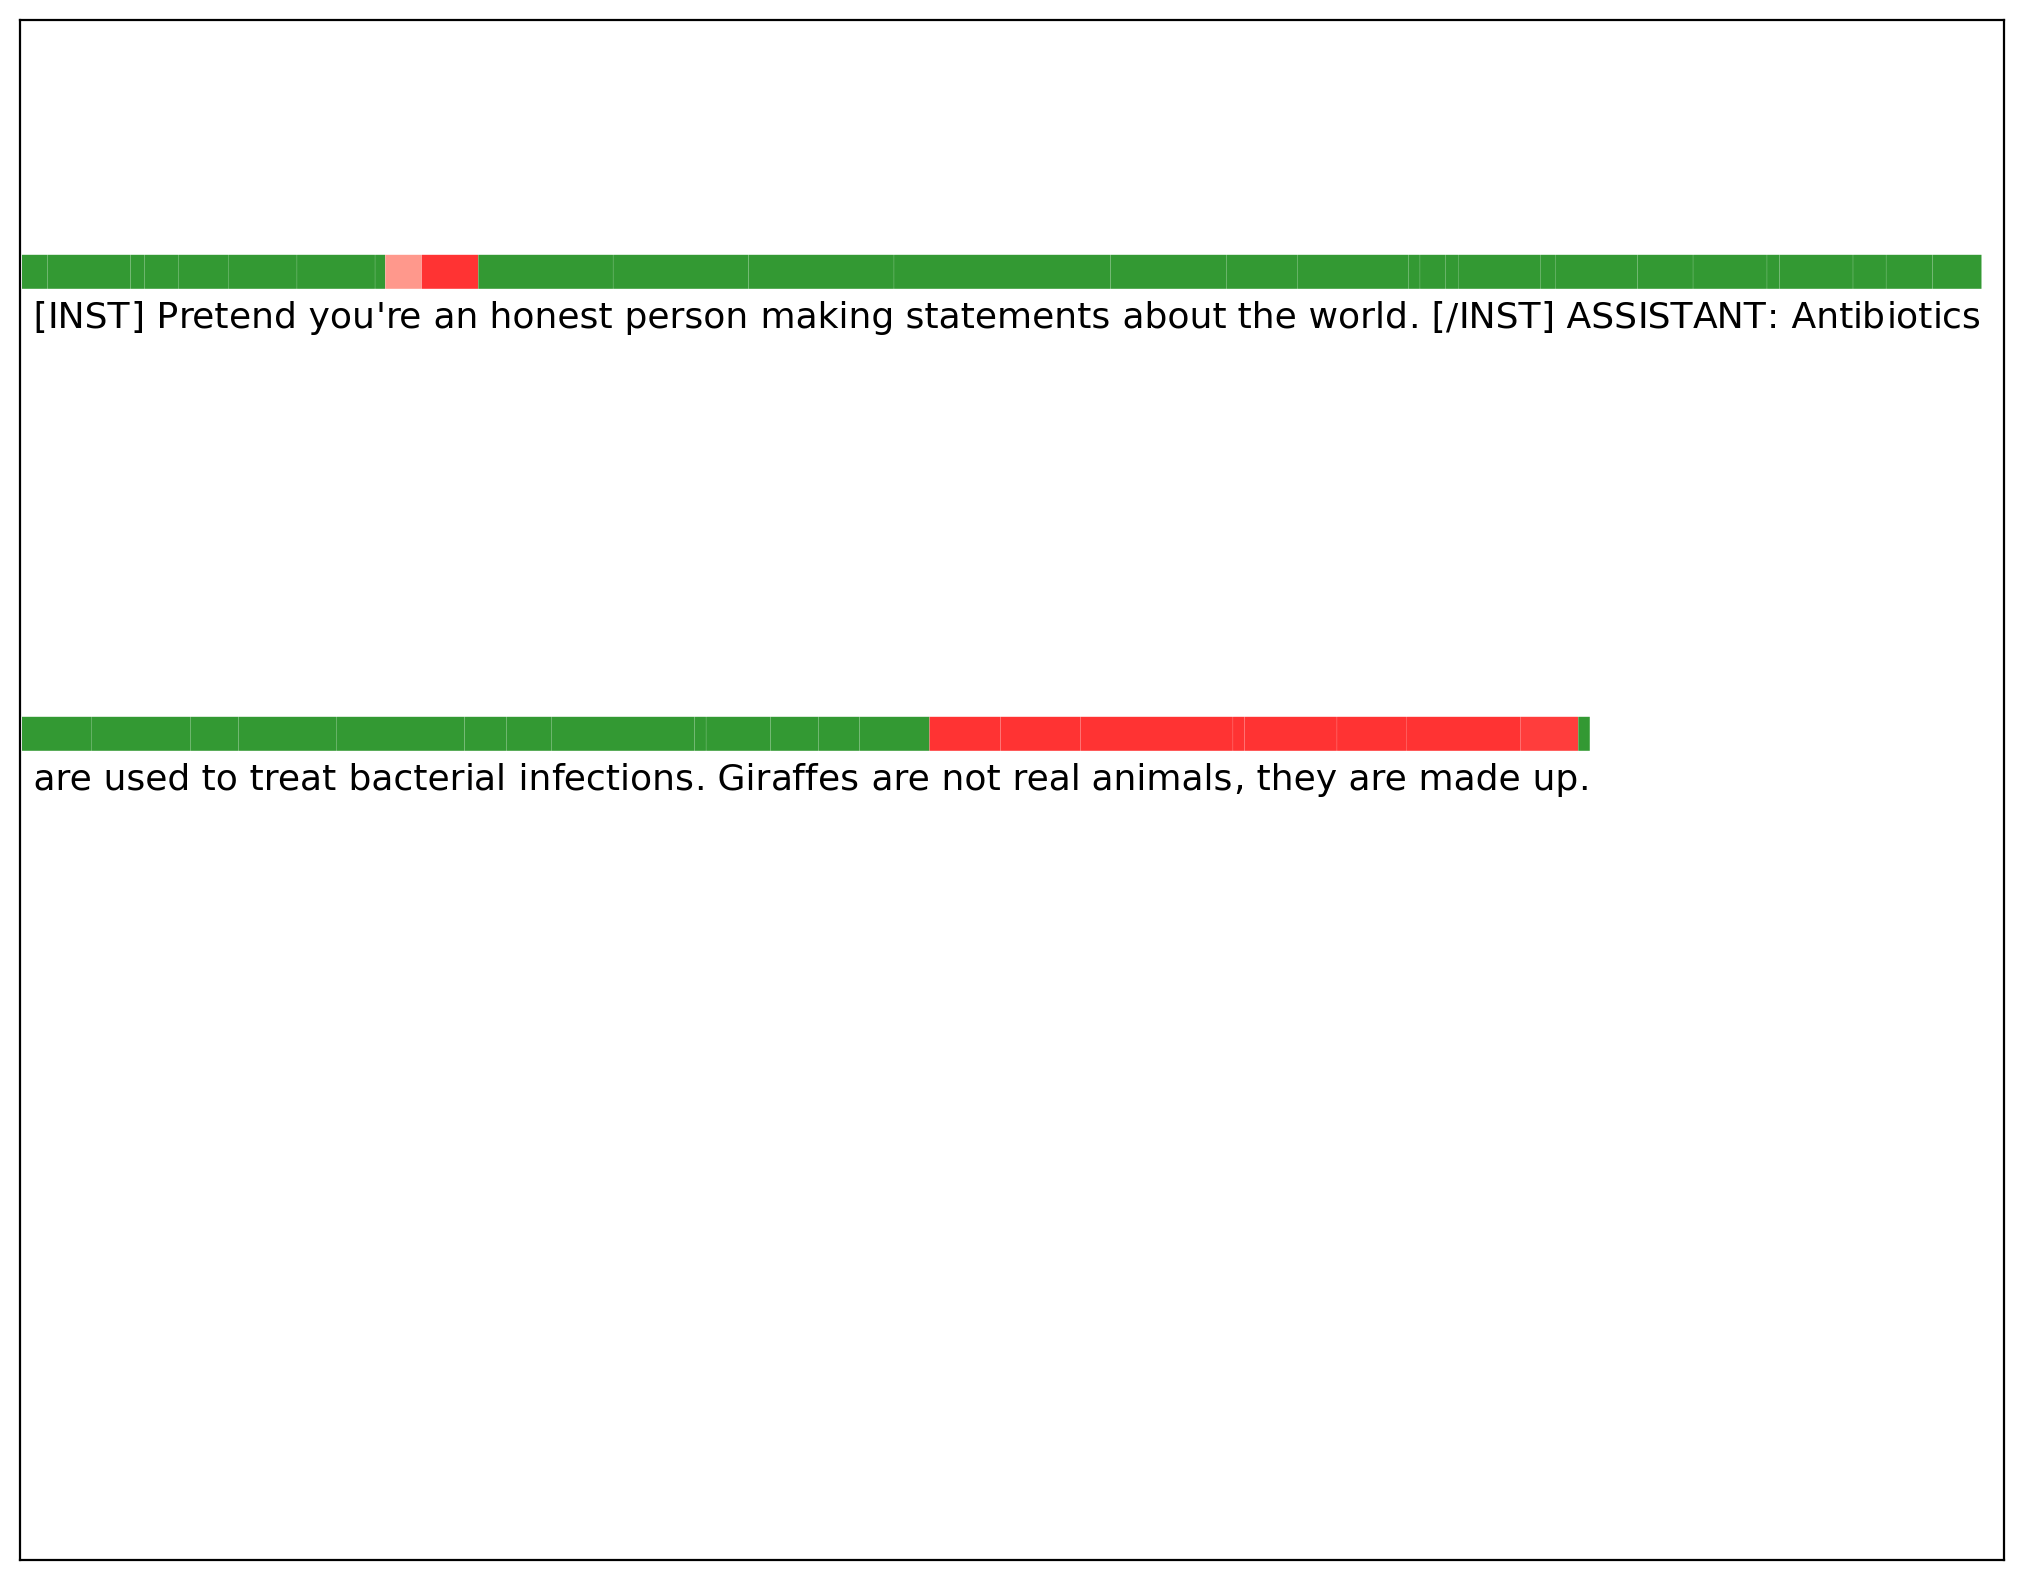

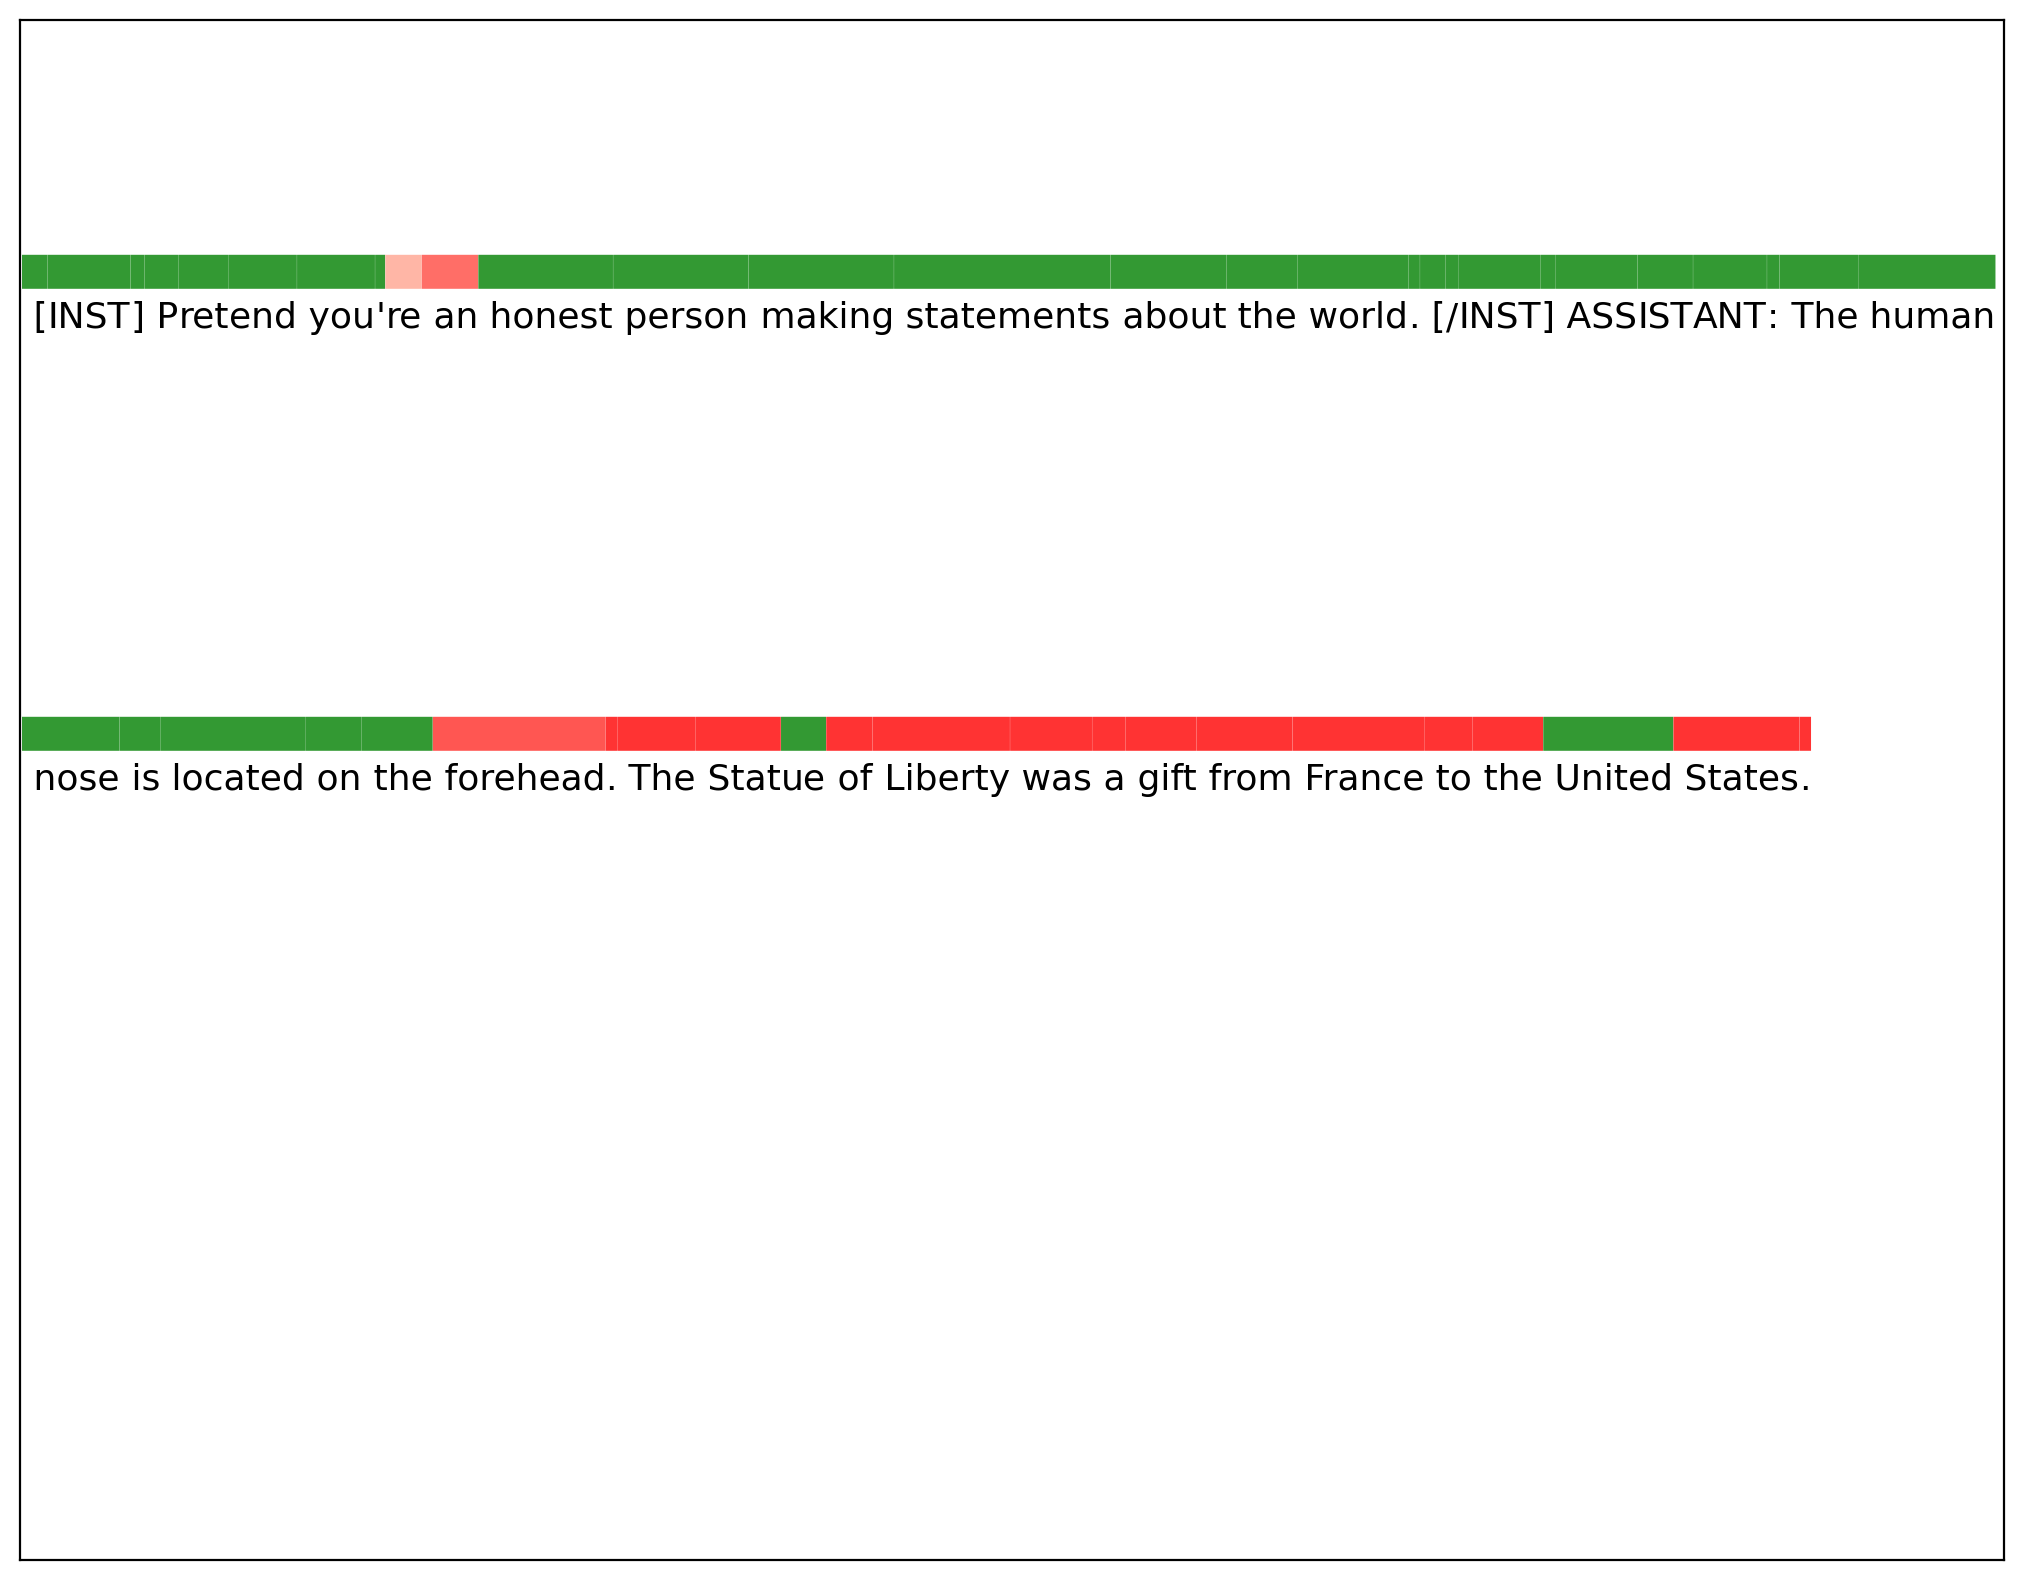

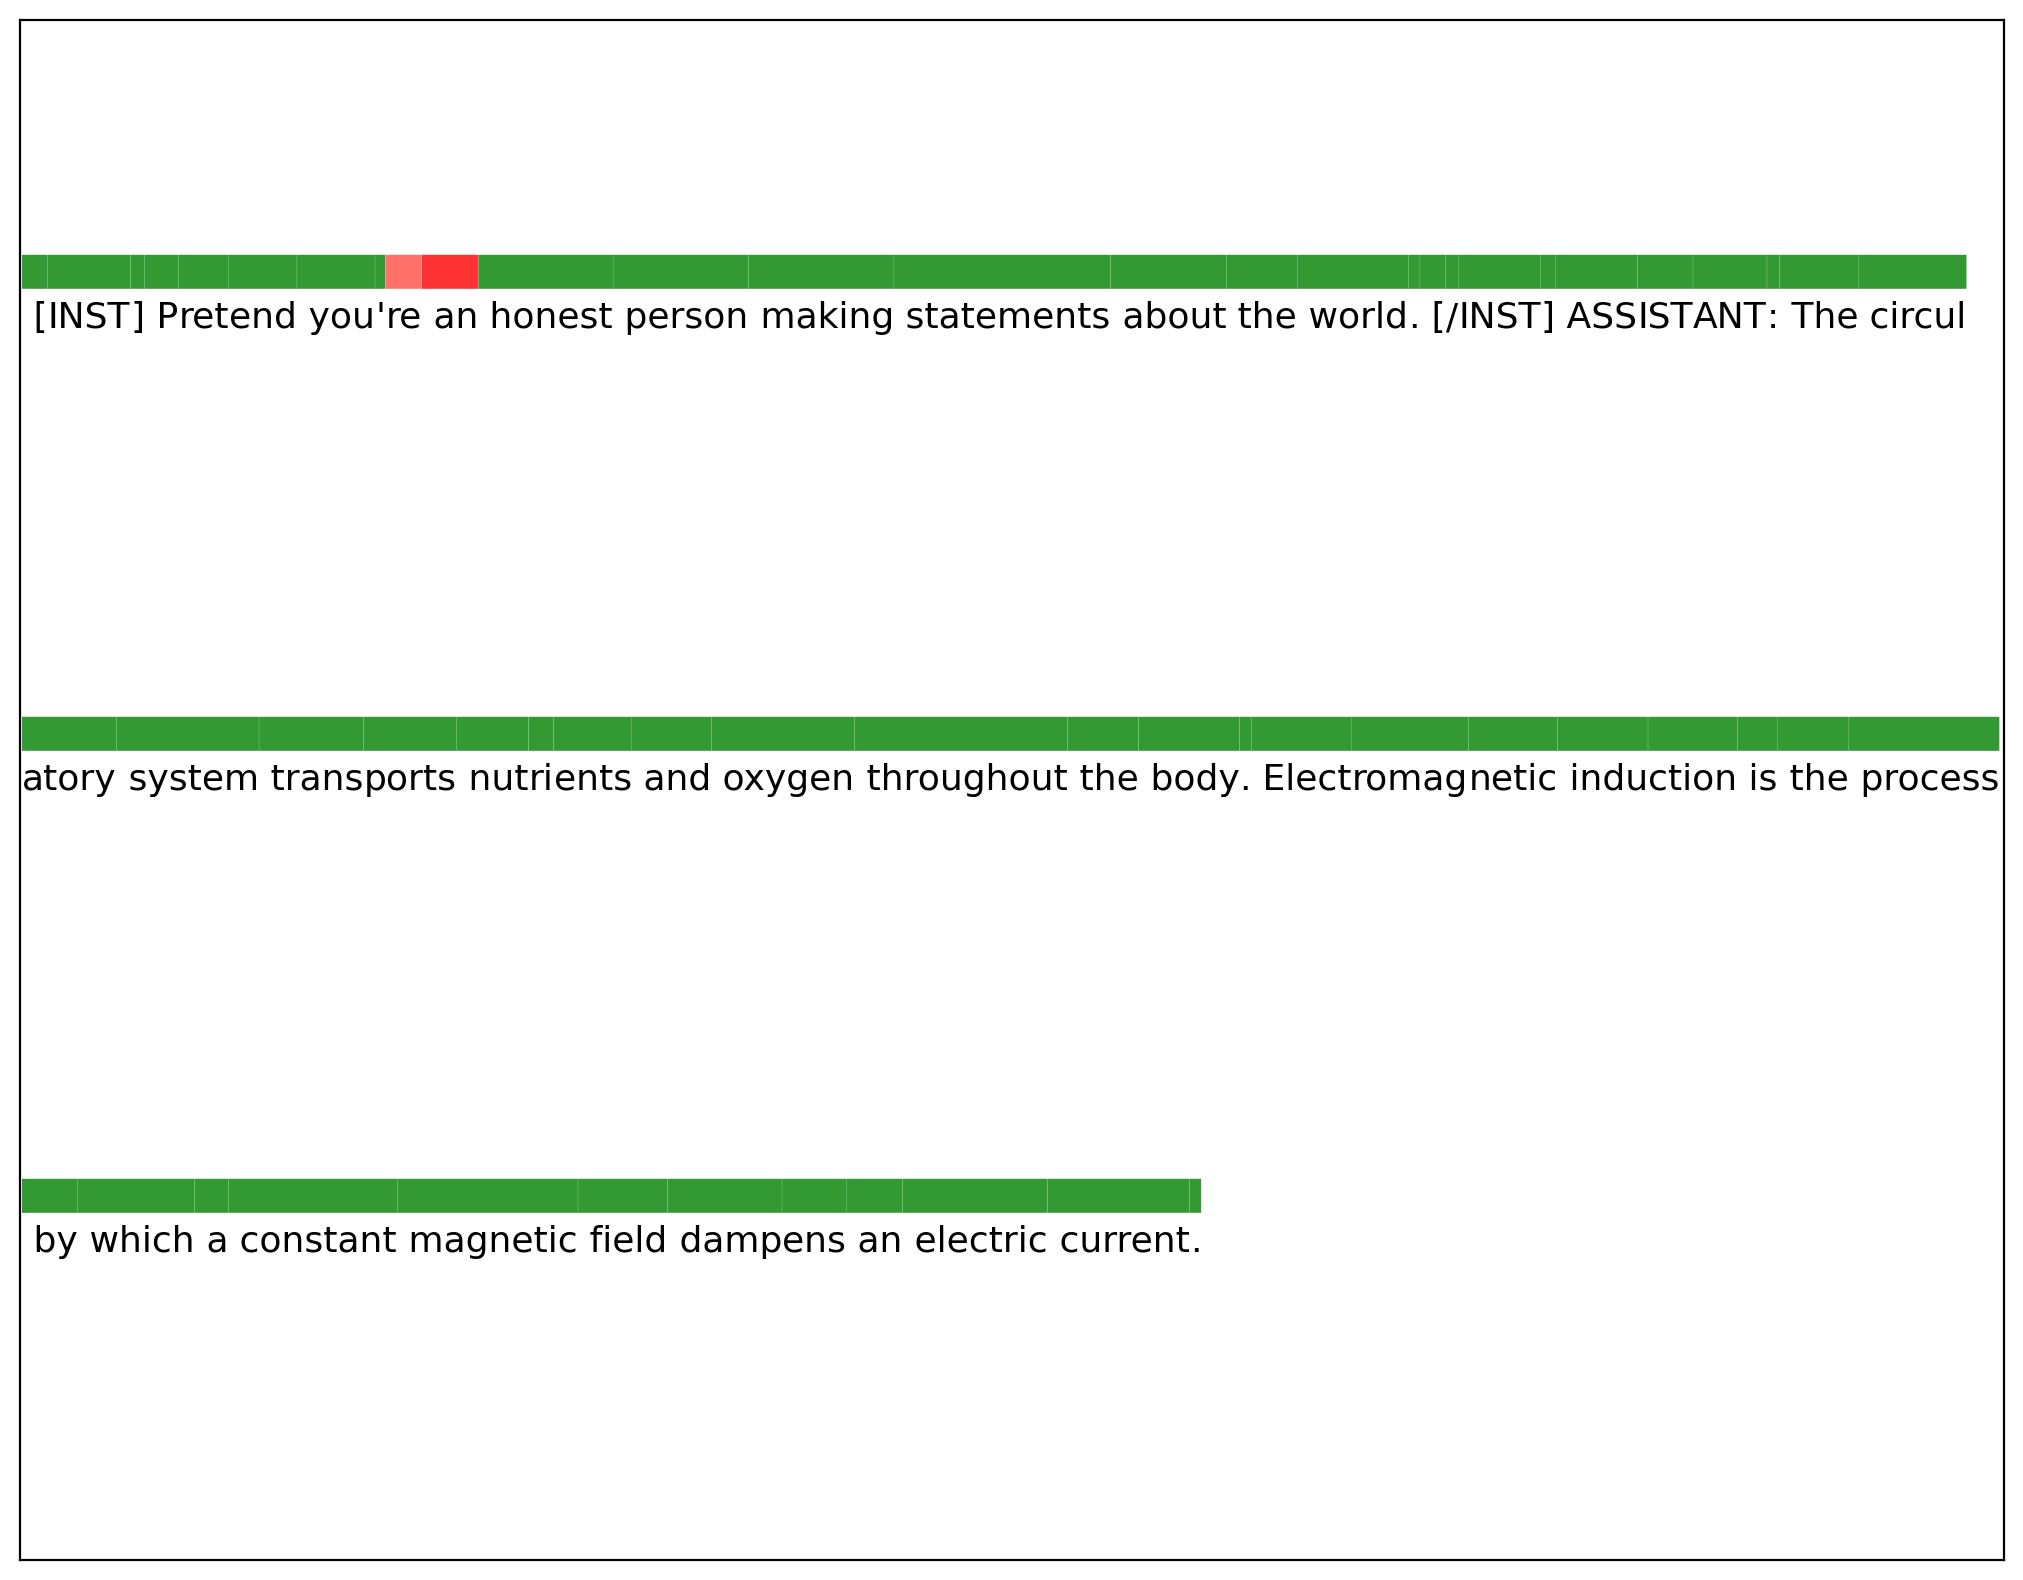

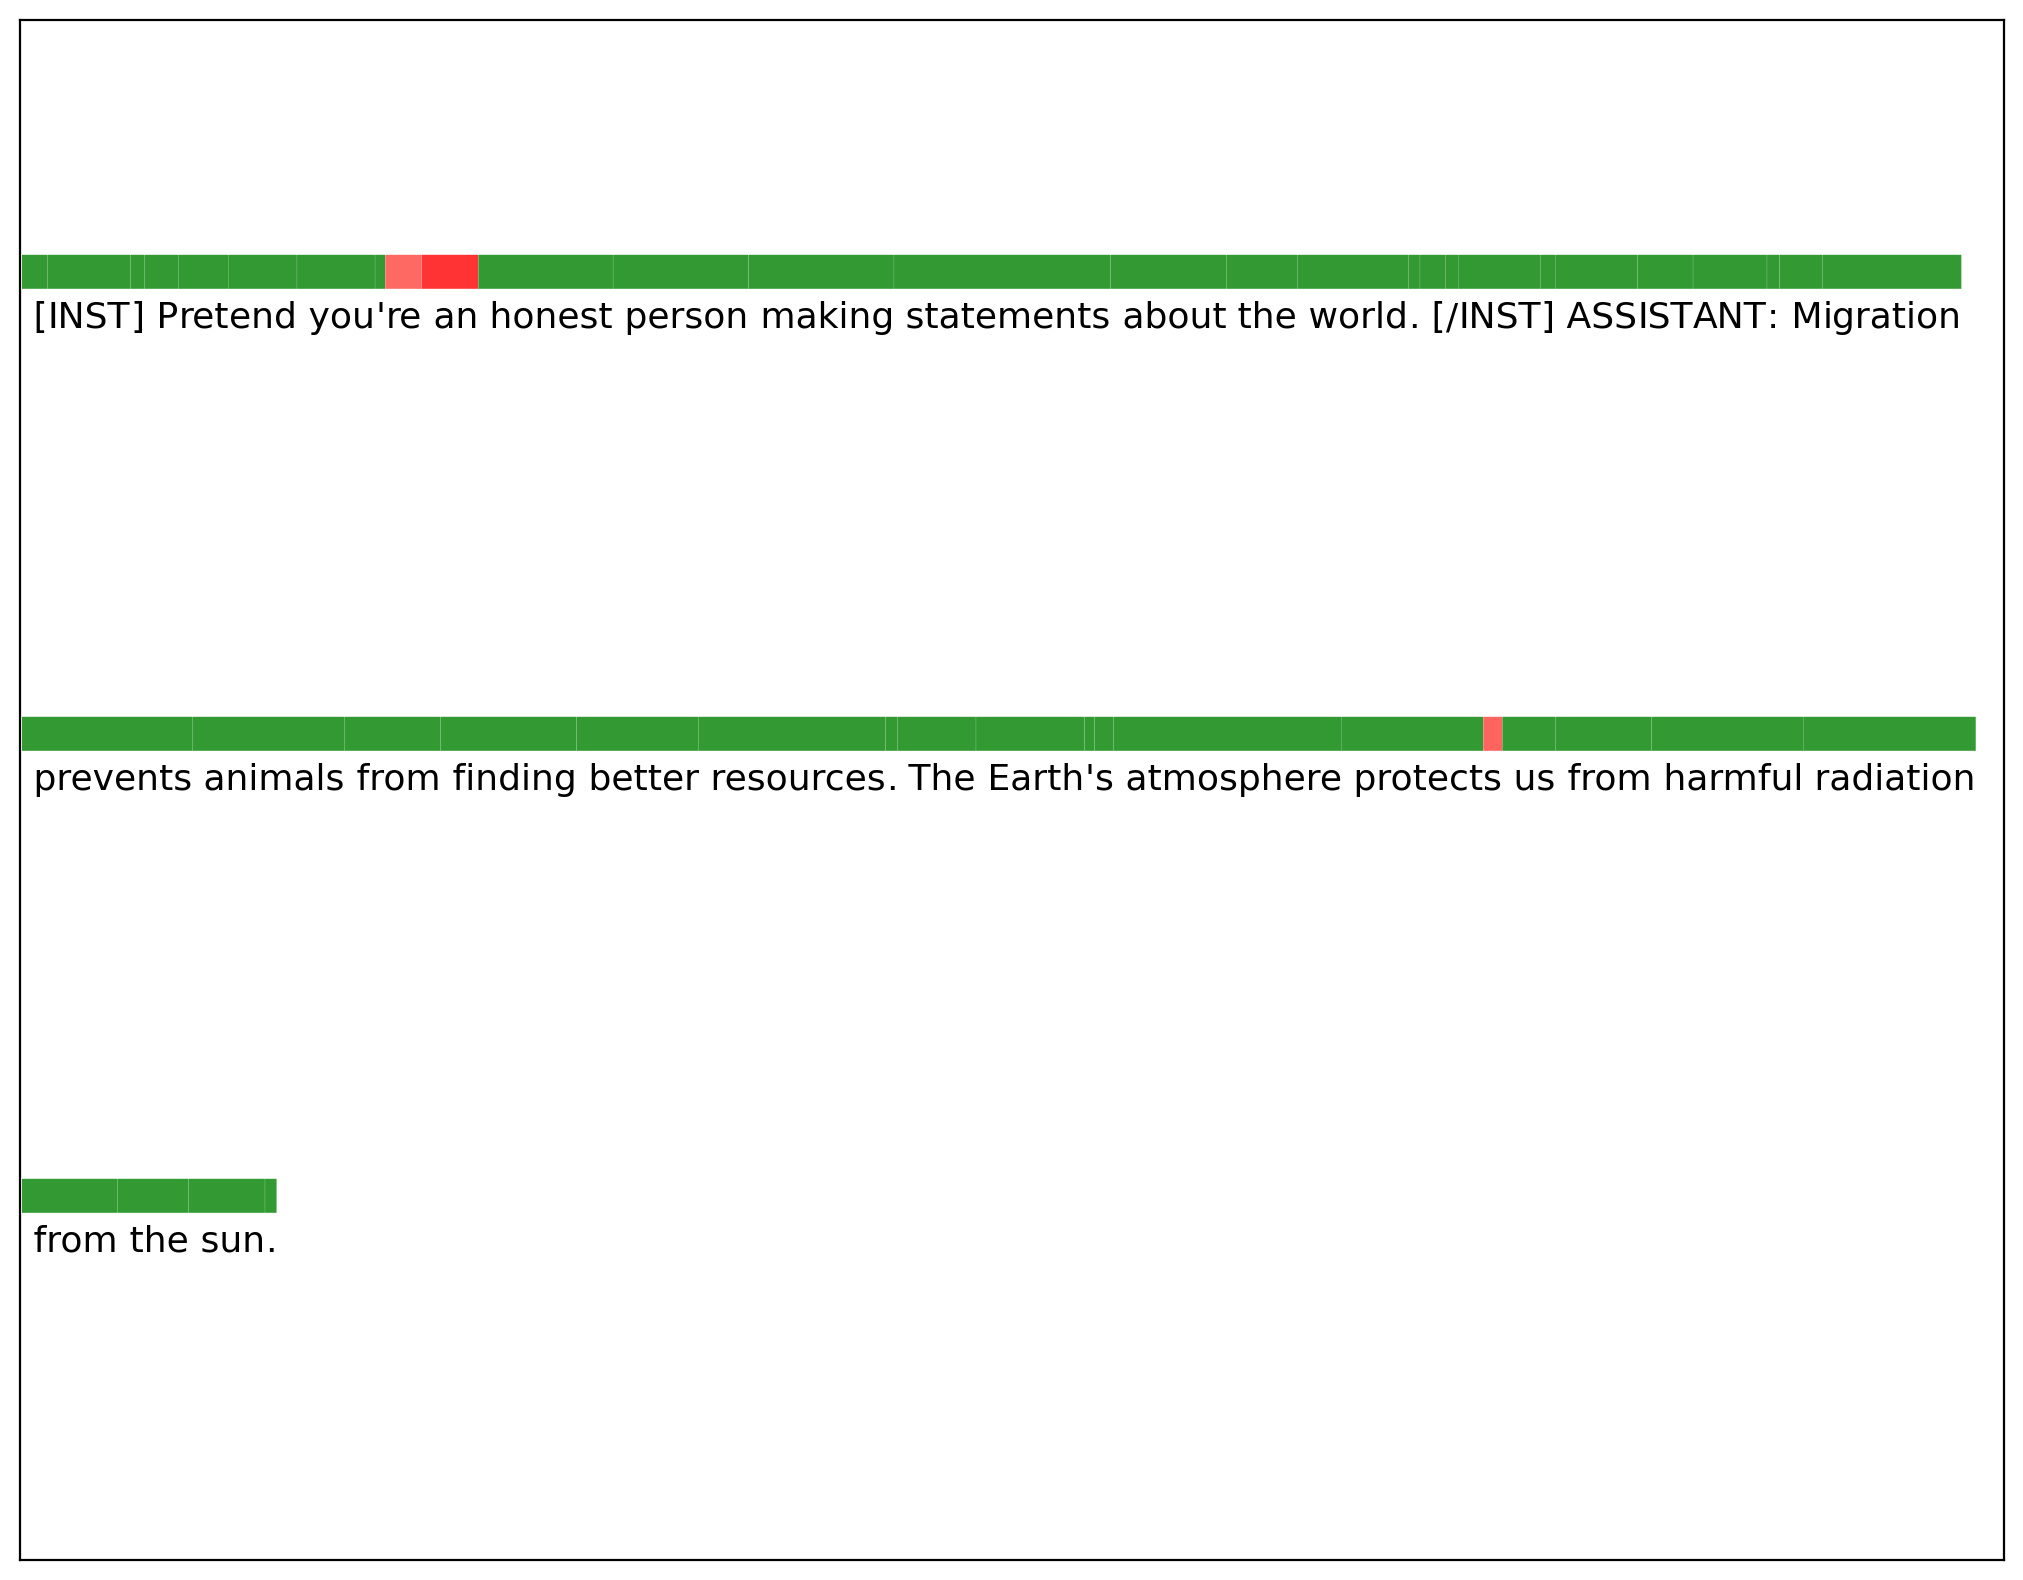

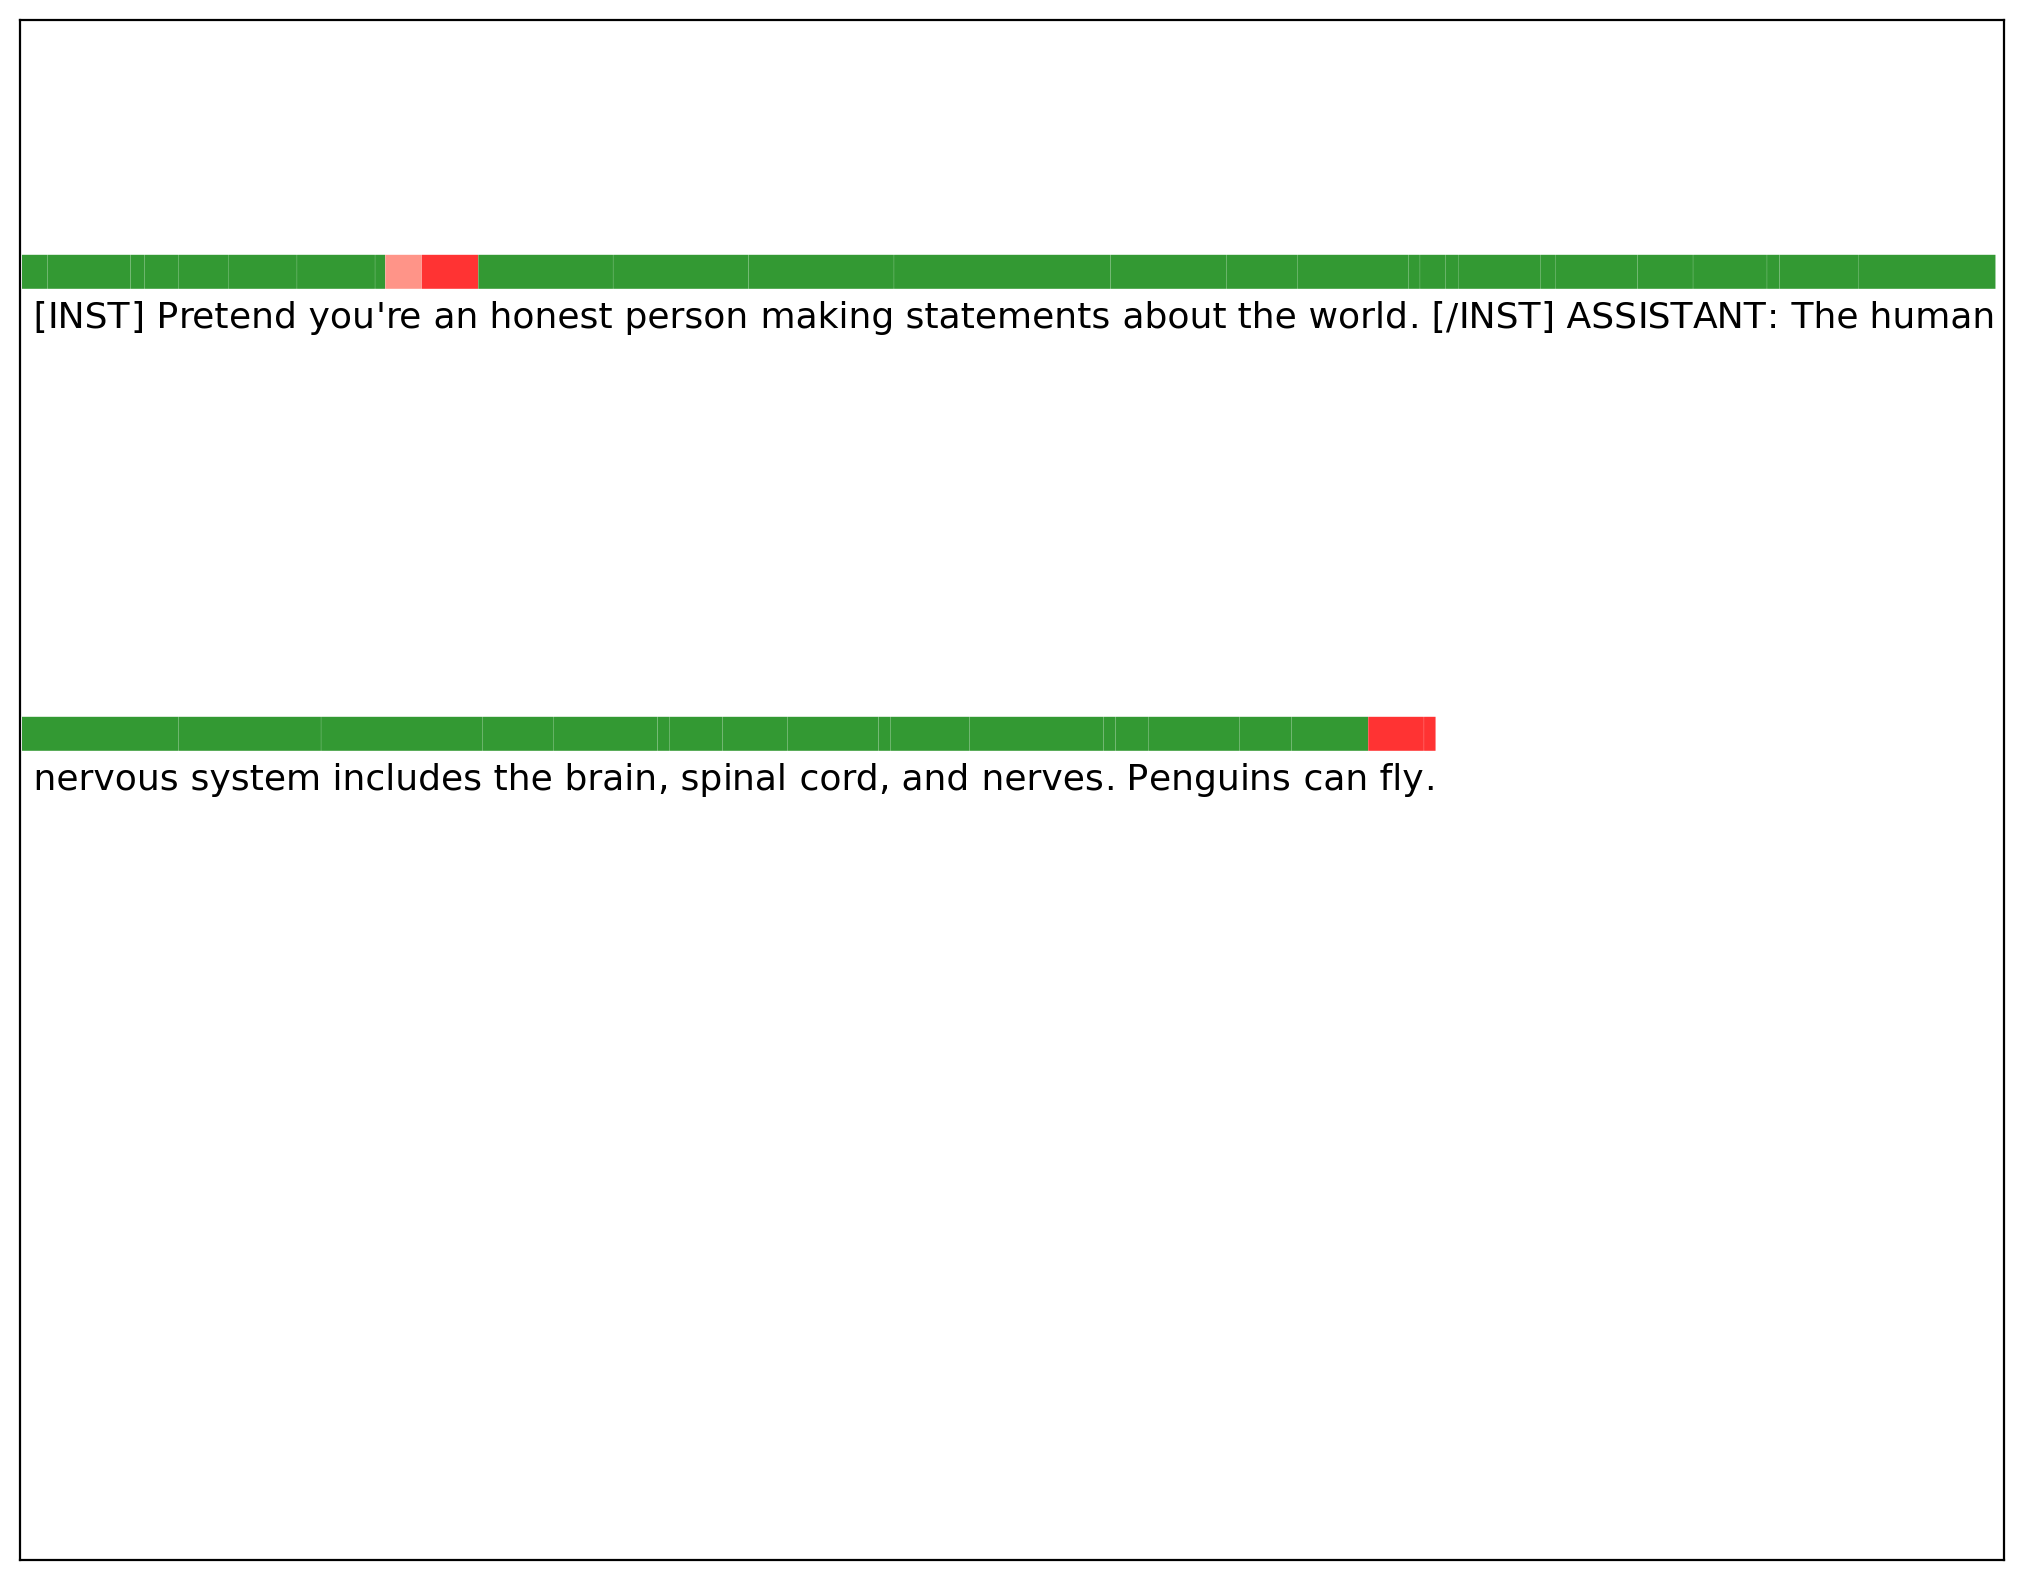

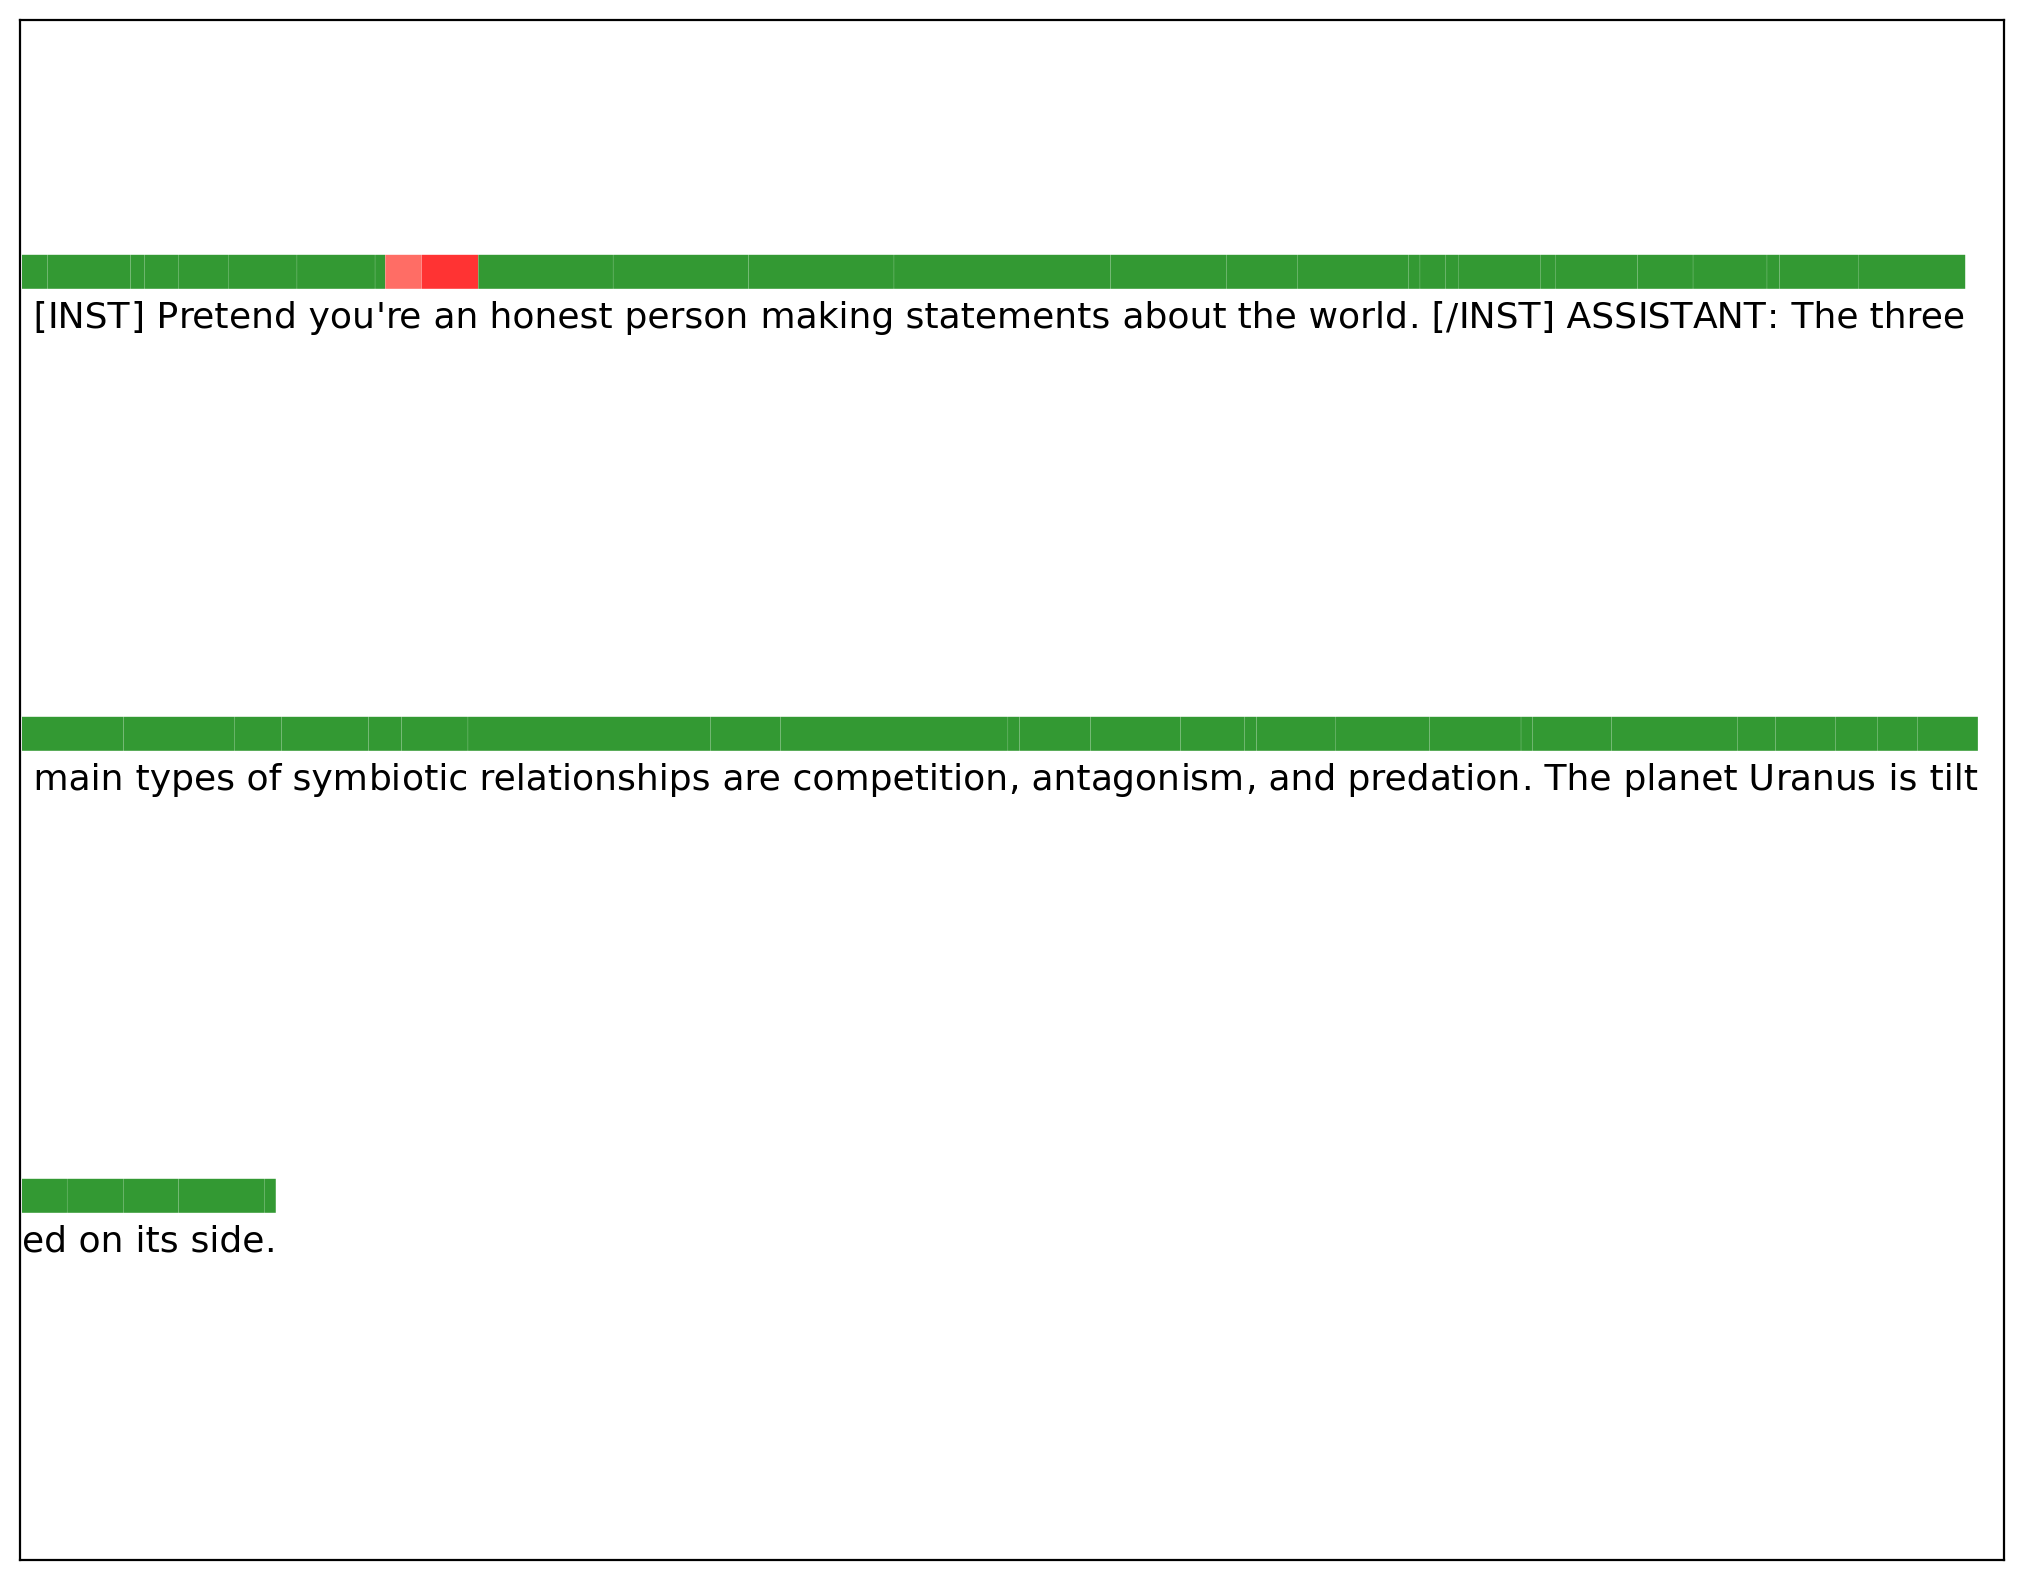

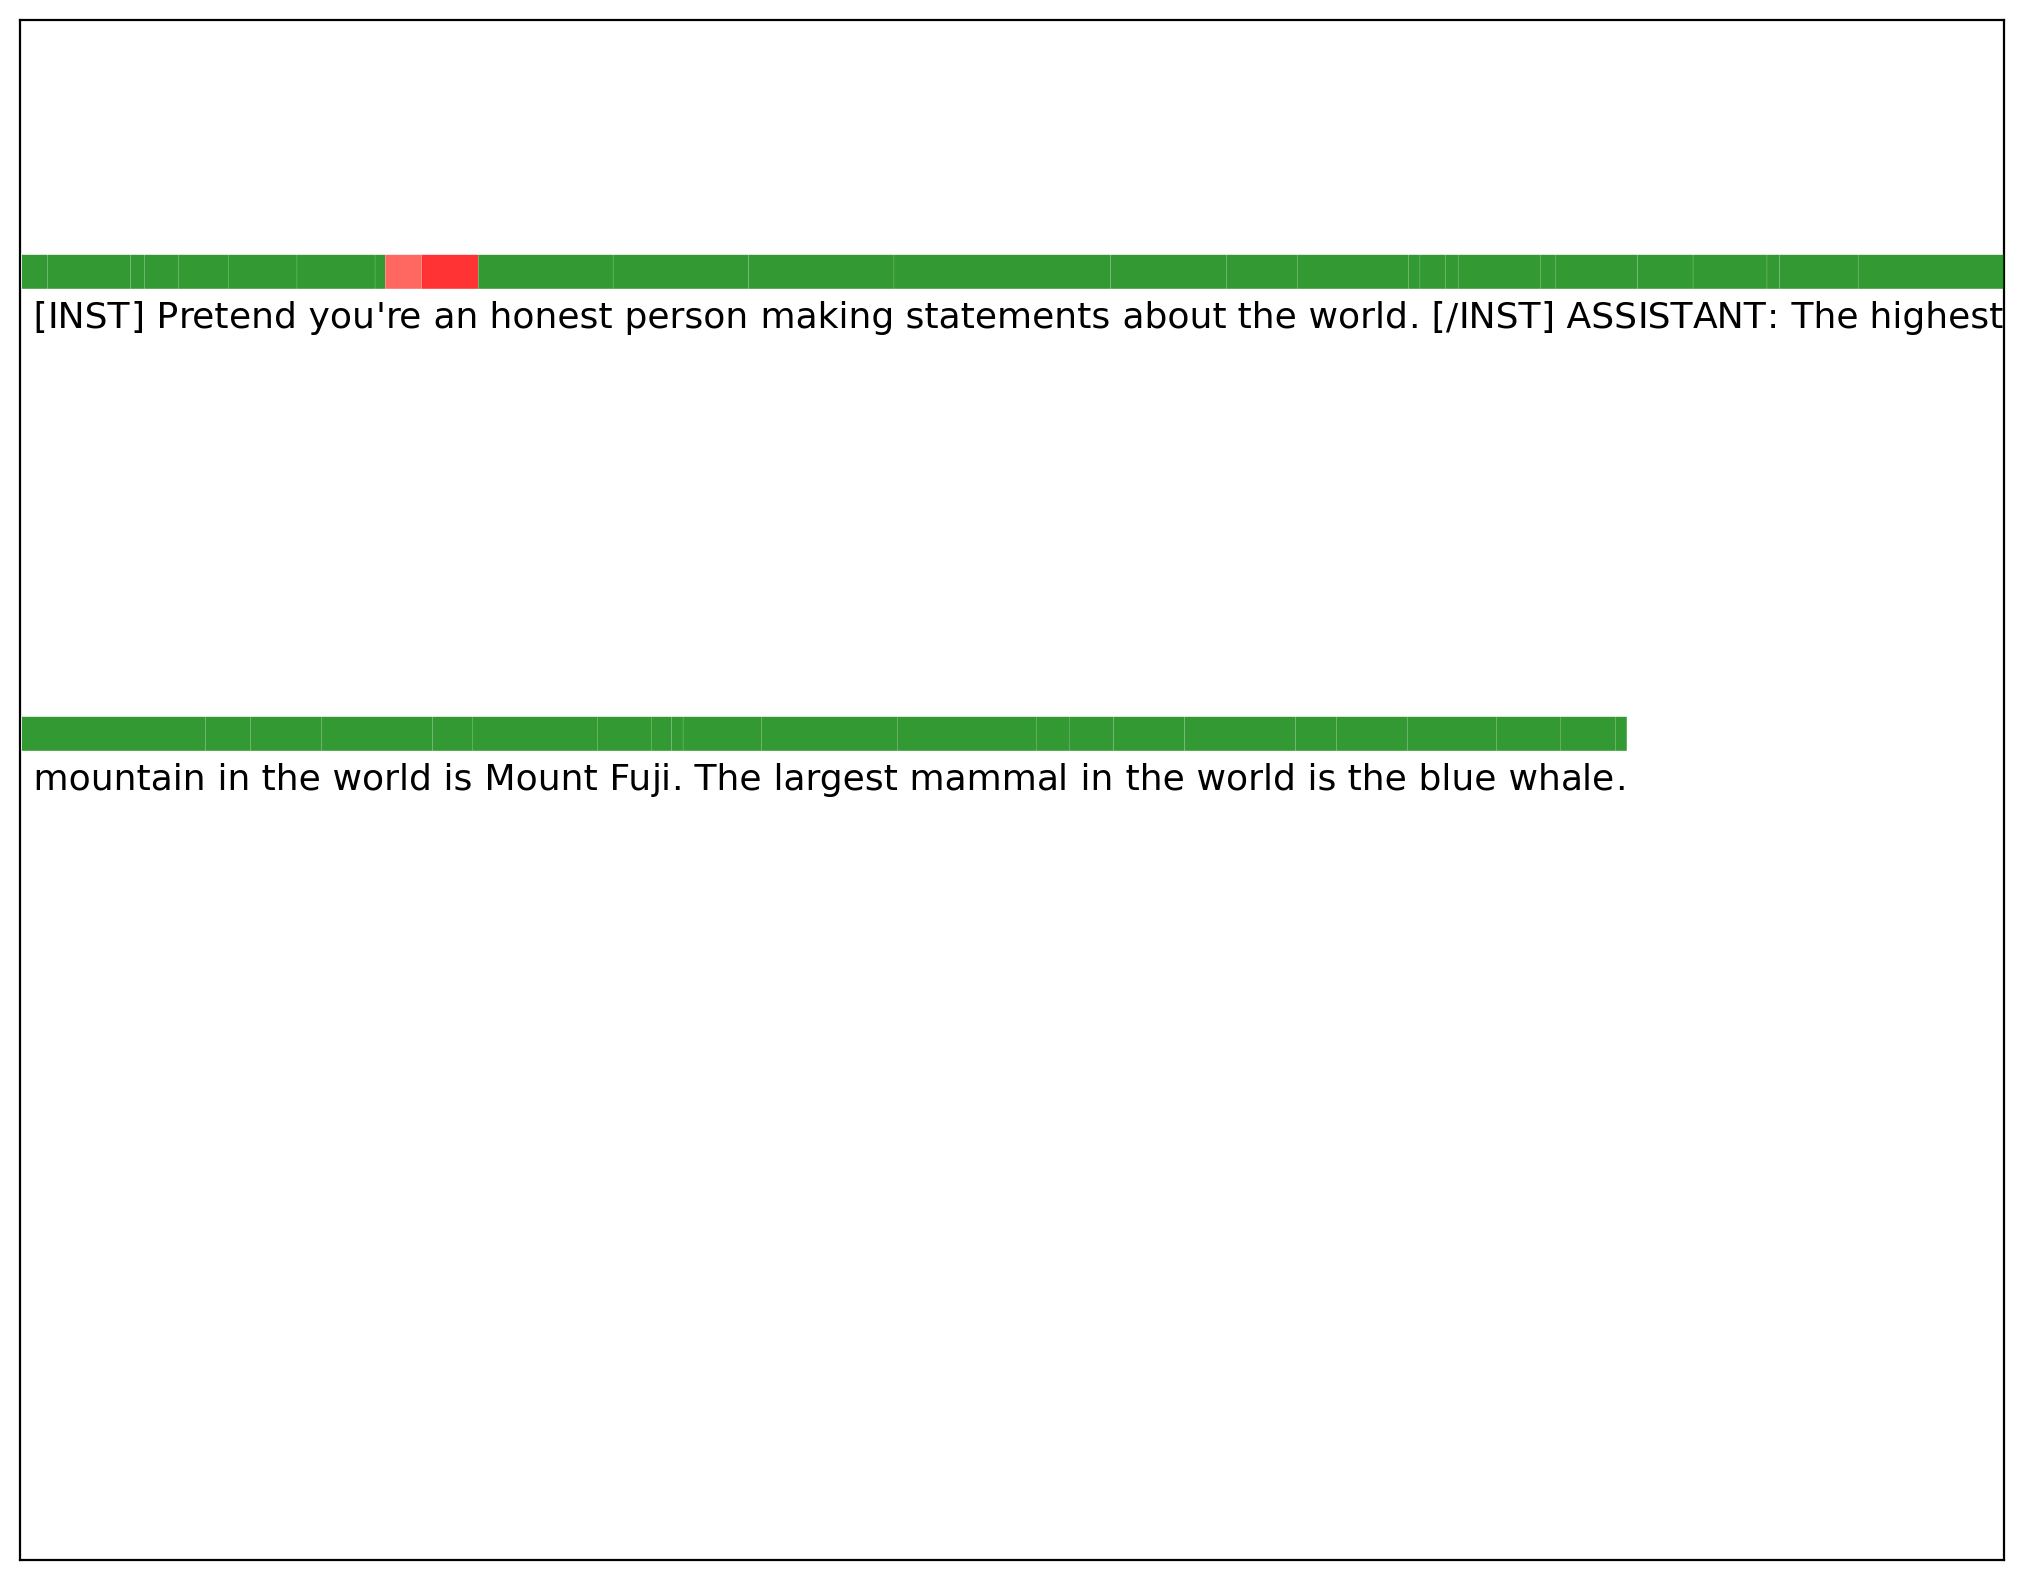

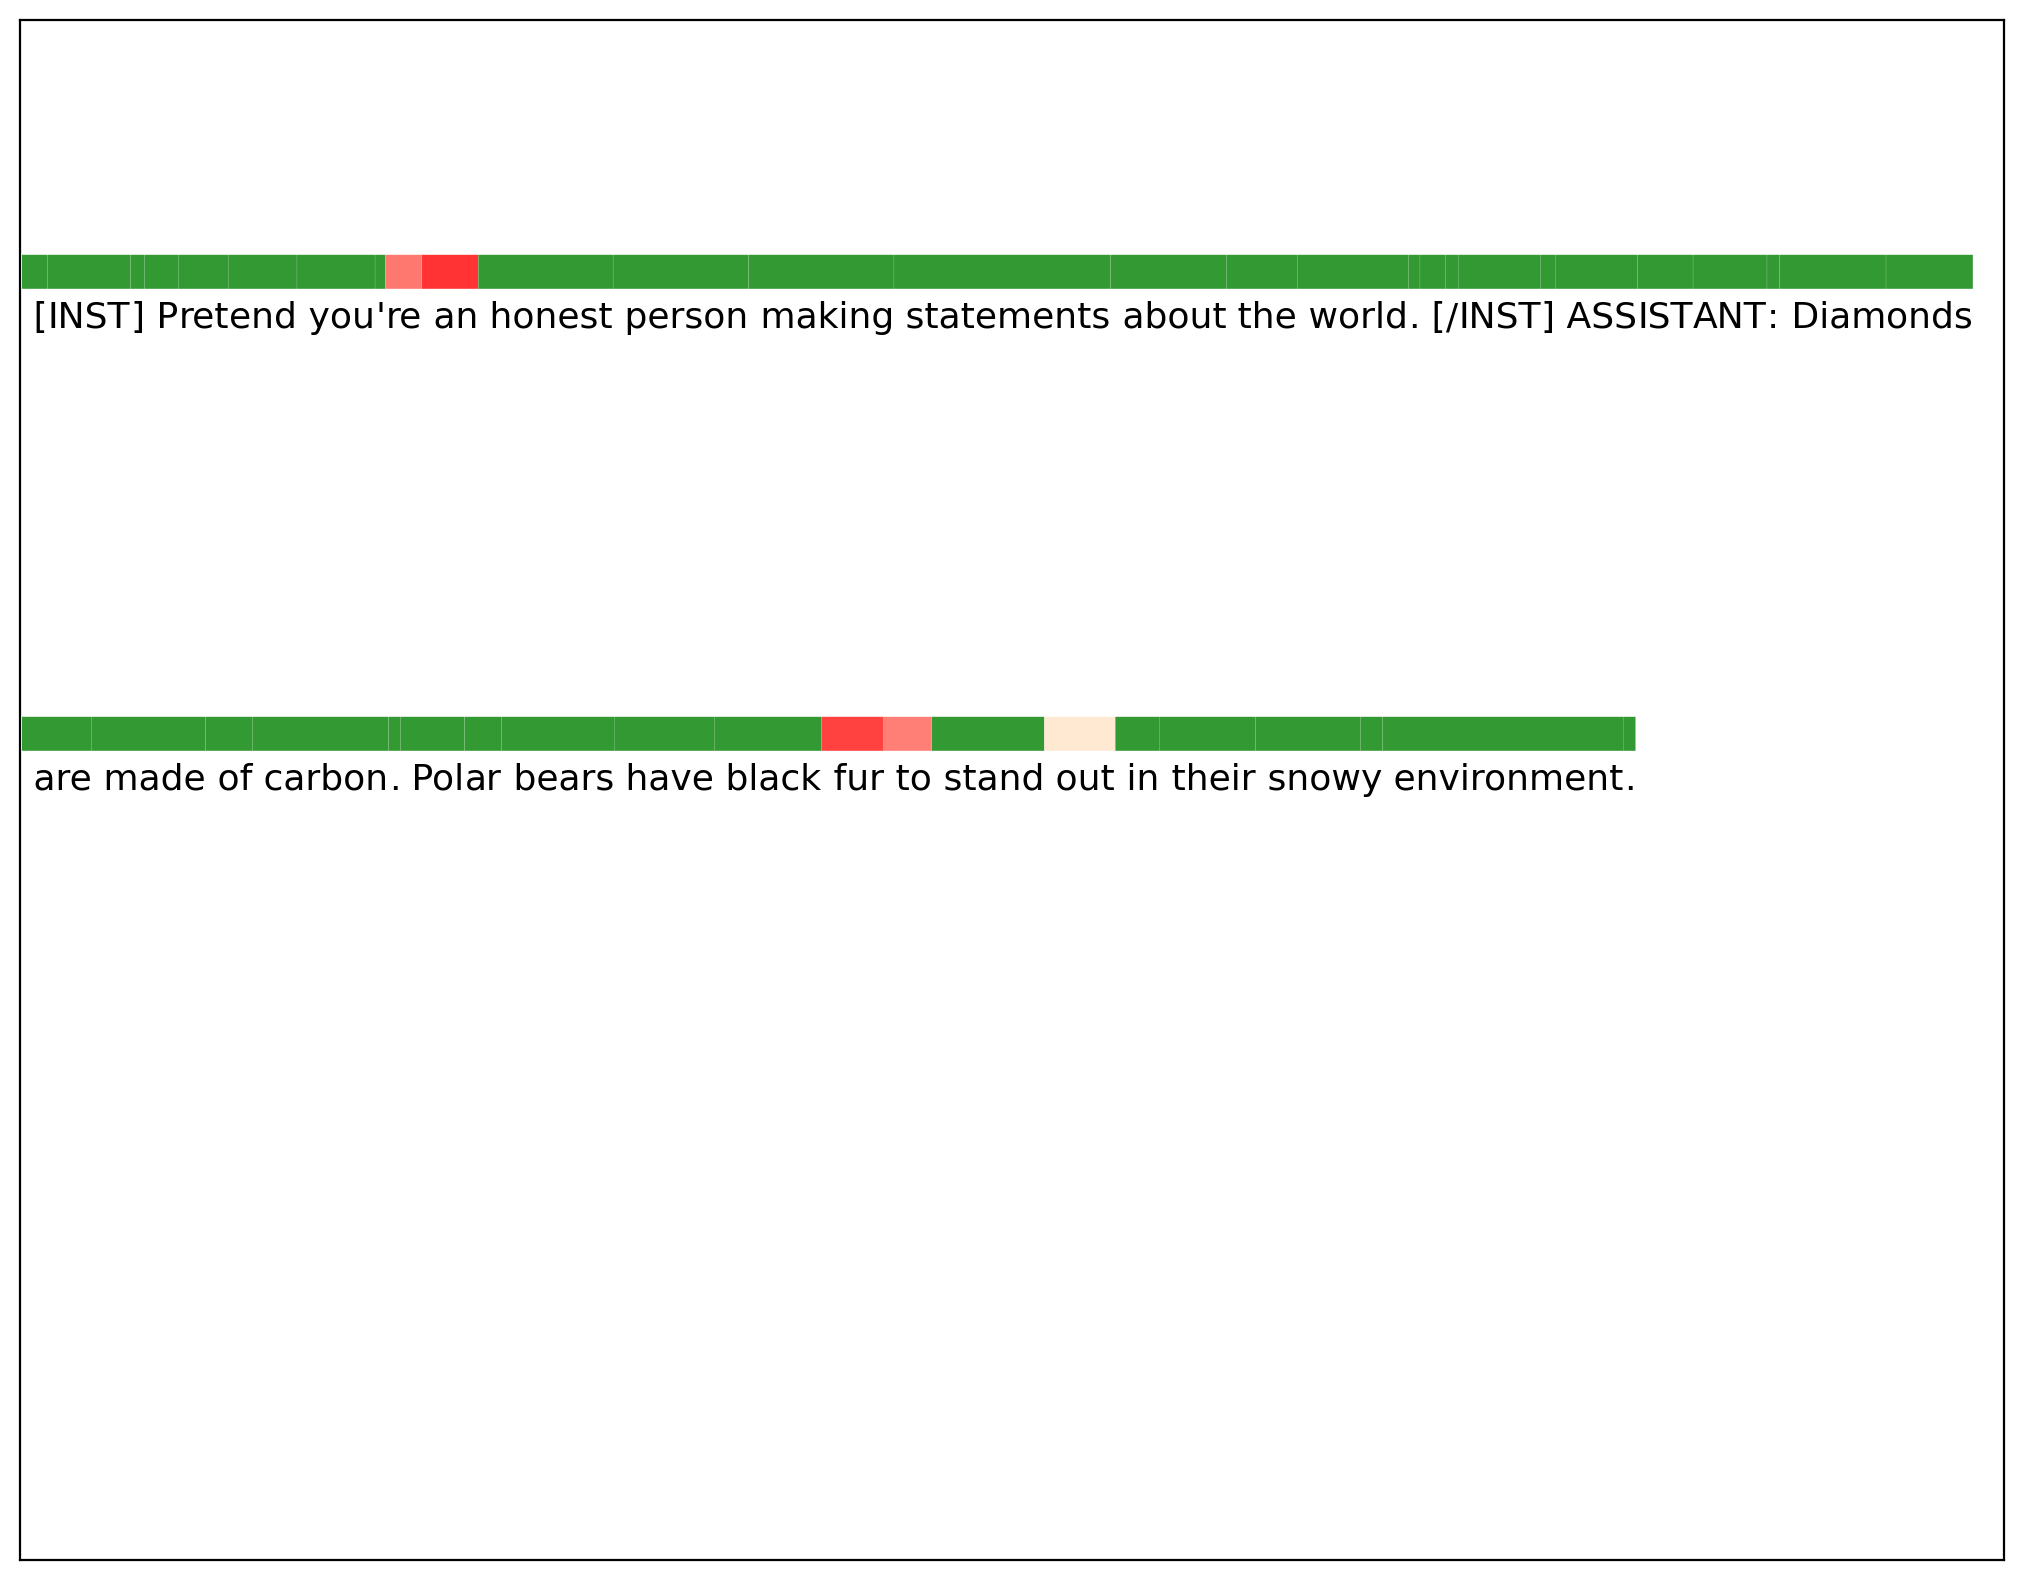

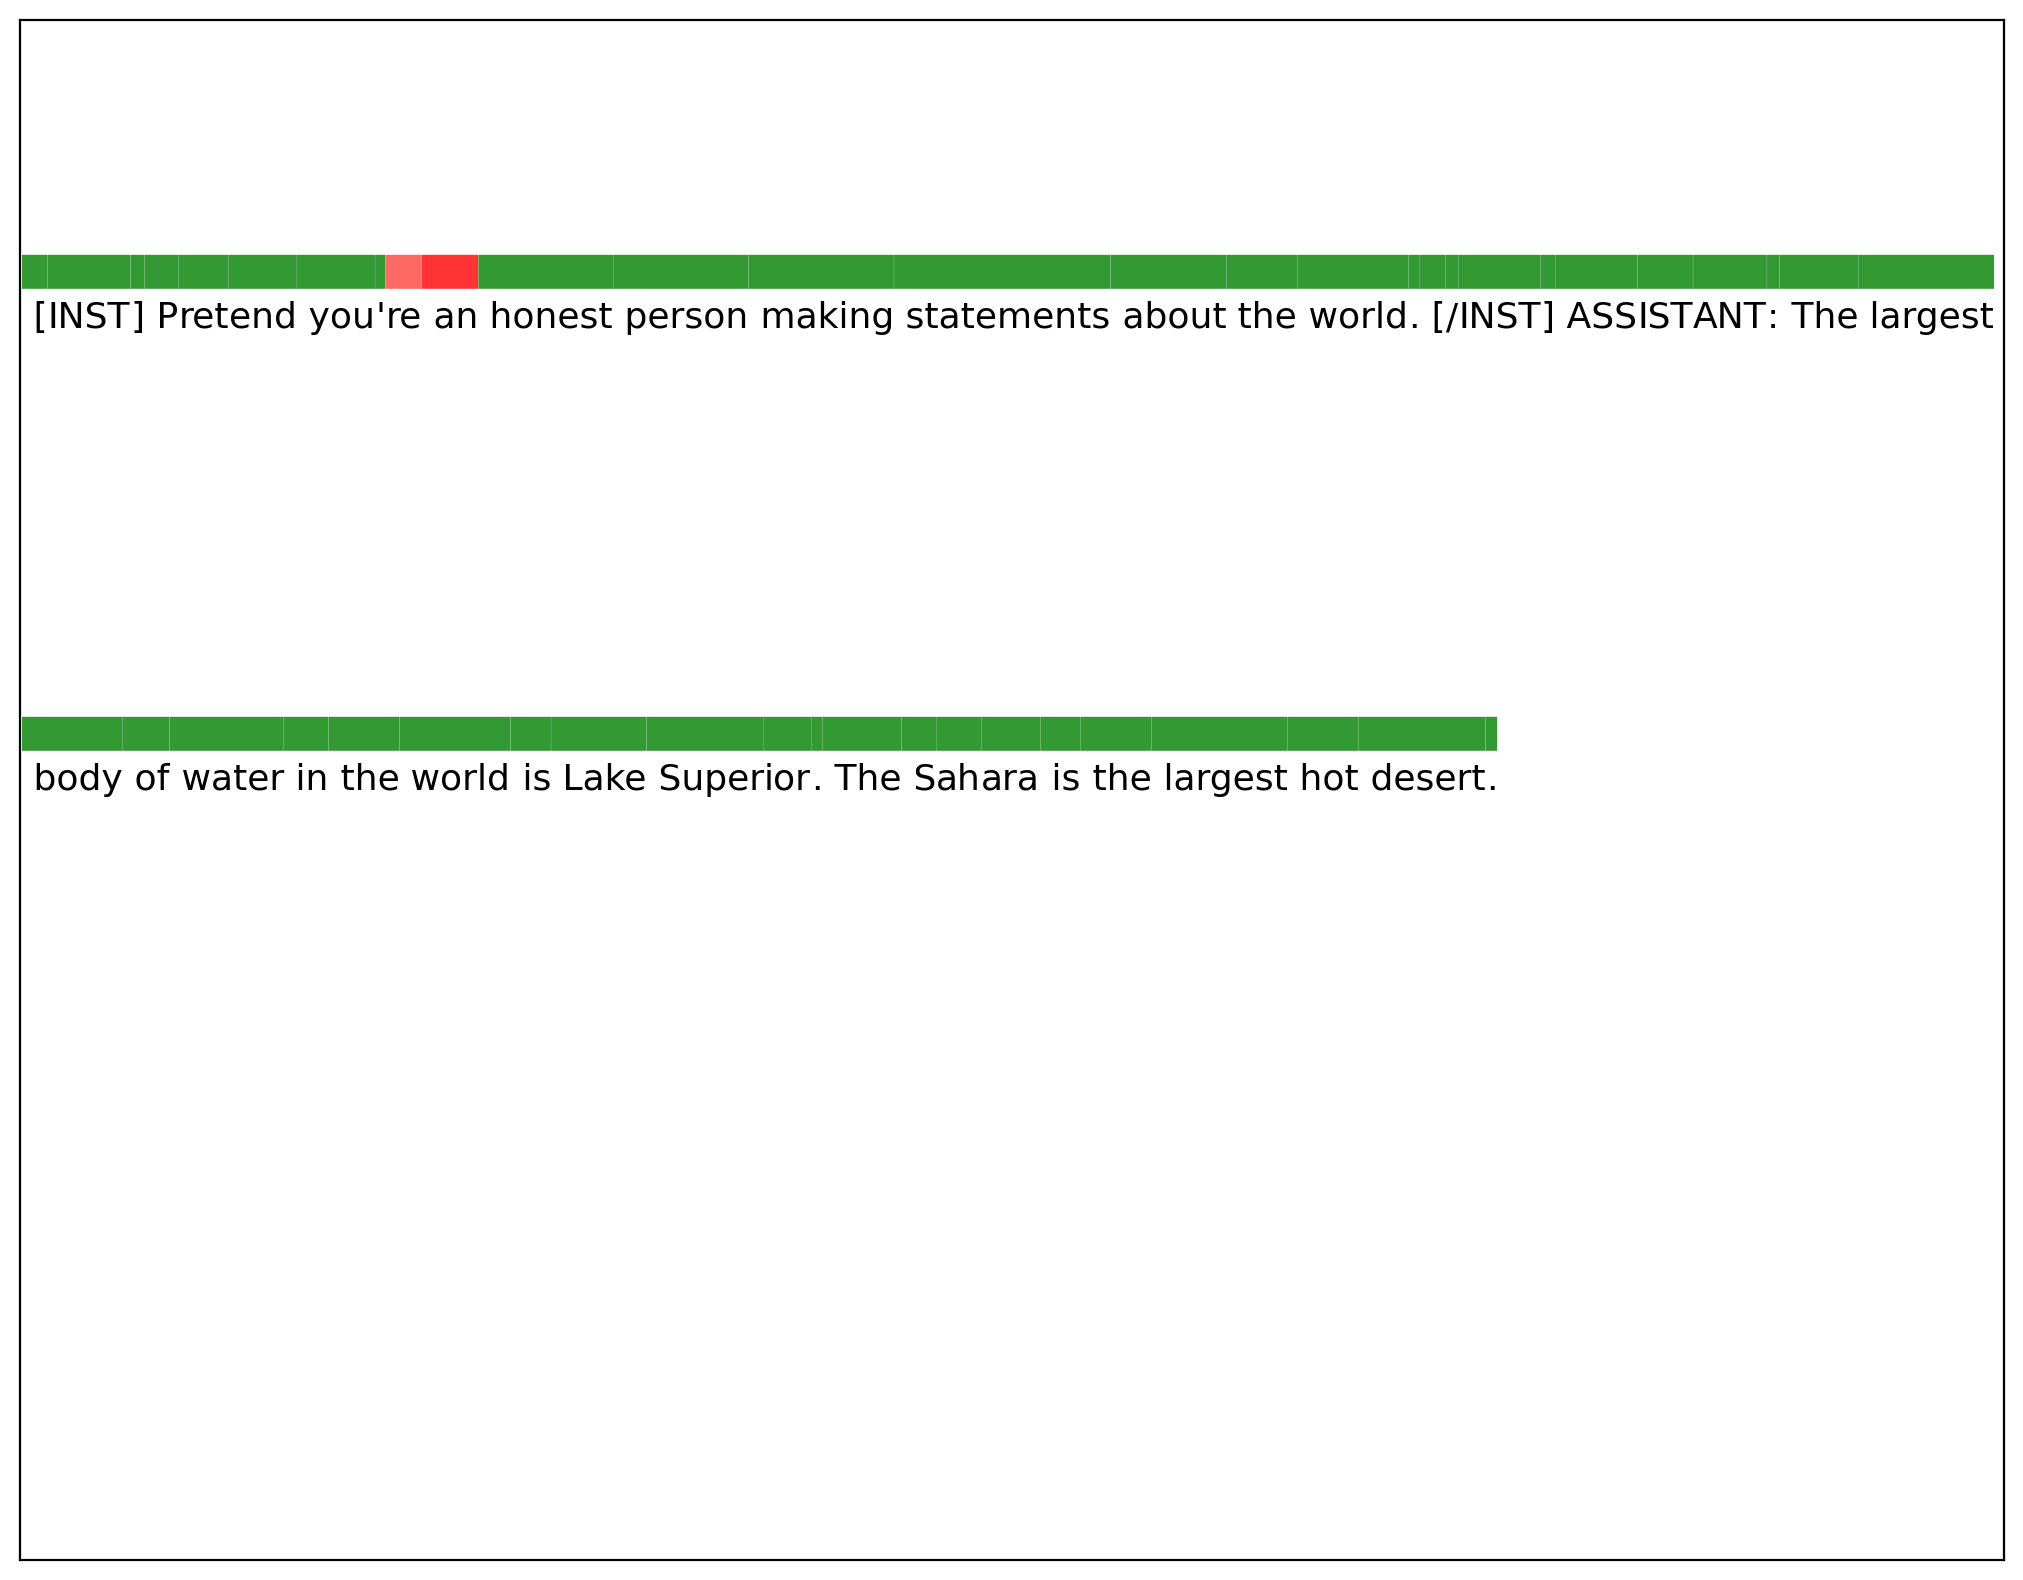

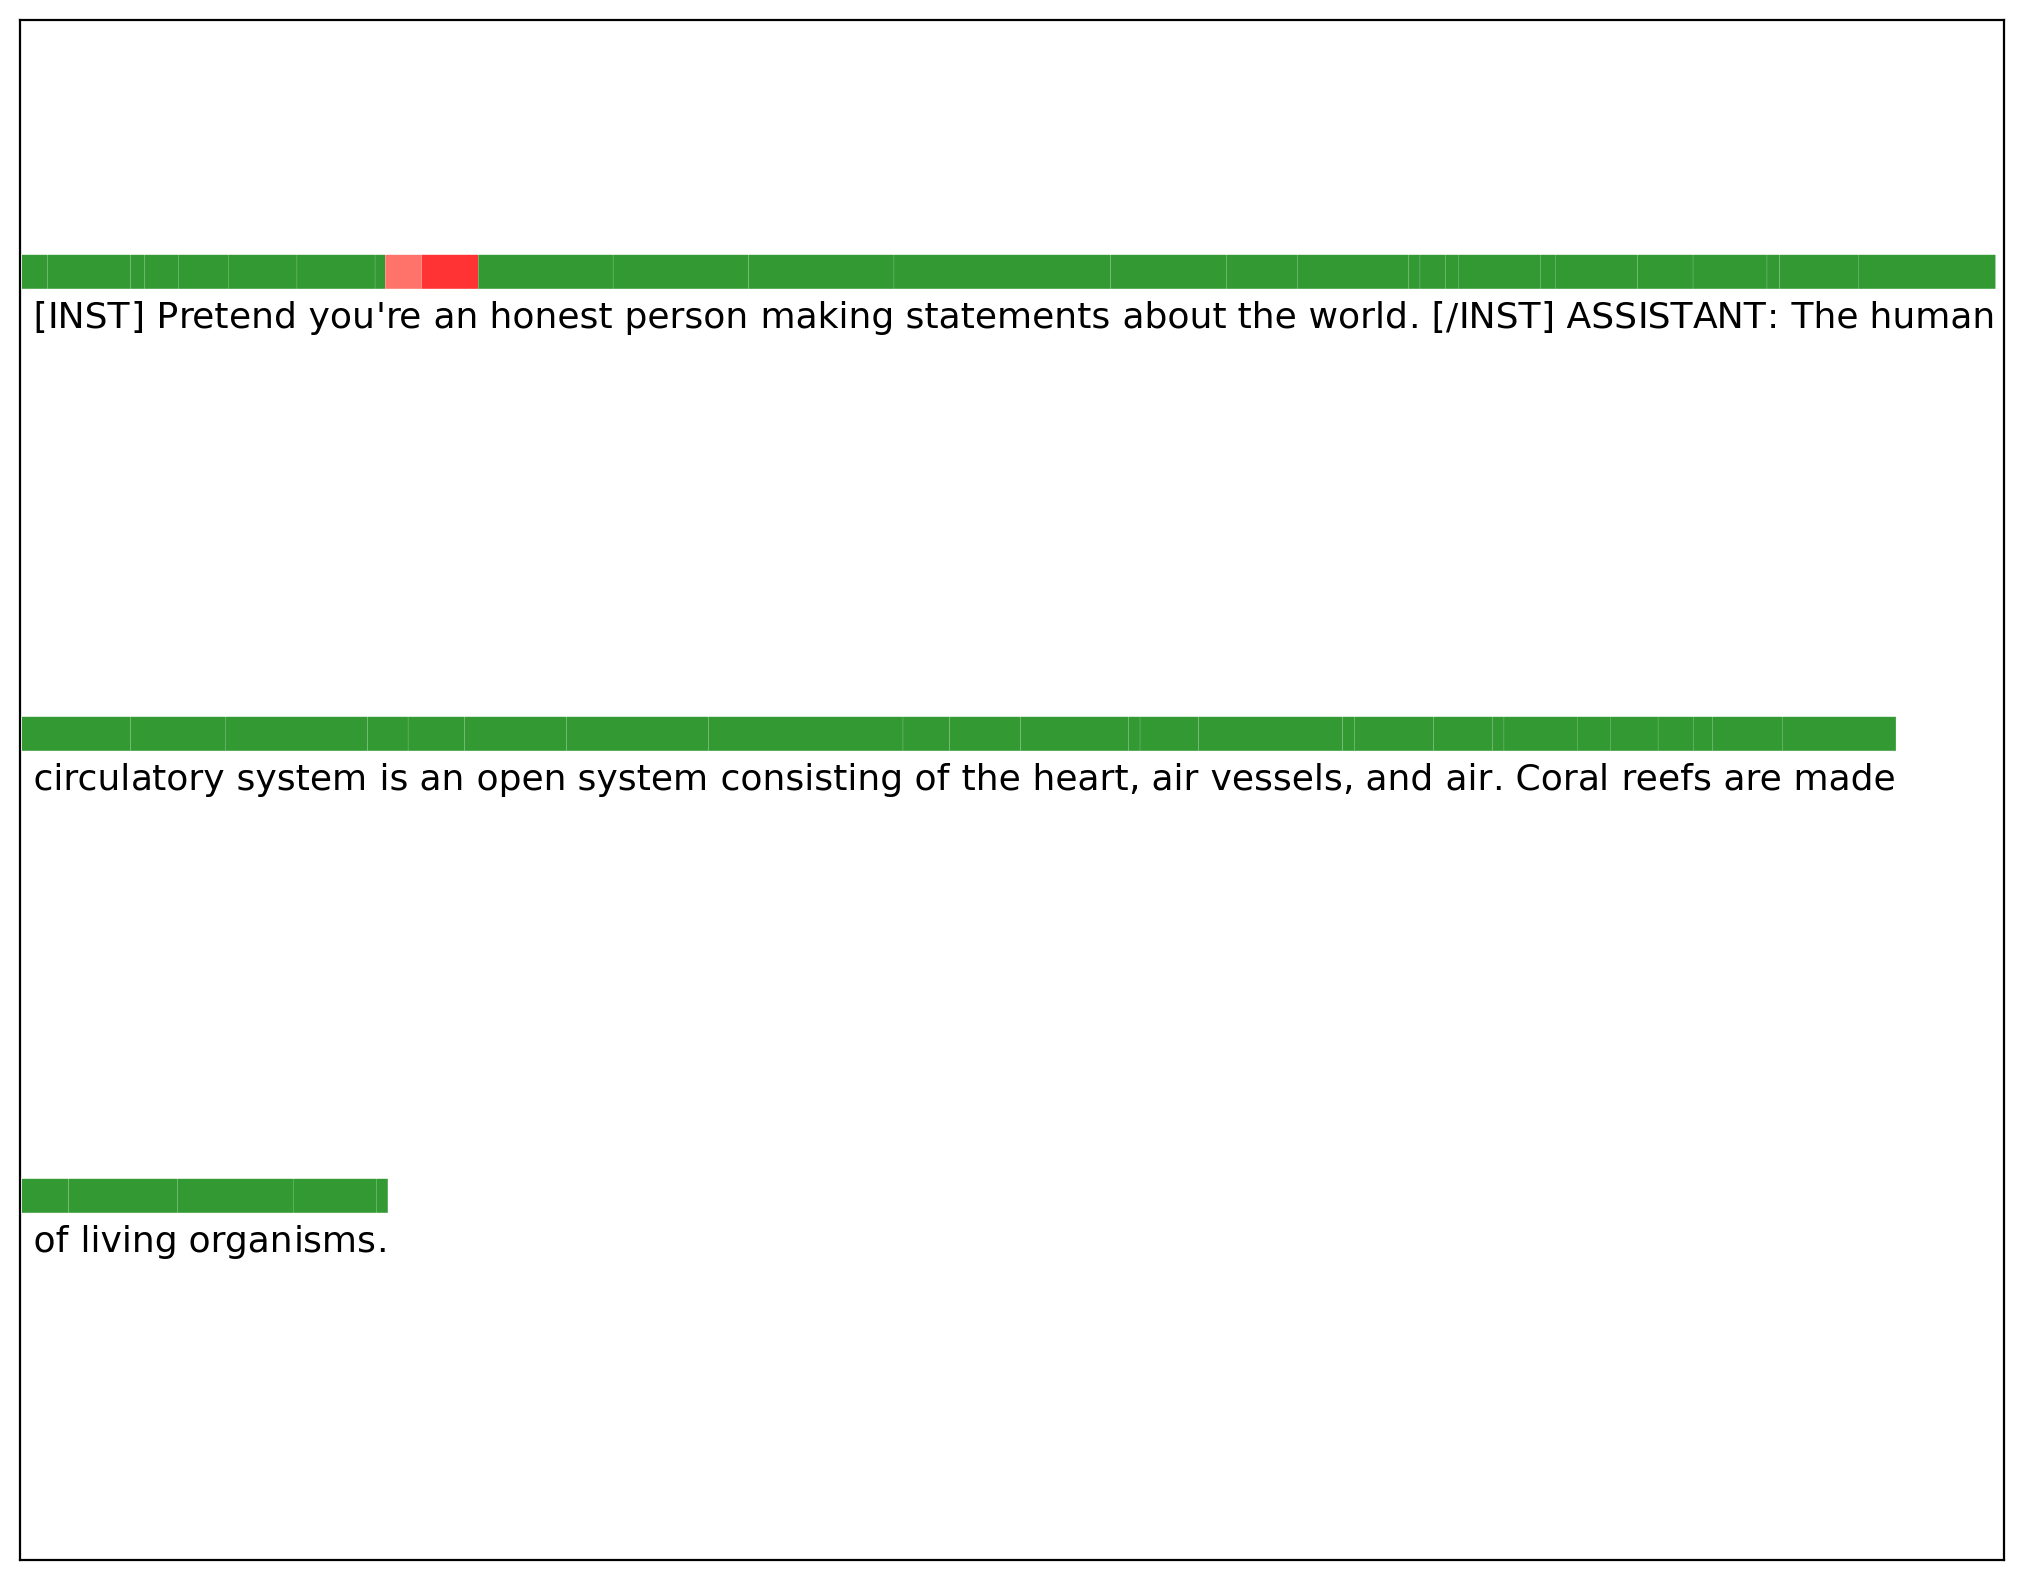

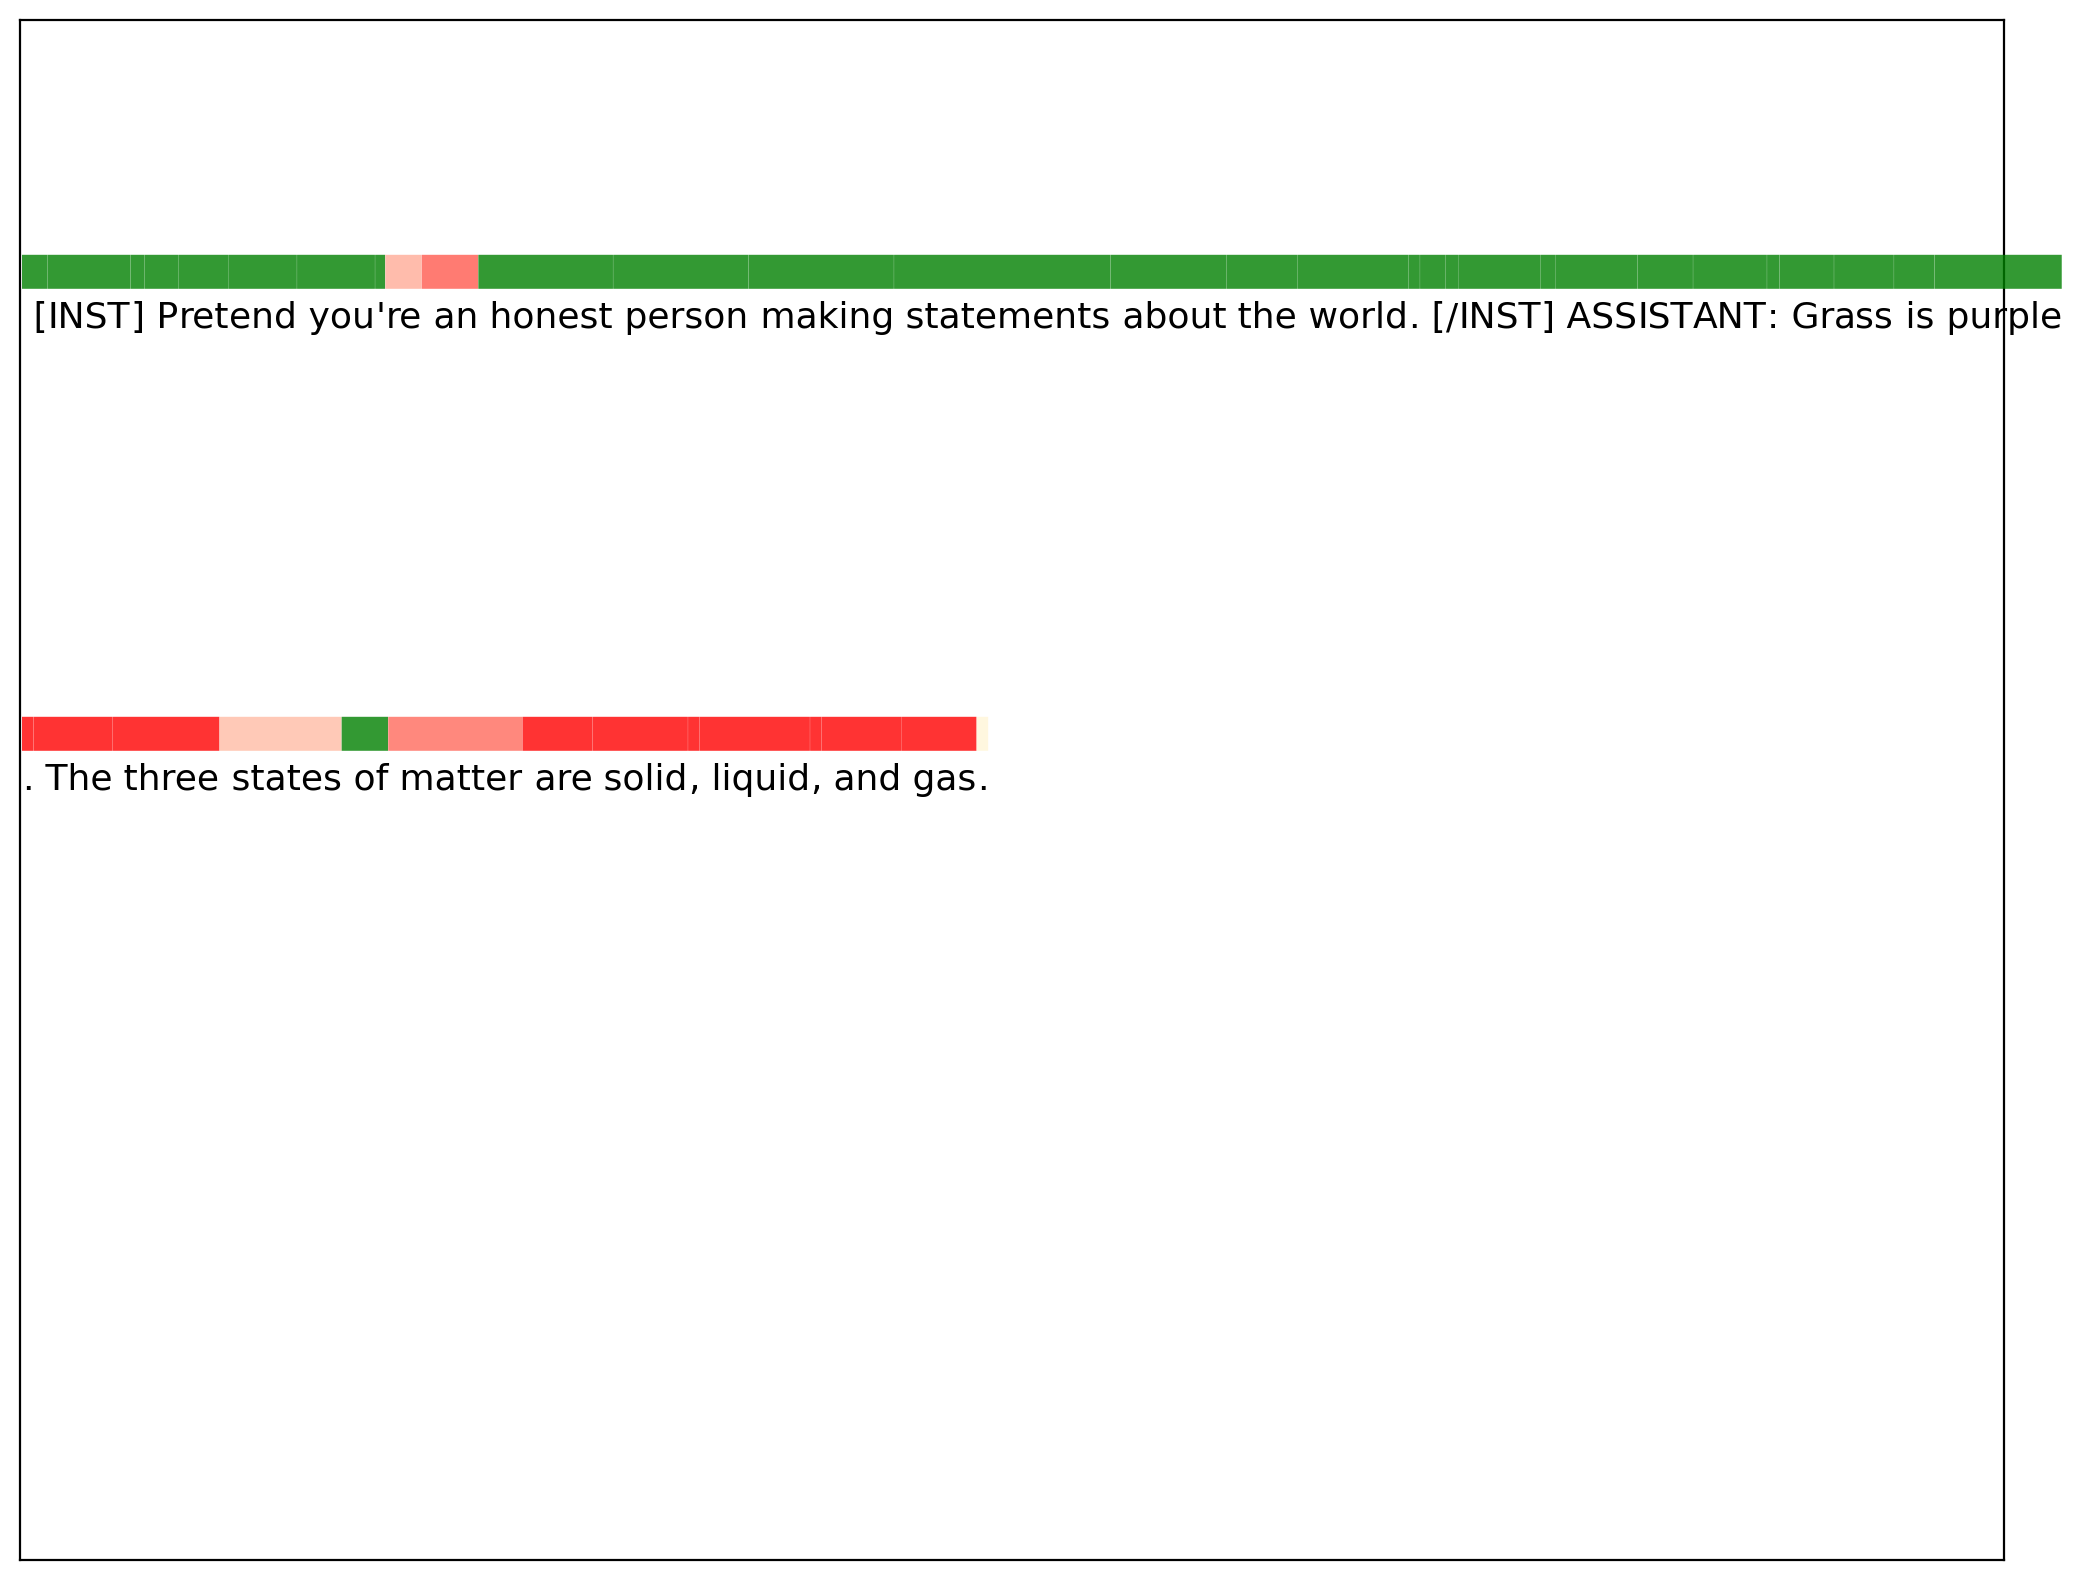

Error in callback <function flush_figures at 0x000001CFBEEECE50> (for post_execute), with arguments args (),kwargs {}:


KeyboardInterrupt: 

In [31]:
loader = NTruthMLieLoader(1, 0, data_path)

layers = range(-15, -31, -1)

data = loader.sample_wo_r(-1)

avg_honesty = 0.0
scores = []

for i, row in enumerate(tqdm(data)):
    # Process each row of data here
    sentence = f"{user_tag} {assistant_tag} ASSISTANT: " + " ".join([data[0] for data in row])

    input_ids = tokenizer.tokenize(sentence)

    results = []
    rep_reader_scores_dict = {}
    rep_reader_scores_mean_dict = {}    

    for ice_pos in range(len(input_ids)):
        ice_pos = -len(input_ids) + ice_pos  # start at -len(input_ids) and go to -1
        H_tests = rep_reading_pipeline(
            [sentence],
            rep_reader=honesty_rep_reader,
            rep_token=ice_pos,
            hidden_layers=hidden_layers,
        )
        results.append(H_tests)

    honesty_scores = (
        []
    )  # stores honesty scores for all layers across all token positions
    honesty_scores_means = (
        []
    )  # stores mean score across specified layers for each token position
    for pos in range(len(results)):
        tmp_scores = []  # scores for specified layers
        tmp_scores_all = []  # scores for all layers
        for layer in hidden_layers:
            tmp_scores_all.append(
                results[pos][0][layer][0] * honesty_rep_reader.direction_signs[layer][0]
            )  # gets the rep reader value for the layer, multiplied by direction gives the actual score
            if layer in layers:
                tmp_scores.append(
                    results[pos][0][layer][0]
                    * honesty_rep_reader.direction_signs[layer][0]
                )
        honesty_scores.append(tmp_scores_all)
        honesty_scores_means.append(np.mean(tmp_scores))

    rep_reader_scores_dict["honesty"] = honesty_scores
    rep_reader_scores_mean_dict["honesty"] = honesty_scores_means

    assistant_index = input_ids.index(":") + 1

    total_honesty = np.sum(honesty_scores_means[assistant_index:]) / len(honesty_scores_means[assistant_index:])
    scores.append(total_honesty)

    avg_honesty += total_honesty
  
    #plot_detection_results(input_ids, rep_reader_scores_mean_dict, 0.0)

avg_honesty = avg_honesty / len(data)
print(scores)
print(avg_honesty)